In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.2.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy import constants

deg = np.pi/180. # radians / degree
yr = 365.25 # days / year

# Astrometric Orbits with Exoplanet

In this tutorial we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements, and eventually radial velocity measurements (in the next tutorial, :ref:`astrometric-rv`). For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data 
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract). 

In [4]:
# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(dirname + "astro.txt", format="csv", fill_values=[(".", '0')])

In [5]:
# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping 
# the primary and secondary star
ind = (astro_dates.value > 1975.) & (astro_dates.value < 1999.73) \
    & (~astro_data_full["rho"].mask) & (~astro_data_full["PA"].mask) # eliminate entries with no measurements

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = 'jd'
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01"$ for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [6]:
astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns

rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# the position angle measurements come in degrees in the range [0, 360].
# we need to convert this to radians in the range [-pi, pi]
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg) # radians

# Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit. 

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

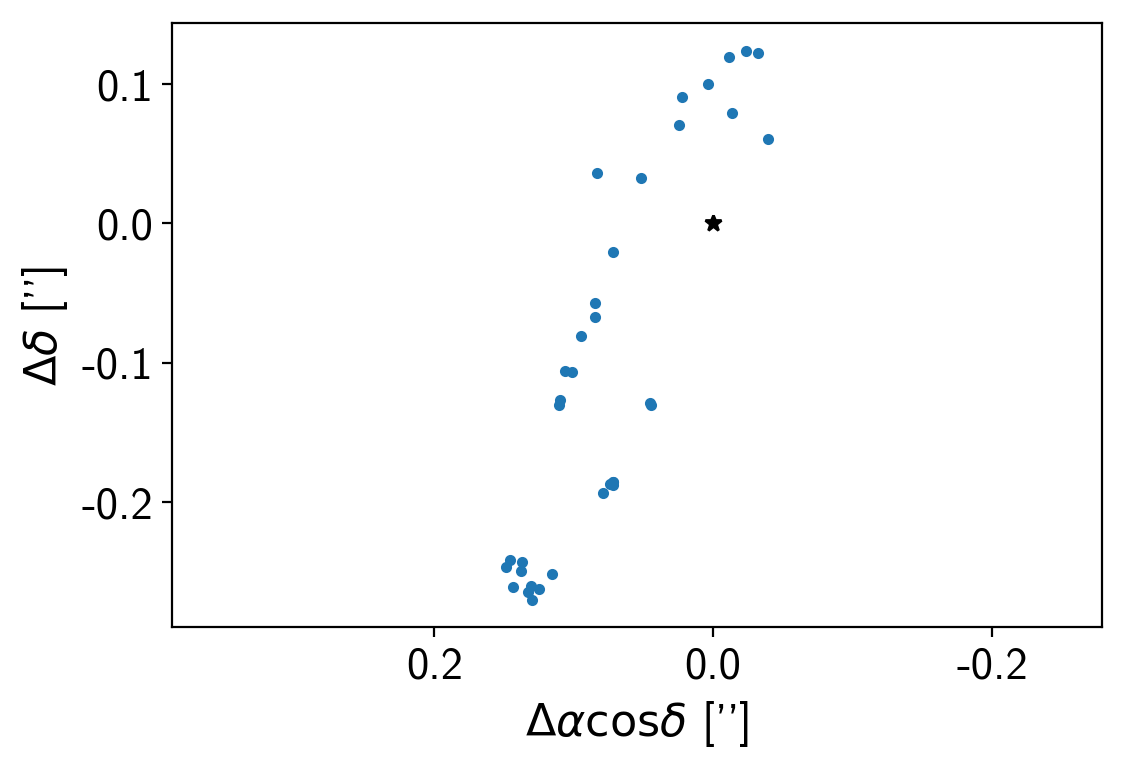

In [7]:
# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left

fig, ax = plt.subplots(nrows=1)

xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0,0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

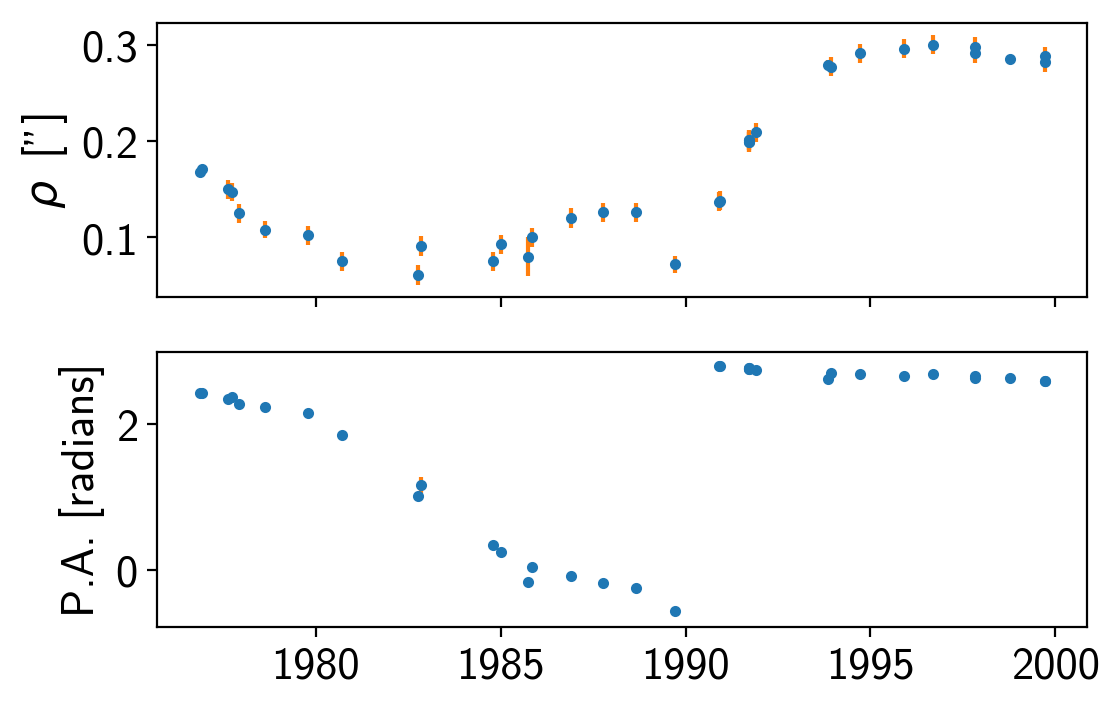

In [8]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(astro_yrs, rho_data, ".")
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(astro_yrs, theta_data, ".")
ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, ls="")
ax[1].set_ylabel(r'P.A. [radians]');

# Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

In [9]:
# import the relevant packages 
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
import exoplanet.orbits
from exoplanet.distributions import Angle

## A note on setting the scale of an orbit 

Orbits in *exoplanet* generally specify the semi-major axis in units of solar radii `R_sun`. For transits and RV orbits, you usually have enough external information (e..g., estimate of stellar mass from spectral type) to put a physical scale onto the orbit. For the most basic of astrometric orbits without parallax information, however, this information can be lacking and thus it makes sense to fit for the semi-major axis in units of `arcseconds`. But, `exoplanet` is modeling a real orbit (where semi-major axis is in units of `R_sun`), so we do need to at least provide a fake parallax to convert from arcseconds to `R_sun.`

In [10]:
# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

In [11]:
# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324 # arcsec
parallax = 1 # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg # [rad]
omega = 251.6 * deg - np.pi # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg 
P = 28.8 * 365.25 # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value # [Julian Date]

# n = 2 * np.pi / P
# t0 = (phi + w) / n

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(a=a, t_periastron=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega)

# make a theano function to get stuff from orbit 
times = tt.vector("times")

# pos = orbit.get_relative_position(times) # the X, Y, Z coordinates
# the position functions take an optional argument parallax to convert from physical units back to arcseconds
ang = orbit.get_relative_angles(times, parallax) # the rho, theta coordinates

# f_pos = theano.function([times], pos)
f_ang = theano.function([times], ang)

t = np.linspace(T0 - P, T0 + P, num=200) # days

# # anoms = f_anom(t)
# X, Y, Z = f_pos(t)
rho, theta = f_ang(t)

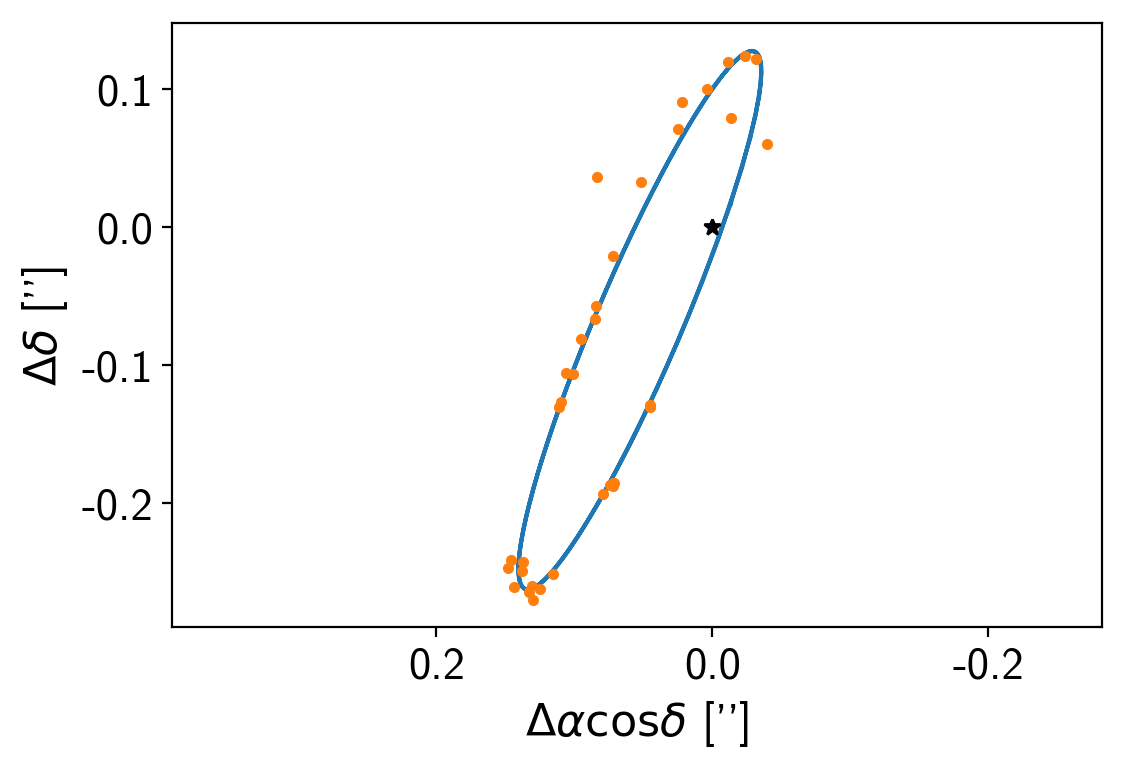

In [12]:
fig, ax = plt.subplots(nrows=1)

# plot the orbit 
xs = rho * np.cos(theta) # X is north
ys = rho * np.sin(theta) # Y is east
ax.plot(ys, xs)

# plot the data
xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0,0, "k*")
ax.set_aspect("equal", "datalim")

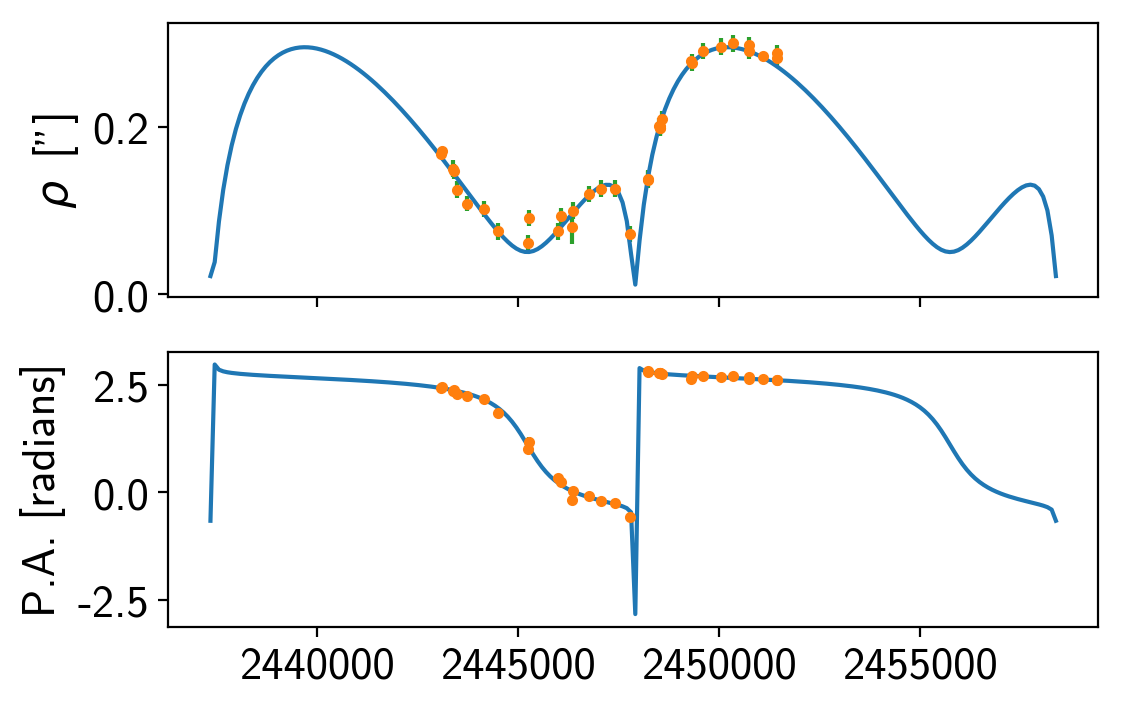

In [13]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(t, rho)
ax[0].plot(astro_jds, rho_data, ".")
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(t, theta)
ax[1].plot(astro_jds, theta_data, ".")
ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, ls="")
ax[1].set_ylabel(r'P.A. [radians]');

In [14]:
# Set up the model in PyMC3

# for theta wrapping 
zeros = np.zeros_like(astro_jds)

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)

with pm.Model() as model:

    # A setup for a basic astrometric binary orbit
    # without an actual parallax measurement, we can model the orbit in units of arcseconds
    # by providing a fake_parallax and conversion constant
    parallax = 1 # arcsec 
    a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324) # arcsec 
    a = pm.Deterministic("a", a_ang * au_to_R_sun / parallax)
        
    # we expect the period to be somewhere in the range of 25 years, 
    # so we'll set a broad prior on logP
    logP = pm.Uniform("logP", lower=np.log(1 * yr), upper=np.log(100* yr), testval=np.log(28.8 * yr))
    P = pm.Deterministic("P", tt.exp(logP))
    
    omega = Angle("omega", testval=251.6 * deg - np.pi) # - pi to pi
    Omega = Angle("Omega", testval=159.6 * deg) # - pi to pi
    
    t_periastron = pm.Uniform("tperi", T0 - P, T0 + P)
    
    # uniform prior on cos_incl (geometric)
    cos_incl = pm.Uniform("cosIncl", lower=-1, upper=1, testval=np.cos(96.0 * deg)) # radians, 0 to 180 degrees
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    
    e = pm.Uniform("e", lower=0.0, upper=1.0, testval=0.798)
           
    orbit = xo.orbits.KeplerianOrbit(a=a, t_periastron=t_periastron, period=P, 
                                   incl=incl, ecc=e, omega=omega, Omega=Omega)
    
    rho_model, theta_model = orbit.get_relative_angles(astro_jds, parallax) # the rho, theta model values
    
    # add jitter terms to both separation and position angle
    log_rho_s = pm.Normal("logRhoS", mu=np.log(np.median(rho_err)), sd=5.0)
    log_theta_s = pm.Normal("logThetaS", mu=np.log(np.median(theta_err)), sd=5.0)
    
    rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
    theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))
    
    # define the likelihood function, e.g., a Gaussian on both rho and theta
    ll_rho = pm.Normal.dist(mu=rho_model, sd=rho_tot_err).logp(rho_data)
    
    # n.b. that we want to be cognizant of the fact that theta wraps 
    # so the following is equivalent to 
    # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
    # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
    theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
    ll_theta = pm.Normal.dist(mu=theta_diff, sd=theta_tot_err).logp(zeros)
    
    # Outlier model
    Q = pm.Uniform("Q", lower=0.5, upper=1, testval=0.8)
    mu_rho = pm.Normal("mu_rho", mu=np.mean(rho_data), sd=10.0)
    logv_rho = pm.Normal("logv_rho", mu=np.log(np.mean(rho_err)), sd=10.0)
    ll_rho_bg = pm.Normal.dist(mu=mu_rho, sd=tt.sqrt(rho_err**2 + tt.exp(2*logv_rho))).logp(rho_data)

    logv_theta = pm.Normal("logv_theta", mu=np.log(np.mean(theta_err)), sd=10.0)
    ll_theta_bg = pm.Normal.dist(mu=0.0, sd=tt.sqrt(theta_err**2 + tt.exp(2*logv_theta))).logp(theta_data)

    ll_fg = tt.log(Q) + ll_rho + ll_theta
    ll_bg = tt.log(1-Q) + ll_rho_bg + ll_theta_bg
    ll = pm.math.logaddexp(ll_fg, ll_bg)
    pm.Potential("loglike", ll)
    
    pm.Deterministic("log_qual", ll_fg - ll)

    # set up predicted orbits for later plotting 
    rho_dense, theta_dense = orbit.get_relative_angles(t_fine, parallax)
    rho_save = pm.Deterministic("rhoSave", rho_dense)
    theta_save = pm.Deterministic("thetaSave", theta_dense)    

In [15]:
with model:
    map_sol = xo.optimize()

optimizing logp for variables: ['logv_theta', 'logv_rho', 'mu_rho', 'Q_interval__', 'logThetaS', 'logRhoS', 'e_interval__', 'cosIncl_interval__', 'tperi_interval__', 'Omega_angle__', 'omega_angle__', 'logP_interval__', 'a_ang_interval__']


message: Optimization terminated successfully.
logp: 88.69125108867576 -> 190.98880236057698


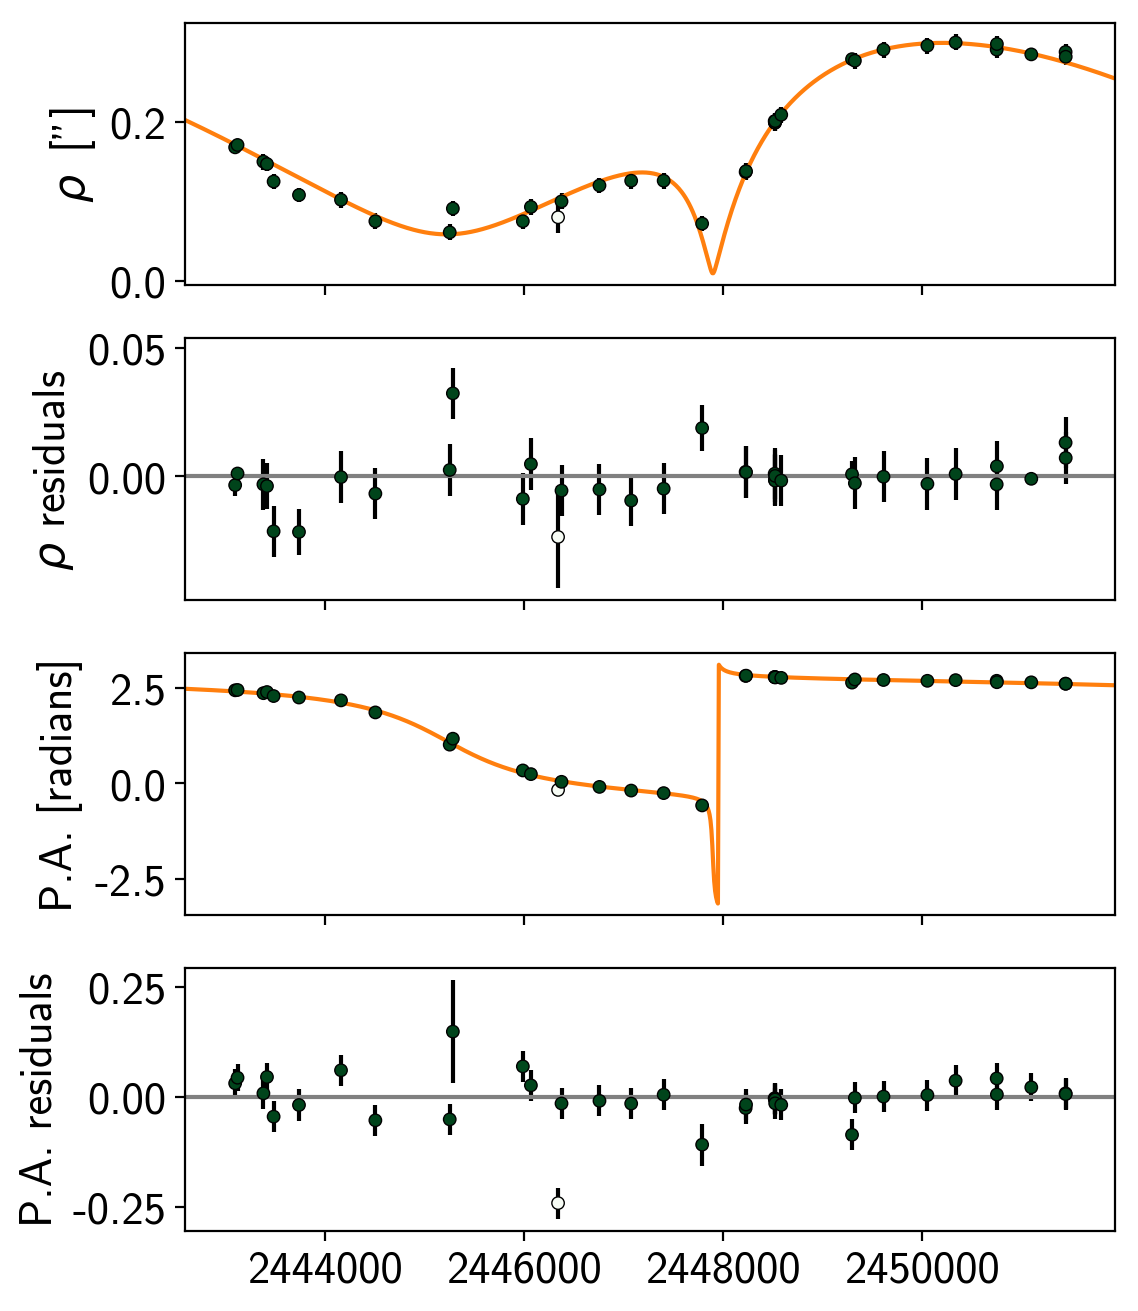

In [16]:
# we can plot the maximum posterior solution to see

ekw = dict(color="k", ls="")
skw = dict(c=np.exp(map_sol["log_qual"]), s=20, cmap="Greens",
           edgecolor="k", linewidth=0.5, zorder=10)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6,8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

with model:
    tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * map_sol["logRhoS"]))
    tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * map_sol["logThetaS"]))
    models = xo.eval_in_model([rho_model, theta_model], map_sol)
        
    ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
    ax[0].plot(t_fine, map_sol["rhoSave"], "C1")
    ax[0].scatter(astro_jds, rho_data, **skw)
    
    ax[1].axhline(0.0, color="0.5")
    ax[1].scatter(astro_jds, rho_data - models[0], **skw)
    ax[1].errorbar(astro_jds, rho_data - models[0], yerr=tot_rho_err, **ekw)
    
        
    ax[2].plot(t_fine, map_sol["thetaSave"], "C1")
    ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
    ax[2].scatter(astro_jds, theta_data, **skw)
    
    ax[3].axhline(0.0, color="0.5")
    ax[3].errorbar(astro_jds, theta_data - models[1], yerr=tot_theta_err, **ekw) 
    ax[3].scatter(astro_jds, theta_data - models[1], **skw)

ax[3].set_xlim(t_fine[0], t_fine[-1]);

In [17]:
# now let's actually explore the posterior for real
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=4000, start=model.test_point,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:00<00:06, 127.57draws/s]

Sampling 4 chains:   3%|▎         | 22/808 [00:00<00:07, 101.16draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:00<00:11, 66.81draws/s] 

Sampling 4 chains:   4%|▍         | 32/808 [00:00<00:13, 58.62draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:00<00:13, 56.27draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:00<00:15, 50.72draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:00<00:15, 49.68draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:00<00:14, 52.21draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:01<00:15, 48.16draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:01<00:16, 46.07draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:01<00:16, 45.05draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:01<00:15, 45.94draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:01<00:15, 46.72draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:01<00:15, 45.59draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:01<00:16, 44.53draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:01<00:15, 46.52draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:01<00:14, 47.36draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:02<00:15, 44.56draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:02<00:15, 44.99draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:02<00:15, 44.58draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:02<00:15, 45.43draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:02<00:15, 44.92draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:02<00:14, 46.07draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:02<00:14, 46.64draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:02<00:14, 45.25draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:03<00:15, 43.76draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:03<00:13, 47.44draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:03<00:14, 43.40draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:03<00:14, 43.88draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:03<00:13, 47.69draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:03<00:14, 42.09draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:03<00:13, 46.17draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:03<00:13, 46.98draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:04<00:14, 41.49draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:04<00:13, 46.11draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:04<00:14, 41.90draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:04<00:13, 45.08draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:04<00:13, 43.65draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:04<00:13, 44.71draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:04<00:12, 46.12draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:04<00:12, 46.95draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:04<00:12, 45.53draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:05<00:13, 43.33draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:05<00:12, 45.11draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:05<00:12, 45.97draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:05<00:12, 45.29draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:05<00:11, 45.56draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:05<00:11, 46.77draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:05<00:11, 47.33draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:05<00:11, 46.28draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [00:05<00:11, 47.00draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:06<00:11, 43.92draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:06<00:11, 44.66draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:06<00:11, 44.46draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:06<00:10, 46.30draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [00:06<00:10, 45.65draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:06<00:10, 47.56draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:06<00:10, 47.68draws/s]

Sampling 4 chains:  41%|████      | 330/808 [00:06<00:10, 43.97draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:07<00:09, 47.40draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:07<00:10, 43.63draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:07<00:10, 45.19draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [00:07<00:10, 44.86draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:07<00:09, 45.23draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:07<00:09, 45.78draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:07<00:09, 45.97draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:07<00:09, 46.39draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [00:08<00:09, 47.10draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:08<00:09, 45.32draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:08<00:09, 45.20draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [00:08<00:09, 45.78draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [00:08<00:08, 46.30draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [00:08<00:09, 44.58draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [00:08<00:08, 48.03draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [00:08<00:07, 48.89draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [00:09<00:08, 44.41draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [00:09<00:07, 47.78draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:09<00:08, 44.05draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [00:09<00:08, 45.07draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [00:09<00:07, 46.37draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [00:09<00:08, 44.50draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [00:09<00:07, 47.71draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [00:09<00:07, 47.50draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [00:09<00:07, 44.45draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [00:10<00:07, 45.76draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [00:10<00:07, 46.34draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [00:10<00:07, 45.65draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [00:10<00:07, 44.31draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [00:10<00:06, 45.87draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [00:10<00:06, 48.47draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [00:10<00:07, 42.15draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [00:10<00:06, 46.05draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [00:11<00:06, 43.14draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [00:11<00:06, 46.73draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [00:11<00:06, 44.32draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [00:11<00:05, 46.91draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [00:11<00:05, 47.37draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [00:11<00:05, 45.89draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [00:11<00:05, 48.69draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [00:11<00:05, 46.20draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [00:12<00:05, 45.47draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [00:12<00:05, 46.62draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [00:12<00:04, 46.98draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [00:12<00:04, 46.30draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [00:12<00:04, 45.74draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [00:12<00:04, 44.98draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [00:12<00:04, 47.56draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [00:12<00:04, 45.19draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [00:12<00:04, 45.66draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [00:13<00:04, 46.07draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [00:13<00:04, 45.55draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [00:13<00:04, 46.46draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [00:13<00:03, 46.66draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [00:13<00:03, 44.99draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [00:13<00:03, 47.18draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [00:13<00:03, 46.88draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [00:13<00:03, 44.81draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [00:13<00:03, 47.96draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [00:14<00:03, 46.27draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [00:14<00:03, 47.10draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [00:14<00:02, 47.78draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [00:14<00:02, 48.05draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:14<00:02, 46.61draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [00:14<00:02, 44.81draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [00:14<00:02, 47.12draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [00:14<00:02, 47.35draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [00:14<00:02, 45.08draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [00:15<00:02, 44.39draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [00:15<00:02, 44.50draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [00:15<00:01, 45.24draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [00:15<00:01, 45.91draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [00:15<00:01, 49.37draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [00:15<00:01, 45.92draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [00:15<00:01, 48.40draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [00:16<00:01, 48.06draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [00:16<00:01, 45.72draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [00:16<00:00, 46.87draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [00:16<00:00, 45.80draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [00:16<00:00, 46.97draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [00:16<00:00, 43.57draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [00:16<00:00, 41.10draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [00:16<00:00, 43.15draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [00:17<00:00, 32.71draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:17<00:00, 33.81draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:17<00:00, 24.51draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:18<00:00, 16.06draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:18<00:00, 44.07draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▍         | 17/408 [00:00<00:02, 133.66draws/s]

Sampling 4 chains:   6%|▌         | 23/408 [00:00<00:04, 95.48draws/s] 

Sampling 4 chains:   7%|▋         | 28/408 [00:00<00:05, 72.73draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:00<00:06, 56.85draws/s]

Sampling 4 chains:  10%|▉         | 40/408 [00:00<00:06, 59.00draws/s]

Sampling 4 chains:  11%|█         | 45/408 [00:00<00:06, 54.58draws/s]

Sampling 4 chains:  13%|█▎        | 52/408 [00:00<00:06, 55.79draws/s]

Sampling 4 chains:  14%|█▍        | 59/408 [00:00<00:05, 58.35draws/s]

Sampling 4 chains:  16%|█▌        | 65/408 [00:01<00:05, 58.24draws/s]

Sampling 4 chains:  18%|█▊        | 72/408 [00:01<00:06, 53.55draws/s]

Sampling 4 chains:  19%|█▉        | 79/408 [00:01<00:05, 56.54draws/s]

Sampling 4 chains:  21%|██        | 85/408 [00:01<00:06, 50.03draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:01<00:06, 51.24draws/s]

Sampling 4 chains:  24%|██▍       | 97/408 [00:01<00:06, 48.29draws/s]

Sampling 4 chains:  26%|██▌       | 105/408 [00:01<00:05, 52.66draws/s]

Sampling 4 chains:  27%|██▋       | 111/408 [00:01<00:06, 48.27draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:02<00:05, 50.02draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:02<00:05, 51.86draws/s]

Sampling 4 chains:  32%|███▏      | 130/408 [00:02<00:05, 53.42draws/s]

Sampling 4 chains:  34%|███▎      | 137/408 [00:02<00:05, 50.29draws/s]

Sampling 4 chains:  35%|███▌      | 144/408 [00:02<00:04, 54.39draws/s]

Sampling 4 chains:  37%|███▋      | 150/408 [00:02<00:05, 47.67draws/s]

Sampling 4 chains:  38%|███▊      | 156/408 [00:02<00:04, 50.73draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [00:02<00:04, 51.98draws/s]

Sampling 4 chains:  41%|████      | 168/408 [00:03<00:04, 49.45draws/s]

Sampling 4 chains:  43%|████▎     | 174/408 [00:03<00:04, 49.71draws/s]

Sampling 4 chains:  45%|████▍     | 182/408 [00:03<00:04, 51.75draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:03<00:04, 51.86draws/s]

Sampling 4 chains:  48%|████▊     | 195/408 [00:03<00:04, 50.06draws/s]

Sampling 4 chains:  50%|████▉     | 203/408 [00:03<00:03, 52.64draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [00:03<00:03, 51.26draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [00:03<00:03, 54.07draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [00:04<00:03, 52.65draws/s]

Sampling 4 chains:  56%|█████▌    | 228/408 [00:04<00:03, 48.88draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:04<00:03, 49.68draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [00:04<00:03, 52.77draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [00:04<00:02, 53.80draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:04<00:03, 50.55draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [00:04<00:02, 50.83draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [00:04<00:02, 54.77draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:05<00:02, 54.58draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:05<00:02, 50.35draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [00:05<00:02, 52.52draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [00:05<00:02, 51.13draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [00:05<00:02, 53.36draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [00:05<00:02, 49.93draws/s]

Sampling 4 chains:  76%|███████▌  | 311/408 [00:05<00:01, 50.71draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [00:05<00:01, 48.12draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [00:06<00:01, 47.66draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [00:06<00:01, 47.29draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [00:06<00:01, 45.60draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [00:06<00:01, 50.82draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [00:06<00:01, 47.74draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [00:06<00:01, 49.58draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [00:06<00:00, 46.01draws/s]

Sampling 4 chains:  90%|█████████ | 368/408 [00:06<00:00, 49.38draws/s]

Sampling 4 chains:  92%|█████████▏| 374/408 [00:07<00:00, 46.15draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [00:07<00:00, 44.00draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [00:07<00:00, 49.85draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [00:07<00:00, 43.78draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:07<00:00, 38.56draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:07<00:00, 34.54draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:08<00:00, 30.09draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:08<00:00, 48.84draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 16/808 [00:00<00:06, 122.81draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:00<00:11, 70.21draws/s] 

Sampling 4 chains:   3%|▎         | 24/808 [00:00<00:14, 54.85draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:00<00:13, 55.80draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:00<00:14, 53.76draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:00<00:17, 43.65draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:00<00:16, 45.14draws/s]

Sampling 4 chains:   6%|▋         | 52/808 [00:00<00:17, 43.58draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:01<00:17, 43.92draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:01<00:16, 45.50draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:01<00:18, 40.76draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:01<00:16, 43.44draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:01<00:16, 43.51draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:01<00:17, 40.83draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:01<00:16, 43.17draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:01<00:15, 46.86draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:02<00:14, 47.62draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:02<00:13, 52.46draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:02<00:12, 57.50draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:02<00:09, 68.13draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:02<00:09, 70.24draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:02<00:09, 71.14draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:02<00:09, 68.42draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:02<00:09, 69.57draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:02<00:09, 66.83draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:03<00:09, 67.43draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:03<00:10, 61.97draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:03<00:10, 57.78draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:03<00:10, 58.33draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:03<00:11, 50.93draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:03<00:11, 52.38draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:03<00:12, 46.66draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:04<00:13, 45.10draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:04<00:12, 46.46draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:04<00:13, 44.01draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [00:04<00:12, 45.37draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:04<00:12, 45.41draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:04<00:13, 41.95draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:04<00:12, 45.53draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:04<00:12, 43.75draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [00:04<00:11, 46.66draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:05<00:10, 50.62draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:05<00:11, 47.81draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:05<00:11, 47.02draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:05<00:10, 50.40draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:05<00:09, 52.70draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:05<00:09, 52.08draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:05<00:10, 48.84draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [00:05<00:10, 47.12draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:06<00:10, 47.69draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:06<00:09, 49.28draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:06<00:10, 45.34draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:06<00:10, 44.12draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:06<00:09, 46.99draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:06<00:09, 50.99draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:06<00:07, 57.62draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:06<00:07, 56.99draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:07<00:06, 62.93draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [00:07<00:06, 65.47draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:07<00:05, 69.53draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:07<00:06, 63.55draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:07<00:06, 66.53draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [00:07<00:06, 62.76draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [00:07<00:06, 59.39draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [00:07<00:05, 65.96draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [00:07<00:05, 65.94draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [00:08<00:05, 68.46draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [00:08<00:05, 68.28draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [00:08<00:05, 65.51draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [00:08<00:05, 66.22draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [00:08<00:05, 65.77draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [00:08<00:04, 70.41draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [00:08<00:05, 57.79draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [00:09<00:06, 44.62draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [00:09<00:07, 40.09draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [00:09<00:07, 39.07draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [00:09<00:08, 35.86draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [00:09<00:08, 33.81draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [00:09<00:08, 33.40draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [00:09<00:08, 34.58draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [00:10<00:08, 31.56draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [00:10<00:08, 30.64draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [00:10<00:08, 32.46draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [00:10<00:08, 32.97draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [00:10<00:08, 30.86draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [00:10<00:07, 32.78draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [00:10<00:07, 33.96draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [00:10<00:08, 30.85draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [00:11<00:07, 32.87draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [00:11<00:06, 34.68draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [00:11<00:07, 30.75draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [00:11<00:06, 34.59draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [00:11<00:06, 32.62draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [00:11<00:06, 32.33draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [00:11<00:06, 34.16draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [00:11<00:06, 32.25draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [00:12<00:06, 31.16draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [00:12<00:06, 30.57draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [00:12<00:06, 32.63draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [00:12<00:06, 31.89draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [00:12<00:06, 30.68draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [00:12<00:05, 32.74draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [00:12<00:05, 32.53draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [00:12<00:05, 31.33draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [00:13<00:05, 32.77draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [00:13<00:05, 31.58draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [00:13<00:05, 32.77draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [00:13<00:05, 31.67draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [00:13<00:04, 32.55draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [00:13<00:04, 32.99draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [00:13<00:04, 32.20draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [00:13<00:04, 32.39draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [00:14<00:04, 32.89draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [00:14<00:04, 32.86draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [00:14<00:04, 32.41draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [00:14<00:04, 32.78draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [00:14<00:03, 33.34draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [00:14<00:04, 29.96draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [00:14<00:03, 33.41draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [00:15<00:03, 29.42draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [00:15<00:03, 33.29draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [00:15<00:03, 29.28draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [00:15<00:03, 32.31draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [00:15<00:03, 29.69draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [00:15<00:03, 30.33draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [00:15<00:02, 31.22draws/s]

Sampling 4 chains:  89%|████████▉ | 722/808 [00:15<00:02, 31.86draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [00:16<00:02, 33.70draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [00:16<00:02, 31.48draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [00:16<00:02, 32.70draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [00:16<00:02, 33.48draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [00:16<00:02, 31.52draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [00:16<00:01, 33.23draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [00:16<00:01, 31.27draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [00:16<00:01, 31.53draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [00:17<00:01, 32.61draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:17<00:01, 29.98draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [00:17<00:01, 32.34draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [00:17<00:01, 32.72draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [00:17<00:01, 32.19draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:17<00:00, 32.98draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [00:17<00:00, 32.05draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:18<00:00, 31.99draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:18<00:00, 33.59draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:18<00:00, 35.19draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [00:18<00:00, 30.66draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [00:18<00:00, 27.35draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:18<00:00, 17.29draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:18<00:00, 42.53draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 14/1608 [00:00<00:13, 115.36draws/s]

Sampling 4 chains:   1%|          | 19/1608 [00:00<00:20, 77.85draws/s] 

Sampling 4 chains:   1%|▏         | 24/1608 [00:00<00:25, 63.01draws/s]

Sampling 4 chains:   2%|▏         | 29/1608 [00:00<00:27, 57.81draws/s]

Sampling 4 chains:   2%|▏         | 34/1608 [00:00<00:30, 51.15draws/s]

Sampling 4 chains:   2%|▏         | 39/1608 [00:00<00:32, 48.27draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:00<00:33, 46.07draws/s]

Sampling 4 chains:   3%|▎         | 49/1608 [00:00<00:33, 46.84draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:01<00:36, 42.80draws/s]

Sampling 4 chains:   4%|▎         | 59/1608 [00:01<00:36, 42.22draws/s]

Sampling 4 chains:   4%|▍         | 65/1608 [00:01<00:35, 43.81draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:01<00:35, 43.51draws/s]

Sampling 4 chains:   5%|▍         | 75/1608 [00:01<00:36, 42.39draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:01<00:35, 42.42draws/s]

Sampling 4 chains:   5%|▌         | 86/1608 [00:01<00:34, 44.31draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:01<00:34, 43.81draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:02<00:35, 42.18draws/s]

Sampling 4 chains:   6%|▋         | 102/1608 [00:02<00:34, 44.12draws/s]

Sampling 4 chains:   7%|▋         | 107/1608 [00:02<00:33, 45.03draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:02<00:32, 46.14draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:02<00:35, 41.79draws/s]

Sampling 4 chains:   8%|▊         | 122/1608 [00:02<00:34, 42.52draws/s]

Sampling 4 chains:   8%|▊         | 127/1608 [00:02<00:33, 44.05draws/s]

Sampling 4 chains:   8%|▊         | 133/1608 [00:02<00:34, 42.82draws/s]

Sampling 4 chains:   9%|▊         | 138/1608 [00:02<00:33, 43.32draws/s]

Sampling 4 chains:   9%|▉         | 143/1608 [00:03<00:33, 44.27draws/s]

Sampling 4 chains:   9%|▉         | 148/1608 [00:03<00:31, 45.66draws/s]

Sampling 4 chains:  10%|▉         | 153/1608 [00:03<00:33, 43.08draws/s]

Sampling 4 chains:  10%|▉         | 158/1608 [00:03<00:33, 43.81draws/s]

Sampling 4 chains:  10%|█         | 163/1608 [00:03<00:33, 43.64draws/s]

Sampling 4 chains:  10%|█         | 168/1608 [00:03<00:33, 43.27draws/s]

Sampling 4 chains:  11%|█         | 173/1608 [00:03<00:32, 44.59draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [00:03<00:32, 44.02draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [00:04<00:32, 43.23draws/s]

Sampling 4 chains:  12%|█▏        | 188/1608 [00:04<00:33, 42.80draws/s]

Sampling 4 chains:  12%|█▏        | 193/1608 [00:04<00:32, 43.11draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [00:04<00:31, 44.18draws/s]

Sampling 4 chains:  13%|█▎        | 204/1608 [00:04<00:32, 43.84draws/s]

Sampling 4 chains:  13%|█▎        | 209/1608 [00:04<00:32, 43.20draws/s]

Sampling 4 chains:  13%|█▎        | 214/1608 [00:04<00:31, 44.64draws/s]

Sampling 4 chains:  14%|█▎        | 220/1608 [00:04<00:28, 48.22draws/s]

Sampling 4 chains:  14%|█▍        | 225/1608 [00:04<00:28, 48.66draws/s]

Sampling 4 chains:  14%|█▍        | 230/1608 [00:05<00:28, 48.56draws/s]

Sampling 4 chains:  15%|█▍        | 236/1608 [00:05<00:26, 51.17draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [00:05<00:26, 51.84draws/s]

Sampling 4 chains:  16%|█▌        | 250/1608 [00:05<00:23, 56.92draws/s]

Sampling 4 chains:  16%|█▌        | 261/1608 [00:05<00:20, 65.76draws/s]

Sampling 4 chains:  17%|█▋        | 269/1608 [00:05<00:20, 66.83draws/s]

Sampling 4 chains:  17%|█▋        | 277/1608 [00:05<00:20, 64.53draws/s]

Sampling 4 chains:  18%|█▊        | 284/1608 [00:05<00:21, 61.66draws/s]

Sampling 4 chains:  18%|█▊        | 292/1608 [00:05<00:20, 64.29draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [00:06<00:19, 67.50draws/s]

Sampling 4 chains:  19%|█▉        | 309/1608 [00:06<00:18, 70.81draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [00:06<00:21, 60.06draws/s]

Sampling 4 chains:  20%|██        | 324/1608 [00:06<00:22, 57.81draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [00:06<00:23, 53.65draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [00:06<00:22, 57.07draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [00:06<00:21, 59.83draws/s]

Sampling 4 chains:  22%|██▏       | 354/1608 [00:06<00:18, 66.20draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [00:07<00:17, 71.84draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [00:07<00:16, 76.12draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [00:07<00:15, 77.32draws/s]

Sampling 4 chains:  24%|██▍       | 390/1608 [00:07<00:15, 77.17draws/s]

Sampling 4 chains:  25%|██▍       | 401/1608 [00:07<00:14, 84.05draws/s]

Sampling 4 chains:  26%|██▌       | 413/1608 [00:07<00:12, 92.15draws/s]

Sampling 4 chains:  26%|██▋       | 425/1608 [00:07<00:12, 95.01draws/s]

Sampling 4 chains:  27%|██▋       | 435/1608 [00:07<00:13, 88.18draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [00:07<00:12, 94.49draws/s]

Sampling 4 chains:  28%|██▊       | 457/1608 [00:08<00:12, 94.86draws/s]

Sampling 4 chains:  29%|██▉       | 470/1608 [00:08<00:11, 102.56draws/s]

Sampling 4 chains:  30%|███       | 489/1608 [00:08<00:09, 117.79draws/s]

Sampling 4 chains:  31%|███▏      | 503/1608 [00:08<00:08, 123.17draws/s]

Sampling 4 chains:  32%|███▏      | 517/1608 [00:08<00:10, 104.35draws/s]

Sampling 4 chains:  33%|███▎      | 529/1608 [00:08<00:10, 103.68draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [00:08<00:09, 108.80draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [00:08<00:10, 102.35draws/s]

Sampling 4 chains:  35%|███▌      | 565/1608 [00:09<00:11, 92.91draws/s] 

Sampling 4 chains:  36%|███▌      | 575/1608 [00:09<00:11, 90.08draws/s]

Sampling 4 chains:  36%|███▋      | 585/1608 [00:09<00:11, 91.60draws/s]

Sampling 4 chains:  37%|███▋      | 597/1608 [00:09<00:10, 97.24draws/s]

Sampling 4 chains:  38%|███▊      | 609/1608 [00:09<00:09, 101.66draws/s]

Sampling 4 chains:  39%|███▊      | 623/1608 [00:09<00:09, 109.29draws/s]

Sampling 4 chains:  39%|███▉      | 635/1608 [00:09<00:08, 110.00draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [00:09<00:10, 89.96draws/s] 

Sampling 4 chains:  41%|████      | 657/1608 [00:10<00:11, 81.78draws/s]

Sampling 4 chains:  41%|████▏     | 666/1608 [00:10<00:11, 79.42draws/s]

Sampling 4 chains:  42%|████▏     | 675/1608 [00:10<00:11, 81.83draws/s]

Sampling 4 chains:  43%|████▎     | 684/1608 [00:10<00:11, 82.87draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [00:10<00:11, 77.10draws/s]

Sampling 4 chains:  44%|████▎     | 702/1608 [00:10<00:11, 77.86draws/s]

Sampling 4 chains:  44%|████▍     | 710/1608 [00:10<00:11, 75.83draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [00:10<00:11, 76.73draws/s]

Sampling 4 chains:  45%|████▌     | 728/1608 [00:10<00:11, 79.67draws/s]

Sampling 4 chains:  46%|████▌     | 741/1608 [00:11<00:09, 89.50draws/s]

Sampling 4 chains:  47%|████▋     | 752/1608 [00:11<00:09, 93.22draws/s]

Sampling 4 chains:  47%|████▋     | 762/1608 [00:11<00:08, 94.60draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [00:11<00:08, 93.77draws/s]

Sampling 4 chains:  49%|████▊     | 782/1608 [00:11<00:09, 86.74draws/s]

Sampling 4 chains:  50%|████▉     | 796/1608 [00:11<00:08, 97.33draws/s]

Sampling 4 chains:  50%|█████     | 810/1608 [00:11<00:07, 104.95draws/s]

Sampling 4 chains:  51%|█████▏    | 826/1608 [00:11<00:06, 116.86draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [00:11<00:05, 127.87draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [00:12<00:06, 120.97draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [00:12<00:06, 114.15draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [00:12<00:06, 120.34draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [00:12<00:05, 134.85draws/s]

Sampling 4 chains:  57%|█████▋    | 919/1608 [00:12<00:04, 139.92draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [00:12<00:05, 124.58draws/s]

Sampling 4 chains:  59%|█████▉    | 948/1608 [00:12<00:05, 115.04draws/s]

Sampling 4 chains:  60%|█████▉    | 961/1608 [00:12<00:06, 105.70draws/s]

Sampling 4 chains:  61%|██████    | 973/1608 [00:13<00:06, 104.79draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [00:13<00:06, 102.37draws/s]

Sampling 4 chains:  62%|██████▏   | 998/1608 [00:13<00:05, 110.88draws/s]

Sampling 4 chains:  63%|██████▎   | 1010/1608 [00:13<00:05, 112.84draws/s]

Sampling 4 chains:  64%|██████▎   | 1025/1608 [00:13<00:04, 121.17draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [00:13<00:04, 114.88draws/s]

Sampling 4 chains:  65%|██████▌   | 1053/1608 [00:13<00:04, 121.82draws/s]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [00:13<00:04, 123.03draws/s]

Sampling 4 chains:  67%|██████▋   | 1079/1608 [00:13<00:04, 121.37draws/s]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [00:14<00:04, 105.68draws/s]

Sampling 4 chains:  69%|██████▊   | 1104/1608 [00:14<00:06, 82.47draws/s] 

Sampling 4 chains:  69%|██████▉   | 1114/1608 [00:14<00:06, 75.55draws/s]

Sampling 4 chains:  70%|██████▉   | 1123/1608 [00:14<00:09, 52.51draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [00:14<00:11, 39.93draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [00:15<00:14, 31.64draws/s]

Sampling 4 chains:  71%|███████   | 1141/1608 [00:15<00:17, 26.01draws/s]

Sampling 4 chains:  71%|███████   | 1145/1608 [00:15<00:18, 24.70draws/s]

Sampling 4 chains:  71%|███████▏  | 1149/1608 [00:15<00:19, 23.83draws/s]

Sampling 4 chains:  72%|███████▏  | 1152/1608 [00:16<00:18, 24.02draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [00:16<00:20, 22.65draws/s]

Sampling 4 chains:  72%|███████▏  | 1158/1608 [00:16<00:19, 22.81draws/s]

Sampling 4 chains:  72%|███████▏  | 1161/1608 [00:16<00:20, 21.45draws/s]

Sampling 4 chains:  72%|███████▏  | 1164/1608 [00:16<00:20, 21.73draws/s]

Sampling 4 chains:  73%|███████▎  | 1167/1608 [00:16<00:20, 21.61draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [00:16<00:19, 22.07draws/s]

Sampling 4 chains:  73%|███████▎  | 1173/1608 [00:17<00:19, 21.75draws/s]

Sampling 4 chains:  73%|███████▎  | 1176/1608 [00:17<00:19, 22.26draws/s]

Sampling 4 chains:  73%|███████▎  | 1179/1608 [00:17<00:19, 21.83draws/s]

Sampling 4 chains:  74%|███████▎  | 1182/1608 [00:17<00:19, 21.80draws/s]

Sampling 4 chains:  74%|███████▎  | 1185/1608 [00:17<00:19, 21.50draws/s]

Sampling 4 chains:  74%|███████▍  | 1188/1608 [00:17<00:18, 22.25draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [00:17<00:19, 21.60draws/s]

Sampling 4 chains:  74%|███████▍  | 1194/1608 [00:17<00:18, 22.75draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [00:18<00:19, 21.53draws/s]

Sampling 4 chains:  75%|███████▍  | 1200/1608 [00:18<00:17, 23.12draws/s]

Sampling 4 chains:  75%|███████▍  | 1203/1608 [00:18<00:18, 21.38draws/s]

Sampling 4 chains:  75%|███████▌  | 1207/1608 [00:18<00:17, 23.28draws/s]

Sampling 4 chains:  75%|███████▌  | 1210/1608 [00:18<00:17, 22.90draws/s]

Sampling 4 chains:  75%|███████▌  | 1213/1608 [00:18<00:22, 17.55draws/s]

Sampling 4 chains:  76%|███████▌  | 1215/1608 [00:19<00:26, 14.70draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [00:19<00:28, 13.82draws/s]

Sampling 4 chains:  76%|███████▌  | 1219/1608 [00:19<00:40,  9.71draws/s]

Sampling 4 chains:  76%|███████▌  | 1221/1608 [00:19<00:45,  8.57draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [00:20<00:41,  9.19draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [00:20<00:42,  9.10draws/s]

Sampling 4 chains:  76%|███████▋  | 1227/1608 [00:20<00:47,  7.99draws/s]

Sampling 4 chains:  76%|███████▋  | 1229/1608 [00:20<00:43,  8.72draws/s]

Sampling 4 chains:  77%|███████▋  | 1231/1608 [00:20<00:40,  9.31draws/s]

Sampling 4 chains:  77%|███████▋  | 1233/1608 [00:21<00:38,  9.78draws/s]

Sampling 4 chains:  77%|███████▋  | 1235/1608 [00:21<00:36, 10.12draws/s]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [00:21<00:35, 10.39draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [00:21<00:45,  8.15draws/s]

Sampling 4 chains:  77%|███████▋  | 1242/1608 [00:22<00:50,  7.19draws/s]

Sampling 4 chains:  77%|███████▋  | 1244/1608 [00:22<00:54,  6.68draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [00:22<00:50,  7.26draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [00:23<01:03,  5.69draws/s]

Sampling 4 chains:  78%|███████▊  | 1247/1608 [00:23<00:56,  6.44draws/s]

Sampling 4 chains:  78%|███████▊  | 1248/1608 [00:23<01:06,  5.41draws/s]

Sampling 4 chains:  78%|███████▊  | 1249/1608 [00:23<00:58,  6.18draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [00:23<01:07,  5.28draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [00:23<00:59,  6.03draws/s]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [00:24<01:08,  5.23draws/s]

Sampling 4 chains:  78%|███████▊  | 1253/1608 [00:24<01:00,  5.89draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [00:24<01:07,  5.24draws/s]

Sampling 4 chains:  78%|███████▊  | 1255/1608 [00:24<01:00,  5.88draws/s]

Sampling 4 chains:  78%|███████▊  | 1256/1608 [00:24<01:07,  5.22draws/s]

Sampling 4 chains:  78%|███████▊  | 1257/1608 [00:25<01:00,  5.84draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [00:25<01:06,  5.24draws/s]

Sampling 4 chains:  78%|███████▊  | 1259/1608 [00:25<00:59,  5.85draws/s]

Sampling 4 chains:  78%|███████▊  | 1260/1608 [00:25<01:06,  5.26draws/s]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [00:25<00:59,  5.80draws/s]

Sampling 4 chains:  78%|███████▊  | 1262/1608 [00:25<01:01,  5.67draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [00:26<01:01,  5.63draws/s]

Sampling 4 chains:  79%|███████▊  | 1266/1608 [00:26<01:01,  5.60draws/s]

Sampling 4 chains:  79%|███████▉  | 1268/1608 [00:27<01:01,  5.57draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [00:27<01:00,  5.56draws/s]

Sampling 4 chains:  79%|███████▉  | 1272/1608 [00:27<01:00,  5.54draws/s]

Sampling 4 chains:  79%|███████▉  | 1274/1608 [00:27<00:51,  6.52draws/s]

Sampling 4 chains:  79%|███████▉  | 1275/1608 [00:28<00:56,  5.90draws/s]

Sampling 4 chains:  79%|███████▉  | 1276/1608 [00:28<00:54,  6.07draws/s]

Sampling 4 chains:  79%|███████▉  | 1277/1608 [00:28<00:58,  5.66draws/s]

Sampling 4 chains:  79%|███████▉  | 1278/1608 [00:28<00:59,  5.52draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [00:28<00:58,  5.63draws/s]

Sampling 4 chains:  80%|███████▉  | 1281/1608 [00:29<00:58,  5.61draws/s]

Sampling 4 chains:  80%|███████▉  | 1283/1608 [00:29<00:58,  5.60draws/s]

Sampling 4 chains:  80%|███████▉  | 1285/1608 [00:29<00:57,  5.59draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [00:30<00:51,  6.22draws/s]

Sampling 4 chains:  80%|████████  | 1288/1608 [00:30<00:47,  6.70draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [00:30<00:56,  5.67draws/s]

Sampling 4 chains:  80%|████████  | 1290/1608 [00:30<00:50,  6.28draws/s]

Sampling 4 chains:  80%|████████  | 1291/1608 [00:30<00:58,  5.41draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [00:30<00:52,  6.06draws/s]

Sampling 4 chains:  80%|████████  | 1293/1608 [00:31<00:59,  5.27draws/s]

Sampling 4 chains:  80%|████████  | 1294/1608 [00:31<00:52,  6.01draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [00:31<00:59,  5.22draws/s]

Sampling 4 chains:  81%|████████  | 1296/1608 [00:31<00:51,  6.01draws/s]

Sampling 4 chains:  81%|████████  | 1297/1608 [00:32<01:02,  4.94draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [00:32<01:00,  5.10draws/s]

Sampling 4 chains:  81%|████████  | 1301/1608 [00:32<00:50,  6.07draws/s]

Sampling 4 chains:  81%|████████  | 1302/1608 [00:32<00:57,  5.35draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [00:32<00:52,  5.77draws/s]

Sampling 4 chains:  81%|████████  | 1304/1608 [00:33<00:54,  5.57draws/s]

Sampling 4 chains:  81%|████████  | 1306/1608 [00:33<00:54,  5.56draws/s]

Sampling 4 chains:  81%|████████▏ | 1308/1608 [00:33<00:45,  6.53draws/s]

Sampling 4 chains:  81%|████████▏ | 1309/1608 [00:33<00:48,  6.19draws/s]

Sampling 4 chains:  82%|████████▏ | 1311/1608 [00:34<00:41,  7.13draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [00:34<00:45,  6.49draws/s]

Sampling 4 chains:  82%|████████▏ | 1313/1608 [00:34<00:47,  6.24draws/s]

Sampling 4 chains:  82%|████████▏ | 1314/1608 [00:34<00:48,  6.00draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [00:34<00:42,  6.93draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [00:34<00:44,  6.57draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [00:35<00:49,  5.82draws/s]

Sampling 4 chains:  82%|████████▏ | 1319/1608 [00:35<00:46,  6.18draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [00:35<00:40,  7.14draws/s]

Sampling 4 chains:  82%|████████▏ | 1322/1608 [00:35<00:47,  6.02draws/s]

Sampling 4 chains:  82%|████████▏ | 1323/1608 [00:35<00:44,  6.47draws/s]

Sampling 4 chains:  82%|████████▏ | 1324/1608 [00:35<00:45,  6.20draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [00:36<00:39,  7.16draws/s]

Sampling 4 chains:  83%|████████▎ | 1327/1608 [00:36<00:42,  6.61draws/s]

Sampling 4 chains:  83%|████████▎ | 1329/1608 [00:36<00:37,  7.54draws/s]

Sampling 4 chains:  83%|████████▎ | 1330/1608 [00:36<00:40,  6.83draws/s]

Sampling 4 chains:  83%|████████▎ | 1332/1608 [00:36<00:32,  8.47draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [00:37<00:36,  7.46draws/s]

Sampling 4 chains:  83%|████████▎ | 1336/1608 [00:37<00:32,  8.28draws/s]

Sampling 4 chains:  83%|████████▎ | 1338/1608 [00:37<00:37,  7.25draws/s]

Sampling 4 chains:  83%|████████▎ | 1339/1608 [00:37<00:45,  5.96draws/s]

Sampling 4 chains:  83%|████████▎ | 1340/1608 [00:38<00:40,  6.55draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [00:38<00:48,  5.53draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [00:38<00:45,  5.79draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [00:38<00:48,  5.45draws/s]

Sampling 4 chains:  84%|████████▎ | 1344/1608 [00:38<00:46,  5.66draws/s]

Sampling 4 chains:  84%|████████▎ | 1346/1608 [00:39<00:40,  6.49draws/s]

Sampling 4 chains:  84%|████████▍ | 1347/1608 [00:39<00:41,  6.33draws/s]

Sampling 4 chains:  84%|████████▍ | 1348/1608 [00:39<00:43,  5.93draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [00:39<00:46,  5.57draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [00:39<00:44,  5.75draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [00:39<00:47,  5.45draws/s]

Sampling 4 chains:  84%|████████▍ | 1352/1608 [00:40<00:44,  5.71draws/s]

Sampling 4 chains:  84%|████████▍ | 1353/1608 [00:40<00:49,  5.10draws/s]

Sampling 4 chains:  84%|████████▍ | 1354/1608 [00:40<00:43,  5.81draws/s]

Sampling 4 chains:  84%|████████▍ | 1355/1608 [00:40<00:49,  5.11draws/s]

Sampling 4 chains:  84%|████████▍ | 1356/1608 [00:40<00:42,  5.88draws/s]

Sampling 4 chains:  84%|████████▍ | 1357/1608 [00:41<00:49,  5.10draws/s]

Sampling 4 chains:  84%|████████▍ | 1358/1608 [00:41<00:42,  5.93draws/s]

Sampling 4 chains:  85%|████████▍ | 1360/1608 [00:41<00:42,  5.81draws/s]

Sampling 4 chains:  85%|████████▍ | 1362/1608 [00:41<00:39,  6.22draws/s]

Sampling 4 chains:  85%|████████▍ | 1364/1608 [00:41<00:34,  7.14draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [00:42<00:37,  6.53draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [00:42<00:39,  6.17draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [00:42<00:30,  7.77draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [00:43<00:34,  6.90draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [00:43<00:30,  7.75draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [00:43<00:34,  6.73draws/s]

Sampling 4 chains:  86%|████████▌ | 1376/1608 [00:43<00:32,  7.08draws/s]

Sampling 4 chains:  86%|████████▌ | 1377/1608 [00:43<00:31,  7.28draws/s]

Sampling 4 chains:  86%|████████▌ | 1379/1608 [00:44<00:30,  7.57draws/s]

Sampling 4 chains:  86%|████████▌ | 1380/1608 [00:44<00:30,  7.51draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [00:44<00:28,  7.81draws/s]

Sampling 4 chains:  86%|████████▌ | 1383/1608 [00:44<00:28,  7.79draws/s]

Sampling 4 chains:  86%|████████▌ | 1385/1608 [00:44<00:32,  6.93draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [00:45<00:31,  7.04draws/s]

Sampling 4 chains:  86%|████████▋ | 1389/1608 [00:45<00:33,  6.48draws/s]

Sampling 4 chains:  87%|████████▋ | 1391/1608 [00:45<00:29,  7.37draws/s]

Sampling 4 chains:  87%|████████▋ | 1392/1608 [00:45<00:33,  6.50draws/s]

Sampling 4 chains:  87%|████████▋ | 1394/1608 [00:46<00:36,  5.90draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [00:46<00:36,  5.75draws/s]

Sampling 4 chains:  87%|████████▋ | 1398/1608 [00:46<00:31,  6.70draws/s]

Sampling 4 chains:  87%|████████▋ | 1399/1608 [00:47<00:33,  6.27draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [00:47<00:28,  7.17draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [00:47<00:26,  7.72draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [00:47<00:26,  7.80draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [00:47<00:21,  9.39draws/s]

Sampling 4 chains:  88%|████████▊ | 1409/1608 [00:48<00:22,  8.84draws/s]

Sampling 4 chains:  88%|████████▊ | 1411/1608 [00:48<00:19, 10.28draws/s]

Sampling 4 chains:  88%|████████▊ | 1413/1608 [00:48<00:17, 10.89draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [00:48<00:16, 11.75draws/s]

Sampling 4 chains:  88%|████████▊ | 1417/1608 [00:48<00:22,  8.41draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [00:49<00:26,  7.23draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [00:49<00:28,  6.58draws/s]

Sampling 4 chains:  88%|████████▊ | 1423/1608 [00:49<00:30,  6.09draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [00:50<00:26,  7.02draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [00:50<00:30,  5.99draws/s]

Sampling 4 chains:  89%|████████▊ | 1427/1608 [00:50<00:28,  6.25draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [00:50<00:31,  5.65draws/s]

Sampling 4 chains:  89%|████████▉ | 1430/1608 [00:50<00:28,  6.24draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [00:51<00:26,  6.76draws/s]

Sampling 4 chains:  89%|████████▉ | 1433/1608 [00:51<00:27,  6.32draws/s]

Sampling 4 chains:  89%|████████▉ | 1435/1608 [00:51<00:23,  7.24draws/s]

Sampling 4 chains:  89%|████████▉ | 1437/1608 [00:51<00:22,  7.45draws/s]

Sampling 4 chains:  89%|████████▉ | 1438/1608 [00:52<00:21,  7.87draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [00:52<00:23,  7.23draws/s]

Sampling 4 chains:  90%|████████▉ | 1440/1608 [00:52<00:25,  6.58draws/s]

Sampling 4 chains:  90%|████████▉ | 1442/1608 [00:52<00:22,  7.47draws/s]

Sampling 4 chains:  90%|████████▉ | 1444/1608 [00:52<00:19,  8.25draws/s]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [00:52<00:19,  8.52draws/s]

Sampling 4 chains:  90%|█████████ | 1448/1608 [00:53<00:17,  9.15draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [00:53<00:15, 10.04draws/s]

Sampling 4 chains:  90%|█████████ | 1452/1608 [00:53<00:17,  8.99draws/s]

Sampling 4 chains:  90%|█████████ | 1455/1608 [00:53<00:14, 10.38draws/s]

Sampling 4 chains:  91%|█████████ | 1457/1608 [00:53<00:14, 10.51draws/s]

Sampling 4 chains:  91%|█████████ | 1460/1608 [00:54<00:11, 12.43draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [00:54<00:12, 11.83draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [00:54<00:10, 13.68draws/s]

Sampling 4 chains:  91%|█████████▏| 1468/1608 [00:54<00:10, 13.87draws/s]

Sampling 4 chains:  91%|█████████▏| 1471/1608 [00:54<00:08, 15.79draws/s]

Sampling 4 chains:  92%|█████████▏| 1474/1608 [00:54<00:07, 18.25draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [00:54<00:06, 20.49draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [00:55<00:05, 22.38draws/s]

Sampling 4 chains:  92%|█████████▏| 1487/1608 [00:55<00:04, 25.16draws/s]

Sampling 4 chains:  93%|█████████▎| 1493/1608 [00:55<00:04, 28.69draws/s]

Sampling 4 chains:  93%|█████████▎| 1499/1608 [00:55<00:03, 33.64draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [00:55<00:02, 36.85draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [00:55<00:02, 43.52draws/s]

Sampling 4 chains:  94%|█████████▍| 1518/1608 [00:56<00:02, 31.12draws/s]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [00:57<00:11,  7.55draws/s]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [00:59<00:16,  4.91draws/s]

Sampling 4 chains:  95%|█████████▌| 1530/1608 [01:00<00:18,  4.32draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [01:00<00:20,  3.72draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [01:01<00:21,  3.40draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [01:01<00:22,  3.20draws/s]

Sampling 4 chains:  96%|█████████▌| 1536/1608 [01:02<00:23,  3.07draws/s]

Sampling 4 chains:  96%|█████████▌| 1537/1608 [01:02<00:23,  2.99draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [01:03<00:23,  2.94draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [01:03<00:23,  2.90draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [01:03<00:23,  2.88draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [01:04<00:23,  2.86draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [01:04<00:24,  2.74draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [01:04<00:23,  2.77draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [01:05<00:22,  2.78draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [01:05<00:22,  2.80draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [01:05<00:19,  3.17draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [01:06<00:19,  3.07draws/s]

Sampling 4 chains:  96%|█████████▋| 1548/1608 [01:06<00:19,  3.00draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [01:06<00:19,  2.96draws/s]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [01:07<00:19,  2.93draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [01:07<00:19,  2.90draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [01:07<00:19,  2.89draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [01:08<00:19,  2.89draws/s]

Sampling 4 chains:  97%|█████████▋| 1554/1608 [01:08<00:18,  2.88draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [01:08<00:18,  2.87draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [01:09<00:18,  2.87draws/s]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [01:09<00:17,  2.86draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [01:10<00:18,  2.76draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [01:10<00:15,  3.18draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [01:10<00:15,  3.05draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [01:10<00:15,  2.96draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [01:11<00:15,  2.90draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [01:11<00:15,  2.86draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [01:11<00:12,  3.61draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [01:12<00:12,  3.31draws/s]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [01:12<00:13,  3.13draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [01:12<00:13,  3.02draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [01:13<00:13,  2.94draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [01:13<00:13,  2.80draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [01:14<00:13,  2.76draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [01:14<00:13,  2.74draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [01:14<00:12,  2.78draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [01:15<00:12,  2.80draws/s]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [01:15<00:12,  2.82draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [01:15<00:11,  2.83draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [01:16<00:11,  2.84draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [01:16<00:10,  2.84draws/s]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [01:16<00:10,  2.85draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [01:17<00:08,  3.35draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [01:17<00:08,  3.19draws/s]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [01:17<00:08,  3.08draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [01:18<00:07,  3.41draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [01:18<00:07,  3.22draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [01:18<00:06,  3.71draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [01:19<00:06,  3.40draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [01:19<00:06,  3.21draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [01:19<00:06,  2.98draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [01:20<00:06,  2.86draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [01:20<00:06,  2.86draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [01:20<00:05,  2.86draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [01:21<00:05,  2.86draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [01:21<00:04,  3.37draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [01:21<00:04,  3.49draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [01:21<00:03,  3.28draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [01:22<00:03,  3.14draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [01:22<00:03,  3.64draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [01:22<00:02,  3.36draws/s]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [01:23<00:02,  3.84draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [01:23<00:02,  3.49draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [01:23<00:02,  3.28draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [01:24<00:01,  3.14draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [01:24<00:01,  3.06draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [01:24<00:01,  2.99draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [01:25<00:01,  2.95draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [01:25<00:00,  2.93draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [01:25<00:00,  2.91draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [01:26<00:00,  2.89draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:00<00:33, 95.13draws/s]

Sampling 4 chains:   1%|          | 20/3208 [00:00<00:37, 84.29draws/s]

Sampling 4 chains:   1%|          | 24/3208 [00:00<00:51, 62.39draws/s]

Sampling 4 chains:   1%|          | 28/3208 [00:00<01:00, 52.83draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:00<01:10, 44.91draws/s]

Sampling 4 chains:   1%|          | 38/3208 [00:00<01:10, 44.86draws/s]

Sampling 4 chains:   1%|▏         | 43/3208 [00:00<01:12, 43.78draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:00<01:10, 45.02draws/s]

Sampling 4 chains:   2%|▏         | 54/3208 [00:01<01:11, 44.13draws/s]

Sampling 4 chains:   2%|▏         | 59/3208 [00:01<01:15, 41.70draws/s]

Sampling 4 chains:   2%|▏         | 65/3208 [00:01<01:16, 40.94draws/s]

Sampling 4 chains:   2%|▏         | 71/3208 [00:01<01:13, 42.40draws/s]

Sampling 4 chains:   2%|▏         | 77/3208 [00:01<01:13, 42.64draws/s]

Sampling 4 chains:   3%|▎         | 82/3208 [00:01<01:10, 44.41draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:01<01:14, 41.81draws/s]

Sampling 4 chains:   3%|▎         | 93/3208 [00:01<01:10, 43.90draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:02<01:09, 44.46draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:02<01:16, 40.73draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:02<01:12, 42.92draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:02<01:08, 45.23draws/s]

Sampling 4 chains:   4%|▎         | 119/3208 [00:02<01:16, 40.43draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:02<01:10, 43.95draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:02<01:07, 45.60draws/s]

Sampling 4 chains:   4%|▍         | 135/3208 [00:02<01:14, 40.97draws/s]

Sampling 4 chains:   4%|▍         | 140/3208 [00:03<01:12, 42.12draws/s]

Sampling 4 chains:   5%|▍         | 145/3208 [00:03<01:09, 43.82draws/s]

Sampling 4 chains:   5%|▍         | 150/3208 [00:03<01:07, 45.09draws/s]

Sampling 4 chains:   5%|▍         | 155/3208 [00:03<01:11, 42.74draws/s]

Sampling 4 chains:   5%|▍         | 160/3208 [00:03<01:13, 41.33draws/s]

Sampling 4 chains:   5%|▌         | 166/3208 [00:03<01:09, 43.93draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:03<01:09, 43.98draws/s]

Sampling 4 chains:   5%|▌         | 176/3208 [00:03<01:12, 41.73draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [00:04<01:09, 43.36draws/s]

Sampling 4 chains:   6%|▌         | 186/3208 [00:04<01:10, 43.04draws/s]

Sampling 4 chains:   6%|▌         | 192/3208 [00:04<01:10, 42.74draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [00:04<01:10, 42.93draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [00:04<01:07, 44.50draws/s]

Sampling 4 chains:   6%|▋         | 208/3208 [00:04<01:09, 42.90draws/s]

Sampling 4 chains:   7%|▋         | 213/3208 [00:04<01:10, 42.77draws/s]

Sampling 4 chains:   7%|▋         | 218/3208 [00:04<01:07, 44.43draws/s]

Sampling 4 chains:   7%|▋         | 223/3208 [00:04<01:09, 42.97draws/s]

Sampling 4 chains:   7%|▋         | 228/3208 [00:05<01:08, 43.56draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [00:05<01:12, 41.32draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:05<01:09, 42.52draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [00:05<01:08, 43.35draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [00:05<01:12, 41.02draws/s]

Sampling 4 chains:   8%|▊         | 255/3208 [00:05<01:09, 42.46draws/s]

Sampling 4 chains:   8%|▊         | 261/3208 [00:05<01:09, 42.31draws/s]

Sampling 4 chains:   8%|▊         | 266/3208 [00:05<01:06, 43.98draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [00:06<01:08, 42.61draws/s]

Sampling 4 chains:   9%|▊         | 276/3208 [00:06<01:05, 44.44draws/s]

Sampling 4 chains:   9%|▉         | 281/3208 [00:06<01:07, 43.10draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [00:06<01:08, 42.92draws/s]

Sampling 4 chains:   9%|▉         | 291/3208 [00:06<01:06, 43.83draws/s]

Sampling 4 chains:   9%|▉         | 296/3208 [00:06<01:07, 43.09draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [00:06<01:05, 44.24draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [00:06<01:09, 41.92draws/s]

Sampling 4 chains:  10%|▉         | 312/3208 [00:07<01:08, 42.40draws/s]

Sampling 4 chains:  10%|▉         | 317/3208 [00:07<01:06, 43.58draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [00:07<01:06, 43.30draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [00:07<01:04, 44.59draws/s]

Sampling 4 chains:  10%|█         | 332/3208 [00:07<01:08, 41.81draws/s]

Sampling 4 chains:  11%|█         | 337/3208 [00:07<01:05, 43.72draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [00:07<01:04, 44.47draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [00:07<01:03, 44.84draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [00:07<01:06, 42.97draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [00:08<01:07, 42.21draws/s]

Sampling 4 chains:  11%|█▏        | 363/3208 [00:08<01:03, 44.76draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [00:08<01:04, 43.85draws/s]

Sampling 4 chains:  12%|█▏        | 373/3208 [00:08<01:06, 42.56draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [00:08<01:06, 42.87draws/s]

Sampling 4 chains:  12%|█▏        | 384/3208 [00:08<01:02, 44.93draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [00:08<01:05, 43.02draws/s]

Sampling 4 chains:  12%|█▏        | 394/3208 [00:08<01:06, 42.63draws/s]

Sampling 4 chains:  12%|█▏        | 399/3208 [00:09<01:03, 44.07draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [00:09<01:03, 44.26draws/s]

Sampling 4 chains:  13%|█▎        | 409/3208 [00:09<01:03, 44.35draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [00:09<01:05, 42.55draws/s]

Sampling 4 chains:  13%|█▎        | 419/3208 [00:09<01:04, 43.15draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [00:09<01:03, 43.72draws/s]

Sampling 4 chains:  13%|█▎        | 430/3208 [00:09<01:03, 43.42draws/s]

Sampling 4 chains:  14%|█▎        | 435/3208 [00:09<01:01, 44.91draws/s]

Sampling 4 chains:  14%|█▎        | 440/3208 [00:09<01:03, 43.44draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [00:10<01:03, 43.48draws/s]

Sampling 4 chains:  14%|█▍        | 451/3208 [00:10<01:06, 41.53draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [00:10<01:03, 43.06draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [00:10<01:07, 40.98draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [00:10<01:03, 43.44draws/s]

Sampling 4 chains:  15%|█▍        | 474/3208 [00:10<01:05, 41.97draws/s]

Sampling 4 chains:  15%|█▍        | 480/3208 [00:10<01:02, 43.74draws/s]

Sampling 4 chains:  15%|█▌        | 486/3208 [00:11<01:03, 42.59draws/s]

Sampling 4 chains:  15%|█▌        | 492/3208 [00:11<01:02, 43.76draws/s]

Sampling 4 chains:  15%|█▌        | 497/3208 [00:11<01:00, 44.79draws/s]

Sampling 4 chains:  16%|█▌        | 502/3208 [00:11<01:02, 43.08draws/s]

Sampling 4 chains:  16%|█▌        | 508/3208 [00:11<01:02, 43.09draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [00:11<01:01, 43.76draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [00:11<01:00, 44.21draws/s]

Sampling 4 chains:  16%|█▋        | 523/3208 [00:11<00:59, 45.43draws/s]

Sampling 4 chains:  16%|█▋        | 528/3208 [00:12<01:03, 41.94draws/s]

Sampling 4 chains:  17%|█▋        | 533/3208 [00:12<01:03, 42.44draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [00:12<00:58, 45.43draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [00:12<01:04, 41.41draws/s]

Sampling 4 chains:  17%|█▋        | 550/3208 [00:12<01:01, 43.51draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [00:12<01:03, 41.99draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [00:12<01:00, 43.91draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [00:12<01:01, 43.14draws/s]

Sampling 4 chains:  18%|█▊        | 573/3208 [00:13<00:58, 44.73draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [00:13<00:59, 43.93draws/s]

Sampling 4 chains:  18%|█▊        | 583/3208 [00:13<00:59, 44.21draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [00:13<00:59, 44.02draws/s]

Sampling 4 chains:  18%|█▊        | 593/3208 [00:13<00:59, 43.72draws/s]

Sampling 4 chains:  19%|█▊        | 598/3208 [00:13<00:59, 44.10draws/s]

Sampling 4 chains:  19%|█▉        | 603/3208 [00:13<01:01, 42.45draws/s]

Sampling 4 chains:  19%|█▉        | 609/3208 [00:13<00:59, 43.55draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [00:13<00:58, 44.56draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [00:14<01:01, 41.90draws/s]

Sampling 4 chains:  19%|█▉        | 624/3208 [00:14<00:59, 43.34draws/s]

Sampling 4 chains:  20%|█▉        | 629/3208 [00:14<01:01, 42.06draws/s]

Sampling 4 chains:  20%|█▉        | 636/3208 [00:14<00:56, 45.68draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [00:14<00:59, 43.25draws/s]

Sampling 4 chains:  20%|██        | 646/3208 [00:14<00:59, 43.03draws/s]

Sampling 4 chains:  20%|██        | 652/3208 [00:14<00:56, 45.53draws/s]

Sampling 4 chains:  20%|██        | 657/3208 [00:14<01:01, 41.55draws/s]

Sampling 4 chains:  21%|██        | 662/3208 [00:15<00:58, 43.24draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [00:15<00:56, 44.77draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [00:15<01:02, 40.84draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [00:15<00:56, 44.61draws/s]

Sampling 4 chains:  21%|██▏       | 686/3208 [00:15<00:59, 42.16draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [00:15<00:56, 44.24draws/s]

Sampling 4 chains:  22%|██▏       | 697/3208 [00:15<00:52, 47.99draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [00:15<00:51, 48.76draws/s]

Sampling 4 chains:  22%|██▏       | 710/3208 [00:16<00:46, 53.22draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [00:16<00:44, 55.73draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [00:16<00:40, 61.14draws/s]

Sampling 4 chains:  23%|██▎       | 733/3208 [00:16<00:39, 63.22draws/s]

Sampling 4 chains:  23%|██▎       | 741/3208 [00:16<00:37, 65.34draws/s]

Sampling 4 chains:  23%|██▎       | 751/3208 [00:16<00:34, 70.35draws/s]

Sampling 4 chains:  24%|██▎       | 760/3208 [00:16<00:32, 74.65draws/s]

Sampling 4 chains:  24%|██▍       | 772/3208 [00:16<00:29, 82.66draws/s]

Sampling 4 chains:  24%|██▍       | 784/3208 [00:16<00:26, 90.55draws/s]

Sampling 4 chains:  25%|██▍       | 797/3208 [00:17<00:24, 98.73draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [00:17<00:22, 105.50draws/s]

Sampling 4 chains:  26%|██▌       | 823/3208 [00:17<00:21, 108.83draws/s]

Sampling 4 chains:  26%|██▌       | 836/3208 [00:17<00:20, 113.13draws/s]

Sampling 4 chains:  26%|██▋       | 850/3208 [00:17<00:20, 115.41draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [00:17<00:22, 105.71draws/s]

Sampling 4 chains:  27%|██▋       | 873/3208 [00:17<00:25, 92.22draws/s] 

Sampling 4 chains:  28%|██▊       | 883/3208 [00:17<00:31, 73.52draws/s]

Sampling 4 chains:  28%|██▊       | 892/3208 [00:18<00:41, 56.33draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [00:18<00:43, 52.88draws/s]

Sampling 4 chains:  28%|██▊       | 906/3208 [00:18<01:01, 37.20draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [00:19<01:23, 27.54draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [00:19<01:32, 24.88draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [00:19<01:30, 25.39draws/s]

Sampling 4 chains:  29%|██▉       | 925/3208 [00:19<01:28, 25.89draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [00:19<01:31, 24.79draws/s]

Sampling 4 chains:  29%|██▉       | 932/3208 [00:19<01:44, 21.84draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [00:20<01:35, 23.69draws/s]

Sampling 4 chains:  29%|██▉       | 939/3208 [00:20<01:32, 24.55draws/s]

Sampling 4 chains:  29%|██▉       | 943/3208 [00:20<01:25, 26.63draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [00:20<01:16, 29.38draws/s]

Sampling 4 chains:  30%|██▉       | 951/3208 [00:20<01:16, 29.53draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [00:20<01:12, 31.19draws/s]

Sampling 4 chains:  30%|██▉       | 961/3208 [00:20<01:03, 35.61draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [00:20<00:56, 39.54draws/s]

Sampling 4 chains:  30%|███       | 975/3208 [00:20<00:49, 45.37draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [00:21<00:52, 42.70draws/s]

Sampling 4 chains:  31%|███       | 986/3208 [00:21<01:11, 31.03draws/s]

Sampling 4 chains:  31%|███       | 990/3208 [00:21<01:21, 27.16draws/s]

Sampling 4 chains:  31%|███       | 994/3208 [00:21<01:27, 25.21draws/s]

Sampling 4 chains:  31%|███       | 997/3208 [00:21<01:40, 22.03draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [00:22<01:49, 20.23draws/s]

Sampling 4 chains:  31%|███▏      | 1003/3208 [00:22<01:38, 22.31draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [00:22<02:05, 17.54draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [00:22<01:46, 20.65draws/s]

Sampling 4 chains:  32%|███▏      | 1013/3208 [00:22<01:57, 18.60draws/s]

Sampling 4 chains:  32%|███▏      | 1017/3208 [00:22<01:44, 21.01draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [00:23<01:42, 21.26draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [00:23<01:48, 20.06draws/s]

Sampling 4 chains:  32%|███▏      | 1028/3208 [00:23<01:31, 23.81draws/s]

Sampling 4 chains:  32%|███▏      | 1032/3208 [00:23<01:26, 25.30draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [00:23<01:24, 25.74draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [00:23<01:13, 29.53draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [00:23<01:12, 29.68draws/s]

Sampling 4 chains:  33%|███▎      | 1048/3208 [00:24<01:12, 29.80draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [00:24<01:02, 34.37draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [00:24<00:57, 37.57draws/s]

Sampling 4 chains:  33%|███▎      | 1065/3208 [00:24<01:02, 34.45draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [00:24<01:01, 34.94draws/s]

Sampling 4 chains:  33%|███▎      | 1074/3208 [00:24<01:09, 30.77draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [00:24<01:04, 33.01draws/s]

Sampling 4 chains:  34%|███▍      | 1083/3208 [00:24<01:02, 34.24draws/s]

Sampling 4 chains:  34%|███▍      | 1087/3208 [00:25<01:04, 32.66draws/s]

Sampling 4 chains:  34%|███▍      | 1091/3208 [00:25<01:02, 33.64draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [00:25<01:00, 34.71draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [00:25<01:24, 24.97draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [00:25<01:27, 24.07draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [00:25<01:38, 21.37draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [00:26<01:36, 21.67draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [00:26<01:35, 21.88draws/s]

Sampling 4 chains:  35%|███▍      | 1117/3208 [00:26<01:44, 19.99draws/s]

Sampling 4 chains:  35%|███▍      | 1120/3208 [00:26<01:50, 18.98draws/s]

Sampling 4 chains:  35%|███▌      | 1123/3208 [00:26<01:41, 20.58draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [00:26<01:46, 19.57draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [00:27<01:59, 17.39draws/s]

Sampling 4 chains:  35%|███▌      | 1131/3208 [00:27<02:09, 15.99draws/s]

Sampling 4 chains:  35%|███▌      | 1133/3208 [00:27<02:25, 14.28draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [00:27<02:20, 14.79draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [00:27<02:34, 13.41draws/s]

Sampling 4 chains:  36%|███▌      | 1141/3208 [00:28<02:24, 14.27draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [00:28<02:40, 12.86draws/s]

Sampling 4 chains:  36%|███▌      | 1146/3208 [00:28<02:27, 13.96draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [00:28<02:54, 11.79draws/s]

Sampling 4 chains:  36%|███▌      | 1152/3208 [00:28<02:22, 14.44draws/s]

Sampling 4 chains:  36%|███▌      | 1154/3208 [00:28<02:49, 12.10draws/s]

Sampling 4 chains:  36%|███▌      | 1158/3208 [00:29<02:19, 14.66draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [00:29<02:47, 12.24draws/s]

Sampling 4 chains:  36%|███▋      | 1164/3208 [00:29<02:19, 14.64draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [00:29<02:13, 15.28draws/s]

Sampling 4 chains:  36%|███▋      | 1168/3208 [00:29<02:10, 15.67draws/s]

Sampling 4 chains:  37%|███▋      | 1171/3208 [00:29<01:56, 17.49draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [00:29<01:55, 17.64draws/s]

Sampling 4 chains:  37%|███▋      | 1175/3208 [00:30<02:00, 16.87draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [00:30<01:48, 18.68draws/s]

Sampling 4 chains:  37%|███▋      | 1181/3208 [00:30<01:46, 19.12draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [00:30<01:34, 21.44draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [00:30<01:31, 22.12draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [00:30<01:34, 21.34draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [00:30<01:26, 23.33draws/s]

Sampling 4 chains:  37%|███▋      | 1199/3208 [00:30<01:16, 26.29draws/s]

Sampling 4 chains:  37%|███▋      | 1202/3208 [00:31<01:15, 26.41draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [00:31<01:10, 28.53draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [00:31<01:05, 30.48draws/s]

Sampling 4 chains:  38%|███▊      | 1215/3208 [00:31<00:59, 33.68draws/s]

Sampling 4 chains:  38%|███▊      | 1219/3208 [00:31<00:57, 34.64draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [00:31<00:53, 37.36draws/s]

Sampling 4 chains:  38%|███▊      | 1231/3208 [00:31<00:46, 42.14draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [00:31<00:49, 39.50draws/s]

Sampling 4 chains:  39%|███▊      | 1241/3208 [00:32<00:46, 41.92draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [00:32<00:50, 38.48draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [00:32<00:48, 40.61draws/s]

Sampling 4 chains:  39%|███▉      | 1259/3208 [00:32<00:42, 46.26draws/s]

Sampling 4 chains:  39%|███▉      | 1266/3208 [00:32<00:37, 51.39draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [00:32<00:34, 56.43draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [00:32<00:32, 58.55draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [00:33<00:45, 42.07draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [00:33<01:21, 23.45draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [00:33<01:48, 17.58draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [00:34<02:07, 14.97draws/s]

Sampling 4 chains:  41%|████      | 1306/3208 [00:34<02:26, 13.02draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [00:34<02:44, 11.54draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [00:35<02:43, 11.56draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [00:35<02:33, 12.33draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [00:35<02:55, 10.75draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [00:35<02:37, 12.02draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [00:35<03:02, 10.34draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [00:36<02:39, 11.81draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [00:36<03:05, 10.14draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [00:36<02:38, 11.88draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [00:36<03:08,  9.96draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [00:36<02:38, 11.87draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [00:37<03:17,  9.48draws/s]

Sampling 4 chains:  42%|████▏     | 1336/3208 [00:37<03:15,  9.56draws/s]

Sampling 4 chains:  42%|████▏     | 1339/3208 [00:37<02:36, 11.97draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [00:37<03:16,  9.49draws/s]

Sampling 4 chains:  42%|████▏     | 1344/3208 [00:38<03:21,  9.24draws/s]

Sampling 4 chains:  42%|████▏     | 1347/3208 [00:38<02:39, 11.64draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [00:38<03:09,  9.80draws/s]

Sampling 4 chains:  42%|████▏     | 1352/3208 [00:38<03:20,  9.27draws/s]

Sampling 4 chains:  42%|████▏     | 1356/3208 [00:39<03:09,  9.76draws/s]

Sampling 4 chains:  42%|████▏     | 1359/3208 [00:39<02:32, 12.15draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [00:39<03:07,  9.84draws/s]

Sampling 4 chains:  43%|████▎     | 1364/3208 [00:39<03:10,  9.66draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [00:40<02:42, 11.30draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [00:40<02:57, 10.35draws/s]

Sampling 4 chains:  43%|████▎     | 1371/3208 [00:40<02:46, 11.05draws/s]

Sampling 4 chains:  43%|████▎     | 1373/3208 [00:40<02:53, 10.55draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [00:40<02:46, 11.03draws/s]

Sampling 4 chains:  43%|████▎     | 1377/3208 [00:41<02:54, 10.49draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [00:41<02:54, 10.49draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [00:41<02:48, 10.87draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [00:41<02:52, 10.59draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [00:41<02:44, 11.09draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [00:42<02:51, 10.62draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [00:42<02:41, 11.25draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [00:42<03:00, 10.06draws/s]

Sampling 4 chains:  43%|████▎     | 1393/3208 [00:42<02:35, 11.64draws/s]

Sampling 4 chains:  43%|████▎     | 1395/3208 [00:42<02:59, 10.11draws/s]

Sampling 4 chains:  44%|████▎     | 1397/3208 [00:42<02:33, 11.81draws/s]

Sampling 4 chains:  44%|████▎     | 1399/3208 [00:43<02:59, 10.09draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [00:43<03:00,  9.99draws/s]

Sampling 4 chains:  44%|████▍     | 1404/3208 [00:43<02:44, 10.96draws/s]

Sampling 4 chains:  44%|████▍     | 1406/3208 [00:43<02:58, 10.10draws/s]

Sampling 4 chains:  44%|████▍     | 1408/3208 [00:43<02:38, 11.35draws/s]

Sampling 4 chains:  44%|████▍     | 1410/3208 [00:44<02:58, 10.09draws/s]

Sampling 4 chains:  44%|████▍     | 1412/3208 [00:44<02:35, 11.56draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [00:44<02:59,  9.97draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [00:44<02:24, 12.43draws/s]

Sampling 4 chains:  44%|████▍     | 1419/3208 [00:45<03:12,  9.29draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [00:45<03:08,  9.46draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [00:45<03:03,  9.72draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [00:46<02:57,  9.99draws/s]

Sampling 4 chains:  45%|████▍     | 1434/3208 [00:46<02:54, 10.17draws/s]

Sampling 4 chains:  45%|████▍     | 1438/3208 [00:46<02:51, 10.30draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [00:47<02:49, 10.43draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [00:47<02:23, 12.25draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [00:47<02:29, 11.77draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [00:47<02:35, 11.30draws/s]

Sampling 4 chains:  45%|████▌     | 1452/3208 [00:47<02:34, 11.38draws/s]

Sampling 4 chains:  45%|████▌     | 1454/3208 [00:48<02:42, 10.81draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [00:48<02:36, 11.18draws/s]

Sampling 4 chains:  45%|████▌     | 1458/3208 [00:48<02:46, 10.50draws/s]

Sampling 4 chains:  46%|████▌     | 1460/3208 [00:48<02:38, 11.02draws/s]

Sampling 4 chains:  46%|████▌     | 1462/3208 [00:48<02:49, 10.32draws/s]

Sampling 4 chains:  46%|████▌     | 1464/3208 [00:49<02:38, 11.02draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [00:49<02:50, 10.23draws/s]

Sampling 4 chains:  46%|████▌     | 1468/3208 [00:49<02:36, 11.11draws/s]

Sampling 4 chains:  46%|████▌     | 1470/3208 [00:49<02:50, 10.22draws/s]

Sampling 4 chains:  46%|████▌     | 1472/3208 [00:49<02:34, 11.25draws/s]

Sampling 4 chains:  46%|████▌     | 1474/3208 [00:50<02:52, 10.04draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [00:50<02:35, 11.16draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [00:50<02:54,  9.94draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [00:50<02:34, 11.22draws/s]

Sampling 4 chains:  46%|████▌     | 1482/3208 [00:50<02:36, 11.06draws/s]

Sampling 4 chains:  46%|████▋     | 1484/3208 [00:50<02:32, 11.29draws/s]

Sampling 4 chains:  46%|████▋     | 1486/3208 [00:51<02:39, 10.77draws/s]

Sampling 4 chains:  46%|████▋     | 1488/3208 [00:51<02:34, 11.12draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [00:51<02:39, 10.76draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [00:51<02:35, 11.05draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [00:51<02:40, 10.66draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [00:52<02:33, 11.18draws/s]

Sampling 4 chains:  47%|████▋     | 1498/3208 [00:52<02:42, 10.53draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [00:52<02:31, 11.24draws/s]

Sampling 4 chains:  47%|████▋     | 1502/3208 [00:52<02:42, 10.53draws/s]

Sampling 4 chains:  47%|████▋     | 1504/3208 [00:52<02:31, 11.26draws/s]

Sampling 4 chains:  47%|████▋     | 1506/3208 [00:53<02:42, 10.46draws/s]

Sampling 4 chains:  47%|████▋     | 1508/3208 [00:53<02:33, 11.09draws/s]

Sampling 4 chains:  47%|████▋     | 1510/3208 [00:53<02:41, 10.52draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [00:53<02:35, 10.89draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [00:53<02:39, 10.63draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [00:53<02:36, 10.82draws/s]

Sampling 4 chains:  47%|████▋     | 1518/3208 [00:54<02:37, 10.75draws/s]

Sampling 4 chains:  47%|████▋     | 1520/3208 [00:54<02:37, 10.75draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [00:54<02:34, 10.91draws/s]

Sampling 4 chains:  48%|████▊     | 1524/3208 [00:54<02:24, 11.67draws/s]

Sampling 4 chains:  48%|████▊     | 1527/3208 [00:54<02:19, 12.04draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [00:55<02:24, 11.64draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [00:55<02:26, 11.47draws/s]

Sampling 4 chains:  48%|████▊     | 1534/3208 [00:55<02:04, 13.48draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [00:55<02:25, 11.50draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [00:55<02:02, 13.57draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [00:55<01:51, 14.93draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [00:56<02:02, 13.56draws/s]

Sampling 4 chains:  48%|████▊     | 1546/3208 [00:56<01:48, 15.37draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [00:56<02:00, 13.75draws/s]

Sampling 4 chains:  48%|████▊     | 1552/3208 [00:56<01:40, 16.54draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [00:56<01:45, 15.64draws/s]

Sampling 4 chains:  49%|████▊     | 1557/3208 [00:56<01:40, 16.43draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [00:56<01:27, 18.92draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [00:57<01:17, 21.21draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [00:57<01:15, 21.76draws/s]

Sampling 4 chains:  49%|████▉     | 1571/3208 [00:57<01:30, 18.12draws/s]

Sampling 4 chains:  49%|████▉     | 1574/3208 [00:57<01:22, 19.79draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [00:57<01:24, 19.33draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [00:57<01:21, 19.89draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [00:58<01:19, 20.39draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [00:58<01:15, 21.57draws/s]

Sampling 4 chains:  50%|████▉     | 1590/3208 [00:58<01:10, 22.92draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [00:58<01:11, 22.49draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [00:58<01:03, 25.34draws/s]

Sampling 4 chains:  50%|████▉     | 1600/3208 [00:58<01:04, 25.09draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [00:58<01:03, 25.28draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [00:58<00:58, 27.19draws/s]

Sampling 4 chains:  50%|█████     | 1610/3208 [00:58<00:58, 27.16draws/s]

Sampling 4 chains:  50%|█████     | 1614/3208 [00:59<00:57, 27.64draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [00:59<00:53, 29.80draws/s]

Sampling 4 chains:  51%|█████     | 1622/3208 [00:59<00:51, 30.58draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [00:59<00:55, 28.47draws/s]

Sampling 4 chains:  51%|█████     | 1632/3208 [00:59<00:49, 31.59draws/s]

Sampling 4 chains:  51%|█████     | 1637/3208 [00:59<00:45, 34.20draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [00:59<00:43, 36.32draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [00:59<00:37, 41.18draws/s]

Sampling 4 chains:  52%|█████▏    | 1656/3208 [01:00<00:34, 45.34draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [01:00<00:30, 49.88draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [01:00<00:31, 48.98draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [01:00<00:31, 49.43draws/s]

Sampling 4 chains:  52%|█████▏    | 1681/3208 [01:00<00:32, 47.06draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [01:00<00:31, 48.15draws/s]

Sampling 4 chains:  53%|█████▎    | 1699/3208 [01:00<00:26, 57.72draws/s]

Sampling 4 chains:  53%|█████▎    | 1708/3208 [01:00<00:23, 64.33draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [01:01<00:20, 73.55draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [01:01<00:18, 80.22draws/s]

Sampling 4 chains:  54%|█████▍    | 1740/3208 [01:01<00:19, 76.45draws/s]

Sampling 4 chains:  55%|█████▍    | 1749/3208 [01:01<00:20, 70.13draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [01:01<00:20, 69.34draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [01:01<00:22, 63.01draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [01:01<00:20, 69.70draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [01:01<00:19, 71.30draws/s]

Sampling 4 chains:  56%|█████▌    | 1791/3208 [01:02<00:19, 72.14draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [01:02<00:22, 63.03draws/s]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [01:02<00:21, 66.22draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [01:02<00:20, 68.43draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [01:02<00:18, 74.09draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [01:02<00:19, 71.96draws/s]

Sampling 4 chains:  57%|█████▋    | 1841/3208 [01:02<00:20, 66.28draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [01:02<00:21, 62.07draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [01:03<00:22, 61.17draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [01:03<00:21, 62.46draws/s]

Sampling 4 chains:  58%|█████▊    | 1869/3208 [01:03<00:21, 61.57draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [01:03<00:23, 57.45draws/s]

Sampling 4 chains:  59%|█████▊    | 1882/3208 [01:03<00:24, 55.13draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [01:03<00:27, 47.50draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [01:03<00:32, 40.51draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [01:04<00:35, 37.04draws/s]

Sampling 4 chains:  59%|█████▉    | 1905/3208 [01:04<00:32, 40.34draws/s]

Sampling 4 chains:  60%|█████▉    | 1911/3208 [01:04<00:30, 42.92draws/s]

Sampling 4 chains:  60%|█████▉    | 1916/3208 [01:04<00:32, 39.61draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [01:04<00:38, 33.45draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [01:04<00:42, 29.93draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [01:04<00:44, 28.69draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [01:05<00:47, 26.75draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [01:05<00:57, 22.22draws/s]

Sampling 4 chains:  60%|██████    | 1939/3208 [01:05<00:57, 21.99draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [01:05<00:59, 21.20draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [01:05<01:06, 19.04draws/s]

Sampling 4 chains:  61%|██████    | 1949/3208 [01:05<01:04, 19.66draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [01:06<01:08, 18.37draws/s]

Sampling 4 chains:  61%|██████    | 1956/3208 [01:06<01:05, 19.19draws/s]

Sampling 4 chains:  61%|██████    | 1958/3208 [01:06<01:08, 18.31draws/s]

Sampling 4 chains:  61%|██████    | 1961/3208 [01:06<01:07, 18.46draws/s]

Sampling 4 chains:  61%|██████    | 1964/3208 [01:06<01:10, 17.67draws/s]

Sampling 4 chains:  61%|██████▏   | 1968/3208 [01:06<01:02, 19.89draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [01:07<01:06, 18.48draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [01:07<01:03, 19.34draws/s]

Sampling 4 chains:  62%|██████▏   | 1978/3208 [01:07<01:02, 19.74draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [01:07<01:05, 18.65draws/s]

Sampling 4 chains:  62%|██████▏   | 1984/3208 [01:07<00:58, 20.88draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [01:08<01:13, 16.66draws/s]

Sampling 4 chains:  62%|██████▏   | 1991/3208 [01:08<01:01, 19.87draws/s]

Sampling 4 chains:  62%|██████▏   | 1994/3208 [01:08<00:59, 20.27draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [01:08<00:55, 21.65draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [01:08<00:47, 25.41draws/s]

Sampling 4 chains:  63%|██████▎   | 2006/3208 [01:08<00:49, 24.11draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [01:08<00:45, 26.41draws/s]

Sampling 4 chains:  63%|██████▎   | 2017/3208 [01:08<00:37, 31.67draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [01:09<00:35, 33.13draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [01:09<00:35, 33.38draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [01:09<00:29, 39.39draws/s]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [01:09<00:29, 40.29draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [01:09<00:28, 40.99draws/s]

Sampling 4 chains:  64%|██████▍   | 2051/3208 [01:09<00:24, 47.45draws/s]

Sampling 4 chains:  64%|██████▍   | 2057/3208 [01:09<00:25, 45.37draws/s]

Sampling 4 chains:  64%|██████▍   | 2064/3208 [01:09<00:23, 49.59draws/s]

Sampling 4 chains:  65%|██████▍   | 2071/3208 [01:09<00:21, 51.72draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [01:10<00:21, 52.91draws/s]

Sampling 4 chains:  65%|██████▍   | 2083/3208 [01:10<00:22, 50.80draws/s]

Sampling 4 chains:  65%|██████▌   | 2092/3208 [01:10<00:19, 57.68draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [01:10<00:19, 56.63draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [01:10<00:19, 56.50draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [01:10<00:17, 62.69draws/s]

Sampling 4 chains:  66%|██████▌   | 2123/3208 [01:10<00:16, 67.37draws/s]

Sampling 4 chains:  66%|██████▋   | 2131/3208 [01:10<00:16, 66.77draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [01:11<00:14, 72.75draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [01:11<00:14, 72.09draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [01:11<00:14, 74.82draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [01:11<00:13, 78.35draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [01:11<00:15, 68.40draws/s]

Sampling 4 chains:  68%|██████▊   | 2184/3208 [01:12<00:47, 21.67draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [01:13<01:10, 14.42draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [01:13<01:29, 11.35draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [01:14<01:40, 10.01draws/s]

Sampling 4 chains:  69%|██████▊   | 2200/3208 [01:14<01:49,  9.20draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [01:14<01:43,  9.72draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [01:15<02:06,  7.96draws/s]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [01:15<02:06,  7.92draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [01:15<01:47,  9.32draws/s]

Sampling 4 chains:  69%|██████▉   | 2210/3208 [01:15<02:08,  7.77draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [01:16<02:15,  7.36draws/s]

Sampling 4 chains:  69%|██████▉   | 2215/3208 [01:16<02:12,  7.51draws/s]

Sampling 4 chains:  69%|██████▉   | 2218/3208 [01:16<02:08,  7.69draws/s]

Sampling 4 chains:  69%|██████▉   | 2220/3208 [01:16<01:47,  9.16draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [01:17<01:55,  8.53draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [01:17<02:04,  7.90draws/s]

Sampling 4 chains:  69%|██████▉   | 2224/3208 [01:17<02:28,  6.62draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [01:17<02:06,  7.78draws/s]

Sampling 4 chains:  69%|██████▉   | 2227/3208 [01:17<02:31,  6.49draws/s]

Sampling 4 chains:  69%|██████▉   | 2229/3208 [01:18<02:06,  7.74draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [01:18<02:32,  6.41draws/s]

Sampling 4 chains:  70%|██████▉   | 2232/3208 [01:18<02:08,  7.62draws/s]

Sampling 4 chains:  70%|██████▉   | 2233/3208 [01:18<02:33,  6.35draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [01:18<02:27,  6.60draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [01:19<02:15,  7.15draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [01:19<02:14,  7.21draws/s]

Sampling 4 chains:  70%|██████▉   | 2239/3208 [01:19<02:11,  7.36draws/s]

Sampling 4 chains:  70%|██████▉   | 2241/3208 [01:19<01:50,  8.78draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [01:19<02:09,  7.48draws/s]

Sampling 4 chains:  70%|██████▉   | 2245/3208 [01:20<02:10,  7.37draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [01:20<01:50,  8.69draws/s]

Sampling 4 chains:  70%|███████   | 2249/3208 [01:20<02:05,  7.66draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [01:20<02:09,  7.41draws/s]

Sampling 4 chains:  70%|███████   | 2252/3208 [01:21<02:01,  7.87draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [01:21<02:03,  7.71draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [01:21<01:45,  9.03draws/s]

Sampling 4 chains:  70%|███████   | 2258/3208 [01:21<01:58,  8.00draws/s]

Sampling 4 chains:  70%|███████   | 2260/3208 [01:22<02:07,  7.46draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [01:22<01:51,  8.45draws/s]

Sampling 4 chains:  71%|███████   | 2263/3208 [01:22<02:19,  6.76draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [01:22<01:58,  7.93draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [01:22<02:27,  6.41draws/s]

Sampling 4 chains:  71%|███████   | 2268/3208 [01:23<02:05,  7.47draws/s]

Sampling 4 chains:  71%|███████   | 2269/3208 [01:23<02:28,  6.34draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [01:23<02:09,  7.22draws/s]

Sampling 4 chains:  71%|███████   | 2272/3208 [01:23<02:24,  6.49draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [01:23<02:12,  7.06draws/s]

Sampling 4 chains:  71%|███████   | 2275/3208 [01:23<02:15,  6.89draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [01:24<02:04,  7.48draws/s]

Sampling 4 chains:  71%|███████   | 2278/3208 [01:24<02:12,  7.04draws/s]

Sampling 4 chains:  71%|███████   | 2280/3208 [01:24<02:02,  7.55draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [01:24<02:09,  7.16draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [01:25<02:05,  7.35draws/s]

Sampling 4 chains:  71%|███████   | 2284/3208 [01:25<02:01,  7.61draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [01:25<02:03,  7.44draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [01:25<01:50,  8.34draws/s]

Sampling 4 chains:  71%|███████▏  | 2289/3208 [01:25<02:22,  6.44draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [01:25<01:57,  7.82draws/s]

Sampling 4 chains:  71%|███████▏  | 2292/3208 [01:26<02:27,  6.19draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [01:26<02:01,  7.52draws/s]

Sampling 4 chains:  72%|███████▏  | 2296/3208 [01:26<02:08,  7.08draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [01:26<02:16,  6.67draws/s]

Sampling 4 chains:  72%|███████▏  | 2301/3208 [01:27<02:11,  6.91draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [01:27<02:06,  7.14draws/s]

Sampling 4 chains:  72%|███████▏  | 2307/3208 [01:27<01:46,  8.48draws/s]

Sampling 4 chains:  72%|███████▏  | 2309/3208 [01:28<01:43,  8.72draws/s]

Sampling 4 chains:  72%|███████▏  | 2310/3208 [01:28<01:56,  7.70draws/s]

Sampling 4 chains:  72%|███████▏  | 2311/3208 [01:28<02:07,  7.06draws/s]

Sampling 4 chains:  72%|███████▏  | 2313/3208 [01:28<01:57,  7.64draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [01:28<02:03,  7.22draws/s]

Sampling 4 chains:  72%|███████▏  | 2316/3208 [01:29<01:55,  7.71draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [01:29<02:03,  7.24draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [01:29<01:55,  7.71draws/s]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [01:29<01:58,  7.49draws/s]

Sampling 4 chains:  72%|███████▏  | 2321/3208 [01:29<01:51,  7.96draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [01:29<01:51,  7.94draws/s]

Sampling 4 chains:  72%|███████▏  | 2323/3208 [01:29<01:53,  7.83draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [01:30<01:51,  7.95draws/s]

Sampling 4 chains:  72%|███████▏  | 2325/3208 [01:30<01:50,  7.98draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [01:30<01:50,  8.01draws/s]

Sampling 4 chains:  73%|███████▎  | 2327/3208 [01:30<01:55,  7.62draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [01:30<01:49,  8.00draws/s]

Sampling 4 chains:  73%|███████▎  | 2329/3208 [01:30<01:59,  7.34draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [01:30<01:51,  7.84draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [01:31<02:11,  6.68draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [01:31<01:54,  7.61draws/s]

Sampling 4 chains:  73%|███████▎  | 2335/3208 [01:31<02:15,  6.43draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [01:31<01:56,  7.48draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [01:31<02:19,  6.23draws/s]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [01:32<01:57,  7.40draws/s]

Sampling 4 chains:  73%|███████▎  | 2341/3208 [01:32<02:25,  5.97draws/s]

Sampling 4 chains:  73%|███████▎  | 2343/3208 [01:32<01:58,  7.27draws/s]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [01:32<02:28,  5.81draws/s]

Sampling 4 chains:  73%|███████▎  | 2346/3208 [01:32<01:59,  7.19draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [01:33<02:02,  6.99draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [01:33<02:04,  6.90draws/s]

Sampling 4 chains:  73%|███████▎  | 2351/3208 [01:33<01:58,  7.26draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [01:33<01:52,  7.58draws/s]

Sampling 4 chains:  73%|███████▎  | 2354/3208 [01:33<02:00,  7.11draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [01:34<01:48,  7.82draws/s]

Sampling 4 chains:  73%|███████▎  | 2357/3208 [01:34<02:02,  6.92draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [01:34<01:50,  7.65draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [01:34<02:02,  6.91draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [01:34<01:50,  7.63draws/s]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [01:35<02:03,  6.86draws/s]

Sampling 4 chains:  74%|███████▎  | 2365/3208 [01:35<01:49,  7.69draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [01:35<02:04,  6.75draws/s]

Sampling 4 chains:  74%|███████▍  | 2368/3208 [01:35<01:49,  7.68draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [01:35<02:07,  6.59draws/s]

Sampling 4 chains:  74%|███████▍  | 2371/3208 [01:36<01:49,  7.61draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [01:36<02:10,  6.41draws/s]

Sampling 4 chains:  74%|███████▍  | 2374/3208 [01:36<01:51,  7.51draws/s]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [01:36<02:12,  6.30draws/s]

Sampling 4 chains:  74%|███████▍  | 2377/3208 [01:36<01:50,  7.50draws/s]

Sampling 4 chains:  74%|███████▍  | 2378/3208 [01:37<02:15,  6.13draws/s]

Sampling 4 chains:  74%|███████▍  | 2380/3208 [01:37<01:50,  7.47draws/s]

Sampling 4 chains:  74%|███████▍  | 2382/3208 [01:37<01:56,  7.10draws/s]

Sampling 4 chains:  74%|███████▍  | 2384/3208 [01:37<02:00,  6.86draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [01:37<01:49,  7.48draws/s]

Sampling 4 chains:  74%|███████▍  | 2387/3208 [01:38<01:51,  7.38draws/s]

Sampling 4 chains:  74%|███████▍  | 2388/3208 [01:38<01:47,  7.65draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [01:38<01:46,  7.65draws/s]

Sampling 4 chains:  75%|███████▍  | 2391/3208 [01:38<01:40,  8.17draws/s]

Sampling 4 chains:  75%|███████▍  | 2393/3208 [01:38<01:43,  7.88draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [01:39<01:30,  8.96draws/s]

Sampling 4 chains:  75%|███████▍  | 2396/3208 [01:39<01:58,  6.88draws/s]

Sampling 4 chains:  75%|███████▍  | 2398/3208 [01:39<01:44,  7.78draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [01:39<02:00,  6.69draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [01:39<01:45,  7.68draws/s]

Sampling 4 chains:  75%|███████▍  | 2402/3208 [01:40<02:03,  6.53draws/s]

Sampling 4 chains:  75%|███████▍  | 2404/3208 [01:40<01:48,  7.39draws/s]

Sampling 4 chains:  75%|███████▍  | 2405/3208 [01:40<02:02,  6.54draws/s]

Sampling 4 chains:  75%|███████▌  | 2407/3208 [01:40<01:49,  7.30draws/s]

Sampling 4 chains:  75%|███████▌  | 2408/3208 [01:40<01:56,  6.87draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [01:41<01:48,  7.38draws/s]

Sampling 4 chains:  75%|███████▌  | 2411/3208 [01:41<01:49,  7.28draws/s]

Sampling 4 chains:  75%|███████▌  | 2413/3208 [01:41<01:45,  7.52draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [01:41<01:50,  7.22draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [01:41<01:45,  7.52draws/s]

Sampling 4 chains:  75%|███████▌  | 2417/3208 [01:41<01:46,  7.40draws/s]

Sampling 4 chains:  75%|███████▌  | 2419/3208 [01:42<01:41,  7.79draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [01:42<01:47,  7.36draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [01:42<01:41,  7.77draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [01:42<01:47,  7.34draws/s]

Sampling 4 chains:  76%|███████▌  | 2425/3208 [01:42<01:39,  7.84draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [01:43<01:47,  7.24draws/s]

Sampling 4 chains:  76%|███████▌  | 2428/3208 [01:43<01:39,  7.85draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [01:43<01:50,  7.08draws/s]

Sampling 4 chains:  76%|███████▌  | 2431/3208 [01:43<01:43,  7.51draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [01:43<01:47,  7.24draws/s]

Sampling 4 chains:  76%|███████▌  | 2434/3208 [01:44<01:41,  7.64draws/s]

Sampling 4 chains:  76%|███████▌  | 2435/3208 [01:44<01:46,  7.26draws/s]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [01:44<01:43,  7.46draws/s]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [01:44<01:41,  7.60draws/s]

Sampling 4 chains:  76%|███████▌  | 2440/3208 [01:44<01:38,  7.77draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [01:44<01:39,  7.71draws/s]

Sampling 4 chains:  76%|███████▌  | 2443/3208 [01:45<01:36,  7.95draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [01:45<01:37,  7.86draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [01:45<01:34,  8.02draws/s]

Sampling 4 chains:  76%|███████▋  | 2447/3208 [01:45<01:36,  7.86draws/s]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [01:45<01:40,  7.57draws/s]

Sampling 4 chains:  76%|███████▋  | 2451/3208 [01:46<01:23,  9.09draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [01:46<01:36,  7.84draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [01:46<01:45,  7.17draws/s]

Sampling 4 chains:  77%|███████▋  | 2458/3208 [01:47<01:43,  7.26draws/s]

Sampling 4 chains:  77%|███████▋  | 2461/3208 [01:47<01:39,  7.51draws/s]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [01:47<01:36,  7.67draws/s]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [01:48<01:34,  7.83draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [01:48<01:32,  7.95draws/s]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [01:48<01:18,  9.41draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [01:49<01:33,  7.87draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [01:49<01:40,  7.31draws/s]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [01:49<01:23,  8.78draws/s]

Sampling 4 chains:  77%|███████▋  | 2480/3208 [01:49<01:32,  7.91draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [01:50<01:36,  7.50draws/s]

Sampling 4 chains:  77%|███████▋  | 2484/3208 [01:50<01:24,  8.53draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [01:50<01:44,  6.95draws/s]

Sampling 4 chains:  78%|███████▊  | 2487/3208 [01:50<01:32,  7.83draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [01:50<01:55,  6.24draws/s]

Sampling 4 chains:  78%|███████▊  | 2490/3208 [01:51<01:36,  7.45draws/s]

Sampling 4 chains:  78%|███████▊  | 2491/3208 [01:51<01:58,  6.07draws/s]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [01:51<01:38,  7.27draws/s]

Sampling 4 chains:  78%|███████▊  | 2494/3208 [01:51<02:00,  5.93draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [01:51<01:39,  7.17draws/s]

Sampling 4 chains:  78%|███████▊  | 2497/3208 [01:52<02:02,  5.80draws/s]

Sampling 4 chains:  78%|███████▊  | 2499/3208 [01:52<01:38,  7.18draws/s]

Sampling 4 chains:  78%|███████▊  | 2501/3208 [01:52<01:36,  7.30draws/s]

Sampling 4 chains:  78%|███████▊  | 2502/3208 [01:52<01:35,  7.39draws/s]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [01:52<01:54,  6.13draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [01:53<01:39,  7.05draws/s]

Sampling 4 chains:  78%|███████▊  | 2506/3208 [01:53<01:48,  6.45draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [01:53<01:37,  7.15draws/s]

Sampling 4 chains:  78%|███████▊  | 2509/3208 [01:53<01:42,  6.84draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [01:53<01:33,  7.44draws/s]

Sampling 4 chains:  78%|███████▊  | 2512/3208 [01:53<01:37,  7.17draws/s]

Sampling 4 chains:  78%|███████▊  | 2514/3208 [01:54<01:34,  7.37draws/s]

Sampling 4 chains:  78%|███████▊  | 2515/3208 [01:54<01:29,  7.75draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [01:54<01:32,  7.48draws/s]

Sampling 4 chains:  79%|███████▊  | 2519/3208 [01:54<01:18,  8.75draws/s]

Sampling 4 chains:  79%|███████▊  | 2520/3208 [01:55<01:46,  6.48draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [01:55<01:36,  7.09draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [01:55<01:33,  7.34draws/s]

Sampling 4 chains:  79%|███████▊  | 2524/3208 [01:55<01:35,  7.14draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [01:55<01:29,  7.66draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [01:55<01:34,  7.17draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [01:56<01:26,  7.81draws/s]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [01:56<01:36,  7.05draws/s]

Sampling 4 chains:  79%|███████▉  | 2532/3208 [01:56<01:25,  7.88draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [01:56<01:39,  6.80draws/s]

Sampling 4 chains:  79%|███████▉  | 2535/3208 [01:56<01:28,  7.64draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [01:57<01:40,  6.71draws/s]

Sampling 4 chains:  79%|███████▉  | 2538/3208 [01:57<01:30,  7.38draws/s]

Sampling 4 chains:  79%|███████▉  | 2539/3208 [01:57<01:37,  6.89draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [01:57<01:27,  7.62draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [01:57<01:37,  6.83draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [01:57<01:26,  7.70draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [01:58<01:41,  6.52draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [01:58<01:42,  6.47draws/s]

Sampling 4 chains:  79%|███████▉  | 2547/3208 [01:58<01:52,  5.88draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [01:58<01:49,  6.01draws/s]

Sampling 4 chains:  79%|███████▉  | 2549/3208 [01:58<01:56,  5.64draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [01:59<02:00,  5.47draws/s]

Sampling 4 chains:  80%|███████▉  | 2551/3208 [01:59<01:56,  5.63draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [01:59<02:01,  5.41draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [01:59<01:55,  5.65draws/s]

Sampling 4 chains:  80%|███████▉  | 2554/3208 [01:59<02:00,  5.43draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [01:59<01:55,  5.64draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [02:00<02:02,  5.31draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [02:00<02:01,  5.35draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [02:00<02:03,  5.28draws/s]

Sampling 4 chains:  80%|███████▉  | 2559/3208 [02:00<02:09,  5.00draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [02:00<01:56,  5.54draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [02:01<02:08,  5.03draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [02:01<01:56,  5.54draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [02:01<02:10,  4.93draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [02:01<01:52,  5.72draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [02:01<02:07,  5.05draws/s]

Sampling 4 chains:  80%|███████▉  | 2566/3208 [02:02<01:50,  5.83draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [02:02<02:05,  5.11draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [02:02<01:51,  5.76draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [02:02<02:08,  4.96draws/s]

Sampling 4 chains:  80%|████████  | 2571/3208 [02:03<02:04,  5.10draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [02:03<02:03,  5.16draws/s]

Sampling 4 chains:  80%|████████  | 2574/3208 [02:03<01:46,  5.97draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [02:03<02:08,  4.94draws/s]

Sampling 4 chains:  80%|████████  | 2577/3208 [02:04<02:05,  5.03draws/s]

Sampling 4 chains:  80%|████████  | 2579/3208 [02:04<02:03,  5.11draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [02:04<02:02,  5.12draws/s]

Sampling 4 chains:  81%|████████  | 2583/3208 [02:05<02:00,  5.18draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [02:05<01:57,  5.28draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [02:06<01:55,  5.36draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [02:06<01:54,  5.43draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [02:06<01:52,  5.47draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [02:07<01:57,  5.24draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [02:07<01:54,  5.34draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [02:07<01:52,  5.43draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [02:08<01:50,  5.50draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [02:08<01:50,  5.51draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [02:08<01:49,  5.52draws/s]

Sampling 4 chains:  81%|████████  | 2604/3208 [02:09<01:35,  6.35draws/s]

Sampling 4 chains:  81%|████████  | 2605/3208 [02:09<01:52,  5.38draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [02:09<01:40,  6.01draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [02:09<01:53,  5.30draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [02:09<01:50,  5.45draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [02:10<01:50,  5.41draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [02:10<01:57,  5.08draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [02:10<01:46,  5.58draws/s]

Sampling 4 chains:  81%|████████▏ | 2612/3208 [02:10<02:01,  4.92draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [02:11<01:57,  5.04draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [02:11<01:57,  5.03draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [02:11<01:55,  5.10draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [02:12<01:55,  5.09draws/s]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [02:12<01:53,  5.16draws/s]

Sampling 4 chains:  82%|████████▏ | 2624/3208 [02:13<01:55,  5.07draws/s]

Sampling 4 chains:  82%|████████▏ | 2626/3208 [02:13<01:52,  5.16draws/s]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [02:13<01:52,  5.16draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [02:14<01:49,  5.29draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [02:14<01:46,  5.40draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [02:14<01:45,  5.45draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [02:15<01:46,  5.39draws/s]

Sampling 4 chains:  82%|████████▏ | 2638/3208 [02:15<01:49,  5.20draws/s]

Sampling 4 chains:  82%|████████▏ | 2640/3208 [02:15<01:46,  5.32draws/s]

Sampling 4 chains:  82%|████████▏ | 2642/3208 [02:16<01:44,  5.39draws/s]

Sampling 4 chains:  82%|████████▏ | 2644/3208 [02:16<01:43,  5.47draws/s]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [02:16<01:36,  5.85draws/s]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [02:17<01:43,  5.44draws/s]

Sampling 4 chains:  83%|████████▎ | 2647/3208 [02:17<01:41,  5.51draws/s]

Sampling 4 chains:  83%|████████▎ | 2648/3208 [02:17<01:40,  5.55draws/s]

Sampling 4 chains:  83%|████████▎ | 2649/3208 [02:17<01:43,  5.38draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [02:17<01:42,  5.43draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [02:18<01:45,  5.26draws/s]

Sampling 4 chains:  83%|████████▎ | 2652/3208 [02:18<01:43,  5.35draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [02:18<01:45,  5.25draws/s]

Sampling 4 chains:  83%|████████▎ | 2654/3208 [02:18<01:45,  5.24draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [02:18<01:41,  5.43draws/s]

Sampling 4 chains:  83%|████████▎ | 2656/3208 [02:18<01:43,  5.33draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [02:19<01:39,  5.51draws/s]

Sampling 4 chains:  83%|████████▎ | 2658/3208 [02:19<01:42,  5.34draws/s]

Sampling 4 chains:  83%|████████▎ | 2659/3208 [02:19<01:46,  5.16draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [02:19<01:39,  5.49draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [02:19<01:46,  5.14draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [02:20<01:39,  5.46draws/s]

Sampling 4 chains:  83%|████████▎ | 2663/3208 [02:20<01:47,  5.06draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [02:20<01:38,  5.50draws/s]

Sampling 4 chains:  83%|████████▎ | 2665/3208 [02:20<01:44,  5.18draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [02:20<01:42,  5.27draws/s]

Sampling 4 chains:  83%|████████▎ | 2667/3208 [02:21<01:45,  5.11draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [02:21<01:39,  5.45draws/s]

Sampling 4 chains:  83%|████████▎ | 2669/3208 [02:21<01:49,  4.93draws/s]

Sampling 4 chains:  83%|████████▎ | 2670/3208 [02:21<01:34,  5.67draws/s]

Sampling 4 chains:  83%|████████▎ | 2671/3208 [02:21<01:47,  4.98draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [02:21<01:32,  5.79draws/s]

Sampling 4 chains:  83%|████████▎ | 2673/3208 [02:22<01:47,  4.96draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [02:22<01:45,  5.07draws/s]

Sampling 4 chains:  83%|████████▎ | 2677/3208 [02:22<01:43,  5.16draws/s]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [02:23<01:41,  5.21draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [02:23<01:40,  5.25draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [02:24<01:40,  5.21draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [02:24<01:39,  5.26draws/s]

Sampling 4 chains:  84%|████████▍ | 2687/3208 [02:24<01:37,  5.35draws/s]

Sampling 4 chains:  84%|████████▍ | 2689/3208 [02:25<01:36,  5.41draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [02:25<01:34,  5.45draws/s]

Sampling 4 chains:  84%|████████▍ | 2693/3208 [02:25<01:34,  5.44draws/s]

Sampling 4 chains:  84%|████████▍ | 2694/3208 [02:25<01:22,  6.26draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [02:26<01:36,  5.30draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [02:26<01:25,  5.96draws/s]

Sampling 4 chains:  84%|████████▍ | 2697/3208 [02:26<01:37,  5.23draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [02:26<01:28,  5.79draws/s]

Sampling 4 chains:  84%|████████▍ | 2699/3208 [02:26<01:37,  5.23draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [02:27<01:29,  5.66draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [02:27<01:36,  5.27draws/s]

Sampling 4 chains:  84%|████████▍ | 2702/3208 [02:27<01:32,  5.47draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [02:27<01:34,  5.37draws/s]

Sampling 4 chains:  84%|████████▍ | 2704/3208 [02:27<01:33,  5.37draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [02:28<01:32,  5.45draws/s]

Sampling 4 chains:  84%|████████▍ | 2706/3208 [02:28<01:37,  5.17draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [02:28<01:29,  5.58draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [02:28<01:40,  5.00draws/s]

Sampling 4 chains:  84%|████████▍ | 2709/3208 [02:28<01:26,  5.76draws/s]

Sampling 4 chains:  84%|████████▍ | 2710/3208 [02:29<01:39,  4.98draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [02:29<01:37,  5.08draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [02:29<01:35,  5.15draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [02:30<01:34,  5.20draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [02:30<01:33,  5.24draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [02:30<01:32,  5.27draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [02:31<01:33,  5.19draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [02:31<01:31,  5.29draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [02:32<01:29,  5.36draws/s]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [02:32<01:29,  5.39draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [02:32<01:27,  5.45draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [02:33<01:26,  5.49draws/s]

Sampling 4 chains:  85%|████████▌ | 2733/3208 [02:33<01:16,  6.25draws/s]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [02:33<01:28,  5.35draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [02:33<01:19,  5.95draws/s]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [02:33<01:28,  5.32draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [02:33<01:21,  5.77draws/s]

Sampling 4 chains:  85%|████████▌ | 2738/3208 [02:34<01:27,  5.35draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [02:34<01:23,  5.62draws/s]

Sampling 4 chains:  85%|████████▌ | 2740/3208 [02:34<01:26,  5.41draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [02:34<01:24,  5.53draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [02:34<01:25,  5.45draws/s]

Sampling 4 chains:  86%|████████▌ | 2743/3208 [02:35<01:30,  5.16draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [02:35<01:22,  5.63draws/s]

Sampling 4 chains:  86%|████████▌ | 2745/3208 [02:35<01:30,  5.14draws/s]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [02:35<01:20,  5.77draws/s]

Sampling 4 chains:  86%|████████▌ | 2747/3208 [02:35<01:30,  5.09draws/s]

Sampling 4 chains:  86%|████████▌ | 2748/3208 [02:36<01:18,  5.87draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [02:36<01:31,  5.03draws/s]

Sampling 4 chains:  86%|████████▌ | 2751/3208 [02:36<01:32,  4.94draws/s]

Sampling 4 chains:  86%|████████▌ | 2753/3208 [02:37<01:31,  4.96draws/s]

Sampling 4 chains:  86%|████████▌ | 2755/3208 [02:37<01:28,  5.12draws/s]

Sampling 4 chains:  86%|████████▌ | 2757/3208 [02:37<01:26,  5.24draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [02:38<01:24,  5.33draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [02:38<01:22,  5.41draws/s]

Sampling 4 chains:  86%|████████▌ | 2762/3208 [02:38<01:12,  6.18draws/s]

Sampling 4 chains:  86%|████████▌ | 2763/3208 [02:38<01:23,  5.31draws/s]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [02:39<01:14,  5.92draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [02:39<01:23,  5.30draws/s]

Sampling 4 chains:  86%|████████▌ | 2766/3208 [02:39<01:17,  5.74draws/s]

Sampling 4 chains:  86%|████████▋ | 2767/3208 [02:39<01:22,  5.34draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [02:39<01:18,  5.63draws/s]

Sampling 4 chains:  86%|████████▋ | 2769/3208 [02:39<01:21,  5.37draws/s]

Sampling 4 chains:  86%|████████▋ | 2770/3208 [02:40<01:21,  5.37draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [02:40<01:20,  5.46draws/s]

Sampling 4 chains:  86%|████████▋ | 2772/3208 [02:40<01:25,  5.10draws/s]

Sampling 4 chains:  86%|████████▋ | 2773/3208 [02:40<01:16,  5.65draws/s]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [02:40<01:25,  5.10draws/s]

Sampling 4 chains:  87%|████████▋ | 2775/3208 [02:41<01:14,  5.79draws/s]

Sampling 4 chains:  87%|████████▋ | 2776/3208 [02:41<01:25,  5.04draws/s]

Sampling 4 chains:  87%|████████▋ | 2777/3208 [02:41<01:12,  5.92draws/s]

Sampling 4 chains:  87%|████████▋ | 2778/3208 [02:41<01:30,  4.73draws/s]

Sampling 4 chains:  87%|████████▋ | 2780/3208 [02:42<01:27,  4.90draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [02:42<01:24,  5.02draws/s]

Sampling 4 chains:  87%|████████▋ | 2784/3208 [02:42<01:22,  5.12draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [02:43<01:20,  5.23draws/s]

Sampling 4 chains:  87%|████████▋ | 2788/3208 [02:43<01:18,  5.32draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [02:43<01:17,  5.39draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [02:44<01:16,  5.44draws/s]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [02:44<01:15,  5.48draws/s]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [02:44<01:14,  5.51draws/s]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [02:45<01:05,  6.24draws/s]

Sampling 4 chains:  87%|████████▋ | 2798/3208 [02:45<01:16,  5.34draws/s]

Sampling 4 chains:  87%|████████▋ | 2799/3208 [02:45<01:14,  5.52draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [02:45<01:15,  5.43draws/s]

Sampling 4 chains:  87%|████████▋ | 2801/3208 [02:45<01:14,  5.45draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [02:46<01:13,  5.50draws/s]

Sampling 4 chains:  87%|████████▋ | 2803/3208 [02:46<01:17,  5.20draws/s]

Sampling 4 chains:  87%|████████▋ | 2804/3208 [02:46<01:11,  5.65draws/s]

Sampling 4 chains:  87%|████████▋ | 2805/3208 [02:46<01:19,  5.05draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [02:46<01:09,  5.77draws/s]

Sampling 4 chains:  88%|████████▊ | 2807/3208 [02:47<01:21,  4.92draws/s]

Sampling 4 chains:  88%|████████▊ | 2809/3208 [02:47<01:19,  5.03draws/s]

Sampling 4 chains:  88%|████████▊ | 2811/3208 [02:47<01:17,  5.13draws/s]

Sampling 4 chains:  88%|████████▊ | 2813/3208 [02:48<01:16,  5.19draws/s]

Sampling 4 chains:  88%|████████▊ | 2815/3208 [02:48<01:14,  5.24draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [02:48<01:14,  5.23draws/s]

Sampling 4 chains:  88%|████████▊ | 2819/3208 [02:49<01:13,  5.30draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [02:49<01:11,  5.38draws/s]

Sampling 4 chains:  88%|████████▊ | 2823/3208 [02:50<01:10,  5.44draws/s]

Sampling 4 chains:  88%|████████▊ | 2825/3208 [02:50<01:09,  5.50draws/s]

Sampling 4 chains:  88%|████████▊ | 2827/3208 [02:50<01:08,  5.55draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [02:51<01:08,  5.57draws/s]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [02:51<01:00,  6.28draws/s]

Sampling 4 chains:  88%|████████▊ | 2831/3208 [02:51<01:09,  5.43draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [02:51<01:03,  5.97draws/s]

Sampling 4 chains:  88%|████████▊ | 2833/3208 [02:51<01:09,  5.39draws/s]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [02:51<01:04,  5.79draws/s]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [02:52<01:08,  5.44draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [02:52<01:05,  5.64draws/s]

Sampling 4 chains:  88%|████████▊ | 2837/3208 [02:52<01:08,  5.45draws/s]

Sampling 4 chains:  88%|████████▊ | 2838/3208 [02:52<01:10,  5.24draws/s]

Sampling 4 chains:  88%|████████▊ | 2839/3208 [02:52<01:05,  5.63draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [02:53<01:10,  5.22draws/s]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [02:53<01:03,  5.76draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [02:53<01:10,  5.18draws/s]

Sampling 4 chains:  89%|████████▊ | 2843/3208 [02:53<01:02,  5.87draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [02:53<01:17,  4.70draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [02:54<01:14,  4.88draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [02:54<01:11,  5.02draws/s]

Sampling 4 chains:  89%|████████▉ | 2850/3208 [02:55<01:09,  5.16draws/s]

Sampling 4 chains:  89%|████████▉ | 2852/3208 [02:55<01:07,  5.30draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [02:55<01:05,  5.39draws/s]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [02:55<00:57,  6.18draws/s]

Sampling 4 chains:  89%|████████▉ | 2856/3208 [02:56<01:06,  5.32draws/s]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [02:56<00:59,  5.93draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [02:56<01:05,  5.34draws/s]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [02:56<01:00,  5.76draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [02:56<01:04,  5.37draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [02:56<01:03,  5.49draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [02:57<01:03,  5.44draws/s]

Sampling 4 chains:  89%|████████▉ | 2863/3208 [02:57<01:09,  4.95draws/s]

Sampling 4 chains:  89%|████████▉ | 2864/3208 [02:57<01:00,  5.69draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [02:57<01:08,  5.01draws/s]

Sampling 4 chains:  89%|████████▉ | 2866/3208 [02:57<00:58,  5.88draws/s]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [02:58<01:08,  5.00draws/s]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [02:58<01:01,  5.50draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [02:58<00:59,  5.70draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [02:58<00:51,  6.47draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [02:58<00:50,  6.60draws/s]

Sampling 4 chains:  90%|████████▉ | 2875/3208 [02:59<00:46,  7.13draws/s]

Sampling 4 chains:  90%|████████▉ | 2877/3208 [02:59<00:38,  8.52draws/s]

Sampling 4 chains:  90%|████████▉ | 2879/3208 [02:59<00:44,  7.38draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [02:59<00:48,  6.83draws/s]

Sampling 4 chains:  90%|████████▉ | 2881/3208 [02:59<00:51,  6.37draws/s]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [03:00<00:54,  5.98draws/s]

Sampling 4 chains:  90%|████████▉ | 2883/3208 [03:00<00:54,  5.97draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [03:00<00:58,  5.55draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [03:00<00:54,  5.88draws/s]

Sampling 4 chains:  90%|████████▉ | 2886/3208 [03:00<01:00,  5.34draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [03:01<00:54,  5.90draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [03:01<01:01,  5.20draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [03:01<00:53,  5.98draws/s]

Sampling 4 chains:  90%|█████████ | 2890/3208 [03:01<01:06,  4.80draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [03:02<01:03,  4.95draws/s]

Sampling 4 chains:  90%|█████████ | 2894/3208 [03:02<01:02,  5.06draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [03:02<01:00,  5.16draws/s]

Sampling 4 chains:  90%|█████████ | 2898/3208 [03:03<00:58,  5.28draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [03:03<00:57,  5.38draws/s]

Sampling 4 chains:  90%|█████████ | 2902/3208 [03:03<00:56,  5.44draws/s]

Sampling 4 chains:  91%|█████████ | 2904/3208 [03:04<00:55,  5.50draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [03:04<00:49,  6.14draws/s]

Sampling 4 chains:  91%|█████████ | 2907/3208 [03:04<00:45,  6.67draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [03:04<00:43,  6.88draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [03:05<00:48,  6.20draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [03:05<00:49,  5.96draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [03:05<00:50,  5.85draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [03:06<00:42,  6.83draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [03:06<00:45,  6.41draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [03:06<00:39,  7.35draws/s]

Sampling 4 chains:  91%|█████████ | 2920/3208 [03:06<00:42,  6.71draws/s]

Sampling 4 chains:  91%|█████████ | 2922/3208 [03:06<00:45,  6.35draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [03:07<00:38,  7.31draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [03:07<00:42,  6.71draws/s]

Sampling 4 chains:  91%|█████████ | 2926/3208 [03:07<00:38,  7.41draws/s]

Sampling 4 chains:  91%|█████████▏| 2928/3208 [03:07<00:37,  7.55draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [03:07<00:35,  7.76draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [03:08<00:34,  7.97draws/s]

Sampling 4 chains:  91%|█████████▏| 2932/3208 [03:08<00:35,  7.72draws/s]

Sampling 4 chains:  91%|█████████▏| 2934/3208 [03:08<00:33,  8.13draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [03:08<00:36,  7.46draws/s]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [03:08<00:41,  6.57draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [03:08<00:43,  6.25draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [03:09<00:37,  7.22draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [03:09<00:40,  6.65draws/s]

Sampling 4 chains:  92%|█████████▏| 2942/3208 [03:09<00:35,  7.57draws/s]

Sampling 4 chains:  92%|█████████▏| 2943/3208 [03:09<00:38,  6.83draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [03:09<00:33,  7.74draws/s]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [03:10<00:44,  5.83draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [03:10<00:47,  5.52draws/s]

Sampling 4 chains:  92%|█████████▏| 2950/3208 [03:10<00:47,  5.48draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [03:11<00:47,  5.44draws/s]

Sampling 4 chains:  92%|█████████▏| 2954/3208 [03:11<00:39,  6.44draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [03:11<00:42,  5.95draws/s]

Sampling 4 chains:  92%|█████████▏| 2956/3208 [03:11<00:41,  6.06draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [03:11<00:42,  5.93draws/s]

Sampling 4 chains:  92%|█████████▏| 2959/3208 [03:12<00:36,  6.91draws/s]

Sampling 4 chains:  92%|█████████▏| 2960/3208 [03:12<00:38,  6.48draws/s]

Sampling 4 chains:  92%|█████████▏| 2963/3208 [03:12<00:33,  7.41draws/s]

Sampling 4 chains:  92%|█████████▏| 2964/3208 [03:12<00:35,  6.97draws/s]

Sampling 4 chains:  92%|█████████▏| 2966/3208 [03:12<00:31,  7.73draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [03:13<00:34,  6.95draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [03:13<00:30,  7.84draws/s]

Sampling 4 chains:  93%|█████████▎| 2970/3208 [03:13<00:33,  7.00draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [03:13<00:29,  7.90draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [03:13<00:33,  7.00draws/s]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [03:13<00:30,  7.62draws/s]

Sampling 4 chains:  93%|█████████▎| 2976/3208 [03:14<00:27,  8.59draws/s]

Sampling 4 chains:  93%|█████████▎| 2978/3208 [03:14<00:24,  9.24draws/s]

Sampling 4 chains:  93%|█████████▎| 2980/3208 [03:14<00:23,  9.77draws/s]

Sampling 4 chains:  93%|█████████▎| 2982/3208 [03:14<00:23,  9.42draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [03:14<00:20, 10.74draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [03:15<00:23,  9.50draws/s]

Sampling 4 chains:  93%|█████████▎| 2989/3208 [03:15<00:20, 10.93draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [03:15<00:19, 11.02draws/s]

Sampling 4 chains:  93%|█████████▎| 2994/3208 [03:15<00:17, 12.28draws/s]

Sampling 4 chains:  93%|█████████▎| 2996/3208 [03:15<00:17, 11.93draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [03:15<00:15, 13.85draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [03:16<00:14, 14.14draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [03:16<00:15, 13.07draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [03:16<00:14, 14.00draws/s]

Sampling 4 chains:  94%|█████████▍| 3008/3208 [03:16<00:14, 14.25draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [03:16<00:12, 15.96draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [03:16<00:12, 15.63draws/s]

Sampling 4 chains:  94%|█████████▍| 3016/3208 [03:16<00:11, 17.19draws/s]

Sampling 4 chains:  94%|█████████▍| 3020/3208 [03:17<00:09, 19.69draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [03:17<00:09, 20.41draws/s]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [03:17<00:09, 19.55draws/s]

Sampling 4 chains:  94%|█████████▍| 3029/3208 [03:17<00:08, 21.80draws/s]

Sampling 4 chains:  95%|█████████▍| 3032/3208 [03:17<00:07, 23.08draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [03:17<00:07, 22.78draws/s]

Sampling 4 chains:  95%|█████████▍| 3038/3208 [03:17<00:07, 22.57draws/s]

Sampling 4 chains:  95%|█████████▍| 3042/3208 [03:17<00:06, 24.30draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [03:18<00:06, 24.96draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [03:18<00:05, 26.78draws/s]

Sampling 4 chains:  95%|█████████▌| 3052/3208 [03:18<00:06, 25.21draws/s]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [03:18<00:05, 25.57draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [03:18<00:05, 27.87draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [03:18<00:04, 29.81draws/s]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [03:18<00:04, 29.76draws/s]

Sampling 4 chains:  96%|█████████▌| 3072/3208 [03:18<00:04, 33.03draws/s]

Sampling 4 chains:  96%|█████████▌| 3077/3208 [03:19<00:03, 36.59draws/s]

Sampling 4 chains:  96%|█████████▌| 3083/3208 [03:19<00:03, 33.15draws/s]

Sampling 4 chains:  96%|█████████▌| 3087/3208 [03:20<00:12,  9.48draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [03:21<00:22,  5.32draws/s]

Sampling 4 chains:  96%|█████████▋| 3092/3208 [03:22<00:28,  4.03draws/s]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [03:23<00:33,  3.45draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [03:23<00:35,  3.16draws/s]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [03:24<00:36,  3.03draws/s]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [03:24<00:37,  2.95draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [03:24<00:37,  2.90draws/s]

Sampling 4 chains:  97%|█████████▋| 3100/3208 [03:25<00:38,  2.77draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [03:25<00:39,  2.73draws/s]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [03:26<00:39,  2.68draws/s]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [03:26<00:38,  2.72draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [03:26<00:37,  2.75draws/s]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [03:27<00:37,  2.78draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [03:27<00:36,  2.79draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [03:27<00:36,  2.80draws/s]

Sampling 4 chains:  97%|█████████▋| 3108/3208 [03:28<00:35,  2.81draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [03:28<00:35,  2.82draws/s]

Sampling 4 chains:  97%|█████████▋| 3110/3208 [03:28<00:35,  2.77draws/s]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [03:29<00:35,  2.73draws/s]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [03:29<00:34,  2.76draws/s]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [03:30<00:34,  2.77draws/s]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [03:30<00:33,  2.79draws/s]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [03:30<00:33,  2.80draws/s]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [03:31<00:32,  2.81draws/s]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [03:31<00:32,  2.81draws/s]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [03:31<00:31,  2.82draws/s]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [03:32<00:31,  2.82draws/s]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [03:32<00:31,  2.83draws/s]

Sampling 4 chains:  97%|█████████▋| 3121/3208 [03:32<00:30,  2.83draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [03:33<00:30,  2.83draws/s]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [03:33<00:30,  2.83draws/s]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [03:33<00:30,  2.72draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [03:34<00:30,  2.71draws/s]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [03:34<00:30,  2.69draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [03:35<00:30,  2.68draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [03:35<00:29,  2.72draws/s]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [03:35<00:28,  2.75draws/s]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [03:36<00:28,  2.77draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [03:36<00:27,  2.79draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [03:36<00:27,  2.80draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [03:37<00:26,  2.81draws/s]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [03:37<00:26,  2.81draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [03:37<00:25,  2.82draws/s]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [03:38<00:25,  2.82draws/s]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [03:38<00:26,  2.70draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [03:39<00:25,  2.74draws/s]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [03:39<00:24,  2.77draws/s]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [03:39<00:24,  2.79draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [03:40<00:23,  2.80draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [03:40<00:23,  2.81draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [03:40<00:23,  2.82draws/s]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [03:41<00:23,  2.78draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [03:41<00:23,  2.73draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [03:41<00:22,  2.71draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [03:42<00:22,  2.69draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [03:42<00:22,  2.68draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [03:43<00:22,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [03:43<00:21,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [03:43<00:21,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [03:44<00:21,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [03:44<00:20,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [03:44<00:20,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [03:45<00:19,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [03:45<00:19,  2.70draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [03:46<00:18,  2.73draws/s]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [03:46<00:18,  2.76draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [03:46<00:18,  2.67draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [03:47<00:17,  2.67draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [03:47<00:17,  2.66draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [03:47<00:17,  2.66draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [03:48<00:16,  2.66draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [03:48<00:16,  2.64draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [03:49<00:15,  2.69draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [03:49<00:15,  2.73draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [03:49<00:14,  2.76draws/s]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [03:50<00:14,  2.79draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [03:50<00:14,  2.78draws/s]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [03:50<00:13,  2.79draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [03:51<00:13,  2.67draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [03:51<00:13,  2.70draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [03:51<00:12,  2.72draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [03:52<00:12,  2.74draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [03:52<00:12,  2.75draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [03:53<00:11,  2.76draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [03:53<00:11,  2.76draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [03:53<00:10,  2.77draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [03:54<00:10,  2.77draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [03:54<00:10,  2.71draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [03:54<00:10,  2.68draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [03:55<00:09,  2.66draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [03:55<00:09,  2.71draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [03:55<00:08,  2.74draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [03:56<00:08,  2.76draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [03:56<00:07,  2.78draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [03:57<00:07,  2.70draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [03:57<00:07,  2.73draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [03:57<00:06,  2.76draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [03:58<00:06,  2.77draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [03:58<00:06,  2.79draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [03:58<00:05,  2.80draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [03:59<00:05,  2.81draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [03:59<00:04,  2.81draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [03:59<00:04,  2.81draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [04:00<00:04,  2.75draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [04:00<00:04,  2.72draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [04:01<00:03,  2.69draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [04:01<00:03,  2.68draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [04:01<00:03,  2.67draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [04:02<00:02,  2.63draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [04:02<00:02,  2.65draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [04:02<00:01,  2.67draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [04:03<00:01,  2.69draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [04:03<00:01,  2.70draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [04:04<00:00,  2.71draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [04:04<00:00,  2.72draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [04:04<00:00,  2.72draws/s]

Sampling 4 chains:   0%|          | 0/9208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 14/9208 [00:00<01:24, 108.83draws/s]

Sampling 4 chains:   0%|          | 19/9208 [00:00<01:55, 79.62draws/s] 

Sampling 4 chains:   0%|          | 24/9208 [00:00<02:50, 53.78draws/s]

Sampling 4 chains:   0%|          | 29/9208 [00:00<02:55, 52.16draws/s]

Sampling 4 chains:   0%|          | 35/9208 [00:00<02:49, 54.13draws/s]

Sampling 4 chains:   0%|          | 40/9208 [00:00<03:36, 42.43draws/s]

Sampling 4 chains:   0%|          | 46/9208 [00:00<03:17, 46.42draws/s]

Sampling 4 chains:   1%|          | 52/9208 [00:01<03:40, 41.48draws/s]

Sampling 4 chains:   1%|          | 57/9208 [00:01<03:31, 43.33draws/s]

Sampling 4 chains:   1%|          | 64/9208 [00:01<03:34, 42.65draws/s]

Sampling 4 chains:   1%|          | 69/9208 [00:01<03:32, 43.03draws/s]

Sampling 4 chains:   1%|          | 74/9208 [00:01<03:23, 44.87draws/s]

Sampling 4 chains:   1%|          | 80/9208 [00:01<03:33, 42.71draws/s]

Sampling 4 chains:   1%|          | 85/9208 [00:01<03:34, 42.51draws/s]

Sampling 4 chains:   1%|          | 90/9208 [00:01<03:28, 43.73draws/s]

Sampling 4 chains:   1%|          | 95/9208 [00:02<03:23, 44.77draws/s]

Sampling 4 chains:   1%|          | 100/9208 [00:02<03:34, 42.43draws/s]

Sampling 4 chains:   1%|          | 105/9208 [00:02<03:52, 39.11draws/s]

Sampling 4 chains:   1%|          | 110/9208 [00:02<03:37, 41.83draws/s]

Sampling 4 chains:   1%|          | 115/9208 [00:02<03:35, 42.15draws/s]

Sampling 4 chains:   1%|▏         | 120/9208 [00:02<03:34, 42.32draws/s]

Sampling 4 chains:   1%|▏         | 125/9208 [00:02<03:51, 39.23draws/s]

Sampling 4 chains:   1%|▏         | 131/9208 [00:02<03:28, 43.62draws/s]

Sampling 4 chains:   1%|▏         | 136/9208 [00:03<03:42, 40.76draws/s]

Sampling 4 chains:   2%|▏         | 141/9208 [00:03<03:47, 39.84draws/s]

Sampling 4 chains:   2%|▏         | 146/9208 [00:03<03:35, 42.06draws/s]

Sampling 4 chains:   2%|▏         | 151/9208 [00:03<03:25, 44.13draws/s]

Sampling 4 chains:   2%|▏         | 156/9208 [00:03<03:47, 39.86draws/s]

Sampling 4 chains:   2%|▏         | 161/9208 [00:03<03:39, 41.20draws/s]

Sampling 4 chains:   2%|▏         | 166/9208 [00:03<03:35, 41.89draws/s]

Sampling 4 chains:   2%|▏         | 171/9208 [00:03<03:28, 43.32draws/s]

Sampling 4 chains:   2%|▏         | 176/9208 [00:04<03:50, 39.15draws/s]

Sampling 4 chains:   2%|▏         | 182/9208 [00:04<03:37, 41.41draws/s]

Sampling 4 chains:   2%|▏         | 187/9208 [00:04<03:28, 43.24draws/s]

Sampling 4 chains:   2%|▏         | 192/9208 [00:04<03:41, 40.74draws/s]

Sampling 4 chains:   2%|▏         | 197/9208 [00:04<03:39, 41.14draws/s]

Sampling 4 chains:   2%|▏         | 202/9208 [00:04<03:37, 41.42draws/s]

Sampling 4 chains:   2%|▏         | 207/9208 [00:04<03:32, 42.27draws/s]

Sampling 4 chains:   2%|▏         | 212/9208 [00:04<03:36, 41.63draws/s]

Sampling 4 chains:   2%|▏         | 217/9208 [00:04<03:40, 40.79draws/s]

Sampling 4 chains:   2%|▏         | 222/9208 [00:05<03:36, 41.59draws/s]

Sampling 4 chains:   2%|▏         | 227/9208 [00:05<03:28, 43.05draws/s]

Sampling 4 chains:   3%|▎         | 232/9208 [00:05<03:21, 44.58draws/s]

Sampling 4 chains:   3%|▎         | 237/9208 [00:05<03:47, 39.37draws/s]

Sampling 4 chains:   3%|▎         | 242/9208 [00:05<03:35, 41.60draws/s]

Sampling 4 chains:   3%|▎         | 247/9208 [00:05<03:30, 42.59draws/s]

Sampling 4 chains:   3%|▎         | 252/9208 [00:05<03:21, 44.37draws/s]

Sampling 4 chains:   3%|▎         | 257/9208 [00:05<03:52, 38.46draws/s]

Sampling 4 chains:   3%|▎         | 263/9208 [00:06<03:33, 41.87draws/s]

Sampling 4 chains:   3%|▎         | 269/9208 [00:06<03:40, 40.52draws/s]

Sampling 4 chains:   3%|▎         | 274/9208 [00:06<03:32, 42.08draws/s]

Sampling 4 chains:   3%|▎         | 279/9208 [00:06<03:31, 42.20draws/s]

Sampling 4 chains:   3%|▎         | 284/9208 [00:06<03:22, 44.04draws/s]

Sampling 4 chains:   3%|▎         | 289/9208 [00:06<03:33, 41.78draws/s]

Sampling 4 chains:   3%|▎         | 294/9208 [00:06<03:34, 41.55draws/s]

Sampling 4 chains:   3%|▎         | 299/9208 [00:06<03:36, 41.09draws/s]

Sampling 4 chains:   3%|▎         | 304/9208 [00:07<03:26, 43.08draws/s]

Sampling 4 chains:   3%|▎         | 309/9208 [00:07<03:21, 44.07draws/s]

Sampling 4 chains:   3%|▎         | 314/9208 [00:07<03:35, 41.32draws/s]

Sampling 4 chains:   3%|▎         | 319/9208 [00:07<03:38, 40.61draws/s]

Sampling 4 chains:   4%|▎         | 324/9208 [00:07<03:30, 42.21draws/s]

Sampling 4 chains:   4%|▎         | 330/9208 [00:07<03:34, 41.45draws/s]

Sampling 4 chains:   4%|▎         | 335/9208 [00:07<03:37, 40.87draws/s]

Sampling 4 chains:   4%|▎         | 340/9208 [00:07<03:25, 43.09draws/s]

Sampling 4 chains:   4%|▎         | 345/9208 [00:08<03:21, 44.06draws/s]

Sampling 4 chains:   4%|▍         | 350/9208 [00:08<03:37, 40.74draws/s]

Sampling 4 chains:   4%|▍         | 355/9208 [00:08<03:30, 42.00draws/s]

Sampling 4 chains:   4%|▍         | 360/9208 [00:08<03:27, 42.68draws/s]

Sampling 4 chains:   4%|▍         | 365/9208 [00:08<03:28, 42.48draws/s]

Sampling 4 chains:   4%|▍         | 370/9208 [00:08<03:38, 40.42draws/s]

Sampling 4 chains:   4%|▍         | 375/9208 [00:08<03:35, 41.01draws/s]

Sampling 4 chains:   4%|▍         | 380/9208 [00:08<03:32, 41.53draws/s]

Sampling 4 chains:   4%|▍         | 385/9208 [00:09<03:37, 40.61draws/s]

Sampling 4 chains:   4%|▍         | 390/9208 [00:09<03:33, 41.23draws/s]

Sampling 4 chains:   4%|▍         | 395/9208 [00:09<03:27, 42.43draws/s]

Sampling 4 chains:   4%|▍         | 400/9208 [00:09<03:44, 39.15draws/s]

Sampling 4 chains:   4%|▍         | 405/9208 [00:09<03:33, 41.20draws/s]

Sampling 4 chains:   4%|▍         | 410/9208 [00:09<03:28, 42.22draws/s]

Sampling 4 chains:   5%|▍         | 415/9208 [00:09<03:19, 44.17draws/s]

Sampling 4 chains:   5%|▍         | 420/9208 [00:09<03:42, 39.47draws/s]

Sampling 4 chains:   5%|▍         | 425/9208 [00:09<03:39, 39.99draws/s]

Sampling 4 chains:   5%|▍         | 430/9208 [00:10<03:26, 42.46draws/s]

Sampling 4 chains:   5%|▍         | 435/9208 [00:10<03:20, 43.81draws/s]

Sampling 4 chains:   5%|▍         | 440/9208 [00:10<03:39, 40.03draws/s]

Sampling 4 chains:   5%|▍         | 445/9208 [00:10<03:34, 40.79draws/s]

Sampling 4 chains:   5%|▍         | 450/9208 [00:10<03:28, 42.00draws/s]

Sampling 4 chains:   5%|▍         | 456/9208 [00:10<03:30, 41.57draws/s]

Sampling 4 chains:   5%|▌         | 461/9208 [00:10<03:24, 42.82draws/s]

Sampling 4 chains:   5%|▌         | 466/9208 [00:10<03:33, 41.02draws/s]

Sampling 4 chains:   5%|▌         | 471/9208 [00:11<03:22, 43.23draws/s]

Sampling 4 chains:   5%|▌         | 476/9208 [00:11<03:28, 41.98draws/s]

Sampling 4 chains:   5%|▌         | 482/9208 [00:11<03:30, 41.51draws/s]

Sampling 4 chains:   5%|▌         | 487/9208 [00:11<03:31, 41.20draws/s]

Sampling 4 chains:   5%|▌         | 492/9208 [00:11<03:20, 43.46draws/s]

Sampling 4 chains:   5%|▌         | 498/9208 [00:11<03:39, 39.76draws/s]

Sampling 4 chains:   5%|▌         | 504/9208 [00:11<03:18, 43.83draws/s]

Sampling 4 chains:   6%|▌         | 509/9208 [00:11<03:11, 45.32draws/s]

Sampling 4 chains:   6%|▌         | 514/9208 [00:12<03:43, 38.83draws/s]

Sampling 4 chains:   6%|▌         | 521/9208 [00:12<03:29, 41.51draws/s]

Sampling 4 chains:   6%|▌         | 526/9208 [00:12<03:39, 39.63draws/s]

Sampling 4 chains:   6%|▌         | 532/9208 [00:12<03:17, 43.99draws/s]

Sampling 4 chains:   6%|▌         | 538/9208 [00:12<03:16, 44.10draws/s]

Sampling 4 chains:   6%|▌         | 544/9208 [00:12<03:05, 46.77draws/s]

Sampling 4 chains:   6%|▌         | 550/9208 [00:12<02:59, 48.15draws/s]

Sampling 4 chains:   6%|▌         | 557/9208 [00:12<02:48, 51.22draws/s]

Sampling 4 chains:   6%|▌         | 563/9208 [00:13<03:07, 46.03draws/s]

Sampling 4 chains:   6%|▌         | 570/9208 [00:13<02:54, 49.58draws/s]

Sampling 4 chains:   6%|▋         | 576/9208 [00:13<03:13, 44.52draws/s]

Sampling 4 chains:   6%|▋         | 582/9208 [00:13<03:03, 47.00draws/s]

Sampling 4 chains:   6%|▋         | 587/9208 [00:13<03:36, 39.87draws/s]

Sampling 4 chains:   6%|▋         | 593/9208 [00:13<03:15, 44.10draws/s]

Sampling 4 chains:   6%|▋         | 598/9208 [00:13<03:09, 45.52draws/s]

Sampling 4 chains:   7%|▋         | 603/9208 [00:14<03:41, 38.78draws/s]

Sampling 4 chains:   7%|▋         | 608/9208 [00:14<03:28, 41.30draws/s]

Sampling 4 chains:   7%|▋         | 615/9208 [00:14<03:31, 40.67draws/s]

Sampling 4 chains:   7%|▋         | 621/9208 [00:14<03:11, 44.92draws/s]

Sampling 4 chains:   7%|▋         | 627/9208 [00:14<03:28, 41.10draws/s]

Sampling 4 chains:   7%|▋         | 633/9208 [00:14<03:10, 45.01draws/s]

Sampling 4 chains:   7%|▋         | 638/9208 [00:14<03:08, 45.46draws/s]

Sampling 4 chains:   7%|▋         | 643/9208 [00:14<03:30, 40.78draws/s]

Sampling 4 chains:   7%|▋         | 649/9208 [00:15<03:17, 43.45draws/s]

Sampling 4 chains:   7%|▋         | 654/9208 [00:15<03:12, 44.43draws/s]

Sampling 4 chains:   7%|▋         | 659/9208 [00:15<03:29, 40.90draws/s]

Sampling 4 chains:   7%|▋         | 664/9208 [00:15<03:17, 43.24draws/s]

Sampling 4 chains:   7%|▋         | 669/9208 [00:15<03:17, 43.19draws/s]

Sampling 4 chains:   7%|▋         | 674/9208 [00:15<03:14, 43.92draws/s]

Sampling 4 chains:   7%|▋         | 679/9208 [00:15<03:21, 42.34draws/s]

Sampling 4 chains:   7%|▋         | 684/9208 [00:15<03:15, 43.61draws/s]

Sampling 4 chains:   7%|▋         | 689/9208 [00:16<03:17, 43.13draws/s]

Sampling 4 chains:   8%|▊         | 694/9208 [00:16<03:18, 42.98draws/s]

Sampling 4 chains:   8%|▊         | 699/9208 [00:16<03:15, 43.54draws/s]

Sampling 4 chains:   8%|▊         | 704/9208 [00:16<03:14, 43.62draws/s]

Sampling 4 chains:   8%|▊         | 709/9208 [00:16<03:18, 42.77draws/s]

Sampling 4 chains:   8%|▊         | 714/9208 [00:16<03:21, 42.08draws/s]

Sampling 4 chains:   8%|▊         | 720/9208 [00:16<03:14, 43.54draws/s]

Sampling 4 chains:   8%|▊         | 725/9208 [00:16<03:20, 42.34draws/s]

Sampling 4 chains:   8%|▊         | 730/9208 [00:16<03:17, 42.93draws/s]

Sampling 4 chains:   8%|▊         | 735/9208 [00:17<03:10, 44.43draws/s]

Sampling 4 chains:   8%|▊         | 740/9208 [00:17<03:14, 43.59draws/s]

Sampling 4 chains:   8%|▊         | 745/9208 [00:17<03:20, 42.23draws/s]

Sampling 4 chains:   8%|▊         | 750/9208 [00:17<03:11, 44.14draws/s]

Sampling 4 chains:   8%|▊         | 755/9208 [00:17<03:18, 42.51draws/s]

Sampling 4 chains:   8%|▊         | 760/9208 [00:17<03:12, 43.94draws/s]

Sampling 4 chains:   8%|▊         | 765/9208 [00:17<03:23, 41.58draws/s]

Sampling 4 chains:   8%|▊         | 770/9208 [00:17<03:17, 42.81draws/s]

Sampling 4 chains:   8%|▊         | 775/9208 [00:18<03:22, 41.75draws/s]

Sampling 4 chains:   8%|▊         | 780/9208 [00:18<03:21, 41.88draws/s]

Sampling 4 chains:   9%|▊         | 785/9208 [00:18<03:16, 42.76draws/s]

Sampling 4 chains:   9%|▊         | 790/9208 [00:18<03:28, 40.40draws/s]

Sampling 4 chains:   9%|▊         | 795/9208 [00:18<04:22, 32.08draws/s]

Sampling 4 chains:   9%|▊         | 800/9208 [00:18<04:36, 30.38draws/s]

Sampling 4 chains:   9%|▊         | 804/9208 [00:19<05:55, 23.63draws/s]

Sampling 4 chains:   9%|▉         | 807/9208 [00:19<08:45, 15.98draws/s]

Sampling 4 chains:   9%|▉         | 810/9208 [00:19<10:51, 12.88draws/s]

Sampling 4 chains:   9%|▉         | 814/9208 [00:20<11:26, 12.22draws/s]

Sampling 4 chains:   9%|▉         | 816/9208 [00:20<10:18, 13.57draws/s]

Sampling 4 chains:   9%|▉         | 818/9208 [00:20<12:39, 11.05draws/s]

Sampling 4 chains:   9%|▉         | 820/9208 [00:20<11:33, 12.10draws/s]

Sampling 4 chains:   9%|▉         | 822/9208 [00:20<13:06, 10.66draws/s]

Sampling 4 chains:   9%|▉         | 824/9208 [00:21<11:59, 11.65draws/s]

Sampling 4 chains:   9%|▉         | 826/9208 [00:21<13:19, 10.48draws/s]

Sampling 4 chains:   9%|▉         | 828/9208 [00:21<12:38, 11.05draws/s]

Sampling 4 chains:   9%|▉         | 830/9208 [00:21<13:20, 10.47draws/s]

Sampling 4 chains:   9%|▉         | 832/9208 [00:21<12:46, 10.93draws/s]

Sampling 4 chains:   9%|▉         | 834/9208 [00:21<13:09, 10.60draws/s]

Sampling 4 chains:   9%|▉         | 836/9208 [00:22<12:45, 10.94draws/s]

Sampling 4 chains:   9%|▉         | 838/9208 [00:22<12:59, 10.74draws/s]

Sampling 4 chains:   9%|▉         | 840/9208 [00:22<12:46, 10.92draws/s]

Sampling 4 chains:   9%|▉         | 842/9208 [00:22<12:55, 10.79draws/s]

Sampling 4 chains:   9%|▉         | 844/9208 [00:22<12:49, 10.87draws/s]

Sampling 4 chains:   9%|▉         | 846/9208 [00:23<12:47, 10.89draws/s]

Sampling 4 chains:   9%|▉         | 848/9208 [00:23<12:58, 10.73draws/s]

Sampling 4 chains:   9%|▉         | 850/9208 [00:23<12:42, 10.97draws/s]

Sampling 4 chains:   9%|▉         | 852/9208 [00:23<13:38, 10.21draws/s]

Sampling 4 chains:   9%|▉         | 854/9208 [00:23<12:20, 11.28draws/s]

Sampling 4 chains:   9%|▉         | 856/9208 [00:24<13:35, 10.25draws/s]

Sampling 4 chains:   9%|▉         | 858/9208 [00:24<12:08, 11.46draws/s]

Sampling 4 chains:   9%|▉         | 860/9208 [00:24<13:38, 10.20draws/s]

Sampling 4 chains:   9%|▉         | 862/9208 [00:24<11:59, 11.60draws/s]

Sampling 4 chains:   9%|▉         | 864/9208 [00:24<14:22,  9.67draws/s]

Sampling 4 chains:   9%|▉         | 868/9208 [00:25<13:56,  9.96draws/s]

Sampling 4 chains:   9%|▉         | 872/9208 [00:25<13:39, 10.18draws/s]

Sampling 4 chains:  10%|▉         | 876/9208 [00:25<13:25, 10.34draws/s]

Sampling 4 chains:  10%|▉         | 879/9208 [00:26<10:49, 12.83draws/s]

Sampling 4 chains:  10%|▉         | 881/9208 [00:26<14:01,  9.90draws/s]

Sampling 4 chains:  10%|▉         | 884/9208 [00:26<14:28,  9.59draws/s]

Sampling 4 chains:  10%|▉         | 887/9208 [00:26<11:42, 11.84draws/s]

Sampling 4 chains:  10%|▉         | 889/9208 [00:27<14:02,  9.88draws/s]

Sampling 4 chains:  10%|▉         | 891/9208 [00:27<11:56, 11.61draws/s]

Sampling 4 chains:  10%|▉         | 893/9208 [00:27<13:49, 10.02draws/s]

Sampling 4 chains:  10%|▉         | 895/9208 [00:27<12:05, 11.45draws/s]

Sampling 4 chains:  10%|▉         | 897/9208 [00:27<13:35, 10.19draws/s]

Sampling 4 chains:  10%|▉         | 899/9208 [00:27<12:18, 11.26draws/s]

Sampling 4 chains:  10%|▉         | 901/9208 [00:28<13:23, 10.34draws/s]

Sampling 4 chains:  10%|▉         | 903/9208 [00:28<12:34, 11.00draws/s]

Sampling 4 chains:  10%|▉         | 905/9208 [00:28<13:14, 10.45draws/s]

Sampling 4 chains:  10%|▉         | 907/9208 [00:28<12:41, 10.90draws/s]

Sampling 4 chains:  10%|▉         | 909/9208 [00:28<12:53, 10.72draws/s]

Sampling 4 chains:  10%|▉         | 912/9208 [00:29<11:37, 11.90draws/s]

Sampling 4 chains:  10%|▉         | 914/9208 [00:29<11:59, 11.53draws/s]

Sampling 4 chains:  10%|▉         | 916/9208 [00:29<12:30, 11.04draws/s]

Sampling 4 chains:  10%|▉         | 918/9208 [00:29<12:10, 11.35draws/s]

Sampling 4 chains:  10%|▉         | 920/9208 [00:29<13:07, 10.53draws/s]

Sampling 4 chains:  10%|█         | 922/9208 [00:29<12:08, 11.38draws/s]

Sampling 4 chains:  10%|█         | 924/9208 [00:30<13:31, 10.21draws/s]

Sampling 4 chains:  10%|█         | 926/9208 [00:30<11:59, 11.51draws/s]

Sampling 4 chains:  10%|█         | 928/9208 [00:30<13:47, 10.01draws/s]

Sampling 4 chains:  10%|█         | 930/9208 [00:30<11:48, 11.68draws/s]

Sampling 4 chains:  10%|█         | 932/9208 [00:31<14:04,  9.80draws/s]

Sampling 4 chains:  10%|█         | 935/9208 [00:31<11:45, 11.73draws/s]

Sampling 4 chains:  10%|█         | 937/9208 [00:31<13:13, 10.43draws/s]

Sampling 4 chains:  10%|█         | 940/9208 [00:31<11:05, 12.43draws/s]

Sampling 4 chains:  10%|█         | 942/9208 [00:31<12:53, 10.68draws/s]

Sampling 4 chains:  10%|█         | 945/9208 [00:31<10:45, 12.81draws/s]

Sampling 4 chains:  10%|█         | 947/9208 [00:32<13:04, 10.53draws/s]

Sampling 4 chains:  10%|█         | 949/9208 [00:32<11:17, 12.19draws/s]

Sampling 4 chains:  10%|█         | 951/9208 [00:32<13:19, 10.33draws/s]

Sampling 4 chains:  10%|█         | 953/9208 [00:32<11:37, 11.84draws/s]

Sampling 4 chains:  10%|█         | 955/9208 [00:32<13:42, 10.04draws/s]

Sampling 4 chains:  10%|█         | 957/9208 [00:33<11:42, 11.75draws/s]

Sampling 4 chains:  10%|█         | 959/9208 [00:33<13:43, 10.02draws/s]

Sampling 4 chains:  10%|█         | 961/9208 [00:33<11:43, 11.72draws/s]

Sampling 4 chains:  10%|█         | 963/9208 [00:33<13:36, 10.10draws/s]

Sampling 4 chains:  10%|█         | 965/9208 [00:33<11:48, 11.64draws/s]

Sampling 4 chains:  11%|█         | 967/9208 [00:34<13:28, 10.19draws/s]

Sampling 4 chains:  11%|█         | 969/9208 [00:34<11:53, 11.54draws/s]

Sampling 4 chains:  11%|█         | 971/9208 [00:34<12:43, 10.78draws/s]

Sampling 4 chains:  11%|█         | 973/9208 [00:34<12:12, 11.24draws/s]

Sampling 4 chains:  11%|█         | 975/9208 [00:34<12:44, 10.77draws/s]

Sampling 4 chains:  11%|█         | 977/9208 [00:34<12:25, 11.05draws/s]

Sampling 4 chains:  11%|█         | 979/9208 [00:35<12:40, 10.81draws/s]

Sampling 4 chains:  11%|█         | 981/9208 [00:35<11:33, 11.86draws/s]

Sampling 4 chains:  11%|█         | 983/9208 [00:35<12:52, 10.65draws/s]

Sampling 4 chains:  11%|█         | 985/9208 [00:35<12:06, 11.31draws/s]

Sampling 4 chains:  11%|█         | 988/9208 [00:35<11:24, 12.00draws/s]

Sampling 4 chains:  11%|█         | 990/9208 [00:35<10:36, 12.92draws/s]

Sampling 4 chains:  11%|█         | 994/9208 [00:36<09:19, 14.69draws/s]

Sampling 4 chains:  11%|█         | 997/9208 [00:36<09:48, 13.96draws/s]

Sampling 4 chains:  11%|█         | 1000/9208 [00:36<09:14, 14.80draws/s]

Sampling 4 chains:  11%|█         | 1002/9208 [00:36<10:43, 12.75draws/s]

Sampling 4 chains:  11%|█         | 1005/9208 [00:36<09:38, 14.19draws/s]

Sampling 4 chains:  11%|█         | 1007/9208 [00:37<11:21, 12.04draws/s]

Sampling 4 chains:  11%|█         | 1010/9208 [00:37<09:54, 13.80draws/s]

Sampling 4 chains:  11%|█         | 1012/9208 [00:37<09:47, 13.95draws/s]

Sampling 4 chains:  11%|█         | 1016/9208 [00:37<09:09, 14.91draws/s]

Sampling 4 chains:  11%|█         | 1018/9208 [00:37<11:21, 12.02draws/s]

Sampling 4 chains:  11%|█         | 1020/9208 [00:37<10:23, 13.13draws/s]

Sampling 4 chains:  11%|█         | 1022/9208 [00:38<12:06, 11.26draws/s]

Sampling 4 chains:  11%|█         | 1025/9208 [00:38<10:13, 13.35draws/s]

Sampling 4 chains:  11%|█         | 1027/9208 [00:38<12:28, 10.93draws/s]

Sampling 4 chains:  11%|█         | 1029/9208 [00:38<10:49, 12.59draws/s]

Sampling 4 chains:  11%|█         | 1031/9208 [00:38<10:36, 12.86draws/s]

Sampling 4 chains:  11%|█         | 1033/9208 [00:39<10:28, 13.01draws/s]

Sampling 4 chains:  11%|█▏        | 1036/9208 [00:39<09:02, 15.05draws/s]

Sampling 4 chains:  11%|█▏        | 1038/9208 [00:39<10:43, 12.69draws/s]

Sampling 4 chains:  11%|█▏        | 1041/9208 [00:39<09:35, 14.19draws/s]

Sampling 4 chains:  11%|█▏        | 1043/9208 [00:39<11:12, 12.14draws/s]

Sampling 4 chains:  11%|█▏        | 1046/9208 [00:39<09:47, 13.89draws/s]

Sampling 4 chains:  11%|█▏        | 1048/9208 [00:40<11:30, 11.82draws/s]

Sampling 4 chains:  11%|█▏        | 1051/9208 [00:40<09:53, 13.75draws/s]

Sampling 4 chains:  11%|█▏        | 1053/9208 [00:40<11:44, 11.57draws/s]

Sampling 4 chains:  11%|█▏        | 1057/9208 [00:40<10:25, 13.02draws/s]

Sampling 4 chains:  12%|█▏        | 1059/9208 [00:40<11:02, 12.30draws/s]

Sampling 4 chains:  12%|█▏        | 1063/9208 [00:41<09:36, 14.13draws/s]

Sampling 4 chains:  12%|█▏        | 1065/9208 [00:41<09:55, 13.67draws/s]

Sampling 4 chains:  12%|█▏        | 1069/9208 [00:41<08:07, 16.68draws/s]

Sampling 4 chains:  12%|█▏        | 1072/9208 [00:41<09:16, 14.63draws/s]

Sampling 4 chains:  12%|█▏        | 1076/9208 [00:41<08:27, 16.03draws/s]

Sampling 4 chains:  12%|█▏        | 1078/9208 [00:41<09:38, 14.06draws/s]

Sampling 4 chains:  12%|█▏        | 1082/9208 [00:42<09:30, 14.24draws/s]

Sampling 4 chains:  12%|█▏        | 1086/9208 [00:42<08:31, 15.87draws/s]

Sampling 4 chains:  12%|█▏        | 1089/9208 [00:42<08:27, 16.01draws/s]

Sampling 4 chains:  12%|█▏        | 1093/9208 [00:42<07:49, 17.28draws/s]

Sampling 4 chains:  12%|█▏        | 1096/9208 [00:42<07:57, 16.99draws/s]

Sampling 4 chains:  12%|█▏        | 1099/9208 [00:43<07:00, 19.29draws/s]

Sampling 4 chains:  12%|█▏        | 1102/9208 [00:43<06:33, 20.62draws/s]

Sampling 4 chains:  12%|█▏        | 1105/9208 [00:43<07:04, 19.08draws/s]

Sampling 4 chains:  12%|█▏        | 1110/9208 [00:43<05:52, 22.95draws/s]

Sampling 4 chains:  12%|█▏        | 1115/9208 [00:43<04:57, 27.17draws/s]

Sampling 4 chains:  12%|█▏        | 1119/9208 [00:43<05:11, 25.96draws/s]

Sampling 4 chains:  12%|█▏        | 1124/9208 [00:43<04:33, 29.56draws/s]

Sampling 4 chains:  12%|█▏        | 1131/9208 [00:44<03:51, 34.86draws/s]

Sampling 4 chains:  12%|█▏        | 1136/9208 [00:44<03:32, 37.97draws/s]

Sampling 4 chains:  12%|█▏        | 1142/9208 [00:44<03:10, 42.25draws/s]

Sampling 4 chains:  12%|█▎        | 1151/9208 [00:44<02:41, 49.93draws/s]

Sampling 4 chains:  13%|█▎        | 1162/9208 [00:44<02:17, 58.51draws/s]

Sampling 4 chains:  13%|█▎        | 1170/9208 [00:44<02:45, 48.60draws/s]

Sampling 4 chains:  13%|█▎        | 1177/9208 [00:44<03:45, 35.68draws/s]

Sampling 4 chains:  13%|█▎        | 1182/9208 [00:45<05:36, 23.86draws/s]

Sampling 4 chains:  13%|█▎        | 1186/9208 [00:45<06:26, 20.74draws/s]

Sampling 4 chains:  13%|█▎        | 1190/9208 [00:45<06:48, 19.64draws/s]

Sampling 4 chains:  13%|█▎        | 1193/9208 [00:46<08:13, 16.24draws/s]

Sampling 4 chains:  13%|█▎        | 1196/9208 [00:46<07:12, 18.52draws/s]

Sampling 4 chains:  13%|█▎        | 1199/9208 [00:46<07:28, 17.86draws/s]

Sampling 4 chains:  13%|█▎        | 1203/9208 [00:46<07:04, 18.86draws/s]

Sampling 4 chains:  13%|█▎        | 1206/9208 [00:46<06:46, 19.68draws/s]

Sampling 4 chains:  13%|█▎        | 1209/9208 [00:46<06:23, 20.88draws/s]

Sampling 4 chains:  13%|█▎        | 1213/9208 [00:46<05:31, 24.15draws/s]

Sampling 4 chains:  13%|█▎        | 1217/9208 [00:47<05:00, 26.60draws/s]

Sampling 4 chains:  13%|█▎        | 1220/9208 [00:47<05:01, 26.45draws/s]

Sampling 4 chains:  13%|█▎        | 1225/9208 [00:47<04:37, 28.78draws/s]

Sampling 4 chains:  13%|█▎        | 1229/9208 [00:47<04:23, 30.33draws/s]

Sampling 4 chains:  13%|█▎        | 1233/9208 [00:47<04:54, 27.10draws/s]

Sampling 4 chains:  13%|█▎        | 1236/9208 [00:47<06:45, 19.66draws/s]

Sampling 4 chains:  13%|█▎        | 1239/9208 [00:48<07:58, 16.65draws/s]

Sampling 4 chains:  13%|█▎        | 1242/9208 [00:48<08:59, 14.76draws/s]

Sampling 4 chains:  14%|█▎        | 1244/9208 [00:48<08:47, 15.11draws/s]

Sampling 4 chains:  14%|█▎        | 1246/9208 [00:48<10:59, 12.07draws/s]

Sampling 4 chains:  14%|█▎        | 1248/9208 [00:48<10:12, 13.00draws/s]

Sampling 4 chains:  14%|█▎        | 1250/9208 [00:49<11:59, 11.06draws/s]

Sampling 4 chains:  14%|█▎        | 1252/9208 [00:49<11:05, 11.96draws/s]

Sampling 4 chains:  14%|█▎        | 1254/9208 [00:49<12:25, 10.68draws/s]

Sampling 4 chains:  14%|█▎        | 1256/9208 [00:49<11:43, 11.30draws/s]

Sampling 4 chains:  14%|█▎        | 1258/9208 [00:49<11:54, 11.12draws/s]

Sampling 4 chains:  14%|█▎        | 1260/9208 [00:49<11:54, 11.13draws/s]

Sampling 4 chains:  14%|█▎        | 1262/9208 [00:50<12:08, 10.90draws/s]

Sampling 4 chains:  14%|█▎        | 1264/9208 [00:50<12:10, 10.87draws/s]

Sampling 4 chains:  14%|█▍        | 1267/9208 [00:50<10:58, 12.07draws/s]

Sampling 4 chains:  14%|█▍        | 1269/9208 [00:50<11:20, 11.67draws/s]

Sampling 4 chains:  14%|█▍        | 1272/9208 [00:50<10:24, 12.70draws/s]

Sampling 4 chains:  14%|█▍        | 1274/9208 [00:51<10:56, 12.09draws/s]

Sampling 4 chains:  14%|█▍        | 1277/9208 [00:51<10:04, 13.11draws/s]

Sampling 4 chains:  14%|█▍        | 1279/9208 [00:51<10:47, 12.25draws/s]

Sampling 4 chains:  14%|█▍        | 1282/9208 [00:51<09:59, 13.23draws/s]

Sampling 4 chains:  14%|█▍        | 1284/9208 [00:51<10:39, 12.40draws/s]

Sampling 4 chains:  14%|█▍        | 1287/9208 [00:52<09:52, 13.37draws/s]

Sampling 4 chains:  14%|█▍        | 1290/9208 [00:52<09:22, 14.08draws/s]

Sampling 4 chains:  14%|█▍        | 1293/9208 [00:52<08:59, 14.66draws/s]

Sampling 4 chains:  14%|█▍        | 1296/9208 [00:52<08:39, 15.24draws/s]

Sampling 4 chains:  14%|█▍        | 1299/9208 [00:52<07:22, 17.85draws/s]

Sampling 4 chains:  14%|█▍        | 1301/9208 [00:52<07:42, 17.11draws/s]

Sampling 4 chains:  14%|█▍        | 1303/9208 [00:52<07:57, 16.54draws/s]

Sampling 4 chains:  14%|█▍        | 1306/9208 [00:53<07:05, 18.59draws/s]

Sampling 4 chains:  14%|█▍        | 1309/9208 [00:53<06:36, 19.92draws/s]

Sampling 4 chains:  14%|█▍        | 1312/9208 [00:53<06:02, 21.81draws/s]

Sampling 4 chains:  14%|█▍        | 1316/9208 [00:53<05:36, 23.43draws/s]

Sampling 4 chains:  14%|█▍        | 1320/9208 [00:53<05:07, 25.61draws/s]

Sampling 4 chains:  14%|█▍        | 1323/9208 [00:53<05:03, 25.99draws/s]

Sampling 4 chains:  14%|█▍        | 1328/9208 [00:53<04:38, 28.25draws/s]

Sampling 4 chains:  14%|█▍        | 1331/9208 [00:53<04:47, 27.37draws/s]

Sampling 4 chains:  15%|█▍        | 1338/9208 [00:54<03:56, 33.31draws/s]

Sampling 4 chains:  15%|█▍        | 1343/9208 [00:54<03:36, 36.31draws/s]

Sampling 4 chains:  15%|█▍        | 1348/9208 [00:54<03:38, 36.05draws/s]

Sampling 4 chains:  15%|█▍        | 1354/9208 [00:54<03:14, 40.46draws/s]

Sampling 4 chains:  15%|█▍        | 1360/9208 [00:54<03:01, 43.16draws/s]

Sampling 4 chains:  15%|█▍        | 1365/9208 [00:54<02:56, 44.32draws/s]

Sampling 4 chains:  15%|█▍        | 1372/9208 [00:54<02:52, 45.50draws/s]

Sampling 4 chains:  15%|█▍        | 1377/9208 [00:54<03:26, 37.86draws/s]

Sampling 4 chains:  15%|█▌        | 1382/9208 [00:55<05:01, 25.96draws/s]

Sampling 4 chains:  15%|█▌        | 1386/9208 [00:55<04:43, 27.60draws/s]

Sampling 4 chains:  15%|█▌        | 1390/9208 [00:55<05:04, 25.66draws/s]

Sampling 4 chains:  15%|█▌        | 1393/9208 [00:55<04:57, 26.27draws/s]

Sampling 4 chains:  15%|█▌        | 1397/9208 [00:55<05:17, 24.58draws/s]

Sampling 4 chains:  15%|█▌        | 1400/9208 [00:56<06:08, 21.19draws/s]

Sampling 4 chains:  15%|█▌        | 1404/9208 [00:56<06:06, 21.27draws/s]

Sampling 4 chains:  15%|█▌        | 1407/9208 [00:56<06:22, 20.39draws/s]

Sampling 4 chains:  15%|█▌        | 1411/9208 [00:56<05:38, 23.02draws/s]

Sampling 4 chains:  15%|█▌        | 1415/9208 [00:56<05:17, 24.52draws/s]

Sampling 4 chains:  15%|█▌        | 1420/9208 [00:56<04:38, 28.01draws/s]

Sampling 4 chains:  15%|█▌        | 1424/9208 [00:56<04:45, 27.29draws/s]

Sampling 4 chains:  15%|█▌        | 1427/9208 [00:57<05:00, 25.93draws/s]

Sampling 4 chains:  16%|█▌        | 1432/9208 [00:57<04:19, 29.99draws/s]

Sampling 4 chains:  16%|█▌        | 1436/9208 [00:57<04:16, 30.32draws/s]

Sampling 4 chains:  16%|█▌        | 1440/9208 [00:57<04:01, 32.17draws/s]

Sampling 4 chains:  16%|█▌        | 1446/9208 [00:57<03:34, 36.21draws/s]

Sampling 4 chains:  16%|█▌        | 1452/9208 [00:57<03:15, 39.60draws/s]

Sampling 4 chains:  16%|█▌        | 1459/9208 [00:57<02:56, 44.00draws/s]

Sampling 4 chains:  16%|█▌        | 1465/9208 [00:57<02:44, 47.09draws/s]

Sampling 4 chains:  16%|█▌        | 1473/9208 [00:57<02:29, 51.84draws/s]

Sampling 4 chains:  16%|█▌        | 1483/9208 [00:58<02:09, 59.79draws/s]

Sampling 4 chains:  16%|█▌        | 1492/9208 [00:58<01:56, 66.27draws/s]

Sampling 4 chains:  16%|█▋        | 1503/9208 [00:58<01:43, 74.15draws/s]

Sampling 4 chains:  16%|█▋        | 1513/9208 [00:58<01:37, 79.00draws/s]

Sampling 4 chains:  17%|█▋        | 1522/9208 [00:58<01:41, 75.68draws/s]

Sampling 4 chains:  17%|█▋        | 1531/9208 [00:58<01:41, 75.77draws/s]

Sampling 4 chains:  17%|█▋        | 1543/9208 [00:58<01:31, 83.74draws/s]

Sampling 4 chains:  17%|█▋        | 1553/9208 [00:58<01:28, 86.28draws/s]

Sampling 4 chains:  17%|█▋        | 1562/9208 [00:58<01:35, 80.10draws/s]

Sampling 4 chains:  17%|█▋        | 1573/9208 [00:59<01:29, 85.50draws/s]

Sampling 4 chains:  17%|█▋        | 1582/9208 [00:59<01:44, 72.95draws/s]

Sampling 4 chains:  17%|█▋        | 1590/9208 [00:59<01:56, 65.41draws/s]

Sampling 4 chains:  17%|█▋        | 1598/9208 [00:59<01:51, 67.99draws/s]

Sampling 4 chains:  17%|█▋        | 1606/9208 [00:59<01:48, 69.85draws/s]

Sampling 4 chains:  18%|█▊        | 1614/9208 [00:59<01:46, 71.47draws/s]

Sampling 4 chains:  18%|█▊        | 1625/9208 [00:59<01:36, 78.69draws/s]

Sampling 4 chains:  18%|█▊        | 1635/9208 [00:59<01:30, 83.78draws/s]

Sampling 4 chains:  18%|█▊        | 1645/9208 [01:00<01:27, 86.32draws/s]

Sampling 4 chains:  18%|█▊        | 1654/9208 [01:00<01:39, 75.75draws/s]

Sampling 4 chains:  18%|█▊        | 1662/9208 [01:00<02:20, 53.63draws/s]

Sampling 4 chains:  18%|█▊        | 1669/9208 [01:00<02:37, 47.90draws/s]

Sampling 4 chains:  18%|█▊        | 1675/9208 [01:00<02:58, 42.12draws/s]

Sampling 4 chains:  18%|█▊        | 1681/9208 [01:00<02:59, 41.84draws/s]

Sampling 4 chains:  18%|█▊        | 1686/9208 [01:01<03:14, 38.62draws/s]

Sampling 4 chains:  18%|█▊        | 1691/9208 [01:01<03:23, 36.88draws/s]

Sampling 4 chains:  18%|█▊        | 1696/9208 [01:01<03:08, 39.95draws/s]

Sampling 4 chains:  18%|█▊        | 1701/9208 [01:01<03:47, 32.96draws/s]

Sampling 4 chains:  19%|█▊        | 1707/9208 [01:01<03:18, 37.78draws/s]

Sampling 4 chains:  19%|█▊        | 1712/9208 [01:01<04:19, 28.93draws/s]

Sampling 4 chains:  19%|█▊        | 1718/9208 [01:02<03:53, 32.07draws/s]

Sampling 4 chains:  19%|█▊        | 1722/9208 [01:02<03:49, 32.67draws/s]

Sampling 4 chains:  19%|█▊        | 1726/9208 [01:02<03:59, 31.28draws/s]

Sampling 4 chains:  19%|█▉        | 1732/9208 [01:02<03:39, 34.13draws/s]

Sampling 4 chains:  19%|█▉        | 1738/9208 [01:02<03:13, 38.59draws/s]

Sampling 4 chains:  19%|█▉        | 1743/9208 [01:02<03:07, 39.89draws/s]

Sampling 4 chains:  19%|█▉        | 1748/9208 [01:02<02:56, 42.29draws/s]

Sampling 4 chains:  19%|█▉        | 1753/9208 [01:02<02:50, 43.61draws/s]

Sampling 4 chains:  19%|█▉        | 1760/9208 [01:03<02:42, 45.71draws/s]

Sampling 4 chains:  19%|█▉        | 1768/9208 [01:03<02:22, 52.08draws/s]

Sampling 4 chains:  19%|█▉        | 1774/9208 [01:03<02:34, 48.17draws/s]

Sampling 4 chains:  19%|█▉        | 1780/9208 [01:03<02:31, 49.16draws/s]

Sampling 4 chains:  19%|█▉        | 1786/9208 [01:03<02:28, 49.95draws/s]

Sampling 4 chains:  19%|█▉        | 1792/9208 [01:03<02:27, 50.33draws/s]

Sampling 4 chains:  20%|█▉        | 1799/9208 [01:03<02:19, 52.98draws/s]

Sampling 4 chains:  20%|█▉        | 1807/9208 [01:03<02:10, 56.76draws/s]

Sampling 4 chains:  20%|█▉        | 1813/9208 [01:04<02:10, 56.73draws/s]

Sampling 4 chains:  20%|█▉        | 1822/9208 [01:04<01:55, 63.78draws/s]

Sampling 4 chains:  20%|█▉        | 1834/9208 [01:04<01:39, 74.14draws/s]

Sampling 4 chains:  20%|██        | 1843/9208 [01:04<01:37, 75.77draws/s]

Sampling 4 chains:  20%|██        | 1852/9208 [01:04<01:34, 78.19draws/s]

Sampling 4 chains:  20%|██        | 1861/9208 [01:04<01:34, 77.70draws/s]

Sampling 4 chains:  20%|██        | 1872/9208 [01:04<01:27, 83.96draws/s]

Sampling 4 chains:  20%|██        | 1881/9208 [01:04<01:49, 66.85draws/s]

Sampling 4 chains:  21%|██        | 1889/9208 [01:04<01:52, 65.29draws/s]

Sampling 4 chains:  21%|██        | 1897/9208 [01:05<02:00, 60.46draws/s]

Sampling 4 chains:  21%|██        | 1904/9208 [01:05<01:58, 61.85draws/s]

Sampling 4 chains:  21%|██        | 1915/9208 [01:05<01:43, 70.30draws/s]

Sampling 4 chains:  21%|██        | 1925/9208 [01:05<01:34, 76.69draws/s]

Sampling 4 chains:  21%|██        | 1934/9208 [01:05<01:31, 79.75draws/s]

Sampling 4 chains:  21%|██        | 1943/9208 [01:05<01:29, 81.32draws/s]

Sampling 4 chains:  21%|██        | 1953/9208 [01:05<01:25, 84.51draws/s]

Sampling 4 chains:  21%|██▏       | 1962/9208 [01:05<01:27, 82.99draws/s]

Sampling 4 chains:  21%|██▏       | 1971/9208 [01:05<01:30, 79.56draws/s]

Sampling 4 chains:  22%|██▏       | 1980/9208 [01:06<01:33, 77.40draws/s]

Sampling 4 chains:  22%|██▏       | 1988/9208 [01:06<01:36, 75.20draws/s]

Sampling 4 chains:  22%|██▏       | 1996/9208 [01:06<01:44, 69.13draws/s]

Sampling 4 chains:  22%|██▏       | 2006/9208 [01:06<01:39, 72.37draws/s]

Sampling 4 chains:  22%|██▏       | 2014/9208 [01:06<01:41, 70.91draws/s]

Sampling 4 chains:  22%|██▏       | 2022/9208 [01:06<01:42, 70.00draws/s]

Sampling 4 chains:  22%|██▏       | 2033/9208 [01:06<01:34, 75.62draws/s]

Sampling 4 chains:  22%|██▏       | 2041/9208 [01:07<01:50, 64.77draws/s]

Sampling 4 chains:  22%|██▏       | 2048/9208 [01:07<01:55, 62.05draws/s]

Sampling 4 chains:  22%|██▏       | 2055/9208 [01:07<01:53, 63.23draws/s]

Sampling 4 chains:  22%|██▏       | 2065/9208 [01:07<01:42, 69.47draws/s]

Sampling 4 chains:  23%|██▎       | 2073/9208 [01:07<01:40, 70.95draws/s]

Sampling 4 chains:  23%|██▎       | 2083/9208 [01:07<01:33, 76.40draws/s]

Sampling 4 chains:  23%|██▎       | 2091/9208 [01:07<01:33, 75.91draws/s]

Sampling 4 chains:  23%|██▎       | 2101/9208 [01:07<01:28, 79.90draws/s]

Sampling 4 chains:  23%|██▎       | 2110/9208 [01:07<01:27, 81.30draws/s]

Sampling 4 chains:  23%|██▎       | 2119/9208 [01:08<01:31, 77.09draws/s]

Sampling 4 chains:  23%|██▎       | 2127/9208 [01:08<01:32, 76.51draws/s]

Sampling 4 chains:  23%|██▎       | 2136/9208 [01:08<01:29, 78.77draws/s]

Sampling 4 chains:  23%|██▎       | 2144/9208 [01:08<01:37, 72.66draws/s]

Sampling 4 chains:  23%|██▎       | 2152/9208 [01:08<02:00, 58.51draws/s]

Sampling 4 chains:  23%|██▎       | 2159/9208 [01:08<01:59, 58.92draws/s]

Sampling 4 chains:  24%|██▎       | 2166/9208 [01:08<02:06, 55.77draws/s]

Sampling 4 chains:  24%|██▎       | 2172/9208 [01:08<02:13, 52.70draws/s]

Sampling 4 chains:  24%|██▎       | 2178/9208 [01:09<02:13, 52.84draws/s]

Sampling 4 chains:  24%|██▎       | 2184/9208 [01:09<02:33, 45.62draws/s]

Sampling 4 chains:  24%|██▍       | 2190/9208 [01:09<02:29, 46.94draws/s]

Sampling 4 chains:  24%|██▍       | 2197/9208 [01:09<02:16, 51.40draws/s]

Sampling 4 chains:  24%|██▍       | 2203/9208 [01:09<02:18, 50.46draws/s]

Sampling 4 chains:  24%|██▍       | 2211/9208 [01:09<02:07, 54.88draws/s]

Sampling 4 chains:  24%|██▍       | 2217/9208 [01:09<02:09, 53.86draws/s]

Sampling 4 chains:  24%|██▍       | 2225/9208 [01:09<01:58, 58.98draws/s]

Sampling 4 chains:  24%|██▍       | 2232/9208 [01:10<01:54, 61.00draws/s]

Sampling 4 chains:  24%|██▍       | 2242/9208 [01:10<01:43, 67.37draws/s]

Sampling 4 chains:  24%|██▍       | 2250/9208 [01:10<01:54, 60.51draws/s]

Sampling 4 chains:  25%|██▍       | 2257/9208 [01:10<01:55, 60.42draws/s]

Sampling 4 chains:  25%|██▍       | 2266/9208 [01:10<01:44, 66.16draws/s]

Sampling 4 chains:  25%|██▍       | 2276/9208 [01:10<01:34, 73.55draws/s]

Sampling 4 chains:  25%|██▍       | 2285/9208 [01:10<01:29, 77.66draws/s]

Sampling 4 chains:  25%|██▍       | 2295/9208 [01:10<01:23, 82.89draws/s]

Sampling 4 chains:  25%|██▌       | 2306/9208 [01:10<01:18, 88.15draws/s]

Sampling 4 chains:  25%|██▌       | 2316/9208 [01:11<01:20, 85.72draws/s]

Sampling 4 chains:  25%|██▌       | 2325/9208 [01:11<01:23, 82.75draws/s]

Sampling 4 chains:  25%|██▌       | 2334/9208 [01:11<01:21, 84.14draws/s]

Sampling 4 chains:  25%|██▌       | 2343/9208 [01:11<02:00, 56.94draws/s]

Sampling 4 chains:  26%|██▌       | 2350/9208 [01:11<02:59, 38.18draws/s]

Sampling 4 chains:  26%|██▌       | 2356/9208 [01:12<04:01, 28.34draws/s]

Sampling 4 chains:  26%|██▌       | 2361/9208 [01:12<04:16, 26.68draws/s]

Sampling 4 chains:  26%|██▌       | 2365/9208 [01:12<04:14, 26.87draws/s]

Sampling 4 chains:  26%|██▌       | 2369/9208 [01:12<04:22, 26.08draws/s]

Sampling 4 chains:  26%|██▌       | 2373/9208 [01:12<04:45, 23.93draws/s]

Sampling 4 chains:  26%|██▌       | 2376/9208 [01:13<04:39, 24.46draws/s]

Sampling 4 chains:  26%|██▌       | 2381/9208 [01:13<04:02, 28.10draws/s]

Sampling 4 chains:  26%|██▌       | 2385/9208 [01:13<03:53, 29.28draws/s]

Sampling 4 chains:  26%|██▌       | 2389/9208 [01:13<03:56, 28.80draws/s]

Sampling 4 chains:  26%|██▌       | 2394/9208 [01:13<03:42, 30.67draws/s]

Sampling 4 chains:  26%|██▌       | 2398/9208 [01:13<04:30, 25.21draws/s]

Sampling 4 chains:  26%|██▌       | 2402/9208 [01:14<04:46, 23.72draws/s]

Sampling 4 chains:  26%|██▌       | 2405/9208 [01:14<05:26, 20.84draws/s]

Sampling 4 chains:  26%|██▌       | 2408/9208 [01:14<05:53, 19.22draws/s]

Sampling 4 chains:  26%|██▌       | 2411/9208 [01:14<06:11, 18.30draws/s]

Sampling 4 chains:  26%|██▌       | 2415/9208 [01:14<05:55, 19.13draws/s]

Sampling 4 chains:  26%|██▋       | 2418/9208 [01:14<06:13, 18.20draws/s]

Sampling 4 chains:  26%|██▋       | 2420/9208 [01:15<07:25, 15.25draws/s]

Sampling 4 chains:  26%|██▋       | 2423/9208 [01:15<07:06, 15.90draws/s]

Sampling 4 chains:  26%|██▋       | 2425/9208 [01:15<06:49, 16.58draws/s]

Sampling 4 chains:  26%|██▋       | 2429/9208 [01:15<06:19, 17.87draws/s]

Sampling 4 chains:  26%|██▋       | 2432/9208 [01:15<06:30, 17.36draws/s]

Sampling 4 chains:  26%|██▋       | 2436/9208 [01:15<05:24, 20.85draws/s]

Sampling 4 chains:  26%|██▋       | 2439/9208 [01:16<06:55, 16.30draws/s]

Sampling 4 chains:  27%|██▋       | 2444/9208 [01:16<06:05, 18.53draws/s]

Sampling 4 chains:  27%|██▋       | 2448/9208 [01:16<05:49, 19.36draws/s]

Sampling 4 chains:  27%|██▋       | 2451/9208 [01:16<05:37, 19.99draws/s]

Sampling 4 chains:  27%|██▋       | 2454/9208 [01:16<05:20, 21.10draws/s]

Sampling 4 chains:  27%|██▋       | 2457/9208 [01:16<05:21, 21.03draws/s]

Sampling 4 chains:  27%|██▋       | 2460/9208 [01:17<05:24, 20.76draws/s]

Sampling 4 chains:  27%|██▋       | 2464/9208 [01:17<04:57, 22.65draws/s]

Sampling 4 chains:  27%|██▋       | 2469/9208 [01:17<04:12, 26.74draws/s]

Sampling 4 chains:  27%|██▋       | 2473/9208 [01:17<04:27, 25.22draws/s]

Sampling 4 chains:  27%|██▋       | 2477/9208 [01:17<04:16, 26.20draws/s]

Sampling 4 chains:  27%|██▋       | 2483/9208 [01:17<03:46, 29.71draws/s]

Sampling 4 chains:  27%|██▋       | 2487/9208 [01:17<03:39, 30.63draws/s]

Sampling 4 chains:  27%|██▋       | 2491/9208 [01:17<03:31, 31.72draws/s]

Sampling 4 chains:  27%|██▋       | 2496/9208 [01:18<03:12, 34.78draws/s]

Sampling 4 chains:  27%|██▋       | 2500/9208 [01:18<03:24, 32.75draws/s]

Sampling 4 chains:  27%|██▋       | 2504/9208 [01:18<03:18, 33.84draws/s]

Sampling 4 chains:  27%|██▋       | 2509/9208 [01:18<03:01, 36.97draws/s]

Sampling 4 chains:  27%|██▋       | 2514/9208 [01:18<03:02, 36.60draws/s]

Sampling 4 chains:  27%|██▋       | 2518/9208 [01:18<03:05, 35.97draws/s]

Sampling 4 chains:  27%|██▋       | 2524/9208 [01:18<02:46, 40.23draws/s]

Sampling 4 chains:  27%|██▋       | 2529/9208 [01:18<03:01, 36.81draws/s]

Sampling 4 chains:  28%|██▊       | 2533/9208 [01:19<03:26, 32.36draws/s]

Sampling 4 chains:  28%|██▊       | 2537/9208 [01:19<04:04, 27.24draws/s]

Sampling 4 chains:  28%|██▊       | 2541/9208 [01:19<04:19, 25.72draws/s]

Sampling 4 chains:  28%|██▊       | 2545/9208 [01:19<03:58, 27.94draws/s]

Sampling 4 chains:  28%|██▊       | 2549/9208 [01:19<04:19, 25.62draws/s]

Sampling 4 chains:  28%|██▊       | 2554/9208 [01:20<04:16, 25.95draws/s]

Sampling 4 chains:  28%|██▊       | 2559/9208 [01:20<03:59, 27.79draws/s]

Sampling 4 chains:  28%|██▊       | 2563/9208 [01:20<03:43, 29.70draws/s]

Sampling 4 chains:  28%|██▊       | 2567/9208 [01:20<03:30, 31.50draws/s]

Sampling 4 chains:  28%|██▊       | 2571/9208 [01:20<03:32, 31.23draws/s]

Sampling 4 chains:  28%|██▊       | 2575/9208 [01:20<03:18, 33.35draws/s]

Sampling 4 chains:  28%|██▊       | 2580/9208 [01:20<03:14, 34.06draws/s]

Sampling 4 chains:  28%|██▊       | 2585/9208 [01:20<03:05, 35.74draws/s]

Sampling 4 chains:  28%|██▊       | 2589/9208 [01:20<03:03, 35.98draws/s]

Sampling 4 chains:  28%|██▊       | 2594/9208 [01:21<03:04, 35.87draws/s]

Sampling 4 chains:  28%|██▊       | 2598/9208 [01:21<03:05, 35.64draws/s]

Sampling 4 chains:  28%|██▊       | 2604/9208 [01:21<02:49, 39.01draws/s]

Sampling 4 chains:  28%|██▊       | 2609/9208 [01:21<02:54, 37.90draws/s]

Sampling 4 chains:  28%|██▊       | 2614/9208 [01:21<02:46, 39.70draws/s]

Sampling 4 chains:  28%|██▊       | 2619/9208 [01:21<02:44, 40.13draws/s]

Sampling 4 chains:  29%|██▊       | 2625/9208 [01:21<02:40, 41.09draws/s]

Sampling 4 chains:  29%|██▊       | 2631/9208 [01:21<02:26, 44.83draws/s]

Sampling 4 chains:  29%|██▊       | 2637/9208 [01:22<02:21, 46.33draws/s]

Sampling 4 chains:  29%|██▊       | 2645/9208 [01:22<02:05, 52.12draws/s]

Sampling 4 chains:  29%|██▉       | 2652/9208 [01:22<01:58, 55.19draws/s]

Sampling 4 chains:  29%|██▉       | 2659/9208 [01:22<01:51, 58.70draws/s]

Sampling 4 chains:  29%|██▉       | 2666/9208 [01:22<01:48, 60.24draws/s]

Sampling 4 chains:  29%|██▉       | 2675/9208 [01:22<01:38, 66.02draws/s]

Sampling 4 chains:  29%|██▉       | 2683/9208 [01:22<01:33, 69.54draws/s]

Sampling 4 chains:  29%|██▉       | 2692/9208 [01:22<01:27, 74.07draws/s]

Sampling 4 chains:  29%|██▉       | 2702/9208 [01:22<01:21, 79.71draws/s]

Sampling 4 chains:  29%|██▉       | 2711/9208 [01:23<01:21, 79.24draws/s]

Sampling 4 chains:  30%|██▉       | 2723/9208 [01:23<01:14, 87.51draws/s]

Sampling 4 chains:  30%|██▉       | 2736/9208 [01:23<01:08, 93.88draws/s]

Sampling 4 chains:  30%|██▉       | 2746/9208 [01:23<01:10, 91.83draws/s]

Sampling 4 chains:  30%|██▉       | 2756/9208 [01:23<01:12, 88.42draws/s]

Sampling 4 chains:  30%|███       | 2766/9208 [01:23<01:11, 89.56draws/s]

Sampling 4 chains:  30%|███       | 2777/9208 [01:23<01:08, 94.34draws/s]

Sampling 4 chains:  30%|███       | 2787/9208 [01:23<01:10, 91.36draws/s]

Sampling 4 chains:  30%|███       | 2799/9208 [01:23<01:05, 98.07draws/s]

Sampling 4 chains:  31%|███       | 2813/9208 [01:24<00:59, 107.29draws/s]

Sampling 4 chains:  31%|███       | 2829/9208 [01:24<00:54, 117.66draws/s]

Sampling 4 chains:  31%|███       | 2846/9208 [01:24<00:49, 128.91draws/s]

Sampling 4 chains:  31%|███       | 2864/9208 [01:24<00:45, 140.45draws/s]

Sampling 4 chains:  31%|███▏      | 2884/9208 [01:24<00:41, 154.04draws/s]

Sampling 4 chains:  32%|███▏      | 2910/9208 [01:24<00:36, 173.93draws/s]

Sampling 4 chains:  32%|███▏      | 2931/9208 [01:24<00:35, 178.14draws/s]

Sampling 4 chains:  32%|███▏      | 2950/9208 [01:24<00:34, 181.15draws/s]

Sampling 4 chains:  32%|███▏      | 2969/9208 [01:24<00:34, 178.99draws/s]

Sampling 4 chains:  32%|███▏      | 2990/9208 [01:24<00:33, 183.64draws/s]

Sampling 4 chains:  33%|███▎      | 3009/9208 [01:25<00:34, 181.43draws/s]

Sampling 4 chains:  33%|███▎      | 3030/9208 [01:25<00:32, 188.68draws/s]

Sampling 4 chains:  33%|███▎      | 3050/9208 [01:25<00:32, 191.47draws/s]

Sampling 4 chains:  33%|███▎      | 3071/9208 [01:25<00:31, 192.82draws/s]

Sampling 4 chains:  34%|███▎      | 3091/9208 [01:25<00:32, 186.58draws/s]

Sampling 4 chains:  34%|███▍      | 3111/9208 [01:25<00:32, 186.49draws/s]

Sampling 4 chains:  34%|███▍      | 3130/9208 [01:25<00:32, 184.80draws/s]

Sampling 4 chains:  34%|███▍      | 3149/9208 [01:25<00:34, 174.01draws/s]

Sampling 4 chains:  34%|███▍      | 3167/9208 [01:25<00:35, 170.03draws/s]

Sampling 4 chains:  35%|███▍      | 3185/9208 [01:26<00:35, 171.68draws/s]

Sampling 4 chains:  35%|███▍      | 3203/9208 [01:26<00:38, 156.40draws/s]

Sampling 4 chains:  35%|███▍      | 3220/9208 [01:26<00:38, 156.12draws/s]

Sampling 4 chains:  35%|███▌      | 3237/9208 [01:26<00:37, 157.42draws/s]

Sampling 4 chains:  35%|███▌      | 3253/9208 [01:26<00:37, 157.67draws/s]

Sampling 4 chains:  36%|███▌      | 3269/9208 [01:26<00:38, 155.74draws/s]

Sampling 4 chains:  36%|███▌      | 3286/9208 [01:26<00:37, 157.89draws/s]

Sampling 4 chains:  36%|███▌      | 3302/9208 [01:26<00:37, 155.97draws/s]

Sampling 4 chains:  36%|███▌      | 3318/9208 [01:26<00:39, 149.05draws/s]

Sampling 4 chains:  36%|███▋      | 3338/9208 [01:27<00:37, 157.53draws/s]

Sampling 4 chains:  36%|███▋      | 3354/9208 [01:27<00:38, 151.03draws/s]

Sampling 4 chains:  37%|███▋      | 3372/9208 [01:27<00:37, 157.19draws/s]

Sampling 4 chains:  37%|███▋      | 3391/9208 [01:27<00:35, 163.82draws/s]

Sampling 4 chains:  37%|███▋      | 3408/9208 [01:27<00:35, 163.44draws/s]

Sampling 4 chains:  37%|███▋      | 3425/9208 [01:27<00:35, 160.85draws/s]

Sampling 4 chains:  37%|███▋      | 3442/9208 [01:27<00:36, 159.76draws/s]

Sampling 4 chains:  38%|███▊      | 3459/9208 [01:27<00:35, 159.97draws/s]

Sampling 4 chains:  38%|███▊      | 3476/9208 [01:27<00:39, 144.78draws/s]

Sampling 4 chains:  38%|███▊      | 3491/9208 [01:28<00:42, 133.42draws/s]

Sampling 4 chains:  38%|███▊      | 3507/9208 [01:28<00:40, 140.14draws/s]

Sampling 4 chains:  38%|███▊      | 3522/9208 [01:28<00:42, 133.91draws/s]

Sampling 4 chains:  38%|███▊      | 3536/9208 [01:28<00:41, 135.17draws/s]

Sampling 4 chains:  39%|███▊      | 3551/9208 [01:28<00:41, 134.84draws/s]

Sampling 4 chains:  39%|███▊      | 3565/9208 [01:28<00:41, 135.36draws/s]

Sampling 4 chains:  39%|███▉      | 3579/9208 [01:28<00:42, 132.73draws/s]

Sampling 4 chains:  39%|███▉      | 3594/9208 [01:28<00:41, 133.82draws/s]

Sampling 4 chains:  39%|███▉      | 3608/9208 [01:28<00:41, 134.01draws/s]

Sampling 4 chains:  39%|███▉      | 3623/9208 [01:29<00:40, 136.59draws/s]

Sampling 4 chains:  40%|███▉      | 3639/9208 [01:29<00:40, 138.96draws/s]

Sampling 4 chains:  40%|███▉      | 3653/9208 [01:29<00:47, 116.65draws/s]

Sampling 4 chains:  40%|███▉      | 3666/9208 [01:29<00:55, 100.13draws/s]

Sampling 4 chains:  40%|███▉      | 3677/9208 [01:29<01:01, 89.47draws/s] 

Sampling 4 chains:  40%|████      | 3687/9208 [01:29<01:02, 88.11draws/s]

Sampling 4 chains:  40%|████      | 3697/9208 [01:29<01:14, 73.69draws/s]

Sampling 4 chains:  40%|████      | 3706/9208 [01:30<01:14, 73.80draws/s]

Sampling 4 chains:  40%|████      | 3714/9208 [01:30<01:15, 72.83draws/s]

Sampling 4 chains:  40%|████      | 3722/9208 [01:30<01:21, 67.18draws/s]

Sampling 4 chains:  41%|████      | 3730/9208 [01:30<01:25, 64.26draws/s]

Sampling 4 chains:  41%|████      | 3737/9208 [01:30<01:38, 55.48draws/s]

Sampling 4 chains:  41%|████      | 3743/9208 [01:30<01:47, 50.97draws/s]

Sampling 4 chains:  41%|████      | 3750/9208 [01:30<01:39, 54.84draws/s]

Sampling 4 chains:  41%|████      | 3756/9208 [01:31<01:46, 50.97draws/s]

Sampling 4 chains:  41%|████      | 3762/9208 [01:31<01:44, 52.06draws/s]

Sampling 4 chains:  41%|████      | 3773/9208 [01:31<01:30, 60.04draws/s]

Sampling 4 chains:  41%|████      | 3781/9208 [01:31<01:26, 62.45draws/s]

Sampling 4 chains:  41%|████      | 3790/9208 [01:31<01:21, 66.20draws/s]

Sampling 4 chains:  41%|████▏     | 3800/9208 [01:31<01:13, 73.33draws/s]

Sampling 4 chains:  41%|████▏     | 3808/9208 [01:31<01:13, 73.28draws/s]

Sampling 4 chains:  41%|████▏     | 3816/9208 [01:31<01:15, 71.77draws/s]

Sampling 4 chains:  42%|████▏     | 3824/9208 [01:31<01:20, 67.20draws/s]

Sampling 4 chains:  42%|████▏     | 3832/9208 [01:32<01:18, 68.92draws/s]

Sampling 4 chains:  42%|████▏     | 3840/9208 [01:32<01:20, 66.38draws/s]

Sampling 4 chains:  42%|████▏     | 3847/9208 [01:32<01:23, 64.07draws/s]

Sampling 4 chains:  42%|████▏     | 3856/9208 [01:32<01:17, 69.18draws/s]

Sampling 4 chains:  42%|████▏     | 3864/9208 [01:32<01:20, 66.69draws/s]

Sampling 4 chains:  42%|████▏     | 3871/9208 [01:32<01:19, 67.52draws/s]

Sampling 4 chains:  42%|████▏     | 3878/9208 [01:32<01:54, 46.75draws/s]

Sampling 4 chains:  42%|████▏     | 3884/9208 [01:33<03:40, 24.15draws/s]

Sampling 4 chains:  42%|████▏     | 3889/9208 [01:33<04:36, 19.24draws/s]

Sampling 4 chains:  42%|████▏     | 3893/9208 [01:34<04:34, 19.37draws/s]

Sampling 4 chains:  42%|████▏     | 3896/9208 [01:34<05:05, 17.40draws/s]

Sampling 4 chains:  42%|████▏     | 3899/9208 [01:34<05:46, 15.32draws/s]

Sampling 4 chains:  42%|████▏     | 3902/9208 [01:34<05:12, 16.98draws/s]

Sampling 4 chains:  42%|████▏     | 3905/9208 [01:34<06:27, 13.68draws/s]

Sampling 4 chains:  42%|████▏     | 3908/9208 [01:35<05:25, 16.31draws/s]

Sampling 4 chains:  42%|████▏     | 3911/9208 [01:35<06:24, 13.79draws/s]

Sampling 4 chains:  43%|████▎     | 3914/9208 [01:35<06:44, 13.08draws/s]

Sampling 4 chains:  43%|████▎     | 3916/9208 [01:35<06:08, 14.34draws/s]

Sampling 4 chains:  43%|████▎     | 3919/9208 [01:35<05:46, 15.26draws/s]

Sampling 4 chains:  43%|████▎     | 3921/9208 [01:36<06:29, 13.59draws/s]

Sampling 4 chains:  43%|████▎     | 3924/9208 [01:36<06:08, 14.35draws/s]

Sampling 4 chains:  43%|████▎     | 3926/9208 [01:36<06:53, 12.78draws/s]

Sampling 4 chains:  43%|████▎     | 3929/9208 [01:36<06:19, 13.91draws/s]

Sampling 4 chains:  43%|████▎     | 3931/9208 [01:36<06:56, 12.66draws/s]

Sampling 4 chains:  43%|████▎     | 3934/9208 [01:36<05:48, 15.11draws/s]

Sampling 4 chains:  43%|████▎     | 3936/9208 [01:37<07:26, 11.81draws/s]

Sampling 4 chains:  43%|████▎     | 3940/9208 [01:37<06:01, 14.57draws/s]

Sampling 4 chains:  43%|████▎     | 3942/9208 [01:37<07:22, 11.90draws/s]

Sampling 4 chains:  43%|████▎     | 3945/9208 [01:37<06:24, 13.67draws/s]

Sampling 4 chains:  43%|████▎     | 3947/9208 [01:37<07:23, 11.87draws/s]

Sampling 4 chains:  43%|████▎     | 3950/9208 [01:38<06:33, 13.38draws/s]

Sampling 4 chains:  43%|████▎     | 3952/9208 [01:38<07:19, 11.95draws/s]

Sampling 4 chains:  43%|████▎     | 3955/9208 [01:38<06:01, 14.52draws/s]

Sampling 4 chains:  43%|████▎     | 3958/9208 [01:38<05:50, 14.97draws/s]

Sampling 4 chains:  43%|████▎     | 3961/9208 [01:38<05:19, 16.42draws/s]

Sampling 4 chains:  43%|████▎     | 3963/9208 [01:38<05:17, 16.51draws/s]

Sampling 4 chains:  43%|████▎     | 3965/9208 [01:38<05:43, 15.25draws/s]

Sampling 4 chains:  43%|████▎     | 3968/9208 [01:39<04:53, 17.84draws/s]

Sampling 4 chains:  43%|████▎     | 3971/9208 [01:39<05:01, 17.39draws/s]

Sampling 4 chains:  43%|████▎     | 3973/9208 [01:39<05:52, 14.84draws/s]

Sampling 4 chains:  43%|████▎     | 3975/9208 [01:39<06:02, 14.43draws/s]

Sampling 4 chains:  43%|████▎     | 3977/9208 [01:39<06:00, 14.51draws/s]

Sampling 4 chains:  43%|████▎     | 3981/9208 [01:39<05:07, 17.02draws/s]

Sampling 4 chains:  43%|████▎     | 3983/9208 [01:39<04:55, 17.71draws/s]

Sampling 4 chains:  43%|████▎     | 3985/9208 [01:40<05:10, 16.82draws/s]

Sampling 4 chains:  43%|████▎     | 3988/9208 [01:40<04:47, 18.13draws/s]

Sampling 4 chains:  43%|████▎     | 3990/9208 [01:40<04:51, 17.93draws/s]

Sampling 4 chains:  43%|████▎     | 3992/9208 [01:40<04:53, 17.75draws/s]

Sampling 4 chains:  43%|████▎     | 3995/9208 [01:40<04:38, 18.71draws/s]

Sampling 4 chains:  43%|████▎     | 3997/9208 [01:40<04:55, 17.65draws/s]

Sampling 4 chains:  43%|████▎     | 4000/9208 [01:40<04:44, 18.31draws/s]

Sampling 4 chains:  43%|████▎     | 4003/9208 [01:41<04:56, 17.54draws/s]

Sampling 4 chains:  44%|████▎     | 4006/9208 [01:41<04:30, 19.22draws/s]

Sampling 4 chains:  44%|████▎     | 4009/9208 [01:41<04:15, 20.36draws/s]

Sampling 4 chains:  44%|████▎     | 4012/9208 [01:41<04:26, 19.47draws/s]

Sampling 4 chains:  44%|████▎     | 4016/9208 [01:41<04:01, 21.52draws/s]

Sampling 4 chains:  44%|████▎     | 4019/9208 [01:41<04:24, 19.59draws/s]

Sampling 4 chains:  44%|████▎     | 4022/9208 [01:41<03:59, 21.67draws/s]

Sampling 4 chains:  44%|████▎     | 4025/9208 [01:42<04:18, 20.09draws/s]

Sampling 4 chains:  44%|████▎     | 4028/9208 [01:42<04:36, 18.72draws/s]

Sampling 4 chains:  44%|████▍     | 4033/9208 [01:42<03:57, 21.83draws/s]

Sampling 4 chains:  44%|████▍     | 4037/9208 [01:42<03:40, 23.49draws/s]

Sampling 4 chains:  44%|████▍     | 4041/9208 [01:42<03:13, 26.77draws/s]

Sampling 4 chains:  44%|████▍     | 4044/9208 [01:42<03:28, 24.75draws/s]

Sampling 4 chains:  44%|████▍     | 4048/9208 [01:42<03:20, 25.77draws/s]

Sampling 4 chains:  44%|████▍     | 4053/9208 [01:43<03:03, 28.09draws/s]

Sampling 4 chains:  44%|████▍     | 4057/9208 [01:43<03:02, 28.23draws/s]

Sampling 4 chains:  44%|████▍     | 4060/9208 [01:43<03:19, 25.79draws/s]

Sampling 4 chains:  44%|████▍     | 4065/9208 [01:43<03:02, 28.13draws/s]

Sampling 4 chains:  44%|████▍     | 4069/9208 [01:43<03:01, 28.36draws/s]

Sampling 4 chains:  44%|████▍     | 4073/9208 [01:43<02:51, 29.89draws/s]

Sampling 4 chains:  44%|████▍     | 4077/9208 [01:43<02:53, 29.49draws/s]

Sampling 4 chains:  44%|████▍     | 4081/9208 [01:43<02:46, 30.76draws/s]

Sampling 4 chains:  44%|████▍     | 4086/9208 [01:44<02:39, 32.07draws/s]

Sampling 4 chains:  44%|████▍     | 4091/9208 [01:44<02:24, 35.30draws/s]

Sampling 4 chains:  44%|████▍     | 4096/9208 [01:44<02:12, 38.56draws/s]

Sampling 4 chains:  45%|████▍     | 4102/9208 [01:44<02:02, 41.62draws/s]

Sampling 4 chains:  45%|████▍     | 4108/9208 [01:44<01:52, 45.14draws/s]

Sampling 4 chains:  45%|████▍     | 4113/9208 [01:44<02:30, 33.91draws/s]

Sampling 4 chains:  45%|████▍     | 4117/9208 [01:45<03:30, 24.13draws/s]

Sampling 4 chains:  45%|████▍     | 4121/9208 [01:45<04:20, 19.50draws/s]

Sampling 4 chains:  45%|████▍     | 4124/9208 [01:45<05:35, 15.13draws/s]

Sampling 4 chains:  45%|████▍     | 4127/9208 [01:45<05:43, 14.79draws/s]

Sampling 4 chains:  45%|████▍     | 4129/9208 [01:46<05:55, 14.27draws/s]

Sampling 4 chains:  45%|████▍     | 4131/9208 [01:46<06:51, 12.33draws/s]

Sampling 4 chains:  45%|████▍     | 4133/9208 [01:46<06:43, 12.57draws/s]

Sampling 4 chains:  45%|████▍     | 4135/9208 [01:46<07:23, 11.45draws/s]

Sampling 4 chains:  45%|████▍     | 4137/9208 [01:46<07:10, 11.78draws/s]

Sampling 4 chains:  45%|████▍     | 4139/9208 [01:46<06:48, 12.41draws/s]

Sampling 4 chains:  45%|████▍     | 4141/9208 [01:47<07:33, 11.17draws/s]

Sampling 4 chains:  45%|████▍     | 4143/9208 [01:47<07:17, 11.57draws/s]

Sampling 4 chains:  45%|████▌     | 4145/9208 [01:47<07:42, 10.94draws/s]

Sampling 4 chains:  45%|████▌     | 4147/9208 [01:47<07:35, 11.11draws/s]

Sampling 4 chains:  45%|████▌     | 4149/9208 [01:47<07:41, 10.97draws/s]

Sampling 4 chains:  45%|████▌     | 4151/9208 [01:48<07:47, 10.82draws/s]

Sampling 4 chains:  45%|████▌     | 4153/9208 [01:48<07:37, 11.06draws/s]

Sampling 4 chains:  45%|████▌     | 4155/9208 [01:48<07:57, 10.58draws/s]

Sampling 4 chains:  45%|████▌     | 4157/9208 [01:48<07:31, 11.20draws/s]

Sampling 4 chains:  45%|████▌     | 4159/9208 [01:48<08:07, 10.35draws/s]

Sampling 4 chains:  45%|████▌     | 4161/9208 [01:48<07:24, 11.36draws/s]

Sampling 4 chains:  45%|████▌     | 4163/9208 [01:49<08:14, 10.20draws/s]

Sampling 4 chains:  45%|████▌     | 4165/9208 [01:49<07:22, 11.41draws/s]

Sampling 4 chains:  45%|████▌     | 4167/9208 [01:49<08:19, 10.09draws/s]

Sampling 4 chains:  45%|████▌     | 4169/9208 [01:49<07:12, 11.66draws/s]

Sampling 4 chains:  45%|████▌     | 4171/9208 [01:49<08:25,  9.96draws/s]

Sampling 4 chains:  45%|████▌     | 4174/9208 [01:50<06:46, 12.37draws/s]

Sampling 4 chains:  45%|████▌     | 4176/9208 [01:50<08:57,  9.36draws/s]

Sampling 4 chains:  45%|████▌     | 4179/9208 [01:50<08:53,  9.43draws/s]

Sampling 4 chains:  45%|████▌     | 4183/9208 [01:51<08:35,  9.75draws/s]

Sampling 4 chains:  45%|████▌     | 4187/9208 [01:51<06:46, 12.36draws/s]

Sampling 4 chains:  45%|████▌     | 4189/9208 [01:51<08:16, 10.11draws/s]

Sampling 4 chains:  46%|████▌     | 4193/9208 [01:51<07:27, 11.22draws/s]

Sampling 4 chains:  46%|████▌     | 4195/9208 [01:51<06:53, 12.11draws/s]

Sampling 4 chains:  46%|████▌     | 4197/9208 [01:52<07:42, 10.85draws/s]

Sampling 4 chains:  46%|████▌     | 4199/9208 [01:52<07:08, 11.69draws/s]

Sampling 4 chains:  46%|████▌     | 4201/9208 [01:52<07:47, 10.72draws/s]

Sampling 4 chains:  46%|████▌     | 4203/9208 [01:52<07:16, 11.48draws/s]

Sampling 4 chains:  46%|████▌     | 4205/9208 [01:52<07:48, 10.68draws/s]

Sampling 4 chains:  46%|████▌     | 4207/9208 [01:52<07:21, 11.33draws/s]

Sampling 4 chains:  46%|████▌     | 4209/9208 [01:53<07:48, 10.68draws/s]

Sampling 4 chains:  46%|████▌     | 4211/9208 [01:53<07:07, 11.70draws/s]

Sampling 4 chains:  46%|████▌     | 4214/9208 [01:53<07:39, 10.86draws/s]

Sampling 4 chains:  46%|████▌     | 4217/9208 [01:53<06:24, 12.98draws/s]

Sampling 4 chains:  46%|████▌     | 4219/9208 [01:54<07:57, 10.45draws/s]

Sampling 4 chains:  46%|████▌     | 4221/9208 [01:54<06:50, 12.16draws/s]

Sampling 4 chains:  46%|████▌     | 4223/9208 [01:54<08:00, 10.36draws/s]

Sampling 4 chains:  46%|████▌     | 4225/9208 [01:54<07:06, 11.70draws/s]

Sampling 4 chains:  46%|████▌     | 4227/9208 [01:54<08:00, 10.37draws/s]

Sampling 4 chains:  46%|████▌     | 4229/9208 [01:54<07:16, 11.42draws/s]

Sampling 4 chains:  46%|████▌     | 4231/9208 [01:55<07:56, 10.45draws/s]

Sampling 4 chains:  46%|████▌     | 4233/9208 [01:55<07:24, 11.20draws/s]

Sampling 4 chains:  46%|████▌     | 4235/9208 [01:55<07:50, 10.57draws/s]

Sampling 4 chains:  46%|████▌     | 4237/9208 [01:55<07:50, 10.56draws/s]

Sampling 4 chains:  46%|████▌     | 4239/9208 [01:55<07:41, 10.77draws/s]

Sampling 4 chains:  46%|████▌     | 4241/9208 [01:55<06:43, 12.32draws/s]

Sampling 4 chains:  46%|████▌     | 4243/9208 [01:56<07:52, 10.52draws/s]

Sampling 4 chains:  46%|████▌     | 4245/9208 [01:56<07:03, 11.72draws/s]

Sampling 4 chains:  46%|████▌     | 4247/9208 [01:56<07:51, 10.52draws/s]

Sampling 4 chains:  46%|████▌     | 4249/9208 [01:56<07:15, 11.39draws/s]

Sampling 4 chains:  46%|████▌     | 4251/9208 [01:56<07:45, 10.65draws/s]

Sampling 4 chains:  46%|████▌     | 4253/9208 [01:57<07:25, 11.12draws/s]

Sampling 4 chains:  46%|████▌     | 4255/9208 [01:57<07:39, 10.78draws/s]

Sampling 4 chains:  46%|████▌     | 4257/9208 [01:57<07:34, 10.90draws/s]

Sampling 4 chains:  46%|████▋     | 4259/9208 [01:57<07:34, 10.89draws/s]

Sampling 4 chains:  46%|████▋     | 4261/9208 [01:57<07:18, 11.29draws/s]

Sampling 4 chains:  46%|████▋     | 4263/9208 [01:58<07:04, 11.64draws/s]

Sampling 4 chains:  46%|████▋     | 4265/9208 [01:58<07:31, 10.96draws/s]

Sampling 4 chains:  46%|████▋     | 4267/9208 [01:58<07:09, 11.51draws/s]

Sampling 4 chains:  46%|████▋     | 4269/9208 [01:58<07:39, 10.76draws/s]

Sampling 4 chains:  46%|████▋     | 4271/9208 [01:58<07:11, 11.44draws/s]

Sampling 4 chains:  46%|████▋     | 4273/9208 [01:58<07:43, 10.65draws/s]

Sampling 4 chains:  46%|████▋     | 4275/9208 [01:59<07:11, 11.44draws/s]

Sampling 4 chains:  46%|████▋     | 4277/9208 [01:59<07:48, 10.53draws/s]

Sampling 4 chains:  46%|████▋     | 4279/9208 [01:59<07:10, 11.45draws/s]

Sampling 4 chains:  46%|████▋     | 4281/9208 [01:59<07:49, 10.49draws/s]

Sampling 4 chains:  47%|████▋     | 4283/9208 [01:59<07:08, 11.49draws/s]

Sampling 4 chains:  47%|████▋     | 4285/9208 [02:00<07:51, 10.45draws/s]

Sampling 4 chains:  47%|████▋     | 4287/9208 [02:00<07:05, 11.57draws/s]

Sampling 4 chains:  47%|████▋     | 4289/9208 [02:00<07:54, 10.36draws/s]

Sampling 4 chains:  47%|████▋     | 4291/9208 [02:00<07:03, 11.62draws/s]

Sampling 4 chains:  47%|████▋     | 4293/9208 [02:00<08:22,  9.79draws/s]

Sampling 4 chains:  47%|████▋     | 4296/9208 [02:00<06:50, 11.97draws/s]

Sampling 4 chains:  47%|████▋     | 4298/9208 [02:01<08:42,  9.39draws/s]

Sampling 4 chains:  47%|████▋     | 4301/9208 [02:01<08:33,  9.55draws/s]

Sampling 4 chains:  47%|████▋     | 4304/9208 [02:01<07:18, 11.19draws/s]

Sampling 4 chains:  47%|████▋     | 4306/9208 [02:01<08:11,  9.98draws/s]

Sampling 4 chains:  47%|████▋     | 4308/9208 [02:02<07:31, 10.86draws/s]

Sampling 4 chains:  47%|████▋     | 4310/9208 [02:02<07:50, 10.42draws/s]

Sampling 4 chains:  47%|████▋     | 4312/9208 [02:02<07:32, 10.82draws/s]

Sampling 4 chains:  47%|████▋     | 4314/9208 [02:02<07:24, 11.00draws/s]

Sampling 4 chains:  47%|████▋     | 4316/9208 [02:02<07:44, 10.54draws/s]

Sampling 4 chains:  47%|████▋     | 4318/9208 [02:03<07:21, 11.07draws/s]

Sampling 4 chains:  47%|████▋     | 4320/9208 [02:03<07:51, 10.36draws/s]

Sampling 4 chains:  47%|████▋     | 4322/9208 [02:03<07:17, 11.17draws/s]

Sampling 4 chains:  47%|████▋     | 4324/9208 [02:03<07:53, 10.32draws/s]

Sampling 4 chains:  47%|████▋     | 4326/9208 [02:03<07:08, 11.40draws/s]

Sampling 4 chains:  47%|████▋     | 4328/9208 [02:04<07:50, 10.38draws/s]

Sampling 4 chains:  47%|████▋     | 4330/9208 [02:04<07:01, 11.57draws/s]

Sampling 4 chains:  47%|████▋     | 4332/9208 [02:04<07:47, 10.42draws/s]

Sampling 4 chains:  47%|████▋     | 4334/9208 [02:04<06:58, 11.65draws/s]

Sampling 4 chains:  47%|████▋     | 4336/9208 [02:04<07:47, 10.41draws/s]

Sampling 4 chains:  47%|████▋     | 4338/9208 [02:04<06:52, 11.79draws/s]

Sampling 4 chains:  47%|████▋     | 4340/9208 [02:05<07:48, 10.38draws/s]

Sampling 4 chains:  47%|████▋     | 4342/9208 [02:05<06:49, 11.89draws/s]

Sampling 4 chains:  47%|████▋     | 4344/9208 [02:05<07:52, 10.30draws/s]

Sampling 4 chains:  47%|████▋     | 4346/9208 [02:05<06:47, 11.93draws/s]

Sampling 4 chains:  47%|████▋     | 4348/9208 [02:05<07:52, 10.29draws/s]

Sampling 4 chains:  47%|████▋     | 4350/9208 [02:05<06:46, 11.95draws/s]

Sampling 4 chains:  47%|████▋     | 4352/9208 [02:06<07:53, 10.25draws/s]

Sampling 4 chains:  47%|████▋     | 4354/9208 [02:06<06:53, 11.74draws/s]

Sampling 4 chains:  47%|████▋     | 4356/9208 [02:06<07:50, 10.31draws/s]

Sampling 4 chains:  47%|████▋     | 4358/9208 [02:06<07:35, 10.64draws/s]

Sampling 4 chains:  47%|████▋     | 4360/9208 [02:06<07:34, 10.68draws/s]

Sampling 4 chains:  47%|████▋     | 4362/9208 [02:07<07:36, 10.62draws/s]

Sampling 4 chains:  47%|████▋     | 4364/9208 [02:07<07:24, 10.91draws/s]

Sampling 4 chains:  47%|████▋     | 4366/9208 [02:07<07:48, 10.34draws/s]

Sampling 4 chains:  47%|████▋     | 4368/9208 [02:07<07:16, 11.09draws/s]

Sampling 4 chains:  47%|████▋     | 4370/9208 [02:07<07:44, 10.41draws/s]

Sampling 4 chains:  47%|████▋     | 4373/9208 [02:08<06:34, 12.27draws/s]

Sampling 4 chains:  48%|████▊     | 4375/9208 [02:08<07:41, 10.46draws/s]

Sampling 4 chains:  48%|████▊     | 4377/9208 [02:08<06:39, 12.10draws/s]

Sampling 4 chains:  48%|████▊     | 4379/9208 [02:08<07:15, 11.10draws/s]

Sampling 4 chains:  48%|████▊     | 4381/9208 [02:08<06:50, 11.76draws/s]

Sampling 4 chains:  48%|████▊     | 4383/9208 [02:08<07:22, 10.90draws/s]

Sampling 4 chains:  48%|████▊     | 4386/9208 [02:09<06:21, 12.65draws/s]

Sampling 4 chains:  48%|████▊     | 4388/9208 [02:09<07:00, 11.45draws/s]

Sampling 4 chains:  48%|████▊     | 4390/9208 [02:09<06:16, 12.79draws/s]

Sampling 4 chains:  48%|████▊     | 4393/9208 [02:09<05:56, 13.52draws/s]

Sampling 4 chains:  48%|████▊     | 4395/9208 [02:09<06:20, 12.66draws/s]

Sampling 4 chains:  48%|████▊     | 4398/9208 [02:09<05:53, 13.61draws/s]

Sampling 4 chains:  48%|████▊     | 4401/9208 [02:10<05:34, 14.38draws/s]

Sampling 4 chains:  48%|████▊     | 4405/9208 [02:10<04:59, 16.04draws/s]

Sampling 4 chains:  48%|████▊     | 4408/9208 [02:10<04:56, 16.18draws/s]

Sampling 4 chains:  48%|████▊     | 4411/9208 [02:10<04:54, 16.27draws/s]

Sampling 4 chains:  48%|████▊     | 4413/9208 [02:10<05:39, 14.12draws/s]

Sampling 4 chains:  48%|████▊     | 4416/9208 [02:11<05:24, 14.78draws/s]

Sampling 4 chains:  48%|████▊     | 4418/9208 [02:11<05:58, 13.38draws/s]

Sampling 4 chains:  48%|████▊     | 4421/9208 [02:11<05:37, 14.20draws/s]

Sampling 4 chains:  48%|████▊     | 4423/9208 [02:11<06:20, 12.58draws/s]

Sampling 4 chains:  48%|████▊     | 4425/9208 [02:11<06:20, 12.58draws/s]

Sampling 4 chains:  48%|████▊     | 4427/9208 [02:12<06:52, 11.58draws/s]

Sampling 4 chains:  48%|████▊     | 4429/9208 [02:12<06:43, 11.84draws/s]

Sampling 4 chains:  48%|████▊     | 4431/9208 [02:12<07:10, 11.09draws/s]

Sampling 4 chains:  48%|████▊     | 4433/9208 [02:12<06:50, 11.62draws/s]

Sampling 4 chains:  48%|████▊     | 4435/9208 [02:12<07:19, 10.86draws/s]

Sampling 4 chains:  48%|████▊     | 4437/9208 [02:12<06:53, 11.53draws/s]

Sampling 4 chains:  48%|████▊     | 4439/9208 [02:13<07:23, 10.74draws/s]

Sampling 4 chains:  48%|████▊     | 4441/9208 [02:13<06:41, 11.89draws/s]

Sampling 4 chains:  48%|████▊     | 4443/9208 [02:13<06:01, 13.17draws/s]

Sampling 4 chains:  48%|████▊     | 4445/9208 [02:13<07:38, 10.38draws/s]

Sampling 4 chains:  48%|████▊     | 4448/9208 [02:13<06:55, 11.46draws/s]

Sampling 4 chains:  48%|████▊     | 4450/9208 [02:14<06:59, 11.35draws/s]

Sampling 4 chains:  48%|████▊     | 4452/9208 [02:14<07:02, 11.26draws/s]

Sampling 4 chains:  48%|████▊     | 4454/9208 [02:14<07:16, 10.89draws/s]

Sampling 4 chains:  48%|████▊     | 4456/9208 [02:14<07:00, 11.29draws/s]

Sampling 4 chains:  48%|████▊     | 4458/9208 [02:14<07:26, 10.63draws/s]

Sampling 4 chains:  48%|████▊     | 4460/9208 [02:14<06:58, 11.35draws/s]

Sampling 4 chains:  48%|████▊     | 4462/9208 [02:15<07:34, 10.44draws/s]

Sampling 4 chains:  48%|████▊     | 4464/9208 [02:15<06:55, 11.42draws/s]

Sampling 4 chains:  49%|████▊     | 4466/9208 [02:15<07:38, 10.34draws/s]

Sampling 4 chains:  49%|████▊     | 4468/9208 [02:15<06:51, 11.51draws/s]

Sampling 4 chains:  49%|████▊     | 4470/9208 [02:15<07:33, 10.44draws/s]

Sampling 4 chains:  49%|████▊     | 4472/9208 [02:15<06:49, 11.56draws/s]

Sampling 4 chains:  49%|████▊     | 4474/9208 [02:16<07:33, 10.44draws/s]

Sampling 4 chains:  49%|████▊     | 4476/9208 [02:16<06:52, 11.47draws/s]

Sampling 4 chains:  49%|████▊     | 4478/9208 [02:16<07:28, 10.54draws/s]

Sampling 4 chains:  49%|████▊     | 4480/9208 [02:16<06:52, 11.46draws/s]

Sampling 4 chains:  49%|████▊     | 4482/9208 [02:16<07:26, 10.57draws/s]

Sampling 4 chains:  49%|████▊     | 4484/9208 [02:17<06:51, 11.47draws/s]

Sampling 4 chains:  49%|████▊     | 4486/9208 [02:17<07:23, 10.64draws/s]

Sampling 4 chains:  49%|████▊     | 4488/9208 [02:17<06:57, 11.30draws/s]

Sampling 4 chains:  49%|████▉     | 4490/9208 [02:17<07:24, 10.62draws/s]

Sampling 4 chains:  49%|████▉     | 4492/9208 [02:17<07:07, 11.04draws/s]

Sampling 4 chains:  49%|████▉     | 4494/9208 [02:18<07:17, 10.78draws/s]

Sampling 4 chains:  49%|████▉     | 4496/9208 [02:18<07:14, 10.84draws/s]

Sampling 4 chains:  49%|████▉     | 4498/9208 [02:18<07:11, 10.92draws/s]

Sampling 4 chains:  49%|████▉     | 4500/9208 [02:18<07:21, 10.67draws/s]

Sampling 4 chains:  49%|████▉     | 4502/9208 [02:18<07:05, 11.07draws/s]

Sampling 4 chains:  49%|████▉     | 4504/9208 [02:18<07:36, 10.29draws/s]

Sampling 4 chains:  49%|████▉     | 4506/9208 [02:19<06:54, 11.34draws/s]

Sampling 4 chains:  49%|████▉     | 4508/9208 [02:19<07:53,  9.94draws/s]

Sampling 4 chains:  49%|████▉     | 4510/9208 [02:19<06:43, 11.64draws/s]

Sampling 4 chains:  49%|████▉     | 4512/9208 [02:19<08:14,  9.49draws/s]

Sampling 4 chains:  49%|████▉     | 4515/9208 [02:19<07:24, 10.55draws/s]

Sampling 4 chains:  49%|████▉     | 4517/9208 [02:20<07:36, 10.29draws/s]

Sampling 4 chains:  49%|████▉     | 4519/9208 [02:20<07:09, 10.92draws/s]

Sampling 4 chains:  49%|████▉     | 4521/9208 [02:20<07:27, 10.47draws/s]

Sampling 4 chains:  49%|████▉     | 4523/9208 [02:20<07:01, 11.11draws/s]

Sampling 4 chains:  49%|████▉     | 4525/9208 [02:20<07:26, 10.50draws/s]

Sampling 4 chains:  49%|████▉     | 4527/9208 [02:21<06:55, 11.26draws/s]

Sampling 4 chains:  49%|████▉     | 4529/9208 [02:21<07:25, 10.51draws/s]

Sampling 4 chains:  49%|████▉     | 4531/9208 [02:21<06:49, 11.41draws/s]

Sampling 4 chains:  49%|████▉     | 4533/9208 [02:21<07:25, 10.50draws/s]

Sampling 4 chains:  49%|████▉     | 4535/9208 [02:21<06:45, 11.52draws/s]

Sampling 4 chains:  49%|████▉     | 4537/9208 [02:22<07:26, 10.46draws/s]

Sampling 4 chains:  49%|████▉     | 4539/9208 [02:22<06:41, 11.62draws/s]

Sampling 4 chains:  49%|████▉     | 4541/9208 [02:22<07:28, 10.41draws/s]

Sampling 4 chains:  49%|████▉     | 4543/9208 [02:22<06:38, 11.70draws/s]

Sampling 4 chains:  49%|████▉     | 4545/9208 [02:22<07:28, 10.39draws/s]

Sampling 4 chains:  49%|████▉     | 4547/9208 [02:22<06:35, 11.79draws/s]

Sampling 4 chains:  49%|████▉     | 4549/9208 [02:23<07:31, 10.32draws/s]

Sampling 4 chains:  49%|████▉     | 4551/9208 [02:23<06:31, 11.88draws/s]

Sampling 4 chains:  49%|████▉     | 4553/9208 [02:23<07:34, 10.25draws/s]

Sampling 4 chains:  49%|████▉     | 4555/9208 [02:23<06:31, 11.89draws/s]

Sampling 4 chains:  49%|████▉     | 4557/9208 [02:23<07:35, 10.22draws/s]

Sampling 4 chains:  50%|████▉     | 4559/9208 [02:23<06:30, 11.90draws/s]

Sampling 4 chains:  50%|████▉     | 4561/9208 [02:24<07:38, 10.15draws/s]

Sampling 4 chains:  50%|████▉     | 4564/9208 [02:24<07:41, 10.06draws/s]

Sampling 4 chains:  50%|████▉     | 4566/9208 [02:24<07:08, 10.84draws/s]

Sampling 4 chains:  50%|████▉     | 4568/9208 [02:24<07:25, 10.43draws/s]

Sampling 4 chains:  50%|████▉     | 4570/9208 [02:25<06:55, 11.17draws/s]

Sampling 4 chains:  50%|████▉     | 4572/9208 [02:25<07:17, 10.61draws/s]

Sampling 4 chains:  50%|████▉     | 4574/9208 [02:25<06:50, 11.29draws/s]

Sampling 4 chains:  50%|████▉     | 4576/9208 [02:25<07:13, 10.67draws/s]

Sampling 4 chains:  50%|████▉     | 4578/9208 [02:25<06:46, 11.39draws/s]

Sampling 4 chains:  50%|████▉     | 4580/9208 [02:25<07:11, 10.72draws/s]

Sampling 4 chains:  50%|████▉     | 4582/9208 [02:26<06:43, 11.45draws/s]

Sampling 4 chains:  50%|████▉     | 4584/9208 [02:26<07:13, 10.66draws/s]

Sampling 4 chains:  50%|████▉     | 4586/9208 [02:26<06:39, 11.57draws/s]

Sampling 4 chains:  50%|████▉     | 4588/9208 [02:26<07:13, 10.66draws/s]

Sampling 4 chains:  50%|████▉     | 4590/9208 [02:26<06:38, 11.59draws/s]

Sampling 4 chains:  50%|████▉     | 4592/9208 [02:27<07:12, 10.66draws/s]

Sampling 4 chains:  50%|████▉     | 4594/9208 [02:27<06:37, 11.60draws/s]

Sampling 4 chains:  50%|████▉     | 4596/9208 [02:27<07:14, 10.63draws/s]

Sampling 4 chains:  50%|████▉     | 4598/9208 [02:27<06:36, 11.62draws/s]

Sampling 4 chains:  50%|████▉     | 4600/9208 [02:27<07:26, 10.32draws/s]

Sampling 4 chains:  50%|████▉     | 4602/9208 [02:27<06:29, 11.84draws/s]

Sampling 4 chains:  50%|█████     | 4604/9208 [02:28<07:37, 10.06draws/s]

Sampling 4 chains:  50%|█████     | 4607/9208 [02:28<07:51,  9.75draws/s]

Sampling 4 chains:  50%|█████     | 4609/9208 [02:28<06:50, 11.21draws/s]

Sampling 4 chains:  50%|█████     | 4611/9208 [02:28<07:37, 10.05draws/s]

Sampling 4 chains:  50%|█████     | 4613/9208 [02:28<06:35, 11.63draws/s]

Sampling 4 chains:  50%|█████     | 4615/9208 [02:29<07:30, 10.20draws/s]

Sampling 4 chains:  50%|█████     | 4617/9208 [02:29<06:27, 11.85draws/s]

Sampling 4 chains:  50%|█████     | 4619/9208 [02:29<07:26, 10.27draws/s]

Sampling 4 chains:  50%|█████     | 4621/9208 [02:29<06:22, 11.99draws/s]

Sampling 4 chains:  50%|█████     | 4623/9208 [02:29<07:28, 10.22draws/s]

Sampling 4 chains:  50%|█████     | 4625/9208 [02:30<06:27, 11.82draws/s]

Sampling 4 chains:  50%|█████     | 4627/9208 [02:30<07:25, 10.29draws/s]

Sampling 4 chains:  50%|█████     | 4629/9208 [02:30<06:36, 11.55draws/s]

Sampling 4 chains:  50%|█████     | 4631/9208 [02:30<07:21, 10.37draws/s]

Sampling 4 chains:  50%|█████     | 4633/9208 [02:30<06:42, 11.35draws/s]

Sampling 4 chains:  50%|█████     | 4635/9208 [02:31<07:16, 10.49draws/s]

Sampling 4 chains:  50%|█████     | 4637/9208 [02:31<06:43, 11.34draws/s]

Sampling 4 chains:  50%|█████     | 4639/9208 [02:31<07:11, 10.59draws/s]

Sampling 4 chains:  50%|█████     | 4641/9208 [02:31<06:44, 11.30draws/s]

Sampling 4 chains:  50%|█████     | 4643/9208 [02:31<07:07, 10.67draws/s]

Sampling 4 chains:  50%|█████     | 4645/9208 [02:31<06:44, 11.29draws/s]

Sampling 4 chains:  50%|█████     | 4647/9208 [02:32<07:05, 10.72draws/s]

Sampling 4 chains:  50%|█████     | 4649/9208 [02:32<06:43, 11.30draws/s]

Sampling 4 chains:  51%|█████     | 4651/9208 [02:32<05:55, 12.81draws/s]

Sampling 4 chains:  51%|█████     | 4653/9208 [02:32<06:11, 12.25draws/s]

Sampling 4 chains:  51%|█████     | 4655/9208 [02:32<06:05, 12.45draws/s]

Sampling 4 chains:  51%|█████     | 4657/9208 [02:32<06:36, 11.47draws/s]

Sampling 4 chains:  51%|█████     | 4659/9208 [02:33<06:50, 11.07draws/s]

Sampling 4 chains:  51%|█████     | 4661/9208 [02:33<06:38, 11.42draws/s]

Sampling 4 chains:  51%|█████     | 4663/9208 [02:33<07:04, 10.71draws/s]

Sampling 4 chains:  51%|█████     | 4665/9208 [02:33<06:37, 11.42draws/s]

Sampling 4 chains:  51%|█████     | 4667/9208 [02:33<07:14, 10.45draws/s]

Sampling 4 chains:  51%|█████     | 4669/9208 [02:34<06:33, 11.54draws/s]

Sampling 4 chains:  51%|█████     | 4671/9208 [02:34<07:39,  9.87draws/s]

Sampling 4 chains:  51%|█████     | 4674/9208 [02:34<06:50, 11.05draws/s]

Sampling 4 chains:  51%|█████     | 4676/9208 [02:34<06:51, 11.01draws/s]

Sampling 4 chains:  51%|█████     | 4678/9208 [02:34<06:51, 11.01draws/s]

Sampling 4 chains:  51%|█████     | 4680/9208 [02:35<06:49, 11.06draws/s]

Sampling 4 chains:  51%|█████     | 4682/9208 [02:35<06:52, 10.97draws/s]

Sampling 4 chains:  51%|█████     | 4684/9208 [02:35<06:48, 11.08draws/s]

Sampling 4 chains:  51%|█████     | 4686/9208 [02:35<06:55, 10.88draws/s]

Sampling 4 chains:  51%|█████     | 4688/9208 [02:35<06:47, 11.08draws/s]

Sampling 4 chains:  51%|█████     | 4690/9208 [02:35<06:55, 10.88draws/s]

Sampling 4 chains:  51%|█████     | 4692/9208 [02:36<06:44, 11.16draws/s]

Sampling 4 chains:  51%|█████     | 4694/9208 [02:36<06:15, 12.01draws/s]

Sampling 4 chains:  51%|█████     | 4696/9208 [02:36<06:54, 10.88draws/s]

Sampling 4 chains:  51%|█████     | 4698/9208 [02:36<06:33, 11.47draws/s]

Sampling 4 chains:  51%|█████     | 4700/9208 [02:36<06:57, 10.80draws/s]

Sampling 4 chains:  51%|█████     | 4702/9208 [02:37<06:44, 11.14draws/s]

Sampling 4 chains:  51%|█████     | 4704/9208 [02:37<06:54, 10.88draws/s]

Sampling 4 chains:  51%|█████     | 4706/9208 [02:37<06:53, 10.88draws/s]

Sampling 4 chains:  51%|█████     | 4709/9208 [02:37<06:09, 12.19draws/s]

Sampling 4 chains:  51%|█████     | 4711/9208 [02:37<06:48, 11.02draws/s]

Sampling 4 chains:  51%|█████     | 4714/9208 [02:37<05:48, 12.91draws/s]

Sampling 4 chains:  51%|█████     | 4716/9208 [02:38<06:34, 11.39draws/s]

Sampling 4 chains:  51%|█████     | 4719/9208 [02:38<05:57, 12.56draws/s]

Sampling 4 chains:  51%|█████▏    | 4721/9208 [02:38<06:09, 12.13draws/s]

Sampling 4 chains:  51%|█████▏    | 4724/9208 [02:38<05:38, 13.24draws/s]

Sampling 4 chains:  51%|█████▏    | 4726/9208 [02:38<05:57, 12.55draws/s]

Sampling 4 chains:  51%|█████▏    | 4729/9208 [02:39<05:30, 13.56draws/s]

Sampling 4 chains:  51%|█████▏    | 4731/9208 [02:39<05:52, 12.71draws/s]

Sampling 4 chains:  51%|█████▏    | 4734/9208 [02:39<05:27, 13.67draws/s]

Sampling 4 chains:  51%|█████▏    | 4736/9208 [02:39<05:50, 12.77draws/s]

Sampling 4 chains:  51%|█████▏    | 4738/9208 [02:39<05:16, 14.10draws/s]

Sampling 4 chains:  51%|█████▏    | 4740/9208 [02:39<05:34, 13.38draws/s]

Sampling 4 chains:  51%|█████▏    | 4742/9208 [02:39<05:11, 14.31draws/s]

Sampling 4 chains:  52%|█████▏    | 4744/9208 [02:40<04:45, 15.63draws/s]

Sampling 4 chains:  52%|█████▏    | 4746/9208 [02:40<05:29, 13.56draws/s]

Sampling 4 chains:  52%|█████▏    | 4749/9208 [02:40<05:11, 14.31draws/s]

Sampling 4 chains:  52%|█████▏    | 4751/9208 [02:40<06:05, 12.20draws/s]

Sampling 4 chains:  52%|█████▏    | 4753/9208 [02:40<06:01, 12.34draws/s]

Sampling 4 chains:  52%|█████▏    | 4755/9208 [02:41<06:26, 11.52draws/s]

Sampling 4 chains:  52%|█████▏    | 4757/9208 [02:41<06:27, 11.49draws/s]

Sampling 4 chains:  52%|█████▏    | 4759/9208 [02:41<06:11, 11.96draws/s]

Sampling 4 chains:  52%|█████▏    | 4761/9208 [02:41<06:41, 11.06draws/s]

Sampling 4 chains:  52%|█████▏    | 4763/9208 [02:41<06:19, 11.71draws/s]

Sampling 4 chains:  52%|█████▏    | 4765/9208 [02:41<06:45, 10.96draws/s]

Sampling 4 chains:  52%|█████▏    | 4768/9208 [02:42<05:50, 12.67draws/s]

Sampling 4 chains:  52%|█████▏    | 4770/9208 [02:42<06:59, 10.58draws/s]

Sampling 4 chains:  52%|█████▏    | 4773/9208 [02:42<05:49, 12.68draws/s]

Sampling 4 chains:  52%|█████▏    | 4775/9208 [02:42<06:47, 10.88draws/s]

Sampling 4 chains:  52%|█████▏    | 4778/9208 [02:42<05:37, 13.11draws/s]

Sampling 4 chains:  52%|█████▏    | 4780/9208 [02:43<06:38, 11.11draws/s]

Sampling 4 chains:  52%|█████▏    | 4783/9208 [02:43<05:31, 13.37draws/s]

Sampling 4 chains:  52%|█████▏    | 4785/9208 [02:43<06:33, 11.23draws/s]

Sampling 4 chains:  52%|█████▏    | 4788/9208 [02:43<05:26, 13.52draws/s]

Sampling 4 chains:  52%|█████▏    | 4790/9208 [02:43<06:33, 11.24draws/s]

Sampling 4 chains:  52%|█████▏    | 4793/9208 [02:43<05:24, 13.62draws/s]

Sampling 4 chains:  52%|█████▏    | 4795/9208 [02:44<06:45, 10.88draws/s]

Sampling 4 chains:  52%|█████▏    | 4798/9208 [02:44<05:28, 13.43draws/s]

Sampling 4 chains:  52%|█████▏    | 4800/9208 [02:44<06:43, 10.93draws/s]

Sampling 4 chains:  52%|█████▏    | 4804/9208 [02:44<06:13, 11.79draws/s]

Sampling 4 chains:  52%|█████▏    | 4806/9208 [02:44<05:53, 12.44draws/s]

Sampling 4 chains:  52%|█████▏    | 4809/9208 [02:45<05:05, 14.41draws/s]

Sampling 4 chains:  52%|█████▏    | 4811/9208 [02:45<05:33, 13.18draws/s]

Sampling 4 chains:  52%|█████▏    | 4814/9208 [02:45<04:43, 15.49draws/s]

Sampling 4 chains:  52%|█████▏    | 4816/9208 [02:45<06:00, 12.17draws/s]

Sampling 4 chains:  52%|█████▏    | 4820/9208 [02:45<05:01, 14.56draws/s]

Sampling 4 chains:  52%|█████▏    | 4822/9208 [02:45<04:52, 14.99draws/s]

Sampling 4 chains:  52%|█████▏    | 4824/9208 [02:46<04:57, 14.72draws/s]

Sampling 4 chains:  52%|█████▏    | 4826/9208 [02:46<04:41, 15.57draws/s]

Sampling 4 chains:  52%|█████▏    | 4828/9208 [02:46<04:29, 16.27draws/s]

Sampling 4 chains:  52%|█████▏    | 4830/9208 [02:46<04:14, 17.18draws/s]

Sampling 4 chains:  52%|█████▏    | 4833/9208 [02:46<04:09, 17.51draws/s]

Sampling 4 chains:  53%|█████▎    | 4836/9208 [02:46<03:57, 18.39draws/s]

Sampling 4 chains:  53%|█████▎    | 4840/9208 [02:46<03:45, 19.37draws/s]

Sampling 4 chains:  53%|█████▎    | 4843/9208 [02:47<03:37, 20.08draws/s]

Sampling 4 chains:  53%|█████▎    | 4846/9208 [02:47<03:29, 20.84draws/s]

Sampling 4 chains:  53%|█████▎    | 4849/9208 [02:47<03:28, 20.96draws/s]

Sampling 4 chains:  53%|█████▎    | 4852/9208 [02:47<03:44, 19.41draws/s]

Sampling 4 chains:  53%|█████▎    | 4856/9208 [02:47<03:36, 20.10draws/s]

Sampling 4 chains:  53%|█████▎    | 4860/9208 [02:47<03:15, 22.21draws/s]

Sampling 4 chains:  53%|█████▎    | 4865/9208 [02:47<02:52, 25.15draws/s]

Sampling 4 chains:  53%|█████▎    | 4868/9208 [02:48<03:00, 24.01draws/s]

Sampling 4 chains:  53%|█████▎    | 4872/9208 [02:48<02:51, 25.30draws/s]

Sampling 4 chains:  53%|█████▎    | 4877/9208 [02:48<02:29, 28.98draws/s]

Sampling 4 chains:  53%|█████▎    | 4881/9208 [02:48<02:38, 27.33draws/s]

Sampling 4 chains:  53%|█████▎    | 4886/9208 [02:48<02:18, 31.29draws/s]

Sampling 4 chains:  53%|█████▎    | 4891/9208 [02:48<02:06, 34.16draws/s]

Sampling 4 chains:  53%|█████▎    | 4895/9208 [02:48<02:05, 34.42draws/s]

Sampling 4 chains:  53%|█████▎    | 4899/9208 [02:48<02:07, 33.74draws/s]

Sampling 4 chains:  53%|█████▎    | 4903/9208 [02:49<02:02, 35.02draws/s]

Sampling 4 chains:  53%|█████▎    | 4907/9208 [02:49<02:06, 34.01draws/s]

Sampling 4 chains:  53%|█████▎    | 4912/9208 [02:49<01:57, 36.45draws/s]

Sampling 4 chains:  53%|█████▎    | 4919/9208 [02:49<01:43, 41.48draws/s]

Sampling 4 chains:  53%|█████▎    | 4925/9208 [02:49<01:36, 44.27draws/s]

Sampling 4 chains:  54%|█████▎    | 4931/9208 [02:49<01:29, 47.63draws/s]

Sampling 4 chains:  54%|█████▎    | 4938/9208 [02:49<01:21, 52.40draws/s]

Sampling 4 chains:  54%|█████▎    | 4945/9208 [02:49<01:15, 56.16draws/s]

Sampling 4 chains:  54%|█████▍    | 4951/9208 [02:49<01:20, 53.14draws/s]

Sampling 4 chains:  54%|█████▍    | 4961/9208 [02:50<01:09, 61.37draws/s]

Sampling 4 chains:  54%|█████▍    | 4968/9208 [02:50<01:07, 63.08draws/s]

Sampling 4 chains:  54%|█████▍    | 4975/9208 [02:50<01:05, 64.27draws/s]

Sampling 4 chains:  54%|█████▍    | 4982/9208 [02:50<01:07, 62.98draws/s]

Sampling 4 chains:  54%|█████▍    | 4989/9208 [02:50<01:07, 62.61draws/s]

Sampling 4 chains:  54%|█████▍    | 4996/9208 [02:50<01:07, 62.01draws/s]

Sampling 4 chains:  54%|█████▍    | 5003/9208 [02:50<01:06, 63.53draws/s]

Sampling 4 chains:  54%|█████▍    | 5016/9208 [02:50<00:56, 74.78draws/s]

Sampling 4 chains:  55%|█████▍    | 5025/9208 [02:50<01:03, 66.25draws/s]

Sampling 4 chains:  55%|█████▍    | 5033/9208 [02:51<01:05, 63.56draws/s]

Sampling 4 chains:  55%|█████▍    | 5040/9208 [02:51<01:04, 64.77draws/s]

Sampling 4 chains:  55%|█████▍    | 5047/9208 [02:51<01:07, 61.74draws/s]

Sampling 4 chains:  55%|█████▍    | 5054/9208 [02:51<01:07, 61.19draws/s]

Sampling 4 chains:  55%|█████▍    | 5062/9208 [02:51<01:03, 65.50draws/s]

Sampling 4 chains:  55%|█████▌    | 5069/9208 [02:51<01:19, 52.26draws/s]

Sampling 4 chains:  55%|█████▌    | 5075/9208 [02:51<01:23, 49.39draws/s]

Sampling 4 chains:  55%|█████▌    | 5081/9208 [02:52<01:31, 45.12draws/s]

Sampling 4 chains:  55%|█████▌    | 5086/9208 [02:52<01:35, 43.36draws/s]

Sampling 4 chains:  55%|█████▌    | 5092/9208 [02:52<01:29, 45.83draws/s]

Sampling 4 chains:  55%|█████▌    | 5097/9208 [02:52<01:42, 40.21draws/s]

Sampling 4 chains:  55%|█████▌    | 5103/9208 [02:52<01:35, 43.20draws/s]

Sampling 4 chains:  55%|█████▌    | 5110/9208 [02:52<01:26, 47.38draws/s]

Sampling 4 chains:  56%|█████▌    | 5116/9208 [02:52<01:27, 46.83draws/s]

Sampling 4 chains:  56%|█████▌    | 5122/9208 [02:52<01:24, 48.48draws/s]

Sampling 4 chains:  56%|█████▌    | 5129/9208 [02:53<01:16, 53.11draws/s]

Sampling 4 chains:  56%|█████▌    | 5135/9208 [02:53<01:19, 51.27draws/s]

Sampling 4 chains:  56%|█████▌    | 5142/9208 [02:53<01:14, 54.56draws/s]

Sampling 4 chains:  56%|█████▌    | 5150/9208 [02:53<01:09, 58.28draws/s]

Sampling 4 chains:  56%|█████▌    | 5158/9208 [02:53<01:06, 60.98draws/s]

Sampling 4 chains:  56%|█████▌    | 5165/9208 [02:53<01:04, 62.79draws/s]

Sampling 4 chains:  56%|█████▌    | 5172/9208 [02:53<01:02, 64.16draws/s]

Sampling 4 chains:  56%|█████▌    | 5179/9208 [02:53<01:03, 63.11draws/s]

Sampling 4 chains:  56%|█████▋    | 5186/9208 [02:53<01:10, 57.23draws/s]

Sampling 4 chains:  56%|█████▋    | 5193/9208 [02:54<01:06, 60.10draws/s]

Sampling 4 chains:  56%|█████▋    | 5201/9208 [02:54<01:04, 62.54draws/s]

Sampling 4 chains:  57%|█████▋    | 5208/9208 [02:54<01:04, 62.07draws/s]

Sampling 4 chains:  57%|█████▋    | 5218/9208 [02:54<00:57, 69.92draws/s]

Sampling 4 chains:  57%|█████▋    | 5228/9208 [02:54<00:51, 76.61draws/s]

Sampling 4 chains:  57%|█████▋    | 5237/9208 [02:54<00:52, 75.92draws/s]

Sampling 4 chains:  57%|█████▋    | 5245/9208 [02:54<00:55, 71.56draws/s]

Sampling 4 chains:  57%|█████▋    | 5254/9208 [02:54<00:52, 75.49draws/s]

Sampling 4 chains:  57%|█████▋    | 5263/9208 [02:54<00:51, 76.05draws/s]

Sampling 4 chains:  57%|█████▋    | 5272/9208 [02:55<00:49, 78.92draws/s]

Sampling 4 chains:  57%|█████▋    | 5281/9208 [02:55<00:52, 75.31draws/s]

Sampling 4 chains:  57%|█████▋    | 5289/9208 [02:55<01:00, 65.30draws/s]

Sampling 4 chains:  58%|█████▊    | 5296/9208 [02:55<00:59, 65.98draws/s]

Sampling 4 chains:  58%|█████▊    | 5303/9208 [02:55<01:00, 64.47draws/s]

Sampling 4 chains:  58%|█████▊    | 5310/9208 [02:55<01:01, 63.45draws/s]

Sampling 4 chains:  58%|█████▊    | 5318/9208 [02:55<00:59, 65.32draws/s]

Sampling 4 chains:  58%|█████▊    | 5326/9208 [02:55<00:56, 68.49draws/s]

Sampling 4 chains:  58%|█████▊    | 5335/9208 [02:56<00:53, 73.04draws/s]

Sampling 4 chains:  58%|█████▊    | 5346/9208 [02:56<00:48, 79.41draws/s]

Sampling 4 chains:  58%|█████▊    | 5356/9208 [02:56<00:46, 83.71draws/s]

Sampling 4 chains:  58%|█████▊    | 5367/9208 [02:56<00:43, 89.17draws/s]

Sampling 4 chains:  58%|█████▊    | 5377/9208 [02:56<00:42, 91.12draws/s]

Sampling 4 chains:  59%|█████▊    | 5387/9208 [02:56<00:47, 80.94draws/s]

Sampling 4 chains:  59%|█████▊    | 5396/9208 [02:56<00:55, 68.79draws/s]

Sampling 4 chains:  59%|█████▊    | 5404/9208 [02:56<00:55, 68.98draws/s]

Sampling 4 chains:  59%|█████▉    | 5412/9208 [02:57<00:59, 63.51draws/s]

Sampling 4 chains:  59%|█████▉    | 5419/9208 [02:57<01:00, 62.75draws/s]

Sampling 4 chains:  59%|█████▉    | 5430/9208 [02:57<00:53, 70.59draws/s]

Sampling 4 chains:  59%|█████▉    | 5439/9208 [02:57<00:50, 74.58draws/s]

Sampling 4 chains:  59%|█████▉    | 5447/9208 [02:57<01:10, 53.11draws/s]

Sampling 4 chains:  59%|█████▉    | 5454/9208 [02:57<01:39, 37.91draws/s]

Sampling 4 chains:  59%|█████▉    | 5460/9208 [02:58<01:36, 38.78draws/s]

Sampling 4 chains:  59%|█████▉    | 5465/9208 [02:58<01:55, 32.36draws/s]

Sampling 4 chains:  59%|█████▉    | 5470/9208 [02:58<01:49, 33.99draws/s]

Sampling 4 chains:  59%|█████▉    | 5475/9208 [02:58<02:02, 30.48draws/s]

Sampling 4 chains:  60%|█████▉    | 5479/9208 [02:58<01:56, 32.01draws/s]

Sampling 4 chains:  60%|█████▉    | 5485/9208 [02:58<01:43, 36.00draws/s]

Sampling 4 chains:  60%|█████▉    | 5490/9208 [02:58<01:43, 36.06draws/s]

Sampling 4 chains:  60%|█████▉    | 5494/9208 [02:59<01:45, 35.20draws/s]

Sampling 4 chains:  60%|█████▉    | 5499/9208 [02:59<01:43, 35.88draws/s]

Sampling 4 chains:  60%|█████▉    | 5503/9208 [02:59<02:28, 25.03draws/s]

Sampling 4 chains:  60%|█████▉    | 5507/9208 [02:59<03:18, 18.67draws/s]

Sampling 4 chains:  60%|█████▉    | 5510/9208 [03:00<03:45, 16.37draws/s]

Sampling 4 chains:  60%|█████▉    | 5513/9208 [03:00<03:34, 17.19draws/s]

Sampling 4 chains:  60%|█████▉    | 5516/9208 [03:00<04:42, 13.08draws/s]

Sampling 4 chains:  60%|█████▉    | 5519/9208 [03:00<04:24, 13.93draws/s]

Sampling 4 chains:  60%|█████▉    | 5521/9208 [03:00<04:50, 12.68draws/s]

Sampling 4 chains:  60%|█████▉    | 5523/9208 [03:01<04:59, 12.32draws/s]

Sampling 4 chains:  60%|██████    | 5525/9208 [03:01<05:22, 11.40draws/s]

Sampling 4 chains:  60%|██████    | 5527/9208 [03:01<05:13, 11.72draws/s]

Sampling 4 chains:  60%|██████    | 5530/9208 [03:01<04:55, 12.47draws/s]

Sampling 4 chains:  60%|██████    | 5532/9208 [03:01<05:06, 12.01draws/s]

Sampling 4 chains:  60%|██████    | 5534/9208 [03:02<05:14, 11.68draws/s]

Sampling 4 chains:  60%|██████    | 5536/9208 [03:02<05:07, 11.94draws/s]

Sampling 4 chains:  60%|██████    | 5538/9208 [03:02<05:28, 11.17draws/s]

Sampling 4 chains:  60%|██████    | 5540/9208 [03:02<05:16, 11.58draws/s]

Sampling 4 chains:  60%|██████    | 5542/9208 [03:02<04:50, 12.62draws/s]

Sampling 4 chains:  60%|██████    | 5544/9208 [03:02<05:06, 11.95draws/s]

Sampling 4 chains:  60%|██████    | 5547/9208 [03:03<04:43, 12.93draws/s]

Sampling 4 chains:  60%|██████    | 5549/9208 [03:03<05:01, 12.15draws/s]

Sampling 4 chains:  60%|██████    | 5552/9208 [03:03<04:39, 13.09draws/s]

Sampling 4 chains:  60%|██████    | 5554/9208 [03:03<04:57, 12.27draws/s]

Sampling 4 chains:  60%|██████    | 5557/9208 [03:03<04:36, 13.19draws/s]

Sampling 4 chains:  60%|██████    | 5559/9208 [03:04<04:56, 12.31draws/s]

Sampling 4 chains:  60%|██████    | 5562/9208 [03:04<04:36, 13.20draws/s]

Sampling 4 chains:  60%|██████    | 5564/9208 [03:04<04:55, 12.33draws/s]

Sampling 4 chains:  60%|██████    | 5568/9208 [03:04<04:20, 13.99draws/s]

Sampling 4 chains:  60%|██████    | 5570/9208 [03:04<04:39, 13.03draws/s]

Sampling 4 chains:  61%|██████    | 5572/9208 [03:04<04:54, 12.34draws/s]

Sampling 4 chains:  61%|██████    | 5574/9208 [03:05<05:05, 11.91draws/s]

Sampling 4 chains:  61%|██████    | 5576/9208 [03:05<05:12, 11.63draws/s]

Sampling 4 chains:  61%|██████    | 5578/9208 [03:05<05:18, 11.38draws/s]

Sampling 4 chains:  61%|██████    | 5580/9208 [03:05<05:20, 11.33draws/s]

Sampling 4 chains:  61%|██████    | 5582/9208 [03:05<05:25, 11.14draws/s]

Sampling 4 chains:  61%|██████    | 5584/9208 [03:06<05:21, 11.26draws/s]

Sampling 4 chains:  61%|██████    | 5586/9208 [03:06<05:27, 11.07draws/s]

Sampling 4 chains:  61%|██████    | 5588/9208 [03:06<05:23, 11.18draws/s]

Sampling 4 chains:  61%|██████    | 5590/9208 [03:06<05:28, 11.01draws/s]

Sampling 4 chains:  61%|██████    | 5592/9208 [03:06<05:25, 11.10draws/s]

Sampling 4 chains:  61%|██████    | 5594/9208 [03:06<05:28, 11.00draws/s]

Sampling 4 chains:  61%|██████    | 5596/9208 [03:07<05:25, 11.09draws/s]

Sampling 4 chains:  61%|██████    | 5598/9208 [03:07<05:30, 10.93draws/s]

Sampling 4 chains:  61%|██████    | 5600/9208 [03:07<05:30, 10.92draws/s]

Sampling 4 chains:  61%|██████    | 5602/9208 [03:07<05:30, 10.92draws/s]

Sampling 4 chains:  61%|██████    | 5604/9208 [03:07<05:35, 10.74draws/s]

Sampling 4 chains:  61%|██████    | 5606/9208 [03:08<05:27, 11.00draws/s]

Sampling 4 chains:  61%|██████    | 5608/9208 [03:08<05:39, 10.60draws/s]

Sampling 4 chains:  61%|██████    | 5610/9208 [03:08<05:24, 11.10draws/s]

Sampling 4 chains:  61%|██████    | 5612/9208 [03:08<05:43, 10.46draws/s]

Sampling 4 chains:  61%|██████    | 5614/9208 [03:08<05:20, 11.22draws/s]

Sampling 4 chains:  61%|██████    | 5616/9208 [03:09<05:47, 10.35draws/s]

Sampling 4 chains:  61%|██████    | 5618/9208 [03:09<05:15, 11.39draws/s]

Sampling 4 chains:  61%|██████    | 5620/9208 [03:09<05:50, 10.24draws/s]

Sampling 4 chains:  61%|██████    | 5622/9208 [03:09<05:11, 11.53draws/s]

Sampling 4 chains:  61%|██████    | 5624/9208 [03:09<05:53, 10.13draws/s]

Sampling 4 chains:  61%|██████    | 5626/9208 [03:09<05:06, 11.70draws/s]

Sampling 4 chains:  61%|██████    | 5628/9208 [03:10<05:59,  9.95draws/s]

Sampling 4 chains:  61%|██████    | 5631/9208 [03:10<05:45, 10.36draws/s]

Sampling 4 chains:  61%|██████    | 5633/9208 [03:10<05:18, 11.22draws/s]

Sampling 4 chains:  61%|██████    | 5635/9208 [03:10<05:39, 10.52draws/s]

Sampling 4 chains:  61%|██████    | 5637/9208 [03:10<05:14, 11.35draws/s]

Sampling 4 chains:  61%|██████    | 5639/9208 [03:11<05:37, 10.58draws/s]

Sampling 4 chains:  61%|██████▏   | 5641/9208 [03:11<05:13, 11.37draws/s]

Sampling 4 chains:  61%|██████▏   | 5643/9208 [03:11<05:36, 10.59draws/s]

Sampling 4 chains:  61%|██████▏   | 5645/9208 [03:11<05:18, 11.19draws/s]

Sampling 4 chains:  61%|██████▏   | 5647/9208 [03:11<05:33, 10.68draws/s]

Sampling 4 chains:  61%|██████▏   | 5649/9208 [03:12<05:23, 10.99draws/s]

Sampling 4 chains:  61%|██████▏   | 5651/9208 [03:12<05:29, 10.81draws/s]

Sampling 4 chains:  61%|██████▏   | 5653/9208 [03:12<05:28, 10.84draws/s]

Sampling 4 chains:  61%|██████▏   | 5655/9208 [03:12<05:24, 10.95draws/s]

Sampling 4 chains:  61%|██████▏   | 5657/9208 [03:12<05:30, 10.74draws/s]

Sampling 4 chains:  61%|██████▏   | 5659/9208 [03:12<05:21, 11.03draws/s]

Sampling 4 chains:  61%|██████▏   | 5661/9208 [03:13<05:28, 10.80draws/s]

Sampling 4 chains:  62%|██████▏   | 5663/9208 [03:13<05:19, 11.10draws/s]

Sampling 4 chains:  62%|██████▏   | 5665/9208 [03:13<05:28, 10.80draws/s]

Sampling 4 chains:  62%|██████▏   | 5667/9208 [03:13<05:17, 11.15draws/s]

Sampling 4 chains:  62%|██████▏   | 5669/9208 [03:13<05:26, 10.85draws/s]

Sampling 4 chains:  62%|██████▏   | 5671/9208 [03:14<05:16, 11.16draws/s]

Sampling 4 chains:  62%|██████▏   | 5673/9208 [03:14<05:25, 10.86draws/s]

Sampling 4 chains:  62%|██████▏   | 5675/9208 [03:14<05:18, 11.09draws/s]

Sampling 4 chains:  62%|██████▏   | 5677/9208 [03:14<05:25, 10.86draws/s]

Sampling 4 chains:  62%|██████▏   | 5679/9208 [03:14<05:17, 11.13draws/s]

Sampling 4 chains:  62%|██████▏   | 5681/9208 [03:14<05:24, 10.86draws/s]

Sampling 4 chains:  62%|██████▏   | 5683/9208 [03:15<05:14, 11.20draws/s]

Sampling 4 chains:  62%|██████▏   | 5685/9208 [03:15<05:24, 10.85draws/s]

Sampling 4 chains:  62%|██████▏   | 5687/9208 [03:15<05:14, 11.18draws/s]

Sampling 4 chains:  62%|██████▏   | 5689/9208 [03:15<05:16, 11.11draws/s]

Sampling 4 chains:  62%|██████▏   | 5691/9208 [03:15<04:41, 12.49draws/s]

Sampling 4 chains:  62%|██████▏   | 5693/9208 [03:15<04:49, 12.12draws/s]

Sampling 4 chains:  62%|██████▏   | 5695/9208 [03:16<05:08, 11.39draws/s]

Sampling 4 chains:  62%|██████▏   | 5697/9208 [03:16<05:00, 11.69draws/s]

Sampling 4 chains:  62%|██████▏   | 5699/9208 [03:16<05:23, 10.86draws/s]

Sampling 4 chains:  62%|██████▏   | 5701/9208 [03:16<05:02, 11.60draws/s]

Sampling 4 chains:  62%|██████▏   | 5703/9208 [03:16<05:32, 10.54draws/s]

Sampling 4 chains:  62%|██████▏   | 5705/9208 [03:17<05:02, 11.59draws/s]

Sampling 4 chains:  62%|██████▏   | 5707/9208 [03:17<05:39, 10.32draws/s]

Sampling 4 chains:  62%|██████▏   | 5709/9208 [03:17<04:58, 11.71draws/s]

Sampling 4 chains:  62%|██████▏   | 5711/9208 [03:17<05:44, 10.15draws/s]

Sampling 4 chains:  62%|██████▏   | 5713/9208 [03:17<04:54, 11.86draws/s]

Sampling 4 chains:  62%|██████▏   | 5715/9208 [03:18<05:49,  9.98draws/s]

Sampling 4 chains:  62%|██████▏   | 5718/9208 [03:18<05:08, 11.32draws/s]

Sampling 4 chains:  62%|██████▏   | 5720/9208 [03:18<05:16, 11.01draws/s]

Sampling 4 chains:  62%|██████▏   | 5722/9208 [03:18<05:10, 11.21draws/s]

Sampling 4 chains:  62%|██████▏   | 5724/9208 [03:18<05:24, 10.74draws/s]

Sampling 4 chains:  62%|██████▏   | 5726/9208 [03:18<05:09, 11.24draws/s]

Sampling 4 chains:  62%|██████▏   | 5728/9208 [03:19<05:30, 10.52draws/s]

Sampling 4 chains:  62%|██████▏   | 5730/9208 [03:19<05:06, 11.33draws/s]

Sampling 4 chains:  62%|██████▏   | 5732/9208 [03:19<05:34, 10.38draws/s]

Sampling 4 chains:  62%|██████▏   | 5734/9208 [03:19<05:02, 11.47draws/s]

Sampling 4 chains:  62%|██████▏   | 5736/9208 [03:19<05:38, 10.26draws/s]

Sampling 4 chains:  62%|██████▏   | 5738/9208 [03:20<04:58, 11.61draws/s]

Sampling 4 chains:  62%|██████▏   | 5740/9208 [03:20<05:42, 10.14draws/s]

Sampling 4 chains:  62%|██████▏   | 5742/9208 [03:20<04:55, 11.75draws/s]

Sampling 4 chains:  62%|██████▏   | 5744/9208 [03:20<05:43, 10.08draws/s]

Sampling 4 chains:  62%|██████▏   | 5746/9208 [03:20<04:54, 11.75draws/s]

Sampling 4 chains:  62%|██████▏   | 5748/9208 [03:21<05:39, 10.19draws/s]

Sampling 4 chains:  62%|██████▏   | 5750/9208 [03:21<04:54, 11.76draws/s]

Sampling 4 chains:  62%|██████▏   | 5752/9208 [03:21<05:38, 10.22draws/s]

Sampling 4 chains:  62%|██████▏   | 5754/9208 [03:21<04:53, 11.75draws/s]

Sampling 4 chains:  63%|██████▎   | 5756/9208 [03:21<05:34, 10.31draws/s]

Sampling 4 chains:  63%|██████▎   | 5758/9208 [03:21<04:52, 11.79draws/s]

Sampling 4 chains:  63%|██████▎   | 5760/9208 [03:22<05:33, 10.35draws/s]

Sampling 4 chains:  63%|██████▎   | 5762/9208 [03:22<04:52, 11.77draws/s]

Sampling 4 chains:  63%|██████▎   | 5764/9208 [03:22<05:31, 10.38draws/s]

Sampling 4 chains:  63%|██████▎   | 5766/9208 [03:22<04:52, 11.76draws/s]

Sampling 4 chains:  63%|██████▎   | 5768/9208 [03:22<05:29, 10.43draws/s]

Sampling 4 chains:  63%|██████▎   | 5770/9208 [03:22<04:52, 11.74draws/s]

Sampling 4 chains:  63%|██████▎   | 5772/9208 [03:23<05:29, 10.43draws/s]

Sampling 4 chains:  63%|██████▎   | 5774/9208 [03:23<04:53, 11.69draws/s]

Sampling 4 chains:  63%|██████▎   | 5776/9208 [03:23<05:29, 10.41draws/s]

Sampling 4 chains:  63%|██████▎   | 5778/9208 [03:23<04:54, 11.64draws/s]

Sampling 4 chains:  63%|██████▎   | 5780/9208 [03:23<05:27, 10.47draws/s]

Sampling 4 chains:  63%|██████▎   | 5782/9208 [03:24<05:01, 11.36draws/s]

Sampling 4 chains:  63%|██████▎   | 5784/9208 [03:24<05:24, 10.55draws/s]

Sampling 4 chains:  63%|██████▎   | 5786/9208 [03:24<05:06, 11.18draws/s]

Sampling 4 chains:  63%|██████▎   | 5788/9208 [03:24<05:21, 10.62draws/s]

Sampling 4 chains:  63%|██████▎   | 5790/9208 [03:24<05:10, 11.00draws/s]

Sampling 4 chains:  63%|██████▎   | 5792/9208 [03:25<05:17, 10.77draws/s]

Sampling 4 chains:  63%|██████▎   | 5794/9208 [03:25<05:13, 10.87draws/s]

Sampling 4 chains:  63%|██████▎   | 5796/9208 [03:25<05:13, 10.89draws/s]

Sampling 4 chains:  63%|██████▎   | 5798/9208 [03:25<05:16, 10.76draws/s]

Sampling 4 chains:  63%|██████▎   | 5800/9208 [03:25<05:09, 11.00draws/s]

Sampling 4 chains:  63%|██████▎   | 5802/9208 [03:25<05:20, 10.64draws/s]

Sampling 4 chains:  63%|██████▎   | 5804/9208 [03:26<05:06, 11.12draws/s]

Sampling 4 chains:  63%|██████▎   | 5806/9208 [03:26<05:22, 10.54draws/s]

Sampling 4 chains:  63%|██████▎   | 5808/9208 [03:26<05:03, 11.20draws/s]

Sampling 4 chains:  63%|██████▎   | 5810/9208 [03:26<05:25, 10.44draws/s]

Sampling 4 chains:  63%|██████▎   | 5812/9208 [03:26<04:59, 11.35draws/s]

Sampling 4 chains:  63%|██████▎   | 5814/9208 [03:27<05:29, 10.29draws/s]

Sampling 4 chains:  63%|██████▎   | 5816/9208 [03:27<04:54, 11.51draws/s]

Sampling 4 chains:  63%|██████▎   | 5818/9208 [03:27<05:32, 10.21draws/s]

Sampling 4 chains:  63%|██████▎   | 5820/9208 [03:27<04:50, 11.65draws/s]

Sampling 4 chains:  63%|██████▎   | 5822/9208 [03:27<05:34, 10.11draws/s]

Sampling 4 chains:  63%|██████▎   | 5824/9208 [03:27<04:46, 11.81draws/s]

Sampling 4 chains:  63%|██████▎   | 5826/9208 [03:28<05:36, 10.05draws/s]

Sampling 4 chains:  63%|██████▎   | 5829/9208 [03:28<05:02, 11.17draws/s]

Sampling 4 chains:  63%|██████▎   | 5831/9208 [03:28<05:42,  9.86draws/s]

Sampling 4 chains:  63%|██████▎   | 5834/9208 [03:28<05:36, 10.02draws/s]

Sampling 4 chains:  63%|██████▎   | 5837/9208 [03:29<04:53, 11.51draws/s]

Sampling 4 chains:  63%|██████▎   | 5839/9208 [03:29<05:40,  9.88draws/s]

Sampling 4 chains:  63%|██████▎   | 5842/9208 [03:29<05:41,  9.85draws/s]

Sampling 4 chains:  63%|██████▎   | 5845/9208 [03:29<04:45, 11.77draws/s]

Sampling 4 chains:  63%|██████▎   | 5847/9208 [03:30<05:40,  9.88draws/s]

Sampling 4 chains:  64%|██████▎   | 5850/9208 [03:30<05:47,  9.67draws/s]

Sampling 4 chains:  64%|██████▎   | 5853/9208 [03:30<04:40, 11.98draws/s]

Sampling 4 chains:  64%|██████▎   | 5855/9208 [03:30<05:38,  9.90draws/s]

Sampling 4 chains:  64%|██████▎   | 5858/9208 [03:31<05:53,  9.47draws/s]

Sampling 4 chains:  64%|██████▎   | 5862/9208 [03:31<05:40,  9.82draws/s]

Sampling 4 chains:  64%|██████▎   | 5866/9208 [03:31<05:29, 10.15draws/s]

Sampling 4 chains:  64%|██████▎   | 5870/9208 [03:32<05:21, 10.38draws/s]

Sampling 4 chains:  64%|██████▍   | 5874/9208 [03:32<05:15, 10.58draws/s]

Sampling 4 chains:  64%|██████▍   | 5878/9208 [03:32<05:10, 10.72draws/s]

Sampling 4 chains:  64%|██████▍   | 5882/9208 [03:33<05:07, 10.83draws/s]

Sampling 4 chains:  64%|██████▍   | 5886/9208 [03:33<05:04, 10.91draws/s]

Sampling 4 chains:  64%|██████▍   | 5890/9208 [03:34<05:03, 10.92draws/s]

Sampling 4 chains:  64%|██████▍   | 5894/9208 [03:34<05:02, 10.96draws/s]

Sampling 4 chains:  64%|██████▍   | 5898/9208 [03:34<05:00, 11.00draws/s]

Sampling 4 chains:  64%|██████▍   | 5902/9208 [03:35<04:59, 11.03draws/s]

Sampling 4 chains:  64%|██████▍   | 5905/9208 [03:35<04:05, 13.47draws/s]

Sampling 4 chains:  64%|██████▍   | 5907/9208 [03:35<05:15, 10.45draws/s]

Sampling 4 chains:  64%|██████▍   | 5910/9208 [03:35<05:26, 10.09draws/s]

Sampling 4 chains:  64%|██████▍   | 5913/9208 [03:36<04:31, 12.14draws/s]

Sampling 4 chains:  64%|██████▍   | 5915/9208 [03:36<05:22, 10.21draws/s]

Sampling 4 chains:  64%|██████▍   | 5917/9208 [03:36<04:37, 11.88draws/s]

Sampling 4 chains:  64%|██████▍   | 5919/9208 [03:36<05:19, 10.29draws/s]

Sampling 4 chains:  64%|██████▍   | 5921/9208 [03:36<04:41, 11.68draws/s]

Sampling 4 chains:  64%|██████▍   | 5923/9208 [03:36<04:59, 10.97draws/s]

Sampling 4 chains:  64%|██████▍   | 5926/9208 [03:37<05:24, 10.10draws/s]

Sampling 4 chains:  64%|██████▍   | 5929/9208 [03:37<04:20, 12.57draws/s]

Sampling 4 chains:  64%|██████▍   | 5931/9208 [03:37<05:14, 10.41draws/s]

Sampling 4 chains:  64%|██████▍   | 5934/9208 [03:38<05:36,  9.72draws/s]

Sampling 4 chains:  64%|██████▍   | 5937/9208 [03:38<04:30, 12.10draws/s]

Sampling 4 chains:  64%|██████▍   | 5939/9208 [03:38<05:25, 10.04draws/s]

Sampling 4 chains:  65%|██████▍   | 5942/9208 [03:38<04:47, 11.36draws/s]

Sampling 4 chains:  65%|██████▍   | 5944/9208 [03:38<04:40, 11.64draws/s]

Sampling 4 chains:  65%|██████▍   | 5946/9208 [03:38<04:08, 13.11draws/s]

Sampling 4 chains:  65%|██████▍   | 5948/9208 [03:39<04:59, 10.88draws/s]

Sampling 4 chains:  65%|██████▍   | 5950/9208 [03:39<04:23, 12.38draws/s]

Sampling 4 chains:  65%|██████▍   | 5952/9208 [03:39<05:06, 10.63draws/s]

Sampling 4 chains:  65%|██████▍   | 5954/9208 [03:39<04:30, 12.03draws/s]

Sampling 4 chains:  65%|██████▍   | 5956/9208 [03:39<05:09, 10.52draws/s]

Sampling 4 chains:  65%|██████▍   | 5958/9208 [03:39<04:34, 11.83draws/s]

Sampling 4 chains:  65%|██████▍   | 5960/9208 [03:40<05:09, 10.49draws/s]

Sampling 4 chains:  65%|██████▍   | 5962/9208 [03:40<04:36, 11.72draws/s]

Sampling 4 chains:  65%|██████▍   | 5964/9208 [03:40<05:08, 10.51draws/s]

Sampling 4 chains:  65%|██████▍   | 5966/9208 [03:40<04:27, 12.11draws/s]

Sampling 4 chains:  65%|██████▍   | 5968/9208 [03:40<05:10, 10.42draws/s]

Sampling 4 chains:  65%|██████▍   | 5970/9208 [03:41<04:36, 11.70draws/s]

Sampling 4 chains:  65%|██████▍   | 5973/9208 [03:41<04:31, 11.91draws/s]

Sampling 4 chains:  65%|██████▍   | 5975/9208 [03:41<04:15, 12.64draws/s]

Sampling 4 chains:  65%|██████▍   | 5978/9208 [03:41<04:12, 12.81draws/s]

Sampling 4 chains:  65%|██████▍   | 5980/9208 [03:41<04:10, 12.91draws/s]

Sampling 4 chains:  65%|██████▍   | 5982/9208 [03:42<04:19, 12.45draws/s]

Sampling 4 chains:  65%|██████▍   | 5985/9208 [03:42<04:10, 12.85draws/s]

Sampling 4 chains:  65%|██████▌   | 5987/9208 [03:42<04:22, 12.25draws/s]

Sampling 4 chains:  65%|██████▌   | 5989/9208 [03:42<05:54,  9.08draws/s]

Sampling 4 chains:  65%|██████▌   | 5991/9208 [03:42<05:34,  9.60draws/s]

Sampling 4 chains:  65%|██████▌   | 5993/9208 [03:43<05:50,  9.16draws/s]

Sampling 4 chains:  65%|██████▌   | 5994/9208 [03:43<05:58,  8.97draws/s]

Sampling 4 chains:  65%|██████▌   | 5996/9208 [03:43<05:37,  9.50draws/s]

Sampling 4 chains:  65%|██████▌   | 5998/9208 [03:43<05:43,  9.35draws/s]

Sampling 4 chains:  65%|██████▌   | 5999/9208 [03:43<06:10,  8.65draws/s]

Sampling 4 chains:  65%|██████▌   | 6000/9208 [03:43<06:33,  8.15draws/s]

Sampling 4 chains:  65%|██████▌   | 6002/9208 [03:44<06:21,  8.41draws/s]

Sampling 4 chains:  65%|██████▌   | 6003/9208 [03:44<07:00,  7.62draws/s]

Sampling 4 chains:  65%|██████▌   | 6006/9208 [03:44<05:59,  8.90draws/s]

Sampling 4 chains:  65%|██████▌   | 6007/9208 [03:44<07:19,  7.29draws/s]

Sampling 4 chains:  65%|██████▌   | 6009/9208 [03:44<06:25,  8.30draws/s]

Sampling 4 chains:  65%|██████▌   | 6010/9208 [03:45<08:00,  6.65draws/s]

Sampling 4 chains:  65%|██████▌   | 6012/9208 [03:45<06:41,  7.96draws/s]

Sampling 4 chains:  65%|██████▌   | 6014/9208 [03:45<06:50,  7.78draws/s]

Sampling 4 chains:  65%|██████▌   | 6016/9208 [03:45<06:54,  7.71draws/s]

Sampling 4 chains:  65%|██████▌   | 6018/9208 [03:45<05:54,  9.01draws/s]

Sampling 4 chains:  65%|██████▌   | 6020/9208 [03:46<06:17,  8.44draws/s]

Sampling 4 chains:  65%|██████▌   | 6021/9208 [03:46<06:07,  8.67draws/s]

Sampling 4 chains:  65%|██████▌   | 6023/9208 [03:46<05:54,  8.98draws/s]

Sampling 4 chains:  65%|██████▌   | 6025/9208 [03:46<05:34,  9.53draws/s]

Sampling 4 chains:  65%|██████▌   | 6027/9208 [03:46<05:20,  9.93draws/s]

Sampling 4 chains:  65%|██████▌   | 6029/9208 [03:47<05:10, 10.24draws/s]

Sampling 4 chains:  66%|██████▌   | 6032/9208 [03:47<04:48, 11.01draws/s]

Sampling 4 chains:  66%|██████▌   | 6034/9208 [03:47<05:04, 10.41draws/s]

Sampling 4 chains:  66%|██████▌   | 6036/9208 [03:47<04:41, 11.27draws/s]

Sampling 4 chains:  66%|██████▌   | 6038/9208 [03:47<05:02, 10.47draws/s]

Sampling 4 chains:  66%|██████▌   | 6040/9208 [03:48<04:37, 11.41draws/s]

Sampling 4 chains:  66%|██████▌   | 6042/9208 [03:48<04:59, 10.57draws/s]

Sampling 4 chains:  66%|██████▌   | 6045/9208 [03:48<04:23, 12.01draws/s]

Sampling 4 chains:  66%|██████▌   | 6047/9208 [03:48<04:33, 11.55draws/s]

Sampling 4 chains:  66%|██████▌   | 6050/9208 [03:48<04:04, 12.90draws/s]

Sampling 4 chains:  66%|██████▌   | 6052/9208 [03:48<04:21, 12.08draws/s]

Sampling 4 chains:  66%|██████▌   | 6055/9208 [03:49<03:56, 13.31draws/s]

Sampling 4 chains:  66%|██████▌   | 6057/9208 [03:49<04:14, 12.38draws/s]

Sampling 4 chains:  66%|██████▌   | 6059/9208 [03:49<04:08, 12.66draws/s]

Sampling 4 chains:  66%|██████▌   | 6062/9208 [03:49<03:32, 14.83draws/s]

Sampling 4 chains:  66%|██████▌   | 6064/9208 [03:49<04:30, 11.61draws/s]

Sampling 4 chains:  66%|██████▌   | 6068/9208 [03:50<03:53, 13.46draws/s]

Sampling 4 chains:  66%|██████▌   | 6070/9208 [03:50<04:07, 12.67draws/s]

Sampling 4 chains:  66%|██████▌   | 6072/9208 [03:50<04:17, 12.20draws/s]

Sampling 4 chains:  66%|██████▌   | 6074/9208 [03:50<04:24, 11.87draws/s]

Sampling 4 chains:  66%|██████▌   | 6076/9208 [03:50<04:29, 11.62draws/s]

Sampling 4 chains:  66%|██████▌   | 6078/9208 [03:50<04:33, 11.44draws/s]

Sampling 4 chains:  66%|██████▌   | 6080/9208 [03:51<04:35, 11.34draws/s]

Sampling 4 chains:  66%|██████▌   | 6082/9208 [03:51<04:37, 11.27draws/s]

Sampling 4 chains:  66%|██████▌   | 6084/9208 [03:51<04:16, 12.19draws/s]

Sampling 4 chains:  66%|██████▌   | 6086/9208 [03:51<04:41, 11.10draws/s]

Sampling 4 chains:  66%|██████▌   | 6088/9208 [03:51<04:39, 11.15draws/s]

Sampling 4 chains:  66%|██████▌   | 6090/9208 [03:51<04:40, 11.10draws/s]

Sampling 4 chains:  66%|██████▌   | 6092/9208 [03:52<04:56, 10.51draws/s]

Sampling 4 chains:  66%|██████▌   | 6094/9208 [03:52<04:35, 11.31draws/s]

Sampling 4 chains:  66%|██████▌   | 6096/9208 [03:52<05:02, 10.30draws/s]

Sampling 4 chains:  66%|██████▌   | 6098/9208 [03:52<04:30, 11.51draws/s]

Sampling 4 chains:  66%|██████▌   | 6100/9208 [03:52<05:13,  9.92draws/s]

Sampling 4 chains:  66%|██████▋   | 6103/9208 [03:53<04:35, 11.26draws/s]

Sampling 4 chains:  66%|██████▋   | 6105/9208 [03:53<05:17,  9.77draws/s]

Sampling 4 chains:  66%|██████▋   | 6107/9208 [03:53<05:05, 10.14draws/s]

Sampling 4 chains:  66%|██████▋   | 6109/9208 [03:53<04:57, 10.41draws/s]

Sampling 4 chains:  66%|██████▋   | 6111/9208 [03:53<04:51, 10.61draws/s]

Sampling 4 chains:  66%|██████▋   | 6113/9208 [03:54<04:48, 10.73draws/s]

Sampling 4 chains:  66%|██████▋   | 6115/9208 [03:54<04:43, 10.91draws/s]

Sampling 4 chains:  66%|██████▋   | 6117/9208 [03:54<04:42, 10.96draws/s]

Sampling 4 chains:  66%|██████▋   | 6119/9208 [03:54<04:38, 11.10draws/s]

Sampling 4 chains:  66%|██████▋   | 6121/9208 [03:54<04:41, 10.98draws/s]

Sampling 4 chains:  66%|██████▋   | 6123/9208 [03:55<04:35, 11.18draws/s]

Sampling 4 chains:  67%|██████▋   | 6125/9208 [03:55<04:40, 11.00draws/s]

Sampling 4 chains:  67%|██████▋   | 6127/9208 [03:55<04:34, 11.21draws/s]

Sampling 4 chains:  67%|██████▋   | 6129/9208 [03:55<04:39, 11.00draws/s]

Sampling 4 chains:  67%|██████▋   | 6131/9208 [03:55<04:33, 11.24draws/s]

Sampling 4 chains:  67%|██████▋   | 6133/9208 [03:55<04:40, 10.98draws/s]

Sampling 4 chains:  67%|██████▋   | 6135/9208 [03:56<04:45, 10.78draws/s]

Sampling 4 chains:  67%|██████▋   | 6137/9208 [03:56<04:35, 11.14draws/s]

Sampling 4 chains:  67%|██████▋   | 6139/9208 [03:56<04:58, 10.28draws/s]

Sampling 4 chains:  67%|██████▋   | 6141/9208 [03:56<04:28, 11.43draws/s]

Sampling 4 chains:  67%|██████▋   | 6143/9208 [03:56<05:04, 10.06draws/s]

Sampling 4 chains:  67%|██████▋   | 6145/9208 [03:57<04:22, 11.66draws/s]

Sampling 4 chains:  67%|██████▋   | 6147/9208 [03:57<04:58, 10.26draws/s]

Sampling 4 chains:  67%|██████▋   | 6149/9208 [03:57<04:18, 11.83draws/s]

Sampling 4 chains:  67%|██████▋   | 6151/9208 [03:57<04:55, 10.36draws/s]

Sampling 4 chains:  67%|██████▋   | 6153/9208 [03:57<04:33, 11.19draws/s]

Sampling 4 chains:  67%|██████▋   | 6155/9208 [03:57<04:48, 10.59draws/s]

Sampling 4 chains:  67%|██████▋   | 6157/9208 [03:58<04:28, 11.35draws/s]

Sampling 4 chains:  67%|██████▋   | 6159/9208 [03:58<04:45, 10.67draws/s]

Sampling 4 chains:  67%|██████▋   | 6161/9208 [03:58<04:27, 11.38draws/s]

Sampling 4 chains:  67%|██████▋   | 6163/9208 [03:58<04:44, 10.71draws/s]

Sampling 4 chains:  67%|██████▋   | 6165/9208 [03:58<04:26, 11.44draws/s]

Sampling 4 chains:  67%|██████▋   | 6167/9208 [03:59<04:43, 10.72draws/s]

Sampling 4 chains:  67%|██████▋   | 6169/9208 [03:59<04:26, 11.39draws/s]

Sampling 4 chains:  67%|██████▋   | 6171/9208 [03:59<04:41, 10.80draws/s]

Sampling 4 chains:  67%|██████▋   | 6173/9208 [03:59<04:38, 10.92draws/s]

Sampling 4 chains:  67%|██████▋   | 6176/9208 [03:59<04:08, 12.19draws/s]

Sampling 4 chains:  67%|██████▋   | 6178/9208 [03:59<04:16, 11.83draws/s]

Sampling 4 chains:  67%|██████▋   | 6181/9208 [04:00<04:20, 11.64draws/s]

Sampling 4 chains:  67%|██████▋   | 6183/9208 [04:00<04:03, 12.41draws/s]

Sampling 4 chains:  67%|██████▋   | 6185/9208 [04:00<04:29, 11.20draws/s]

Sampling 4 chains:  67%|██████▋   | 6187/9208 [04:00<04:09, 12.11draws/s]

Sampling 4 chains:  67%|██████▋   | 6189/9208 [04:00<04:15, 11.80draws/s]

Sampling 4 chains:  67%|██████▋   | 6191/9208 [04:01<04:19, 11.62draws/s]

Sampling 4 chains:  67%|██████▋   | 6194/9208 [04:01<04:22, 11.48draws/s]

Sampling 4 chains:  67%|██████▋   | 6196/9208 [04:01<04:12, 11.91draws/s]

Sampling 4 chains:  67%|██████▋   | 6198/9208 [04:01<04:29, 11.19draws/s]

Sampling 4 chains:  67%|██████▋   | 6200/9208 [04:01<04:29, 11.18draws/s]

Sampling 4 chains:  67%|██████▋   | 6202/9208 [04:02<04:28, 11.19draws/s]

Sampling 4 chains:  67%|██████▋   | 6205/9208 [04:02<04:01, 12.42draws/s]

Sampling 4 chains:  67%|██████▋   | 6208/9208 [04:02<03:42, 13.46draws/s]

Sampling 4 chains:  67%|██████▋   | 6210/9208 [04:02<03:57, 12.61draws/s]

Sampling 4 chains:  67%|██████▋   | 6213/9208 [04:02<03:40, 13.59draws/s]

Sampling 4 chains:  68%|██████▊   | 6216/9208 [04:03<03:54, 12.75draws/s]

Sampling 4 chains:  68%|██████▊   | 6219/9208 [04:03<03:30, 14.17draws/s]

Sampling 4 chains:  68%|██████▊   | 6221/9208 [04:03<03:58, 12.50draws/s]

Sampling 4 chains:  68%|██████▊   | 6224/9208 [04:03<03:35, 13.86draws/s]

Sampling 4 chains:  68%|██████▊   | 6227/9208 [04:03<03:16, 15.18draws/s]

Sampling 4 chains:  68%|██████▊   | 6230/9208 [04:03<03:10, 15.59draws/s]

Sampling 4 chains:  68%|██████▊   | 6233/9208 [04:04<03:07, 15.87draws/s]

Sampling 4 chains:  68%|██████▊   | 6236/9208 [04:04<03:05, 16.02draws/s]

Sampling 4 chains:  68%|██████▊   | 6239/9208 [04:04<03:03, 16.22draws/s]

Sampling 4 chains:  68%|██████▊   | 6241/9208 [04:04<03:06, 15.91draws/s]

Sampling 4 chains:  68%|██████▊   | 6245/9208 [04:04<02:52, 17.20draws/s]

Sampling 4 chains:  68%|██████▊   | 6247/9208 [04:04<03:34, 13.80draws/s]

Sampling 4 chains:  68%|██████▊   | 6250/9208 [04:05<03:01, 16.27draws/s]

Sampling 4 chains:  68%|██████▊   | 6252/9208 [04:05<03:07, 15.75draws/s]

Sampling 4 chains:  68%|██████▊   | 6254/9208 [04:05<03:11, 15.42draws/s]

Sampling 4 chains:  68%|██████▊   | 6258/9208 [04:05<02:44, 17.96draws/s]

Sampling 4 chains:  68%|██████▊   | 6261/9208 [04:05<02:48, 17.48draws/s]

Sampling 4 chains:  68%|██████▊   | 6266/9208 [04:05<02:21, 20.75draws/s]

Sampling 4 chains:  68%|██████▊   | 6269/9208 [04:05<02:18, 21.18draws/s]

Sampling 4 chains:  68%|██████▊   | 6272/9208 [04:06<02:10, 22.51draws/s]

Sampling 4 chains:  68%|██████▊   | 6277/9208 [04:06<01:54, 25.50draws/s]

Sampling 4 chains:  68%|██████▊   | 6280/9208 [04:06<02:00, 24.28draws/s]

Sampling 4 chains:  68%|██████▊   | 6283/9208 [04:06<02:03, 23.60draws/s]

Sampling 4 chains:  68%|██████▊   | 6288/9208 [04:06<01:46, 27.42draws/s]

Sampling 4 chains:  68%|██████▊   | 6292/9208 [04:06<01:39, 29.34draws/s]

Sampling 4 chains:  68%|██████▊   | 6296/9208 [04:06<01:34, 30.82draws/s]

Sampling 4 chains:  68%|██████▊   | 6302/9208 [04:06<01:22, 35.13draws/s]

Sampling 4 chains:  68%|██████▊   | 6306/9208 [04:07<01:56, 24.83draws/s]

Sampling 4 chains:  69%|██████▊   | 6310/9208 [04:07<02:40, 18.09draws/s]

Sampling 4 chains:  69%|██████▊   | 6313/9208 [04:07<02:31, 19.10draws/s]

Sampling 4 chains:  69%|██████▊   | 6316/9208 [04:07<03:04, 15.66draws/s]

Sampling 4 chains:  69%|██████▊   | 6319/9208 [04:08<03:39, 13.18draws/s]

Sampling 4 chains:  69%|██████▊   | 6321/9208 [04:08<03:42, 13.00draws/s]

Sampling 4 chains:  69%|██████▊   | 6323/9208 [04:08<05:09,  9.33draws/s]

Sampling 4 chains:  69%|██████▊   | 6325/9208 [04:09<05:12,  9.23draws/s]

Sampling 4 chains:  69%|██████▊   | 6327/9208 [04:09<04:53,  9.81draws/s]

Sampling 4 chains:  69%|██████▊   | 6329/9208 [04:09<05:45,  8.32draws/s]

Sampling 4 chains:  69%|██████▉   | 6331/9208 [04:09<05:40,  8.46draws/s]

Sampling 4 chains:  69%|██████▉   | 6332/9208 [04:09<05:51,  8.17draws/s]

Sampling 4 chains:  69%|██████▉   | 6334/9208 [04:10<05:43,  8.38draws/s]

Sampling 4 chains:  69%|██████▉   | 6335/9208 [04:10<05:57,  8.04draws/s]

Sampling 4 chains:  69%|██████▉   | 6336/9208 [04:10<05:58,  8.01draws/s]

Sampling 4 chains:  69%|██████▉   | 6338/9208 [04:10<05:51,  8.17draws/s]

Sampling 4 chains:  69%|██████▉   | 6339/9208 [04:10<05:51,  8.15draws/s]

Sampling 4 chains:  69%|██████▉   | 6341/9208 [04:10<05:47,  8.26draws/s]

Sampling 4 chains:  69%|██████▉   | 6342/9208 [04:11<05:46,  8.27draws/s]

Sampling 4 chains:  69%|██████▉   | 6343/9208 [04:11<06:02,  7.90draws/s]

Sampling 4 chains:  69%|██████▉   | 6345/9208 [04:11<05:45,  8.28draws/s]

Sampling 4 chains:  69%|██████▉   | 6346/9208 [04:11<06:22,  7.49draws/s]

Sampling 4 chains:  69%|██████▉   | 6348/9208 [04:11<05:49,  8.18draws/s]

Sampling 4 chains:  69%|██████▉   | 6349/9208 [04:11<06:45,  7.04draws/s]

Sampling 4 chains:  69%|██████▉   | 6351/9208 [04:12<06:06,  7.80draws/s]

Sampling 4 chains:  69%|██████▉   | 6353/9208 [04:12<05:24,  8.81draws/s]

Sampling 4 chains:  69%|██████▉   | 6354/9208 [04:12<07:07,  6.67draws/s]

Sampling 4 chains:  69%|██████▉   | 6356/9208 [04:12<05:48,  8.18draws/s]

Sampling 4 chains:  69%|██████▉   | 6358/9208 [04:12<06:04,  7.82draws/s]

Sampling 4 chains:  69%|██████▉   | 6360/9208 [04:13<06:42,  7.07draws/s]

Sampling 4 chains:  69%|██████▉   | 6363/9208 [04:13<06:24,  7.41draws/s]

Sampling 4 chains:  69%|██████▉   | 6366/9208 [04:14<06:11,  7.65draws/s]

Sampling 4 chains:  69%|██████▉   | 6369/9208 [04:14<06:02,  7.84draws/s]

Sampling 4 chains:  69%|██████▉   | 6372/9208 [04:14<05:56,  7.96draws/s]

Sampling 4 chains:  69%|██████▉   | 6374/9208 [04:14<05:01,  9.38draws/s]

Sampling 4 chains:  69%|██████▉   | 6376/9208 [04:15<05:23,  8.75draws/s]

Sampling 4 chains:  69%|██████▉   | 6377/9208 [04:15<05:33,  8.48draws/s]

Sampling 4 chains:  69%|██████▉   | 6378/9208 [04:15<06:46,  6.96draws/s]

Sampling 4 chains:  69%|██████▉   | 6380/9208 [04:15<06:00,  7.83draws/s]

Sampling 4 chains:  69%|██████▉   | 6381/9208 [04:15<06:44,  6.99draws/s]

Sampling 4 chains:  69%|██████▉   | 6383/9208 [04:16<06:15,  7.53draws/s]

Sampling 4 chains:  69%|██████▉   | 6384/9208 [04:16<06:22,  7.38draws/s]

Sampling 4 chains:  69%|██████▉   | 6386/9208 [04:16<06:11,  7.59draws/s]

Sampling 4 chains:  69%|██████▉   | 6387/9208 [04:16<05:58,  7.88draws/s]

Sampling 4 chains:  69%|██████▉   | 6389/9208 [04:16<05:55,  7.93draws/s]

Sampling 4 chains:  69%|██████▉   | 6390/9208 [04:16<05:43,  8.19draws/s]

Sampling 4 chains:  69%|██████▉   | 6392/9208 [04:17<05:46,  8.12draws/s]

Sampling 4 chains:  69%|██████▉   | 6393/9208 [04:17<05:34,  8.42draws/s]

Sampling 4 chains:  69%|██████▉   | 6394/9208 [04:17<05:29,  8.54draws/s]

Sampling 4 chains:  69%|██████▉   | 6395/9208 [04:17<06:04,  7.71draws/s]

Sampling 4 chains:  69%|██████▉   | 6397/9208 [04:17<05:44,  8.17draws/s]

Sampling 4 chains:  69%|██████▉   | 6398/9208 [04:17<06:36,  7.09draws/s]

Sampling 4 chains:  70%|██████▉   | 6400/9208 [04:18<05:51,  7.98draws/s]

Sampling 4 chains:  70%|██████▉   | 6401/9208 [04:18<07:09,  6.54draws/s]

Sampling 4 chains:  70%|██████▉   | 6403/9208 [04:18<06:03,  7.71draws/s]

Sampling 4 chains:  70%|██████▉   | 6404/9208 [04:18<07:23,  6.32draws/s]

Sampling 4 chains:  70%|██████▉   | 6406/9208 [04:18<06:10,  7.56draws/s]

Sampling 4 chains:  70%|██████▉   | 6407/9208 [04:19<07:21,  6.34draws/s]

Sampling 4 chains:  70%|██████▉   | 6409/9208 [04:19<06:09,  7.57draws/s]

Sampling 4 chains:  70%|██████▉   | 6410/9208 [04:19<07:17,  6.39draws/s]

Sampling 4 chains:  70%|██████▉   | 6412/9208 [04:19<06:10,  7.54draws/s]

Sampling 4 chains:  70%|██████▉   | 6413/9208 [04:19<07:11,  6.48draws/s]

Sampling 4 chains:  70%|██████▉   | 6414/9208 [04:19<06:45,  6.89draws/s]

Sampling 4 chains:  70%|██████▉   | 6416/9208 [04:20<06:23,  7.28draws/s]

Sampling 4 chains:  70%|██████▉   | 6417/9208 [04:20<06:43,  6.92draws/s]

Sampling 4 chains:  70%|██████▉   | 6419/9208 [04:20<06:05,  7.63draws/s]

Sampling 4 chains:  70%|██████▉   | 6420/9208 [04:20<06:44,  6.89draws/s]

Sampling 4 chains:  70%|██████▉   | 6422/9208 [04:20<06:00,  7.73draws/s]

Sampling 4 chains:  70%|██████▉   | 6423/9208 [04:21<06:52,  6.75draws/s]

Sampling 4 chains:  70%|██████▉   | 6425/9208 [04:21<05:59,  7.75draws/s]

Sampling 4 chains:  70%|██████▉   | 6426/9208 [04:21<06:58,  6.64draws/s]

Sampling 4 chains:  70%|██████▉   | 6428/9208 [04:21<06:00,  7.72draws/s]

Sampling 4 chains:  70%|██████▉   | 6429/9208 [04:21<07:15,  6.39draws/s]

Sampling 4 chains:  70%|██████▉   | 6431/9208 [04:21<06:02,  7.66draws/s]

Sampling 4 chains:  70%|██████▉   | 6432/9208 [04:22<07:27,  6.20draws/s]

Sampling 4 chains:  70%|██████▉   | 6434/9208 [04:22<06:06,  7.57draws/s]

Sampling 4 chains:  70%|██████▉   | 6436/9208 [04:22<06:21,  7.26draws/s]

Sampling 4 chains:  70%|██████▉   | 6438/9208 [04:22<06:31,  7.08draws/s]

Sampling 4 chains:  70%|██████▉   | 6440/9208 [04:23<05:38,  8.19draws/s]

Sampling 4 chains:  70%|██████▉   | 6441/9208 [04:23<06:47,  6.78draws/s]

Sampling 4 chains:  70%|██████▉   | 6442/9208 [04:23<06:18,  7.31draws/s]

Sampling 4 chains:  70%|██████▉   | 6444/9208 [04:23<06:10,  7.45draws/s]

Sampling 4 chains:  70%|██████▉   | 6445/9208 [04:23<06:07,  7.53draws/s]

Sampling 4 chains:  70%|███████   | 6447/9208 [04:24<05:52,  7.83draws/s]

Sampling 4 chains:  70%|███████   | 6448/9208 [04:24<06:18,  7.29draws/s]

Sampling 4 chains:  70%|███████   | 6450/9208 [04:24<05:48,  7.92draws/s]

Sampling 4 chains:  70%|███████   | 6451/9208 [04:24<06:08,  7.47draws/s]

Sampling 4 chains:  70%|███████   | 6453/9208 [04:24<05:53,  7.80draws/s]

Sampling 4 chains:  70%|███████   | 6454/9208 [04:24<06:04,  7.55draws/s]

Sampling 4 chains:  70%|███████   | 6456/9208 [04:25<05:41,  8.06draws/s]

Sampling 4 chains:  70%|███████   | 6457/9208 [04:25<06:24,  7.15draws/s]

Sampling 4 chains:  70%|███████   | 6459/9208 [04:25<05:43,  8.00draws/s]

Sampling 4 chains:  70%|███████   | 6460/9208 [04:25<06:39,  6.88draws/s]

Sampling 4 chains:  70%|███████   | 6462/9208 [04:25<05:45,  7.94draws/s]

Sampling 4 chains:  70%|███████   | 6463/9208 [04:26<07:07,  6.43draws/s]

Sampling 4 chains:  70%|███████   | 6465/9208 [04:26<05:53,  7.76draws/s]

Sampling 4 chains:  70%|███████   | 6466/9208 [04:26<07:22,  6.20draws/s]

Sampling 4 chains:  70%|███████   | 6468/9208 [04:26<05:56,  7.68draws/s]

Sampling 4 chains:  70%|███████   | 6470/9208 [04:26<06:00,  7.60draws/s]

Sampling 4 chains:  70%|███████   | 6472/9208 [04:26<05:20,  8.54draws/s]

Sampling 4 chains:  70%|███████   | 6474/9208 [04:27<05:38,  8.08draws/s]

Sampling 4 chains:  70%|███████   | 6476/9208 [04:27<06:00,  7.58draws/s]

Sampling 4 chains:  70%|███████   | 6478/9208 [04:27<05:14,  8.68draws/s]

Sampling 4 chains:  70%|███████   | 6479/9208 [04:27<06:39,  6.84draws/s]

Sampling 4 chains:  70%|███████   | 6481/9208 [04:28<05:39,  8.02draws/s]

Sampling 4 chains:  70%|███████   | 6482/9208 [04:28<07:01,  6.46draws/s]

Sampling 4 chains:  70%|███████   | 6484/9208 [04:28<05:52,  7.72draws/s]

Sampling 4 chains:  70%|███████   | 6486/9208 [04:28<05:42,  7.95draws/s]

Sampling 4 chains:  70%|███████   | 6488/9208 [04:28<05:49,  7.79draws/s]

Sampling 4 chains:  70%|███████   | 6490/9208 [04:29<04:46,  9.48draws/s]

Sampling 4 chains:  71%|███████   | 6492/9208 [04:29<05:39,  8.01draws/s]

Sampling 4 chains:  71%|███████   | 6494/9208 [04:29<05:55,  7.64draws/s]

Sampling 4 chains:  71%|███████   | 6496/9208 [04:29<05:05,  8.86draws/s]

Sampling 4 chains:  71%|███████   | 6498/9208 [04:30<05:29,  8.23draws/s]

Sampling 4 chains:  71%|███████   | 6499/9208 [04:30<05:18,  8.51draws/s]

Sampling 4 chains:  71%|███████   | 6500/9208 [04:30<06:26,  7.01draws/s]

Sampling 4 chains:  71%|███████   | 6502/9208 [04:30<05:49,  7.75draws/s]

Sampling 4 chains:  71%|███████   | 6503/9208 [04:30<06:24,  7.03draws/s]

Sampling 4 chains:  71%|███████   | 6505/9208 [04:31<05:58,  7.54draws/s]

Sampling 4 chains:  71%|███████   | 6506/9208 [04:31<06:09,  7.31draws/s]

Sampling 4 chains:  71%|███████   | 6508/9208 [04:31<05:51,  7.69draws/s]

Sampling 4 chains:  71%|███████   | 6509/9208 [04:31<05:57,  7.55draws/s]

Sampling 4 chains:  71%|███████   | 6511/9208 [04:31<05:46,  7.78draws/s]

Sampling 4 chains:  71%|███████   | 6512/9208 [04:31<05:38,  7.97draws/s]

Sampling 4 chains:  71%|███████   | 6514/9208 [04:32<05:40,  7.91draws/s]

Sampling 4 chains:  71%|███████   | 6516/9208 [04:32<04:46,  9.41draws/s]

Sampling 4 chains:  71%|███████   | 6518/9208 [04:32<05:32,  8.08draws/s]

Sampling 4 chains:  71%|███████   | 6520/9208 [04:32<06:02,  7.42draws/s]

Sampling 4 chains:  71%|███████   | 6523/9208 [04:33<05:53,  7.59draws/s]

Sampling 4 chains:  71%|███████   | 6526/9208 [04:33<05:44,  7.79draws/s]

Sampling 4 chains:  71%|███████   | 6529/9208 [04:33<05:37,  7.94draws/s]

Sampling 4 chains:  71%|███████   | 6532/9208 [04:34<05:30,  8.09draws/s]

Sampling 4 chains:  71%|███████   | 6534/9208 [04:34<04:31,  9.83draws/s]

Sampling 4 chains:  71%|███████   | 6536/9208 [04:34<05:28,  8.13draws/s]

Sampling 4 chains:  71%|███████   | 6538/9208 [04:35<05:33,  8.00draws/s]

Sampling 4 chains:  71%|███████   | 6539/9208 [04:35<05:27,  8.14draws/s]

Sampling 4 chains:  71%|███████   | 6541/9208 [04:35<05:23,  8.24draws/s]

Sampling 4 chains:  71%|███████   | 6542/9208 [04:35<05:38,  7.87draws/s]

Sampling 4 chains:  71%|███████   | 6544/9208 [04:35<05:22,  8.26draws/s]

Sampling 4 chains:  71%|███████   | 6545/9208 [04:35<05:47,  7.66draws/s]

Sampling 4 chains:  71%|███████   | 6547/9208 [04:36<05:24,  8.20draws/s]

Sampling 4 chains:  71%|███████   | 6548/9208 [04:36<05:57,  7.44draws/s]

Sampling 4 chains:  71%|███████   | 6550/9208 [04:36<05:25,  8.15draws/s]

Sampling 4 chains:  71%|███████   | 6551/9208 [04:36<06:07,  7.23draws/s]

Sampling 4 chains:  71%|███████   | 6553/9208 [04:36<05:27,  8.12draws/s]

Sampling 4 chains:  71%|███████   | 6554/9208 [04:37<06:18,  7.01draws/s]

Sampling 4 chains:  71%|███████   | 6556/9208 [04:37<05:30,  8.02draws/s]

Sampling 4 chains:  71%|███████   | 6557/9208 [04:37<06:30,  6.79draws/s]

Sampling 4 chains:  71%|███████   | 6559/9208 [04:37<05:34,  7.91draws/s]

Sampling 4 chains:  71%|███████   | 6560/9208 [04:37<06:41,  6.60draws/s]

Sampling 4 chains:  71%|███████▏  | 6562/9208 [04:37<05:37,  7.83draws/s]

Sampling 4 chains:  71%|███████▏  | 6563/9208 [04:38<06:52,  6.41draws/s]

Sampling 4 chains:  71%|███████▏  | 6564/9208 [04:38<06:18,  6.99draws/s]

Sampling 4 chains:  71%|███████▏  | 6566/9208 [04:38<06:05,  7.23draws/s]

Sampling 4 chains:  71%|███████▏  | 6567/9208 [04:38<05:47,  7.60draws/s]

Sampling 4 chains:  71%|███████▏  | 6569/9208 [04:38<05:41,  7.72draws/s]

Sampling 4 chains:  71%|███████▏  | 6570/9208 [04:38<05:20,  8.22draws/s]

Sampling 4 chains:  71%|███████▏  | 6572/9208 [04:39<05:28,  8.04draws/s]

Sampling 4 chains:  71%|███████▏  | 6574/9208 [04:39<05:02,  8.70draws/s]

Sampling 4 chains:  71%|███████▏  | 6575/9208 [04:39<05:54,  7.43draws/s]

Sampling 4 chains:  71%|███████▏  | 6578/9208 [04:39<04:59,  8.78draws/s]

Sampling 4 chains:  71%|███████▏  | 6580/9208 [04:39<04:43,  9.27draws/s]

Sampling 4 chains:  71%|███████▏  | 6582/9208 [04:40<04:32,  9.63draws/s]

Sampling 4 chains:  72%|███████▏  | 6584/9208 [04:40<04:32,  9.64draws/s]

Sampling 4 chains:  72%|███████▏  | 6586/9208 [04:40<04:25,  9.89draws/s]

Sampling 4 chains:  72%|███████▏  | 6588/9208 [04:40<04:12, 10.37draws/s]

Sampling 4 chains:  72%|███████▏  | 6590/9208 [04:40<04:18, 10.14draws/s]

Sampling 4 chains:  72%|███████▏  | 6592/9208 [04:41<03:58, 10.98draws/s]

Sampling 4 chains:  72%|███████▏  | 6594/9208 [04:41<05:04,  8.59draws/s]

Sampling 4 chains:  72%|███████▏  | 6597/9208 [04:41<04:41,  9.29draws/s]

Sampling 4 chains:  72%|███████▏  | 6599/9208 [04:41<03:57, 10.97draws/s]

Sampling 4 chains:  72%|███████▏  | 6601/9208 [04:42<04:32,  9.56draws/s]

Sampling 4 chains:  72%|███████▏  | 6604/9208 [04:42<03:59, 10.88draws/s]

Sampling 4 chains:  72%|███████▏  | 6606/9208 [04:42<04:20, 10.00draws/s]

Sampling 4 chains:  72%|███████▏  | 6608/9208 [04:42<04:04, 10.64draws/s]

Sampling 4 chains:  72%|███████▏  | 6610/9208 [04:42<04:05, 10.57draws/s]

Sampling 4 chains:  72%|███████▏  | 6612/9208 [04:42<03:56, 10.99draws/s]

Sampling 4 chains:  72%|███████▏  | 6614/9208 [04:43<03:58, 10.89draws/s]

Sampling 4 chains:  72%|███████▏  | 6616/9208 [04:43<03:52, 11.15draws/s]

Sampling 4 chains:  72%|███████▏  | 6618/9208 [04:43<03:56, 10.93draws/s]

Sampling 4 chains:  72%|███████▏  | 6620/9208 [04:43<03:49, 11.26draws/s]

Sampling 4 chains:  72%|███████▏  | 6622/9208 [04:43<03:53, 11.06draws/s]

Sampling 4 chains:  72%|███████▏  | 6625/9208 [04:44<03:49, 11.24draws/s]

Sampling 4 chains:  72%|███████▏  | 6627/9208 [04:44<03:36, 11.93draws/s]

Sampling 4 chains:  72%|███████▏  | 6630/9208 [04:44<03:04, 14.01draws/s]

Sampling 4 chains:  72%|███████▏  | 6632/9208 [04:44<03:18, 13.00draws/s]

Sampling 4 chains:  72%|███████▏  | 6634/9208 [04:44<02:58, 14.41draws/s]

Sampling 4 chains:  72%|███████▏  | 6636/9208 [04:44<03:08, 13.66draws/s]

Sampling 4 chains:  72%|███████▏  | 6638/9208 [04:45<03:20, 12.80draws/s]

Sampling 4 chains:  72%|███████▏  | 6642/9208 [04:45<02:54, 14.70draws/s]

Sampling 4 chains:  72%|███████▏  | 6644/9208 [04:45<03:10, 13.46draws/s]

Sampling 4 chains:  72%|███████▏  | 6648/9208 [04:45<02:47, 15.30draws/s]

Sampling 4 chains:  72%|███████▏  | 6650/9208 [04:45<03:06, 13.75draws/s]

Sampling 4 chains:  72%|███████▏  | 6654/9208 [04:45<02:44, 15.57draws/s]

Sampling 4 chains:  72%|███████▏  | 6656/9208 [04:46<02:46, 15.34draws/s]

Sampling 4 chains:  72%|███████▏  | 6659/9208 [04:46<02:27, 17.24draws/s]

Sampling 4 chains:  72%|███████▏  | 6662/9208 [04:46<02:20, 18.08draws/s]

Sampling 4 chains:  72%|███████▏  | 6664/9208 [04:46<02:42, 15.61draws/s]

Sampling 4 chains:  72%|███████▏  | 6669/9208 [04:46<02:22, 17.79draws/s]

Sampling 4 chains:  72%|███████▏  | 6672/9208 [04:46<02:16, 18.63draws/s]

Sampling 4 chains:  73%|███████▎  | 6677/9208 [04:46<01:56, 21.69draws/s]

Sampling 4 chains:  73%|███████▎  | 6681/9208 [04:47<01:48, 23.24draws/s]

Sampling 4 chains:  73%|███████▎  | 6684/9208 [04:47<01:50, 22.91draws/s]

Sampling 4 chains:  73%|███████▎  | 6688/9208 [04:47<01:36, 26.15draws/s]

Sampling 4 chains:  73%|███████▎  | 6692/9208 [04:47<01:34, 26.69draws/s]

Sampling 4 chains:  73%|███████▎  | 6695/9208 [04:47<01:35, 26.23draws/s]

Sampling 4 chains:  73%|███████▎  | 6700/9208 [04:47<01:24, 29.53draws/s]

Sampling 4 chains:  73%|███████▎  | 6704/9208 [04:47<01:30, 27.56draws/s]

Sampling 4 chains:  73%|███████▎  | 6709/9208 [04:48<01:20, 30.91draws/s]

Sampling 4 chains:  73%|███████▎  | 6714/9208 [04:48<01:13, 34.12draws/s]

Sampling 4 chains:  73%|███████▎  | 6720/9208 [04:48<01:05, 37.73draws/s]

Sampling 4 chains:  73%|███████▎  | 6727/9208 [04:48<00:57, 43.13draws/s]

Sampling 4 chains:  73%|███████▎  | 6734/9208 [04:48<00:52, 47.42draws/s]

Sampling 4 chains:  73%|███████▎  | 6740/9208 [04:48<00:51, 48.07draws/s]

Sampling 4 chains:  73%|███████▎  | 6746/9208 [04:48<00:50, 48.61draws/s]

Sampling 4 chains:  73%|███████▎  | 6753/9208 [04:48<00:46, 52.55draws/s]

Sampling 4 chains:  73%|███████▎  | 6760/9208 [04:48<00:44, 54.91draws/s]

Sampling 4 chains:  74%|███████▎  | 6768/9208 [04:49<00:40, 60.29draws/s]

Sampling 4 chains:  74%|███████▎  | 6778/9208 [04:49<00:35, 68.08draws/s]

Sampling 4 chains:  74%|███████▎  | 6786/9208 [04:49<00:35, 68.49draws/s]

Sampling 4 chains:  74%|███████▍  | 6794/9208 [04:49<00:44, 54.52draws/s]

Sampling 4 chains:  74%|███████▍  | 6801/9208 [04:49<00:51, 47.14draws/s]

Sampling 4 chains:  74%|███████▍  | 6807/9208 [04:49<00:55, 43.08draws/s]

Sampling 4 chains:  74%|███████▍  | 6813/9208 [04:49<00:53, 45.00draws/s]

Sampling 4 chains:  74%|███████▍  | 6818/9208 [04:50<00:54, 44.07draws/s]

Sampling 4 chains:  74%|███████▍  | 6823/9208 [04:50<00:52, 45.25draws/s]

Sampling 4 chains:  74%|███████▍  | 6831/9208 [04:50<00:45, 51.95draws/s]

Sampling 4 chains:  74%|███████▍  | 6837/9208 [04:50<00:44, 52.89draws/s]

Sampling 4 chains:  74%|███████▍  | 6843/9208 [04:50<00:45, 52.40draws/s]

Sampling 4 chains:  74%|███████▍  | 6849/9208 [04:50<01:02, 37.71draws/s]

Sampling 4 chains:  74%|███████▍  | 6854/9208 [04:51<01:13, 31.96draws/s]

Sampling 4 chains:  74%|███████▍  | 6858/9208 [04:51<01:43, 22.67draws/s]

Sampling 4 chains:  75%|███████▍  | 6862/9208 [04:51<02:16, 17.17draws/s]

Sampling 4 chains:  75%|███████▍  | 6865/9208 [04:52<03:01, 12.88draws/s]

Sampling 4 chains:  75%|███████▍  | 6868/9208 [04:52<02:56, 13.27draws/s]

Sampling 4 chains:  75%|███████▍  | 6870/9208 [04:52<03:14, 12.05draws/s]

Sampling 4 chains:  75%|███████▍  | 6873/9208 [04:52<03:23, 11.46draws/s]

Sampling 4 chains:  75%|███████▍  | 6876/9208 [04:52<03:07, 12.47draws/s]

Sampling 4 chains:  75%|███████▍  | 6878/9208 [04:53<03:33, 10.94draws/s]

Sampling 4 chains:  75%|███████▍  | 6880/9208 [04:53<03:18, 11.70draws/s]

Sampling 4 chains:  75%|███████▍  | 6882/9208 [04:53<03:41, 10.48draws/s]

Sampling 4 chains:  75%|███████▍  | 6884/9208 [04:53<03:56,  9.82draws/s]

Sampling 4 chains:  75%|███████▍  | 6886/9208 [04:53<03:30, 11.04draws/s]

Sampling 4 chains:  75%|███████▍  | 6888/9208 [04:54<04:31,  8.56draws/s]

Sampling 4 chains:  75%|███████▍  | 6890/9208 [04:54<03:46, 10.21draws/s]

Sampling 4 chains:  75%|███████▍  | 6892/9208 [04:54<04:09,  9.29draws/s]

Sampling 4 chains:  75%|███████▍  | 6894/9208 [04:54<05:00,  7.69draws/s]

Sampling 4 chains:  75%|███████▍  | 6896/9208 [04:55<04:16,  9.02draws/s]

Sampling 4 chains:  75%|███████▍  | 6898/9208 [04:55<04:20,  8.86draws/s]

Sampling 4 chains:  75%|███████▍  | 6900/9208 [04:55<05:05,  7.55draws/s]

Sampling 4 chains:  75%|███████▍  | 6902/9208 [04:55<04:27,  8.61draws/s]

Sampling 4 chains:  75%|███████▍  | 6904/9208 [04:56<04:30,  8.51draws/s]

Sampling 4 chains:  75%|███████▍  | 6905/9208 [04:56<04:26,  8.63draws/s]

Sampling 4 chains:  75%|███████▌  | 6906/9208 [04:56<05:50,  6.56draws/s]

Sampling 4 chains:  75%|███████▌  | 6908/9208 [04:56<05:00,  7.66draws/s]

Sampling 4 chains:  75%|███████▌  | 6909/9208 [04:56<05:54,  6.49draws/s]

Sampling 4 chains:  75%|███████▌  | 6911/9208 [04:56<05:01,  7.63draws/s]

Sampling 4 chains:  75%|███████▌  | 6912/9208 [04:57<05:56,  6.44draws/s]

Sampling 4 chains:  75%|███████▌  | 6914/9208 [04:57<05:02,  7.59draws/s]

Sampling 4 chains:  75%|███████▌  | 6915/9208 [04:57<05:57,  6.41draws/s]

Sampling 4 chains:  75%|███████▌  | 6917/9208 [04:57<05:02,  7.57draws/s]

Sampling 4 chains:  75%|███████▌  | 6918/9208 [04:57<05:58,  6.38draws/s]

Sampling 4 chains:  75%|███████▌  | 6920/9208 [04:58<05:02,  7.56draws/s]

Sampling 4 chains:  75%|███████▌  | 6921/9208 [04:58<05:59,  6.36draws/s]

Sampling 4 chains:  75%|███████▌  | 6922/9208 [04:58<05:39,  6.72draws/s]

Sampling 4 chains:  75%|███████▌  | 6924/9208 [04:58<05:18,  7.16draws/s]

Sampling 4 chains:  75%|███████▌  | 6925/9208 [04:58<05:19,  7.14draws/s]

Sampling 4 chains:  75%|███████▌  | 6927/9208 [04:59<05:00,  7.59draws/s]

Sampling 4 chains:  75%|███████▌  | 6928/9208 [04:59<05:08,  7.40draws/s]

Sampling 4 chains:  75%|███████▌  | 6930/9208 [04:59<04:51,  7.81draws/s]

Sampling 4 chains:  75%|███████▌  | 6931/9208 [04:59<05:05,  7.46draws/s]

Sampling 4 chains:  75%|███████▌  | 6933/9208 [04:59<04:47,  7.90draws/s]

Sampling 4 chains:  75%|███████▌  | 6934/9208 [04:59<05:02,  7.51draws/s]

Sampling 4 chains:  75%|███████▌  | 6936/9208 [05:00<04:45,  7.96draws/s]

Sampling 4 chains:  75%|███████▌  | 6937/9208 [05:00<05:00,  7.55draws/s]

Sampling 4 chains:  75%|███████▌  | 6939/9208 [05:00<04:44,  7.98draws/s]

Sampling 4 chains:  75%|███████▌  | 6940/9208 [05:00<04:57,  7.62draws/s]

Sampling 4 chains:  75%|███████▌  | 6942/9208 [05:00<04:42,  8.01draws/s]

Sampling 4 chains:  75%|███████▌  | 6943/9208 [05:00<04:55,  7.65draws/s]

Sampling 4 chains:  75%|███████▌  | 6944/9208 [05:01<04:38,  8.13draws/s]

Sampling 4 chains:  75%|███████▌  | 6945/9208 [05:01<04:36,  8.18draws/s]

Sampling 4 chains:  75%|███████▌  | 6946/9208 [05:01<05:02,  7.48draws/s]

Sampling 4 chains:  75%|███████▌  | 6948/9208 [05:01<04:41,  8.03draws/s]

Sampling 4 chains:  75%|███████▌  | 6949/9208 [05:01<05:14,  7.19draws/s]

Sampling 4 chains:  75%|███████▌  | 6951/9208 [05:01<04:44,  7.92draws/s]

Sampling 4 chains:  75%|███████▌  | 6952/9208 [05:02<05:24,  6.96draws/s]

Sampling 4 chains:  76%|███████▌  | 6954/9208 [05:02<04:48,  7.81draws/s]

Sampling 4 chains:  76%|███████▌  | 6955/9208 [05:02<05:48,  6.47draws/s]

Sampling 4 chains:  76%|███████▌  | 6957/9208 [05:02<04:54,  7.65draws/s]

Sampling 4 chains:  76%|███████▌  | 6958/9208 [05:02<06:04,  6.17draws/s]

Sampling 4 chains:  76%|███████▌  | 6960/9208 [05:03<04:59,  7.51draws/s]

Sampling 4 chains:  76%|███████▌  | 6961/9208 [05:03<06:06,  6.13draws/s]

Sampling 4 chains:  76%|███████▌  | 6963/9208 [05:03<05:01,  7.45draws/s]

Sampling 4 chains:  76%|███████▌  | 6965/9208 [05:03<05:05,  7.34draws/s]

Sampling 4 chains:  76%|███████▌  | 6967/9208 [05:04<05:18,  7.04draws/s]

Sampling 4 chains:  76%|███████▌  | 6969/9208 [05:04<04:30,  8.29draws/s]

Sampling 4 chains:  76%|███████▌  | 6971/9208 [05:04<04:56,  7.55draws/s]

Sampling 4 chains:  76%|███████▌  | 6973/9208 [05:04<04:55,  7.57draws/s]

Sampling 4 chains:  76%|███████▌  | 6974/9208 [05:04<04:47,  7.77draws/s]

Sampling 4 chains:  76%|███████▌  | 6976/9208 [05:05<04:42,  7.89draws/s]

Sampling 4 chains:  76%|███████▌  | 6977/9208 [05:05<05:04,  7.32draws/s]

Sampling 4 chains:  76%|███████▌  | 6979/9208 [05:05<04:40,  7.95draws/s]

Sampling 4 chains:  76%|███████▌  | 6980/9208 [05:05<05:07,  7.25draws/s]

Sampling 4 chains:  76%|███████▌  | 6982/9208 [05:05<04:45,  7.80draws/s]

Sampling 4 chains:  76%|███████▌  | 6983/9208 [05:06<05:03,  7.32draws/s]

Sampling 4 chains:  76%|███████▌  | 6985/9208 [05:06<04:45,  7.78draws/s]

Sampling 4 chains:  76%|███████▌  | 6986/9208 [05:06<04:58,  7.45draws/s]

Sampling 4 chains:  76%|███████▌  | 6988/9208 [05:06<04:41,  7.88draws/s]

Sampling 4 chains:  76%|███████▌  | 6989/9208 [05:06<04:54,  7.53draws/s]

Sampling 4 chains:  76%|███████▌  | 6991/9208 [05:06<04:37,  7.98draws/s]

Sampling 4 chains:  76%|███████▌  | 6992/9208 [05:07<04:54,  7.52draws/s]

Sampling 4 chains:  76%|███████▌  | 6994/9208 [05:07<04:35,  8.03draws/s]

Sampling 4 chains:  76%|███████▌  | 6995/9208 [05:07<04:56,  7.46draws/s]

Sampling 4 chains:  76%|███████▌  | 6997/9208 [05:07<04:35,  8.04draws/s]

Sampling 4 chains:  76%|███████▌  | 6998/9208 [05:07<04:59,  7.37draws/s]

Sampling 4 chains:  76%|███████▌  | 6999/9208 [05:07<04:44,  7.76draws/s]

Sampling 4 chains:  76%|███████▌  | 7001/9208 [05:08<04:43,  7.78draws/s]

Sampling 4 chains:  76%|███████▌  | 7002/9208 [05:08<04:56,  7.43draws/s]

Sampling 4 chains:  76%|███████▌  | 7004/9208 [05:08<04:39,  7.88draws/s]

Sampling 4 chains:  76%|███████▌  | 7005/9208 [05:08<05:01,  7.31draws/s]

Sampling 4 chains:  76%|███████▌  | 7007/9208 [05:08<04:38,  7.89draws/s]

Sampling 4 chains:  76%|███████▌  | 7008/9208 [05:09<05:07,  7.16draws/s]

Sampling 4 chains:  76%|███████▌  | 7010/9208 [05:09<04:39,  7.86draws/s]

Sampling 4 chains:  76%|███████▌  | 7011/9208 [05:09<05:12,  7.04draws/s]

Sampling 4 chains:  76%|███████▌  | 7013/9208 [05:09<04:40,  7.82draws/s]

Sampling 4 chains:  76%|███████▌  | 7014/9208 [05:09<05:09,  7.08draws/s]

Sampling 4 chains:  76%|███████▌  | 7016/9208 [05:10<04:40,  7.81draws/s]

Sampling 4 chains:  76%|███████▌  | 7017/9208 [05:10<05:09,  7.09draws/s]

Sampling 4 chains:  76%|███████▌  | 7019/9208 [05:10<04:40,  7.81draws/s]

Sampling 4 chains:  76%|███████▌  | 7020/9208 [05:10<05:04,  7.18draws/s]

Sampling 4 chains:  76%|███████▋  | 7022/9208 [05:10<04:38,  7.84draws/s]

Sampling 4 chains:  76%|███████▋  | 7023/9208 [05:10<04:59,  7.28draws/s]

Sampling 4 chains:  76%|███████▋  | 7025/9208 [05:11<04:36,  7.89draws/s]

Sampling 4 chains:  76%|███████▋  | 7026/9208 [05:11<04:55,  7.38draws/s]

Sampling 4 chains:  76%|███████▋  | 7028/9208 [05:11<04:35,  7.92draws/s]

Sampling 4 chains:  76%|███████▋  | 7029/9208 [05:11<04:50,  7.49draws/s]

Sampling 4 chains:  76%|███████▋  | 7030/9208 [05:11<04:36,  7.89draws/s]

Sampling 4 chains:  76%|███████▋  | 7031/9208 [05:11<04:20,  8.34draws/s]

Sampling 4 chains:  76%|███████▋  | 7032/9208 [05:12<04:38,  7.80draws/s]

Sampling 4 chains:  76%|███████▋  | 7033/9208 [05:12<04:37,  7.84draws/s]

Sampling 4 chains:  76%|███████▋  | 7035/9208 [05:12<04:32,  7.99draws/s]

Sampling 4 chains:  76%|███████▋  | 7036/9208 [05:12<04:38,  7.81draws/s]

Sampling 4 chains:  76%|███████▋  | 7038/9208 [05:12<04:28,  8.08draws/s]

Sampling 4 chains:  76%|███████▋  | 7039/9208 [05:12<04:44,  7.62draws/s]

Sampling 4 chains:  76%|███████▋  | 7041/9208 [05:13<04:28,  8.09draws/s]

Sampling 4 chains:  76%|███████▋  | 7042/9208 [05:13<04:53,  7.39draws/s]

Sampling 4 chains:  76%|███████▋  | 7044/9208 [05:13<04:29,  8.03draws/s]

Sampling 4 chains:  77%|███████▋  | 7045/9208 [05:13<05:02,  7.16draws/s]

Sampling 4 chains:  77%|███████▋  | 7047/9208 [05:13<04:31,  7.97draws/s]

Sampling 4 chains:  77%|███████▋  | 7048/9208 [05:14<05:13,  6.90draws/s]

Sampling 4 chains:  77%|███████▋  | 7050/9208 [05:14<04:34,  7.87draws/s]

Sampling 4 chains:  77%|███████▋  | 7051/9208 [05:14<05:32,  6.50draws/s]

Sampling 4 chains:  77%|███████▋  | 7053/9208 [05:14<04:38,  7.75draws/s]

Sampling 4 chains:  77%|███████▋  | 7054/9208 [05:14<05:51,  6.13draws/s]

Sampling 4 chains:  77%|███████▋  | 7056/9208 [05:14<04:43,  7.58draws/s]

Sampling 4 chains:  77%|███████▋  | 7058/9208 [05:15<04:41,  7.65draws/s]

Sampling 4 chains:  77%|███████▋  | 7059/9208 [05:15<04:23,  8.17draws/s]

Sampling 4 chains:  77%|███████▋  | 7060/9208 [05:15<05:52,  6.10draws/s]

Sampling 4 chains:  77%|███████▋  | 7063/9208 [05:15<05:24,  6.60draws/s]

Sampling 4 chains:  77%|███████▋  | 7066/9208 [05:16<05:05,  7.02draws/s]

Sampling 4 chains:  77%|███████▋  | 7069/9208 [05:16<04:51,  7.33draws/s]

Sampling 4 chains:  77%|███████▋  | 7072/9208 [05:16<04:41,  7.58draws/s]

Sampling 4 chains:  77%|███████▋  | 7075/9208 [05:17<04:34,  7.76draws/s]

Sampling 4 chains:  77%|███████▋  | 7078/9208 [05:17<04:29,  7.89draws/s]

Sampling 4 chains:  77%|███████▋  | 7080/9208 [05:17<03:40,  9.64draws/s]

Sampling 4 chains:  77%|███████▋  | 7082/9208 [05:18<04:20,  8.16draws/s]

Sampling 4 chains:  77%|███████▋  | 7084/9208 [05:18<04:37,  7.66draws/s]

Sampling 4 chains:  77%|███████▋  | 7086/9208 [05:18<03:57,  8.92draws/s]

Sampling 4 chains:  77%|███████▋  | 7088/9208 [05:18<04:16,  8.27draws/s]

Sampling 4 chains:  77%|███████▋  | 7089/9208 [05:18<04:05,  8.63draws/s]

Sampling 4 chains:  77%|███████▋  | 7090/9208 [05:19<05:04,  6.95draws/s]

Sampling 4 chains:  77%|███████▋  | 7092/9208 [05:19<04:32,  7.77draws/s]

Sampling 4 chains:  77%|███████▋  | 7093/9208 [05:19<05:05,  6.93draws/s]

Sampling 4 chains:  77%|███████▋  | 7095/9208 [05:19<04:35,  7.68draws/s]

Sampling 4 chains:  77%|███████▋  | 7096/9208 [05:19<04:59,  7.04draws/s]

Sampling 4 chains:  77%|███████▋  | 7098/9208 [05:20<04:40,  7.53draws/s]

Sampling 4 chains:  77%|███████▋  | 7099/9208 [05:20<04:48,  7.32draws/s]

Sampling 4 chains:  77%|███████▋  | 7101/9208 [05:20<04:39,  7.53draws/s]

Sampling 4 chains:  77%|███████▋  | 7102/9208 [05:20<04:32,  7.73draws/s]

Sampling 4 chains:  77%|███████▋  | 7105/9208 [05:21<04:27,  7.87draws/s]

Sampling 4 chains:  77%|███████▋  | 7108/9208 [05:21<04:23,  7.97draws/s]

Sampling 4 chains:  77%|███████▋  | 7110/9208 [05:21<03:36,  9.71draws/s]

Sampling 4 chains:  77%|███████▋  | 7112/9208 [05:21<03:54,  8.93draws/s]

Sampling 4 chains:  77%|███████▋  | 7114/9208 [05:22<04:37,  7.56draws/s]

Sampling 4 chains:  77%|███████▋  | 7116/9208 [05:22<03:57,  8.82draws/s]

Sampling 4 chains:  77%|███████▋  | 7118/9208 [05:22<04:00,  8.70draws/s]

Sampling 4 chains:  77%|███████▋  | 7119/9208 [05:22<04:22,  7.94draws/s]

Sampling 4 chains:  77%|███████▋  | 7120/9208 [05:22<05:04,  6.86draws/s]

Sampling 4 chains:  77%|███████▋  | 7122/9208 [05:23<04:32,  7.65draws/s]

Sampling 4 chains:  77%|███████▋  | 7123/9208 [05:23<04:56,  7.04draws/s]

Sampling 4 chains:  77%|███████▋  | 7125/9208 [05:23<04:31,  7.67draws/s]

Sampling 4 chains:  77%|███████▋  | 7126/9208 [05:23<04:46,  7.27draws/s]

Sampling 4 chains:  77%|███████▋  | 7128/9208 [05:23<04:28,  7.73draws/s]

Sampling 4 chains:  77%|███████▋  | 7129/9208 [05:23<04:35,  7.54draws/s]

Sampling 4 chains:  77%|███████▋  | 7131/9208 [05:24<04:25,  7.82draws/s]

Sampling 4 chains:  77%|███████▋  | 7132/9208 [05:24<04:24,  7.84draws/s]

Sampling 4 chains:  77%|███████▋  | 7134/9208 [05:24<04:21,  7.92draws/s]

Sampling 4 chains:  77%|███████▋  | 7135/9208 [05:24<04:14,  8.14draws/s]

Sampling 4 chains:  78%|███████▊  | 7138/9208 [05:24<04:12,  8.20draws/s]

Sampling 4 chains:  78%|███████▊  | 7141/9208 [05:25<04:11,  8.23draws/s]

Sampling 4 chains:  78%|███████▊  | 7143/9208 [05:25<03:33,  9.67draws/s]

Sampling 4 chains:  78%|███████▊  | 7145/9208 [05:25<04:06,  8.36draws/s]

Sampling 4 chains:  78%|███████▊  | 7147/9208 [05:26<04:10,  8.22draws/s]

Sampling 4 chains:  78%|███████▊  | 7149/9208 [05:26<03:30,  9.77draws/s]

Sampling 4 chains:  78%|███████▊  | 7151/9208 [05:26<03:48,  9.00draws/s]

Sampling 4 chains:  78%|███████▊  | 7153/9208 [05:26<03:12, 10.69draws/s]

Sampling 4 chains:  78%|███████▊  | 7155/9208 [05:26<03:50,  8.90draws/s]

Sampling 4 chains:  78%|███████▊  | 7157/9208 [05:26<03:26,  9.91draws/s]

Sampling 4 chains:  78%|███████▊  | 7159/9208 [05:27<03:48,  8.98draws/s]

Sampling 4 chains:  78%|███████▊  | 7161/9208 [05:27<04:09,  8.20draws/s]

Sampling 4 chains:  78%|███████▊  | 7164/9208 [05:27<03:33,  9.59draws/s]

Sampling 4 chains:  78%|███████▊  | 7166/9208 [05:27<03:31,  9.64draws/s]

Sampling 4 chains:  78%|███████▊  | 7168/9208 [05:28<03:26,  9.86draws/s]

Sampling 4 chains:  78%|███████▊  | 7170/9208 [05:28<03:22, 10.07draws/s]

Sampling 4 chains:  78%|███████▊  | 7172/9208 [05:28<03:18, 10.25draws/s]

Sampling 4 chains:  78%|███████▊  | 7175/9208 [05:28<03:02, 11.15draws/s]

Sampling 4 chains:  78%|███████▊  | 7177/9208 [05:28<03:14, 10.43draws/s]

Sampling 4 chains:  78%|███████▊  | 7179/9208 [05:29<03:01, 11.21draws/s]

Sampling 4 chains:  78%|███████▊  | 7181/9208 [05:29<03:11, 10.61draws/s]

Sampling 4 chains:  78%|███████▊  | 7183/9208 [05:29<03:00, 11.21draws/s]

Sampling 4 chains:  78%|███████▊  | 7185/9208 [05:29<03:08, 10.72draws/s]

Sampling 4 chains:  78%|███████▊  | 7187/9208 [05:29<03:00, 11.22draws/s]

Sampling 4 chains:  78%|███████▊  | 7189/9208 [05:30<03:07, 10.79draws/s]

Sampling 4 chains:  78%|███████▊  | 7191/9208 [05:30<03:00, 11.20draws/s]

Sampling 4 chains:  78%|███████▊  | 7193/9208 [05:30<03:06, 10.83draws/s]

Sampling 4 chains:  78%|███████▊  | 7195/9208 [05:30<03:00, 11.13draws/s]

Sampling 4 chains:  78%|███████▊  | 7197/9208 [05:30<03:04, 10.91draws/s]

Sampling 4 chains:  78%|███████▊  | 7199/9208 [05:30<03:02, 11.03draws/s]

Sampling 4 chains:  78%|███████▊  | 7201/9208 [05:31<03:02, 11.00draws/s]

Sampling 4 chains:  78%|███████▊  | 7203/9208 [05:31<03:02, 10.96draws/s]

Sampling 4 chains:  78%|███████▊  | 7205/9208 [05:31<03:02, 11.00draws/s]

Sampling 4 chains:  78%|███████▊  | 7207/9208 [05:31<03:03, 10.92draws/s]

Sampling 4 chains:  78%|███████▊  | 7209/9208 [05:31<02:59, 11.11draws/s]

Sampling 4 chains:  78%|███████▊  | 7211/9208 [05:31<02:51, 11.67draws/s]

Sampling 4 chains:  78%|███████▊  | 7214/9208 [05:32<02:37, 12.68draws/s]

Sampling 4 chains:  78%|███████▊  | 7217/9208 [05:32<02:30, 13.25draws/s]

Sampling 4 chains:  78%|███████▊  | 7220/9208 [05:32<02:20, 14.19draws/s]

Sampling 4 chains:  78%|███████▊  | 7222/9208 [05:32<02:11, 15.11draws/s]

Sampling 4 chains:  78%|███████▊  | 7225/9208 [05:32<02:09, 15.34draws/s]

Sampling 4 chains:  78%|███████▊  | 7228/9208 [05:33<02:10, 15.14draws/s]

Sampling 4 chains:  79%|███████▊  | 7231/9208 [05:33<02:11, 15.05draws/s]

Sampling 4 chains:  79%|███████▊  | 7234/9208 [05:33<02:00, 16.40draws/s]

Sampling 4 chains:  79%|███████▊  | 7237/9208 [05:33<01:52, 17.56draws/s]

Sampling 4 chains:  79%|███████▊  | 7240/9208 [05:33<01:46, 18.48draws/s]

Sampling 4 chains:  79%|███████▊  | 7242/9208 [05:33<02:03, 15.91draws/s]

Sampling 4 chains:  79%|███████▊  | 7245/9208 [05:33<01:52, 17.38draws/s]

Sampling 4 chains:  79%|███████▊  | 7247/9208 [05:34<01:49, 17.93draws/s]

Sampling 4 chains:  79%|███████▊  | 7249/9208 [05:34<01:53, 17.21draws/s]

Sampling 4 chains:  79%|███████▉  | 7252/9208 [05:34<01:44, 18.63draws/s]

Sampling 4 chains:  79%|███████▉  | 7255/9208 [05:34<01:41, 19.27draws/s]

Sampling 4 chains:  79%|███████▉  | 7258/9208 [05:34<01:48, 17.99draws/s]

Sampling 4 chains:  79%|███████▉  | 7262/9208 [05:34<01:43, 18.79draws/s]

Sampling 4 chains:  79%|███████▉  | 7265/9208 [05:35<01:43, 18.78draws/s]

Sampling 4 chains:  79%|███████▉  | 7267/9208 [05:35<02:07, 15.17draws/s]

Sampling 4 chains:  79%|███████▉  | 7269/9208 [05:35<02:28, 13.10draws/s]

Sampling 4 chains:  79%|███████▉  | 7271/9208 [05:35<02:42, 11.94draws/s]

Sampling 4 chains:  79%|███████▉  | 7273/9208 [05:35<02:39, 12.13draws/s]

Sampling 4 chains:  79%|███████▉  | 7275/9208 [05:36<03:08, 10.27draws/s]

Sampling 4 chains:  79%|███████▉  | 7277/9208 [05:36<02:59, 10.76draws/s]

Sampling 4 chains:  79%|███████▉  | 7279/9208 [05:36<03:29,  9.21draws/s]

Sampling 4 chains:  79%|███████▉  | 7281/9208 [05:36<03:46,  8.51draws/s]

Sampling 4 chains:  79%|███████▉  | 7283/9208 [05:36<03:39,  8.79draws/s]

Sampling 4 chains:  79%|███████▉  | 7284/9208 [05:37<04:04,  7.88draws/s]

Sampling 4 chains:  79%|███████▉  | 7286/9208 [05:37<03:53,  8.22draws/s]

Sampling 4 chains:  79%|███████▉  | 7287/9208 [05:37<04:07,  7.76draws/s]

Sampling 4 chains:  79%|███████▉  | 7289/9208 [05:37<03:59,  8.02draws/s]

Sampling 4 chains:  79%|███████▉  | 7290/9208 [05:37<04:05,  7.80draws/s]

Sampling 4 chains:  79%|███████▉  | 7292/9208 [05:38<04:06,  7.77draws/s]

Sampling 4 chains:  79%|███████▉  | 7293/9208 [05:38<03:54,  8.16draws/s]

Sampling 4 chains:  79%|███████▉  | 7295/9208 [05:38<04:01,  7.93draws/s]

Sampling 4 chains:  79%|███████▉  | 7297/9208 [05:38<03:29,  9.10draws/s]

Sampling 4 chains:  79%|███████▉  | 7298/9208 [05:38<04:41,  6.78draws/s]

Sampling 4 chains:  79%|███████▉  | 7300/9208 [05:39<03:52,  8.20draws/s]

Sampling 4 chains:  79%|███████▉  | 7302/9208 [05:39<04:15,  7.45draws/s]

Sampling 4 chains:  79%|███████▉  | 7304/9208 [05:39<04:35,  6.91draws/s]

Sampling 4 chains:  79%|███████▉  | 7307/9208 [05:40<04:24,  7.18draws/s]

Sampling 4 chains:  79%|███████▉  | 7310/9208 [05:40<04:17,  7.36draws/s]

Sampling 4 chains:  79%|███████▉  | 7313/9208 [05:40<04:07,  7.65draws/s]

Sampling 4 chains:  79%|███████▉  | 7316/9208 [05:41<04:00,  7.87draws/s]

Sampling 4 chains:  79%|███████▉  | 7319/9208 [05:41<04:00,  7.84draws/s]

Sampling 4 chains:  80%|███████▉  | 7322/9208 [05:41<03:57,  7.93draws/s]

Sampling 4 chains:  80%|███████▉  | 7325/9208 [05:42<03:55,  8.00draws/s]

Sampling 4 chains:  80%|███████▉  | 7328/9208 [05:42<03:53,  8.06draws/s]

Sampling 4 chains:  80%|███████▉  | 7331/9208 [05:43<03:51,  8.10draws/s]

Sampling 4 chains:  80%|███████▉  | 7334/9208 [05:43<03:50,  8.13draws/s]

Sampling 4 chains:  80%|███████▉  | 7336/9208 [05:43<03:11,  9.75draws/s]

Sampling 4 chains:  80%|███████▉  | 7338/9208 [05:43<03:26,  9.05draws/s]

Sampling 4 chains:  80%|███████▉  | 7340/9208 [05:44<04:04,  7.64draws/s]

Sampling 4 chains:  80%|███████▉  | 7343/9208 [05:44<04:00,  7.75draws/s]

Sampling 4 chains:  80%|███████▉  | 7346/9208 [05:44<03:56,  7.88draws/s]

Sampling 4 chains:  80%|███████▉  | 7349/9208 [05:45<03:54,  7.92draws/s]

Sampling 4 chains:  80%|███████▉  | 7352/9208 [05:45<03:51,  8.00draws/s]

Sampling 4 chains:  80%|███████▉  | 7355/9208 [05:45<03:49,  8.06draws/s]

Sampling 4 chains:  80%|███████▉  | 7358/9208 [05:46<03:48,  8.10draws/s]

Sampling 4 chains:  80%|███████▉  | 7360/9208 [05:46<03:09,  9.75draws/s]

Sampling 4 chains:  80%|███████▉  | 7362/9208 [05:46<03:37,  8.49draws/s]

Sampling 4 chains:  80%|███████▉  | 7364/9208 [05:47<04:00,  7.68draws/s]

Sampling 4 chains:  80%|███████▉  | 7366/9208 [05:47<03:29,  8.79draws/s]

Sampling 4 chains:  80%|████████  | 7368/9208 [05:47<03:34,  8.59draws/s]

Sampling 4 chains:  80%|████████  | 7369/9208 [05:47<03:42,  8.26draws/s]

Sampling 4 chains:  80%|████████  | 7370/9208 [05:47<04:28,  6.85draws/s]

Sampling 4 chains:  80%|████████  | 7372/9208 [05:47<03:59,  7.67draws/s]

Sampling 4 chains:  80%|████████  | 7373/9208 [05:48<04:25,  6.91draws/s]

Sampling 4 chains:  80%|████████  | 7375/9208 [05:48<04:03,  7.53draws/s]

Sampling 4 chains:  80%|████████  | 7376/9208 [05:48<04:15,  7.18draws/s]

Sampling 4 chains:  80%|████████  | 7378/9208 [05:48<04:04,  7.47draws/s]

Sampling 4 chains:  80%|████████  | 7379/9208 [05:48<03:54,  7.80draws/s]

Sampling 4 chains:  80%|████████  | 7381/9208 [05:49<03:55,  7.74draws/s]

Sampling 4 chains:  80%|████████  | 7383/9208 [05:49<03:15,  9.35draws/s]

Sampling 4 chains:  80%|████████  | 7385/9208 [05:49<03:51,  7.89draws/s]

Sampling 4 chains:  80%|████████  | 7387/9208 [05:49<04:02,  7.50draws/s]

Sampling 4 chains:  80%|████████  | 7390/9208 [05:50<04:04,  7.44draws/s]

Sampling 4 chains:  80%|████████  | 7393/9208 [05:50<03:56,  7.67draws/s]

Sampling 4 chains:  80%|████████  | 7396/9208 [05:51<03:50,  7.86draws/s]

Sampling 4 chains:  80%|████████  | 7399/9208 [05:51<03:45,  8.02draws/s]

Sampling 4 chains:  80%|████████  | 7402/9208 [05:51<03:42,  8.13draws/s]

Sampling 4 chains:  80%|████████  | 7404/9208 [05:51<03:04,  9.76draws/s]

Sampling 4 chains:  80%|████████  | 7406/9208 [05:52<03:38,  8.24draws/s]

Sampling 4 chains:  80%|████████  | 7408/9208 [05:52<03:00,  9.97draws/s]

Sampling 4 chains:  80%|████████  | 7410/9208 [05:52<03:33,  8.41draws/s]

Sampling 4 chains:  80%|████████  | 7412/9208 [05:52<03:50,  7.78draws/s]

Sampling 4 chains:  81%|████████  | 7415/9208 [05:53<03:47,  7.89draws/s]

Sampling 4 chains:  81%|████████  | 7417/9208 [05:53<03:10,  9.42draws/s]

Sampling 4 chains:  81%|████████  | 7419/9208 [05:53<03:39,  8.13draws/s]

Sampling 4 chains:  81%|████████  | 7421/9208 [05:54<03:52,  7.70draws/s]

Sampling 4 chains:  81%|████████  | 7423/9208 [05:54<03:23,  8.77draws/s]

Sampling 4 chains:  81%|████████  | 7425/9208 [05:54<03:33,  8.35draws/s]

Sampling 4 chains:  81%|████████  | 7426/9208 [05:54<03:33,  8.33draws/s]

Sampling 4 chains:  81%|████████  | 7427/9208 [05:54<04:12,  7.06draws/s]

Sampling 4 chains:  81%|████████  | 7429/9208 [05:54<03:50,  7.72draws/s]

Sampling 4 chains:  81%|████████  | 7430/9208 [05:55<04:09,  7.14draws/s]

Sampling 4 chains:  81%|████████  | 7432/9208 [05:55<03:52,  7.63draws/s]

Sampling 4 chains:  81%|████████  | 7433/9208 [05:55<04:14,  6.98draws/s]

Sampling 4 chains:  81%|████████  | 7435/9208 [05:55<04:00,  7.36draws/s]

Sampling 4 chains:  81%|████████  | 7436/9208 [05:55<03:52,  7.61draws/s]

Sampling 4 chains:  81%|████████  | 7438/9208 [05:56<03:57,  7.45draws/s]

Sampling 4 chains:  81%|████████  | 7440/9208 [05:56<03:14,  9.09draws/s]

Sampling 4 chains:  81%|████████  | 7442/9208 [05:56<03:43,  7.91draws/s]

Sampling 4 chains:  81%|████████  | 7444/9208 [05:56<04:09,  7.08draws/s]

Sampling 4 chains:  81%|████████  | 7447/9208 [05:57<03:58,  7.39draws/s]

Sampling 4 chains:  81%|████████  | 7450/9208 [05:57<03:49,  7.67draws/s]

Sampling 4 chains:  81%|████████  | 7453/9208 [05:58<03:43,  7.87draws/s]

Sampling 4 chains:  81%|████████  | 7455/9208 [05:58<03:04,  9.52draws/s]

Sampling 4 chains:  81%|████████  | 7457/9208 [05:58<03:36,  8.08draws/s]

Sampling 4 chains:  81%|████████  | 7459/9208 [05:58<03:43,  7.82draws/s]

Sampling 4 chains:  81%|████████  | 7461/9208 [05:58<03:22,  8.63draws/s]

Sampling 4 chains:  81%|████████  | 7462/9208 [05:59<03:57,  7.35draws/s]

Sampling 4 chains:  81%|████████  | 7464/9208 [05:59<03:37,  8.02draws/s]

Sampling 4 chains:  81%|████████  | 7465/9208 [05:59<03:56,  7.36draws/s]

Sampling 4 chains:  81%|████████  | 7466/9208 [05:59<03:41,  7.85draws/s]

Sampling 4 chains:  81%|████████  | 7468/9208 [05:59<03:05,  9.40draws/s]

Sampling 4 chains:  81%|████████  | 7470/9208 [05:59<03:32,  8.19draws/s]

Sampling 4 chains:  81%|████████  | 7472/9208 [06:00<03:15,  8.90draws/s]

Sampling 4 chains:  81%|████████  | 7474/9208 [06:00<03:33,  8.11draws/s]

Sampling 4 chains:  81%|████████  | 7476/9208 [06:00<03:18,  8.71draws/s]

Sampling 4 chains:  81%|████████  | 7478/9208 [06:00<03:18,  8.73draws/s]

Sampling 4 chains:  81%|████████  | 7479/9208 [06:01<03:30,  8.20draws/s]

Sampling 4 chains:  81%|████████▏ | 7482/9208 [06:01<03:30,  8.19draws/s]

Sampling 4 chains:  81%|████████▏ | 7485/9208 [06:01<03:03,  9.40draws/s]

Sampling 4 chains:  81%|████████▏ | 7487/9208 [06:01<03:02,  9.43draws/s]

Sampling 4 chains:  81%|████████▏ | 7489/9208 [06:02<03:27,  8.28draws/s]

Sampling 4 chains:  81%|████████▏ | 7492/9208 [06:02<02:58,  9.62draws/s]

Sampling 4 chains:  81%|████████▏ | 7494/9208 [06:02<02:48, 10.16draws/s]

Sampling 4 chains:  81%|████████▏ | 7496/9208 [06:02<03:08,  9.09draws/s]

Sampling 4 chains:  81%|████████▏ | 7498/9208 [06:02<02:57,  9.62draws/s]

Sampling 4 chains:  81%|████████▏ | 7500/9208 [06:03<03:16,  8.70draws/s]

Sampling 4 chains:  81%|████████▏ | 7502/9208 [06:03<02:52,  9.91draws/s]

Sampling 4 chains:  81%|████████▏ | 7504/9208 [06:03<03:16,  8.68draws/s]

Sampling 4 chains:  82%|████████▏ | 7506/9208 [06:03<03:03,  9.30draws/s]

Sampling 4 chains:  82%|████████▏ | 7508/9208 [06:03<02:53,  9.78draws/s]

Sampling 4 chains:  82%|████████▏ | 7510/9208 [06:04<02:47, 10.14draws/s]

Sampling 4 chains:  82%|████████▏ | 7512/9208 [06:04<02:28, 11.46draws/s]

Sampling 4 chains:  82%|████████▏ | 7514/9208 [06:04<02:33, 11.03draws/s]

Sampling 4 chains:  82%|████████▏ | 7516/9208 [06:04<02:30, 11.28draws/s]

Sampling 4 chains:  82%|████████▏ | 7518/9208 [06:04<02:40, 10.53draws/s]

Sampling 4 chains:  82%|████████▏ | 7520/9208 [06:05<02:29, 11.32draws/s]

Sampling 4 chains:  82%|████████▏ | 7522/9208 [06:05<02:42, 10.36draws/s]

Sampling 4 chains:  82%|████████▏ | 7524/9208 [06:05<02:28, 11.35draws/s]

Sampling 4 chains:  82%|████████▏ | 7526/9208 [06:05<02:39, 10.55draws/s]

Sampling 4 chains:  82%|████████▏ | 7528/9208 [06:05<02:27, 11.43draws/s]

Sampling 4 chains:  82%|████████▏ | 7530/9208 [06:05<02:37, 10.64draws/s]

Sampling 4 chains:  82%|████████▏ | 7532/9208 [06:06<02:26, 11.42draws/s]

Sampling 4 chains:  82%|████████▏ | 7534/9208 [06:06<02:36, 10.72draws/s]

Sampling 4 chains:  82%|████████▏ | 7536/9208 [06:06<02:26, 11.41draws/s]

Sampling 4 chains:  82%|████████▏ | 7538/9208 [06:06<02:57,  9.41draws/s]

Sampling 4 chains:  82%|████████▏ | 7541/9208 [06:06<02:34, 10.80draws/s]

Sampling 4 chains:  82%|████████▏ | 7543/9208 [06:07<02:49,  9.85draws/s]

Sampling 4 chains:  82%|████████▏ | 7545/9208 [06:07<02:26, 11.35draws/s]

Sampling 4 chains:  82%|████████▏ | 7547/9208 [06:07<02:44, 10.12draws/s]

Sampling 4 chains:  82%|████████▏ | 7549/9208 [06:07<03:06,  8.91draws/s]

Sampling 4 chains:  82%|████████▏ | 7551/9208 [06:07<02:41, 10.27draws/s]

Sampling 4 chains:  82%|████████▏ | 7553/9208 [06:08<03:11,  8.66draws/s]

Sampling 4 chains:  82%|████████▏ | 7556/9208 [06:08<03:13,  8.54draws/s]

Sampling 4 chains:  82%|████████▏ | 7558/9208 [06:08<02:43, 10.07draws/s]

Sampling 4 chains:  82%|████████▏ | 7560/9208 [06:09<02:55,  9.38draws/s]

Sampling 4 chains:  82%|████████▏ | 7562/9208 [06:09<02:36, 10.49draws/s]

Sampling 4 chains:  82%|████████▏ | 7564/9208 [06:09<02:44,  9.98draws/s]

Sampling 4 chains:  82%|████████▏ | 7566/9208 [06:09<02:34, 10.65draws/s]

Sampling 4 chains:  82%|████████▏ | 7568/9208 [06:09<02:38, 10.38draws/s]

Sampling 4 chains:  82%|████████▏ | 7570/9208 [06:09<02:39, 10.29draws/s]

Sampling 4 chains:  82%|████████▏ | 7572/9208 [06:10<02:31, 10.80draws/s]

Sampling 4 chains:  82%|████████▏ | 7574/9208 [06:10<02:38, 10.28draws/s]

Sampling 4 chains:  82%|████████▏ | 7576/9208 [06:10<02:22, 11.43draws/s]

Sampling 4 chains:  82%|████████▏ | 7579/9208 [06:10<02:23, 11.32draws/s]

Sampling 4 chains:  82%|████████▏ | 7581/9208 [06:10<02:06, 12.82draws/s]

Sampling 4 chains:  82%|████████▏ | 7583/9208 [06:11<02:08, 12.65draws/s]

Sampling 4 chains:  82%|████████▏ | 7585/9208 [06:11<02:19, 11.67draws/s]

Sampling 4 chains:  82%|████████▏ | 7587/9208 [06:11<02:52,  9.42draws/s]

Sampling 4 chains:  82%|████████▏ | 7589/9208 [06:11<02:49,  9.54draws/s]

Sampling 4 chains:  82%|████████▏ | 7591/9208 [06:11<02:50,  9.48draws/s]

Sampling 4 chains:  82%|████████▏ | 7593/9208 [06:12<03:20,  8.04draws/s]

Sampling 4 chains:  82%|████████▏ | 7595/9208 [06:12<02:59,  8.97draws/s]

Sampling 4 chains:  82%|████████▏ | 7596/9208 [06:12<03:54,  6.88draws/s]

Sampling 4 chains:  83%|████████▎ | 7598/9208 [06:12<03:15,  8.22draws/s]

Sampling 4 chains:  83%|████████▎ | 7600/9208 [06:13<03:19,  8.07draws/s]

Sampling 4 chains:  83%|████████▎ | 7601/9208 [06:13<03:07,  8.56draws/s]

Sampling 4 chains:  83%|████████▎ | 7602/9208 [06:13<04:05,  6.54draws/s]

Sampling 4 chains:  83%|████████▎ | 7604/9208 [06:13<03:21,  7.97draws/s]

Sampling 4 chains:  83%|████████▎ | 7606/9208 [06:13<03:32,  7.54draws/s]

Sampling 4 chains:  83%|████████▎ | 7608/9208 [06:14<03:41,  7.24draws/s]

Sampling 4 chains:  83%|████████▎ | 7610/9208 [06:14<03:03,  8.73draws/s]

Sampling 4 chains:  83%|████████▎ | 7612/9208 [06:14<03:27,  7.68draws/s]

Sampling 4 chains:  83%|████████▎ | 7614/9208 [06:14<03:31,  7.52draws/s]

Sampling 4 chains:  83%|████████▎ | 7615/9208 [06:14<03:18,  8.02draws/s]

Sampling 4 chains:  83%|████████▎ | 7617/9208 [06:15<03:20,  7.93draws/s]

Sampling 4 chains:  83%|████████▎ | 7619/9208 [06:15<02:53,  9.16draws/s]

Sampling 4 chains:  83%|████████▎ | 7621/9208 [06:15<03:17,  8.02draws/s]

Sampling 4 chains:  83%|████████▎ | 7624/9208 [06:16<03:15,  8.12draws/s]

Sampling 4 chains:  83%|████████▎ | 7627/9208 [06:16<03:13,  8.19draws/s]

Sampling 4 chains:  83%|████████▎ | 7630/9208 [06:16<02:31, 10.43draws/s]

Sampling 4 chains:  83%|████████▎ | 7632/9208 [06:16<03:07,  8.39draws/s]

Sampling 4 chains:  83%|████████▎ | 7635/9208 [06:17<03:07,  8.37draws/s]

Sampling 4 chains:  83%|████████▎ | 7638/9208 [06:17<03:08,  8.34draws/s]

Sampling 4 chains:  83%|████████▎ | 7641/9208 [06:17<02:39,  9.80draws/s]

Sampling 4 chains:  83%|████████▎ | 7643/9208 [06:17<02:41,  9.71draws/s]

Sampling 4 chains:  83%|████████▎ | 7645/9208 [06:18<02:28, 10.56draws/s]

Sampling 4 chains:  83%|████████▎ | 7647/9208 [06:18<02:34, 10.12draws/s]

Sampling 4 chains:  83%|████████▎ | 7649/9208 [06:18<02:13, 11.72draws/s]

Sampling 4 chains:  83%|████████▎ | 7651/9208 [06:18<02:32, 10.20draws/s]

Sampling 4 chains:  83%|████████▎ | 7653/9208 [06:18<02:54,  8.93draws/s]

Sampling 4 chains:  83%|████████▎ | 7655/9208 [06:19<02:51,  9.05draws/s]

Sampling 4 chains:  83%|████████▎ | 7656/9208 [06:19<03:07,  8.28draws/s]

Sampling 4 chains:  83%|████████▎ | 7658/9208 [06:19<02:52,  8.98draws/s]

Sampling 4 chains:  83%|████████▎ | 7660/9208 [06:19<03:03,  8.43draws/s]

Sampling 4 chains:  83%|████████▎ | 7662/9208 [06:19<02:49,  9.12draws/s]

Sampling 4 chains:  83%|████████▎ | 7665/9208 [06:20<02:26, 10.54draws/s]

Sampling 4 chains:  83%|████████▎ | 7667/9208 [06:20<02:23, 10.71draws/s]

Sampling 4 chains:  83%|████████▎ | 7669/9208 [06:20<02:22, 10.84draws/s]

Sampling 4 chains:  83%|████████▎ | 7671/9208 [06:20<02:34,  9.93draws/s]

Sampling 4 chains:  83%|████████▎ | 7673/9208 [06:20<02:19, 11.01draws/s]

Sampling 4 chains:  83%|████████▎ | 7675/9208 [06:21<02:55,  8.72draws/s]

Sampling 4 chains:  83%|████████▎ | 7677/9208 [06:21<03:01,  8.43draws/s]

Sampling 4 chains:  83%|████████▎ | 7678/9208 [06:21<02:53,  8.83draws/s]

Sampling 4 chains:  83%|████████▎ | 7680/9208 [06:21<02:59,  8.51draws/s]

Sampling 4 chains:  83%|████████▎ | 7681/9208 [06:21<02:52,  8.87draws/s]

Sampling 4 chains:  83%|████████▎ | 7683/9208 [06:22<02:58,  8.56draws/s]

Sampling 4 chains:  83%|████████▎ | 7684/9208 [06:22<02:51,  8.88draws/s]

Sampling 4 chains:  83%|████████▎ | 7686/9208 [06:22<02:57,  8.58draws/s]

Sampling 4 chains:  83%|████████▎ | 7687/9208 [06:22<02:51,  8.85draws/s]

Sampling 4 chains:  84%|████████▎ | 7689/9208 [06:22<02:57,  8.56draws/s]

Sampling 4 chains:  84%|████████▎ | 7690/9208 [06:23<03:12,  7.89draws/s]

Sampling 4 chains:  84%|████████▎ | 7692/9208 [06:23<03:01,  8.34draws/s]

Sampling 4 chains:  84%|████████▎ | 7693/9208 [06:23<03:22,  7.48draws/s]

Sampling 4 chains:  84%|████████▎ | 7695/9208 [06:23<03:04,  8.20draws/s]

Sampling 4 chains:  84%|████████▎ | 7696/9208 [06:23<03:40,  6.87draws/s]

Sampling 4 chains:  84%|████████▎ | 7698/9208 [06:23<03:08,  8.00draws/s]

Sampling 4 chains:  84%|████████▎ | 7700/9208 [06:24<03:00,  8.35draws/s]

Sampling 4 chains:  84%|████████▎ | 7702/9208 [06:24<02:37,  9.54draws/s]

Sampling 4 chains:  84%|████████▎ | 7704/9208 [06:24<02:52,  8.74draws/s]

Sampling 4 chains:  84%|████████▎ | 7706/9208 [06:24<03:12,  7.79draws/s]

Sampling 4 chains:  84%|████████▎ | 7708/9208 [06:25<02:50,  8.77draws/s]

Sampling 4 chains:  84%|████████▎ | 7709/9208 [06:25<03:33,  7.02draws/s]

Sampling 4 chains:  84%|████████▎ | 7711/9208 [06:25<03:05,  8.09draws/s]

Sampling 4 chains:  84%|████████▍ | 7712/9208 [06:25<03:47,  6.57draws/s]

Sampling 4 chains:  84%|████████▍ | 7714/9208 [06:25<03:12,  7.77draws/s]

Sampling 4 chains:  84%|████████▍ | 7715/9208 [06:26<03:53,  6.39draws/s]

Sampling 4 chains:  84%|████████▍ | 7716/9208 [06:26<03:33,  6.98draws/s]

Sampling 4 chains:  84%|████████▍ | 7718/9208 [06:26<03:26,  7.22draws/s]

Sampling 4 chains:  84%|████████▍ | 7719/9208 [06:26<03:26,  7.21draws/s]

Sampling 4 chains:  84%|████████▍ | 7721/9208 [06:26<03:15,  7.61draws/s]

Sampling 4 chains:  84%|████████▍ | 7723/9208 [06:26<02:47,  8.88draws/s]

Sampling 4 chains:  84%|████████▍ | 7725/9208 [06:27<03:04,  8.05draws/s]

Sampling 4 chains:  84%|████████▍ | 7727/9208 [06:27<03:13,  7.64draws/s]

Sampling 4 chains:  84%|████████▍ | 7729/9208 [06:27<02:45,  8.96draws/s]

Sampling 4 chains:  84%|████████▍ | 7731/9208 [06:27<03:11,  7.72draws/s]

Sampling 4 chains:  84%|████████▍ | 7733/9208 [06:28<03:10,  7.73draws/s]

Sampling 4 chains:  84%|████████▍ | 7734/9208 [06:28<03:10,  7.74draws/s]

Sampling 4 chains:  84%|████████▍ | 7736/9208 [06:28<03:06,  7.91draws/s]

Sampling 4 chains:  84%|████████▍ | 7737/9208 [06:28<03:05,  7.91draws/s]

Sampling 4 chains:  84%|████████▍ | 7739/9208 [06:28<02:49,  8.65draws/s]

Sampling 4 chains:  84%|████████▍ | 7741/9208 [06:29<02:50,  8.61draws/s]

Sampling 4 chains:  84%|████████▍ | 7742/9208 [06:29<02:55,  8.36draws/s]

Sampling 4 chains:  84%|████████▍ | 7744/9208 [06:29<03:01,  8.06draws/s]

Sampling 4 chains:  84%|████████▍ | 7746/9208 [06:29<02:43,  8.96draws/s]

Sampling 4 chains:  84%|████████▍ | 7747/9208 [06:29<03:27,  7.04draws/s]

Sampling 4 chains:  84%|████████▍ | 7749/9208 [06:30<02:58,  8.16draws/s]

Sampling 4 chains:  84%|████████▍ | 7750/9208 [06:30<03:34,  6.81draws/s]

Sampling 4 chains:  84%|████████▍ | 7751/9208 [06:30<03:25,  7.09draws/s]

Sampling 4 chains:  84%|████████▍ | 7753/9208 [06:30<03:13,  7.50draws/s]

Sampling 4 chains:  84%|████████▍ | 7754/9208 [06:30<03:20,  7.24draws/s]

Sampling 4 chains:  84%|████████▍ | 7756/9208 [06:30<03:01,  7.98draws/s]

Sampling 4 chains:  84%|████████▍ | 7758/9208 [06:31<02:49,  8.55draws/s]

Sampling 4 chains:  84%|████████▍ | 7759/9208 [06:31<03:17,  7.33draws/s]

Sampling 4 chains:  84%|████████▍ | 7762/9208 [06:31<02:44,  8.78draws/s]

Sampling 4 chains:  84%|████████▍ | 7764/9208 [06:31<02:32,  9.48draws/s]

Sampling 4 chains:  84%|████████▍ | 7766/9208 [06:31<02:29,  9.67draws/s]

Sampling 4 chains:  84%|████████▍ | 7768/9208 [06:32<02:20, 10.23draws/s]

Sampling 4 chains:  84%|████████▍ | 7770/9208 [06:32<02:21, 10.19draws/s]

Sampling 4 chains:  84%|████████▍ | 7772/9208 [06:32<02:17, 10.46draws/s]

Sampling 4 chains:  84%|████████▍ | 7774/9208 [06:32<02:16, 10.54draws/s]

Sampling 4 chains:  84%|████████▍ | 7776/9208 [06:32<02:10, 10.97draws/s]

Sampling 4 chains:  84%|████████▍ | 7778/9208 [06:32<02:14, 10.64draws/s]

Sampling 4 chains:  84%|████████▍ | 7780/9208 [06:33<02:17, 10.36draws/s]

Sampling 4 chains:  85%|████████▍ | 7782/9208 [06:33<02:10, 10.91draws/s]

Sampling 4 chains:  85%|████████▍ | 7784/9208 [06:33<02:44,  8.64draws/s]

Sampling 4 chains:  85%|████████▍ | 7786/9208 [06:33<02:34,  9.21draws/s]

Sampling 4 chains:  85%|████████▍ | 7788/9208 [06:34<02:31,  9.36draws/s]

Sampling 4 chains:  85%|████████▍ | 7789/9208 [06:34<03:01,  7.83draws/s]

Sampling 4 chains:  85%|████████▍ | 7791/9208 [06:34<02:47,  8.46draws/s]

Sampling 4 chains:  85%|████████▍ | 7792/9208 [06:34<03:09,  7.46draws/s]

Sampling 4 chains:  85%|████████▍ | 7794/9208 [06:34<02:34,  9.14draws/s]

Sampling 4 chains:  85%|████████▍ | 7796/9208 [06:35<02:54,  8.09draws/s]

Sampling 4 chains:  85%|████████▍ | 7798/9208 [06:35<02:32,  9.25draws/s]

Sampling 4 chains:  85%|████████▍ | 7800/9208 [06:35<02:48,  8.33draws/s]

Sampling 4 chains:  85%|████████▍ | 7802/9208 [06:35<02:58,  7.86draws/s]

Sampling 4 chains:  85%|████████▍ | 7804/9208 [06:35<02:35,  9.05draws/s]

Sampling 4 chains:  85%|████████▍ | 7806/9208 [06:36<02:56,  7.96draws/s]

Sampling 4 chains:  85%|████████▍ | 7808/9208 [06:36<02:58,  7.86draws/s]

Sampling 4 chains:  85%|████████▍ | 7809/9208 [06:36<02:52,  8.09draws/s]

Sampling 4 chains:  85%|████████▍ | 7811/9208 [06:36<02:53,  8.07draws/s]

Sampling 4 chains:  85%|████████▍ | 7812/9208 [06:36<02:55,  7.97draws/s]

Sampling 4 chains:  85%|████████▍ | 7814/9208 [06:37<02:52,  8.10draws/s]

Sampling 4 chains:  85%|████████▍ | 7815/9208 [06:37<02:58,  7.81draws/s]

Sampling 4 chains:  85%|████████▍ | 7817/9208 [06:37<02:50,  8.14draws/s]

Sampling 4 chains:  85%|████████▍ | 7818/9208 [06:37<03:00,  7.72draws/s]

Sampling 4 chains:  85%|████████▍ | 7820/9208 [06:37<02:51,  8.09draws/s]

Sampling 4 chains:  85%|████████▍ | 7821/9208 [06:38<03:00,  7.68draws/s]

Sampling 4 chains:  85%|████████▍ | 7823/9208 [06:38<02:56,  7.85draws/s]

Sampling 4 chains:  85%|████████▍ | 7824/9208 [06:38<02:54,  7.94draws/s]

Sampling 4 chains:  85%|████████▍ | 7826/9208 [06:38<02:54,  7.92draws/s]

Sampling 4 chains:  85%|████████▌ | 7827/9208 [06:38<02:47,  8.24draws/s]

Sampling 4 chains:  85%|████████▌ | 7829/9208 [06:39<02:52,  8.01draws/s]

Sampling 4 chains:  85%|████████▌ | 7831/9208 [06:39<02:23,  9.59draws/s]

Sampling 4 chains:  85%|████████▌ | 7833/9208 [06:39<02:52,  7.98draws/s]

Sampling 4 chains:  85%|████████▌ | 7835/9208 [06:39<03:00,  7.59draws/s]

Sampling 4 chains:  85%|████████▌ | 7838/9208 [06:40<02:57,  7.70draws/s]

Sampling 4 chains:  85%|████████▌ | 7841/9208 [06:40<02:55,  7.79draws/s]

Sampling 4 chains:  85%|████████▌ | 7844/9208 [06:40<02:54,  7.83draws/s]

Sampling 4 chains:  85%|████████▌ | 7847/9208 [06:41<02:52,  7.88draws/s]

Sampling 4 chains:  85%|████████▌ | 7850/9208 [06:41<02:52,  7.89draws/s]

Sampling 4 chains:  85%|████████▌ | 7853/9208 [06:42<02:50,  7.97draws/s]

Sampling 4 chains:  85%|████████▌ | 7856/9208 [06:42<02:47,  8.05draws/s]

Sampling 4 chains:  85%|████████▌ | 7859/9208 [06:42<02:46,  8.12draws/s]

Sampling 4 chains:  85%|████████▌ | 7862/9208 [06:43<02:45,  8.16draws/s]

Sampling 4 chains:  85%|████████▌ | 7865/9208 [06:43<02:43,  8.19draws/s]

Sampling 4 chains:  85%|████████▌ | 7868/9208 [06:43<02:42,  8.26draws/s]

Sampling 4 chains:  85%|████████▌ | 7870/9208 [06:44<02:18,  9.67draws/s]

Sampling 4 chains:  85%|████████▌ | 7872/9208 [06:44<02:26,  9.11draws/s]

Sampling 4 chains:  86%|████████▌ | 7873/9208 [06:44<02:47,  7.99draws/s]

Sampling 4 chains:  86%|████████▌ | 7874/9208 [06:44<03:11,  6.98draws/s]

Sampling 4 chains:  86%|████████▌ | 7876/9208 [06:44<02:51,  7.75draws/s]

Sampling 4 chains:  86%|████████▌ | 7877/9208 [06:44<03:07,  7.12draws/s]

Sampling 4 chains:  86%|████████▌ | 7879/9208 [06:45<02:52,  7.70draws/s]

Sampling 4 chains:  86%|████████▌ | 7880/9208 [06:45<02:59,  7.39draws/s]

Sampling 4 chains:  86%|████████▌ | 7882/9208 [06:45<02:53,  7.64draws/s]

Sampling 4 chains:  86%|████████▌ | 7883/9208 [06:45<02:47,  7.91draws/s]

Sampling 4 chains:  86%|████████▌ | 7885/9208 [06:45<02:48,  7.84draws/s]

Sampling 4 chains:  86%|████████▌ | 7886/9208 [06:46<02:39,  8.30draws/s]

Sampling 4 chains:  86%|████████▌ | 7888/9208 [06:46<02:45,  7.98draws/s]

Sampling 4 chains:  86%|████████▌ | 7890/9208 [06:46<02:22,  9.28draws/s]

Sampling 4 chains:  86%|████████▌ | 7892/9208 [06:46<02:27,  8.93draws/s]

Sampling 4 chains:  86%|████████▌ | 7893/9208 [06:46<02:30,  8.74draws/s]

Sampling 4 chains:  86%|████████▌ | 7894/9208 [06:46<02:34,  8.49draws/s]

Sampling 4 chains:  86%|████████▌ | 7895/9208 [06:47<02:45,  7.93draws/s]

Sampling 4 chains:  86%|████████▌ | 7897/9208 [06:47<02:38,  8.29draws/s]

Sampling 4 chains:  86%|████████▌ | 7898/9208 [06:47<02:55,  7.47draws/s]

Sampling 4 chains:  86%|████████▌ | 7900/9208 [06:47<02:40,  8.15draws/s]

Sampling 4 chains:  86%|████████▌ | 7901/9208 [06:47<03:03,  7.11draws/s]

Sampling 4 chains:  86%|████████▌ | 7903/9208 [06:48<02:42,  8.02draws/s]

Sampling 4 chains:  86%|████████▌ | 7904/9208 [06:48<03:13,  6.74draws/s]

Sampling 4 chains:  86%|████████▌ | 7906/9208 [06:48<02:45,  7.87draws/s]

Sampling 4 chains:  86%|████████▌ | 7907/9208 [06:48<03:05,  7.00draws/s]

Sampling 4 chains:  86%|████████▌ | 7910/9208 [06:48<02:56,  7.37draws/s]

Sampling 4 chains:  86%|████████▌ | 7913/9208 [06:49<02:49,  7.64draws/s]

Sampling 4 chains:  86%|████████▌ | 7916/9208 [06:49<02:33,  8.43draws/s]

Sampling 4 chains:  86%|████████▌ | 7917/9208 [06:49<02:56,  7.31draws/s]

Sampling 4 chains:  86%|████████▌ | 7920/9208 [06:49<02:26,  8.76draws/s]

Sampling 4 chains:  86%|████████▌ | 7922/9208 [06:50<02:18,  9.29draws/s]

Sampling 4 chains:  86%|████████▌ | 7924/9208 [06:50<02:10,  9.87draws/s]

Sampling 4 chains:  86%|████████▌ | 7926/9208 [06:50<02:07, 10.03draws/s]

Sampling 4 chains:  86%|████████▌ | 7928/9208 [06:50<02:01, 10.55draws/s]

Sampling 4 chains:  86%|████████▌ | 7930/9208 [06:50<02:02, 10.43draws/s]

Sampling 4 chains:  86%|████████▌ | 7932/9208 [06:51<01:57, 10.90draws/s]

Sampling 4 chains:  86%|████████▌ | 7934/9208 [06:51<01:59, 10.62draws/s]

Sampling 4 chains:  86%|████████▌ | 7936/9208 [06:51<01:54, 11.13draws/s]

Sampling 4 chains:  86%|████████▌ | 7938/9208 [06:51<02:27,  8.63draws/s]

Sampling 4 chains:  86%|████████▌ | 7940/9208 [06:51<02:24,  8.80draws/s]

Sampling 4 chains:  86%|████████▌ | 7941/9208 [06:52<02:35,  8.15draws/s]

Sampling 4 chains:  86%|████████▋ | 7943/9208 [06:52<02:22,  8.87draws/s]

Sampling 4 chains:  86%|████████▋ | 7945/9208 [06:52<02:14,  9.37draws/s]

Sampling 4 chains:  86%|████████▋ | 7947/9208 [06:52<02:08,  9.84draws/s]

Sampling 4 chains:  86%|████████▋ | 7949/9208 [06:52<02:03, 10.21draws/s]

Sampling 4 chains:  86%|████████▋ | 7951/9208 [06:52<02:00, 10.46draws/s]

Sampling 4 chains:  86%|████████▋ | 7953/9208 [06:53<01:57, 10.66draws/s]

Sampling 4 chains:  86%|████████▋ | 7955/9208 [06:53<01:55, 10.81draws/s]

Sampling 4 chains:  86%|████████▋ | 7957/9208 [06:53<01:54, 10.92draws/s]

Sampling 4 chains:  86%|████████▋ | 7959/9208 [06:53<01:43, 12.07draws/s]

Sampling 4 chains:  86%|████████▋ | 7961/9208 [06:53<01:39, 12.57draws/s]

Sampling 4 chains:  86%|████████▋ | 7963/9208 [06:54<01:53, 11.01draws/s]

Sampling 4 chains:  87%|████████▋ | 7965/9208 [06:54<01:42, 12.11draws/s]

Sampling 4 chains:  87%|████████▋ | 7967/9208 [06:54<02:01, 10.18draws/s]

Sampling 4 chains:  87%|████████▋ | 7970/9208 [06:54<01:58, 10.46draws/s]

Sampling 4 chains:  87%|████████▋ | 7972/9208 [06:54<01:52, 11.03draws/s]

Sampling 4 chains:  87%|████████▋ | 7974/9208 [06:55<01:55, 10.72draws/s]

Sampling 4 chains:  87%|████████▋ | 7976/9208 [06:55<01:51, 11.07draws/s]

Sampling 4 chains:  87%|████████▋ | 7978/9208 [06:55<02:23,  8.57draws/s]

Sampling 4 chains:  87%|████████▋ | 7980/9208 [06:55<02:16,  9.00draws/s]

Sampling 4 chains:  87%|████████▋ | 7981/9208 [06:55<02:37,  7.77draws/s]

Sampling 4 chains:  87%|████████▋ | 7982/9208 [06:56<02:59,  6.84draws/s]

Sampling 4 chains:  87%|████████▋ | 7983/9208 [06:56<03:11,  6.40draws/s]

Sampling 4 chains:  87%|████████▋ | 7985/9208 [06:56<02:47,  7.31draws/s]

Sampling 4 chains:  87%|████████▋ | 7986/9208 [06:56<03:03,  6.67draws/s]

Sampling 4 chains:  87%|████████▋ | 7988/9208 [06:56<02:40,  7.59draws/s]

Sampling 4 chains:  87%|████████▋ | 7989/9208 [06:57<02:58,  6.85draws/s]

Sampling 4 chains:  87%|████████▋ | 7991/9208 [06:57<02:37,  7.74draws/s]

Sampling 4 chains:  87%|████████▋ | 7992/9208 [06:57<02:55,  6.95draws/s]

Sampling 4 chains:  87%|████████▋ | 7994/9208 [06:57<02:34,  7.84draws/s]

Sampling 4 chains:  87%|████████▋ | 7995/9208 [06:57<02:53,  6.99draws/s]

Sampling 4 chains:  87%|████████▋ | 7997/9208 [06:57<02:33,  7.88draws/s]

Sampling 4 chains:  87%|████████▋ | 7998/9208 [06:58<02:52,  7.02draws/s]

Sampling 4 chains:  87%|████████▋ | 8000/9208 [06:58<02:33,  7.89draws/s]

Sampling 4 chains:  87%|████████▋ | 8001/9208 [06:58<02:51,  7.04draws/s]

Sampling 4 chains:  87%|████████▋ | 8003/9208 [06:58<02:32,  7.91draws/s]

Sampling 4 chains:  87%|████████▋ | 8004/9208 [06:58<02:51,  7.04draws/s]

Sampling 4 chains:  87%|████████▋ | 8006/9208 [06:58<02:31,  7.92draws/s]

Sampling 4 chains:  87%|████████▋ | 8007/9208 [06:59<02:50,  7.04draws/s]

Sampling 4 chains:  87%|████████▋ | 8009/9208 [06:59<02:31,  7.92draws/s]

Sampling 4 chains:  87%|████████▋ | 8011/9208 [06:59<02:30,  7.93draws/s]

Sampling 4 chains:  87%|████████▋ | 8013/9208 [06:59<02:20,  8.50draws/s]

Sampling 4 chains:  87%|████████▋ | 8014/9208 [06:59<02:39,  7.51draws/s]

Sampling 4 chains:  87%|████████▋ | 8016/9208 [07:00<02:24,  8.22draws/s]

Sampling 4 chains:  87%|████████▋ | 8017/9208 [07:00<02:44,  7.24draws/s]

Sampling 4 chains:  87%|████████▋ | 8019/9208 [07:00<02:27,  8.05draws/s]

Sampling 4 chains:  87%|████████▋ | 8020/9208 [07:00<02:47,  7.10draws/s]

Sampling 4 chains:  87%|████████▋ | 8023/9208 [07:00<02:28,  7.97draws/s]

Sampling 4 chains:  87%|████████▋ | 8025/9208 [07:01<02:15,  8.73draws/s]

Sampling 4 chains:  87%|████████▋ | 8026/9208 [07:01<02:38,  7.47draws/s]

Sampling 4 chains:  87%|████████▋ | 8027/9208 [07:01<02:27,  7.98draws/s]

Sampling 4 chains:  87%|████████▋ | 8029/9208 [07:01<02:28,  7.96draws/s]

Sampling 4 chains:  87%|████████▋ | 8030/9208 [07:01<02:24,  8.17draws/s]

Sampling 4 chains:  87%|████████▋ | 8032/9208 [07:02<02:23,  8.19draws/s]

Sampling 4 chains:  87%|████████▋ | 8033/9208 [07:02<02:25,  8.08draws/s]

Sampling 4 chains:  87%|████████▋ | 8035/9208 [07:02<02:22,  8.26draws/s]

Sampling 4 chains:  87%|████████▋ | 8036/9208 [07:02<02:26,  7.98draws/s]

Sampling 4 chains:  87%|████████▋ | 8038/9208 [07:02<02:21,  8.26draws/s]

Sampling 4 chains:  87%|████████▋ | 8039/9208 [07:02<02:29,  7.83draws/s]

Sampling 4 chains:  87%|████████▋ | 8041/9208 [07:03<02:24,  8.06draws/s]

Sampling 4 chains:  87%|████████▋ | 8042/9208 [07:03<02:29,  7.78draws/s]

Sampling 4 chains:  87%|████████▋ | 8044/9208 [07:03<02:23,  8.09draws/s]

Sampling 4 chains:  87%|████████▋ | 8045/9208 [07:03<02:27,  7.90draws/s]

Sampling 4 chains:  87%|████████▋ | 8047/9208 [07:03<02:21,  8.21draws/s]

Sampling 4 chains:  87%|████████▋ | 8048/9208 [07:03<02:28,  7.79draws/s]

Sampling 4 chains:  87%|████████▋ | 8050/9208 [07:04<02:20,  8.26draws/s]

Sampling 4 chains:  87%|████████▋ | 8051/9208 [07:04<02:32,  7.58draws/s]

Sampling 4 chains:  87%|████████▋ | 8053/9208 [07:04<02:06,  9.15draws/s]

Sampling 4 chains:  87%|████████▋ | 8055/9208 [07:04<01:59,  9.69draws/s]

Sampling 4 chains:  88%|████████▊ | 8057/9208 [07:04<01:54, 10.04draws/s]

Sampling 4 chains:  88%|████████▊ | 8059/9208 [07:05<02:05,  9.14draws/s]

Sampling 4 chains:  88%|████████▊ | 8060/9208 [07:05<02:28,  7.74draws/s]

Sampling 4 chains:  88%|████████▊ | 8061/9208 [07:05<02:45,  6.93draws/s]

Sampling 4 chains:  88%|████████▊ | 8063/9208 [07:05<02:25,  7.85draws/s]

Sampling 4 chains:  88%|████████▊ | 8064/9208 [07:05<02:42,  7.05draws/s]

Sampling 4 chains:  88%|████████▊ | 8066/9208 [07:05<02:23,  7.96draws/s]

Sampling 4 chains:  88%|████████▊ | 8068/9208 [07:06<02:11,  8.69draws/s]

Sampling 4 chains:  88%|████████▊ | 8070/9208 [07:06<02:01,  9.36draws/s]

Sampling 4 chains:  88%|████████▊ | 8072/9208 [07:06<02:01,  9.32draws/s]

Sampling 4 chains:  88%|████████▊ | 8073/9208 [07:06<02:10,  8.68draws/s]

Sampling 4 chains:  88%|████████▊ | 8074/9208 [07:06<02:31,  7.50draws/s]

Sampling 4 chains:  88%|████████▊ | 8077/9208 [07:07<02:06,  8.98draws/s]

Sampling 4 chains:  88%|████████▊ | 8079/9208 [07:07<02:09,  8.72draws/s]

Sampling 4 chains:  88%|████████▊ | 8081/9208 [07:07<02:03,  9.13draws/s]

Sampling 4 chains:  88%|████████▊ | 8083/9208 [07:07<01:56,  9.63draws/s]

Sampling 4 chains:  88%|████████▊ | 8085/9208 [07:08<02:20,  7.99draws/s]

Sampling 4 chains:  88%|████████▊ | 8088/9208 [07:08<01:57,  9.50draws/s]

Sampling 4 chains:  88%|████████▊ | 8090/9208 [07:08<01:52,  9.97draws/s]

Sampling 4 chains:  88%|████████▊ | 8093/9208 [07:08<01:38, 11.37draws/s]

Sampling 4 chains:  88%|████████▊ | 8095/9208 [07:08<01:46, 10.44draws/s]

Sampling 4 chains:  88%|████████▊ | 8097/9208 [07:08<01:35, 11.68draws/s]

Sampling 4 chains:  88%|████████▊ | 8099/9208 [07:09<01:35, 11.57draws/s]

Sampling 4 chains:  88%|████████▊ | 8102/9208 [07:09<01:26, 12.79draws/s]

Sampling 4 chains:  88%|████████▊ | 8104/9208 [07:09<01:30, 12.22draws/s]

Sampling 4 chains:  88%|████████▊ | 8107/9208 [07:09<01:22, 13.35draws/s]

Sampling 4 chains:  88%|████████▊ | 8109/9208 [07:09<01:19, 13.84draws/s]

Sampling 4 chains:  88%|████████▊ | 8111/9208 [07:09<01:16, 14.30draws/s]

Sampling 4 chains:  88%|████████▊ | 8114/9208 [07:10<01:08, 16.00draws/s]

Sampling 4 chains:  88%|████████▊ | 8116/9208 [07:10<01:09, 15.71draws/s]

Sampling 4 chains:  88%|████████▊ | 8119/9208 [07:10<01:02, 17.29draws/s]

Sampling 4 chains:  88%|████████▊ | 8121/9208 [07:10<01:05, 16.55draws/s]

Sampling 4 chains:  88%|████████▊ | 8123/9208 [07:10<01:17, 13.99draws/s]

Sampling 4 chains:  88%|████████▊ | 8125/9208 [07:10<01:33, 11.55draws/s]

Sampling 4 chains:  88%|████████▊ | 8127/9208 [07:11<01:34, 11.43draws/s]

Sampling 4 chains:  88%|████████▊ | 8129/9208 [07:11<01:48,  9.93draws/s]

Sampling 4 chains:  88%|████████▊ | 8131/9208 [07:11<01:44, 10.32draws/s]

Sampling 4 chains:  88%|████████▊ | 8133/9208 [07:11<01:49,  9.83draws/s]

Sampling 4 chains:  88%|████████▊ | 8135/9208 [07:11<01:50,  9.70draws/s]

Sampling 4 chains:  88%|████████▊ | 8137/9208 [07:12<01:45, 10.17draws/s]

Sampling 4 chains:  88%|████████▊ | 8139/9208 [07:12<02:07,  8.39draws/s]

Sampling 4 chains:  88%|████████▊ | 8141/9208 [07:12<01:45, 10.10draws/s]

Sampling 4 chains:  88%|████████▊ | 8143/9208 [07:12<01:55,  9.20draws/s]

Sampling 4 chains:  88%|████████▊ | 8145/9208 [07:12<01:49,  9.69draws/s]

Sampling 4 chains:  88%|████████▊ | 8147/9208 [07:13<01:45, 10.07draws/s]

Sampling 4 chains:  88%|████████▊ | 8149/9208 [07:13<01:40, 10.50draws/s]

Sampling 4 chains:  89%|████████▊ | 8151/9208 [07:13<01:40, 10.49draws/s]

Sampling 4 chains:  89%|████████▊ | 8153/9208 [07:13<01:49,  9.62draws/s]

Sampling 4 chains:  89%|████████▊ | 8155/9208 [07:13<01:34, 11.11draws/s]

Sampling 4 chains:  89%|████████▊ | 8157/9208 [07:14<01:43, 10.15draws/s]

Sampling 4 chains:  89%|████████▊ | 8159/9208 [07:14<01:32, 11.36draws/s]

Sampling 4 chains:  89%|████████▊ | 8161/9208 [07:14<01:26, 12.13draws/s]

Sampling 4 chains:  89%|████████▊ | 8163/9208 [07:14<01:27, 11.88draws/s]

Sampling 4 chains:  89%|████████▊ | 8166/9208 [07:14<01:19, 13.06draws/s]

Sampling 4 chains:  89%|████████▊ | 8168/9208 [07:14<01:16, 13.62draws/s]

Sampling 4 chains:  89%|████████▊ | 8171/9208 [07:15<01:11, 14.41draws/s]

Sampling 4 chains:  89%|████████▉ | 8173/9208 [07:15<01:17, 13.34draws/s]

Sampling 4 chains:  89%|████████▉ | 8175/9208 [07:15<01:10, 14.67draws/s]

Sampling 4 chains:  89%|████████▉ | 8177/9208 [07:15<01:14, 13.93draws/s]

Sampling 4 chains:  89%|████████▉ | 8180/9208 [07:15<01:08, 14.95draws/s]

Sampling 4 chains:  89%|████████▉ | 8183/9208 [07:15<01:01, 16.65draws/s]

Sampling 4 chains:  89%|████████▉ | 8185/9208 [07:15<01:03, 16.15draws/s]

Sampling 4 chains:  89%|████████▉ | 8187/9208 [07:16<01:04, 15.74draws/s]

Sampling 4 chains:  89%|████████▉ | 8189/9208 [07:16<01:03, 16.06draws/s]

Sampling 4 chains:  89%|████████▉ | 8191/9208 [07:16<01:13, 13.79draws/s]

Sampling 4 chains:  89%|████████▉ | 8194/9208 [07:16<01:10, 14.35draws/s]

Sampling 4 chains:  89%|████████▉ | 8196/9208 [07:16<01:18, 12.97draws/s]

Sampling 4 chains:  89%|████████▉ | 8199/9208 [07:16<01:08, 14.66draws/s]

Sampling 4 chains:  89%|████████▉ | 8201/9208 [07:17<01:16, 13.15draws/s]

Sampling 4 chains:  89%|████████▉ | 8204/9208 [07:17<01:07, 14.82draws/s]

Sampling 4 chains:  89%|████████▉ | 8206/9208 [07:17<01:15, 13.22draws/s]

Sampling 4 chains:  89%|████████▉ | 8209/9208 [07:17<01:07, 14.89draws/s]

Sampling 4 chains:  89%|████████▉ | 8212/9208 [07:17<01:06, 15.06draws/s]

Sampling 4 chains:  89%|████████▉ | 8215/9208 [07:17<00:57, 17.19draws/s]

Sampling 4 chains:  89%|████████▉ | 8218/9208 [07:17<00:53, 18.46draws/s]

Sampling 4 chains:  89%|████████▉ | 8221/9208 [07:18<00:57, 17.17draws/s]

Sampling 4 chains:  89%|████████▉ | 8225/9208 [07:18<00:50, 19.44draws/s]

Sampling 4 chains:  89%|████████▉ | 8228/9208 [07:18<00:49, 19.92draws/s]

Sampling 4 chains:  89%|████████▉ | 8231/9208 [07:18<00:44, 21.93draws/s]

Sampling 4 chains:  89%|████████▉ | 8234/9208 [07:18<00:44, 22.09draws/s]

Sampling 4 chains:  89%|████████▉ | 8237/9208 [07:18<00:42, 22.98draws/s]

Sampling 4 chains:  89%|████████▉ | 8240/9208 [07:18<00:40, 24.20draws/s]

Sampling 4 chains:  90%|████████▉ | 8244/9208 [07:19<00:35, 27.15draws/s]

Sampling 4 chains:  90%|████████▉ | 8248/9208 [07:19<00:33, 28.81draws/s]

Sampling 4 chains:  90%|████████▉ | 8252/9208 [07:19<00:43, 21.87draws/s]

Sampling 4 chains:  90%|████████▉ | 8255/9208 [07:19<00:57, 16.58draws/s]

Sampling 4 chains:  90%|████████▉ | 8258/9208 [07:20<01:07, 14.08draws/s]

Sampling 4 chains:  90%|████████▉ | 8260/9208 [07:20<01:26, 10.91draws/s]

Sampling 4 chains:  90%|████████▉ | 8262/9208 [07:20<01:27, 10.80draws/s]

Sampling 4 chains:  90%|████████▉ | 8264/9208 [07:20<01:36,  9.77draws/s]

Sampling 4 chains:  90%|████████▉ | 8266/9208 [07:20<01:26, 10.94draws/s]

Sampling 4 chains:  90%|████████▉ | 8268/9208 [07:21<01:53,  8.30draws/s]

Sampling 4 chains:  90%|████████▉ | 8270/9208 [07:21<02:11,  7.11draws/s]

Sampling 4 chains:  90%|████████▉ | 8271/9208 [07:21<02:54,  5.37draws/s]

Sampling 4 chains:  90%|████████▉ | 8273/9208 [07:22<02:52,  5.42draws/s]

Sampling 4 chains:  90%|████████▉ | 8275/9208 [07:22<02:50,  5.46draws/s]

Sampling 4 chains:  90%|████████▉ | 8276/9208 [07:22<02:31,  6.16draws/s]

Sampling 4 chains:  90%|████████▉ | 8277/9208 [07:22<02:55,  5.32draws/s]

Sampling 4 chains:  90%|████████▉ | 8278/9208 [07:23<02:38,  5.88draws/s]

Sampling 4 chains:  90%|████████▉ | 8279/9208 [07:23<02:55,  5.28draws/s]

Sampling 4 chains:  90%|████████▉ | 8280/9208 [07:23<02:42,  5.71draws/s]

Sampling 4 chains:  90%|████████▉ | 8281/9208 [07:23<02:54,  5.30draws/s]

Sampling 4 chains:  90%|████████▉ | 8282/9208 [07:23<02:45,  5.58draws/s]

Sampling 4 chains:  90%|████████▉ | 8283/9208 [07:24<02:52,  5.36draws/s]

Sampling 4 chains:  90%|████████▉ | 8284/9208 [07:24<02:48,  5.49draws/s]

Sampling 4 chains:  90%|████████▉ | 8286/9208 [07:24<02:24,  6.37draws/s]

Sampling 4 chains:  90%|████████▉ | 8287/9208 [07:24<02:31,  6.08draws/s]

Sampling 4 chains:  90%|█████████ | 8289/9208 [07:24<02:35,  5.91draws/s]

Sampling 4 chains:  90%|█████████ | 8291/9208 [07:25<02:37,  5.80draws/s]

Sampling 4 chains:  90%|█████████ | 8293/9208 [07:25<02:39,  5.73draws/s]

Sampling 4 chains:  90%|█████████ | 8295/9208 [07:26<02:41,  5.66draws/s]

Sampling 4 chains:  90%|█████████ | 8296/9208 [07:26<02:23,  6.34draws/s]

Sampling 4 chains:  90%|█████████ | 8297/9208 [07:26<02:47,  5.42draws/s]

Sampling 4 chains:  90%|█████████ | 8298/9208 [07:26<02:33,  5.94draws/s]

Sampling 4 chains:  90%|█████████ | 8299/9208 [07:26<02:49,  5.36draws/s]

Sampling 4 chains:  90%|█████████ | 8300/9208 [07:26<02:39,  5.71draws/s]

Sampling 4 chains:  90%|█████████ | 8302/9208 [07:27<02:42,  5.58draws/s]

Sampling 4 chains:  90%|█████████ | 8304/9208 [07:27<02:20,  6.45draws/s]

Sampling 4 chains:  90%|█████████ | 8305/9208 [07:27<02:26,  6.16draws/s]

Sampling 4 chains:  90%|█████████ | 8306/9208 [07:27<02:31,  5.93draws/s]

Sampling 4 chains:  90%|█████████ | 8307/9208 [07:28<02:38,  5.67draws/s]

Sampling 4 chains:  90%|█████████ | 8308/9208 [07:28<02:36,  5.77draws/s]

Sampling 4 chains:  90%|█████████ | 8309/9208 [07:28<02:47,  5.38draws/s]

Sampling 4 chains:  90%|█████████ | 8310/9208 [07:28<02:36,  5.75draws/s]

Sampling 4 chains:  90%|█████████ | 8311/9208 [07:28<02:51,  5.24draws/s]

Sampling 4 chains:  90%|█████████ | 8312/9208 [07:28<02:34,  5.79draws/s]

Sampling 4 chains:  90%|█████████ | 8313/9208 [07:29<02:54,  5.14draws/s]

Sampling 4 chains:  90%|█████████ | 8314/9208 [07:29<02:32,  5.87draws/s]

Sampling 4 chains:  90%|█████████ | 8315/9208 [07:29<02:57,  5.04draws/s]

Sampling 4 chains:  90%|█████████ | 8316/9208 [07:29<02:30,  5.91draws/s]

Sampling 4 chains:  90%|█████████ | 8317/9208 [07:29<02:58,  4.98draws/s]

Sampling 4 chains:  90%|█████████ | 8319/9208 [07:30<02:55,  5.08draws/s]

Sampling 4 chains:  90%|█████████ | 8321/9208 [07:30<02:52,  5.14draws/s]

Sampling 4 chains:  90%|█████████ | 8323/9208 [07:30<02:31,  5.83draws/s]

Sampling 4 chains:  90%|█████████ | 8324/9208 [07:31<02:23,  6.17draws/s]

Sampling 4 chains:  90%|█████████ | 8326/9208 [07:31<02:09,  6.81draws/s]

Sampling 4 chains:  90%|█████████ | 8327/9208 [07:31<02:19,  6.32draws/s]

Sampling 4 chains:  90%|█████████ | 8328/9208 [07:31<02:23,  6.12draws/s]

Sampling 4 chains:  90%|█████████ | 8329/9208 [07:31<02:41,  5.43draws/s]

Sampling 4 chains:  90%|█████████ | 8330/9208 [07:32<02:27,  5.97draws/s]

Sampling 4 chains:  90%|█████████ | 8331/9208 [07:32<02:30,  5.83draws/s]

Sampling 4 chains:  90%|█████████ | 8333/9208 [07:32<02:32,  5.74draws/s]

Sampling 4 chains:  91%|█████████ | 8335/9208 [07:32<02:10,  6.70draws/s]

Sampling 4 chains:  91%|█████████ | 8336/9208 [07:33<02:43,  5.33draws/s]

Sampling 4 chains:  91%|█████████ | 8338/9208 [07:33<02:43,  5.33draws/s]

Sampling 4 chains:  91%|█████████ | 8340/9208 [07:33<02:26,  5.93draws/s]

Sampling 4 chains:  91%|█████████ | 8342/9208 [07:33<01:59,  7.25draws/s]

Sampling 4 chains:  91%|█████████ | 8343/9208 [07:33<02:00,  7.18draws/s]

Sampling 4 chains:  91%|█████████ | 8344/9208 [07:34<02:11,  6.57draws/s]

Sampling 4 chains:  91%|█████████ | 8347/9208 [07:34<02:08,  6.70draws/s]

Sampling 4 chains:  91%|█████████ | 8349/9208 [07:34<02:18,  6.22draws/s]

Sampling 4 chains:  91%|█████████ | 8351/9208 [07:35<02:24,  5.91draws/s]

Sampling 4 chains:  91%|█████████ | 8353/9208 [07:35<02:28,  5.77draws/s]

Sampling 4 chains:  91%|█████████ | 8355/9208 [07:36<02:29,  5.69draws/s]

Sampling 4 chains:  91%|█████████ | 8357/9208 [07:36<02:31,  5.63draws/s]

Sampling 4 chains:  91%|█████████ | 8359/9208 [07:36<02:31,  5.59draws/s]

Sampling 4 chains:  91%|█████████ | 8361/9208 [07:37<02:32,  5.57draws/s]

Sampling 4 chains:  91%|█████████ | 8363/9208 [07:37<02:32,  5.54draws/s]

Sampling 4 chains:  91%|█████████ | 8365/9208 [07:37<02:32,  5.53draws/s]

Sampling 4 chains:  91%|█████████ | 8366/9208 [07:37<02:13,  6.30draws/s]

Sampling 4 chains:  91%|█████████ | 8367/9208 [07:38<02:37,  5.33draws/s]

Sampling 4 chains:  91%|█████████ | 8368/9208 [07:38<02:20,  5.97draws/s]

Sampling 4 chains:  91%|█████████ | 8369/9208 [07:38<02:39,  5.26draws/s]

Sampling 4 chains:  91%|█████████ | 8370/9208 [07:38<02:24,  5.79draws/s]

Sampling 4 chains:  91%|█████████ | 8371/9208 [07:38<02:39,  5.26draws/s]

Sampling 4 chains:  91%|█████████ | 8372/9208 [07:39<02:27,  5.66draws/s]

Sampling 4 chains:  91%|█████████ | 8373/9208 [07:39<02:37,  5.29draws/s]

Sampling 4 chains:  91%|█████████ | 8374/9208 [07:39<02:30,  5.53draws/s]

Sampling 4 chains:  91%|█████████ | 8375/9208 [07:39<02:35,  5.35draws/s]

Sampling 4 chains:  91%|█████████ | 8376/9208 [07:39<02:32,  5.46draws/s]

Sampling 4 chains:  91%|█████████ | 8377/9208 [07:40<02:33,  5.41draws/s]

Sampling 4 chains:  91%|█████████ | 8378/9208 [07:40<02:34,  5.36draws/s]

Sampling 4 chains:  91%|█████████ | 8379/9208 [07:40<02:31,  5.48draws/s]

Sampling 4 chains:  91%|█████████ | 8380/9208 [07:40<02:35,  5.31draws/s]

Sampling 4 chains:  91%|█████████ | 8381/9208 [07:40<02:29,  5.55draws/s]

Sampling 4 chains:  91%|█████████ | 8383/9208 [07:40<02:11,  6.30draws/s]

Sampling 4 chains:  91%|█████████ | 8384/9208 [07:41<02:19,  5.92draws/s]

Sampling 4 chains:  91%|█████████ | 8385/9208 [07:41<02:22,  5.79draws/s]

Sampling 4 chains:  91%|█████████ | 8386/9208 [07:41<02:24,  5.70draws/s]

Sampling 4 chains:  91%|█████████ | 8387/9208 [07:41<02:28,  5.53draws/s]

Sampling 4 chains:  91%|█████████ | 8388/9208 [07:41<02:25,  5.62draws/s]

Sampling 4 chains:  91%|█████████ | 8389/9208 [07:42<02:31,  5.40draws/s]

Sampling 4 chains:  91%|█████████ | 8390/9208 [07:42<02:25,  5.62draws/s]

Sampling 4 chains:  91%|█████████ | 8391/9208 [07:42<02:33,  5.31draws/s]

Sampling 4 chains:  91%|█████████ | 8392/9208 [07:42<02:25,  5.61draws/s]

Sampling 4 chains:  91%|█████████ | 8393/9208 [07:42<02:35,  5.25draws/s]

Sampling 4 chains:  91%|█████████ | 8394/9208 [07:42<02:24,  5.65draws/s]

Sampling 4 chains:  91%|█████████ | 8395/9208 [07:43<02:43,  4.97draws/s]

Sampling 4 chains:  91%|█████████ | 8396/9208 [07:43<02:20,  5.78draws/s]

Sampling 4 chains:  91%|█████████ | 8397/9208 [07:43<02:43,  4.97draws/s]

Sampling 4 chains:  91%|█████████ | 8399/9208 [07:43<02:39,  5.07draws/s]

Sampling 4 chains:  91%|█████████ | 8401/9208 [07:44<02:36,  5.15draws/s]

Sampling 4 chains:  91%|█████████▏| 8403/9208 [07:44<02:34,  5.21draws/s]

Sampling 4 chains:  91%|█████████▏| 8405/9208 [07:45<02:33,  5.25draws/s]

Sampling 4 chains:  91%|█████████▏| 8407/9208 [07:45<02:31,  5.28draws/s]

Sampling 4 chains:  91%|█████████▏| 8409/9208 [07:45<02:30,  5.30draws/s]

Sampling 4 chains:  91%|█████████▏| 8411/9208 [07:46<02:32,  5.22draws/s]

Sampling 4 chains:  91%|█████████▏| 8413/9208 [07:46<02:29,  5.31draws/s]

Sampling 4 chains:  91%|█████████▏| 8415/9208 [07:46<02:27,  5.36draws/s]

Sampling 4 chains:  91%|█████████▏| 8417/9208 [07:47<02:26,  5.41draws/s]

Sampling 4 chains:  91%|█████████▏| 8419/9208 [07:47<02:25,  5.43draws/s]

Sampling 4 chains:  91%|█████████▏| 8421/9208 [07:48<02:24,  5.45draws/s]

Sampling 4 chains:  91%|█████████▏| 8423/9208 [07:48<02:23,  5.47draws/s]

Sampling 4 chains:  91%|█████████▏| 8425/9208 [07:48<02:22,  5.48draws/s]

Sampling 4 chains:  92%|█████████▏| 8427/9208 [07:49<02:11,  5.95draws/s]

Sampling 4 chains:  92%|█████████▏| 8429/9208 [07:49<02:15,  5.76draws/s]

Sampling 4 chains:  92%|█████████▏| 8431/9208 [07:49<02:21,  5.50draws/s]

Sampling 4 chains:  92%|█████████▏| 8433/9208 [07:50<02:22,  5.44draws/s]

Sampling 4 chains:  92%|█████████▏| 8435/9208 [07:50<02:01,  6.37draws/s]

Sampling 4 chains:  92%|█████████▏| 8436/9208 [07:50<02:08,  6.00draws/s]

Sampling 4 chains:  92%|█████████▏| 8438/9208 [07:50<01:51,  6.89draws/s]

Sampling 4 chains:  92%|█████████▏| 8439/9208 [07:50<02:04,  6.20draws/s]

Sampling 4 chains:  92%|█████████▏| 8440/9208 [07:51<02:07,  6.03draws/s]

Sampling 4 chains:  92%|█████████▏| 8441/9208 [07:51<02:12,  5.80draws/s]

Sampling 4 chains:  92%|█████████▏| 8442/9208 [07:51<02:15,  5.63draws/s]

Sampling 4 chains:  92%|█████████▏| 8443/9208 [07:51<02:15,  5.67draws/s]

Sampling 4 chains:  92%|█████████▏| 8444/9208 [07:51<02:20,  5.43draws/s]

Sampling 4 chains:  92%|█████████▏| 8445/9208 [07:52<02:15,  5.64draws/s]

Sampling 4 chains:  92%|█████████▏| 8446/9208 [07:52<02:23,  5.31draws/s]

Sampling 4 chains:  92%|█████████▏| 8447/9208 [07:52<02:14,  5.65draws/s]

Sampling 4 chains:  92%|█████████▏| 8448/9208 [07:52<02:25,  5.23draws/s]

Sampling 4 chains:  92%|█████████▏| 8449/9208 [07:52<02:13,  5.69draws/s]

Sampling 4 chains:  92%|█████████▏| 8450/9208 [07:53<02:26,  5.18draws/s]

Sampling 4 chains:  92%|█████████▏| 8451/9208 [07:53<02:11,  5.74draws/s]

Sampling 4 chains:  92%|█████████▏| 8452/9208 [07:53<02:27,  5.12draws/s]

Sampling 4 chains:  92%|█████████▏| 8453/9208 [07:53<02:10,  5.79draws/s]

Sampling 4 chains:  92%|█████████▏| 8454/9208 [07:53<02:28,  5.09draws/s]

Sampling 4 chains:  92%|█████████▏| 8455/9208 [07:53<02:09,  5.83draws/s]

Sampling 4 chains:  92%|█████████▏| 8456/9208 [07:54<02:28,  5.05draws/s]

Sampling 4 chains:  92%|█████████▏| 8457/9208 [07:54<02:07,  5.90draws/s]

Sampling 4 chains:  92%|█████████▏| 8458/9208 [07:54<02:30,  4.98draws/s]

Sampling 4 chains:  92%|█████████▏| 8460/9208 [07:54<02:27,  5.09draws/s]

Sampling 4 chains:  92%|█████████▏| 8462/9208 [07:55<02:03,  6.03draws/s]

Sampling 4 chains:  92%|█████████▏| 8463/9208 [07:55<02:23,  5.18draws/s]

Sampling 4 chains:  92%|█████████▏| 8464/9208 [07:55<02:06,  5.88draws/s]

Sampling 4 chains:  92%|█████████▏| 8465/9208 [07:55<02:12,  5.61draws/s]

Sampling 4 chains:  92%|█████████▏| 8467/9208 [07:56<02:15,  5.45draws/s]

Sampling 4 chains:  92%|█████████▏| 8469/9208 [07:56<02:16,  5.42draws/s]

Sampling 4 chains:  92%|█████████▏| 8471/9208 [07:56<02:16,  5.40draws/s]

Sampling 4 chains:  92%|█████████▏| 8473/9208 [07:56<01:55,  6.34draws/s]

Sampling 4 chains:  92%|█████████▏| 8474/9208 [07:57<02:00,  6.10draws/s]

Sampling 4 chains:  92%|█████████▏| 8475/9208 [07:57<02:07,  5.77draws/s]

Sampling 4 chains:  92%|█████████▏| 8476/9208 [07:57<02:05,  5.82draws/s]

Sampling 4 chains:  92%|█████████▏| 8477/9208 [07:57<02:12,  5.50draws/s]

Sampling 4 chains:  92%|█████████▏| 8479/9208 [07:57<01:50,  6.62draws/s]

Sampling 4 chains:  92%|█████████▏| 8480/9208 [07:58<01:44,  6.98draws/s]

Sampling 4 chains:  92%|█████████▏| 8481/9208 [07:58<01:53,  6.40draws/s]

Sampling 4 chains:  92%|█████████▏| 8483/9208 [07:58<01:39,  7.28draws/s]

Sampling 4 chains:  92%|█████████▏| 8484/9208 [07:58<01:50,  6.56draws/s]

Sampling 4 chains:  92%|█████████▏| 8486/9208 [07:58<01:37,  7.43draws/s]

Sampling 4 chains:  92%|█████████▏| 8487/9208 [07:58<01:55,  6.27draws/s]

Sampling 4 chains:  92%|█████████▏| 8489/9208 [07:59<01:47,  6.71draws/s]

Sampling 4 chains:  92%|█████████▏| 8490/9208 [07:59<01:39,  7.22draws/s]

Sampling 4 chains:  92%|█████████▏| 8492/9208 [07:59<01:37,  7.35draws/s]

Sampling 4 chains:  92%|█████████▏| 8493/9208 [07:59<01:29,  7.95draws/s]

Sampling 4 chains:  92%|█████████▏| 8495/9208 [07:59<01:31,  7.77draws/s]

Sampling 4 chains:  92%|█████████▏| 8497/9208 [08:00<01:23,  8.46draws/s]

Sampling 4 chains:  92%|█████████▏| 8498/9208 [08:00<01:38,  7.21draws/s]

Sampling 4 chains:  92%|█████████▏| 8501/9208 [08:00<01:28,  7.98draws/s]

Sampling 4 chains:  92%|█████████▏| 8502/9208 [08:00<01:36,  7.31draws/s]

Sampling 4 chains:  92%|█████████▏| 8504/9208 [08:01<01:30,  7.74draws/s]

Sampling 4 chains:  92%|█████████▏| 8505/9208 [08:01<01:33,  7.53draws/s]

Sampling 4 chains:  92%|█████████▏| 8507/9208 [08:01<01:30,  7.72draws/s]

Sampling 4 chains:  92%|█████████▏| 8508/9208 [08:01<01:28,  7.91draws/s]

Sampling 4 chains:  92%|█████████▏| 8510/9208 [08:01<01:28,  7.88draws/s]

Sampling 4 chains:  92%|█████████▏| 8512/9208 [08:01<01:13,  9.53draws/s]

Sampling 4 chains:  92%|█████████▏| 8514/9208 [08:02<01:19,  8.77draws/s]

Sampling 4 chains:  92%|█████████▏| 8516/9208 [08:02<01:14,  9.27draws/s]

Sampling 4 chains:  93%|█████████▎| 8518/9208 [08:02<01:19,  8.63draws/s]

Sampling 4 chains:  93%|█████████▎| 8519/9208 [08:02<01:17,  8.85draws/s]

Sampling 4 chains:  93%|█████████▎| 8521/9208 [08:02<01:20,  8.49draws/s]

Sampling 4 chains:  93%|█████████▎| 8523/9208 [08:03<01:08,  9.97draws/s]

Sampling 4 chains:  93%|█████████▎| 8525/9208 [08:03<01:07, 10.16draws/s]

Sampling 4 chains:  93%|█████████▎| 8528/9208 [08:03<00:59, 11.39draws/s]

Sampling 4 chains:  93%|█████████▎| 8530/9208 [08:03<01:00, 11.14draws/s]

Sampling 4 chains:  93%|█████████▎| 8533/9208 [08:03<00:55, 12.24draws/s]

Sampling 4 chains:  93%|█████████▎| 8535/9208 [08:04<01:00, 11.05draws/s]

Sampling 4 chains:  93%|█████████▎| 8537/9208 [08:04<01:07,  9.95draws/s]

Sampling 4 chains:  93%|█████████▎| 8539/9208 [08:04<00:58, 11.38draws/s]

Sampling 4 chains:  93%|█████████▎| 8541/9208 [08:04<01:06,  9.96draws/s]

Sampling 4 chains:  93%|█████████▎| 8543/9208 [08:04<00:57, 11.65draws/s]

Sampling 4 chains:  93%|█████████▎| 8545/9208 [08:04<00:58, 11.40draws/s]

Sampling 4 chains:  93%|█████████▎| 8547/9208 [08:05<00:59, 11.19draws/s]

Sampling 4 chains:  93%|█████████▎| 8549/9208 [08:05<00:59, 11.01draws/s]

Sampling 4 chains:  93%|█████████▎| 8551/9208 [08:05<00:58, 11.26draws/s]

Sampling 4 chains:  93%|█████████▎| 8553/9208 [08:05<01:01, 10.72draws/s]

Sampling 4 chains:  93%|█████████▎| 8555/9208 [08:05<00:57, 11.28draws/s]

Sampling 4 chains:  93%|█████████▎| 8557/9208 [08:06<01:11,  9.16draws/s]

Sampling 4 chains:  93%|█████████▎| 8559/9208 [08:06<01:09,  9.36draws/s]

Sampling 4 chains:  93%|█████████▎| 8561/9208 [08:06<01:12,  8.94draws/s]

Sampling 4 chains:  93%|█████████▎| 8563/9208 [08:06<01:08,  9.39draws/s]

Sampling 4 chains:  93%|█████████▎| 8564/9208 [08:06<01:18,  8.23draws/s]

Sampling 4 chains:  93%|█████████▎| 8566/9208 [08:07<01:16,  8.42draws/s]

Sampling 4 chains:  93%|█████████▎| 8568/9208 [08:07<01:05,  9.73draws/s]

Sampling 4 chains:  93%|█████████▎| 8570/9208 [08:07<01:00, 10.55draws/s]

Sampling 4 chains:  93%|█████████▎| 8572/9208 [08:07<01:01, 10.34draws/s]

Sampling 4 chains:  93%|█████████▎| 8574/9208 [08:07<01:02, 10.19draws/s]

Sampling 4 chains:  93%|█████████▎| 8576/9208 [08:08<00:57, 10.92draws/s]

Sampling 4 chains:  93%|█████████▎| 8578/9208 [08:08<00:52, 11.96draws/s]

Sampling 4 chains:  93%|█████████▎| 8580/9208 [08:08<00:54, 11.53draws/s]

Sampling 4 chains:  93%|█████████▎| 8583/9208 [08:08<00:49, 12.57draws/s]

Sampling 4 chains:  93%|█████████▎| 8585/9208 [08:08<00:47, 12.99draws/s]

Sampling 4 chains:  93%|█████████▎| 8588/9208 [08:08<00:45, 13.76draws/s]

Sampling 4 chains:  93%|█████████▎| 8590/9208 [08:09<00:48, 12.64draws/s]

Sampling 4 chains:  93%|█████████▎| 8593/9208 [08:09<00:45, 13.48draws/s]

Sampling 4 chains:  93%|█████████▎| 8595/9208 [08:09<00:49, 12.47draws/s]

Sampling 4 chains:  93%|█████████▎| 8598/9208 [08:09<00:45, 13.34draws/s]

Sampling 4 chains:  93%|█████████▎| 8601/9208 [08:09<00:42, 14.13draws/s]

Sampling 4 chains:  93%|█████████▎| 8603/9208 [08:09<00:39, 15.46draws/s]

Sampling 4 chains:  93%|█████████▎| 8606/9208 [08:10<00:35, 16.81draws/s]

Sampling 4 chains:  93%|█████████▎| 8608/9208 [08:10<00:35, 17.14draws/s]

Sampling 4 chains:  94%|█████████▎| 8611/9208 [08:10<00:30, 19.40draws/s]

Sampling 4 chains:  94%|█████████▎| 8614/9208 [08:10<00:32, 18.19draws/s]

Sampling 4 chains:  94%|█████████▎| 8617/9208 [08:10<00:31, 18.99draws/s]

Sampling 4 chains:  94%|█████████▎| 8619/9208 [08:10<00:34, 17.22draws/s]

Sampling 4 chains:  94%|█████████▎| 8621/9208 [08:10<00:35, 16.73draws/s]

Sampling 4 chains:  94%|█████████▎| 8624/9208 [08:11<00:33, 17.42draws/s]

Sampling 4 chains:  94%|█████████▎| 8626/9208 [08:11<00:35, 16.30draws/s]

Sampling 4 chains:  94%|█████████▎| 8629/9208 [08:11<00:33, 17.08draws/s]

Sampling 4 chains:  94%|█████████▎| 8632/9208 [08:11<00:32, 17.88draws/s]

Sampling 4 chains:  94%|█████████▍| 8634/9208 [08:11<00:31, 18.25draws/s]

Sampling 4 chains:  94%|█████████▍| 8637/9208 [08:11<00:32, 17.75draws/s]

Sampling 4 chains:  94%|█████████▍| 8640/9208 [08:11<00:30, 18.64draws/s]

Sampling 4 chains:  94%|█████████▍| 8644/9208 [08:12<00:27, 20.73draws/s]

Sampling 4 chains:  94%|█████████▍| 8647/9208 [08:12<00:26, 20.84draws/s]

Sampling 4 chains:  94%|█████████▍| 8651/9208 [08:12<00:24, 22.60draws/s]

Sampling 4 chains:  94%|█████████▍| 8654/9208 [08:12<00:23, 23.35draws/s]

Sampling 4 chains:  94%|█████████▍| 8657/9208 [08:12<00:23, 23.91draws/s]

Sampling 4 chains:  94%|█████████▍| 8662/9208 [08:12<00:20, 26.44draws/s]

Sampling 4 chains:  94%|█████████▍| 8665/9208 [08:12<00:22, 24.55draws/s]

Sampling 4 chains:  94%|█████████▍| 8668/9208 [08:12<00:21, 24.79draws/s]

Sampling 4 chains:  94%|█████████▍| 8673/9208 [08:13<00:18, 28.26draws/s]

Sampling 4 chains:  94%|█████████▍| 8677/9208 [08:13<00:17, 29.71draws/s]

Sampling 4 chains:  94%|█████████▍| 8682/9208 [08:13<00:16, 32.56draws/s]

Sampling 4 chains:  94%|█████████▍| 8688/9208 [08:13<00:14, 36.43draws/s]

Sampling 4 chains:  94%|█████████▍| 8693/9208 [08:13<00:13, 39.03draws/s]

Sampling 4 chains:  94%|█████████▍| 8698/9208 [08:13<00:12, 39.91draws/s]

Sampling 4 chains:  95%|█████████▍| 8705/9208 [08:13<00:11, 44.15draws/s]

Sampling 4 chains:  95%|█████████▍| 8711/9208 [08:13<00:10, 47.13draws/s]

Sampling 4 chains:  95%|█████████▍| 8718/9208 [08:14<00:09, 50.06draws/s]

Sampling 4 chains:  95%|█████████▍| 8727/9208 [08:14<00:08, 55.65draws/s]

Sampling 4 chains:  95%|█████████▍| 8735/9208 [08:14<00:08, 58.53draws/s]

Sampling 4 chains:  95%|█████████▍| 8742/9208 [08:14<00:08, 57.33draws/s]

Sampling 4 chains:  95%|█████████▌| 8749/9208 [08:14<00:07, 59.41draws/s]

Sampling 4 chains:  95%|█████████▌| 8756/9208 [08:14<00:07, 59.11draws/s]

Sampling 4 chains:  95%|█████████▌| 8763/9208 [08:14<00:07, 57.92draws/s]

Sampling 4 chains:  95%|█████████▌| 8771/9208 [08:14<00:06, 63.04draws/s]

Sampling 4 chains:  95%|█████████▌| 8780/9208 [08:14<00:06, 67.91draws/s]

Sampling 4 chains:  95%|█████████▌| 8788/9208 [08:15<00:06, 65.61draws/s]

Sampling 4 chains:  96%|█████████▌| 8798/9208 [08:15<00:05, 71.79draws/s]

Sampling 4 chains:  96%|█████████▌| 8806/9208 [08:15<00:05, 72.42draws/s]

Sampling 4 chains:  96%|█████████▌| 8814/9208 [08:15<00:05, 66.82draws/s]

Sampling 4 chains:  96%|█████████▌| 8822/9208 [08:15<00:05, 69.29draws/s]

Sampling 4 chains:  96%|█████████▌| 8831/9208 [08:15<00:05, 72.92draws/s]

Sampling 4 chains:  96%|█████████▌| 8840/9208 [08:15<00:04, 75.67draws/s]

Sampling 4 chains:  96%|█████████▌| 8850/9208 [08:15<00:04, 81.14draws/s]

Sampling 4 chains:  96%|█████████▌| 8859/9208 [08:16<00:04, 74.54draws/s]

Sampling 4 chains:  96%|█████████▋| 8867/9208 [08:16<00:05, 65.88draws/s]

Sampling 4 chains:  96%|█████████▋| 8874/9208 [08:16<00:05, 58.02draws/s]

Sampling 4 chains:  96%|█████████▋| 8881/9208 [08:16<00:05, 56.59draws/s]

Sampling 4 chains:  97%|█████████▋| 8887/9208 [08:16<00:05, 56.43draws/s]

Sampling 4 chains:  97%|█████████▋| 8893/9208 [08:16<00:05, 52.74draws/s]

Sampling 4 chains:  97%|█████████▋| 8899/9208 [08:16<00:06, 49.02draws/s]

Sampling 4 chains:  97%|█████████▋| 8905/9208 [08:16<00:06, 49.49draws/s]

Sampling 4 chains:  97%|█████████▋| 8911/9208 [08:17<00:05, 49.81draws/s]

Sampling 4 chains:  97%|█████████▋| 8919/9208 [08:17<00:05, 55.86draws/s]

Sampling 4 chains:  97%|█████████▋| 8928/9208 [08:17<00:04, 61.98draws/s]

Sampling 4 chains:  97%|█████████▋| 8935/9208 [08:17<00:04, 60.05draws/s]

Sampling 4 chains:  97%|█████████▋| 8942/9208 [08:17<00:04, 59.58draws/s]

Sampling 4 chains:  97%|█████████▋| 8949/9208 [08:17<00:04, 61.15draws/s]

Sampling 4 chains:  97%|█████████▋| 8956/9208 [08:17<00:04, 59.80draws/s]

Sampling 4 chains:  97%|█████████▋| 8963/9208 [08:17<00:04, 60.77draws/s]

Sampling 4 chains:  97%|█████████▋| 8973/9208 [08:17<00:03, 67.67draws/s]

Sampling 4 chains:  98%|█████████▊| 8982/9208 [08:18<00:03, 71.65draws/s]

Sampling 4 chains:  98%|█████████▊| 8990/9208 [08:20<00:17, 12.34draws/s]

Sampling 4 chains:  98%|█████████▊| 8996/9208 [08:22<00:34,  6.20draws/s]

Sampling 4 chains:  98%|█████████▊| 9000/9208 [08:23<00:45,  4.60draws/s]

Sampling 4 chains:  98%|█████████▊| 9003/9208 [08:24<00:52,  3.90draws/s]

Sampling 4 chains:  98%|█████████▊| 9006/9208 [08:25<00:57,  3.52draws/s]

Sampling 4 chains:  98%|█████████▊| 9008/9208 [08:26<00:55,  3.60draws/s]

Sampling 4 chains:  98%|█████████▊| 9010/9208 [08:26<00:59,  3.35draws/s]

Sampling 4 chains:  98%|█████████▊| 9011/9208 [08:27<01:01,  3.19draws/s]

Sampling 4 chains:  98%|█████████▊| 9012/9208 [08:27<00:53,  3.67draws/s]

Sampling 4 chains:  98%|█████████▊| 9013/9208 [08:27<00:57,  3.38draws/s]

Sampling 4 chains:  98%|█████████▊| 9014/9208 [08:28<01:00,  3.21draws/s]

Sampling 4 chains:  98%|█████████▊| 9015/9208 [08:28<01:02,  3.10draws/s]

Sampling 4 chains:  98%|█████████▊| 9016/9208 [08:28<01:03,  3.03draws/s]

Sampling 4 chains:  98%|█████████▊| 9017/9208 [08:28<00:54,  3.52draws/s]

Sampling 4 chains:  98%|█████████▊| 9018/9208 [08:29<00:57,  3.30draws/s]

Sampling 4 chains:  98%|█████████▊| 9019/9208 [08:29<00:59,  3.15draws/s]

Sampling 4 chains:  98%|█████████▊| 9020/9208 [08:29<01:01,  3.06draws/s]

Sampling 4 chains:  98%|█████████▊| 9021/9208 [08:30<00:52,  3.56draws/s]

Sampling 4 chains:  98%|█████████▊| 9022/9208 [08:30<00:55,  3.32draws/s]

Sampling 4 chains:  98%|█████████▊| 9023/9208 [08:30<00:48,  3.80draws/s]

Sampling 4 chains:  98%|█████████▊| 9024/9208 [08:30<00:53,  3.46draws/s]

Sampling 4 chains:  98%|█████████▊| 9025/9208 [08:31<00:56,  3.26draws/s]

Sampling 4 chains:  98%|█████████▊| 9026/9208 [08:31<00:58,  3.13draws/s]

Sampling 4 chains:  98%|█████████▊| 9027/9208 [08:32<00:59,  3.05draws/s]

Sampling 4 chains:  98%|█████████▊| 9028/9208 [08:32<01:00,  2.99draws/s]

Sampling 4 chains:  98%|█████████▊| 9029/9208 [08:32<01:00,  2.96draws/s]

Sampling 4 chains:  98%|█████████▊| 9030/9208 [08:33<01:00,  2.93draws/s]

Sampling 4 chains:  98%|█████████▊| 9031/9208 [08:33<01:00,  2.91draws/s]

Sampling 4 chains:  98%|█████████▊| 9032/9208 [08:33<00:51,  3.41draws/s]

Sampling 4 chains:  98%|█████████▊| 9033/9208 [08:33<00:54,  3.23draws/s]

Sampling 4 chains:  98%|█████████▊| 9034/9208 [08:34<00:55,  3.12draws/s]

Sampling 4 chains:  98%|█████████▊| 9035/9208 [08:34<00:47,  3.61draws/s]

Sampling 4 chains:  98%|█████████▊| 9036/9208 [08:34<00:42,  4.06draws/s]

Sampling 4 chains:  98%|█████████▊| 9037/9208 [08:34<00:47,  3.61draws/s]

Sampling 4 chains:  98%|█████████▊| 9039/9208 [08:35<00:39,  4.29draws/s]

Sampling 4 chains:  98%|█████████▊| 9040/9208 [08:35<00:36,  4.63draws/s]

Sampling 4 chains:  98%|█████████▊| 9041/9208 [08:35<00:33,  4.91draws/s]

Sampling 4 chains:  98%|█████████▊| 9042/9208 [08:35<00:41,  4.04draws/s]

Sampling 4 chains:  98%|█████████▊| 9043/9208 [08:36<00:37,  4.43draws/s]

Sampling 4 chains:  98%|█████████▊| 9044/9208 [08:36<00:43,  3.79draws/s]

Sampling 4 chains:  98%|█████████▊| 9046/9208 [08:36<00:40,  4.00draws/s]

Sampling 4 chains:  98%|█████████▊| 9047/9208 [08:37<00:36,  4.39draws/s]

Sampling 4 chains:  98%|█████████▊| 9048/9208 [08:37<00:42,  3.78draws/s]

Sampling 4 chains:  98%|█████████▊| 9049/9208 [08:37<00:46,  3.45draws/s]

Sampling 4 chains:  98%|█████████▊| 9050/9208 [08:37<00:40,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 9051/9208 [08:38<00:44,  3.53draws/s]

Sampling 4 chains:  98%|█████████▊| 9052/9208 [08:38<00:39,  3.98draws/s]

Sampling 4 chains:  98%|█████████▊| 9053/9208 [08:38<00:43,  3.57draws/s]

Sampling 4 chains:  98%|█████████▊| 9054/9208 [08:39<00:38,  4.02draws/s]

Sampling 4 chains:  98%|█████████▊| 9055/9208 [08:39<00:42,  3.59draws/s]

Sampling 4 chains:  98%|█████████▊| 9056/9208 [08:39<00:37,  4.04draws/s]

Sampling 4 chains:  98%|█████████▊| 9057/9208 [08:39<00:34,  4.43draws/s]

Sampling 4 chains:  98%|█████████▊| 9058/9208 [08:39<00:31,  4.75draws/s]

Sampling 4 chains:  98%|█████████▊| 9059/9208 [08:40<00:29,  4.97draws/s]

Sampling 4 chains:  98%|█████████▊| 9060/9208 [08:40<00:36,  4.07draws/s]

Sampling 4 chains:  98%|█████████▊| 9061/9208 [08:40<00:40,  3.62draws/s]

Sampling 4 chains:  98%|█████████▊| 9062/9208 [08:41<00:43,  3.36draws/s]

Sampling 4 chains:  98%|█████████▊| 9063/9208 [08:41<00:45,  3.19draws/s]

Sampling 4 chains:  98%|█████████▊| 9064/9208 [08:41<00:46,  3.09draws/s]

Sampling 4 chains:  98%|█████████▊| 9065/9208 [08:42<00:47,  3.02draws/s]

Sampling 4 chains:  98%|█████████▊| 9066/9208 [08:42<00:47,  2.97draws/s]

Sampling 4 chains:  98%|█████████▊| 9067/9208 [08:42<00:47,  2.94draws/s]

Sampling 4 chains:  98%|█████████▊| 9068/9208 [08:43<00:47,  2.92draws/s]

Sampling 4 chains:  98%|█████████▊| 9069/9208 [08:43<00:47,  2.90draws/s]

Sampling 4 chains:  99%|█████████▊| 9070/9208 [08:43<00:47,  2.89draws/s]

Sampling 4 chains:  99%|█████████▊| 9071/9208 [08:44<00:47,  2.88draws/s]

Sampling 4 chains:  99%|█████████▊| 9072/9208 [08:44<00:47,  2.88draws/s]

Sampling 4 chains:  99%|█████████▊| 9073/9208 [08:44<00:46,  2.87draws/s]

Sampling 4 chains:  99%|█████████▊| 9074/9208 [08:45<00:46,  2.87draws/s]

Sampling 4 chains:  99%|█████████▊| 9075/9208 [08:45<00:46,  2.87draws/s]

Sampling 4 chains:  99%|█████████▊| 9076/9208 [08:45<00:46,  2.87draws/s]

Sampling 4 chains:  99%|█████████▊| 9077/9208 [08:46<00:45,  2.87draws/s]

Sampling 4 chains:  99%|█████████▊| 9078/9208 [08:46<00:45,  2.87draws/s]

Sampling 4 chains:  99%|█████████▊| 9079/9208 [08:47<00:44,  2.87draws/s]

Sampling 4 chains:  99%|█████████▊| 9080/9208 [08:47<00:44,  2.87draws/s]

Sampling 4 chains:  99%|█████████▊| 9081/9208 [08:47<00:37,  3.37draws/s]

Sampling 4 chains:  99%|█████████▊| 9082/9208 [08:47<00:32,  3.85draws/s]

Sampling 4 chains:  99%|█████████▊| 9083/9208 [08:48<00:35,  3.49draws/s]

Sampling 4 chains:  99%|█████████▊| 9084/9208 [08:48<00:37,  3.28draws/s]

Sampling 4 chains:  99%|█████████▊| 9085/9208 [08:48<00:39,  3.14draws/s]

Sampling 4 chains:  99%|█████████▊| 9086/9208 [08:49<00:39,  3.05draws/s]

Sampling 4 chains:  99%|█████████▊| 9087/9208 [08:49<00:34,  3.54draws/s]

Sampling 4 chains:  99%|█████████▊| 9088/9208 [08:49<00:30,  4.00draws/s]

Sampling 4 chains:  99%|█████████▊| 9089/9208 [08:49<00:33,  3.57draws/s]

Sampling 4 chains:  99%|█████████▊| 9090/9208 [08:50<00:35,  3.33draws/s]

Sampling 4 chains:  99%|█████████▊| 9091/9208 [08:50<00:36,  3.17draws/s]

Sampling 4 chains:  99%|█████████▊| 9092/9208 [08:50<00:37,  3.07draws/s]

Sampling 4 chains:  99%|█████████▉| 9093/9208 [08:51<00:32,  3.57draws/s]

Sampling 4 chains:  99%|█████████▉| 9094/9208 [08:51<00:34,  3.33draws/s]

Sampling 4 chains:  99%|█████████▉| 9095/9208 [08:51<00:35,  3.18draws/s]

Sampling 4 chains:  99%|█████████▉| 9096/9208 [08:51<00:30,  3.66draws/s]

Sampling 4 chains:  99%|█████████▉| 9097/9208 [08:52<00:27,  4.10draws/s]

Sampling 4 chains:  99%|█████████▉| 9098/9208 [08:52<00:24,  4.48draws/s]

Sampling 4 chains:  99%|█████████▉| 9099/9208 [08:52<00:22,  4.79draws/s]

Sampling 4 chains:  99%|█████████▉| 9100/9208 [08:52<00:21,  5.04draws/s]

Sampling 4 chains:  99%|█████████▉| 9101/9208 [08:52<00:21,  5.06draws/s]

Sampling 4 chains:  99%|█████████▉| 9102/9208 [08:53<00:20,  5.12draws/s]

Sampling 4 chains:  99%|█████████▉| 9104/9208 [08:53<00:18,  5.58draws/s]

Sampling 4 chains:  99%|█████████▉| 9105/9208 [08:53<00:18,  5.50draws/s]

Sampling 4 chains:  99%|█████████▉| 9106/9208 [08:53<00:18,  5.44draws/s]

Sampling 4 chains:  99%|█████████▉| 9107/9208 [08:53<00:18,  5.40draws/s]

Sampling 4 chains:  99%|█████████▉| 9108/9208 [08:54<00:24,  4.13draws/s]

Sampling 4 chains:  99%|█████████▉| 9109/9208 [08:54<00:22,  4.42draws/s]

Sampling 4 chains:  99%|█████████▉| 9110/9208 [08:54<00:21,  4.58draws/s]

Sampling 4 chains:  99%|█████████▉| 9111/9208 [08:54<00:20,  4.83draws/s]

Sampling 4 chains:  99%|█████████▉| 9112/9208 [08:54<00:19,  5.03draws/s]

Sampling 4 chains:  99%|█████████▉| 9114/9208 [08:55<00:15,  6.01draws/s]

Sampling 4 chains:  99%|█████████▉| 9115/9208 [08:55<00:15,  5.86draws/s]

Sampling 4 chains:  99%|█████████▉| 9117/9208 [08:55<00:13,  6.82draws/s]

Sampling 4 chains:  99%|█████████▉| 9118/9208 [08:55<00:14,  6.38draws/s]

Sampling 4 chains:  99%|█████████▉| 9119/9208 [08:55<00:14,  6.09draws/s]

Sampling 4 chains:  99%|█████████▉| 9120/9208 [08:56<00:14,  5.92draws/s]

Sampling 4 chains:  99%|█████████▉| 9122/9208 [08:56<00:13,  6.26draws/s]

Sampling 4 chains:  99%|█████████▉| 9124/9208 [08:56<00:11,  7.19draws/s]

Sampling 4 chains:  99%|█████████▉| 9126/9208 [08:56<00:11,  7.25draws/s]

Sampling 4 chains:  99%|█████████▉| 9128/9208 [08:56<00:09,  8.09draws/s]

Sampling 4 chains:  99%|█████████▉| 9130/9208 [08:57<00:08,  8.79draws/s]

Sampling 4 chains:  99%|█████████▉| 9132/9208 [08:57<00:08,  9.38draws/s]

Sampling 4 chains:  99%|█████████▉| 9133/9208 [08:57<00:08,  9.25draws/s]

Sampling 4 chains:  99%|█████████▉| 9134/9208 [08:57<00:08,  8.48draws/s]

Sampling 4 chains:  99%|█████████▉| 9136/9208 [08:57<00:07,  9.01draws/s]

Sampling 4 chains:  99%|█████████▉| 9138/9208 [08:57<00:07,  9.42draws/s]

Sampling 4 chains:  99%|█████████▉| 9140/9208 [08:58<00:06,  9.76draws/s]

Sampling 4 chains:  99%|█████████▉| 9142/9208 [08:58<00:06, 10.01draws/s]

Sampling 4 chains:  99%|█████████▉| 9144/9208 [08:58<00:06, 10.18draws/s]

Sampling 4 chains:  99%|█████████▉| 9146/9208 [08:58<00:06, 10.32draws/s]

Sampling 4 chains:  99%|█████████▉| 9148/9208 [08:58<00:05, 11.23draws/s]

Sampling 4 chains:  99%|█████████▉| 9150/9208 [08:59<00:04, 11.96draws/s]

Sampling 4 chains:  99%|█████████▉| 9152/9208 [08:59<00:04, 11.52draws/s]

Sampling 4 chains:  99%|█████████▉| 9154/9208 [08:59<00:04, 11.23draws/s]

Sampling 4 chains:  99%|█████████▉| 9156/9208 [08:59<00:04, 11.95draws/s]

Sampling 4 chains:  99%|█████████▉| 9158/9208 [08:59<00:04, 11.50draws/s]

Sampling 4 chains:  99%|█████████▉| 9160/9208 [08:59<00:04, 11.23draws/s]

Sampling 4 chains: 100%|█████████▉| 9162/9208 [09:00<00:04, 11.03draws/s]

Sampling 4 chains: 100%|█████████▉| 9164/9208 [09:00<00:03, 11.82draws/s]

Sampling 4 chains: 100%|█████████▉| 9166/9208 [09:00<00:03, 12.43draws/s]

Sampling 4 chains: 100%|█████████▉| 9169/9208 [09:00<00:02, 13.31draws/s]

Sampling 4 chains: 100%|█████████▉| 9171/9208 [09:00<00:02, 14.46draws/s]

Sampling 4 chains: 100%|█████████▉| 9174/9208 [09:00<00:02, 16.03draws/s]

Sampling 4 chains: 100%|█████████▉| 9177/9208 [09:00<00:01, 17.38draws/s]

Sampling 4 chains: 100%|█████████▉| 9179/9208 [09:01<00:01, 17.47draws/s]

Sampling 4 chains: 100%|█████████▉| 9181/9208 [09:01<00:01, 16.28draws/s]

Sampling 4 chains: 100%|█████████▉| 9184/9208 [09:01<00:01, 17.47draws/s]

Sampling 4 chains: 100%|█████████▉| 9187/9208 [09:01<00:01, 19.26draws/s]

Sampling 4 chains: 100%|█████████▉| 9190/9208 [09:01<00:00, 19.19draws/s]

Sampling 4 chains: 100%|█████████▉| 9192/9208 [09:01<00:00, 17.42draws/s]

Sampling 4 chains: 100%|█████████▉| 9195/9208 [09:01<00:00, 18.50draws/s]

Sampling 4 chains: 100%|█████████▉| 9198/9208 [09:02<00:00, 19.77draws/s]

Sampling 4 chains: 100%|█████████▉| 9201/9208 [09:02<00:00, 21.31draws/s]

Sampling 4 chains: 100%|█████████▉| 9204/9208 [09:02<00:00, 21.41draws/s]

Sampling 4 chains: 100%|█████████▉| 9207/9208 [09:02<00:00, 22.60draws/s]

Sampling 4 chains: 100%|██████████| 9208/9208 [09:02<00:00, 16.96draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 13/1208 [00:00<00:11, 102.90draws/s]

Sampling 4 chains:   2%|▏         | 19/1208 [00:00<00:14, 83.94draws/s] 

Sampling 4 chains:   2%|▏         | 23/1208 [00:00<00:19, 61.05draws/s]

Sampling 4 chains:   2%|▏         | 28/1208 [00:00<00:20, 56.84draws/s]

Sampling 4 chains:   3%|▎         | 33/1208 [00:00<00:25, 45.77draws/s]

Sampling 4 chains:   3%|▎         | 39/1208 [00:00<00:24, 47.78draws/s]

Sampling 4 chains:   4%|▎         | 44/1208 [00:00<00:25, 46.01draws/s]

Sampling 4 chains:   4%|▍         | 49/1208 [00:00<00:27, 42.59draws/s]

Sampling 4 chains:   4%|▍         | 54/1208 [00:01<00:27, 41.38draws/s]

Sampling 4 chains:   5%|▍         | 59/1208 [00:01<00:26, 42.94draws/s]

Sampling 4 chains:   5%|▌         | 64/1208 [00:01<00:27, 41.71draws/s]

Sampling 4 chains:   6%|▌         | 69/1208 [00:01<00:26, 42.87draws/s]

Sampling 4 chains:   6%|▌         | 74/1208 [00:01<00:27, 41.46draws/s]

Sampling 4 chains:   7%|▋         | 79/1208 [00:01<00:25, 43.44draws/s]

Sampling 4 chains:   7%|▋         | 84/1208 [00:01<00:27, 41.58draws/s]

Sampling 4 chains:   7%|▋         | 89/1208 [00:01<00:27, 41.29draws/s]

Sampling 4 chains:   8%|▊         | 94/1208 [00:02<00:26, 41.89draws/s]

Sampling 4 chains:   8%|▊         | 100/1208 [00:02<00:25, 43.04draws/s]

Sampling 4 chains:   9%|▊         | 105/1208 [00:02<00:26, 41.08draws/s]

Sampling 4 chains:   9%|▉         | 110/1208 [00:02<00:26, 41.39draws/s]

Sampling 4 chains:  10%|▉         | 116/1208 [00:02<00:24, 45.43draws/s]

Sampling 4 chains:  10%|█         | 121/1208 [00:02<00:27, 40.16draws/s]

Sampling 4 chains:  11%|█         | 127/1208 [00:02<00:25, 43.23draws/s]

Sampling 4 chains:  11%|█         | 134/1208 [00:02<00:22, 47.19draws/s]

Sampling 4 chains:  12%|█▏        | 140/1208 [00:03<00:21, 50.09draws/s]

Sampling 4 chains:  12%|█▏        | 149/1208 [00:03<00:18, 55.80draws/s]

Sampling 4 chains:  13%|█▎        | 159/1208 [00:03<00:16, 64.18draws/s]

Sampling 4 chains:  14%|█▍        | 167/1208 [00:03<00:15, 67.20draws/s]

Sampling 4 chains:  15%|█▍        | 179/1208 [00:03<00:13, 76.42draws/s]

Sampling 4 chains:  16%|█▌        | 194/1208 [00:03<00:11, 89.30draws/s]

Sampling 4 chains:  17%|█▋        | 205/1208 [00:03<00:10, 94.41draws/s]

Sampling 4 chains:  18%|█▊        | 216/1208 [00:03<00:11, 83.21draws/s]

Sampling 4 chains:  19%|█▉        | 228/1208 [00:03<00:10, 91.50draws/s]

Sampling 4 chains:  20%|█▉        | 240/1208 [00:04<00:09, 97.31draws/s]

Sampling 4 chains:  21%|██        | 251/1208 [00:04<00:09, 96.06draws/s]

Sampling 4 chains:  22%|██▏       | 262/1208 [00:04<00:11, 85.80draws/s]

Sampling 4 chains:  23%|██▎       | 273/1208 [00:04<00:10, 89.27draws/s]

Sampling 4 chains:  24%|██▎       | 286/1208 [00:04<00:09, 98.22draws/s]

Sampling 4 chains:  25%|██▍       | 300/1208 [00:04<00:08, 107.55draws/s]

Sampling 4 chains:  26%|██▌       | 313/1208 [00:04<00:08, 110.66draws/s]

Sampling 4 chains:  27%|██▋       | 325/1208 [00:04<00:08, 104.61draws/s]

Sampling 4 chains:  28%|██▊       | 336/1208 [00:04<00:08, 100.93draws/s]

Sampling 4 chains:  29%|██▉       | 349/1208 [00:05<00:08, 107.07draws/s]

Sampling 4 chains:  30%|██▉       | 361/1208 [00:05<00:09, 85.75draws/s] 

Sampling 4 chains:  31%|███       | 371/1208 [00:05<00:10, 79.54draws/s]

Sampling 4 chains:  31%|███▏      | 380/1208 [00:05<00:10, 80.58draws/s]

Sampling 4 chains:  32%|███▏      | 391/1208 [00:05<00:09, 87.02draws/s]

Sampling 4 chains:  33%|███▎      | 403/1208 [00:05<00:08, 93.40draws/s]

Sampling 4 chains:  34%|███▍      | 415/1208 [00:05<00:08, 98.49draws/s]

Sampling 4 chains:  35%|███▌      | 426/1208 [00:05<00:07, 99.69draws/s]

Sampling 4 chains:  36%|███▌      | 437/1208 [00:06<00:07, 102.22draws/s]

Sampling 4 chains:  37%|███▋      | 448/1208 [00:06<00:07, 98.27draws/s] 

Sampling 4 chains:  38%|███▊      | 459/1208 [00:06<00:08, 88.02draws/s]

Sampling 4 chains:  39%|███▉      | 469/1208 [00:06<00:09, 74.24draws/s]

Sampling 4 chains:  40%|███▉      | 478/1208 [00:06<00:10, 71.99draws/s]

Sampling 4 chains:  40%|████      | 486/1208 [00:06<00:09, 73.72draws/s]

Sampling 4 chains:  41%|████      | 496/1208 [00:06<00:09, 77.82draws/s]

Sampling 4 chains:  42%|████▏     | 508/1208 [00:06<00:08, 86.21draws/s]

Sampling 4 chains:  43%|████▎     | 519/1208 [00:07<00:07, 90.29draws/s]

Sampling 4 chains:  44%|████▍     | 529/1208 [00:07<00:07, 88.81draws/s]

Sampling 4 chains:  45%|████▍     | 540/1208 [00:07<00:07, 89.27draws/s]

Sampling 4 chains:  46%|████▌     | 550/1208 [00:07<00:10, 60.53draws/s]

Sampling 4 chains:  46%|████▌     | 558/1208 [00:07<00:13, 47.21draws/s]

Sampling 4 chains:  47%|████▋     | 565/1208 [00:08<00:14, 43.40draws/s]

Sampling 4 chains:  47%|████▋     | 571/1208 [00:08<00:16, 39.65draws/s]

Sampling 4 chains:  48%|████▊     | 576/1208 [00:08<00:17, 35.38draws/s]

Sampling 4 chains:  48%|████▊     | 581/1208 [00:08<00:19, 32.92draws/s]

Sampling 4 chains:  49%|████▊     | 586/1208 [00:08<00:18, 34.29draws/s]

Sampling 4 chains:  49%|████▉     | 590/1208 [00:08<00:19, 32.24draws/s]

Sampling 4 chains:  49%|████▉     | 594/1208 [00:08<00:18, 33.83draws/s]

Sampling 4 chains:  50%|████▉     | 598/1208 [00:09<00:20, 30.09draws/s]

Sampling 4 chains:  50%|████▉     | 603/1208 [00:09<00:18, 33.12draws/s]

Sampling 4 chains:  50%|█████     | 607/1208 [00:09<00:19, 30.59draws/s]

Sampling 4 chains:  51%|█████     | 611/1208 [00:09<00:18, 32.75draws/s]

Sampling 4 chains:  51%|█████     | 615/1208 [00:09<00:19, 29.96draws/s]

Sampling 4 chains:  51%|█████▏    | 620/1208 [00:09<00:17, 33.18draws/s]

Sampling 4 chains:  52%|█████▏    | 624/1208 [00:09<00:19, 30.06draws/s]

Sampling 4 chains:  52%|█████▏    | 628/1208 [00:10<00:18, 31.95draws/s]

Sampling 4 chains:  52%|█████▏    | 632/1208 [00:10<00:17, 32.56draws/s]

Sampling 4 chains:  53%|█████▎    | 636/1208 [00:10<00:17, 31.87draws/s]

Sampling 4 chains:  53%|█████▎    | 640/1208 [00:10<00:17, 32.56draws/s]

Sampling 4 chains:  53%|█████▎    | 644/1208 [00:10<00:17, 31.37draws/s]

Sampling 4 chains:  54%|█████▎    | 648/1208 [00:10<00:17, 32.88draws/s]

Sampling 4 chains:  54%|█████▍    | 652/1208 [00:10<00:16, 33.18draws/s]

Sampling 4 chains:  54%|█████▍    | 656/1208 [00:10<00:17, 30.73draws/s]

Sampling 4 chains:  55%|█████▍    | 660/1208 [00:11<00:17, 31.55draws/s]

Sampling 4 chains:  55%|█████▍    | 664/1208 [00:11<00:16, 33.07draws/s]

Sampling 4 chains:  55%|█████▌    | 668/1208 [00:11<00:18, 29.54draws/s]

Sampling 4 chains:  56%|█████▌    | 673/1208 [00:11<00:16, 32.41draws/s]

Sampling 4 chains:  56%|█████▌    | 677/1208 [00:11<00:17, 30.06draws/s]

Sampling 4 chains:  56%|█████▋    | 682/1208 [00:11<00:16, 31.90draws/s]

Sampling 4 chains:  57%|█████▋    | 686/1208 [00:11<00:16, 30.81draws/s]

Sampling 4 chains:  57%|█████▋    | 690/1208 [00:11<00:15, 32.89draws/s]

Sampling 4 chains:  57%|█████▋    | 694/1208 [00:12<00:16, 31.46draws/s]

Sampling 4 chains:  58%|█████▊    | 698/1208 [00:12<00:15, 31.99draws/s]

Sampling 4 chains:  58%|█████▊    | 702/1208 [00:12<00:16, 30.65draws/s]

Sampling 4 chains:  58%|█████▊    | 706/1208 [00:12<00:15, 31.57draws/s]

Sampling 4 chains:  59%|█████▉    | 710/1208 [00:12<00:14, 33.29draws/s]

Sampling 4 chains:  59%|█████▉    | 714/1208 [00:12<00:15, 31.28draws/s]

Sampling 4 chains:  59%|█████▉    | 718/1208 [00:12<00:15, 30.64draws/s]

Sampling 4 chains:  60%|█████▉    | 722/1208 [00:12<00:14, 32.90draws/s]

Sampling 4 chains:  60%|██████    | 726/1208 [00:13<00:16, 29.91draws/s]

Sampling 4 chains:  60%|██████    | 730/1208 [00:13<00:14, 32.30draws/s]

Sampling 4 chains:  61%|██████    | 734/1208 [00:13<00:14, 32.74draws/s]

Sampling 4 chains:  61%|██████    | 738/1208 [00:13<00:15, 30.68draws/s]

Sampling 4 chains:  62%|██████▏   | 743/1208 [00:13<00:14, 32.17draws/s]

Sampling 4 chains:  62%|██████▏   | 747/1208 [00:13<00:14, 31.11draws/s]

Sampling 4 chains:  62%|██████▏   | 752/1208 [00:13<00:14, 31.88draws/s]

Sampling 4 chains:  63%|██████▎   | 756/1208 [00:14<00:14, 31.67draws/s]

Sampling 4 chains:  63%|██████▎   | 761/1208 [00:14<00:14, 31.70draws/s]

Sampling 4 chains:  63%|██████▎   | 765/1208 [00:14<00:13, 32.76draws/s]

Sampling 4 chains:  64%|██████▎   | 770/1208 [00:14<00:13, 31.47draws/s]

Sampling 4 chains:  64%|██████▍   | 774/1208 [00:14<00:12, 33.48draws/s]

Sampling 4 chains:  64%|██████▍   | 778/1208 [00:14<00:12, 34.30draws/s]

Sampling 4 chains:  65%|██████▍   | 782/1208 [00:14<00:13, 31.02draws/s]

Sampling 4 chains:  65%|██████▌   | 786/1208 [00:15<00:13, 31.89draws/s]

Sampling 4 chains:  65%|██████▌   | 790/1208 [00:15<00:13, 30.65draws/s]

Sampling 4 chains:  66%|██████▌   | 794/1208 [00:15<00:12, 32.26draws/s]

Sampling 4 chains:  66%|██████▌   | 798/1208 [00:15<00:12, 32.67draws/s]

Sampling 4 chains:  66%|██████▋   | 802/1208 [00:15<00:13, 30.95draws/s]

Sampling 4 chains:  67%|██████▋   | 806/1208 [00:15<00:12, 31.61draws/s]

Sampling 4 chains:  67%|██████▋   | 810/1208 [00:15<00:11, 33.48draws/s]

Sampling 4 chains:  67%|██████▋   | 814/1208 [00:15<00:12, 31.88draws/s]

Sampling 4 chains:  68%|██████▊   | 818/1208 [00:16<00:12, 31.07draws/s]

Sampling 4 chains:  68%|██████▊   | 823/1208 [00:16<00:11, 32.14draws/s]

Sampling 4 chains:  68%|██████▊   | 827/1208 [00:16<00:12, 30.35draws/s]

Sampling 4 chains:  69%|██████▉   | 831/1208 [00:16<00:11, 31.68draws/s]

Sampling 4 chains:  69%|██████▉   | 835/1208 [00:16<00:11, 33.56draws/s]

Sampling 4 chains:  69%|██████▉   | 839/1208 [00:16<00:12, 29.46draws/s]

Sampling 4 chains:  70%|██████▉   | 843/1208 [00:16<00:11, 31.02draws/s]

Sampling 4 chains:  70%|███████   | 847/1208 [00:16<00:11, 32.00draws/s]

Sampling 4 chains:  70%|███████   | 851/1208 [00:17<00:11, 30.60draws/s]

Sampling 4 chains:  71%|███████   | 855/1208 [00:17<00:11, 31.13draws/s]

Sampling 4 chains:  71%|███████   | 859/1208 [00:17<00:10, 32.99draws/s]

Sampling 4 chains:  71%|███████▏  | 863/1208 [00:17<00:11, 31.29draws/s]

Sampling 4 chains:  72%|███████▏  | 867/1208 [00:17<00:11, 30.68draws/s]

Sampling 4 chains:  72%|███████▏  | 871/1208 [00:17<00:10, 32.76draws/s]

Sampling 4 chains:  72%|███████▏  | 875/1208 [00:17<00:10, 31.72draws/s]

Sampling 4 chains:  73%|███████▎  | 879/1208 [00:17<00:10, 30.86draws/s]

Sampling 4 chains:  73%|███████▎  | 883/1208 [00:18<00:10, 30.65draws/s]

Sampling 4 chains:  73%|███████▎  | 887/1208 [00:18<00:09, 32.29draws/s]

Sampling 4 chains:  74%|███████▍  | 891/1208 [00:18<00:11, 28.41draws/s]

Sampling 4 chains:  74%|███████▍  | 894/1208 [00:18<00:12, 26.15draws/s]

Sampling 4 chains:  74%|███████▍  | 898/1208 [00:18<00:11, 26.17draws/s]

Sampling 4 chains:  75%|███████▍  | 901/1208 [00:18<00:12, 25.22draws/s]

Sampling 4 chains:  75%|███████▍  | 904/1208 [00:18<00:14, 21.57draws/s]

Sampling 4 chains:  75%|███████▌  | 907/1208 [00:19<00:21, 13.98draws/s]

Sampling 4 chains:  75%|███████▌  | 909/1208 [00:19<00:29, 10.10draws/s]

Sampling 4 chains:  75%|███████▌  | 911/1208 [00:19<00:29,  9.92draws/s]

Sampling 4 chains:  76%|███████▌  | 913/1208 [00:20<00:33,  8.93draws/s]

Sampling 4 chains:  76%|███████▌  | 915/1208 [00:20<00:34,  8.60draws/s]

Sampling 4 chains:  76%|███████▌  | 917/1208 [00:20<00:33,  8.71draws/s]

Sampling 4 chains:  76%|███████▌  | 918/1208 [00:20<00:36,  8.02draws/s]

Sampling 4 chains:  76%|███████▌  | 919/1208 [00:20<00:40,  7.19draws/s]

Sampling 4 chains:  76%|███████▌  | 921/1208 [00:21<00:36,  7.88draws/s]

Sampling 4 chains:  76%|███████▋  | 922/1208 [00:21<00:42,  6.66draws/s]

Sampling 4 chains:  76%|███████▋  | 924/1208 [00:21<00:37,  7.61draws/s]

Sampling 4 chains:  77%|███████▋  | 925/1208 [00:21<00:43,  6.46draws/s]

Sampling 4 chains:  77%|███████▋  | 927/1208 [00:21<00:37,  7.58draws/s]

Sampling 4 chains:  77%|███████▋  | 928/1208 [00:22<00:44,  6.36draws/s]

Sampling 4 chains:  77%|███████▋  | 930/1208 [00:22<00:36,  7.56draws/s]

Sampling 4 chains:  77%|███████▋  | 931/1208 [00:22<00:44,  6.25draws/s]

Sampling 4 chains:  77%|███████▋  | 933/1208 [00:22<00:36,  7.50draws/s]

Sampling 4 chains:  77%|███████▋  | 934/1208 [00:22<00:44,  6.18draws/s]

Sampling 4 chains:  77%|███████▋  | 936/1208 [00:23<00:36,  7.44draws/s]

Sampling 4 chains:  78%|███████▊  | 937/1208 [00:23<00:36,  7.33draws/s]

Sampling 4 chains:  78%|███████▊  | 938/1208 [00:23<00:41,  6.48draws/s]

Sampling 4 chains:  78%|███████▊  | 940/1208 [00:23<00:36,  7.41draws/s]

Sampling 4 chains:  78%|███████▊  | 941/1208 [00:23<00:43,  6.20draws/s]

Sampling 4 chains:  78%|███████▊  | 943/1208 [00:23<00:35,  7.41draws/s]

Sampling 4 chains:  78%|███████▊  | 944/1208 [00:24<00:42,  6.21draws/s]

Sampling 4 chains:  78%|███████▊  | 946/1208 [00:24<00:35,  7.40draws/s]

Sampling 4 chains:  78%|███████▊  | 948/1208 [00:24<00:35,  7.28draws/s]

Sampling 4 chains:  79%|███████▊  | 950/1208 [00:24<00:29,  8.85draws/s]

Sampling 4 chains:  79%|███████▉  | 952/1208 [00:25<00:33,  7.67draws/s]

Sampling 4 chains:  79%|███████▉  | 954/1208 [00:25<00:37,  6.86draws/s]

Sampling 4 chains:  79%|███████▉  | 957/1208 [00:25<00:35,  7.16draws/s]

Sampling 4 chains:  79%|███████▉  | 960/1208 [00:26<00:33,  7.43draws/s]

Sampling 4 chains:  80%|███████▉  | 963/1208 [00:26<00:32,  7.62draws/s]

Sampling 4 chains:  80%|███████▉  | 965/1208 [00:26<00:26,  9.33draws/s]

Sampling 4 chains:  80%|████████  | 967/1208 [00:26<00:31,  7.66draws/s]

Sampling 4 chains:  80%|████████  | 970/1208 [00:27<00:28,  8.48draws/s]

Sampling 4 chains:  80%|████████  | 972/1208 [00:27<00:24,  9.60draws/s]

Sampling 4 chains:  81%|████████  | 974/1208 [00:27<00:21, 10.77draws/s]

Sampling 4 chains:  81%|████████  | 976/1208 [00:27<00:23,  9.73draws/s]

Sampling 4 chains:  81%|████████  | 978/1208 [00:28<00:28,  8.12draws/s]

Sampling 4 chains:  81%|████████  | 980/1208 [00:28<00:24,  9.14draws/s]

Sampling 4 chains:  81%|████████▏ | 982/1208 [00:28<00:27,  8.24draws/s]

Sampling 4 chains:  81%|████████▏ | 984/1208 [00:28<00:29,  7.55draws/s]

Sampling 4 chains:  82%|████████▏ | 986/1208 [00:29<00:24,  8.96draws/s]

Sampling 4 chains:  82%|████████▏ | 988/1208 [00:29<00:27,  7.87draws/s]

Sampling 4 chains:  82%|████████▏ | 990/1208 [00:29<00:29,  7.35draws/s]

Sampling 4 chains:  82%|████████▏ | 993/1208 [00:30<00:28,  7.56draws/s]

Sampling 4 chains:  82%|████████▏ | 995/1208 [00:30<00:23,  9.15draws/s]

Sampling 4 chains:  83%|████████▎ | 997/1208 [00:30<00:27,  7.72draws/s]

Sampling 4 chains:  83%|████████▎ | 999/1208 [00:30<00:27,  7.55draws/s]

Sampling 4 chains:  83%|████████▎ | 1001/1208 [00:30<00:23,  8.68draws/s]

Sampling 4 chains:  83%|████████▎ | 1003/1208 [00:31<00:26,  7.87draws/s]

Sampling 4 chains:  83%|████████▎ | 1005/1208 [00:31<00:26,  7.63draws/s]

Sampling 4 chains:  83%|████████▎ | 1007/1208 [00:31<00:25,  8.03draws/s]

Sampling 4 chains:  83%|████████▎ | 1008/1208 [00:31<00:26,  7.60draws/s]

Sampling 4 chains:  84%|████████▎ | 1010/1208 [00:32<00:25,  7.86draws/s]

Sampling 4 chains:  84%|████████▎ | 1011/1208 [00:32<00:25,  7.76draws/s]

Sampling 4 chains:  84%|████████▍ | 1013/1208 [00:32<00:24,  7.83draws/s]

Sampling 4 chains:  84%|████████▍ | 1014/1208 [00:32<00:24,  8.04draws/s]

Sampling 4 chains:  84%|████████▍ | 1016/1208 [00:32<00:24,  7.87draws/s]

Sampling 4 chains:  84%|████████▍ | 1017/1208 [00:32<00:22,  8.39draws/s]

Sampling 4 chains:  84%|████████▍ | 1018/1208 [00:33<00:21,  8.78draws/s]

Sampling 4 chains:  84%|████████▍ | 1019/1208 [00:33<00:25,  7.46draws/s]

Sampling 4 chains:  85%|████████▍ | 1021/1208 [00:33<00:22,  8.18draws/s]

Sampling 4 chains:  85%|████████▍ | 1022/1208 [00:33<00:26,  6.97draws/s]

Sampling 4 chains:  85%|████████▍ | 1024/1208 [00:33<00:23,  7.87draws/s]

Sampling 4 chains:  85%|████████▍ | 1025/1208 [00:34<00:28,  6.33draws/s]

Sampling 4 chains:  85%|████████▌ | 1027/1208 [00:34<00:23,  7.63draws/s]

Sampling 4 chains:  85%|████████▌ | 1028/1208 [00:34<00:29,  6.05draws/s]

Sampling 4 chains:  85%|████████▌ | 1030/1208 [00:34<00:24,  7.18draws/s]

Sampling 4 chains:  85%|████████▌ | 1031/1208 [00:34<00:29,  6.00draws/s]

Sampling 4 chains:  86%|████████▌ | 1033/1208 [00:34<00:24,  7.24draws/s]

Sampling 4 chains:  86%|████████▌ | 1034/1208 [00:35<00:28,  6.08draws/s]

Sampling 4 chains:  86%|████████▌ | 1036/1208 [00:35<00:23,  7.31draws/s]

Sampling 4 chains:  86%|████████▌ | 1037/1208 [00:35<00:27,  6.13draws/s]

Sampling 4 chains:  86%|████████▌ | 1039/1208 [00:35<00:22,  7.38draws/s]

Sampling 4 chains:  86%|████████▌ | 1040/1208 [00:35<00:27,  6.03draws/s]

Sampling 4 chains:  86%|████████▋ | 1042/1208 [00:36<00:22,  7.33draws/s]

Sampling 4 chains:  86%|████████▋ | 1044/1208 [00:36<00:24,  6.74draws/s]

Sampling 4 chains:  87%|████████▋ | 1046/1208 [00:36<00:22,  7.07draws/s]

Sampling 4 chains:  87%|████████▋ | 1047/1208 [00:36<00:22,  7.07draws/s]

Sampling 4 chains:  87%|████████▋ | 1049/1208 [00:37<00:21,  7.53draws/s]

Sampling 4 chains:  87%|████████▋ | 1050/1208 [00:37<00:21,  7.26draws/s]

Sampling 4 chains:  87%|████████▋ | 1052/1208 [00:37<00:20,  7.74draws/s]

Sampling 4 chains:  87%|████████▋ | 1053/1208 [00:37<00:21,  7.37draws/s]

Sampling 4 chains:  87%|████████▋ | 1055/1208 [00:37<00:19,  7.85draws/s]

Sampling 4 chains:  87%|████████▋ | 1056/1208 [00:37<00:20,  7.36draws/s]

Sampling 4 chains:  88%|████████▊ | 1058/1208 [00:38<00:19,  7.87draws/s]

Sampling 4 chains:  88%|████████▊ | 1059/1208 [00:38<00:20,  7.37draws/s]

Sampling 4 chains:  88%|████████▊ | 1061/1208 [00:38<00:19,  7.60draws/s]

Sampling 4 chains:  88%|████████▊ | 1062/1208 [00:38<00:19,  7.67draws/s]

Sampling 4 chains:  88%|████████▊ | 1063/1208 [00:38<00:18,  7.94draws/s]

Sampling 4 chains:  88%|████████▊ | 1064/1208 [00:38<00:18,  7.92draws/s]

Sampling 4 chains:  88%|████████▊ | 1065/1208 [00:39<00:18,  7.72draws/s]

Sampling 4 chains:  88%|████████▊ | 1066/1208 [00:39<00:18,  7.62draws/s]

Sampling 4 chains:  88%|████████▊ | 1067/1208 [00:39<00:17,  8.15draws/s]

Sampling 4 chains:  88%|████████▊ | 1068/1208 [00:39<00:17,  8.01draws/s]

Sampling 4 chains:  88%|████████▊ | 1069/1208 [00:39<00:18,  7.39draws/s]

Sampling 4 chains:  89%|████████▊ | 1070/1208 [00:39<00:17,  7.77draws/s]

Sampling 4 chains:  89%|████████▊ | 1071/1208 [00:39<00:16,  8.32draws/s]

Sampling 4 chains:  89%|████████▊ | 1072/1208 [00:39<00:18,  7.38draws/s]

Sampling 4 chains:  89%|████████▉ | 1074/1208 [00:40<00:16,  8.02draws/s]

Sampling 4 chains:  89%|████████▉ | 1075/1208 [00:40<00:18,  7.03draws/s]

Sampling 4 chains:  89%|████████▉ | 1077/1208 [00:40<00:16,  7.82draws/s]

Sampling 4 chains:  89%|████████▉ | 1078/1208 [00:40<00:20,  6.43draws/s]

Sampling 4 chains:  89%|████████▉ | 1080/1208 [00:40<00:16,  7.62draws/s]

Sampling 4 chains:  89%|████████▉ | 1081/1208 [00:41<00:21,  5.84draws/s]

Sampling 4 chains:  90%|████████▉ | 1083/1208 [00:41<00:16,  7.38draws/s]

Sampling 4 chains:  90%|████████▉ | 1085/1208 [00:41<00:16,  7.30draws/s]

Sampling 4 chains:  90%|████████▉ | 1087/1208 [00:41<00:17,  6.73draws/s]

Sampling 4 chains:  90%|█████████ | 1089/1208 [00:42<00:14,  8.31draws/s]

Sampling 4 chains:  90%|█████████ | 1091/1208 [00:42<00:15,  7.70draws/s]

Sampling 4 chains:  90%|█████████ | 1093/1208 [00:42<00:16,  7.19draws/s]

Sampling 4 chains:  91%|█████████ | 1095/1208 [00:42<00:12,  8.71draws/s]

Sampling 4 chains:  91%|█████████ | 1097/1208 [00:43<00:14,  7.72draws/s]

Sampling 4 chains:  91%|█████████ | 1099/1208 [00:43<00:14,  7.33draws/s]

Sampling 4 chains:  91%|█████████ | 1100/1208 [00:43<00:13,  7.92draws/s]

Sampling 4 chains:  91%|█████████ | 1102/1208 [00:43<00:13,  7.80draws/s]

Sampling 4 chains:  91%|█████████▏| 1103/1208 [00:43<00:13,  7.91draws/s]

Sampling 4 chains:  91%|█████████▏| 1105/1208 [00:44<00:12,  7.99draws/s]

Sampling 4 chains:  92%|█████████▏| 1106/1208 [00:44<00:13,  7.77draws/s]

Sampling 4 chains:  92%|█████████▏| 1108/1208 [00:44<00:12,  8.00draws/s]

Sampling 4 chains:  92%|█████████▏| 1109/1208 [00:44<00:12,  7.68draws/s]

Sampling 4 chains:  92%|█████████▏| 1111/1208 [00:44<00:12,  7.96draws/s]

Sampling 4 chains:  92%|█████████▏| 1112/1208 [00:45<00:13,  7.11draws/s]

Sampling 4 chains:  92%|█████████▏| 1114/1208 [00:45<00:11,  7.85draws/s]

Sampling 4 chains:  92%|█████████▏| 1115/1208 [00:45<00:13,  7.00draws/s]

Sampling 4 chains:  92%|█████████▏| 1117/1208 [00:45<00:11,  7.80draws/s]

Sampling 4 chains:  93%|█████████▎| 1118/1208 [00:45<00:13,  6.90draws/s]

Sampling 4 chains:  93%|█████████▎| 1120/1208 [00:45<00:11,  7.70draws/s]

Sampling 4 chains:  93%|█████████▎| 1121/1208 [00:46<00:12,  6.79draws/s]

Sampling 4 chains:  93%|█████████▎| 1123/1208 [00:46<00:11,  7.68draws/s]

Sampling 4 chains:  93%|█████████▎| 1124/1208 [00:46<00:12,  6.80draws/s]

Sampling 4 chains:  93%|█████████▎| 1125/1208 [00:46<00:11,  7.45draws/s]

Sampling 4 chains:  93%|█████████▎| 1127/1208 [00:46<00:10,  7.48draws/s]

Sampling 4 chains:  93%|█████████▎| 1128/1208 [00:47<00:11,  7.22draws/s]

Sampling 4 chains:  94%|█████████▎| 1130/1208 [00:47<00:10,  7.65draws/s]

Sampling 4 chains:  94%|█████████▎| 1131/1208 [00:47<00:11,  6.84draws/s]

Sampling 4 chains:  94%|█████████▍| 1133/1208 [00:47<00:09,  7.69draws/s]

Sampling 4 chains:  94%|█████████▍| 1134/1208 [00:47<00:11,  6.42draws/s]

Sampling 4 chains:  94%|█████████▍| 1136/1208 [00:48<00:09,  7.55draws/s]

Sampling 4 chains:  94%|█████████▍| 1137/1208 [00:48<00:11,  6.40draws/s]

Sampling 4 chains:  94%|█████████▍| 1139/1208 [00:48<00:09,  7.49draws/s]

Sampling 4 chains:  94%|█████████▍| 1140/1208 [00:48<00:10,  6.45draws/s]

Sampling 4 chains:  95%|█████████▍| 1142/1208 [00:48<00:08,  7.47draws/s]

Sampling 4 chains:  95%|█████████▍| 1143/1208 [00:48<00:09,  6.52draws/s]

Sampling 4 chains:  95%|█████████▍| 1145/1208 [00:49<00:08,  7.51draws/s]

Sampling 4 chains:  95%|█████████▍| 1146/1208 [00:49<00:09,  6.59draws/s]

Sampling 4 chains:  95%|█████████▌| 1148/1208 [00:49<00:07,  7.53draws/s]

Sampling 4 chains:  95%|█████████▌| 1149/1208 [00:49<00:09,  6.33draws/s]

Sampling 4 chains:  95%|█████████▌| 1151/1208 [00:49<00:07,  7.48draws/s]

Sampling 4 chains:  95%|█████████▌| 1152/1208 [00:50<00:08,  6.36draws/s]

Sampling 4 chains:  96%|█████████▌| 1154/1208 [00:50<00:07,  7.45draws/s]

Sampling 4 chains:  96%|█████████▌| 1155/1208 [00:50<00:08,  6.43draws/s]

Sampling 4 chains:  96%|█████████▌| 1156/1208 [00:50<00:07,  6.66draws/s]

Sampling 4 chains:  96%|█████████▌| 1158/1208 [00:50<00:07,  6.87draws/s]

Sampling 4 chains:  96%|█████████▌| 1159/1208 [00:50<00:06,  7.30draws/s]

Sampling 4 chains:  96%|█████████▌| 1161/1208 [00:51<00:06,  7.50draws/s]

Sampling 4 chains:  96%|█████████▌| 1162/1208 [00:51<00:06,  7.54draws/s]

Sampling 4 chains:  96%|█████████▋| 1164/1208 [00:51<00:05,  7.81draws/s]

Sampling 4 chains:  96%|█████████▋| 1165/1208 [00:51<00:05,  7.67draws/s]

Sampling 4 chains:  97%|█████████▋| 1167/1208 [00:51<00:05,  7.67draws/s]

Sampling 4 chains:  97%|█████████▋| 1168/1208 [00:52<00:04,  8.01draws/s]

Sampling 4 chains:  97%|█████████▋| 1170/1208 [00:52<00:04,  7.95draws/s]

Sampling 4 chains:  97%|█████████▋| 1171/1208 [00:52<00:04,  8.22draws/s]

Sampling 4 chains:  97%|█████████▋| 1173/1208 [00:52<00:04,  8.13draws/s]

Sampling 4 chains:  97%|█████████▋| 1174/1208 [00:52<00:04,  8.20draws/s]

Sampling 4 chains:  97%|█████████▋| 1175/1208 [00:52<00:03,  8.63draws/s]

Sampling 4 chains:  97%|█████████▋| 1176/1208 [00:53<00:04,  7.39draws/s]

Sampling 4 chains:  97%|█████████▋| 1177/1208 [00:53<00:04,  7.69draws/s]

Sampling 4 chains:  98%|█████████▊| 1179/1208 [00:53<00:03,  7.79draws/s]

Sampling 4 chains:  98%|█████████▊| 1180/1208 [00:53<00:03,  7.92draws/s]

Sampling 4 chains:  98%|█████████▊| 1181/1208 [00:53<00:03,  7.71draws/s]

Sampling 4 chains:  98%|█████████▊| 1182/1208 [00:53<00:03,  8.06draws/s]

Sampling 4 chains:  98%|█████████▊| 1183/1208 [00:53<00:03,  8.11draws/s]

Sampling 4 chains:  98%|█████████▊| 1184/1208 [00:54<00:03,  7.52draws/s]

Sampling 4 chains:  98%|█████████▊| 1186/1208 [00:54<00:02,  7.97draws/s]

Sampling 4 chains:  98%|█████████▊| 1187/1208 [00:54<00:02,  7.44draws/s]

Sampling 4 chains:  98%|█████████▊| 1189/1208 [00:54<00:02,  7.91draws/s]

Sampling 4 chains:  99%|█████████▊| 1190/1208 [00:54<00:02,  7.58draws/s]

Sampling 4 chains:  99%|█████████▊| 1192/1208 [00:55<00:02,  7.90draws/s]

Sampling 4 chains:  99%|█████████▉| 1193/1208 [00:55<00:01,  7.79draws/s]

Sampling 4 chains:  99%|█████████▉| 1194/1208 [00:55<00:01,  7.93draws/s]

Sampling 4 chains:  99%|█████████▉| 1195/1208 [00:55<00:01,  8.08draws/s]

Sampling 4 chains:  99%|█████████▉| 1197/1208 [00:55<00:01,  9.54draws/s]

Sampling 4 chains:  99%|█████████▉| 1199/1208 [00:55<00:01,  8.37draws/s]

Sampling 4 chains:  99%|█████████▉| 1201/1208 [00:56<00:01,  6.90draws/s]

Sampling 4 chains: 100%|█████████▉| 1202/1208 [00:56<00:01,  4.81draws/s]

Sampling 4 chains: 100%|█████████▉| 1203/1208 [00:57<00:01,  3.97draws/s]

Sampling 4 chains: 100%|█████████▉| 1204/1208 [00:57<00:01,  3.55draws/s]

Sampling 4 chains: 100%|█████████▉| 1205/1208 [00:57<00:00,  3.30draws/s]

Sampling 4 chains: 100%|█████████▉| 1206/1208 [00:58<00:00,  3.14draws/s]

Sampling 4 chains: 100%|█████████▉| 1207/1208 [00:58<00:00,  3.61draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [00:58<00:00,  3.33draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logv_theta, logv_rho, mu_rho, Q, logThetaS, logRhoS, e, cosIncl, tperi, Omega, omega, logP, a_ang]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 6/16000 [00:00<05:17, 50.34draws/s]

Sampling 4 chains:   0%|          | 18/16000 [00:00<04:31, 58.78draws/s]

Sampling 4 chains:   0%|          | 28/16000 [00:00<04:02, 66.00draws/s]

Sampling 4 chains:   0%|          | 38/16000 [00:00<03:41, 71.97draws/s]

Sampling 4 chains:   0%|          | 47/16000 [00:00<03:28, 76.56draws/s]

Sampling 4 chains:   0%|          | 56/16000 [00:00<03:26, 77.18draws/s]

Sampling 4 chains:   0%|          | 67/16000 [00:00<03:13, 82.40draws/s]

Sampling 4 chains:   0%|          | 79/16000 [00:00<03:00, 87.98draws/s]

Sampling 4 chains:   1%|          | 89/16000 [00:01<02:55, 90.51draws/s]

Sampling 4 chains:   1%|          | 99/16000 [00:01<03:03, 86.83draws/s]

Sampling 4 chains:   1%|          | 108/16000 [00:01<03:04, 86.33draws/s]

Sampling 4 chains:   1%|          | 118/16000 [00:01<02:56, 89.89draws/s]

Sampling 4 chains:   1%|          | 128/16000 [00:01<03:06, 85.27draws/s]

Sampling 4 chains:   1%|          | 138/16000 [00:01<03:00, 87.87draws/s]

Sampling 4 chains:   1%|          | 148/16000 [00:01<02:55, 90.38draws/s]

Sampling 4 chains:   1%|          | 159/16000 [00:01<02:53, 91.17draws/s]

Sampling 4 chains:   1%|          | 169/16000 [00:01<03:00, 87.81draws/s]

Sampling 4 chains:   1%|          | 181/16000 [00:02<02:52, 91.94draws/s]

Sampling 4 chains:   1%|          | 192/16000 [00:02<02:51, 91.95draws/s]

Sampling 4 chains:   1%|▏         | 205/16000 [00:02<02:50, 92.56draws/s]

Sampling 4 chains:   1%|▏         | 215/16000 [00:02<02:50, 92.51draws/s]

Sampling 4 chains:   1%|▏         | 225/16000 [00:02<03:00, 87.46draws/s]

Sampling 4 chains:   1%|▏         | 236/16000 [00:02<03:01, 86.93draws/s]

Sampling 4 chains:   2%|▏         | 247/16000 [00:02<02:51, 92.05draws/s]

Sampling 4 chains:   2%|▏         | 257/16000 [00:02<03:02, 86.04draws/s]

Sampling 4 chains:   2%|▏         | 267/16000 [00:03<02:59, 87.56draws/s]

Sampling 4 chains:   2%|▏         | 276/16000 [00:03<03:07, 83.70draws/s]

Sampling 4 chains:   2%|▏         | 285/16000 [00:03<03:08, 83.50draws/s]

Sampling 4 chains:   2%|▏         | 294/16000 [00:03<03:17, 79.40draws/s]

Sampling 4 chains:   2%|▏         | 303/16000 [00:03<03:14, 80.90draws/s]

Sampling 4 chains:   2%|▏         | 313/16000 [00:03<03:07, 83.49draws/s]

Sampling 4 chains:   2%|▏         | 323/16000 [00:03<03:11, 81.82draws/s]

Sampling 4 chains:   2%|▏         | 334/16000 [00:03<02:57, 88.18draws/s]

Sampling 4 chains:   2%|▏         | 344/16000 [00:03<03:08, 82.92draws/s]

Sampling 4 chains:   2%|▏         | 354/16000 [00:04<03:05, 84.31draws/s]

Sampling 4 chains:   2%|▏         | 364/16000 [00:04<03:06, 84.06draws/s]

Sampling 4 chains:   2%|▏         | 374/16000 [00:04<03:12, 81.29draws/s]

Sampling 4 chains:   2%|▏         | 383/16000 [00:04<03:09, 82.53draws/s]

Sampling 4 chains:   2%|▏         | 395/16000 [00:04<02:52, 90.38draws/s]

Sampling 4 chains:   3%|▎         | 405/16000 [00:04<03:03, 85.12draws/s]

Sampling 4 chains:   3%|▎         | 414/16000 [00:04<03:00, 86.20draws/s]

Sampling 4 chains:   3%|▎         | 423/16000 [00:04<03:06, 83.75draws/s]

Sampling 4 chains:   3%|▎         | 433/16000 [00:04<03:04, 84.55draws/s]

Sampling 4 chains:   3%|▎         | 442/16000 [00:05<03:01, 85.93draws/s]

Sampling 4 chains:   3%|▎         | 451/16000 [00:05<02:59, 86.57draws/s]

Sampling 4 chains:   3%|▎         | 461/16000 [00:05<02:52, 90.06draws/s]

Sampling 4 chains:   3%|▎         | 472/16000 [00:05<02:50, 91.07draws/s]

Sampling 4 chains:   3%|▎         | 482/16000 [00:05<02:58, 86.72draws/s]

Sampling 4 chains:   3%|▎         | 493/16000 [00:05<02:48, 92.16draws/s]

Sampling 4 chains:   3%|▎         | 503/16000 [00:05<02:44, 94.22draws/s]

Sampling 4 chains:   3%|▎         | 514/16000 [00:05<02:40, 96.61draws/s]

Sampling 4 chains:   3%|▎         | 524/16000 [00:05<02:39, 97.13draws/s]

Sampling 4 chains:   3%|▎         | 535/16000 [00:06<02:49, 91.26draws/s]

Sampling 4 chains:   3%|▎         | 546/16000 [00:06<02:57, 86.92draws/s]

Sampling 4 chains:   3%|▎         | 557/16000 [00:06<02:46, 92.61draws/s]

Sampling 4 chains:   4%|▎         | 567/16000 [00:06<02:52, 89.41draws/s]

Sampling 4 chains:   4%|▎         | 577/16000 [00:06<02:58, 86.31draws/s]

Sampling 4 chains:   4%|▎         | 588/16000 [00:06<02:51, 89.70draws/s]

Sampling 4 chains:   4%|▎         | 598/16000 [00:06<02:48, 91.38draws/s]

Sampling 4 chains:   4%|▍         | 608/16000 [00:06<03:03, 84.00draws/s]

Sampling 4 chains:   4%|▍         | 617/16000 [00:07<03:12, 79.91draws/s]

Sampling 4 chains:   4%|▍         | 626/16000 [00:07<03:10, 80.60draws/s]

Sampling 4 chains:   4%|▍         | 636/16000 [00:07<03:06, 82.51draws/s]

Sampling 4 chains:   4%|▍         | 646/16000 [00:07<02:58, 86.26draws/s]

Sampling 4 chains:   4%|▍         | 655/16000 [00:07<02:57, 86.63draws/s]

Sampling 4 chains:   4%|▍         | 664/16000 [00:07<02:59, 85.29draws/s]

Sampling 4 chains:   4%|▍         | 675/16000 [00:07<02:50, 90.05draws/s]

Sampling 4 chains:   4%|▍         | 685/16000 [00:07<02:59, 85.49draws/s]

Sampling 4 chains:   4%|▍         | 695/16000 [00:07<02:53, 88.35draws/s]

Sampling 4 chains:   4%|▍         | 704/16000 [00:08<02:58, 85.53draws/s]

Sampling 4 chains:   4%|▍         | 713/16000 [00:08<03:03, 83.47draws/s]

Sampling 4 chains:   5%|▍         | 722/16000 [00:08<03:12, 79.36draws/s]

Sampling 4 chains:   5%|▍         | 731/16000 [00:08<03:08, 80.91draws/s]

Sampling 4 chains:   5%|▍         | 741/16000 [00:08<03:05, 82.07draws/s]

Sampling 4 chains:   5%|▍         | 752/16000 [00:08<02:51, 88.78draws/s]

Sampling 4 chains:   5%|▍         | 762/16000 [00:08<02:50, 89.56draws/s]

Sampling 4 chains:   5%|▍         | 773/16000 [00:08<02:44, 92.83draws/s]

Sampling 4 chains:   5%|▍         | 785/16000 [00:08<02:35, 97.58draws/s]

Sampling 4 chains:   5%|▍         | 795/16000 [00:09<02:34, 98.10draws/s]

Sampling 4 chains:   5%|▌         | 805/16000 [00:09<02:48, 90.27draws/s]

Sampling 4 chains:   5%|▌         | 816/16000 [00:09<02:45, 91.70draws/s]

Sampling 4 chains:   5%|▌         | 826/16000 [00:09<02:44, 92.52draws/s]

Sampling 4 chains:   5%|▌         | 836/16000 [00:09<02:41, 93.97draws/s]

Sampling 4 chains:   5%|▌         | 846/16000 [00:09<02:44, 92.19draws/s]

Sampling 4 chains:   5%|▌         | 856/16000 [00:09<02:48, 89.62draws/s]

Sampling 4 chains:   5%|▌         | 866/16000 [00:09<02:50, 88.87draws/s]

Sampling 4 chains:   5%|▌         | 875/16000 [00:09<02:58, 84.82draws/s]

Sampling 4 chains:   6%|▌         | 884/16000 [00:10<02:59, 84.02draws/s]

Sampling 4 chains:   6%|▌         | 896/16000 [00:10<02:45, 91.29draws/s]

Sampling 4 chains:   6%|▌         | 906/16000 [00:10<02:44, 91.68draws/s]

Sampling 4 chains:   6%|▌         | 916/16000 [00:10<02:50, 88.69draws/s]

Sampling 4 chains:   6%|▌         | 925/16000 [00:10<02:55, 86.02draws/s]

Sampling 4 chains:   6%|▌         | 934/16000 [00:10<02:53, 86.64draws/s]

Sampling 4 chains:   6%|▌         | 943/16000 [00:10<03:08, 80.08draws/s]

Sampling 4 chains:   6%|▌         | 953/16000 [00:10<03:05, 81.09draws/s]

Sampling 4 chains:   6%|▌         | 963/16000 [00:10<02:56, 85.21draws/s]

Sampling 4 chains:   6%|▌         | 972/16000 [00:11<03:11, 78.60draws/s]

Sampling 4 chains:   6%|▌         | 982/16000 [00:11<03:03, 81.98draws/s]

Sampling 4 chains:   6%|▌         | 992/16000 [00:11<03:06, 80.38draws/s]

Sampling 4 chains:   6%|▋         | 1002/16000 [00:11<02:59, 83.48draws/s]

Sampling 4 chains:   6%|▋         | 1012/16000 [00:11<02:58, 83.90draws/s]

Sampling 4 chains:   6%|▋         | 1021/16000 [00:11<02:58, 83.80draws/s]

Sampling 4 chains:   6%|▋         | 1031/16000 [00:11<02:58, 84.05draws/s]

Sampling 4 chains:   7%|▋         | 1042/16000 [00:11<02:55, 85.44draws/s]

Sampling 4 chains:   7%|▋         | 1053/16000 [00:12<02:47, 89.29draws/s]

Sampling 4 chains:   7%|▋         | 1063/16000 [00:12<02:53, 86.11draws/s]

Sampling 4 chains:   7%|▋         | 1074/16000 [00:12<02:48, 88.78draws/s]

Sampling 4 chains:   7%|▋         | 1083/16000 [00:12<02:54, 85.38draws/s]

Sampling 4 chains:   7%|▋         | 1094/16000 [00:12<02:45, 90.20draws/s]

Sampling 4 chains:   7%|▋         | 1105/16000 [00:12<02:40, 92.99draws/s]

Sampling 4 chains:   7%|▋         | 1117/16000 [00:12<02:32, 97.70draws/s]

Sampling 4 chains:   7%|▋         | 1127/16000 [00:12<02:38, 93.93draws/s]

Sampling 4 chains:   7%|▋         | 1137/16000 [00:12<02:38, 93.97draws/s]

Sampling 4 chains:   7%|▋         | 1147/16000 [00:13<02:51, 86.65draws/s]

Sampling 4 chains:   7%|▋         | 1162/16000 [00:13<02:30, 98.46draws/s]

Sampling 4 chains:   7%|▋         | 1173/16000 [00:13<02:26, 100.97draws/s]

Sampling 4 chains:   7%|▋         | 1184/16000 [00:13<02:36, 94.48draws/s] 

Sampling 4 chains:   7%|▋         | 1194/16000 [00:13<02:43, 90.76draws/s]

Sampling 4 chains:   8%|▊         | 1204/16000 [00:13<02:45, 89.44draws/s]

Sampling 4 chains:   8%|▊         | 1214/16000 [00:13<02:49, 87.20draws/s]

Sampling 4 chains:   8%|▊         | 1223/16000 [00:13<02:48, 87.71draws/s]

Sampling 4 chains:   8%|▊         | 1234/16000 [00:13<02:39, 92.52draws/s]

Sampling 4 chains:   8%|▊         | 1244/16000 [00:14<02:55, 83.99draws/s]

Sampling 4 chains:   8%|▊         | 1255/16000 [00:14<02:56, 83.63draws/s]

Sampling 4 chains:   8%|▊         | 1265/16000 [00:14<02:47, 87.92draws/s]

Sampling 4 chains:   8%|▊         | 1274/16000 [00:14<02:56, 83.48draws/s]

Sampling 4 chains:   8%|▊         | 1284/16000 [00:14<02:57, 83.01draws/s]

Sampling 4 chains:   8%|▊         | 1295/16000 [00:14<02:50, 86.03draws/s]

Sampling 4 chains:   8%|▊         | 1304/16000 [00:14<02:58, 82.47draws/s]

Sampling 4 chains:   8%|▊         | 1314/16000 [00:14<02:51, 85.44draws/s]

Sampling 4 chains:   8%|▊         | 1323/16000 [00:15<02:50, 86.16draws/s]

Sampling 4 chains:   8%|▊         | 1332/16000 [00:15<02:57, 82.76draws/s]

Sampling 4 chains:   8%|▊         | 1342/16000 [00:15<02:48, 86.95draws/s]

Sampling 4 chains:   8%|▊         | 1351/16000 [00:15<02:49, 86.58draws/s]

Sampling 4 chains:   8%|▊         | 1360/16000 [00:15<03:00, 80.90draws/s]

Sampling 4 chains:   9%|▊         | 1369/16000 [00:15<03:00, 80.91draws/s]

Sampling 4 chains:   9%|▊         | 1378/16000 [00:15<02:55, 83.36draws/s]

Sampling 4 chains:   9%|▊         | 1390/16000 [00:15<02:46, 87.73draws/s]

Sampling 4 chains:   9%|▊         | 1399/16000 [00:15<02:45, 88.37draws/s]

Sampling 4 chains:   9%|▉         | 1409/16000 [00:16<02:43, 89.15draws/s]

Sampling 4 chains:   9%|▉         | 1419/16000 [00:16<02:40, 90.72draws/s]

Sampling 4 chains:   9%|▉         | 1429/16000 [00:16<02:48, 86.32draws/s]

Sampling 4 chains:   9%|▉         | 1439/16000 [00:16<02:46, 87.30draws/s]

Sampling 4 chains:   9%|▉         | 1448/16000 [00:16<02:46, 87.31draws/s]

Sampling 4 chains:   9%|▉         | 1457/16000 [00:16<02:53, 83.88draws/s]

Sampling 4 chains:   9%|▉         | 1466/16000 [00:16<02:56, 82.24draws/s]

Sampling 4 chains:   9%|▉         | 1475/16000 [00:16<03:03, 79.19draws/s]

Sampling 4 chains:   9%|▉         | 1485/16000 [00:16<02:55, 82.86draws/s]

Sampling 4 chains:   9%|▉         | 1494/16000 [00:17<02:52, 84.33draws/s]

Sampling 4 chains:   9%|▉         | 1503/16000 [00:17<02:52, 83.98draws/s]

Sampling 4 chains:   9%|▉         | 1512/16000 [00:17<02:49, 85.57draws/s]

Sampling 4 chains:  10%|▉         | 1521/16000 [00:17<02:46, 86.80draws/s]

Sampling 4 chains:  10%|▉         | 1532/16000 [00:17<02:43, 88.64draws/s]

Sampling 4 chains:  10%|▉         | 1543/16000 [00:17<02:41, 89.67draws/s]

Sampling 4 chains:  10%|▉         | 1553/16000 [00:17<02:44, 87.63draws/s]

Sampling 4 chains:  10%|▉         | 1563/16000 [00:17<02:38, 90.86draws/s]

Sampling 4 chains:  10%|▉         | 1573/16000 [00:17<02:38, 91.29draws/s]

Sampling 4 chains:  10%|▉         | 1583/16000 [00:18<02:44, 87.71draws/s]

Sampling 4 chains:  10%|▉         | 1593/16000 [00:18<02:38, 90.84draws/s]

Sampling 4 chains:  10%|█         | 1603/16000 [00:18<02:44, 87.55draws/s]

Sampling 4 chains:  10%|█         | 1612/16000 [00:18<02:45, 87.12draws/s]

Sampling 4 chains:  10%|█         | 1621/16000 [00:18<02:47, 85.71draws/s]

Sampling 4 chains:  10%|█         | 1630/16000 [00:18<02:50, 84.39draws/s]

Sampling 4 chains:  10%|█         | 1640/16000 [00:18<02:43, 88.09draws/s]

Sampling 4 chains:  10%|█         | 1650/16000 [00:18<02:38, 90.42draws/s]

Sampling 4 chains:  10%|█         | 1660/16000 [00:18<02:52, 83.28draws/s]

Sampling 4 chains:  10%|█         | 1671/16000 [00:19<02:52, 82.86draws/s]

Sampling 4 chains:  11%|█         | 1682/16000 [00:19<02:41, 88.86draws/s]

Sampling 4 chains:  11%|█         | 1692/16000 [00:19<02:46, 86.17draws/s]

Sampling 4 chains:  11%|█         | 1701/16000 [00:19<02:49, 84.41draws/s]

Sampling 4 chains:  11%|█         | 1711/16000 [00:19<02:53, 82.50draws/s]

Sampling 4 chains:  11%|█         | 1720/16000 [00:19<02:55, 81.52draws/s]

Sampling 4 chains:  11%|█         | 1729/16000 [00:19<02:59, 79.58draws/s]

Sampling 4 chains:  11%|█         | 1740/16000 [00:19<02:45, 86.09draws/s]

Sampling 4 chains:  11%|█         | 1751/16000 [00:19<02:34, 91.96draws/s]

Sampling 4 chains:  11%|█         | 1761/16000 [00:20<02:40, 88.96draws/s]

Sampling 4 chains:  11%|█         | 1771/16000 [00:20<02:41, 88.08draws/s]

Sampling 4 chains:  11%|█         | 1781/16000 [00:20<02:41, 88.20draws/s]

Sampling 4 chains:  11%|█         | 1791/16000 [00:20<02:45, 85.91draws/s]

Sampling 4 chains:  11%|█▏        | 1801/16000 [00:20<02:43, 86.79draws/s]

Sampling 4 chains:  11%|█▏        | 1810/16000 [00:20<02:55, 80.90draws/s]

Sampling 4 chains:  11%|█▏        | 1819/16000 [00:20<02:50, 83.10draws/s]

Sampling 4 chains:  11%|█▏        | 1829/16000 [00:20<02:44, 86.00draws/s]

Sampling 4 chains:  11%|█▏        | 1839/16000 [00:21<02:38, 89.47draws/s]

Sampling 4 chains:  12%|█▏        | 1849/16000 [00:21<02:41, 87.56draws/s]

Sampling 4 chains:  12%|█▏        | 1859/16000 [00:21<02:40, 88.09draws/s]

Sampling 4 chains:  12%|█▏        | 1868/16000 [00:21<02:42, 86.94draws/s]

Sampling 4 chains:  12%|█▏        | 1879/16000 [00:21<02:32, 92.31draws/s]

Sampling 4 chains:  12%|█▏        | 1889/16000 [00:21<02:34, 91.35draws/s]

Sampling 4 chains:  12%|█▏        | 1899/16000 [00:21<02:39, 88.25draws/s]

Sampling 4 chains:  12%|█▏        | 1908/16000 [00:21<02:47, 84.24draws/s]

Sampling 4 chains:  12%|█▏        | 1918/16000 [00:21<02:48, 83.59draws/s]

Sampling 4 chains:  12%|█▏        | 1929/16000 [00:22<02:36, 89.88draws/s]

Sampling 4 chains:  12%|█▏        | 1939/16000 [00:22<02:38, 88.65draws/s]

Sampling 4 chains:  12%|█▏        | 1948/16000 [00:22<02:43, 85.75draws/s]

Sampling 4 chains:  12%|█▏        | 1958/16000 [00:22<02:38, 88.55draws/s]

Sampling 4 chains:  12%|█▏        | 1967/16000 [00:22<02:44, 85.17draws/s]

Sampling 4 chains:  12%|█▏        | 1977/16000 [00:22<02:40, 87.22draws/s]

Sampling 4 chains:  12%|█▏        | 1987/16000 [00:22<02:44, 85.23draws/s]

Sampling 4 chains:  12%|█▏        | 1998/16000 [00:22<02:39, 87.83draws/s]

Sampling 4 chains:  13%|█▎        | 2007/16000 [00:22<02:43, 85.49draws/s]

Sampling 4 chains:  13%|█▎        | 2019/16000 [00:23<02:30, 92.96draws/s]

Sampling 4 chains:  13%|█▎        | 2030/16000 [00:23<02:26, 95.09draws/s]

Sampling 4 chains:  13%|█▎        | 2040/16000 [00:23<02:37, 88.86draws/s]

Sampling 4 chains:  13%|█▎        | 2050/16000 [00:23<02:38, 88.19draws/s]

Sampling 4 chains:  13%|█▎        | 2061/16000 [00:23<02:28, 93.61draws/s]

Sampling 4 chains:  13%|█▎        | 2071/16000 [00:23<02:34, 90.40draws/s]

Sampling 4 chains:  13%|█▎        | 2081/16000 [00:23<02:32, 91.23draws/s]

Sampling 4 chains:  13%|█▎        | 2091/16000 [00:23<02:41, 86.23draws/s]

Sampling 4 chains:  13%|█▎        | 2102/16000 [00:23<02:32, 90.98draws/s]

Sampling 4 chains:  13%|█▎        | 2112/16000 [00:24<02:34, 90.06draws/s]

Sampling 4 chains:  13%|█▎        | 2125/16000 [00:24<02:30, 92.06draws/s]

Sampling 4 chains:  13%|█▎        | 2135/16000 [00:24<02:27, 93.83draws/s]

Sampling 4 chains:  13%|█▎        | 2145/16000 [00:24<02:38, 87.15draws/s]

Sampling 4 chains:  13%|█▎        | 2157/16000 [00:24<02:27, 93.95draws/s]

Sampling 4 chains:  14%|█▎        | 2168/16000 [00:24<02:29, 92.76draws/s]

Sampling 4 chains:  14%|█▎        | 2181/16000 [00:24<02:25, 94.94draws/s]

Sampling 4 chains:  14%|█▎        | 2191/16000 [00:24<02:27, 93.69draws/s]

Sampling 4 chains:  14%|█▍        | 2201/16000 [00:25<02:39, 86.69draws/s]

Sampling 4 chains:  14%|█▍        | 2212/16000 [00:25<02:29, 92.08draws/s]

Sampling 4 chains:  14%|█▍        | 2222/16000 [00:25<02:39, 86.20draws/s]

Sampling 4 chains:  14%|█▍        | 2231/16000 [00:25<02:39, 86.54draws/s]

Sampling 4 chains:  14%|█▍        | 2241/16000 [00:25<02:35, 88.27draws/s]

Sampling 4 chains:  14%|█▍        | 2250/16000 [00:25<02:36, 88.06draws/s]

Sampling 4 chains:  14%|█▍        | 2259/16000 [00:25<02:37, 87.42draws/s]

Sampling 4 chains:  14%|█▍        | 2269/16000 [00:25<02:36, 87.61draws/s]

Sampling 4 chains:  14%|█▍        | 2278/16000 [00:25<02:36, 87.69draws/s]

Sampling 4 chains:  14%|█▍        | 2287/16000 [00:26<02:45, 83.08draws/s]

Sampling 4 chains:  14%|█▍        | 2296/16000 [00:26<02:44, 83.48draws/s]

Sampling 4 chains:  14%|█▍        | 2307/16000 [00:26<02:38, 86.21draws/s]

Sampling 4 chains:  14%|█▍        | 2317/16000 [00:26<02:34, 88.74draws/s]

Sampling 4 chains:  15%|█▍        | 2326/16000 [00:26<02:35, 88.00draws/s]

Sampling 4 chains:  15%|█▍        | 2336/16000 [00:26<02:35, 88.11draws/s]

Sampling 4 chains:  15%|█▍        | 2345/16000 [00:26<02:37, 86.65draws/s]

Sampling 4 chains:  15%|█▍        | 2355/16000 [00:26<02:33, 89.05draws/s]

Sampling 4 chains:  15%|█▍        | 2365/16000 [00:26<02:35, 87.65draws/s]

Sampling 4 chains:  15%|█▍        | 2374/16000 [00:27<02:35, 87.68draws/s]

Sampling 4 chains:  15%|█▍        | 2384/16000 [00:27<02:30, 90.24draws/s]

Sampling 4 chains:  15%|█▍        | 2395/16000 [00:27<02:31, 89.70draws/s]

Sampling 4 chains:  15%|█▌        | 2406/16000 [00:27<02:28, 91.27draws/s]

Sampling 4 chains:  15%|█▌        | 2416/16000 [00:27<02:31, 89.43draws/s]

Sampling 4 chains:  15%|█▌        | 2425/16000 [00:27<02:39, 85.10draws/s]

Sampling 4 chains:  15%|█▌        | 2439/16000 [00:27<02:22, 94.95draws/s]

Sampling 4 chains:  15%|█▌        | 2449/16000 [00:27<02:24, 93.81draws/s]

Sampling 4 chains:  15%|█▌        | 2459/16000 [00:27<02:28, 90.91draws/s]

Sampling 4 chains:  15%|█▌        | 2471/16000 [00:28<02:29, 90.70draws/s]

Sampling 4 chains:  16%|█▌        | 2482/16000 [00:28<02:22, 95.06draws/s]

Sampling 4 chains:  16%|█▌        | 2492/16000 [00:28<02:26, 91.95draws/s]

Sampling 4 chains:  16%|█▌        | 2502/16000 [00:28<02:26, 91.96draws/s]

Sampling 4 chains:  16%|█▌        | 2512/16000 [00:28<02:34, 87.32draws/s]

Sampling 4 chains:  16%|█▌        | 2522/16000 [00:28<02:30, 89.65draws/s]

Sampling 4 chains:  16%|█▌        | 2533/16000 [00:28<02:24, 93.48draws/s]

Sampling 4 chains:  16%|█▌        | 2543/16000 [00:28<02:24, 92.93draws/s]

Sampling 4 chains:  16%|█▌        | 2553/16000 [00:28<02:27, 91.08draws/s]

Sampling 4 chains:  16%|█▌        | 2563/16000 [00:29<02:23, 93.40draws/s]

Sampling 4 chains:  16%|█▌        | 2573/16000 [00:29<02:25, 92.52draws/s]

Sampling 4 chains:  16%|█▌        | 2583/16000 [00:29<02:33, 87.45draws/s]

Sampling 4 chains:  16%|█▌        | 2593/16000 [00:29<02:38, 84.42draws/s]

Sampling 4 chains:  16%|█▋        | 2603/16000 [00:29<02:32, 87.58draws/s]

Sampling 4 chains:  16%|█▋        | 2613/16000 [00:29<02:29, 89.78draws/s]

Sampling 4 chains:  16%|█▋        | 2625/16000 [00:29<02:24, 92.76draws/s]

Sampling 4 chains:  16%|█▋        | 2636/16000 [00:29<02:20, 95.12draws/s]

Sampling 4 chains:  17%|█▋        | 2646/16000 [00:29<02:28, 90.10draws/s]

Sampling 4 chains:  17%|█▋        | 2656/16000 [00:30<02:44, 81.23draws/s]

Sampling 4 chains:  17%|█▋        | 2666/16000 [00:30<02:35, 85.52draws/s]

Sampling 4 chains:  17%|█▋        | 2676/16000 [00:30<02:33, 86.55draws/s]

Sampling 4 chains:  17%|█▋        | 2686/16000 [00:30<02:39, 83.31draws/s]

Sampling 4 chains:  17%|█▋        | 2696/16000 [00:30<02:32, 87.13draws/s]

Sampling 4 chains:  17%|█▋        | 2705/16000 [00:30<02:32, 87.13draws/s]

Sampling 4 chains:  17%|█▋        | 2714/16000 [00:30<02:33, 86.60draws/s]

Sampling 4 chains:  17%|█▋        | 2725/16000 [00:30<02:23, 92.33draws/s]

Sampling 4 chains:  17%|█▋        | 2735/16000 [00:31<02:28, 89.59draws/s]

Sampling 4 chains:  17%|█▋        | 2745/16000 [00:31<02:29, 88.91draws/s]

Sampling 4 chains:  17%|█▋        | 2756/16000 [00:31<02:20, 94.13draws/s]

Sampling 4 chains:  17%|█▋        | 2766/16000 [00:31<02:33, 86.45draws/s]

Sampling 4 chains:  17%|█▋        | 2777/16000 [00:31<02:23, 92.19draws/s]

Sampling 4 chains:  17%|█▋        | 2788/16000 [00:31<02:29, 88.33draws/s]

Sampling 4 chains:  17%|█▋        | 2799/16000 [00:31<02:20, 93.87draws/s]

Sampling 4 chains:  18%|█▊        | 2809/16000 [00:31<02:22, 92.26draws/s]

Sampling 4 chains:  18%|█▊        | 2819/16000 [00:31<02:30, 87.30draws/s]

Sampling 4 chains:  18%|█▊        | 2830/16000 [00:32<02:28, 88.57draws/s]

Sampling 4 chains:  18%|█▊        | 2840/16000 [00:32<02:31, 86.99draws/s]

Sampling 4 chains:  18%|█▊        | 2849/16000 [00:32<02:33, 85.59draws/s]

Sampling 4 chains:  18%|█▊        | 2860/16000 [00:32<02:25, 90.10draws/s]

Sampling 4 chains:  18%|█▊        | 2871/16000 [00:32<02:24, 90.72draws/s]

Sampling 4 chains:  18%|█▊        | 2882/16000 [00:32<02:22, 91.89draws/s]

Sampling 4 chains:  18%|█▊        | 2892/16000 [00:32<02:25, 89.99draws/s]

Sampling 4 chains:  18%|█▊        | 2903/16000 [00:32<02:19, 94.21draws/s]

Sampling 4 chains:  18%|█▊        | 2913/16000 [00:32<02:18, 94.38draws/s]

Sampling 4 chains:  18%|█▊        | 2923/16000 [00:33<02:24, 90.79draws/s]

Sampling 4 chains:  18%|█▊        | 2933/16000 [00:33<02:25, 90.08draws/s]

Sampling 4 chains:  18%|█▊        | 2943/16000 [00:33<02:29, 87.09draws/s]

Sampling 4 chains:  18%|█▊        | 2954/16000 [00:33<02:20, 92.56draws/s]

Sampling 4 chains:  19%|█▊        | 2964/16000 [00:33<02:24, 90.44draws/s]

Sampling 4 chains:  19%|█▊        | 2974/16000 [00:33<02:25, 89.57draws/s]

Sampling 4 chains:  19%|█▊        | 2984/16000 [00:33<02:23, 90.59draws/s]

Sampling 4 chains:  19%|█▊        | 2994/16000 [00:33<02:25, 89.36draws/s]

Sampling 4 chains:  19%|█▉        | 3003/16000 [00:33<02:34, 83.87draws/s]

Sampling 4 chains:  19%|█▉        | 3013/16000 [00:34<02:37, 82.27draws/s]

Sampling 4 chains:  19%|█▉        | 3022/16000 [00:34<02:33, 84.41draws/s]

Sampling 4 chains:  19%|█▉        | 3032/16000 [00:34<02:32, 84.96draws/s]

Sampling 4 chains:  19%|█▉        | 3043/16000 [00:34<02:27, 87.74draws/s]

Sampling 4 chains:  19%|█▉        | 3052/16000 [00:34<02:28, 87.09draws/s]

Sampling 4 chains:  19%|█▉        | 3061/16000 [00:34<02:29, 86.63draws/s]

Sampling 4 chains:  19%|█▉        | 3070/16000 [00:34<02:27, 87.37draws/s]

Sampling 4 chains:  19%|█▉        | 3079/16000 [00:34<02:32, 84.61draws/s]

Sampling 4 chains:  19%|█▉        | 3088/16000 [00:34<02:38, 81.59draws/s]

Sampling 4 chains:  19%|█▉        | 3097/16000 [00:35<02:33, 83.87draws/s]

Sampling 4 chains:  19%|█▉        | 3106/16000 [00:35<02:35, 83.02draws/s]

Sampling 4 chains:  19%|█▉        | 3116/16000 [00:35<02:32, 84.46draws/s]

Sampling 4 chains:  20%|█▉        | 3125/16000 [00:35<02:34, 83.38draws/s]

Sampling 4 chains:  20%|█▉        | 3134/16000 [00:35<02:32, 84.38draws/s]

Sampling 4 chains:  20%|█▉        | 3146/16000 [00:35<02:20, 91.28draws/s]

Sampling 4 chains:  20%|█▉        | 3156/16000 [00:35<02:26, 87.65draws/s]

Sampling 4 chains:  20%|█▉        | 3166/16000 [00:35<02:20, 91.02draws/s]

Sampling 4 chains:  20%|█▉        | 3176/16000 [00:35<02:29, 85.93draws/s]

Sampling 4 chains:  20%|█▉        | 3187/16000 [00:36<02:26, 87.74draws/s]

Sampling 4 chains:  20%|█▉        | 3196/16000 [00:36<02:28, 86.03draws/s]

Sampling 4 chains:  20%|██        | 3205/16000 [00:36<02:28, 86.04draws/s]

Sampling 4 chains:  20%|██        | 3215/16000 [00:36<02:26, 87.44draws/s]

Sampling 4 chains:  20%|██        | 3224/16000 [00:36<02:30, 84.65draws/s]

Sampling 4 chains:  20%|██        | 3235/16000 [00:36<02:22, 89.57draws/s]

Sampling 4 chains:  20%|██        | 3245/16000 [00:36<02:23, 88.61draws/s]

Sampling 4 chains:  20%|██        | 3254/16000 [00:36<02:24, 88.25draws/s]

Sampling 4 chains:  20%|██        | 3263/16000 [00:37<02:39, 80.07draws/s]

Sampling 4 chains:  20%|██        | 3273/16000 [00:37<02:30, 84.83draws/s]

Sampling 4 chains:  21%|██        | 3282/16000 [00:37<02:30, 84.61draws/s]

Sampling 4 chains:  21%|██        | 3292/16000 [00:37<02:29, 84.83draws/s]

Sampling 4 chains:  21%|██        | 3301/16000 [00:37<02:31, 83.65draws/s]

Sampling 4 chains:  21%|██        | 3311/16000 [00:37<02:34, 82.12draws/s]

Sampling 4 chains:  21%|██        | 3320/16000 [00:37<02:45, 76.57draws/s]

Sampling 4 chains:  21%|██        | 3329/16000 [00:37<02:41, 78.42draws/s]

Sampling 4 chains:  21%|██        | 3339/16000 [00:37<02:33, 82.53draws/s]

Sampling 4 chains:  21%|██        | 3350/16000 [00:38<02:23, 88.27draws/s]

Sampling 4 chains:  21%|██        | 3360/16000 [00:38<02:30, 84.05draws/s]

Sampling 4 chains:  21%|██        | 3370/16000 [00:38<02:26, 86.01draws/s]

Sampling 4 chains:  21%|██        | 3380/16000 [00:38<02:27, 85.36draws/s]

Sampling 4 chains:  21%|██        | 3389/16000 [00:38<02:27, 85.26draws/s]

Sampling 4 chains:  21%|██▏       | 3400/16000 [00:38<02:19, 90.60draws/s]

Sampling 4 chains:  21%|██▏       | 3410/16000 [00:38<02:19, 90.19draws/s]

Sampling 4 chains:  21%|██▏       | 3420/16000 [00:38<02:18, 90.58draws/s]

Sampling 4 chains:  21%|██▏       | 3430/16000 [00:38<02:16, 92.23draws/s]

Sampling 4 chains:  22%|██▏       | 3440/16000 [00:39<02:24, 86.75draws/s]

Sampling 4 chains:  22%|██▏       | 3450/16000 [00:39<02:23, 87.66draws/s]

Sampling 4 chains:  22%|██▏       | 3461/16000 [00:39<02:17, 91.09draws/s]

Sampling 4 chains:  22%|██▏       | 3471/16000 [00:39<02:16, 91.78draws/s]

Sampling 4 chains:  22%|██▏       | 3481/16000 [00:39<02:24, 86.47draws/s]

Sampling 4 chains:  22%|██▏       | 3491/16000 [00:39<02:20, 88.93draws/s]

Sampling 4 chains:  22%|██▏       | 3500/16000 [00:39<02:24, 86.70draws/s]

Sampling 4 chains:  22%|██▏       | 3509/16000 [00:39<02:22, 87.53draws/s]

Sampling 4 chains:  22%|██▏       | 3518/16000 [00:39<02:23, 86.93draws/s]

Sampling 4 chains:  22%|██▏       | 3528/16000 [00:40<02:18, 89.77draws/s]

Sampling 4 chains:  22%|██▏       | 3538/16000 [00:40<02:16, 91.24draws/s]

Sampling 4 chains:  22%|██▏       | 3548/16000 [00:40<02:16, 91.26draws/s]

Sampling 4 chains:  22%|██▏       | 3558/16000 [00:40<02:27, 84.23draws/s]

Sampling 4 chains:  22%|██▏       | 3569/16000 [00:40<02:22, 87.12draws/s]

Sampling 4 chains:  22%|██▏       | 3578/16000 [00:40<02:28, 83.81draws/s]

Sampling 4 chains:  22%|██▏       | 3589/16000 [00:40<02:21, 87.48draws/s]

Sampling 4 chains:  22%|██▏       | 3598/16000 [00:40<02:33, 80.90draws/s]

Sampling 4 chains:  23%|██▎       | 3608/16000 [00:40<02:24, 85.55draws/s]

Sampling 4 chains:  23%|██▎       | 3617/16000 [00:41<02:36, 79.14draws/s]

Sampling 4 chains:  23%|██▎       | 3629/16000 [00:41<02:25, 85.19draws/s]

Sampling 4 chains:  23%|██▎       | 3638/16000 [00:41<02:25, 84.99draws/s]

Sampling 4 chains:  23%|██▎       | 3647/16000 [00:41<02:28, 83.08draws/s]

Sampling 4 chains:  23%|██▎       | 3656/16000 [00:41<02:25, 85.03draws/s]

Sampling 4 chains:  23%|██▎       | 3665/16000 [00:41<02:28, 83.21draws/s]

Sampling 4 chains:  23%|██▎       | 3674/16000 [00:41<02:26, 84.21draws/s]

Sampling 4 chains:  23%|██▎       | 3684/16000 [00:41<02:30, 81.83draws/s]

Sampling 4 chains:  23%|██▎       | 3696/16000 [00:41<02:16, 90.24draws/s]

Sampling 4 chains:  23%|██▎       | 3706/16000 [00:42<02:24, 85.19draws/s]

Sampling 4 chains:  23%|██▎       | 3717/16000 [00:42<02:23, 85.63draws/s]

Sampling 4 chains:  23%|██▎       | 3727/16000 [00:42<02:18, 88.60draws/s]

Sampling 4 chains:  23%|██▎       | 3739/16000 [00:42<02:13, 91.62draws/s]

Sampling 4 chains:  23%|██▎       | 3749/16000 [00:42<02:15, 90.71draws/s]

Sampling 4 chains:  24%|██▎       | 3760/16000 [00:42<02:08, 95.26draws/s]

Sampling 4 chains:  24%|██▎       | 3770/16000 [00:42<02:10, 93.73draws/s]

Sampling 4 chains:  24%|██▎       | 3780/16000 [00:42<02:10, 93.75draws/s]

Sampling 4 chains:  24%|██▎       | 3791/16000 [00:43<02:05, 97.34draws/s]

Sampling 4 chains:  24%|██▍       | 3801/16000 [00:43<02:16, 89.25draws/s]

Sampling 4 chains:  24%|██▍       | 3813/16000 [00:43<02:08, 95.02draws/s]

Sampling 4 chains:  24%|██▍       | 3823/16000 [00:43<02:17, 88.49draws/s]

Sampling 4 chains:  24%|██▍       | 3834/16000 [00:43<02:18, 87.74draws/s]

Sampling 4 chains:  24%|██▍       | 3844/16000 [00:43<02:15, 89.82draws/s]

Sampling 4 chains:  24%|██▍       | 3854/16000 [00:43<02:13, 91.26draws/s]

Sampling 4 chains:  24%|██▍       | 3864/16000 [00:43<02:20, 86.57draws/s]

Sampling 4 chains:  24%|██▍       | 3873/16000 [00:43<02:19, 86.69draws/s]

Sampling 4 chains:  24%|██▍       | 3883/16000 [00:44<02:15, 89.56draws/s]

Sampling 4 chains:  24%|██▍       | 3893/16000 [00:44<02:14, 90.01draws/s]

Sampling 4 chains:  24%|██▍       | 3903/16000 [00:44<02:12, 91.13draws/s]

Sampling 4 chains:  24%|██▍       | 3913/16000 [00:44<02:09, 93.00draws/s]

Sampling 4 chains:  25%|██▍       | 3924/16000 [00:44<02:07, 94.74draws/s]

Sampling 4 chains:  25%|██▍       | 3934/16000 [00:44<02:13, 90.30draws/s]

Sampling 4 chains:  25%|██▍       | 3946/16000 [00:44<02:06, 95.50draws/s]

Sampling 4 chains:  25%|██▍       | 3956/16000 [00:44<02:12, 90.82draws/s]

Sampling 4 chains:  25%|██▍       | 3967/16000 [00:44<02:07, 94.34draws/s]

Sampling 4 chains:  25%|██▍       | 3977/16000 [00:45<02:11, 91.68draws/s]

Sampling 4 chains:  25%|██▍       | 3987/16000 [00:45<02:13, 89.92draws/s]

Sampling 4 chains:  25%|██▍       | 3997/16000 [00:45<02:14, 89.41draws/s]

Sampling 4 chains:  25%|██▌       | 4007/16000 [00:45<02:10, 91.59draws/s]

Sampling 4 chains:  25%|██▌       | 4017/16000 [00:45<02:10, 91.54draws/s]

Sampling 4 chains:  25%|██▌       | 4029/16000 [00:45<02:07, 93.54draws/s]

Sampling 4 chains:  25%|██▌       | 4041/16000 [00:45<02:01, 98.67draws/s]

Sampling 4 chains:  25%|██▌       | 4051/16000 [00:45<02:08, 92.74draws/s]

Sampling 4 chains:  25%|██▌       | 4065/16000 [00:45<01:58, 100.73draws/s]

Sampling 4 chains:  25%|██▌       | 4076/16000 [00:46<02:14, 88.92draws/s] 

Sampling 4 chains:  26%|██▌       | 4086/16000 [00:46<02:11, 90.93draws/s]

Sampling 4 chains:  26%|██▌       | 4096/16000 [00:46<02:18, 85.80draws/s]

Sampling 4 chains:  26%|██▌       | 4105/16000 [00:46<02:18, 86.11draws/s]

Sampling 4 chains:  26%|██▌       | 4114/16000 [00:46<02:25, 81.73draws/s]

Sampling 4 chains:  26%|██▌       | 4124/16000 [00:46<02:21, 83.77draws/s]

Sampling 4 chains:  26%|██▌       | 4134/16000 [00:46<02:19, 84.91draws/s]

Sampling 4 chains:  26%|██▌       | 4145/16000 [00:46<02:17, 86.49draws/s]

Sampling 4 chains:  26%|██▌       | 4158/16000 [00:47<02:08, 92.15draws/s]

Sampling 4 chains:  26%|██▌       | 4168/16000 [00:47<02:10, 90.62draws/s]

Sampling 4 chains:  26%|██▌       | 4179/16000 [00:47<02:13, 88.51draws/s]

Sampling 4 chains:  26%|██▌       | 4189/16000 [00:47<02:08, 91.60draws/s]

Sampling 4 chains:  26%|██▌       | 4199/16000 [00:47<02:07, 92.84draws/s]

Sampling 4 chains:  26%|██▋       | 4209/16000 [00:47<02:10, 90.52draws/s]

Sampling 4 chains:  26%|██▋       | 4219/16000 [00:47<02:07, 92.14draws/s]

Sampling 4 chains:  26%|██▋       | 4229/16000 [00:47<02:05, 93.48draws/s]

Sampling 4 chains:  26%|██▋       | 4239/16000 [00:47<02:05, 93.51draws/s]

Sampling 4 chains:  27%|██▋       | 4250/16000 [00:48<02:02, 95.57draws/s]

Sampling 4 chains:  27%|██▋       | 4260/16000 [00:48<02:09, 90.47draws/s]

Sampling 4 chains:  27%|██▋       | 4270/16000 [00:48<02:10, 89.75draws/s]

Sampling 4 chains:  27%|██▋       | 4280/16000 [00:48<02:13, 87.88draws/s]

Sampling 4 chains:  27%|██▋       | 4290/16000 [00:48<02:09, 90.60draws/s]

Sampling 4 chains:  27%|██▋       | 4300/16000 [00:48<02:06, 92.39draws/s]

Sampling 4 chains:  27%|██▋       | 4310/16000 [00:48<02:07, 91.41draws/s]

Sampling 4 chains:  27%|██▋       | 4322/16000 [00:48<01:59, 97.44draws/s]

Sampling 4 chains:  27%|██▋       | 4334/16000 [00:48<01:54, 102.26draws/s]

Sampling 4 chains:  27%|██▋       | 4345/16000 [00:49<02:01, 96.02draws/s] 

Sampling 4 chains:  27%|██▋       | 4356/16000 [00:49<02:01, 95.86draws/s]

Sampling 4 chains:  27%|██▋       | 4366/16000 [00:49<02:01, 95.82draws/s]

Sampling 4 chains:  27%|██▋       | 4376/16000 [00:49<02:05, 92.84draws/s]

Sampling 4 chains:  27%|██▋       | 4386/16000 [00:49<02:07, 91.36draws/s]

Sampling 4 chains:  27%|██▋       | 4397/16000 [00:49<02:06, 91.91draws/s]

Sampling 4 chains:  28%|██▊       | 4407/16000 [00:49<02:09, 89.65draws/s]

Sampling 4 chains:  28%|██▊       | 4417/16000 [00:49<02:15, 85.31draws/s]

Sampling 4 chains:  28%|██▊       | 4427/16000 [00:49<02:11, 88.33draws/s]

Sampling 4 chains:  28%|██▊       | 4436/16000 [00:50<02:10, 88.47draws/s]

Sampling 4 chains:  28%|██▊       | 4447/16000 [00:50<02:13, 86.77draws/s]

Sampling 4 chains:  28%|██▊       | 4458/16000 [00:50<02:07, 90.83draws/s]

Sampling 4 chains:  28%|██▊       | 4468/16000 [00:50<02:13, 86.69draws/s]

Sampling 4 chains:  28%|██▊       | 4479/16000 [00:50<02:04, 92.56draws/s]

Sampling 4 chains:  28%|██▊       | 4489/16000 [00:50<02:05, 91.72draws/s]

Sampling 4 chains:  28%|██▊       | 4500/16000 [00:50<02:00, 95.33draws/s]

Sampling 4 chains:  28%|██▊       | 4510/16000 [00:50<01:59, 95.96draws/s]

Sampling 4 chains:  28%|██▊       | 4520/16000 [00:50<02:04, 92.40draws/s]

Sampling 4 chains:  28%|██▊       | 4530/16000 [00:51<02:07, 89.81draws/s]

Sampling 4 chains:  28%|██▊       | 4540/16000 [00:51<02:08, 89.12draws/s]

Sampling 4 chains:  28%|██▊       | 4552/16000 [00:51<02:02, 93.42draws/s]

Sampling 4 chains:  29%|██▊       | 4562/16000 [00:51<02:12, 86.42draws/s]

Sampling 4 chains:  29%|██▊       | 4573/16000 [00:51<02:12, 86.47draws/s]

Sampling 4 chains:  29%|██▊       | 4582/16000 [00:51<02:10, 87.41draws/s]

Sampling 4 chains:  29%|██▊       | 4592/16000 [00:51<02:06, 90.44draws/s]

Sampling 4 chains:  29%|██▉       | 4603/16000 [00:51<02:07, 89.56draws/s]

Sampling 4 chains:  29%|██▉       | 4614/16000 [00:52<02:02, 93.05draws/s]

Sampling 4 chains:  29%|██▉       | 4624/16000 [00:52<02:01, 93.83draws/s]

Sampling 4 chains:  29%|██▉       | 4634/16000 [00:52<02:10, 87.05draws/s]

Sampling 4 chains:  29%|██▉       | 4646/16000 [00:52<02:06, 89.64draws/s]

Sampling 4 chains:  29%|██▉       | 4656/16000 [00:52<02:07, 89.30draws/s]

Sampling 4 chains:  29%|██▉       | 4666/16000 [00:52<02:12, 85.58draws/s]

Sampling 4 chains:  29%|██▉       | 4676/16000 [00:52<02:09, 87.12draws/s]

Sampling 4 chains:  29%|██▉       | 4685/16000 [00:52<02:11, 86.10draws/s]

Sampling 4 chains:  29%|██▉       | 4696/16000 [00:52<02:04, 90.93draws/s]

Sampling 4 chains:  29%|██▉       | 4706/16000 [00:53<02:11, 86.18draws/s]

Sampling 4 chains:  29%|██▉       | 4717/16000 [00:53<02:04, 90.73draws/s]

Sampling 4 chains:  30%|██▉       | 4727/16000 [00:53<02:07, 88.64draws/s]

Sampling 4 chains:  30%|██▉       | 4738/16000 [00:53<02:05, 89.90draws/s]

Sampling 4 chains:  30%|██▉       | 4748/16000 [00:53<02:03, 90.75draws/s]

Sampling 4 chains:  30%|██▉       | 4760/16000 [00:53<02:03, 91.12draws/s]

Sampling 4 chains:  30%|██▉       | 4771/16000 [00:53<02:09, 86.83draws/s]

Sampling 4 chains:  30%|██▉       | 4782/16000 [00:53<02:05, 89.28draws/s]

Sampling 4 chains:  30%|██▉       | 4792/16000 [00:54<02:03, 90.49draws/s]

Sampling 4 chains:  30%|███       | 4802/16000 [00:54<02:06, 88.46draws/s]

Sampling 4 chains:  30%|███       | 4811/16000 [00:54<02:08, 87.10draws/s]

Sampling 4 chains:  30%|███       | 4821/16000 [00:54<02:09, 86.05draws/s]

Sampling 4 chains:  30%|███       | 4832/16000 [00:54<02:04, 89.63draws/s]

Sampling 4 chains:  30%|███       | 4842/16000 [00:54<02:02, 91.37draws/s]

Sampling 4 chains:  30%|███       | 4852/16000 [00:54<02:07, 87.49draws/s]

Sampling 4 chains:  30%|███       | 4863/16000 [00:54<02:02, 90.63draws/s]

Sampling 4 chains:  30%|███       | 4875/16000 [00:54<01:54, 97.03draws/s]

Sampling 4 chains:  31%|███       | 4886/16000 [00:55<01:52, 99.15draws/s]

Sampling 4 chains:  31%|███       | 4897/16000 [00:55<01:56, 95.70draws/s]

Sampling 4 chains:  31%|███       | 4909/16000 [00:55<01:50, 100.71draws/s]

Sampling 4 chains:  31%|███       | 4921/16000 [00:55<01:45, 105.43draws/s]

Sampling 4 chains:  31%|███       | 4932/16000 [00:55<01:44, 106.06draws/s]

Sampling 4 chains:  31%|███       | 4943/16000 [00:55<01:47, 102.51draws/s]

Sampling 4 chains:  31%|███       | 4954/16000 [00:55<01:57, 94.37draws/s] 

Sampling 4 chains:  31%|███       | 4965/16000 [00:55<01:52, 97.68draws/s]

Sampling 4 chains:  31%|███       | 4976/16000 [00:55<01:56, 94.50draws/s]

Sampling 4 chains:  31%|███       | 4989/16000 [00:56<01:48, 101.27draws/s]

Sampling 4 chains:  31%|███▏      | 5001/16000 [00:56<01:45, 104.40draws/s]

Sampling 4 chains:  31%|███▏      | 5013/16000 [00:56<01:42, 106.81draws/s]

Sampling 4 chains:  31%|███▏      | 5024/16000 [00:56<01:46, 103.49draws/s]

Sampling 4 chains:  31%|███▏      | 5035/16000 [00:56<01:45, 104.23draws/s]

Sampling 4 chains:  32%|███▏      | 5046/16000 [00:56<01:47, 101.46draws/s]

Sampling 4 chains:  32%|███▏      | 5057/16000 [00:56<01:52, 97.66draws/s] 

Sampling 4 chains:  32%|███▏      | 5068/16000 [00:56<01:48, 100.80draws/s]

Sampling 4 chains:  32%|███▏      | 5079/16000 [00:56<01:56, 93.56draws/s] 

Sampling 4 chains:  32%|███▏      | 5089/16000 [00:57<02:04, 87.60draws/s]

Sampling 4 chains:  32%|███▏      | 5099/16000 [00:57<02:00, 90.29draws/s]

Sampling 4 chains:  32%|███▏      | 5110/16000 [00:57<01:54, 94.86draws/s]

Sampling 4 chains:  32%|███▏      | 5120/16000 [00:57<01:57, 92.79draws/s]

Sampling 4 chains:  32%|███▏      | 5131/16000 [00:57<01:56, 93.58draws/s]

Sampling 4 chains:  32%|███▏      | 5141/16000 [00:57<02:01, 89.62draws/s]

Sampling 4 chains:  32%|███▏      | 5151/16000 [00:57<01:59, 90.69draws/s]

Sampling 4 chains:  32%|███▏      | 5161/16000 [00:57<02:00, 90.07draws/s]

Sampling 4 chains:  32%|███▏      | 5171/16000 [00:57<02:00, 90.02draws/s]

Sampling 4 chains:  32%|███▏      | 5184/16000 [00:58<01:53, 95.04draws/s]

Sampling 4 chains:  32%|███▏      | 5194/16000 [00:58<02:05, 86.38draws/s]

Sampling 4 chains:  33%|███▎      | 5208/16000 [00:58<01:52, 96.09draws/s]

Sampling 4 chains:  33%|███▎      | 5219/16000 [00:58<01:57, 92.09draws/s]

Sampling 4 chains:  33%|███▎      | 5229/16000 [00:58<02:07, 84.17draws/s]

Sampling 4 chains:  33%|███▎      | 5240/16000 [00:58<02:08, 84.04draws/s]

Sampling 4 chains:  33%|███▎      | 5250/16000 [00:58<02:03, 86.92draws/s]

Sampling 4 chains:  33%|███▎      | 5260/16000 [00:58<02:07, 84.37draws/s]

Sampling 4 chains:  33%|███▎      | 5271/16000 [00:59<02:00, 88.71draws/s]

Sampling 4 chains:  33%|███▎      | 5282/16000 [00:59<01:54, 93.84draws/s]

Sampling 4 chains:  33%|███▎      | 5292/16000 [00:59<01:54, 93.60draws/s]

Sampling 4 chains:  33%|███▎      | 5302/16000 [00:59<02:03, 86.43draws/s]

Sampling 4 chains:  33%|███▎      | 5312/16000 [00:59<01:59, 89.12draws/s]

Sampling 4 chains:  33%|███▎      | 5322/16000 [00:59<02:03, 86.40draws/s]

Sampling 4 chains:  33%|███▎      | 5333/16000 [00:59<02:00, 88.30draws/s]

Sampling 4 chains:  33%|███▎      | 5343/16000 [00:59<01:59, 89.20draws/s]

Sampling 4 chains:  33%|███▎      | 5355/16000 [01:00<01:53, 93.92draws/s]

Sampling 4 chains:  34%|███▎      | 5365/16000 [01:00<01:54, 92.91draws/s]

Sampling 4 chains:  34%|███▎      | 5376/16000 [01:00<01:58, 89.65draws/s]

Sampling 4 chains:  34%|███▎      | 5386/16000 [01:00<01:56, 91.45draws/s]

Sampling 4 chains:  34%|███▎      | 5396/16000 [01:00<01:58, 89.69draws/s]

Sampling 4 chains:  34%|███▍      | 5407/16000 [01:00<01:53, 93.08draws/s]

Sampling 4 chains:  34%|███▍      | 5417/16000 [01:00<01:54, 92.52draws/s]

Sampling 4 chains:  34%|███▍      | 5427/16000 [01:00<01:54, 92.59draws/s]

Sampling 4 chains:  34%|███▍      | 5437/16000 [01:00<02:00, 87.74draws/s]

Sampling 4 chains:  34%|███▍      | 5447/16000 [01:01<01:59, 88.50draws/s]

Sampling 4 chains:  34%|███▍      | 5456/16000 [01:01<01:58, 88.83draws/s]

Sampling 4 chains:  34%|███▍      | 5468/16000 [01:01<01:51, 94.61draws/s]

Sampling 4 chains:  34%|███▍      | 5478/16000 [01:01<01:53, 92.95draws/s]

Sampling 4 chains:  34%|███▍      | 5492/16000 [01:01<01:45, 99.25draws/s]

Sampling 4 chains:  34%|███▍      | 5503/16000 [01:01<01:47, 97.23draws/s]

Sampling 4 chains:  34%|███▍      | 5513/16000 [01:01<01:55, 91.13draws/s]

Sampling 4 chains:  35%|███▍      | 5523/16000 [01:01<02:02, 85.72draws/s]

Sampling 4 chains:  35%|███▍      | 5534/16000 [01:01<01:57, 88.73draws/s]

Sampling 4 chains:  35%|███▍      | 5544/16000 [01:02<01:59, 87.70draws/s]

Sampling 4 chains:  35%|███▍      | 5554/16000 [01:02<01:56, 89.46draws/s]

Sampling 4 chains:  35%|███▍      | 5564/16000 [01:02<01:56, 89.63draws/s]

Sampling 4 chains:  35%|███▍      | 5577/16000 [01:02<01:45, 98.62draws/s]

Sampling 4 chains:  35%|███▍      | 5588/16000 [01:02<01:52, 92.48draws/s]

Sampling 4 chains:  35%|███▌      | 5600/16000 [01:02<01:47, 96.50draws/s]

Sampling 4 chains:  35%|███▌      | 5611/16000 [01:02<01:46, 97.93draws/s]

Sampling 4 chains:  35%|███▌      | 5622/16000 [01:02<01:46, 97.19draws/s]

Sampling 4 chains:  35%|███▌      | 5633/16000 [01:02<01:49, 94.99draws/s]

Sampling 4 chains:  35%|███▌      | 5643/16000 [01:03<01:47, 96.20draws/s]

Sampling 4 chains:  35%|███▌      | 5653/16000 [01:03<01:48, 95.73draws/s]

Sampling 4 chains:  35%|███▌      | 5664/16000 [01:03<01:45, 97.53draws/s]

Sampling 4 chains:  35%|███▌      | 5674/16000 [01:03<01:51, 92.52draws/s]

Sampling 4 chains:  36%|███▌      | 5684/16000 [01:03<01:51, 92.24draws/s]

Sampling 4 chains:  36%|███▌      | 5694/16000 [01:03<01:53, 90.53draws/s]

Sampling 4 chains:  36%|███▌      | 5704/16000 [01:03<02:02, 83.99draws/s]

Sampling 4 chains:  36%|███▌      | 5714/16000 [01:03<01:59, 85.98draws/s]

Sampling 4 chains:  36%|███▌      | 5725/16000 [01:04<01:55, 89.18draws/s]

Sampling 4 chains:  36%|███▌      | 5737/16000 [01:04<01:47, 95.56draws/s]

Sampling 4 chains:  36%|███▌      | 5747/16000 [01:04<01:55, 88.99draws/s]

Sampling 4 chains:  36%|███▌      | 5758/16000 [01:04<01:50, 92.56draws/s]

Sampling 4 chains:  36%|███▌      | 5771/16000 [01:04<01:45, 97.38draws/s]

Sampling 4 chains:  36%|███▌      | 5781/16000 [01:04<01:44, 97.81draws/s]

Sampling 4 chains:  36%|███▌      | 5791/16000 [01:04<01:51, 91.52draws/s]

Sampling 4 chains:  36%|███▋      | 5804/16000 [01:04<01:42, 99.85draws/s]

Sampling 4 chains:  36%|███▋      | 5818/16000 [01:04<01:33, 108.34draws/s]

Sampling 4 chains:  36%|███▋      | 5830/16000 [01:05<01:37, 104.69draws/s]

Sampling 4 chains:  37%|███▋      | 5842/16000 [01:05<01:37, 104.64draws/s]

Sampling 4 chains:  37%|███▋      | 5854/16000 [01:05<01:34, 107.81draws/s]

Sampling 4 chains:  37%|███▋      | 5870/16000 [01:05<01:26, 117.55draws/s]

Sampling 4 chains:  37%|███▋      | 5883/16000 [01:05<01:34, 107.12draws/s]

Sampling 4 chains:  37%|███▋      | 5899/16000 [01:05<01:28, 114.54draws/s]

Sampling 4 chains:  37%|███▋      | 5911/16000 [01:05<01:37, 103.51draws/s]

Sampling 4 chains:  37%|███▋      | 5922/16000 [01:05<01:37, 102.85draws/s]

Sampling 4 chains:  37%|███▋      | 5933/16000 [01:06<01:44, 96.72draws/s] 

Sampling 4 chains:  37%|███▋      | 5944/16000 [01:06<01:40, 100.21draws/s]

Sampling 4 chains:  37%|███▋      | 5955/16000 [01:06<01:40, 100.27draws/s]

Sampling 4 chains:  37%|███▋      | 5966/16000 [01:06<01:43, 96.72draws/s] 

Sampling 4 chains:  37%|███▋      | 5979/16000 [01:06<01:40, 99.76draws/s]

Sampling 4 chains:  37%|███▋      | 5990/16000 [01:06<01:38, 101.26draws/s]

Sampling 4 chains:  38%|███▊      | 6001/16000 [01:06<01:43, 96.84draws/s] 

Sampling 4 chains:  38%|███▊      | 6012/16000 [01:06<01:39, 100.10draws/s]

Sampling 4 chains:  38%|███▊      | 6023/16000 [01:06<01:37, 102.70draws/s]

Sampling 4 chains:  38%|███▊      | 6034/16000 [01:07<01:39, 99.69draws/s] 

Sampling 4 chains:  38%|███▊      | 6046/16000 [01:07<01:40, 99.20draws/s]

Sampling 4 chains:  38%|███▊      | 6056/16000 [01:07<01:42, 97.14draws/s]

Sampling 4 chains:  38%|███▊      | 6066/16000 [01:07<01:47, 92.26draws/s]

Sampling 4 chains:  38%|███▊      | 6078/16000 [01:07<01:41, 98.17draws/s]

Sampling 4 chains:  38%|███▊      | 6089/16000 [01:07<01:42, 96.56draws/s]

Sampling 4 chains:  38%|███▊      | 6100/16000 [01:07<01:42, 96.46draws/s]

Sampling 4 chains:  38%|███▊      | 6110/16000 [01:07<01:46, 93.29draws/s]

Sampling 4 chains:  38%|███▊      | 6120/16000 [01:07<01:48, 91.01draws/s]

Sampling 4 chains:  38%|███▊      | 6130/16000 [01:08<01:48, 90.96draws/s]

Sampling 4 chains:  38%|███▊      | 6140/16000 [01:08<01:50, 89.44draws/s]

Sampling 4 chains:  38%|███▊      | 6151/16000 [01:08<01:47, 91.98draws/s]

Sampling 4 chains:  39%|███▊      | 6162/16000 [01:08<01:45, 93.37draws/s]

Sampling 4 chains:  39%|███▊      | 6172/16000 [01:08<01:48, 90.66draws/s]

Sampling 4 chains:  39%|███▊      | 6182/16000 [01:08<01:55, 85.30draws/s]

Sampling 4 chains:  39%|███▊      | 6191/16000 [01:08<01:54, 85.81draws/s]

Sampling 4 chains:  39%|███▉      | 6201/16000 [01:08<01:51, 88.14draws/s]

Sampling 4 chains:  39%|███▉      | 6210/16000 [01:08<01:53, 86.36draws/s]

Sampling 4 chains:  39%|███▉      | 6221/16000 [01:09<01:49, 89.16draws/s]

Sampling 4 chains:  39%|███▉      | 6230/16000 [01:09<01:54, 85.16draws/s]

Sampling 4 chains:  39%|███▉      | 6240/16000 [01:09<01:56, 83.97draws/s]

Sampling 4 chains:  39%|███▉      | 6250/16000 [01:09<01:52, 86.57draws/s]

Sampling 4 chains:  39%|███▉      | 6261/16000 [01:09<01:47, 90.71draws/s]

Sampling 4 chains:  39%|███▉      | 6272/16000 [01:09<01:42, 94.99draws/s]

Sampling 4 chains:  39%|███▉      | 6282/16000 [01:09<01:43, 94.16draws/s]

Sampling 4 chains:  39%|███▉      | 6293/16000 [01:09<01:39, 98.00draws/s]

Sampling 4 chains:  39%|███▉      | 6303/16000 [01:09<01:47, 90.14draws/s]

Sampling 4 chains:  39%|███▉      | 6314/16000 [01:10<01:49, 88.39draws/s]

Sampling 4 chains:  40%|███▉      | 6323/16000 [01:10<01:50, 87.84draws/s]

Sampling 4 chains:  40%|███▉      | 6333/16000 [01:10<01:51, 87.08draws/s]

Sampling 4 chains:  40%|███▉      | 6343/16000 [01:10<01:49, 88.11draws/s]

Sampling 4 chains:  40%|███▉      | 6353/16000 [01:10<01:45, 91.09draws/s]

Sampling 4 chains:  40%|███▉      | 6363/16000 [01:10<01:45, 91.06draws/s]

Sampling 4 chains:  40%|███▉      | 6373/16000 [01:10<01:52, 85.39draws/s]

Sampling 4 chains:  40%|███▉      | 6382/16000 [01:10<01:52, 85.15draws/s]

Sampling 4 chains:  40%|███▉      | 6391/16000 [01:11<01:58, 80.95draws/s]

Sampling 4 chains:  40%|████      | 6401/16000 [01:11<01:51, 85.78draws/s]

Sampling 4 chains:  40%|████      | 6410/16000 [01:11<01:50, 86.52draws/s]

Sampling 4 chains:  40%|████      | 6420/16000 [01:11<01:49, 87.43draws/s]

Sampling 4 chains:  40%|████      | 6429/16000 [01:11<01:53, 83.99draws/s]

Sampling 4 chains:  40%|████      | 6439/16000 [01:11<01:54, 83.72draws/s]

Sampling 4 chains:  40%|████      | 6450/16000 [01:11<01:48, 88.22draws/s]

Sampling 4 chains:  40%|████      | 6459/16000 [01:11<01:52, 84.83draws/s]

Sampling 4 chains:  40%|████      | 6470/16000 [01:11<01:45, 90.49draws/s]

Sampling 4 chains:  40%|████      | 6480/16000 [01:11<01:42, 92.94draws/s]

Sampling 4 chains:  41%|████      | 6491/16000 [01:12<01:38, 96.26draws/s]

Sampling 4 chains:  41%|████      | 6501/16000 [01:12<01:38, 96.61draws/s]

Sampling 4 chains:  41%|████      | 6511/16000 [01:12<01:41, 93.30draws/s]

Sampling 4 chains:  41%|████      | 6522/16000 [01:12<01:38, 96.66draws/s]

Sampling 4 chains:  41%|████      | 6532/16000 [01:12<01:38, 96.49draws/s]

Sampling 4 chains:  41%|████      | 6542/16000 [01:12<01:38, 96.24draws/s]

Sampling 4 chains:  41%|████      | 6553/16000 [01:12<01:38, 95.77draws/s]

Sampling 4 chains:  41%|████      | 6563/16000 [01:12<01:38, 96.23draws/s]

Sampling 4 chains:  41%|████      | 6573/16000 [01:12<01:44, 89.82draws/s]

Sampling 4 chains:  41%|████      | 6584/16000 [01:13<01:41, 92.97draws/s]

Sampling 4 chains:  41%|████      | 6594/16000 [01:13<01:39, 94.30draws/s]

Sampling 4 chains:  41%|████▏     | 6604/16000 [01:13<01:41, 92.94draws/s]

Sampling 4 chains:  41%|████▏     | 6614/16000 [01:13<01:41, 92.51draws/s]

Sampling 4 chains:  41%|████▏     | 6624/16000 [01:13<01:47, 87.52draws/s]

Sampling 4 chains:  41%|████▏     | 6635/16000 [01:13<01:49, 85.69draws/s]

Sampling 4 chains:  42%|████▏     | 6645/16000 [01:13<01:45, 89.06draws/s]

Sampling 4 chains:  42%|████▏     | 6655/16000 [01:13<01:43, 90.49draws/s]

Sampling 4 chains:  42%|████▏     | 6665/16000 [01:14<01:49, 85.14draws/s]

Sampling 4 chains:  42%|████▏     | 6675/16000 [01:14<01:49, 85.50draws/s]

Sampling 4 chains:  42%|████▏     | 6685/16000 [01:14<01:44, 88.85draws/s]

Sampling 4 chains:  42%|████▏     | 6694/16000 [01:14<01:48, 85.56draws/s]

Sampling 4 chains:  42%|████▏     | 6704/16000 [01:14<01:44, 89.11draws/s]

Sampling 4 chains:  42%|████▏     | 6715/16000 [01:14<01:45, 88.20draws/s]

Sampling 4 chains:  42%|████▏     | 6726/16000 [01:14<01:40, 92.63draws/s]

Sampling 4 chains:  42%|████▏     | 6736/16000 [01:14<01:45, 88.18draws/s]

Sampling 4 chains:  42%|████▏     | 6745/16000 [01:14<01:51, 83.16draws/s]

Sampling 4 chains:  42%|████▏     | 6755/16000 [01:15<01:48, 85.42draws/s]

Sampling 4 chains:  42%|████▏     | 6764/16000 [01:15<01:48, 84.82draws/s]

Sampling 4 chains:  42%|████▏     | 6774/16000 [01:15<01:48, 85.38draws/s]

Sampling 4 chains:  42%|████▏     | 6785/16000 [01:15<01:46, 86.90draws/s]

Sampling 4 chains:  42%|████▏     | 6795/16000 [01:15<01:43, 88.67draws/s]

Sampling 4 chains:  43%|████▎     | 6806/16000 [01:15<01:38, 93.07draws/s]

Sampling 4 chains:  43%|████▎     | 6817/16000 [01:15<01:36, 95.38draws/s]

Sampling 4 chains:  43%|████▎     | 6827/16000 [01:15<01:43, 88.86draws/s]

Sampling 4 chains:  43%|████▎     | 6839/16000 [01:15<01:43, 88.52draws/s]

Sampling 4 chains:  43%|████▎     | 6852/16000 [01:16<01:33, 97.54draws/s]

Sampling 4 chains:  43%|████▎     | 6863/16000 [01:16<01:37, 93.82draws/s]

Sampling 4 chains:  43%|████▎     | 6873/16000 [01:16<01:38, 92.92draws/s]

Sampling 4 chains:  43%|████▎     | 6883/16000 [01:16<01:40, 90.99draws/s]

Sampling 4 chains:  43%|████▎     | 6893/16000 [01:16<01:39, 91.94draws/s]

Sampling 4 chains:  43%|████▎     | 6903/16000 [01:16<01:39, 91.27draws/s]

Sampling 4 chains:  43%|████▎     | 6915/16000 [01:16<01:34, 96.04draws/s]

Sampling 4 chains:  43%|████▎     | 6926/16000 [01:16<01:32, 98.59draws/s]

Sampling 4 chains:  43%|████▎     | 6936/16000 [01:16<01:38, 91.75draws/s]

Sampling 4 chains:  43%|████▎     | 6947/16000 [01:17<01:36, 93.66draws/s]

Sampling 4 chains:  43%|████▎     | 6958/16000 [01:17<01:34, 95.64draws/s]

Sampling 4 chains:  44%|████▎     | 6968/16000 [01:17<01:37, 92.57draws/s]

Sampling 4 chains:  44%|████▎     | 6979/16000 [01:17<01:34, 95.23draws/s]

Sampling 4 chains:  44%|████▎     | 6989/16000 [01:17<01:34, 95.44draws/s]

Sampling 4 chains:  44%|████▎     | 6999/16000 [01:17<01:35, 94.46draws/s]

Sampling 4 chains:  44%|████▍     | 7009/16000 [01:17<01:38, 90.98draws/s]

Sampling 4 chains:  44%|████▍     | 7019/16000 [01:17<01:37, 92.00draws/s]

Sampling 4 chains:  44%|████▍     | 7030/16000 [01:17<01:37, 91.80draws/s]

Sampling 4 chains:  44%|████▍     | 7040/16000 [01:18<01:38, 91.39draws/s]

Sampling 4 chains:  44%|████▍     | 7051/16000 [01:18<01:34, 94.91draws/s]

Sampling 4 chains:  44%|████▍     | 7061/16000 [01:18<01:34, 94.97draws/s]

Sampling 4 chains:  44%|████▍     | 7071/16000 [01:18<01:33, 95.66draws/s]

Sampling 4 chains:  44%|████▍     | 7082/16000 [01:18<01:34, 94.73draws/s]

Sampling 4 chains:  44%|████▍     | 7092/16000 [01:18<01:34, 94.54draws/s]

Sampling 4 chains:  44%|████▍     | 7102/16000 [01:18<01:38, 90.41draws/s]

Sampling 4 chains:  44%|████▍     | 7113/16000 [01:18<01:34, 94.51draws/s]

Sampling 4 chains:  45%|████▍     | 7123/16000 [01:18<01:32, 95.70draws/s]

Sampling 4 chains:  45%|████▍     | 7133/16000 [01:19<01:38, 90.12draws/s]

Sampling 4 chains:  45%|████▍     | 7143/16000 [01:19<01:41, 86.91draws/s]

Sampling 4 chains:  45%|████▍     | 7154/16000 [01:19<01:39, 88.98draws/s]

Sampling 4 chains:  45%|████▍     | 7163/16000 [01:19<01:44, 84.43draws/s]

Sampling 4 chains:  45%|████▍     | 7175/16000 [01:19<01:37, 90.95draws/s]

Sampling 4 chains:  45%|████▍     | 7185/16000 [01:19<01:35, 92.42draws/s]

Sampling 4 chains:  45%|████▍     | 7195/16000 [01:19<01:33, 94.07draws/s]

Sampling 4 chains:  45%|████▌     | 7205/16000 [01:19<01:39, 88.17draws/s]

Sampling 4 chains:  45%|████▌     | 7216/16000 [01:19<01:33, 93.70draws/s]

Sampling 4 chains:  45%|████▌     | 7227/16000 [01:20<01:33, 93.73draws/s]

Sampling 4 chains:  45%|████▌     | 7237/16000 [01:20<01:36, 91.25draws/s]

Sampling 4 chains:  45%|████▌     | 7247/16000 [01:20<01:34, 92.38draws/s]

Sampling 4 chains:  45%|████▌     | 7257/16000 [01:20<01:36, 90.20draws/s]

Sampling 4 chains:  45%|████▌     | 7267/16000 [01:20<01:34, 92.30draws/s]

Sampling 4 chains:  45%|████▌     | 7277/16000 [01:20<01:39, 87.56draws/s]

Sampling 4 chains:  46%|████▌     | 7286/16000 [01:20<01:41, 85.94draws/s]

Sampling 4 chains:  46%|████▌     | 7296/16000 [01:20<01:41, 85.78draws/s]

Sampling 4 chains:  46%|████▌     | 7307/16000 [01:21<01:39, 87.30draws/s]

Sampling 4 chains:  46%|████▌     | 7317/16000 [01:21<01:37, 89.13draws/s]

Sampling 4 chains:  46%|████▌     | 7327/16000 [01:21<01:42, 84.89draws/s]

Sampling 4 chains:  46%|████▌     | 7337/16000 [01:21<01:40, 86.02draws/s]

Sampling 4 chains:  46%|████▌     | 7348/16000 [01:21<01:34, 91.54draws/s]

Sampling 4 chains:  46%|████▌     | 7358/16000 [01:21<01:33, 92.47draws/s]

Sampling 4 chains:  46%|████▌     | 7368/16000 [01:21<01:39, 86.85draws/s]

Sampling 4 chains:  46%|████▌     | 7379/16000 [01:21<01:33, 91.83draws/s]

Sampling 4 chains:  46%|████▌     | 7389/16000 [01:21<01:35, 90.60draws/s]

Sampling 4 chains:  46%|████▌     | 7399/16000 [01:22<01:32, 92.95draws/s]

Sampling 4 chains:  46%|████▋     | 7409/16000 [01:22<01:39, 86.44draws/s]

Sampling 4 chains:  46%|████▋     | 7419/16000 [01:22<01:36, 89.38draws/s]

Sampling 4 chains:  46%|████▋     | 7429/16000 [01:22<01:37, 87.71draws/s]

Sampling 4 chains:  46%|████▋     | 7439/16000 [01:22<01:37, 87.41draws/s]

Sampling 4 chains:  47%|████▋     | 7448/16000 [01:22<01:40, 85.02draws/s]

Sampling 4 chains:  47%|████▋     | 7457/16000 [01:22<01:44, 82.02draws/s]

Sampling 4 chains:  47%|████▋     | 7466/16000 [01:22<01:43, 82.36draws/s]

Sampling 4 chains:  47%|████▋     | 7476/16000 [01:22<01:45, 80.93draws/s]

Sampling 4 chains:  47%|████▋     | 7487/16000 [01:23<01:40, 84.75draws/s]

Sampling 4 chains:  47%|████▋     | 7496/16000 [01:23<01:42, 83.06draws/s]

Sampling 4 chains:  47%|████▋     | 7507/16000 [01:23<01:35, 89.02draws/s]

Sampling 4 chains:  47%|████▋     | 7519/16000 [01:23<01:32, 92.05draws/s]

Sampling 4 chains:  47%|████▋     | 7529/16000 [01:23<01:33, 90.52draws/s]

Sampling 4 chains:  47%|████▋     | 7541/16000 [01:23<01:29, 94.78draws/s]

Sampling 4 chains:  47%|████▋     | 7552/16000 [01:23<01:29, 94.71draws/s]

Sampling 4 chains:  47%|████▋     | 7562/16000 [01:23<01:30, 93.26draws/s]

Sampling 4 chains:  47%|████▋     | 7572/16000 [01:23<01:29, 94.04draws/s]

Sampling 4 chains:  47%|████▋     | 7582/16000 [01:24<01:29, 94.30draws/s]

Sampling 4 chains:  47%|████▋     | 7594/16000 [01:24<01:24, 99.85draws/s]

Sampling 4 chains:  48%|████▊     | 7605/16000 [01:24<01:29, 93.98draws/s]

Sampling 4 chains:  48%|████▊     | 7615/16000 [01:24<01:31, 91.21draws/s]

Sampling 4 chains:  48%|████▊     | 7625/16000 [01:24<01:37, 85.50draws/s]

Sampling 4 chains:  48%|████▊     | 7636/16000 [01:24<01:33, 89.03draws/s]

Sampling 4 chains:  48%|████▊     | 7646/16000 [01:24<01:35, 87.41draws/s]

Sampling 4 chains:  48%|████▊     | 7656/16000 [01:24<01:40, 83.23draws/s]

Sampling 4 chains:  48%|████▊     | 7668/16000 [01:25<01:32, 90.00draws/s]

Sampling 4 chains:  48%|████▊     | 7678/16000 [01:25<01:34, 88.39draws/s]

Sampling 4 chains:  48%|████▊     | 7688/16000 [01:25<01:31, 90.99draws/s]

Sampling 4 chains:  48%|████▊     | 7699/16000 [01:25<01:31, 90.41draws/s]

Sampling 4 chains:  48%|████▊     | 7711/16000 [01:25<01:27, 94.36draws/s]

Sampling 4 chains:  48%|████▊     | 7721/16000 [01:25<01:33, 88.89draws/s]

Sampling 4 chains:  48%|████▊     | 7733/16000 [01:25<01:27, 94.98draws/s]

Sampling 4 chains:  48%|████▊     | 7743/16000 [01:25<01:27, 94.22draws/s]

Sampling 4 chains:  48%|████▊     | 7753/16000 [01:25<01:26, 95.09draws/s]

Sampling 4 chains:  49%|████▊     | 7763/16000 [01:26<01:27, 94.14draws/s]

Sampling 4 chains:  49%|████▊     | 7773/16000 [01:26<01:32, 88.80draws/s]

Sampling 4 chains:  49%|████▊     | 7782/16000 [01:26<01:36, 85.03draws/s]

Sampling 4 chains:  49%|████▊     | 7791/16000 [01:26<01:36, 85.30draws/s]

Sampling 4 chains:  49%|████▉     | 7800/16000 [01:26<01:35, 85.92draws/s]

Sampling 4 chains:  49%|████▉     | 7811/16000 [01:26<01:30, 90.43draws/s]

Sampling 4 chains:  49%|████▉     | 7821/16000 [01:26<01:29, 91.76draws/s]

Sampling 4 chains:  49%|████▉     | 7832/16000 [01:26<01:29, 90.87draws/s]

Sampling 4 chains:  49%|████▉     | 7842/16000 [01:26<01:28, 92.49draws/s]

Sampling 4 chains:  49%|████▉     | 7852/16000 [01:27<01:30, 89.60draws/s]

Sampling 4 chains:  49%|████▉     | 7863/16000 [01:27<01:27, 92.85draws/s]

Sampling 4 chains:  49%|████▉     | 7873/16000 [01:27<01:27, 93.00draws/s]

Sampling 4 chains:  49%|████▉     | 7885/16000 [01:27<01:27, 92.47draws/s]

Sampling 4 chains:  49%|████▉     | 7895/16000 [01:27<01:36, 84.27draws/s]

Sampling 4 chains:  49%|████▉     | 7906/16000 [01:27<01:31, 88.72draws/s]

Sampling 4 chains:  49%|████▉     | 7916/16000 [01:27<01:35, 84.66draws/s]

Sampling 4 chains:  50%|████▉     | 7925/16000 [01:27<01:39, 80.84draws/s]

Sampling 4 chains:  50%|████▉     | 7935/16000 [01:28<01:35, 84.86draws/s]

Sampling 4 chains:  50%|████▉     | 7944/16000 [01:28<01:40, 79.94draws/s]

Sampling 4 chains:  50%|████▉     | 7954/16000 [01:28<01:34, 84.88draws/s]

Sampling 4 chains:  50%|████▉     | 7965/16000 [01:28<01:32, 87.15draws/s]

Sampling 4 chains:  50%|████▉     | 7974/16000 [01:28<01:33, 85.56draws/s]

Sampling 4 chains:  50%|████▉     | 7983/16000 [01:28<01:32, 86.64draws/s]

Sampling 4 chains:  50%|████▉     | 7994/16000 [01:28<01:28, 90.44draws/s]

Sampling 4 chains:  50%|█████     | 8004/16000 [01:28<01:29, 89.59draws/s]

Sampling 4 chains:  50%|█████     | 8015/16000 [01:28<01:24, 94.09draws/s]

Sampling 4 chains:  50%|█████     | 8025/16000 [01:29<01:27, 91.31draws/s]

Sampling 4 chains:  50%|█████     | 8035/16000 [01:29<01:25, 93.58draws/s]

Sampling 4 chains:  50%|█████     | 8045/16000 [01:29<01:26, 92.14draws/s]

Sampling 4 chains:  50%|█████     | 8055/16000 [01:29<01:29, 89.14draws/s]

Sampling 4 chains:  50%|█████     | 8064/16000 [01:29<01:30, 87.99draws/s]

Sampling 4 chains:  50%|█████     | 8075/16000 [01:29<01:28, 89.90draws/s]

Sampling 4 chains:  51%|█████     | 8085/16000 [01:29<01:28, 89.58draws/s]

Sampling 4 chains:  51%|█████     | 8095/16000 [01:29<01:27, 90.25draws/s]

Sampling 4 chains:  51%|█████     | 8105/16000 [01:29<01:26, 91.38draws/s]

Sampling 4 chains:  51%|█████     | 8117/16000 [01:30<01:22, 95.54draws/s]

Sampling 4 chains:  51%|█████     | 8128/16000 [01:30<01:22, 94.99draws/s]

Sampling 4 chains:  51%|█████     | 8138/16000 [01:30<01:22, 94.88draws/s]

Sampling 4 chains:  51%|█████     | 8148/16000 [01:30<01:22, 95.12draws/s]

Sampling 4 chains:  51%|█████     | 8158/16000 [01:30<01:22, 94.60draws/s]

Sampling 4 chains:  51%|█████     | 8168/16000 [01:30<01:27, 90.02draws/s]

Sampling 4 chains:  51%|█████     | 8178/16000 [01:30<01:27, 88.99draws/s]

Sampling 4 chains:  51%|█████     | 8188/16000 [01:30<01:31, 85.75draws/s]

Sampling 4 chains:  51%|█████     | 8198/16000 [01:30<01:28, 88.59draws/s]

Sampling 4 chains:  51%|█████▏    | 8209/16000 [01:31<01:26, 89.73draws/s]

Sampling 4 chains:  51%|█████▏    | 8221/16000 [01:31<01:21, 95.86draws/s]

Sampling 4 chains:  51%|█████▏    | 8231/16000 [01:31<01:25, 91.27draws/s]

Sampling 4 chains:  52%|█████▏    | 8242/16000 [01:31<01:27, 88.72draws/s]

Sampling 4 chains:  52%|█████▏    | 8252/16000 [01:31<01:24, 91.32draws/s]

Sampling 4 chains:  52%|█████▏    | 8262/16000 [01:31<01:30, 85.43draws/s]

Sampling 4 chains:  52%|█████▏    | 8274/16000 [01:31<01:28, 87.76draws/s]

Sampling 4 chains:  52%|█████▏    | 8283/16000 [01:31<01:28, 87.52draws/s]

Sampling 4 chains:  52%|█████▏    | 8294/16000 [01:31<01:23, 91.98draws/s]

Sampling 4 chains:  52%|█████▏    | 8304/16000 [01:32<01:25, 90.06draws/s]

Sampling 4 chains:  52%|█████▏    | 8314/16000 [01:32<01:28, 87.05draws/s]

Sampling 4 chains:  52%|█████▏    | 8326/16000 [01:32<01:22, 92.53draws/s]

Sampling 4 chains:  52%|█████▏    | 8337/16000 [01:32<01:23, 91.42draws/s]

Sampling 4 chains:  52%|█████▏    | 8349/16000 [01:32<01:20, 95.61draws/s]

Sampling 4 chains:  52%|█████▏    | 8359/16000 [01:32<01:20, 94.94draws/s]

Sampling 4 chains:  52%|█████▏    | 8369/16000 [01:32<01:20, 95.24draws/s]

Sampling 4 chains:  52%|█████▏    | 8379/16000 [01:32<01:22, 92.51draws/s]

Sampling 4 chains:  52%|█████▏    | 8389/16000 [01:32<01:21, 93.16draws/s]

Sampling 4 chains:  52%|█████▏    | 8399/16000 [01:33<01:20, 94.01draws/s]

Sampling 4 chains:  53%|█████▎    | 8409/16000 [01:33<01:25, 89.16draws/s]

Sampling 4 chains:  53%|█████▎    | 8419/16000 [01:33<01:23, 90.86draws/s]

Sampling 4 chains:  53%|█████▎    | 8430/16000 [01:33<01:23, 90.27draws/s]

Sampling 4 chains:  53%|█████▎    | 8440/16000 [01:33<01:29, 84.34draws/s]

Sampling 4 chains:  53%|█████▎    | 8450/16000 [01:33<01:27, 86.22draws/s]

Sampling 4 chains:  53%|█████▎    | 8462/16000 [01:33<01:21, 92.61draws/s]

Sampling 4 chains:  53%|█████▎    | 8473/16000 [01:33<01:18, 96.22draws/s]

Sampling 4 chains:  53%|█████▎    | 8483/16000 [01:34<01:24, 88.63draws/s]

Sampling 4 chains:  53%|█████▎    | 8493/16000 [01:34<01:25, 87.91draws/s]

Sampling 4 chains:  53%|█████▎    | 8504/16000 [01:34<01:23, 89.65draws/s]

Sampling 4 chains:  53%|█████▎    | 8515/16000 [01:34<01:21, 91.59draws/s]

Sampling 4 chains:  53%|█████▎    | 8525/16000 [01:34<01:25, 87.19draws/s]

Sampling 4 chains:  53%|█████▎    | 8534/16000 [01:34<01:26, 86.12draws/s]

Sampling 4 chains:  53%|█████▎    | 8544/16000 [01:34<01:26, 86.17draws/s]

Sampling 4 chains:  53%|█████▎    | 8556/16000 [01:34<01:21, 91.62draws/s]

Sampling 4 chains:  54%|█████▎    | 8566/16000 [01:34<01:23, 88.80draws/s]

Sampling 4 chains:  54%|█████▎    | 8575/16000 [01:35<01:25, 86.80draws/s]

Sampling 4 chains:  54%|█████▎    | 8585/16000 [01:35<01:23, 88.95draws/s]

Sampling 4 chains:  54%|█████▎    | 8594/16000 [01:35<01:26, 85.44draws/s]

Sampling 4 chains:  54%|█████▍    | 8605/16000 [01:35<01:21, 90.34draws/s]

Sampling 4 chains:  54%|█████▍    | 8615/16000 [01:35<01:24, 87.20draws/s]

Sampling 4 chains:  54%|█████▍    | 8626/16000 [01:35<01:20, 91.42draws/s]

Sampling 4 chains:  54%|█████▍    | 8636/16000 [01:35<01:22, 89.53draws/s]

Sampling 4 chains:  54%|█████▍    | 8646/16000 [01:35<01:22, 89.23draws/s]

Sampling 4 chains:  54%|█████▍    | 8656/16000 [01:35<01:25, 85.58draws/s]

Sampling 4 chains:  54%|█████▍    | 8665/16000 [01:36<01:25, 85.47draws/s]

Sampling 4 chains:  54%|█████▍    | 8677/16000 [01:36<01:19, 92.01draws/s]

Sampling 4 chains:  54%|█████▍    | 8687/16000 [01:36<01:21, 90.20draws/s]

Sampling 4 chains:  54%|█████▍    | 8698/16000 [01:36<01:19, 91.67draws/s]

Sampling 4 chains:  54%|█████▍    | 8708/16000 [01:36<01:20, 90.27draws/s]

Sampling 4 chains:  54%|█████▍    | 8719/16000 [01:36<01:17, 94.03draws/s]

Sampling 4 chains:  55%|█████▍    | 8729/16000 [01:36<01:22, 88.65draws/s]

Sampling 4 chains:  55%|█████▍    | 8739/16000 [01:36<01:20, 90.74draws/s]

Sampling 4 chains:  55%|█████▍    | 8749/16000 [01:37<01:26, 83.88draws/s]

Sampling 4 chains:  55%|█████▍    | 8758/16000 [01:37<01:29, 80.86draws/s]

Sampling 4 chains:  55%|█████▍    | 8768/16000 [01:37<01:25, 84.87draws/s]

Sampling 4 chains:  55%|█████▍    | 8778/16000 [01:37<01:22, 87.22draws/s]

Sampling 4 chains:  55%|█████▍    | 8788/16000 [01:37<01:22, 87.92draws/s]

Sampling 4 chains:  55%|█████▍    | 8798/16000 [01:37<01:19, 90.12draws/s]

Sampling 4 chains:  55%|█████▌    | 8808/16000 [01:37<01:21, 88.62draws/s]

Sampling 4 chains:  55%|█████▌    | 8818/16000 [01:37<01:21, 88.27draws/s]

Sampling 4 chains:  55%|█████▌    | 8827/16000 [01:37<01:22, 87.35draws/s]

Sampling 4 chains:  55%|█████▌    | 8836/16000 [01:38<01:24, 84.89draws/s]

Sampling 4 chains:  55%|█████▌    | 8846/16000 [01:38<01:21, 87.79draws/s]

Sampling 4 chains:  55%|█████▌    | 8856/16000 [01:38<01:19, 89.66draws/s]

Sampling 4 chains:  55%|█████▌    | 8866/16000 [01:38<01:22, 86.67draws/s]

Sampling 4 chains:  55%|█████▌    | 8876/16000 [01:38<01:20, 88.46draws/s]

Sampling 4 chains:  56%|█████▌    | 8885/16000 [01:38<01:21, 87.82draws/s]

Sampling 4 chains:  56%|█████▌    | 8895/16000 [01:38<01:20, 88.56draws/s]

Sampling 4 chains:  56%|█████▌    | 8906/16000 [01:38<01:15, 93.35draws/s]

Sampling 4 chains:  56%|█████▌    | 8916/16000 [01:38<01:16, 92.83draws/s]

Sampling 4 chains:  56%|█████▌    | 8926/16000 [01:39<01:16, 92.20draws/s]

Sampling 4 chains:  56%|█████▌    | 8936/16000 [01:39<01:18, 89.52draws/s]

Sampling 4 chains:  56%|█████▌    | 8946/16000 [01:39<01:18, 89.39draws/s]

Sampling 4 chains:  56%|█████▌    | 8955/16000 [01:39<01:20, 87.91draws/s]

Sampling 4 chains:  56%|█████▌    | 8964/16000 [01:39<01:20, 87.36draws/s]

Sampling 4 chains:  56%|█████▌    | 8974/16000 [01:39<01:18, 89.34draws/s]

Sampling 4 chains:  56%|█████▌    | 8983/16000 [01:39<01:24, 83.05draws/s]

Sampling 4 chains:  56%|█████▌    | 8992/16000 [01:39<01:23, 84.25draws/s]

Sampling 4 chains:  56%|█████▋    | 9002/16000 [01:39<01:24, 82.37draws/s]

Sampling 4 chains:  56%|█████▋    | 9013/16000 [01:40<01:20, 86.78draws/s]

Sampling 4 chains:  56%|█████▋    | 9024/16000 [01:40<01:20, 86.68draws/s]

Sampling 4 chains:  56%|█████▋    | 9033/16000 [01:40<01:21, 85.26draws/s]

Sampling 4 chains:  57%|█████▋    | 9043/16000 [01:40<01:26, 80.72draws/s]

Sampling 4 chains:  57%|█████▋    | 9054/16000 [01:40<01:22, 84.08draws/s]

Sampling 4 chains:  57%|█████▋    | 9064/16000 [01:40<01:22, 84.55draws/s]

Sampling 4 chains:  57%|█████▋    | 9073/16000 [01:40<01:21, 85.37draws/s]

Sampling 4 chains:  57%|█████▋    | 9082/16000 [01:40<01:20, 85.45draws/s]

Sampling 4 chains:  57%|█████▋    | 9091/16000 [01:40<01:20, 85.58draws/s]

Sampling 4 chains:  57%|█████▋    | 9101/16000 [01:41<01:21, 84.52draws/s]

Sampling 4 chains:  57%|█████▋    | 9112/16000 [01:41<01:22, 83.02draws/s]

Sampling 4 chains:  57%|█████▋    | 9123/16000 [01:41<01:17, 89.13draws/s]

Sampling 4 chains:  57%|█████▋    | 9133/16000 [01:41<01:20, 85.31draws/s]

Sampling 4 chains:  57%|█████▋    | 9142/16000 [01:41<01:25, 80.13draws/s]

Sampling 4 chains:  57%|█████▋    | 9151/16000 [01:41<01:24, 81.07draws/s]

Sampling 4 chains:  57%|█████▋    | 9161/16000 [01:41<01:21, 83.47draws/s]

Sampling 4 chains:  57%|█████▋    | 9170/16000 [01:41<01:24, 81.18draws/s]

Sampling 4 chains:  57%|█████▋    | 9181/16000 [01:42<01:19, 85.68draws/s]

Sampling 4 chains:  57%|█████▋    | 9193/16000 [01:42<01:13, 92.98draws/s]

Sampling 4 chains:  58%|█████▊    | 9203/16000 [01:42<01:16, 88.48draws/s]

Sampling 4 chains:  58%|█████▊    | 9213/16000 [01:42<01:14, 91.64draws/s]

Sampling 4 chains:  58%|█████▊    | 9224/16000 [01:42<01:11, 94.51draws/s]

Sampling 4 chains:  58%|█████▊    | 9237/16000 [01:42<01:07, 99.66draws/s]

Sampling 4 chains:  58%|█████▊    | 9248/16000 [01:42<01:12, 92.68draws/s]

Sampling 4 chains:  58%|█████▊    | 9258/16000 [01:42<01:12, 93.04draws/s]

Sampling 4 chains:  58%|█████▊    | 9268/16000 [01:42<01:12, 93.24draws/s]

Sampling 4 chains:  58%|█████▊    | 9278/16000 [01:43<01:12, 92.79draws/s]

Sampling 4 chains:  58%|█████▊    | 9289/16000 [01:43<01:13, 90.85draws/s]

Sampling 4 chains:  58%|█████▊    | 9300/16000 [01:43<01:10, 94.70draws/s]

Sampling 4 chains:  58%|█████▊    | 9312/16000 [01:43<01:06, 100.30draws/s]

Sampling 4 chains:  58%|█████▊    | 9323/16000 [01:43<01:08, 97.66draws/s] 

Sampling 4 chains:  58%|█████▊    | 9334/16000 [01:43<01:08, 96.71draws/s]

Sampling 4 chains:  58%|█████▊    | 9344/16000 [01:43<01:10, 94.68draws/s]

Sampling 4 chains:  58%|█████▊    | 9355/16000 [01:43<01:07, 98.18draws/s]

Sampling 4 chains:  59%|█████▊    | 9365/16000 [01:43<01:14, 89.19draws/s]

Sampling 4 chains:  59%|█████▊    | 9375/16000 [01:44<01:12, 91.22draws/s]

Sampling 4 chains:  59%|█████▊    | 9386/16000 [01:44<01:09, 95.00draws/s]

Sampling 4 chains:  59%|█████▊    | 9396/16000 [01:44<01:11, 92.09draws/s]

Sampling 4 chains:  59%|█████▉    | 9406/16000 [01:44<01:12, 91.29draws/s]

Sampling 4 chains:  59%|█████▉    | 9417/16000 [01:44<01:10, 93.94draws/s]

Sampling 4 chains:  59%|█████▉    | 9427/16000 [01:44<01:11, 92.10draws/s]

Sampling 4 chains:  59%|█████▉    | 9438/16000 [01:44<01:08, 95.33draws/s]

Sampling 4 chains:  59%|█████▉    | 9448/16000 [01:44<01:10, 92.57draws/s]

Sampling 4 chains:  59%|█████▉    | 9458/16000 [01:44<01:10, 92.55draws/s]

Sampling 4 chains:  59%|█████▉    | 9468/16000 [01:45<01:13, 89.27draws/s]

Sampling 4 chains:  59%|█████▉    | 9477/16000 [01:45<01:16, 85.08draws/s]

Sampling 4 chains:  59%|█████▉    | 9488/16000 [01:45<01:11, 90.96draws/s]

Sampling 4 chains:  59%|█████▉    | 9498/16000 [01:45<01:12, 89.41draws/s]

Sampling 4 chains:  59%|█████▉    | 9508/16000 [01:45<01:12, 89.27draws/s]

Sampling 4 chains:  59%|█████▉    | 9519/16000 [01:45<01:14, 87.01draws/s]

Sampling 4 chains:  60%|█████▉    | 9530/16000 [01:45<01:11, 90.99draws/s]

Sampling 4 chains:  60%|█████▉    | 9540/16000 [01:45<01:13, 87.47draws/s]

Sampling 4 chains:  60%|█████▉    | 9550/16000 [01:45<01:13, 87.88draws/s]

Sampling 4 chains:  60%|█████▉    | 9561/16000 [01:46<01:08, 93.43draws/s]

Sampling 4 chains:  60%|█████▉    | 9571/16000 [01:46<01:08, 93.44draws/s]

Sampling 4 chains:  60%|█████▉    | 9581/16000 [01:46<01:12, 88.19draws/s]

Sampling 4 chains:  60%|█████▉    | 9590/16000 [01:46<01:12, 87.99draws/s]

Sampling 4 chains:  60%|█████▉    | 9599/16000 [01:46<01:14, 85.61draws/s]

Sampling 4 chains:  60%|██████    | 9608/16000 [01:46<01:15, 84.88draws/s]

Sampling 4 chains:  60%|██████    | 9618/16000 [01:46<01:12, 88.25draws/s]

Sampling 4 chains:  60%|██████    | 9629/16000 [01:46<01:09, 91.42draws/s]

Sampling 4 chains:  60%|██████    | 9639/16000 [01:46<01:12, 87.99draws/s]

Sampling 4 chains:  60%|██████    | 9648/16000 [01:47<01:13, 87.01draws/s]

Sampling 4 chains:  60%|██████    | 9657/16000 [01:47<01:16, 82.93draws/s]

Sampling 4 chains:  60%|██████    | 9667/16000 [01:47<01:14, 85.48draws/s]

Sampling 4 chains:  60%|██████    | 9676/16000 [01:47<01:14, 84.63draws/s]

Sampling 4 chains:  61%|██████    | 9686/16000 [01:47<01:11, 87.96draws/s]

Sampling 4 chains:  61%|██████    | 9695/16000 [01:47<01:15, 83.66draws/s]

Sampling 4 chains:  61%|██████    | 9705/16000 [01:47<01:14, 84.13draws/s]

Sampling 4 chains:  61%|██████    | 9714/16000 [01:47<01:14, 84.07draws/s]

Sampling 4 chains:  61%|██████    | 9723/16000 [01:47<01:16, 81.98draws/s]

Sampling 4 chains:  61%|██████    | 9733/16000 [01:48<01:15, 83.52draws/s]

Sampling 4 chains:  61%|██████    | 9742/16000 [01:48<01:18, 80.11draws/s]

Sampling 4 chains:  61%|██████    | 9753/16000 [01:48<01:14, 84.03draws/s]

Sampling 4 chains:  61%|██████    | 9762/16000 [01:48<01:17, 80.32draws/s]

Sampling 4 chains:  61%|██████    | 9774/16000 [01:48<01:10, 87.89draws/s]

Sampling 4 chains:  61%|██████    | 9788/16000 [01:48<01:04, 96.34draws/s]

Sampling 4 chains:  61%|██████    | 9799/16000 [01:48<01:03, 98.04draws/s]

Sampling 4 chains:  61%|██████▏   | 9810/16000 [01:48<01:07, 91.54draws/s]

Sampling 4 chains:  61%|██████▏   | 9821/16000 [01:49<01:04, 95.78draws/s]

Sampling 4 chains:  61%|██████▏   | 9832/16000 [01:49<01:05, 93.60draws/s]

Sampling 4 chains:  62%|██████▏   | 9843/16000 [01:49<01:03, 96.49draws/s]

Sampling 4 chains:  62%|██████▏   | 9856/16000 [01:49<00:58, 104.33draws/s]

Sampling 4 chains:  62%|██████▏   | 9871/16000 [01:49<00:54, 113.14draws/s]

Sampling 4 chains:  62%|██████▏   | 9883/16000 [01:49<00:54, 112.66draws/s]

Sampling 4 chains:  62%|██████▏   | 9895/16000 [01:49<00:56, 107.99draws/s]

Sampling 4 chains:  62%|██████▏   | 9907/16000 [01:49<00:58, 103.39draws/s]

Sampling 4 chains:  62%|██████▏   | 9918/16000 [01:49<01:04, 94.79draws/s] 

Sampling 4 chains:  62%|██████▏   | 9929/16000 [01:50<01:02, 97.66draws/s]

Sampling 4 chains:  62%|██████▏   | 9940/16000 [01:50<01:03, 94.71draws/s]

Sampling 4 chains:  62%|██████▏   | 9950/16000 [01:50<01:02, 96.16draws/s]

Sampling 4 chains:  62%|██████▏   | 9961/16000 [01:50<01:01, 98.25draws/s]

Sampling 4 chains:  62%|██████▏   | 9971/16000 [01:50<01:04, 93.83draws/s]

Sampling 4 chains:  62%|██████▏   | 9982/16000 [01:50<01:02, 96.60draws/s]

Sampling 4 chains:  62%|██████▏   | 9993/16000 [01:50<01:01, 97.67draws/s]

Sampling 4 chains:  63%|██████▎   | 10003/16000 [01:50<01:03, 93.96draws/s]

Sampling 4 chains:  63%|██████▎   | 10013/16000 [01:50<01:06, 89.69draws/s]

Sampling 4 chains:  63%|██████▎   | 10023/16000 [01:51<01:06, 90.20draws/s]

Sampling 4 chains:  63%|██████▎   | 10033/16000 [01:51<01:07, 88.60draws/s]

Sampling 4 chains:  63%|██████▎   | 10044/16000 [01:51<01:06, 90.18draws/s]

Sampling 4 chains:  63%|██████▎   | 10054/16000 [01:51<01:10, 84.73draws/s]

Sampling 4 chains:  63%|██████▎   | 10065/16000 [01:51<01:07, 87.51draws/s]

Sampling 4 chains:  63%|██████▎   | 10075/16000 [01:51<01:06, 89.67draws/s]

Sampling 4 chains:  63%|██████▎   | 10085/16000 [01:51<01:04, 91.85draws/s]

Sampling 4 chains:  63%|██████▎   | 10095/16000 [01:51<01:05, 90.81draws/s]

Sampling 4 chains:  63%|██████▎   | 10105/16000 [01:52<01:06, 88.96draws/s]

Sampling 4 chains:  63%|██████▎   | 10115/16000 [01:52<01:07, 86.94draws/s]

Sampling 4 chains:  63%|██████▎   | 10125/16000 [01:52<01:06, 88.76draws/s]

Sampling 4 chains:  63%|██████▎   | 10136/16000 [01:52<01:06, 87.93draws/s]

Sampling 4 chains:  63%|██████▎   | 10149/16000 [01:52<01:01, 94.96draws/s]

Sampling 4 chains:  63%|██████▎   | 10159/16000 [01:52<01:01, 94.80draws/s]

Sampling 4 chains:  64%|██████▎   | 10169/16000 [01:52<01:02, 93.84draws/s]

Sampling 4 chains:  64%|██████▎   | 10179/16000 [01:52<01:06, 88.05draws/s]

Sampling 4 chains:  64%|██████▎   | 10188/16000 [01:52<01:08, 84.54draws/s]

Sampling 4 chains:  64%|██████▎   | 10197/16000 [01:53<01:11, 81.20draws/s]

Sampling 4 chains:  64%|██████▍   | 10207/16000 [01:53<01:07, 85.73draws/s]

Sampling 4 chains:  64%|██████▍   | 10217/16000 [01:53<01:06, 87.44draws/s]

Sampling 4 chains:  64%|██████▍   | 10226/16000 [01:53<01:06, 87.12draws/s]

Sampling 4 chains:  64%|██████▍   | 10238/16000 [01:53<01:02, 91.69draws/s]

Sampling 4 chains:  64%|██████▍   | 10248/16000 [01:53<01:01, 93.07draws/s]

Sampling 4 chains:  64%|██████▍   | 10259/16000 [01:53<00:59, 95.80draws/s]

Sampling 4 chains:  64%|██████▍   | 10269/16000 [01:53<01:02, 91.01draws/s]

Sampling 4 chains:  64%|██████▍   | 10281/16000 [01:53<00:59, 96.13draws/s]

Sampling 4 chains:  64%|██████▍   | 10292/16000 [01:54<00:57, 98.42draws/s]

Sampling 4 chains:  64%|██████▍   | 10302/16000 [01:54<01:00, 93.52draws/s]

Sampling 4 chains:  64%|██████▍   | 10316/16000 [01:54<00:57, 99.68draws/s]

Sampling 4 chains:  65%|██████▍   | 10328/16000 [01:54<00:54, 104.97draws/s]

Sampling 4 chains:  65%|██████▍   | 10341/16000 [01:54<00:53, 104.94draws/s]

Sampling 4 chains:  65%|██████▍   | 10352/16000 [01:54<00:54, 103.77draws/s]

Sampling 4 chains:  65%|██████▍   | 10363/16000 [01:54<00:59, 94.10draws/s] 

Sampling 4 chains:  65%|██████▍   | 10374/16000 [01:54<00:59, 94.95draws/s]

Sampling 4 chains:  65%|██████▍   | 10384/16000 [01:54<01:00, 92.10draws/s]

Sampling 4 chains:  65%|██████▍   | 10394/16000 [01:55<01:03, 88.88draws/s]

Sampling 4 chains:  65%|██████▌   | 10406/16000 [01:55<00:58, 95.77draws/s]

Sampling 4 chains:  65%|██████▌   | 10416/16000 [01:55<01:02, 89.89draws/s]

Sampling 4 chains:  65%|██████▌   | 10426/16000 [01:55<01:01, 90.07draws/s]

Sampling 4 chains:  65%|██████▌   | 10437/16000 [01:55<01:01, 91.15draws/s]

Sampling 4 chains:  65%|██████▌   | 10447/16000 [01:55<01:02, 88.41draws/s]

Sampling 4 chains:  65%|██████▌   | 10457/16000 [01:55<01:01, 90.63draws/s]

Sampling 4 chains:  65%|██████▌   | 10467/16000 [01:55<01:01, 89.27draws/s]

Sampling 4 chains:  65%|██████▌   | 10477/16000 [01:56<01:02, 88.51draws/s]

Sampling 4 chains:  66%|██████▌   | 10487/16000 [01:56<01:01, 89.04draws/s]

Sampling 4 chains:  66%|██████▌   | 10496/16000 [01:56<01:03, 87.16draws/s]

Sampling 4 chains:  66%|██████▌   | 10506/16000 [01:56<01:03, 87.18draws/s]

Sampling 4 chains:  66%|██████▌   | 10516/16000 [01:56<01:02, 87.31draws/s]

Sampling 4 chains:  66%|██████▌   | 10528/16000 [01:56<00:58, 93.82draws/s]

Sampling 4 chains:  66%|██████▌   | 10539/16000 [01:56<00:55, 97.73draws/s]

Sampling 4 chains:  66%|██████▌   | 10549/16000 [01:56<00:59, 90.97draws/s]

Sampling 4 chains:  66%|██████▌   | 10559/16000 [01:56<01:03, 86.23draws/s]

Sampling 4 chains:  66%|██████▌   | 10568/16000 [01:57<01:02, 87.24draws/s]

Sampling 4 chains:  66%|██████▌   | 10579/16000 [01:57<00:59, 91.83draws/s]

Sampling 4 chains:  66%|██████▌   | 10589/16000 [01:57<01:02, 86.87draws/s]

Sampling 4 chains:  66%|██████▋   | 10601/16000 [01:57<00:59, 90.14draws/s]

Sampling 4 chains:  66%|██████▋   | 10611/16000 [01:57<00:59, 90.47draws/s]

Sampling 4 chains:  66%|██████▋   | 10621/16000 [01:57<00:58, 91.46draws/s]

Sampling 4 chains:  66%|██████▋   | 10631/16000 [01:57<00:58, 92.18draws/s]

Sampling 4 chains:  67%|██████▋   | 10641/16000 [01:57<01:02, 85.28draws/s]

Sampling 4 chains:  67%|██████▋   | 10651/16000 [01:57<01:00, 87.74draws/s]

Sampling 4 chains:  67%|██████▋   | 10660/16000 [01:58<01:00, 88.18draws/s]

Sampling 4 chains:  67%|██████▋   | 10671/16000 [01:58<00:58, 90.32draws/s]

Sampling 4 chains:  67%|██████▋   | 10681/16000 [01:58<00:59, 88.86draws/s]

Sampling 4 chains:  67%|██████▋   | 10691/16000 [01:58<00:59, 88.89draws/s]

Sampling 4 chains:  67%|██████▋   | 10702/16000 [01:58<00:58, 90.15draws/s]

Sampling 4 chains:  67%|██████▋   | 10712/16000 [01:58<00:58, 90.18draws/s]

Sampling 4 chains:  67%|██████▋   | 10722/16000 [01:58<01:00, 87.18draws/s]

Sampling 4 chains:  67%|██████▋   | 10732/16000 [01:58<00:59, 89.02draws/s]

Sampling 4 chains:  67%|██████▋   | 10747/16000 [01:58<00:53, 98.53draws/s]

Sampling 4 chains:  67%|██████▋   | 10758/16000 [01:59<00:57, 91.84draws/s]

Sampling 4 chains:  67%|██████▋   | 10768/16000 [01:59<00:57, 90.34draws/s]

Sampling 4 chains:  67%|██████▋   | 10778/16000 [01:59<00:57, 90.53draws/s]

Sampling 4 chains:  67%|██████▋   | 10790/16000 [01:59<00:53, 97.58draws/s]

Sampling 4 chains:  68%|██████▊   | 10801/16000 [01:59<00:56, 91.97draws/s]

Sampling 4 chains:  68%|██████▊   | 10811/16000 [01:59<01:00, 86.34draws/s]

Sampling 4 chains:  68%|██████▊   | 10823/16000 [01:59<00:55, 93.01draws/s]

Sampling 4 chains:  68%|██████▊   | 10834/16000 [01:59<00:53, 96.75draws/s]

Sampling 4 chains:  68%|██████▊   | 10844/16000 [02:00<00:55, 93.33draws/s]

Sampling 4 chains:  68%|██████▊   | 10854/16000 [02:00<00:56, 91.76draws/s]

Sampling 4 chains:  68%|██████▊   | 10864/16000 [02:00<00:56, 90.13draws/s]

Sampling 4 chains:  68%|██████▊   | 10875/16000 [02:00<00:56, 90.41draws/s]

Sampling 4 chains:  68%|██████▊   | 10885/16000 [02:00<00:55, 91.67draws/s]

Sampling 4 chains:  68%|██████▊   | 10895/16000 [02:00<00:58, 86.63draws/s]

Sampling 4 chains:  68%|██████▊   | 10905/16000 [02:00<00:56, 89.87draws/s]

Sampling 4 chains:  68%|██████▊   | 10915/16000 [02:00<00:56, 89.97draws/s]

Sampling 4 chains:  68%|██████▊   | 10925/16000 [02:00<00:56, 89.70draws/s]

Sampling 4 chains:  68%|██████▊   | 10935/16000 [02:01<00:55, 91.77draws/s]

Sampling 4 chains:  68%|██████▊   | 10945/16000 [02:01<00:56, 89.83draws/s]

Sampling 4 chains:  68%|██████▊   | 10955/16000 [02:01<00:58, 86.65draws/s]

Sampling 4 chains:  69%|██████▊   | 10964/16000 [02:01<00:59, 85.34draws/s]

Sampling 4 chains:  69%|██████▊   | 10974/16000 [02:01<00:57, 87.54draws/s]

Sampling 4 chains:  69%|██████▊   | 10983/16000 [02:01<00:57, 86.51draws/s]

Sampling 4 chains:  69%|██████▊   | 10992/16000 [02:01<01:00, 82.76draws/s]

Sampling 4 chains:  69%|██████▉   | 11002/16000 [02:01<00:57, 87.17draws/s]

Sampling 4 chains:  69%|██████▉   | 11012/16000 [02:01<01:00, 82.93draws/s]

Sampling 4 chains:  69%|██████▉   | 11025/16000 [02:02<00:55, 90.04draws/s]

Sampling 4 chains:  69%|██████▉   | 11035/16000 [02:02<00:55, 88.89draws/s]

Sampling 4 chains:  69%|██████▉   | 11046/16000 [02:02<00:53, 93.37draws/s]

Sampling 4 chains:  69%|██████▉   | 11056/16000 [02:02<00:53, 92.42draws/s]

Sampling 4 chains:  69%|██████▉   | 11066/16000 [02:02<00:53, 92.59draws/s]

Sampling 4 chains:  69%|██████▉   | 11077/16000 [02:02<00:51, 95.69draws/s]

Sampling 4 chains:  69%|██████▉   | 11088/16000 [02:02<00:49, 99.02draws/s]

Sampling 4 chains:  69%|██████▉   | 11103/16000 [02:02<00:45, 106.88draws/s]

Sampling 4 chains:  69%|██████▉   | 11114/16000 [02:02<00:48, 101.23draws/s]

Sampling 4 chains:  70%|██████▉   | 11126/16000 [02:03<00:45, 106.15draws/s]

Sampling 4 chains:  70%|██████▉   | 11138/16000 [02:03<00:44, 109.23draws/s]

Sampling 4 chains:  70%|██████▉   | 11158/16000 [02:03<00:38, 125.73draws/s]

Sampling 4 chains:  70%|██████▉   | 11172/16000 [02:03<00:39, 123.53draws/s]

Sampling 4 chains:  70%|██████▉   | 11186/16000 [02:03<00:41, 115.76draws/s]

Sampling 4 chains:  70%|██████▉   | 11199/16000 [02:03<00:46, 104.05draws/s]

Sampling 4 chains:  70%|███████   | 11211/16000 [02:03<00:49, 97.38draws/s] 

Sampling 4 chains:  70%|███████   | 11222/16000 [02:03<00:52, 90.61draws/s]

Sampling 4 chains:  70%|███████   | 11232/16000 [02:04<00:56, 84.28draws/s]

Sampling 4 chains:  70%|███████   | 11245/16000 [02:04<00:50, 93.87draws/s]

Sampling 4 chains:  70%|███████   | 11256/16000 [02:04<00:52, 89.74draws/s]

Sampling 4 chains:  70%|███████   | 11266/16000 [02:04<00:51, 91.44draws/s]

Sampling 4 chains:  70%|███████   | 11276/16000 [02:04<00:55, 84.81draws/s]

Sampling 4 chains:  71%|███████   | 11287/16000 [02:04<00:53, 87.39draws/s]

Sampling 4 chains:  71%|███████   | 11298/16000 [02:04<00:51, 90.55draws/s]

Sampling 4 chains:  71%|███████   | 11308/16000 [02:04<00:51, 91.61draws/s]

Sampling 4 chains:  71%|███████   | 11320/16000 [02:05<00:49, 95.38draws/s]

Sampling 4 chains:  71%|███████   | 11330/16000 [02:05<00:48, 95.83draws/s]

Sampling 4 chains:  71%|███████   | 11340/16000 [02:05<00:52, 88.42draws/s]

Sampling 4 chains:  71%|███████   | 11350/16000 [02:05<00:54, 85.54draws/s]

Sampling 4 chains:  71%|███████   | 11360/16000 [02:05<00:52, 89.22draws/s]

Sampling 4 chains:  71%|███████   | 11371/16000 [02:05<00:50, 91.58draws/s]

Sampling 4 chains:  71%|███████   | 11381/16000 [02:05<00:55, 83.93draws/s]

Sampling 4 chains:  71%|███████   | 11393/16000 [02:05<00:51, 89.65draws/s]

Sampling 4 chains:  71%|███████▏  | 11403/16000 [02:05<00:52, 86.92draws/s]

Sampling 4 chains:  71%|███████▏  | 11414/16000 [02:06<00:50, 91.29draws/s]

Sampling 4 chains:  71%|███████▏  | 11426/16000 [02:06<00:50, 91.12draws/s]

Sampling 4 chains:  71%|███████▏  | 11438/16000 [02:06<00:46, 97.37draws/s]

Sampling 4 chains:  72%|███████▏  | 11448/16000 [02:06<00:50, 90.38draws/s]

Sampling 4 chains:  72%|███████▏  | 11459/16000 [02:06<00:47, 94.62draws/s]

Sampling 4 chains:  72%|███████▏  | 11469/16000 [02:06<00:48, 93.40draws/s]

Sampling 4 chains:  72%|███████▏  | 11479/16000 [02:06<00:50, 89.74draws/s]

Sampling 4 chains:  72%|███████▏  | 11489/16000 [02:06<00:51, 87.32draws/s]

Sampling 4 chains:  72%|███████▏  | 11498/16000 [02:07<00:52, 85.92draws/s]

Sampling 4 chains:  72%|███████▏  | 11508/16000 [02:07<00:50, 88.38draws/s]

Sampling 4 chains:  72%|███████▏  | 11517/16000 [02:07<00:50, 88.63draws/s]

Sampling 4 chains:  72%|███████▏  | 11527/16000 [02:07<00:50, 88.35draws/s]

Sampling 4 chains:  72%|███████▏  | 11537/16000 [02:07<00:49, 90.05draws/s]

Sampling 4 chains:  72%|███████▏  | 11547/16000 [02:07<00:49, 90.67draws/s]

Sampling 4 chains:  72%|███████▏  | 11557/16000 [02:07<00:51, 86.12draws/s]

Sampling 4 chains:  72%|███████▏  | 11569/16000 [02:07<00:47, 93.88draws/s]

Sampling 4 chains:  72%|███████▏  | 11579/16000 [02:07<00:49, 89.33draws/s]

Sampling 4 chains:  72%|███████▏  | 11589/16000 [02:08<00:48, 90.39draws/s]

Sampling 4 chains:  72%|███████▏  | 11599/16000 [02:08<00:47, 92.94draws/s]

Sampling 4 chains:  73%|███████▎  | 11609/16000 [02:08<00:48, 90.37draws/s]

Sampling 4 chains:  73%|███████▎  | 11619/16000 [02:08<00:49, 89.21draws/s]

Sampling 4 chains:  73%|███████▎  | 11628/16000 [02:08<00:50, 85.99draws/s]

Sampling 4 chains:  73%|███████▎  | 11639/16000 [02:08<00:50, 86.39draws/s]

Sampling 4 chains:  73%|███████▎  | 11650/16000 [02:08<00:47, 91.80draws/s]

Sampling 4 chains:  73%|███████▎  | 11661/16000 [02:08<00:46, 93.45draws/s]

Sampling 4 chains:  73%|███████▎  | 11671/16000 [02:08<00:47, 91.21draws/s]

Sampling 4 chains:  73%|███████▎  | 11681/16000 [02:09<00:48, 89.41draws/s]

Sampling 4 chains:  73%|███████▎  | 11692/16000 [02:09<00:45, 94.43draws/s]

Sampling 4 chains:  73%|███████▎  | 11702/16000 [02:09<00:44, 95.52draws/s]

Sampling 4 chains:  73%|███████▎  | 11712/16000 [02:09<00:48, 88.95draws/s]

Sampling 4 chains:  73%|███████▎  | 11724/16000 [02:09<00:44, 96.37draws/s]

Sampling 4 chains:  73%|███████▎  | 11734/16000 [02:09<00:45, 94.46draws/s]

Sampling 4 chains:  73%|███████▎  | 11744/16000 [02:09<00:47, 89.84draws/s]

Sampling 4 chains:  73%|███████▎  | 11755/16000 [02:09<00:44, 94.77draws/s]

Sampling 4 chains:  74%|███████▎  | 11765/16000 [02:09<00:48, 87.11draws/s]

Sampling 4 chains:  74%|███████▎  | 11775/16000 [02:10<00:46, 90.36draws/s]

Sampling 4 chains:  74%|███████▎  | 11785/16000 [02:10<00:47, 88.41draws/s]

Sampling 4 chains:  74%|███████▎  | 11797/16000 [02:10<00:46, 91.23draws/s]

Sampling 4 chains:  74%|███████▍  | 11808/16000 [02:10<00:44, 94.78draws/s]

Sampling 4 chains:  74%|███████▍  | 11821/16000 [02:10<00:41, 100.84draws/s]

Sampling 4 chains:  74%|███████▍  | 11832/16000 [02:10<00:44, 94.48draws/s] 

Sampling 4 chains:  74%|███████▍  | 11842/16000 [02:10<00:43, 94.70draws/s]

Sampling 4 chains:  74%|███████▍  | 11853/16000 [02:10<00:43, 95.31draws/s]

Sampling 4 chains:  74%|███████▍  | 11864/16000 [02:10<00:43, 95.95draws/s]

Sampling 4 chains:  74%|███████▍  | 11877/16000 [02:11<00:43, 95.47draws/s]

Sampling 4 chains:  74%|███████▍  | 11888/16000 [02:11<00:43, 94.21draws/s]

Sampling 4 chains:  74%|███████▍  | 11898/16000 [02:11<00:44, 92.20draws/s]

Sampling 4 chains:  74%|███████▍  | 11909/16000 [02:11<00:42, 95.30draws/s]

Sampling 4 chains:  74%|███████▍  | 11919/16000 [02:11<00:42, 95.40draws/s]

Sampling 4 chains:  75%|███████▍  | 11929/16000 [02:11<00:44, 90.70draws/s]

Sampling 4 chains:  75%|███████▍  | 11939/16000 [02:11<00:44, 90.60draws/s]

Sampling 4 chains:  75%|███████▍  | 11949/16000 [02:11<00:44, 91.55draws/s]

Sampling 4 chains:  75%|███████▍  | 11959/16000 [02:11<00:44, 90.76draws/s]

Sampling 4 chains:  75%|███████▍  | 11969/16000 [02:12<00:45, 88.58draws/s]

Sampling 4 chains:  75%|███████▍  | 11980/16000 [02:12<00:44, 90.28draws/s]

Sampling 4 chains:  75%|███████▍  | 11991/16000 [02:12<00:43, 92.54draws/s]

Sampling 4 chains:  75%|███████▌  | 12003/16000 [02:12<00:40, 99.13draws/s]

Sampling 4 chains:  75%|███████▌  | 12014/16000 [02:12<00:41, 96.08draws/s]

Sampling 4 chains:  75%|███████▌  | 12024/16000 [02:12<00:41, 95.04draws/s]

Sampling 4 chains:  75%|███████▌  | 12035/16000 [02:12<00:40, 97.54draws/s]

Sampling 4 chains:  75%|███████▌  | 12045/16000 [02:12<00:41, 95.21draws/s]

Sampling 4 chains:  75%|███████▌  | 12055/16000 [02:13<00:42, 91.97draws/s]

Sampling 4 chains:  75%|███████▌  | 12065/16000 [02:13<00:43, 89.54draws/s]

Sampling 4 chains:  75%|███████▌  | 12076/16000 [02:13<00:41, 94.60draws/s]

Sampling 4 chains:  76%|███████▌  | 12087/16000 [02:13<00:40, 97.08draws/s]

Sampling 4 chains:  76%|███████▌  | 12097/16000 [02:13<00:42, 90.89draws/s]

Sampling 4 chains:  76%|███████▌  | 12107/16000 [02:13<00:41, 92.98draws/s]

Sampling 4 chains:  76%|███████▌  | 12117/16000 [02:13<00:43, 89.34draws/s]

Sampling 4 chains:  76%|███████▌  | 12128/16000 [02:13<00:41, 93.62draws/s]

Sampling 4 chains:  76%|███████▌  | 12140/16000 [02:13<00:41, 93.75draws/s]

Sampling 4 chains:  76%|███████▌  | 12150/16000 [02:14<00:40, 94.97draws/s]

Sampling 4 chains:  76%|███████▌  | 12161/16000 [02:14<00:39, 97.43draws/s]

Sampling 4 chains:  76%|███████▌  | 12171/16000 [02:14<00:39, 97.97draws/s]

Sampling 4 chains:  76%|███████▌  | 12182/16000 [02:14<00:39, 97.45draws/s]

Sampling 4 chains:  76%|███████▌  | 12193/16000 [02:14<00:40, 94.98draws/s]

Sampling 4 chains:  76%|███████▋  | 12203/16000 [02:14<00:40, 93.88draws/s]

Sampling 4 chains:  76%|███████▋  | 12213/16000 [02:14<00:42, 89.64draws/s]

Sampling 4 chains:  76%|███████▋  | 12224/16000 [02:14<00:41, 90.92draws/s]

Sampling 4 chains:  76%|███████▋  | 12234/16000 [02:14<00:40, 91.88draws/s]

Sampling 4 chains:  77%|███████▋  | 12244/16000 [02:15<00:40, 93.73draws/s]

Sampling 4 chains:  77%|███████▋  | 12254/16000 [02:15<00:41, 89.23draws/s]

Sampling 4 chains:  77%|███████▋  | 12267/16000 [02:15<00:39, 94.50draws/s]

Sampling 4 chains:  77%|███████▋  | 12279/16000 [02:15<00:37, 99.33draws/s]

Sampling 4 chains:  77%|███████▋  | 12290/16000 [02:15<00:38, 95.28draws/s]

Sampling 4 chains:  77%|███████▋  | 12300/16000 [02:15<00:39, 94.78draws/s]

Sampling 4 chains:  77%|███████▋  | 12310/16000 [02:15<00:40, 91.97draws/s]

Sampling 4 chains:  77%|███████▋  | 12320/16000 [02:15<00:40, 91.13draws/s]

Sampling 4 chains:  77%|███████▋  | 12330/16000 [02:15<00:41, 89.03draws/s]

Sampling 4 chains:  77%|███████▋  | 12340/16000 [02:16<00:41, 88.29draws/s]

Sampling 4 chains:  77%|███████▋  | 12352/16000 [02:16<00:39, 91.79draws/s]

Sampling 4 chains:  77%|███████▋  | 12362/16000 [02:16<00:39, 91.76draws/s]

Sampling 4 chains:  77%|███████▋  | 12374/16000 [02:16<00:38, 93.32draws/s]

Sampling 4 chains:  77%|███████▋  | 12384/16000 [02:16<00:38, 93.74draws/s]

Sampling 4 chains:  77%|███████▋  | 12395/16000 [02:16<00:37, 97.38draws/s]

Sampling 4 chains:  78%|███████▊  | 12405/16000 [02:16<00:37, 97.12draws/s]

Sampling 4 chains:  78%|███████▊  | 12415/16000 [02:16<00:38, 93.71draws/s]

Sampling 4 chains:  78%|███████▊  | 12425/16000 [02:16<00:40, 87.40draws/s]

Sampling 4 chains:  78%|███████▊  | 12437/16000 [02:17<00:38, 92.11draws/s]

Sampling 4 chains:  78%|███████▊  | 12447/16000 [02:17<00:37, 94.10draws/s]

Sampling 4 chains:  78%|███████▊  | 12457/16000 [02:17<00:40, 88.07draws/s]

Sampling 4 chains:  78%|███████▊  | 12466/16000 [02:17<00:39, 88.45draws/s]

Sampling 4 chains:  78%|███████▊  | 12477/16000 [02:17<00:40, 88.04draws/s]

Sampling 4 chains:  78%|███████▊  | 12487/16000 [02:17<00:38, 90.28draws/s]

Sampling 4 chains:  78%|███████▊  | 12497/16000 [02:17<00:40, 87.28draws/s]

Sampling 4 chains:  78%|███████▊  | 12508/16000 [02:17<00:38, 91.33draws/s]

Sampling 4 chains:  78%|███████▊  | 12518/16000 [02:18<00:41, 84.62draws/s]

Sampling 4 chains:  78%|███████▊  | 12528/16000 [02:18<00:41, 84.19draws/s]

Sampling 4 chains:  78%|███████▊  | 12539/16000 [02:18<00:39, 88.01draws/s]

Sampling 4 chains:  78%|███████▊  | 12549/16000 [02:18<00:41, 82.41draws/s]

Sampling 4 chains:  79%|███████▊  | 12561/16000 [02:18<00:39, 87.99draws/s]

Sampling 4 chains:  79%|███████▊  | 12572/16000 [02:18<00:38, 89.36draws/s]

Sampling 4 chains:  79%|███████▊  | 12582/16000 [02:18<00:37, 91.20draws/s]

Sampling 4 chains:  79%|███████▊  | 12592/16000 [02:18<00:39, 87.19draws/s]

Sampling 4 chains:  79%|███████▉  | 12602/16000 [02:18<00:38, 88.31draws/s]

Sampling 4 chains:  79%|███████▉  | 12613/16000 [02:19<00:36, 91.72draws/s]

Sampling 4 chains:  79%|███████▉  | 12623/16000 [02:19<00:36, 92.98draws/s]

Sampling 4 chains:  79%|███████▉  | 12633/16000 [02:19<00:37, 88.66draws/s]

Sampling 4 chains:  79%|███████▉  | 12642/16000 [02:19<00:39, 84.63draws/s]

Sampling 4 chains:  79%|███████▉  | 12652/16000 [02:19<00:38, 87.53draws/s]

Sampling 4 chains:  79%|███████▉  | 12664/16000 [02:19<00:35, 94.02draws/s]

Sampling 4 chains:  79%|███████▉  | 12675/16000 [02:19<00:34, 97.72draws/s]

Sampling 4 chains:  79%|███████▉  | 12685/16000 [02:19<00:37, 89.01draws/s]

Sampling 4 chains:  79%|███████▉  | 12697/16000 [02:19<00:35, 92.19draws/s]

Sampling 4 chains:  79%|███████▉  | 12707/16000 [02:20<00:35, 91.62draws/s]

Sampling 4 chains:  79%|███████▉  | 12719/16000 [02:20<00:33, 97.63draws/s]

Sampling 4 chains:  80%|███████▉  | 12729/16000 [02:20<00:34, 94.36draws/s]

Sampling 4 chains:  80%|███████▉  | 12740/16000 [02:20<00:34, 95.46draws/s]

Sampling 4 chains:  80%|███████▉  | 12750/16000 [02:20<00:34, 94.84draws/s]

Sampling 4 chains:  80%|███████▉  | 12760/16000 [02:20<00:33, 95.58draws/s]

Sampling 4 chains:  80%|███████▉  | 12770/16000 [02:20<00:35, 91.93draws/s]

Sampling 4 chains:  80%|███████▉  | 12780/16000 [02:20<00:35, 90.62draws/s]

Sampling 4 chains:  80%|███████▉  | 12791/16000 [02:20<00:34, 92.42draws/s]

Sampling 4 chains:  80%|████████  | 12801/16000 [02:21<00:35, 90.19draws/s]

Sampling 4 chains:  80%|████████  | 12813/16000 [02:21<00:32, 96.98draws/s]

Sampling 4 chains:  80%|████████  | 12823/16000 [02:21<00:32, 96.74draws/s]

Sampling 4 chains:  80%|████████  | 12833/16000 [02:21<00:34, 92.81draws/s]

Sampling 4 chains:  80%|████████  | 12844/16000 [02:21<00:33, 94.08draws/s]

Sampling 4 chains:  80%|████████  | 12854/16000 [02:21<00:34, 91.42draws/s]

Sampling 4 chains:  80%|████████  | 12864/16000 [02:21<00:34, 90.36draws/s]

Sampling 4 chains:  80%|████████  | 12874/16000 [02:21<00:34, 91.17draws/s]

Sampling 4 chains:  81%|████████  | 12884/16000 [02:21<00:34, 90.66draws/s]

Sampling 4 chains:  81%|████████  | 12894/16000 [02:22<00:33, 92.47draws/s]

Sampling 4 chains:  81%|████████  | 12904/16000 [02:22<00:33, 93.31draws/s]

Sampling 4 chains:  81%|████████  | 12914/16000 [02:22<00:32, 94.30draws/s]

Sampling 4 chains:  81%|████████  | 12924/16000 [02:22<00:33, 92.33draws/s]

Sampling 4 chains:  81%|████████  | 12934/16000 [02:22<00:34, 90.05draws/s]

Sampling 4 chains:  81%|████████  | 12944/16000 [02:22<00:33, 92.22draws/s]

Sampling 4 chains:  81%|████████  | 12954/16000 [02:22<00:34, 87.11draws/s]

Sampling 4 chains:  81%|████████  | 12965/16000 [02:22<00:33, 91.22draws/s]

Sampling 4 chains:  81%|████████  | 12975/16000 [02:22<00:33, 89.68draws/s]

Sampling 4 chains:  81%|████████  | 12985/16000 [02:23<00:32, 91.96draws/s]

Sampling 4 chains:  81%|████████  | 12995/16000 [02:23<00:34, 87.27draws/s]

Sampling 4 chains:  81%|████████▏ | 13005/16000 [02:23<00:33, 90.41draws/s]

Sampling 4 chains:  81%|████████▏ | 13015/16000 [02:23<00:32, 91.22draws/s]

Sampling 4 chains:  81%|████████▏ | 13025/16000 [02:23<00:33, 89.78draws/s]

Sampling 4 chains:  81%|████████▏ | 13035/16000 [02:23<00:35, 83.70draws/s]

Sampling 4 chains:  82%|████████▏ | 13045/16000 [02:23<00:33, 86.97draws/s]

Sampling 4 chains:  82%|████████▏ | 13054/16000 [02:23<00:34, 85.78draws/s]

Sampling 4 chains:  82%|████████▏ | 13065/16000 [02:24<00:33, 86.93draws/s]

Sampling 4 chains:  82%|████████▏ | 13076/16000 [02:24<00:32, 90.97draws/s]

Sampling 4 chains:  82%|████████▏ | 13087/16000 [02:24<00:30, 95.72draws/s]

Sampling 4 chains:  82%|████████▏ | 13097/16000 [02:24<00:32, 89.45draws/s]

Sampling 4 chains:  82%|████████▏ | 13107/16000 [02:24<00:31, 91.38draws/s]

Sampling 4 chains:  82%|████████▏ | 13117/16000 [02:24<00:32, 87.55draws/s]

Sampling 4 chains:  82%|████████▏ | 13126/16000 [02:24<00:32, 87.37draws/s]

Sampling 4 chains:  82%|████████▏ | 13137/16000 [02:24<00:31, 92.14draws/s]

Sampling 4 chains:  82%|████████▏ | 13147/16000 [02:24<00:31, 91.55draws/s]

Sampling 4 chains:  82%|████████▏ | 13160/16000 [02:25<00:30, 94.66draws/s]

Sampling 4 chains:  82%|████████▏ | 13171/16000 [02:25<00:28, 98.35draws/s]

Sampling 4 chains:  82%|████████▏ | 13181/16000 [02:25<00:31, 89.00draws/s]

Sampling 4 chains:  82%|████████▏ | 13191/16000 [02:25<00:32, 86.69draws/s]

Sampling 4 chains:  83%|████████▎ | 13201/16000 [02:25<00:31, 89.47draws/s]

Sampling 4 chains:  83%|████████▎ | 13214/16000 [02:25<00:28, 98.40draws/s]

Sampling 4 chains:  83%|████████▎ | 13225/16000 [02:25<00:29, 93.48draws/s]

Sampling 4 chains:  83%|████████▎ | 13237/16000 [02:25<00:28, 97.79draws/s]

Sampling 4 chains:  83%|████████▎ | 13248/16000 [02:25<00:29, 93.93draws/s]

Sampling 4 chains:  83%|████████▎ | 13258/16000 [02:26<00:29, 93.19draws/s]

Sampling 4 chains:  83%|████████▎ | 13269/16000 [02:26<00:28, 95.69draws/s]

Sampling 4 chains:  83%|████████▎ | 13281/16000 [02:26<00:27, 97.84draws/s]

Sampling 4 chains:  83%|████████▎ | 13293/16000 [02:26<00:26, 103.48draws/s]

Sampling 4 chains:  83%|████████▎ | 13304/16000 [02:26<00:27, 97.59draws/s] 

Sampling 4 chains:  83%|████████▎ | 13314/16000 [02:26<00:27, 97.23draws/s]

Sampling 4 chains:  83%|████████▎ | 13324/16000 [02:26<00:29, 91.44draws/s]

Sampling 4 chains:  83%|████████▎ | 13334/16000 [02:26<00:30, 86.22draws/s]

Sampling 4 chains:  83%|████████▎ | 13345/16000 [02:26<00:29, 91.33draws/s]

Sampling 4 chains:  83%|████████▎ | 13355/16000 [02:27<00:30, 87.01draws/s]

Sampling 4 chains:  84%|████████▎ | 13365/16000 [02:27<00:29, 87.86draws/s]

Sampling 4 chains:  84%|████████▎ | 13374/16000 [02:27<00:29, 88.42draws/s]

Sampling 4 chains:  84%|████████▎ | 13383/16000 [02:27<00:29, 87.30draws/s]

Sampling 4 chains:  84%|████████▎ | 13393/16000 [02:27<00:28, 90.36draws/s]

Sampling 4 chains:  84%|████████▍ | 13403/16000 [02:27<00:29, 87.37draws/s]

Sampling 4 chains:  84%|████████▍ | 13414/16000 [02:27<00:27, 92.69draws/s]

Sampling 4 chains:  84%|████████▍ | 13424/16000 [02:27<00:27, 92.03draws/s]

Sampling 4 chains:  84%|████████▍ | 13434/16000 [02:28<00:30, 84.86draws/s]

Sampling 4 chains:  84%|████████▍ | 13445/16000 [02:28<00:29, 87.20draws/s]

Sampling 4 chains:  84%|████████▍ | 13454/16000 [02:28<00:29, 87.61draws/s]

Sampling 4 chains:  84%|████████▍ | 13466/16000 [02:28<00:27, 91.01draws/s]

Sampling 4 chains:  84%|████████▍ | 13477/16000 [02:28<00:26, 95.56draws/s]

Sampling 4 chains:  84%|████████▍ | 13489/16000 [02:28<00:24, 100.50draws/s]

Sampling 4 chains:  84%|████████▍ | 13501/16000 [02:28<00:25, 98.00draws/s] 

Sampling 4 chains:  84%|████████▍ | 13512/16000 [02:28<00:24, 101.19draws/s]

Sampling 4 chains:  85%|████████▍ | 13523/16000 [02:28<00:24, 102.36draws/s]

Sampling 4 chains:  85%|████████▍ | 13534/16000 [02:29<00:26, 93.26draws/s] 

Sampling 4 chains:  85%|████████▍ | 13544/16000 [02:29<00:26, 92.80draws/s]

Sampling 4 chains:  85%|████████▍ | 13555/16000 [02:29<00:25, 96.52draws/s]

Sampling 4 chains:  85%|████████▍ | 13565/16000 [02:29<00:26, 92.60draws/s]

Sampling 4 chains:  85%|████████▍ | 13575/16000 [02:29<00:28, 84.32draws/s]

Sampling 4 chains:  85%|████████▍ | 13584/16000 [02:29<00:31, 76.38draws/s]

Sampling 4 chains:  85%|████████▍ | 13592/16000 [02:29<00:31, 75.99draws/s]

Sampling 4 chains:  85%|████████▌ | 13600/16000 [02:29<00:33, 70.91draws/s]

Sampling 4 chains:  85%|████████▌ | 13608/16000 [02:30<00:34, 70.10draws/s]

Sampling 4 chains:  85%|████████▌ | 13616/16000 [02:30<00:34, 69.01draws/s]

Sampling 4 chains:  85%|████████▌ | 13624/16000 [02:30<00:36, 65.82draws/s]

Sampling 4 chains:  85%|████████▌ | 13631/16000 [02:30<00:35, 66.23draws/s]

Sampling 4 chains:  85%|████████▌ | 13640/16000 [02:30<00:34, 67.88draws/s]

Sampling 4 chains:  85%|████████▌ | 13648/16000 [02:30<00:33, 69.33draws/s]

Sampling 4 chains:  85%|████████▌ | 13655/16000 [02:30<00:35, 65.97draws/s]

Sampling 4 chains:  85%|████████▌ | 13663/16000 [02:30<00:34, 67.72draws/s]

Sampling 4 chains:  85%|████████▌ | 13670/16000 [02:30<00:37, 61.77draws/s]

Sampling 4 chains:  85%|████████▌ | 13678/16000 [02:31<00:38, 60.59draws/s]

Sampling 4 chains:  86%|████████▌ | 13687/16000 [02:31<00:37, 62.04draws/s]

Sampling 4 chains:  86%|████████▌ | 13695/16000 [02:31<00:34, 66.27draws/s]

Sampling 4 chains:  86%|████████▌ | 13702/16000 [02:31<00:37, 61.77draws/s]

Sampling 4 chains:  86%|████████▌ | 13709/16000 [02:31<00:37, 61.54draws/s]

Sampling 4 chains:  86%|████████▌ | 13716/16000 [02:31<00:37, 61.40draws/s]

Sampling 4 chains:  86%|████████▌ | 13723/16000 [02:31<00:39, 58.22draws/s]

Sampling 4 chains:  86%|████████▌ | 13732/16000 [02:31<00:35, 63.09draws/s]

Sampling 4 chains:  86%|████████▌ | 13739/16000 [02:32<00:38, 58.82draws/s]

Sampling 4 chains:  86%|████████▌ | 13746/16000 [02:32<00:37, 60.43draws/s]

Sampling 4 chains:  86%|████████▌ | 13754/16000 [02:32<00:36, 62.12draws/s]

Sampling 4 chains:  86%|████████▌ | 13761/16000 [02:32<00:36, 62.05draws/s]

Sampling 4 chains:  86%|████████▌ | 13769/16000 [02:32<00:34, 63.86draws/s]

Sampling 4 chains:  86%|████████▌ | 13776/16000 [02:32<00:34, 63.61draws/s]

Sampling 4 chains:  86%|████████▌ | 13784/16000 [02:32<00:33, 66.37draws/s]

Sampling 4 chains:  86%|████████▌ | 13791/16000 [02:32<00:34, 63.79draws/s]

Sampling 4 chains:  86%|████████▋ | 13800/16000 [02:33<00:33, 66.64draws/s]

Sampling 4 chains:  86%|████████▋ | 13808/16000 [02:33<00:32, 67.25draws/s]

Sampling 4 chains:  86%|████████▋ | 13815/16000 [02:33<00:32, 66.85draws/s]

Sampling 4 chains:  86%|████████▋ | 13823/16000 [02:33<00:33, 65.02draws/s]

Sampling 4 chains:  86%|████████▋ | 13832/16000 [02:33<00:32, 67.19draws/s]

Sampling 4 chains:  86%|████████▋ | 13839/16000 [02:33<00:32, 67.44draws/s]

Sampling 4 chains:  87%|████████▋ | 13846/16000 [02:33<00:32, 67.22draws/s]

Sampling 4 chains:  87%|████████▋ | 13853/16000 [02:33<00:33, 63.85draws/s]

Sampling 4 chains:  87%|████████▋ | 13860/16000 [02:33<00:33, 63.10draws/s]

Sampling 4 chains:  87%|████████▋ | 13868/16000 [02:34<00:33, 62.85draws/s]

Sampling 4 chains:  87%|████████▋ | 13875/16000 [02:34<00:32, 64.77draws/s]

Sampling 4 chains:  87%|████████▋ | 13882/16000 [02:34<00:32, 65.53draws/s]

Sampling 4 chains:  87%|████████▋ | 13889/16000 [02:34<00:32, 64.04draws/s]

Sampling 4 chains:  87%|████████▋ | 13896/16000 [02:34<00:32, 65.53draws/s]

Sampling 4 chains:  87%|████████▋ | 13903/16000 [02:34<00:32, 63.68draws/s]

Sampling 4 chains:  87%|████████▋ | 13911/16000 [02:34<00:31, 66.21draws/s]

Sampling 4 chains:  87%|████████▋ | 13918/16000 [02:34<00:31, 66.01draws/s]

Sampling 4 chains:  87%|████████▋ | 13925/16000 [02:34<00:32, 63.98draws/s]

Sampling 4 chains:  87%|████████▋ | 13933/16000 [02:35<00:31, 65.70draws/s]

Sampling 4 chains:  87%|████████▋ | 13940/16000 [02:35<00:32, 63.87draws/s]

Sampling 4 chains:  87%|████████▋ | 13947/16000 [02:35<00:31, 65.18draws/s]

Sampling 4 chains:  87%|████████▋ | 13954/16000 [02:35<00:31, 65.49draws/s]

Sampling 4 chains:  87%|████████▋ | 13961/16000 [02:35<00:31, 65.29draws/s]

Sampling 4 chains:  87%|████████▋ | 13969/16000 [02:35<00:32, 62.25draws/s]

Sampling 4 chains:  87%|████████▋ | 13977/16000 [02:35<00:32, 61.74draws/s]

Sampling 4 chains:  87%|████████▋ | 13984/16000 [02:35<00:31, 63.98draws/s]

Sampling 4 chains:  87%|████████▋ | 13991/16000 [02:35<00:31, 62.80draws/s]

Sampling 4 chains:  87%|████████▋ | 13998/16000 [02:36<00:31, 64.42draws/s]

Sampling 4 chains:  88%|████████▊ | 14005/16000 [02:36<00:30, 65.74draws/s]

Sampling 4 chains:  88%|████████▊ | 14012/16000 [02:36<00:30, 66.20draws/s]

Sampling 4 chains:  88%|████████▊ | 14020/16000 [02:36<00:29, 66.01draws/s]

Sampling 4 chains:  88%|████████▊ | 14028/16000 [02:36<00:28, 68.44draws/s]

Sampling 4 chains:  88%|████████▊ | 14035/16000 [02:36<00:28, 68.82draws/s]

Sampling 4 chains:  88%|████████▊ | 14042/16000 [02:36<00:30, 63.83draws/s]

Sampling 4 chains:  88%|████████▊ | 14050/16000 [02:36<00:31, 62.31draws/s]

Sampling 4 chains:  88%|████████▊ | 14057/16000 [02:36<00:30, 64.19draws/s]

Sampling 4 chains:  88%|████████▊ | 14064/16000 [02:37<00:29, 65.18draws/s]

Sampling 4 chains:  88%|████████▊ | 14071/16000 [02:37<00:29, 66.50draws/s]

Sampling 4 chains:  88%|████████▊ | 14078/16000 [02:37<00:30, 62.31draws/s]

Sampling 4 chains:  88%|████████▊ | 14086/16000 [02:37<00:30, 63.66draws/s]

Sampling 4 chains:  88%|████████▊ | 14094/16000 [02:37<00:29, 65.15draws/s]

Sampling 4 chains:  88%|████████▊ | 14101/16000 [02:37<00:28, 65.58draws/s]

Sampling 4 chains:  88%|████████▊ | 14108/16000 [02:37<00:29, 64.79draws/s]

Sampling 4 chains:  88%|████████▊ | 14115/16000 [02:37<00:28, 66.05draws/s]

Sampling 4 chains:  88%|████████▊ | 14122/16000 [02:37<00:29, 64.73draws/s]

Sampling 4 chains:  88%|████████▊ | 14130/16000 [02:38<00:28, 65.37draws/s]

Sampling 4 chains:  88%|████████▊ | 14137/16000 [02:38<00:27, 66.69draws/s]

Sampling 4 chains:  88%|████████▊ | 14144/16000 [02:38<00:27, 67.57draws/s]

Sampling 4 chains:  88%|████████▊ | 14151/16000 [02:38<00:29, 63.34draws/s]

Sampling 4 chains:  88%|████████▊ | 14158/16000 [02:38<00:28, 64.77draws/s]

Sampling 4 chains:  89%|████████▊ | 14165/16000 [02:38<00:27, 65.87draws/s]

Sampling 4 chains:  89%|████████▊ | 14172/16000 [02:38<00:29, 62.59draws/s]

Sampling 4 chains:  89%|████████▊ | 14179/16000 [02:38<00:28, 64.40draws/s]

Sampling 4 chains:  89%|████████▊ | 14186/16000 [02:38<00:29, 61.98draws/s]

Sampling 4 chains:  89%|████████▊ | 14193/16000 [02:39<00:28, 63.36draws/s]

Sampling 4 chains:  89%|████████▉ | 14200/16000 [02:39<00:27, 64.50draws/s]

Sampling 4 chains:  89%|████████▉ | 14207/16000 [02:39<00:28, 61.90draws/s]

Sampling 4 chains:  89%|████████▉ | 14215/16000 [02:39<00:27, 65.88draws/s]

Sampling 4 chains:  89%|████████▉ | 14222/16000 [02:39<00:29, 60.72draws/s]

Sampling 4 chains:  89%|████████▉ | 14230/16000 [02:39<00:27, 63.23draws/s]

Sampling 4 chains:  89%|████████▉ | 14237/16000 [02:39<00:27, 65.11draws/s]

Sampling 4 chains:  89%|████████▉ | 14244/16000 [02:39<00:27, 62.97draws/s]

Sampling 4 chains:  89%|████████▉ | 14252/16000 [02:39<00:26, 66.08draws/s]

Sampling 4 chains:  89%|████████▉ | 14259/16000 [02:40<00:27, 62.34draws/s]

Sampling 4 chains:  89%|████████▉ | 14267/16000 [02:40<00:26, 66.47draws/s]

Sampling 4 chains:  89%|████████▉ | 14274/16000 [02:40<00:27, 62.82draws/s]

Sampling 4 chains:  89%|████████▉ | 14281/16000 [02:40<00:27, 63.16draws/s]

Sampling 4 chains:  89%|████████▉ | 14288/16000 [02:40<00:28, 60.51draws/s]

Sampling 4 chains:  89%|████████▉ | 14295/16000 [02:40<00:29, 58.70draws/s]

Sampling 4 chains:  89%|████████▉ | 14303/16000 [02:40<00:26, 63.73draws/s]

Sampling 4 chains:  89%|████████▉ | 14312/16000 [02:40<00:24, 69.09draws/s]

Sampling 4 chains:  90%|████████▉ | 14320/16000 [02:41<00:25, 66.20draws/s]

Sampling 4 chains:  90%|████████▉ | 14327/16000 [02:41<00:25, 64.77draws/s]

Sampling 4 chains:  90%|████████▉ | 14335/16000 [02:41<00:25, 66.01draws/s]

Sampling 4 chains:  90%|████████▉ | 14343/16000 [02:41<00:24, 68.90draws/s]

Sampling 4 chains:  90%|████████▉ | 14351/16000 [02:41<00:24, 66.39draws/s]

Sampling 4 chains:  90%|████████▉ | 14359/16000 [02:41<00:23, 68.77draws/s]

Sampling 4 chains:  90%|████████▉ | 14367/16000 [02:41<00:23, 68.82draws/s]

Sampling 4 chains:  90%|████████▉ | 14375/16000 [02:41<00:23, 67.95draws/s]

Sampling 4 chains:  90%|████████▉ | 14383/16000 [02:41<00:23, 69.91draws/s]

Sampling 4 chains:  90%|████████▉ | 14391/16000 [02:42<00:24, 66.07draws/s]

Sampling 4 chains:  90%|████████▉ | 14398/16000 [02:42<00:25, 63.17draws/s]

Sampling 4 chains:  90%|█████████ | 14405/16000 [02:42<00:24, 64.14draws/s]

Sampling 4 chains:  90%|█████████ | 14413/16000 [02:42<00:24, 64.56draws/s]

Sampling 4 chains:  90%|█████████ | 14421/16000 [02:42<00:23, 67.67draws/s]

Sampling 4 chains:  90%|█████████ | 14428/16000 [02:42<00:25, 62.30draws/s]

Sampling 4 chains:  90%|█████████ | 14436/16000 [02:42<00:24, 63.99draws/s]

Sampling 4 chains:  90%|█████████ | 14444/16000 [02:42<00:23, 64.85draws/s]

Sampling 4 chains:  90%|█████████ | 14451/16000 [02:43<00:23, 64.91draws/s]

Sampling 4 chains:  90%|█████████ | 14458/16000 [02:43<00:24, 63.80draws/s]

Sampling 4 chains:  90%|█████████ | 14466/16000 [02:43<00:23, 66.12draws/s]

Sampling 4 chains:  90%|█████████ | 14475/16000 [02:43<00:21, 69.85draws/s]

Sampling 4 chains:  91%|█████████ | 14483/16000 [02:43<00:21, 71.94draws/s]

Sampling 4 chains:  91%|█████████ | 14491/16000 [02:43<00:21, 70.92draws/s]

Sampling 4 chains:  91%|█████████ | 14499/16000 [02:43<00:21, 70.86draws/s]

Sampling 4 chains:  91%|█████████ | 14507/16000 [02:43<00:21, 68.30draws/s]

Sampling 4 chains:  91%|█████████ | 14514/16000 [02:43<00:23, 62.15draws/s]

Sampling 4 chains:  91%|█████████ | 14523/16000 [02:44<00:22, 66.51draws/s]

Sampling 4 chains:  91%|█████████ | 14530/16000 [02:44<00:22, 64.91draws/s]

Sampling 4 chains:  91%|█████████ | 14537/16000 [02:44<00:23, 63.30draws/s]

Sampling 4 chains:  91%|█████████ | 14544/16000 [02:44<00:23, 63.24draws/s]

Sampling 4 chains:  91%|█████████ | 14551/16000 [02:44<00:22, 64.95draws/s]

Sampling 4 chains:  91%|█████████ | 14558/16000 [02:44<00:22, 63.63draws/s]

Sampling 4 chains:  91%|█████████ | 14566/16000 [02:44<00:21, 67.19draws/s]

Sampling 4 chains:  91%|█████████ | 14573/16000 [02:44<00:21, 66.41draws/s]

Sampling 4 chains:  91%|█████████ | 14581/16000 [02:44<00:21, 66.56draws/s]

Sampling 4 chains:  91%|█████████ | 14591/16000 [02:45<00:20, 69.71draws/s]

Sampling 4 chains:  91%|█████████ | 14599/16000 [02:45<00:19, 70.75draws/s]

Sampling 4 chains:  91%|█████████▏| 14607/16000 [02:45<00:20, 69.23draws/s]

Sampling 4 chains:  91%|█████████▏| 14615/16000 [02:45<00:19, 71.63draws/s]

Sampling 4 chains:  91%|█████████▏| 14623/16000 [02:45<00:20, 67.86draws/s]

Sampling 4 chains:  91%|█████████▏| 14631/16000 [02:45<00:20, 67.58draws/s]

Sampling 4 chains:  91%|█████████▏| 14639/16000 [02:45<00:19, 68.26draws/s]

Sampling 4 chains:  92%|█████████▏| 14648/16000 [02:45<00:18, 72.21draws/s]

Sampling 4 chains:  92%|█████████▏| 14656/16000 [02:46<00:19, 68.17draws/s]

Sampling 4 chains:  92%|█████████▏| 14664/16000 [02:46<00:20, 66.37draws/s]

Sampling 4 chains:  92%|█████████▏| 14671/16000 [02:46<00:19, 66.48draws/s]

Sampling 4 chains:  92%|█████████▏| 14678/16000 [02:46<00:19, 67.28draws/s]

Sampling 4 chains:  92%|█████████▏| 14685/16000 [02:46<00:20, 62.68draws/s]

Sampling 4 chains:  92%|█████████▏| 14692/16000 [02:46<00:20, 63.38draws/s]

Sampling 4 chains:  92%|█████████▏| 14700/16000 [02:46<00:19, 67.59draws/s]

Sampling 4 chains:  92%|█████████▏| 14707/16000 [02:46<00:18, 68.18draws/s]

Sampling 4 chains:  92%|█████████▏| 14714/16000 [02:46<00:19, 67.62draws/s]

Sampling 4 chains:  92%|█████████▏| 14721/16000 [02:47<00:19, 65.13draws/s]

Sampling 4 chains:  92%|█████████▏| 14731/16000 [02:47<00:18, 67.35draws/s]

Sampling 4 chains:  92%|█████████▏| 14739/16000 [02:47<00:18, 69.58draws/s]

Sampling 4 chains:  92%|█████████▏| 14747/16000 [02:47<00:18, 66.96draws/s]

Sampling 4 chains:  92%|█████████▏| 14755/16000 [02:47<00:19, 65.26draws/s]

Sampling 4 chains:  92%|█████████▏| 14763/16000 [02:47<00:18, 68.58draws/s]

Sampling 4 chains:  92%|█████████▏| 14770/16000 [02:47<00:18, 65.25draws/s]

Sampling 4 chains:  92%|█████████▏| 14778/16000 [02:47<00:17, 68.69draws/s]

Sampling 4 chains:  92%|█████████▏| 14786/16000 [02:47<00:17, 67.67draws/s]

Sampling 4 chains:  92%|█████████▏| 14794/16000 [02:48<00:17, 70.35draws/s]

Sampling 4 chains:  93%|█████████▎| 14802/16000 [02:48<00:17, 70.41draws/s]

Sampling 4 chains:  93%|█████████▎| 14810/16000 [02:48<00:17, 67.45draws/s]

Sampling 4 chains:  93%|█████████▎| 14818/16000 [02:48<00:17, 66.94draws/s]

Sampling 4 chains:  93%|█████████▎| 14825/16000 [02:48<00:17, 67.81draws/s]

Sampling 4 chains:  93%|█████████▎| 14833/16000 [02:48<00:17, 66.32draws/s]

Sampling 4 chains:  93%|█████████▎| 14841/16000 [02:48<00:17, 67.95draws/s]

Sampling 4 chains:  93%|█████████▎| 14848/16000 [02:48<00:17, 65.43draws/s]

Sampling 4 chains:  93%|█████████▎| 14857/16000 [02:49<00:16, 67.83draws/s]

Sampling 4 chains:  93%|█████████▎| 14864/16000 [02:49<00:17, 66.60draws/s]

Sampling 4 chains:  93%|█████████▎| 14872/16000 [02:49<00:17, 65.15draws/s]

Sampling 4 chains:  93%|█████████▎| 14880/16000 [02:49<00:16, 68.89draws/s]

Sampling 4 chains:  93%|█████████▎| 14887/16000 [02:49<00:17, 62.99draws/s]

Sampling 4 chains:  93%|█████████▎| 14895/16000 [02:49<00:17, 61.72draws/s]

Sampling 4 chains:  93%|█████████▎| 14903/16000 [02:49<00:16, 65.30draws/s]

Sampling 4 chains:  93%|█████████▎| 14911/16000 [02:49<00:16, 65.24draws/s]

Sampling 4 chains:  93%|█████████▎| 14918/16000 [02:49<00:16, 64.27draws/s]

Sampling 4 chains:  93%|█████████▎| 14926/16000 [02:50<00:17, 62.53draws/s]

Sampling 4 chains:  93%|█████████▎| 14934/16000 [02:50<00:16, 66.39draws/s]

Sampling 4 chains:  93%|█████████▎| 14941/16000 [02:50<00:15, 67.26draws/s]

Sampling 4 chains:  93%|█████████▎| 14949/16000 [02:50<00:15, 67.90draws/s]

Sampling 4 chains:  93%|█████████▎| 14956/16000 [02:50<00:16, 64.87draws/s]

Sampling 4 chains:  94%|█████████▎| 14964/16000 [02:50<00:15, 67.31draws/s]

Sampling 4 chains:  94%|█████████▎| 14971/16000 [02:50<00:16, 62.60draws/s]

Sampling 4 chains:  94%|█████████▎| 14978/16000 [02:50<00:16, 60.22draws/s]

Sampling 4 chains:  94%|█████████▎| 14985/16000 [02:51<00:16, 61.85draws/s]

Sampling 4 chains:  94%|█████████▎| 14993/16000 [02:51<00:15, 63.13draws/s]

Sampling 4 chains:  94%|█████████▍| 15000/16000 [02:51<00:15, 63.87draws/s]

Sampling 4 chains:  94%|█████████▍| 15007/16000 [02:51<00:16, 59.26draws/s]

Sampling 4 chains:  94%|█████████▍| 15015/16000 [02:51<00:16, 61.56draws/s]

Sampling 4 chains:  94%|█████████▍| 15022/16000 [02:51<00:15, 62.36draws/s]

Sampling 4 chains:  94%|█████████▍| 15030/16000 [02:51<00:15, 62.21draws/s]

Sampling 4 chains:  94%|█████████▍| 15037/16000 [02:51<00:15, 63.55draws/s]

Sampling 4 chains:  94%|█████████▍| 15044/16000 [02:51<00:16, 59.67draws/s]

Sampling 4 chains:  94%|█████████▍| 15052/16000 [02:52<00:15, 62.03draws/s]

Sampling 4 chains:  94%|█████████▍| 15059/16000 [02:52<00:14, 63.55draws/s]

Sampling 4 chains:  94%|█████████▍| 15067/16000 [02:52<00:14, 64.00draws/s]

Sampling 4 chains:  94%|█████████▍| 15074/16000 [02:52<00:14, 64.72draws/s]

Sampling 4 chains:  94%|█████████▍| 15081/16000 [02:52<00:14, 62.37draws/s]

Sampling 4 chains:  94%|█████████▍| 15088/16000 [02:52<00:14, 63.52draws/s]

Sampling 4 chains:  94%|█████████▍| 15096/16000 [02:52<00:14, 64.32draws/s]

Sampling 4 chains:  94%|█████████▍| 15103/16000 [02:52<00:13, 64.71draws/s]

Sampling 4 chains:  94%|█████████▍| 15110/16000 [02:52<00:14, 62.52draws/s]

Sampling 4 chains:  94%|█████████▍| 15117/16000 [02:53<00:13, 63.55draws/s]

Sampling 4 chains:  95%|█████████▍| 15124/16000 [02:53<00:14, 61.74draws/s]

Sampling 4 chains:  95%|█████████▍| 15132/16000 [02:53<00:13, 65.07draws/s]

Sampling 4 chains:  95%|█████████▍| 15140/16000 [02:53<00:13, 63.70draws/s]

Sampling 4 chains:  95%|█████████▍| 15147/16000 [02:53<00:13, 65.14draws/s]

Sampling 4 chains:  95%|█████████▍| 15155/16000 [02:53<00:13, 63.13draws/s]

Sampling 4 chains:  95%|█████████▍| 15164/16000 [02:53<00:13, 63.94draws/s]

Sampling 4 chains:  95%|█████████▍| 15172/16000 [02:53<00:12, 67.90draws/s]

Sampling 4 chains:  95%|█████████▍| 15179/16000 [02:54<00:12, 67.62draws/s]

Sampling 4 chains:  95%|█████████▍| 15186/16000 [02:54<00:12, 65.34draws/s]

Sampling 4 chains:  95%|█████████▍| 15194/16000 [02:54<00:12, 65.86draws/s]

Sampling 4 chains:  95%|█████████▌| 15201/16000 [02:54<00:12, 64.87draws/s]

Sampling 4 chains:  95%|█████████▌| 15208/16000 [02:54<00:12, 63.42draws/s]

Sampling 4 chains:  95%|█████████▌| 15216/16000 [02:54<00:11, 66.06draws/s]

Sampling 4 chains:  95%|█████████▌| 15223/16000 [02:54<00:12, 63.99draws/s]

Sampling 4 chains:  95%|█████████▌| 15231/16000 [02:54<00:11, 66.77draws/s]

Sampling 4 chains:  95%|█████████▌| 15238/16000 [02:54<00:11, 63.98draws/s]

Sampling 4 chains:  95%|█████████▌| 15245/16000 [02:55<00:12, 62.77draws/s]

Sampling 4 chains:  95%|█████████▌| 15252/16000 [02:55<00:11, 63.55draws/s]

Sampling 4 chains:  95%|█████████▌| 15260/16000 [02:55<00:11, 62.88draws/s]

Sampling 4 chains:  95%|█████████▌| 15268/16000 [02:55<00:10, 66.67draws/s]

Sampling 4 chains:  95%|█████████▌| 15275/16000 [02:55<00:11, 62.02draws/s]

Sampling 4 chains:  96%|█████████▌| 15283/16000 [02:55<00:11, 60.92draws/s]

Sampling 4 chains:  96%|█████████▌| 15291/16000 [02:55<00:10, 64.84draws/s]

Sampling 4 chains:  96%|█████████▌| 15298/16000 [02:55<00:11, 61.45draws/s]

Sampling 4 chains:  96%|█████████▌| 15305/16000 [02:56<00:11, 62.35draws/s]

Sampling 4 chains:  96%|█████████▌| 15312/16000 [02:56<00:11, 62.37draws/s]

Sampling 4 chains:  96%|█████████▌| 15320/16000 [02:56<00:10, 62.94draws/s]

Sampling 4 chains:  96%|█████████▌| 15327/16000 [02:56<00:10, 64.39draws/s]

Sampling 4 chains:  96%|█████████▌| 15334/16000 [02:56<00:10, 63.80draws/s]

Sampling 4 chains:  96%|█████████▌| 15341/16000 [02:56<00:10, 62.95draws/s]

Sampling 4 chains:  96%|█████████▌| 15349/16000 [02:56<00:10, 63.60draws/s]

Sampling 4 chains:  96%|█████████▌| 15356/16000 [02:56<00:09, 64.66draws/s]

Sampling 4 chains:  96%|█████████▌| 15364/16000 [02:56<00:10, 63.30draws/s]

Sampling 4 chains:  96%|█████████▌| 15372/16000 [02:57<00:09, 67.42draws/s]

Sampling 4 chains:  96%|█████████▌| 15379/16000 [02:57<00:09, 62.76draws/s]

Sampling 4 chains:  96%|█████████▌| 15386/16000 [02:57<00:09, 64.63draws/s]

Sampling 4 chains:  96%|█████████▌| 15393/16000 [02:57<00:09, 61.34draws/s]

Sampling 4 chains:  96%|█████████▋| 15402/16000 [02:57<00:09, 63.00draws/s]

Sampling 4 chains:  96%|█████████▋| 15410/16000 [02:57<00:08, 66.74draws/s]

Sampling 4 chains:  96%|█████████▋| 15417/16000 [02:57<00:09, 62.92draws/s]

Sampling 4 chains:  96%|█████████▋| 15424/16000 [02:57<00:08, 64.45draws/s]

Sampling 4 chains:  96%|█████████▋| 15432/16000 [02:57<00:08, 64.49draws/s]

Sampling 4 chains:  96%|█████████▋| 15439/16000 [02:58<00:08, 65.55draws/s]

Sampling 4 chains:  97%|█████████▋| 15446/16000 [02:58<00:09, 61.37draws/s]

Sampling 4 chains:  97%|█████████▋| 15453/16000 [02:58<00:08, 62.38draws/s]

Sampling 4 chains:  97%|█████████▋| 15460/16000 [02:58<00:08, 63.36draws/s]

Sampling 4 chains:  97%|█████████▋| 15467/16000 [02:58<00:08, 63.43draws/s]

Sampling 4 chains:  97%|█████████▋| 15474/16000 [02:58<00:08, 64.81draws/s]

Sampling 4 chains:  97%|█████████▋| 15481/16000 [02:58<00:08, 59.97draws/s]

Sampling 4 chains:  97%|█████████▋| 15488/16000 [02:58<00:08, 58.95draws/s]

Sampling 4 chains:  97%|█████████▋| 15496/16000 [02:59<00:07, 63.47draws/s]

Sampling 4 chains:  97%|█████████▋| 15503/16000 [02:59<00:07, 64.96draws/s]

Sampling 4 chains:  97%|█████████▋| 15510/16000 [02:59<00:07, 62.06draws/s]

Sampling 4 chains:  97%|█████████▋| 15518/16000 [02:59<00:07, 66.08draws/s]

Sampling 4 chains:  97%|█████████▋| 15525/16000 [02:59<00:07, 62.71draws/s]

Sampling 4 chains:  97%|█████████▋| 15532/16000 [02:59<00:07, 64.05draws/s]

Sampling 4 chains:  97%|█████████▋| 15539/16000 [02:59<00:07, 61.65draws/s]

Sampling 4 chains:  97%|█████████▋| 15546/16000 [02:59<00:07, 63.30draws/s]

Sampling 4 chains:  97%|█████████▋| 15553/16000 [02:59<00:07, 60.98draws/s]

Sampling 4 chains:  97%|█████████▋| 15560/16000 [03:00<00:07, 57.75draws/s]

Sampling 4 chains:  97%|█████████▋| 15567/16000 [03:00<00:07, 60.41draws/s]

Sampling 4 chains:  97%|█████████▋| 15574/16000 [03:00<00:06, 62.47draws/s]

Sampling 4 chains:  97%|█████████▋| 15581/16000 [03:00<00:06, 60.78draws/s]

Sampling 4 chains:  97%|█████████▋| 15588/16000 [03:00<00:06, 62.63draws/s]

Sampling 4 chains:  97%|█████████▋| 15596/16000 [03:00<00:06, 63.28draws/s]

Sampling 4 chains:  98%|█████████▊| 15603/16000 [03:00<00:06, 64.73draws/s]

Sampling 4 chains:  98%|█████████▊| 15611/16000 [03:00<00:06, 64.44draws/s]

Sampling 4 chains:  98%|█████████▊| 15618/16000 [03:00<00:05, 65.32draws/s]

Sampling 4 chains:  98%|█████████▊| 15625/16000 [03:01<00:05, 66.16draws/s]

Sampling 4 chains:  98%|█████████▊| 15632/16000 [03:01<00:05, 66.80draws/s]

Sampling 4 chains:  98%|█████████▊| 15639/16000 [03:01<00:05, 65.20draws/s]

Sampling 4 chains:  98%|█████████▊| 15646/16000 [03:01<00:05, 66.20draws/s]

Sampling 4 chains:  98%|█████████▊| 15653/16000 [03:01<00:05, 62.84draws/s]

Sampling 4 chains:  98%|█████████▊| 15660/16000 [03:01<00:05, 64.08draws/s]

Sampling 4 chains:  98%|█████████▊| 15667/16000 [03:01<00:05, 61.76draws/s]

Sampling 4 chains:  98%|█████████▊| 15674/16000 [03:01<00:05, 63.29draws/s]

Sampling 4 chains:  98%|█████████▊| 15681/16000 [03:01<00:05, 60.57draws/s]

Sampling 4 chains:  98%|█████████▊| 15689/16000 [03:02<00:05, 60.76draws/s]

Sampling 4 chains:  98%|█████████▊| 15697/16000 [03:02<00:04, 64.61draws/s]

Sampling 4 chains:  98%|█████████▊| 15704/16000 [03:02<00:04, 62.77draws/s]

Sampling 4 chains:  98%|█████████▊| 15712/16000 [03:02<00:04, 65.86draws/s]

Sampling 4 chains:  98%|█████████▊| 15719/16000 [03:02<00:04, 63.08draws/s]

Sampling 4 chains:  98%|█████████▊| 15726/16000 [03:02<00:04, 64.35draws/s]

Sampling 4 chains:  98%|█████████▊| 15734/16000 [03:02<00:04, 64.56draws/s]

Sampling 4 chains:  98%|█████████▊| 15741/16000 [03:02<00:03, 65.42draws/s]

Sampling 4 chains:  98%|█████████▊| 15748/16000 [03:02<00:04, 62.54draws/s]

Sampling 4 chains:  98%|█████████▊| 15755/16000 [03:03<00:04, 58.74draws/s]

Sampling 4 chains:  99%|█████████▊| 15762/16000 [03:03<00:03, 60.79draws/s]

Sampling 4 chains:  99%|█████████▊| 15770/16000 [03:03<00:03, 62.07draws/s]

Sampling 4 chains:  99%|█████████▊| 15779/16000 [03:03<00:03, 64.27draws/s]

Sampling 4 chains:  99%|█████████▊| 15786/16000 [03:03<00:03, 64.35draws/s]

Sampling 4 chains:  99%|█████████▊| 15793/16000 [03:03<00:03, 62.53draws/s]

Sampling 4 chains:  99%|█████████▉| 15802/16000 [03:03<00:02, 66.25draws/s]

Sampling 4 chains:  99%|█████████▉| 15809/16000 [03:03<00:02, 65.38draws/s]

Sampling 4 chains:  99%|█████████▉| 15817/16000 [03:04<00:02, 64.73draws/s]

Sampling 4 chains:  99%|█████████▉| 15825/16000 [03:04<00:02, 68.28draws/s]

Sampling 4 chains:  99%|█████████▉| 15832/16000 [03:04<00:02, 65.06draws/s]

Sampling 4 chains:  99%|█████████▉| 15839/16000 [03:04<00:02, 64.63draws/s]

Sampling 4 chains:  99%|█████████▉| 15846/16000 [03:04<00:02, 62.28draws/s]

Sampling 4 chains:  99%|█████████▉| 15853/16000 [03:04<00:02, 63.74draws/s]

Sampling 4 chains:  99%|█████████▉| 15860/16000 [03:04<00:02, 53.51draws/s]

Sampling 4 chains:  99%|█████████▉| 15866/16000 [03:04<00:02, 54.74draws/s]

Sampling 4 chains:  99%|█████████▉| 15872/16000 [03:05<00:02, 50.37draws/s]

Sampling 4 chains:  99%|█████████▉| 15878/16000 [03:05<00:02, 47.73draws/s]

Sampling 4 chains:  99%|█████████▉| 15883/16000 [03:05<00:02, 46.59draws/s]

Sampling 4 chains:  99%|█████████▉| 15888/16000 [03:05<00:02, 44.56draws/s]

Sampling 4 chains:  99%|█████████▉| 15893/16000 [03:05<00:02, 44.86draws/s]

Sampling 4 chains:  99%|█████████▉| 15898/16000 [03:05<00:02, 34.63draws/s]

Sampling 4 chains:  99%|█████████▉| 15902/16000 [03:05<00:03, 28.05draws/s]

Sampling 4 chains:  99%|█████████▉| 15906/16000 [03:06<00:03, 23.55draws/s]

Sampling 4 chains:  99%|█████████▉| 15909/16000 [03:06<00:03, 22.91draws/s]

Sampling 4 chains:  99%|█████████▉| 15912/16000 [03:06<00:03, 22.52draws/s]

Sampling 4 chains:  99%|█████████▉| 15915/16000 [03:06<00:03, 22.24draws/s]

Sampling 4 chains:  99%|█████████▉| 15918/16000 [03:06<00:04, 17.54draws/s]

Sampling 4 chains: 100%|█████████▉| 15921/16000 [03:07<00:04, 18.48draws/s]

Sampling 4 chains: 100%|█████████▉| 15924/16000 [03:07<00:04, 18.63draws/s]

Sampling 4 chains: 100%|█████████▉| 15927/16000 [03:07<00:03, 19.43draws/s]

Sampling 4 chains: 100%|█████████▉| 15930/16000 [03:07<00:03, 19.28draws/s]

Sampling 4 chains: 100%|█████████▉| 15933/16000 [03:07<00:03, 20.52draws/s]

Sampling 4 chains: 100%|█████████▉| 15936/16000 [03:07<00:03, 20.76draws/s]

Sampling 4 chains: 100%|█████████▉| 15939/16000 [03:07<00:02, 20.88draws/s]

Sampling 4 chains: 100%|█████████▉| 15942/16000 [03:08<00:02, 20.96draws/s]

Sampling 4 chains: 100%|█████████▉| 15945/16000 [03:08<00:02, 21.05draws/s]

Sampling 4 chains: 100%|█████████▉| 15948/16000 [03:08<00:02, 21.11draws/s]

Sampling 4 chains: 100%|█████████▉| 15951/16000 [03:08<00:02, 21.09draws/s]

Sampling 4 chains: 100%|█████████▉| 15954/16000 [03:08<00:02, 21.12draws/s]

Sampling 4 chains: 100%|█████████▉| 15957/16000 [03:08<00:02, 21.15draws/s]

Sampling 4 chains: 100%|█████████▉| 15960/16000 [03:08<00:01, 21.18draws/s]

Sampling 4 chains: 100%|█████████▉| 15963/16000 [03:09<00:01, 20.48draws/s]

Sampling 4 chains: 100%|█████████▉| 15966/16000 [03:09<00:01, 20.79draws/s]

Sampling 4 chains: 100%|█████████▉| 15969/16000 [03:09<00:01, 20.19draws/s]

Sampling 4 chains: 100%|█████████▉| 15972/16000 [03:09<00:01, 20.39draws/s]

Sampling 4 chains: 100%|█████████▉| 15975/16000 [03:09<00:01, 18.69draws/s]

Sampling 4 chains: 100%|█████████▉| 15978/16000 [03:09<00:01, 19.35draws/s]

Sampling 4 chains: 100%|█████████▉| 15981/16000 [03:09<00:00, 19.84draws/s]

Sampling 4 chains: 100%|█████████▉| 15984/16000 [03:10<00:00, 20.16draws/s]

Sampling 4 chains: 100%|█████████▉| 15987/16000 [03:10<00:00, 20.42draws/s]

Sampling 4 chains: 100%|█████████▉| 15990/16000 [03:10<00:00, 20.06draws/s]

Sampling 4 chains: 100%|█████████▉| 15993/16000 [03:10<00:00, 20.46draws/s]

Sampling 4 chains: 100%|█████████▉| 15996/16000 [03:10<00:00, 20.76draws/s]

Sampling 4 chains: 100%|█████████▉| 15999/16000 [03:10<00:00, 20.12draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [03:10<00:00, 83.82draws/s]

There were 218 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.0004966179394725795, but should be close to 0.95. Try to increase the number of tuning steps.


The acceptance probability does not match the target. It is 0.9026287498393758, but should be close to 0.95. Try to increase the number of tuning steps.


The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.


The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f590a6137f0>,
      dtype=object)

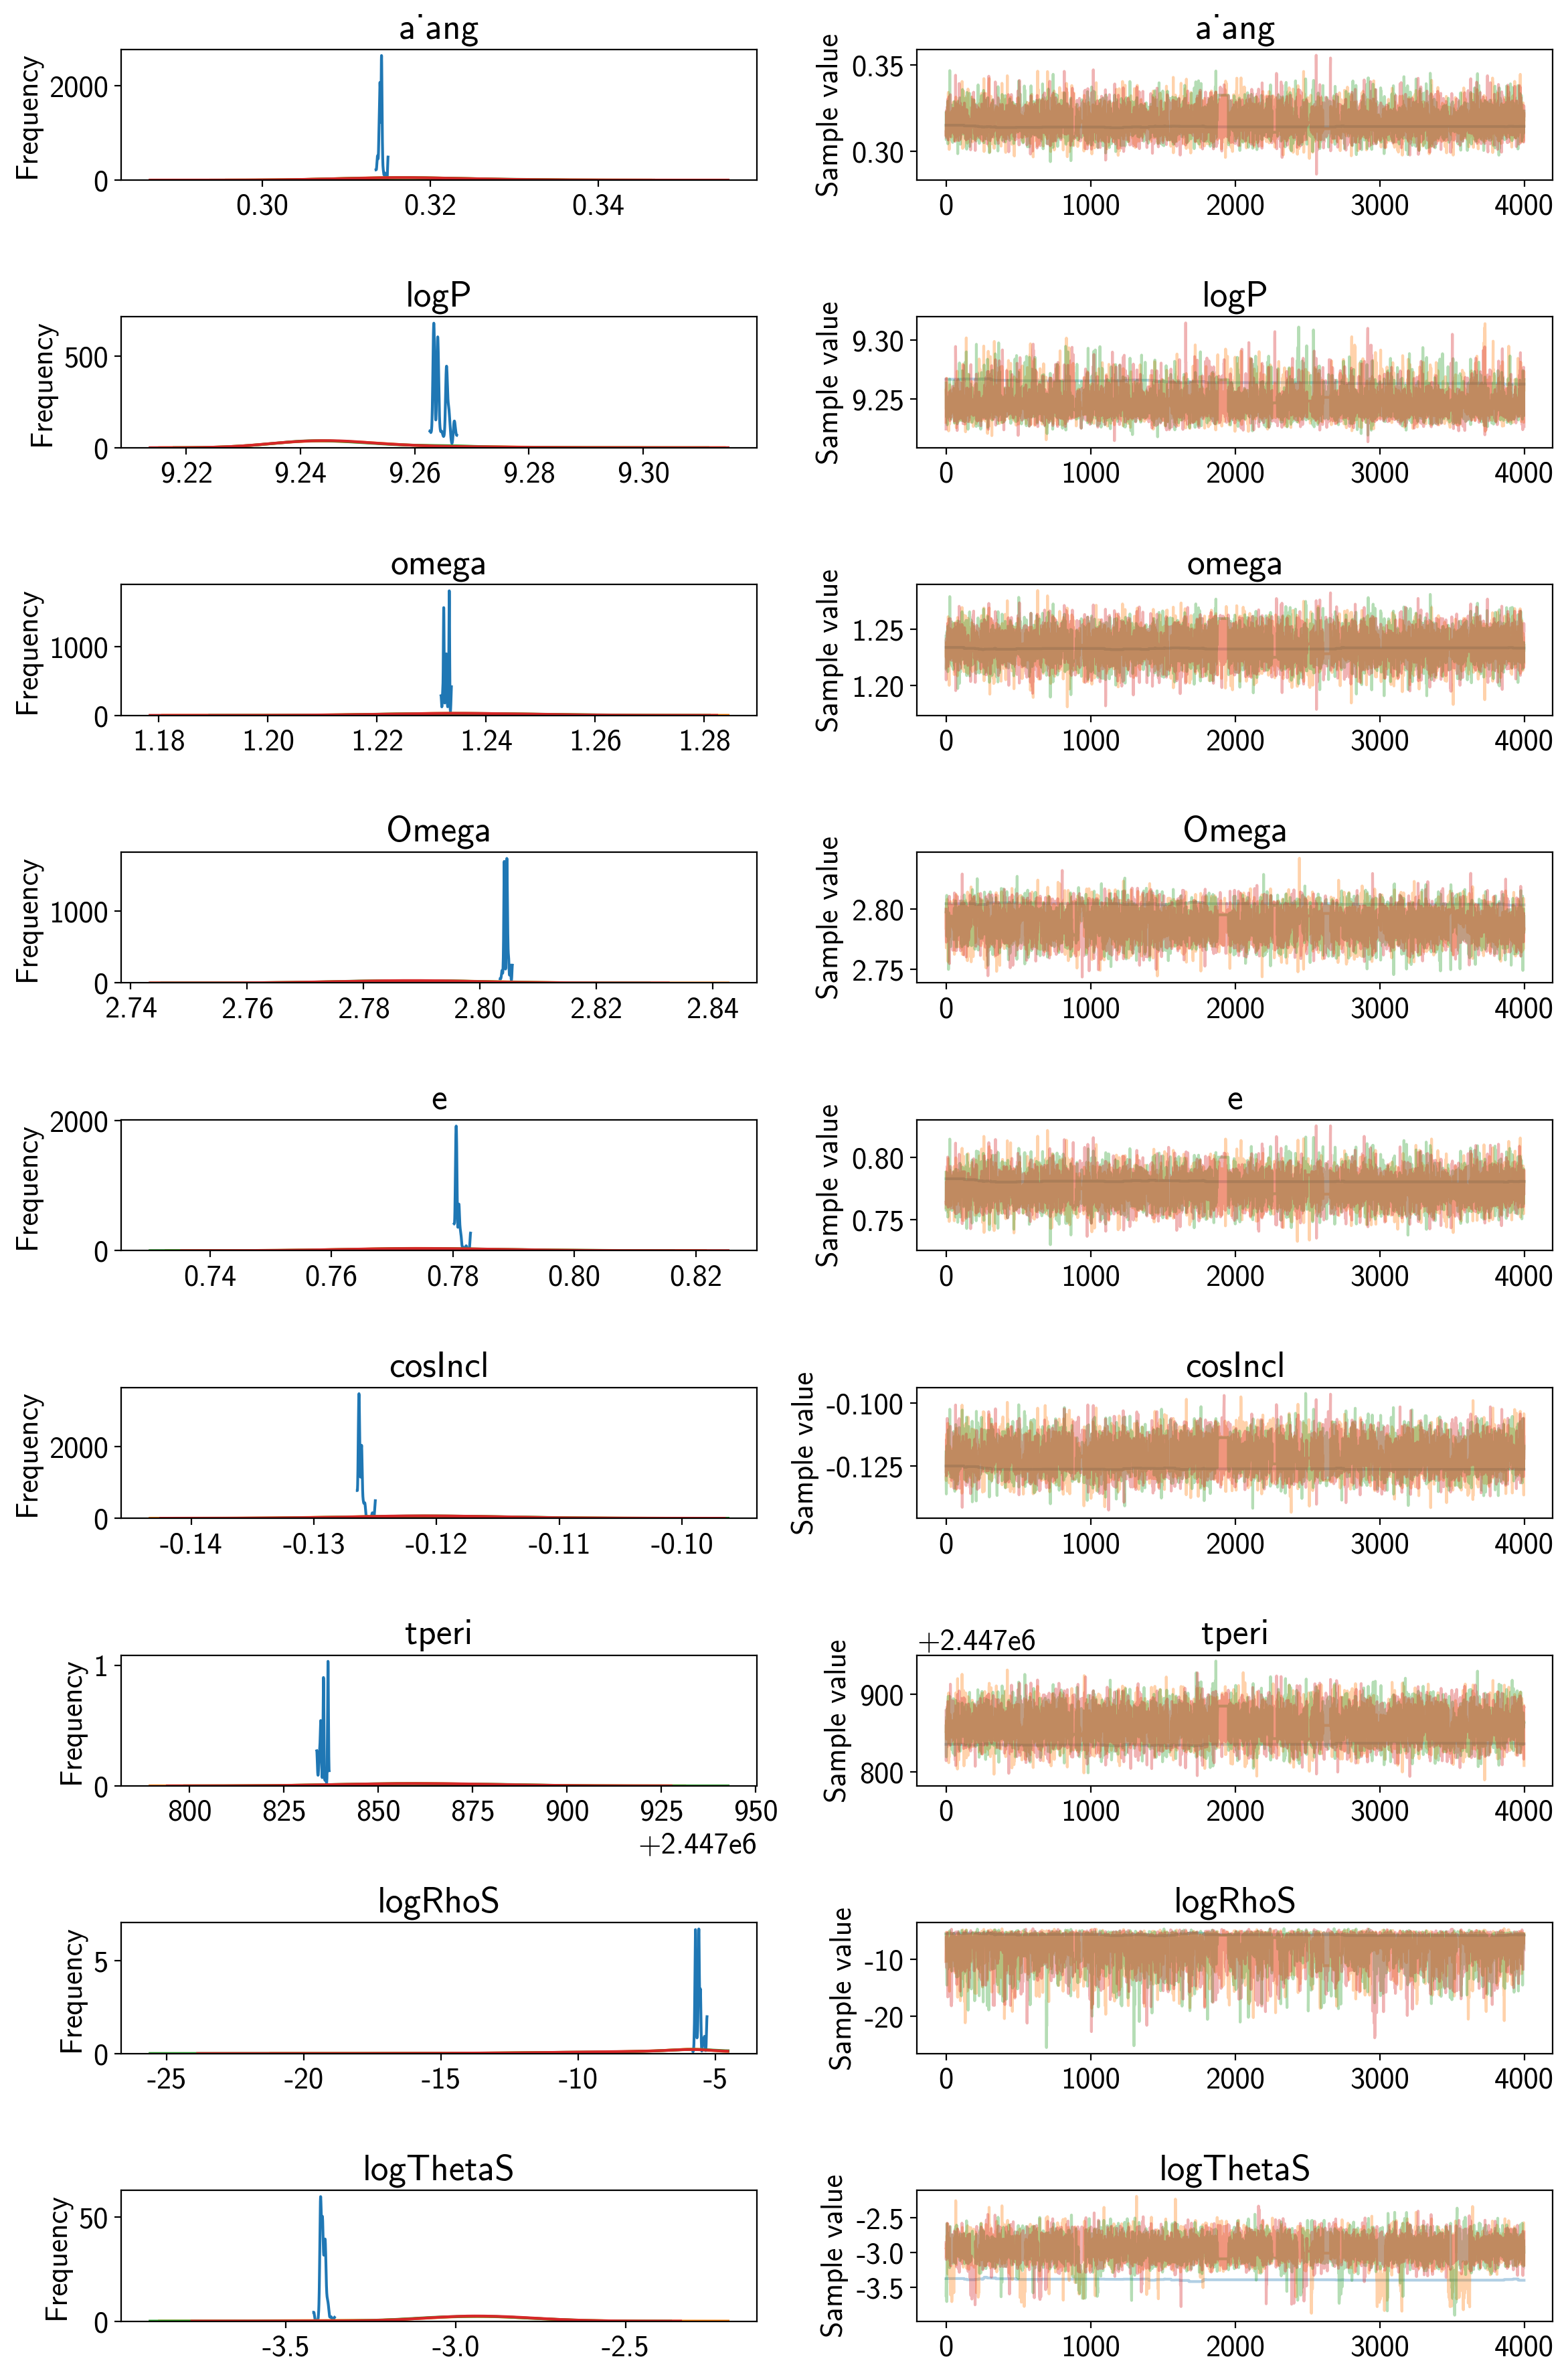

In [18]:
# let's examine the traces of the parameters we've sampled
pm.traceplot(trace, varnames=["a_ang", "logP", "omega", "Omega", "e", "cosIncl", "tperi", "logRhoS", "logThetaS"])

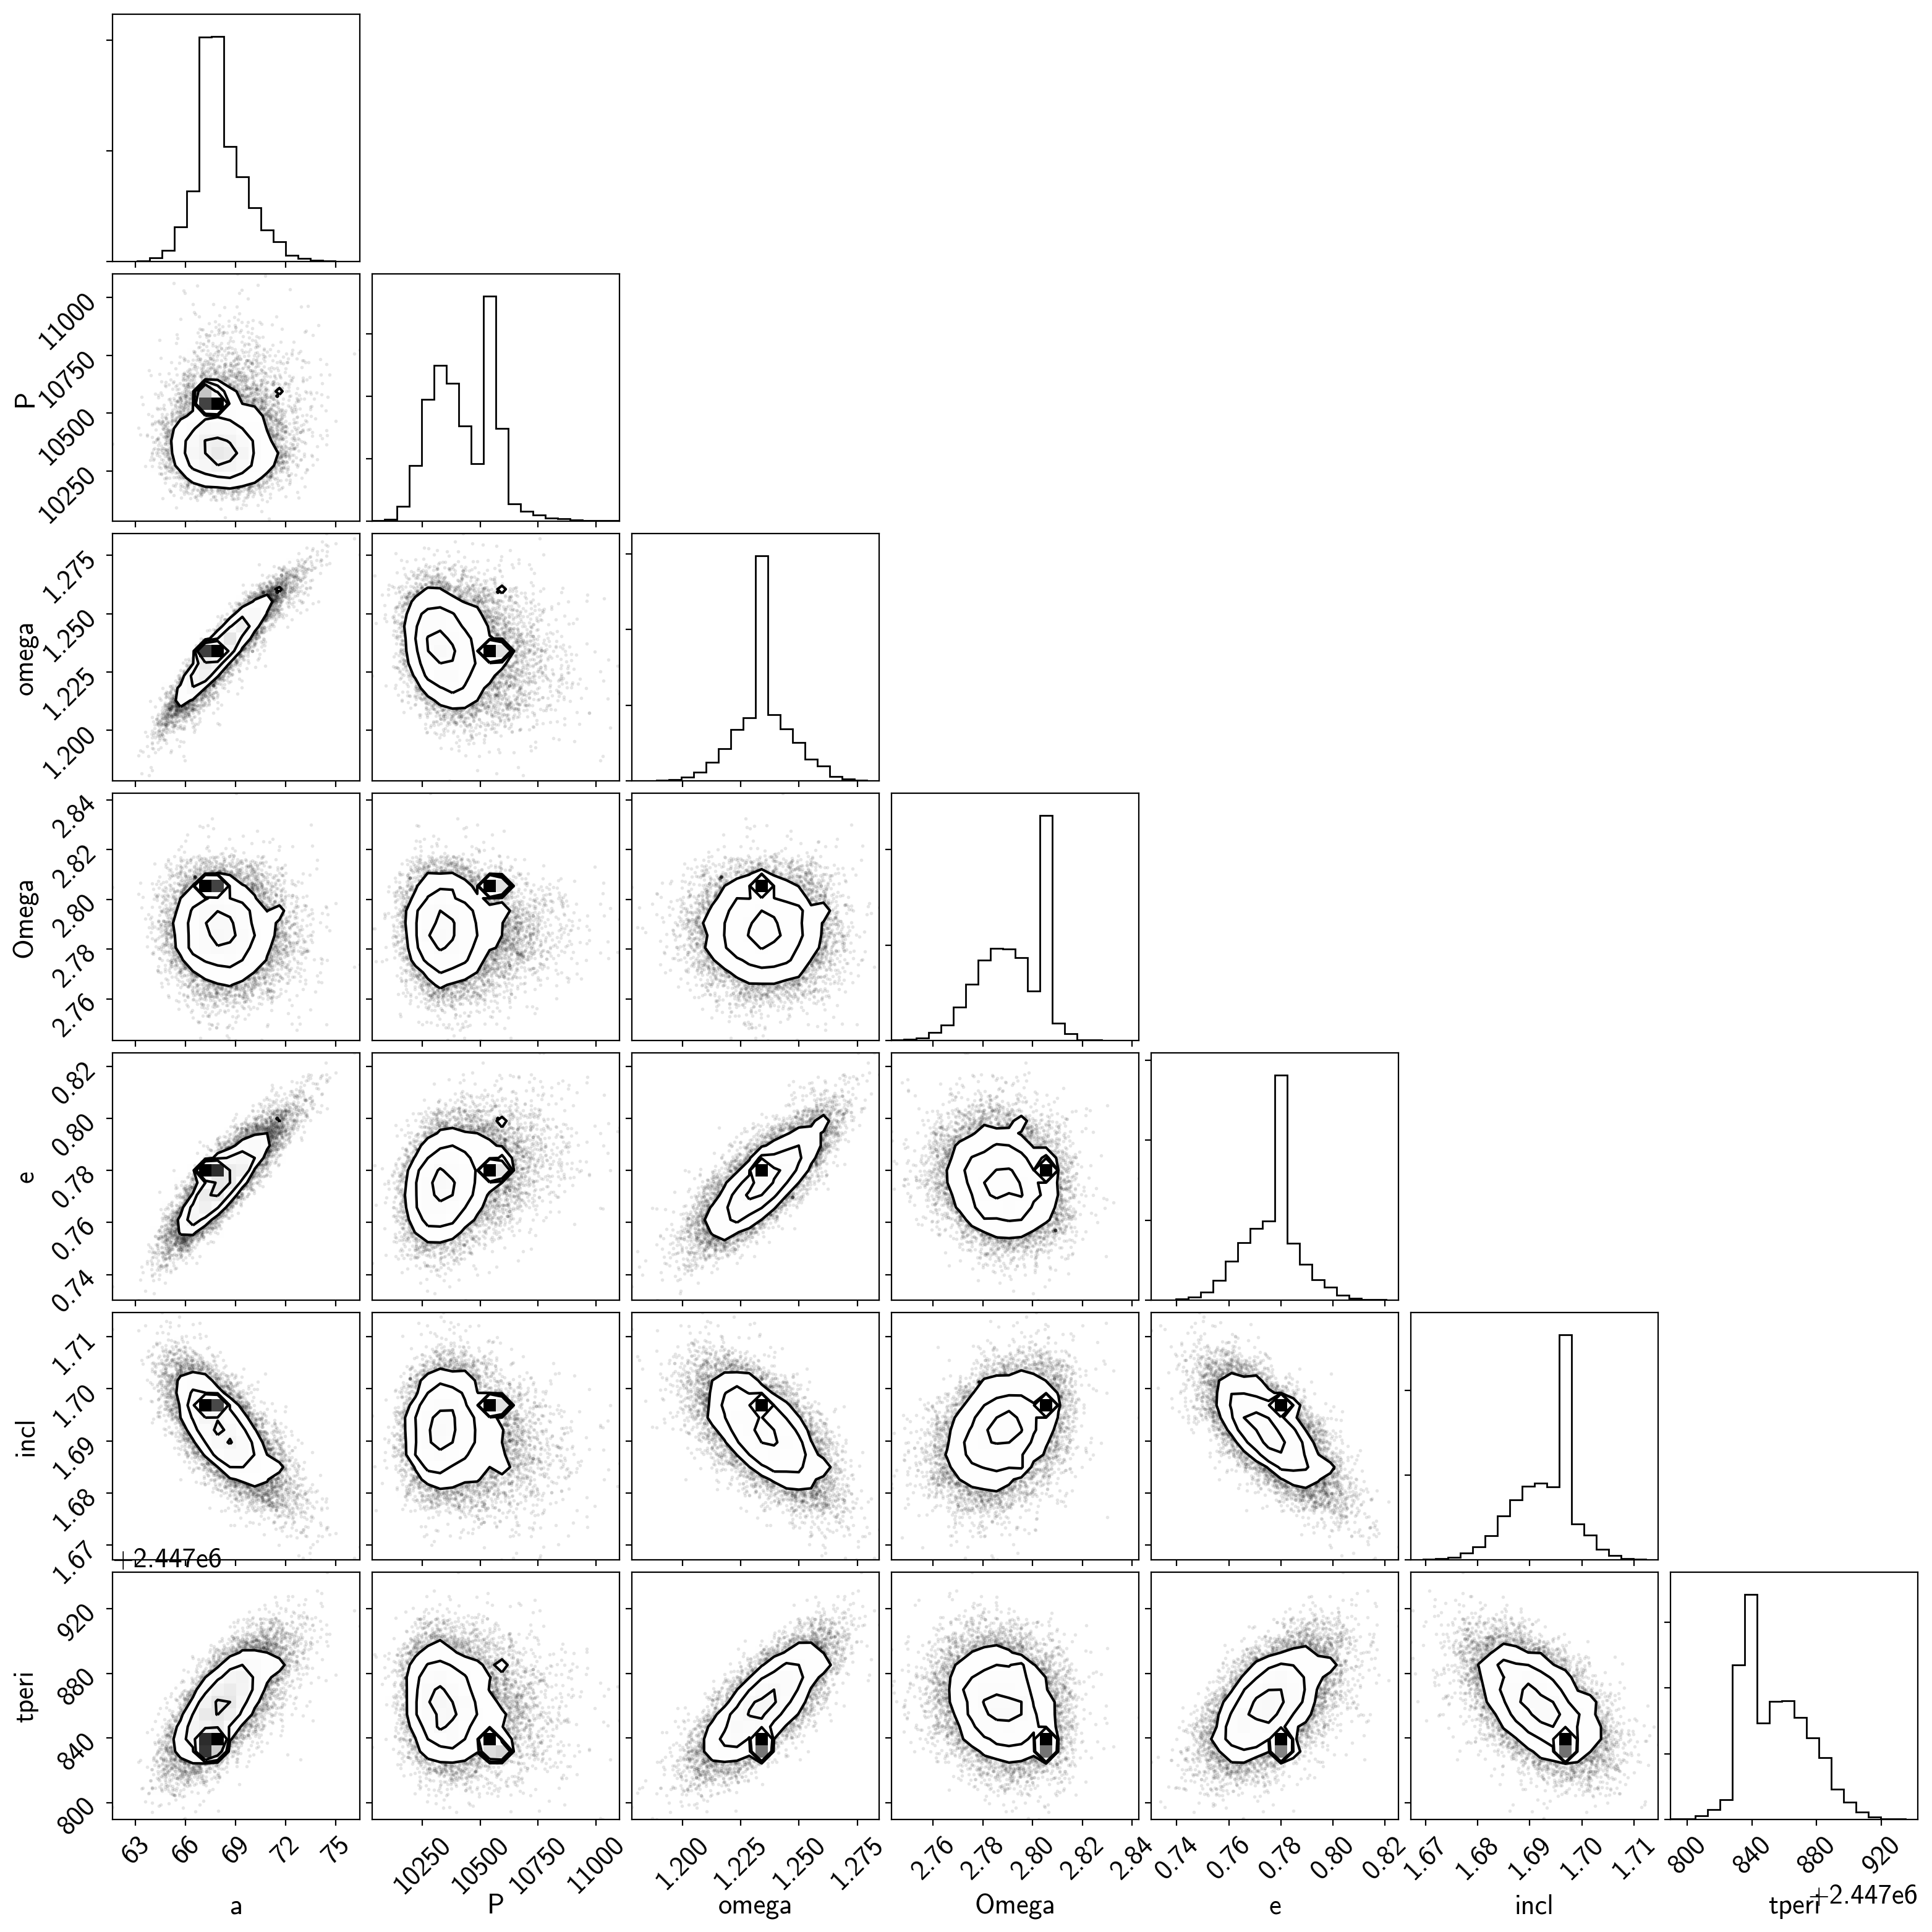

In [19]:
import corner  # https://corner.readthedocs.io

samples = pm.trace_to_dataframe(trace, varnames=["a", "P", "omega", "Omega", "e", "incl", "tperi"])
corner.corner(samples);

Great, it looks like we have a converged posterior, and in a pretty reasonable amount of time too. The semi-major axis and $\omega$ are quite correlated, which underscores the need for using the tuning schedule.


Note that there is also another (degenerate) solution at $\Omega + \pi$ and $\omega + \pi$ that we've missed, because we initialized the sampler deep in the potential well of our preferred peak. If you really do have an astrometric-only orbit, for this reason it can more efficient to sample in $p = \Omega + \omega$ and $m = \Omega - \omega$, since these will yield unambiguous constraints on $p$ and $m$, and $\Omega$ and $\omega$ can be backed out of them.

Let's plot the data with draws of the potential orbit, which we saved during the sampling of the model.

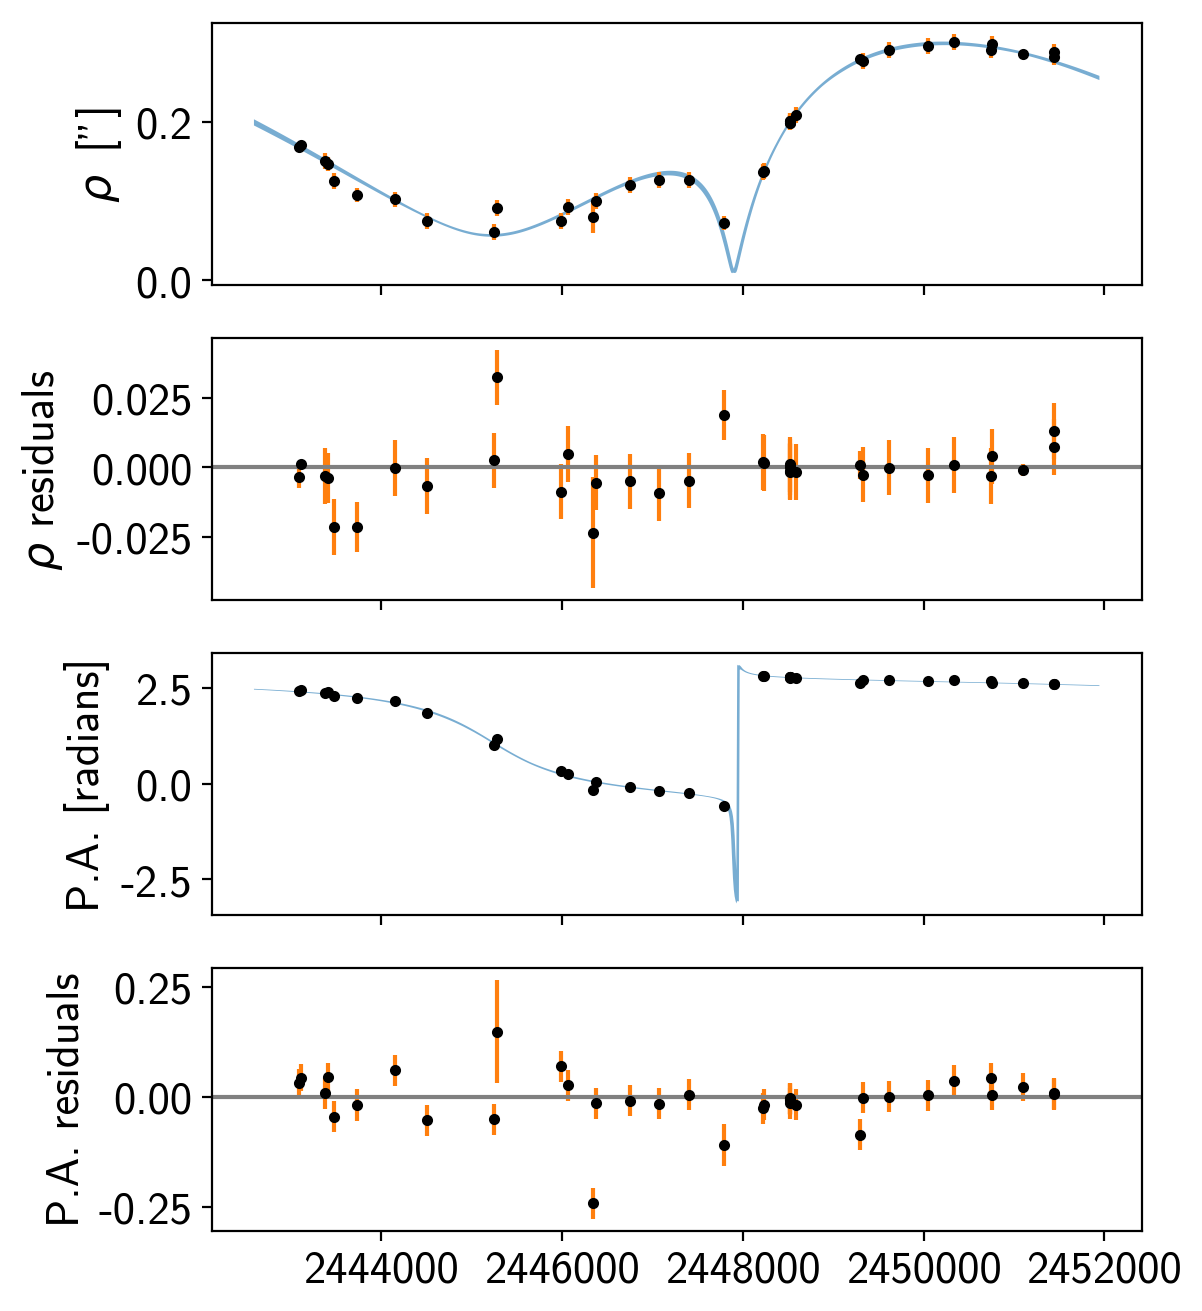

In [20]:
# we can plot the maximum posterior solution to see

pkw = {'marker':".", "color":"k", 'ls':""}
ekw = {'color':"C1", 'ls':""}

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6,8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

# Compute the posterior predictions for the RV model
rho_pred = np.percentile(trace["rhoSave"], [16, 50, 84], axis=0)
theta_pred = np.percentile(trace["thetaSave"], [16, 50, 84], axis=0)

with model:
    tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * map_sol["logRhoS"]))
    tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * map_sol["logThetaS"]))
        
        
    art = ax[0].fill_between(t_fine, rho_pred[0], rho_pred[2], color="C0", alpha=0.6)
    art.set_edgecolor("none")

    ax[0].plot(astro_jds, rho_data, **pkw)
    ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
    
    ax[1].axhline(0.0, color="0.5")
    ax[1].plot(astro_jds, rho_data - xo.eval_in_model(rho_model, map_sol), **pkw)
    ax[1].errorbar(astro_jds, rho_data - xo.eval_in_model(rho_model, map_sol), yerr=tot_rho_err, **ekw)
    
    art = ax[2].fill_between(t_fine, theta_pred[0], theta_pred[2], color="C0", alpha=0.6)
    art.set_edgecolor("none")

    ax[2].plot(astro_jds, theta_data, **pkw)
    ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
    
    ax[3].axhline(0.0, color="0.5")
    ax[3].plot(astro_jds, theta_data - xo.eval_in_model(theta_model, map_sol), **pkw)
    ax[3].errorbar(astro_jds, theta_data - xo.eval_in_model(theta_model, map_sol), yerr=tot_theta_err, **ekw) 

As we can see from the narrow range of orbits (the blue swath appears like a thin blue line), the orbit is actually highly constrained by the astrometry. We also see two clear outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit. It's likely the uncertainties were not estimated correctly for these, and the simlplistic jitter model we implemented isn't sophisticated to apply more weight to only these discrepant points. We can address these with a jitter model.

# Orbital fit with parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truely intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem. 

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.


In [21]:
def calc_Mtot(a, P):
    '''
    Calculate the total mass of the system using Kepler's third law. 
    
    Args: 
        a (au) semi-major axis
        P (days) period 
        
    Returns:
        Mtot (M_sun) total mass of system (M_primary + M_secondary)
    '''
    
    day_to_s = (1 * u.day).to(u.s).value
    au_to_m = (1 * u.au).to(u.m).value
    kg_to_M_sun = (1 * u.kg).to(u.M_sun).value
    
    return 4 * np.pi**2 * (a * au_to_m)**3 / (constants.G.value * (P * day_to_s)**2) * kg_to_M_sun

In [22]:
# Set up the model in PyMC3

with pm.Model() as parallax_model:

    # A setup for a basic astrometric binary orbit
    # We'll include the parallax data as a prior on the parallax value 
    
    mparallax = pm.Normal("mparallax", mu=24.05, sd=0.45) # milliarcsec 
    parallax = pm.Deterministic("parallax", 1e-3 * mparallax) # arcsec
    a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324) # arcsec 
        
    # the semi-major axis in au
    a = pm.Deterministic("a", a_ang / parallax)
        
    # we expect the period to be somewhere in the range of 25 years, 
    # so we'll set a broad prior on logP
    logP = pm.Uniform("logP", lower=np.log(1 * yr), upper=np.log(100* yr), testval=np.log(28.8 * yr))
    P = pm.Deterministic("P", tt.exp(logP)) # days
    
    omega = Angle("omega", testval=251.6 * deg - np.pi) # - pi to pi
    Omega = Angle("Omega", testval=159.6 * deg) # - pi to pi
    
    t_periastron = pm.Uniform("tperi", T0 - P, T0 + P)
    
    # uniform on cos incl
    cos_incl = pm.Uniform("cosIncl", lower=-1.0, upper=1.0, testval=np.cos(96.0 * deg)) # radians, 0 to 180 degrees
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    
    e = pm.Uniform("e", lower=0.0, upper=1.0, testval=0.798)
           
    # n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
    orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=t_periastron, period=P, 
                                   incl=incl, ecc=e, omega=omega, Omega=Omega)

    # now that we have a physical scale defined, the total mass of the system makes sense
    Mtot = pm.Deterministic("Mtot", orbit.m_total)
    
    rho_model, theta_model = orbit.get_relative_angles(astro_jds, parallax) # the rho, theta model values
        
    # add jitter terms to both separation and position angle
    log_rho_s = pm.Normal("logRhoS", mu=np.log(np.median(rho_err)), sd=5.0)
    log_theta_s = pm.Normal("logThetaS", mu=np.log(np.median(theta_err)), sd=5.0)
    
    rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
    theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))
    
    # evaluate the likelihood functions
    pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_tot_err)
    theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
    pm.Normal("obs_theta", mu=theta_diff, observed=zeros, sd=theta_tot_err)

In [23]:
with parallax_model:
    map_sol = xo.optimize()

optimizing logp for variables: ['logThetaS', 'logRhoS', 'e_interval__', 'cosIncl_interval__', 'tperi_interval__', 'Omega_angle__', 'omega_angle__', 'logP_interval__', 'a_ang_interval__', 'mparallax']


message: Optimization terminated successfully.
logp: 105.44710376647649 -> 195.16465253896757


In [24]:
# now let's actually explore the posterior for real
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with parallax_model:
    burnin = sampler.tune(tune=4000, start=model.test_point,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:07, 112.68draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:00<00:08, 91.46draws/s] 

Sampling 4 chains:   3%|▎         | 25/808 [00:00<00:12, 64.45draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:00<00:12, 62.32draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:00<00:13, 55.95draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:00<00:13, 55.03draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:00<00:14, 52.95draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:00<00:14, 51.20draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:01<00:14, 49.97draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:01<00:15, 47.92draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:01<00:14, 52.26draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:01<00:14, 48.74draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:01<00:14, 51.21draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:01<00:14, 48.48draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:01<00:13, 52.56draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:01<00:13, 52.48draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:02<00:13, 50.96draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:02<00:13, 52.19draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:02<00:13, 50.35draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:02<00:13, 51.11draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:02<00:13, 49.48draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:02<00:13, 50.22draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:02<00:12, 51.80draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:02<00:12, 53.68draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:02<00:12, 53.05draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:03<00:12, 51.31draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:03<00:12, 49.80draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:03<00:12, 50.31draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:03<00:13, 47.88draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:03<00:12, 48.98draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:03<00:12, 48.40draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:03<00:13, 45.72draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [00:03<00:11, 50.94draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:04<00:12, 46.01draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:04<00:11, 49.24draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:04<00:12, 48.23draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:04<00:11, 48.36draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:04<00:11, 51.02draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:04<00:11, 49.17draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:04<00:11, 50.70draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:04<00:11, 48.02draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:05<00:10, 50.83draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:05<00:10, 49.67draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:05<00:10, 49.38draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:05<00:10, 51.49draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:05<00:10, 48.87draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [00:05<00:10, 48.63draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:05<00:09, 51.51draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:05<00:10, 48.14draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:06<00:10, 48.23draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:06<00:10, 48.82draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:06<00:10, 45.57draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:06<00:09, 49.30draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:06<00:09, 47.87draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [00:06<00:09, 49.33draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [00:06<00:09, 47.46draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:06<00:09, 50.32draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:06<00:09, 49.51draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [00:07<00:08, 49.89draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:07<00:08, 49.94draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:07<00:08, 49.32draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [00:07<00:08, 50.20draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [00:07<00:08, 49.49draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [00:07<00:08, 49.73draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [00:07<00:08, 46.97draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [00:07<00:08, 48.42draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [00:08<00:08, 48.03draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [00:08<00:07, 49.98draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [00:08<00:07, 50.28draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [00:08<00:07, 51.79draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [00:08<00:07, 52.85draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [00:08<00:07, 49.17draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [00:08<00:07, 51.51draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [00:08<00:07, 48.55draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [00:09<00:06, 54.12draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [00:09<00:06, 50.19draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [00:09<00:06, 54.70draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [00:09<00:06, 49.21draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [00:09<00:06, 53.83draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:09<00:06, 50.04draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [00:09<00:06, 48.73draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [00:09<00:05, 53.15draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [00:10<00:06, 48.47draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [00:10<00:05, 50.00draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [00:10<00:05, 50.44draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [00:10<00:05, 51.19draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [00:10<00:04, 53.46draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [00:10<00:04, 54.06draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [00:10<00:04, 52.52draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [00:10<00:05, 49.57draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [00:11<00:04, 50.08draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [00:11<00:04, 53.93draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [00:11<00:04, 53.55draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [00:11<00:03, 57.34draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [00:11<00:04, 51.89draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [00:11<00:03, 54.96draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [00:11<00:03, 52.26draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [00:11<00:03, 55.33draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [00:12<00:03, 52.59draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [00:12<00:03, 53.30draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [00:12<00:03, 50.23draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [00:12<00:03, 52.66draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [00:12<00:03, 49.97draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [00:12<00:02, 52.60draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [00:12<00:03, 49.88draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [00:12<00:02, 51.38draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [00:13<00:02, 50.02draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [00:13<00:02, 51.00draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [00:13<00:02, 49.28draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [00:13<00:02, 51.34draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [00:13<00:02, 48.67draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [00:13<00:02, 53.51draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [00:13<00:01, 54.32draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [00:13<00:01, 51.87draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [00:13<00:01, 53.51draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [00:14<00:01, 55.47draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [00:14<00:01, 58.53draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [00:14<00:01, 54.21draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [00:14<00:01, 54.79draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [00:14<00:00, 55.70draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [00:14<00:00, 59.08draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [00:14<00:00, 53.93draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [00:14<00:00, 50.80draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [00:15<00:00, 51.24draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [00:15<00:00, 45.92draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [00:15<00:00, 41.91draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [00:15<00:00, 33.43draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:15<00:00, 28.79draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:16<00:00, 22.33draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:16<00:00, 20.42draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:16<00:00, 47.72draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▍         | 17/408 [00:00<00:02, 132.46draws/s]

Sampling 4 chains:   6%|▌         | 23/408 [00:00<00:04, 91.75draws/s] 

Sampling 4 chains:   7%|▋         | 28/408 [00:00<00:05, 71.33draws/s]

Sampling 4 chains:   9%|▊         | 35/408 [00:00<00:05, 70.32draws/s]

Sampling 4 chains:  10%|█         | 42/408 [00:00<00:05, 66.81draws/s]

Sampling 4 chains:  13%|█▎        | 53/408 [00:00<00:04, 72.85draws/s]

Sampling 4 chains:  15%|█▍        | 60/408 [00:00<00:04, 71.72draws/s]

Sampling 4 chains:  17%|█▋        | 68/408 [00:00<00:04, 68.24draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:01<00:04, 71.05draws/s]

Sampling 4 chains:  20%|██        | 83/408 [00:01<00:04, 67.48draws/s]

Sampling 4 chains:  22%|██▏       | 90/408 [00:01<00:04, 64.62draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:01<00:04, 66.26draws/s]

Sampling 4 chains:  26%|██▌       | 107/408 [00:01<00:04, 65.19draws/s]

Sampling 4 chains:  28%|██▊       | 115/408 [00:01<00:04, 66.97draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:01<00:04, 66.06draws/s]

Sampling 4 chains:  32%|███▏      | 132/408 [00:01<00:03, 70.02draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:01<00:03, 70.19draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [00:02<00:04, 64.00draws/s]

Sampling 4 chains:  38%|███▊      | 155/408 [00:02<00:03, 65.59draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [00:02<00:04, 58.35draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:02<00:03, 65.09draws/s]

Sampling 4 chains:  44%|████▎     | 178/408 [00:02<00:03, 59.19draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:02<00:03, 65.78draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [00:02<00:03, 64.77draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:02<00:03, 65.72draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:03<00:03, 62.77draws/s]

Sampling 4 chains:  54%|█████▍    | 220/408 [00:03<00:02, 62.72draws/s]

Sampling 4 chains:  56%|█████▌    | 227/408 [00:03<00:02, 61.11draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:03<00:02, 59.48draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [00:03<00:02, 62.03draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:03<00:02, 58.67draws/s]

Sampling 4 chains:  63%|██████▎   | 256/408 [00:03<00:02, 60.65draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:03<00:02, 59.99draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:04<00:02, 62.22draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:04<00:02, 62.31draws/s]

Sampling 4 chains:  70%|███████   | 286/408 [00:04<00:01, 64.17draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [00:04<00:01, 64.00draws/s]

Sampling 4 chains:  74%|███████▎  | 300/408 [00:04<00:01, 64.27draws/s]

Sampling 4 chains:  75%|███████▌  | 307/408 [00:04<00:01, 64.85draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [00:04<00:01, 67.91draws/s]

Sampling 4 chains:  79%|███████▉  | 322/408 [00:04<00:01, 67.15draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [00:04<00:01, 71.53draws/s]

Sampling 4 chains:  83%|████████▎ | 339/408 [00:05<00:00, 70.15draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [00:05<00:00, 72.09draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [00:05<00:00, 74.23draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:05<00:00, 73.32draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [00:05<00:00, 75.08draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [00:05<00:00, 72.59draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [00:05<00:00, 65.87draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [00:05<00:00, 63.96draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [00:06<00:00, 62.96draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:06<00:00, 64.58draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:00<00:06, 126.23draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:00<00:09, 84.05draws/s] 

Sampling 4 chains:   3%|▎         | 26/808 [00:00<00:10, 71.30draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:00<00:12, 59.87draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:00<00:13, 56.39draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:00<00:14, 53.02draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:00<00:14, 53.34draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:00<00:12, 60.38draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:01<00:10, 67.20draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:01<00:08, 82.54draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:01<00:06, 107.98draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:01<00:04, 138.08draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:01<00:03, 176.37draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:01<00:02, 215.78draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:01<00:01, 256.13draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:01<00:01, 294.95draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [00:01<00:01, 344.70draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [00:01<00:00, 367.48draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [00:02<00:00, 374.08draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [00:02<00:00, 372.60draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [00:02<00:00, 398.86draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [00:02<00:00, 405.34draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [00:02<00:00, 411.72draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [00:02<00:00, 365.10draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [00:02<00:00, 337.37draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:02<00:00, 283.41draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:03<00:00, 265.84draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 16/1608 [00:00<00:13, 119.73draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:00<00:20, 78.39draws/s] 

Sampling 4 chains:   2%|▏         | 27/1608 [00:00<00:23, 68.26draws/s]

Sampling 4 chains:   2%|▏         | 32/1608 [00:00<00:28, 55.28draws/s]

Sampling 4 chains:   2%|▏         | 39/1608 [00:00<00:27, 56.92draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:00<00:29, 53.68draws/s]

Sampling 4 chains:   3%|▎         | 49/1608 [00:00<00:30, 50.84draws/s]

Sampling 4 chains:   4%|▎         | 57/1608 [00:00<00:27, 56.18draws/s]

Sampling 4 chains:   4%|▍         | 67/1608 [00:01<00:24, 64.00draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:01<00:19, 78.67draws/s]

Sampling 4 chains:   7%|▋         | 113/1608 [00:01<00:14, 100.07draws/s]

Sampling 4 chains:  10%|▉         | 153/1608 [00:01<00:11, 128.93draws/s]

Sampling 4 chains:  12%|█▏        | 189/1608 [00:01<00:08, 158.37draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [00:01<00:06, 196.91draws/s]

Sampling 4 chains:  17%|█▋        | 281/1608 [00:01<00:05, 236.41draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [00:01<00:04, 271.93draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [00:01<00:03, 311.98draws/s]

Sampling 4 chains:  26%|██▌       | 417/1608 [00:01<00:03, 340.10draws/s]

Sampling 4 chains:  29%|██▉       | 464/1608 [00:02<00:03, 370.76draws/s]

Sampling 4 chains:  32%|███▏      | 515/1608 [00:02<00:02, 403.49draws/s]

Sampling 4 chains:  35%|███▌      | 567/1608 [00:02<00:02, 432.08draws/s]

Sampling 4 chains:  38%|███▊      | 615/1608 [00:02<00:02, 435.75draws/s]

Sampling 4 chains:  41%|████      | 662/1608 [00:02<00:02, 433.22draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [00:02<00:02, 410.42draws/s]

Sampling 4 chains:  47%|████▋     | 751/1608 [00:02<00:02, 402.09draws/s]

Sampling 4 chains:  50%|████▉     | 797/1608 [00:02<00:01, 416.65draws/s]

Sampling 4 chains:  52%|█████▏    | 840/1608 [00:02<00:01, 392.85draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [00:03<00:01, 393.14draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [00:03<00:01, 415.05draws/s]

Sampling 4 chains:  60%|██████    | 972/1608 [00:03<00:01, 409.40draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [00:03<00:01, 405.86draws/s]

Sampling 4 chains:  66%|██████▌   | 1061/1608 [00:03<00:01, 417.55draws/s]

Sampling 4 chains:  69%|██████▊   | 1105/1608 [00:03<00:01, 421.85draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [00:03<00:01, 441.84draws/s]

Sampling 4 chains:  75%|███████▍  | 1200/1608 [00:03<00:00, 432.23draws/s]

Sampling 4 chains:  77%|███████▋  | 1244/1608 [00:03<00:00, 431.98draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [00:03<00:00, 445.05draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [00:04<00:00, 440.28draws/s]

Sampling 4 chains:  86%|████████▋ | 1389/1608 [00:04<00:00, 458.46draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [00:04<00:00, 457.67draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [00:04<00:00, 410.36draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [00:04<00:00, 341.79draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [00:04<00:00, 259.88draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [00:04<00:00, 242.66draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:05<00:00, 313.71draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 18/3208 [00:00<00:22, 141.54draws/s]

Sampling 4 chains:   1%|          | 24/3208 [00:00<00:34, 92.44draws/s] 

Sampling 4 chains:   1%|          | 29/3208 [00:00<00:43, 72.95draws/s]

Sampling 4 chains:   1%|          | 34/3208 [00:00<00:51, 61.38draws/s]

Sampling 4 chains:   1%|          | 40/3208 [00:00<00:54, 58.31draws/s]

Sampling 4 chains:   1%|▏         | 46/3208 [00:00<00:54, 57.62draws/s]

Sampling 4 chains:   2%|▏         | 52/3208 [00:00<00:56, 56.21draws/s]

Sampling 4 chains:   2%|▏         | 60/3208 [00:00<00:51, 60.56draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:01<00:43, 72.07draws/s]

Sampling 4 chains:   3%|▎         | 93/3208 [00:01<00:35, 88.67draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:01<00:27, 111.03draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:01<00:23, 130.10draws/s]

Sampling 4 chains:   5%|▌         | 174/3208 [00:01<00:19, 156.33draws/s]

Sampling 4 chains:   6%|▌         | 200/3208 [00:01<00:16, 177.28draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [00:01<00:14, 205.33draws/s]

Sampling 4 chains:   9%|▊         | 275/3208 [00:01<00:12, 242.34draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [00:01<00:10, 271.64draws/s]

Sampling 4 chains:  11%|█         | 346/3208 [00:01<00:10, 260.39draws/s]

Sampling 4 chains:  12%|█▏        | 376/3208 [00:02<00:11, 255.73draws/s]

Sampling 4 chains:  13%|█▎        | 410/3208 [00:02<00:10, 275.71draws/s]

Sampling 4 chains:  14%|█▎        | 440/3208 [00:02<00:10, 275.85draws/s]

Sampling 4 chains:  15%|█▍        | 472/3208 [00:02<00:09, 283.18draws/s]

Sampling 4 chains:  16%|█▌        | 502/3208 [00:02<00:09, 286.87draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [00:02<00:09, 274.68draws/s]

Sampling 4 chains:  18%|█▊        | 563/3208 [00:02<00:09, 284.19draws/s]

Sampling 4 chains:  19%|█▊        | 594/3208 [00:02<00:09, 289.93draws/s]

Sampling 4 chains:  19%|█▉        | 624/3208 [00:02<00:08, 288.10draws/s]

Sampling 4 chains:  20%|██        | 657/3208 [00:03<00:08, 297.50draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [00:03<00:08, 289.01draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [00:03<00:08, 308.63draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [00:03<00:07, 318.94draws/s]

Sampling 4 chains:  25%|██▍       | 797/3208 [00:03<00:07, 329.62draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [00:03<00:06, 346.32draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [00:03<00:06, 343.03draws/s]

Sampling 4 chains:  28%|██▊       | 910/3208 [00:03<00:06, 337.31draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [00:03<00:06, 338.29draws/s]

Sampling 4 chains:  31%|███       | 988/3208 [00:03<00:06, 358.47draws/s]

Sampling 4 chains:  32%|███▏      | 1025/3208 [00:04<00:06, 357.44draws/s]

Sampling 4 chains:  33%|███▎      | 1067/3208 [00:04<00:05, 368.59draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [00:04<00:05, 372.13draws/s]

Sampling 4 chains:  36%|███▌      | 1147/3208 [00:04<00:05, 381.15draws/s]

Sampling 4 chains:  37%|███▋      | 1186/3208 [00:04<00:05, 374.93draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [00:04<00:05, 362.45draws/s]

Sampling 4 chains:  39%|███▉      | 1261/3208 [00:04<00:05, 357.10draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [00:04<00:05, 351.81draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [00:04<00:05, 351.37draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [00:05<00:05, 360.05draws/s]

Sampling 4 chains:  44%|████▍     | 1409/3208 [00:05<00:04, 360.11draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [00:05<00:05, 336.45draws/s]

Sampling 4 chains:  46%|████▌     | 1481/3208 [00:05<00:05, 337.40draws/s]

Sampling 4 chains:  48%|████▊     | 1526/3208 [00:05<00:04, 364.35draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [00:05<00:04, 371.22draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [00:05<00:04, 373.28draws/s]

Sampling 4 chains:  51%|█████     | 1641/3208 [00:05<00:04, 374.10draws/s]

Sampling 4 chains:  52%|█████▏    | 1679/3208 [00:05<00:04, 363.14draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [00:05<00:04, 343.65draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [00:06<00:04, 348.49draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [00:06<00:03, 357.22draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [00:06<00:03, 359.77draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [00:06<00:03, 370.82draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [00:06<00:03, 366.11draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [00:06<00:03, 364.84draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [00:06<00:03, 354.91draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [00:06<00:03, 372.59draws/s]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [00:06<00:03, 352.26draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [00:07<00:03, 339.96draws/s]

Sampling 4 chains:  67%|██████▋   | 2137/3208 [00:07<00:03, 345.45draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [00:07<00:03, 344.65draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [00:07<00:02, 342.16draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [00:07<00:02, 343.79draws/s]

Sampling 4 chains:  71%|███████   | 2278/3208 [00:07<00:02, 341.83draws/s]

Sampling 4 chains:  72%|███████▏  | 2313/3208 [00:07<00:02, 341.19draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [00:07<00:02, 328.02draws/s]

Sampling 4 chains:  74%|███████▍  | 2381/3208 [00:07<00:02, 325.42draws/s]

Sampling 4 chains:  75%|███████▌  | 2415/3208 [00:08<00:02, 328.94draws/s]

Sampling 4 chains:  76%|███████▋  | 2451/3208 [00:08<00:02, 336.45draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [00:08<00:02, 329.19draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [00:08<00:01, 345.44draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [00:08<00:01, 352.25draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [00:08<00:01, 351.54draws/s]

Sampling 4 chains:  82%|████████▏ | 2639/3208 [00:08<00:01, 358.16draws/s]

Sampling 4 chains:  84%|████████▎ | 2680/3208 [00:08<00:01, 370.34draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [00:08<00:01, 388.51draws/s]

Sampling 4 chains:  87%|████████▋ | 2775/3208 [00:08<00:01, 414.60draws/s]

Sampling 4 chains:  88%|████████▊ | 2818/3208 [00:09<00:00, 416.10draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [00:09<00:00, 377.45draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [00:09<00:00, 376.33draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [00:09<00:00, 369.61draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [00:09<00:00, 361.25draws/s]

Sampling 4 chains:  94%|█████████▍| 3022/3208 [00:09<00:00, 382.70draws/s]

Sampling 4 chains:  96%|█████████▌| 3064/3208 [00:09<00:00, 389.26draws/s]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [00:09<00:00, 392.39draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [00:09<00:00, 392.85draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [00:10<00:00, 365.09draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:10<00:00, 312.99draws/s]

Sampling 4 chains:   0%|          | 0/9208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 17/9208 [00:00<01:07, 136.64draws/s]

Sampling 4 chains:   0%|          | 23/9208 [00:00<01:34, 96.92draws/s] 

Sampling 4 chains:   0%|          | 28/9208 [00:00<02:16, 67.33draws/s]

Sampling 4 chains:   0%|          | 34/9208 [00:00<02:22, 64.45draws/s]

Sampling 4 chains:   0%|          | 39/9208 [00:00<02:35, 58.83draws/s]

Sampling 4 chains:   0%|          | 44/9208 [00:00<02:56, 51.82draws/s]

Sampling 4 chains:   1%|          | 49/9208 [00:00<03:06, 49.13draws/s]

Sampling 4 chains:   1%|          | 56/9208 [00:00<02:54, 52.33draws/s]

Sampling 4 chains:   1%|          | 66/9208 [00:01<02:31, 60.27draws/s]

Sampling 4 chains:   1%|          | 86/9208 [00:01<02:00, 75.91draws/s]

Sampling 4 chains:   1%|▏         | 118/9208 [00:01<01:32, 98.35draws/s]

Sampling 4 chains:   2%|▏         | 152/9208 [00:01<01:12, 124.99draws/s]

Sampling 4 chains:   2%|▏         | 182/9208 [00:01<00:59, 151.03draws/s]

Sampling 4 chains:   2%|▏         | 207/9208 [00:01<00:56, 159.14draws/s]

Sampling 4 chains:   3%|▎         | 233/9208 [00:01<00:49, 180.02draws/s]

Sampling 4 chains:   3%|▎         | 257/9208 [00:01<00:47, 189.82draws/s]

Sampling 4 chains:   3%|▎         | 285/9208 [00:01<00:43, 206.92draws/s]

Sampling 4 chains:   3%|▎         | 321/9208 [00:01<00:37, 236.80draws/s]

Sampling 4 chains:   4%|▍         | 369/9208 [00:02<00:31, 277.96draws/s]

Sampling 4 chains:   5%|▍         | 415/9208 [00:02<00:28, 313.93draws/s]

Sampling 4 chains:   5%|▍         | 452/9208 [00:02<00:27, 314.74draws/s]

Sampling 4 chains:   5%|▌         | 491/9208 [00:02<00:26, 331.23draws/s]

Sampling 4 chains:   6%|▌         | 527/9208 [00:02<00:26, 325.45draws/s]

Sampling 4 chains:   6%|▌         | 562/9208 [00:02<00:26, 325.90draws/s]

Sampling 4 chains:   7%|▋         | 604/9208 [00:02<00:24, 344.35draws/s]

Sampling 4 chains:   7%|▋         | 644/9208 [00:02<00:24, 354.58draws/s]

Sampling 4 chains:   7%|▋         | 689/9208 [00:02<00:22, 377.46draws/s]

Sampling 4 chains:   8%|▊         | 728/9208 [00:03<00:22, 378.55draws/s]

Sampling 4 chains:   8%|▊         | 774/9208 [00:03<00:21, 395.10draws/s]

Sampling 4 chains:   9%|▉         | 820/9208 [00:03<00:20, 412.45draws/s]

Sampling 4 chains:   9%|▉         | 862/9208 [00:03<00:21, 394.66draws/s]

Sampling 4 chains:  10%|▉         | 904/9208 [00:03<00:21, 394.13draws/s]

Sampling 4 chains:  10%|█         | 947/9208 [00:03<00:20, 400.15draws/s]

Sampling 4 chains:  11%|█         | 992/9208 [00:03<00:19, 413.47draws/s]

Sampling 4 chains:  11%|█         | 1034/9208 [00:03<00:20, 400.79draws/s]

Sampling 4 chains:  12%|█▏        | 1075/9208 [00:03<00:21, 385.45draws/s]

Sampling 4 chains:  12%|█▏        | 1114/9208 [00:04<00:21, 385.19draws/s]

Sampling 4 chains:  13%|█▎        | 1157/9208 [00:04<00:20, 396.02draws/s]

Sampling 4 chains:  13%|█▎        | 1198/9208 [00:04<00:20, 399.83draws/s]

Sampling 4 chains:  13%|█▎        | 1239/9208 [00:04<00:19, 402.66draws/s]

Sampling 4 chains:  14%|█▍        | 1280/9208 [00:04<00:20, 386.39draws/s]

Sampling 4 chains:  14%|█▍        | 1319/9208 [00:04<00:20, 384.95draws/s]

Sampling 4 chains:  15%|█▍        | 1363/9208 [00:04<00:19, 397.97draws/s]

Sampling 4 chains:  15%|█▌        | 1405/9208 [00:04<00:19, 403.31draws/s]

Sampling 4 chains:  16%|█▌        | 1446/9208 [00:04<00:19, 399.01draws/s]

Sampling 4 chains:  16%|█▌        | 1487/9208 [00:04<00:19, 387.05draws/s]

Sampling 4 chains:  17%|█▋        | 1533/9208 [00:05<00:19, 398.65draws/s]

Sampling 4 chains:  17%|█▋        | 1574/9208 [00:05<00:19, 389.94draws/s]

Sampling 4 chains:  18%|█▊        | 1616/9208 [00:05<00:19, 396.75draws/s]

Sampling 4 chains:  18%|█▊        | 1656/9208 [00:05<00:19, 385.20draws/s]

Sampling 4 chains:  18%|█▊        | 1697/9208 [00:05<00:19, 390.69draws/s]

Sampling 4 chains:  19%|█▉        | 1737/9208 [00:05<00:19, 387.16draws/s]

Sampling 4 chains:  19%|█▉        | 1776/9208 [00:05<00:19, 385.58draws/s]

Sampling 4 chains:  20%|█▉        | 1826/9208 [00:05<00:17, 412.34draws/s]

Sampling 4 chains:  20%|██        | 1868/9208 [00:05<00:18, 405.06draws/s]

Sampling 4 chains:  21%|██        | 1909/9208 [00:05<00:17, 406.02draws/s]

Sampling 4 chains:  21%|██        | 1950/9208 [00:06<00:18, 401.98draws/s]

Sampling 4 chains:  22%|██▏       | 1991/9208 [00:06<00:17, 402.25draws/s]

Sampling 4 chains:  22%|██▏       | 2035/9208 [00:06<00:17, 409.87draws/s]

Sampling 4 chains:  23%|██▎       | 2077/9208 [00:06<00:17, 412.08draws/s]

Sampling 4 chains:  23%|██▎       | 2123/9208 [00:06<00:16, 424.78draws/s]

Sampling 4 chains:  24%|██▎       | 2175/9208 [00:06<00:15, 444.57draws/s]

Sampling 4 chains:  24%|██▍       | 2221/9208 [00:06<00:15, 446.73draws/s]

Sampling 4 chains:  25%|██▍       | 2266/9208 [00:06<00:16, 430.50draws/s]

Sampling 4 chains:  25%|██▌       | 2311/9208 [00:06<00:15, 432.95draws/s]

Sampling 4 chains:  26%|██▌       | 2355/9208 [00:07<00:16, 428.11draws/s]

Sampling 4 chains:  26%|██▌       | 2398/9208 [00:07<00:16, 417.94draws/s]

Sampling 4 chains:  27%|██▋       | 2441/9208 [00:07<00:16, 418.69draws/s]

Sampling 4 chains:  27%|██▋       | 2487/9208 [00:07<00:15, 426.49draws/s]

Sampling 4 chains:  27%|██▋       | 2530/9208 [00:07<00:15, 419.01draws/s]

Sampling 4 chains:  28%|██▊       | 2573/9208 [00:07<00:15, 421.76draws/s]

Sampling 4 chains:  28%|██▊       | 2621/9208 [00:07<00:15, 436.11draws/s]

Sampling 4 chains:  29%|██▉       | 2668/9208 [00:07<00:14, 445.46draws/s]

Sampling 4 chains:  29%|██▉       | 2713/9208 [00:07<00:15, 423.79draws/s]

Sampling 4 chains:  30%|██▉       | 2756/9208 [00:07<00:15, 417.82draws/s]

Sampling 4 chains:  30%|███       | 2799/9208 [00:08<00:15, 412.60draws/s]

Sampling 4 chains:  31%|███       | 2841/9208 [00:08<00:15, 408.71draws/s]

Sampling 4 chains:  31%|███▏      | 2884/9208 [00:08<00:15, 409.46draws/s]

Sampling 4 chains:  32%|███▏      | 2926/9208 [00:08<00:15, 411.72draws/s]

Sampling 4 chains:  32%|███▏      | 2969/9208 [00:08<00:14, 416.63draws/s]

Sampling 4 chains:  33%|███▎      | 3015/9208 [00:08<00:14, 427.97draws/s]

Sampling 4 chains:  33%|███▎      | 3058/9208 [00:08<00:14, 422.32draws/s]

Sampling 4 chains:  34%|███▎      | 3101/9208 [00:08<00:14, 422.88draws/s]

Sampling 4 chains:  34%|███▍      | 3144/9208 [00:08<00:14, 423.89draws/s]

Sampling 4 chains:  35%|███▍      | 3188/9208 [00:09<00:14, 428.23draws/s]

Sampling 4 chains:  35%|███▌      | 3231/9208 [00:09<00:14, 420.27draws/s]

Sampling 4 chains:  36%|███▌      | 3280/9208 [00:09<00:13, 435.77draws/s]

Sampling 4 chains:  36%|███▌      | 3329/9208 [00:09<00:13, 449.45draws/s]

Sampling 4 chains:  37%|███▋      | 3375/9208 [00:09<00:12, 451.65draws/s]

Sampling 4 chains:  37%|███▋      | 3421/9208 [00:09<00:13, 439.33draws/s]

Sampling 4 chains:  38%|███▊      | 3466/9208 [00:09<00:13, 424.10draws/s]

Sampling 4 chains:  38%|███▊      | 3512/9208 [00:09<00:13, 430.16draws/s]

Sampling 4 chains:  39%|███▊      | 3557/9208 [00:09<00:13, 434.42draws/s]

Sampling 4 chains:  39%|███▉      | 3601/9208 [00:09<00:12, 433.05draws/s]

Sampling 4 chains:  40%|███▉      | 3645/9208 [00:10<00:12, 429.21draws/s]

Sampling 4 chains:  40%|████      | 3699/9208 [00:10<00:12, 456.60draws/s]

Sampling 4 chains:  41%|████      | 3748/9208 [00:10<00:11, 465.85draws/s]

Sampling 4 chains:  41%|████      | 3797/9208 [00:10<00:11, 471.21draws/s]

Sampling 4 chains:  42%|████▏     | 3845/9208 [00:10<00:11, 468.05draws/s]

Sampling 4 chains:  42%|████▏     | 3893/9208 [00:10<00:11, 463.69draws/s]

Sampling 4 chains:  43%|████▎     | 3940/9208 [00:10<00:12, 429.02draws/s]

Sampling 4 chains:  43%|████▎     | 3984/9208 [00:10<00:12, 427.40draws/s]

Sampling 4 chains:  44%|████▎     | 4028/9208 [00:10<00:12, 407.09draws/s]

Sampling 4 chains:  44%|████▍     | 4070/9208 [00:11<00:12, 405.50draws/s]

Sampling 4 chains:  45%|████▍     | 4111/9208 [00:11<00:12, 401.60draws/s]

Sampling 4 chains:  45%|████▌     | 4152/9208 [00:11<00:12, 397.25draws/s]

Sampling 4 chains:  46%|████▌     | 4193/9208 [00:11<00:12, 398.59draws/s]

Sampling 4 chains:  46%|████▌     | 4236/9208 [00:11<00:12, 406.42draws/s]

Sampling 4 chains:  46%|████▋     | 4279/9208 [00:11<00:11, 412.33draws/s]

Sampling 4 chains:  47%|████▋     | 4321/9208 [00:11<00:11, 414.11draws/s]

Sampling 4 chains:  47%|████▋     | 4363/9208 [00:11<00:11, 410.84draws/s]

Sampling 4 chains:  48%|████▊     | 4405/9208 [00:11<00:11, 403.27draws/s]

Sampling 4 chains:  48%|████▊     | 4449/9208 [00:11<00:11, 411.33draws/s]

Sampling 4 chains:  49%|████▉     | 4496/9208 [00:12<00:11, 425.67draws/s]

Sampling 4 chains:  49%|████▉     | 4539/9208 [00:12<00:11, 419.97draws/s]

Sampling 4 chains:  50%|████▉     | 4586/9208 [00:12<00:10, 433.26draws/s]

Sampling 4 chains:  50%|█████     | 4630/9208 [00:12<00:10, 426.77draws/s]

Sampling 4 chains:  51%|█████     | 4673/9208 [00:12<00:10, 414.38draws/s]

Sampling 4 chains:  51%|█████▏    | 4721/9208 [00:12<00:10, 430.34draws/s]

Sampling 4 chains:  52%|█████▏    | 4765/9208 [00:12<00:10, 432.98draws/s]

Sampling 4 chains:  52%|█████▏    | 4811/9208 [00:12<00:09, 439.80draws/s]

Sampling 4 chains:  53%|█████▎    | 4859/9208 [00:12<00:09, 449.23draws/s]

Sampling 4 chains:  53%|█████▎    | 4905/9208 [00:12<00:09, 442.69draws/s]

Sampling 4 chains:  54%|█████▍    | 4950/9208 [00:13<00:10, 424.36draws/s]

Sampling 4 chains:  54%|█████▍    | 4993/9208 [00:13<00:10, 411.21draws/s]

Sampling 4 chains:  55%|█████▍    | 5035/9208 [00:13<00:10, 407.71draws/s]

Sampling 4 chains:  55%|█████▌    | 5076/9208 [00:13<00:10, 405.96draws/s]

Sampling 4 chains:  56%|█████▌    | 5118/9208 [00:13<00:09, 409.34draws/s]

Sampling 4 chains:  56%|█████▌    | 5169/9208 [00:13<00:09, 434.02draws/s]

Sampling 4 chains:  57%|█████▋    | 5213/9208 [00:13<00:09, 428.13draws/s]

Sampling 4 chains:  57%|█████▋    | 5258/9208 [00:13<00:09, 431.49draws/s]

Sampling 4 chains:  58%|█████▊    | 5302/9208 [00:13<00:09, 421.18draws/s]

Sampling 4 chains:  58%|█████▊    | 5346/9208 [00:14<00:09, 424.19draws/s]

Sampling 4 chains:  59%|█████▊    | 5389/9208 [00:14<00:08, 425.33draws/s]

Sampling 4 chains:  59%|█████▉    | 5432/9208 [00:14<00:09, 419.04draws/s]

Sampling 4 chains:  59%|█████▉    | 5475/9208 [00:14<00:08, 420.61draws/s]

Sampling 4 chains:  60%|█████▉    | 5519/9208 [00:14<00:08, 420.98draws/s]

Sampling 4 chains:  60%|██████    | 5563/9208 [00:14<00:08, 426.18draws/s]

Sampling 4 chains:  61%|██████    | 5606/9208 [00:14<00:08, 421.00draws/s]

Sampling 4 chains:  61%|██████▏   | 5654/9208 [00:14<00:08, 436.39draws/s]

Sampling 4 chains:  62%|██████▏   | 5698/9208 [00:14<00:08, 425.73draws/s]

Sampling 4 chains:  62%|██████▏   | 5744/9208 [00:14<00:07, 434.50draws/s]

Sampling 4 chains:  63%|██████▎   | 5792/9208 [00:15<00:07, 439.72draws/s]

Sampling 4 chains:  63%|██████▎   | 5837/9208 [00:15<00:07, 431.25draws/s]

Sampling 4 chains:  64%|██████▍   | 5881/9208 [00:15<00:07, 425.28draws/s]

Sampling 4 chains:  64%|██████▍   | 5933/9208 [00:15<00:07, 448.68draws/s]

Sampling 4 chains:  65%|██████▍   | 5979/9208 [00:15<00:07, 451.27draws/s]

Sampling 4 chains:  65%|██████▌   | 6025/9208 [00:15<00:07, 443.54draws/s]

Sampling 4 chains:  66%|██████▌   | 6070/9208 [00:15<00:07, 432.99draws/s]

Sampling 4 chains:  66%|██████▋   | 6114/9208 [00:15<00:07, 427.83draws/s]

Sampling 4 chains:  67%|██████▋   | 6157/9208 [00:15<00:07, 416.07draws/s]

Sampling 4 chains:  67%|██████▋   | 6199/9208 [00:16<00:07, 390.20draws/s]

Sampling 4 chains:  68%|██████▊   | 6239/9208 [00:16<00:07, 379.69draws/s]

Sampling 4 chains:  68%|██████▊   | 6278/9208 [00:16<00:07, 376.59draws/s]

Sampling 4 chains:  69%|██████▊   | 6319/9208 [00:16<00:07, 383.55draws/s]

Sampling 4 chains:  69%|██████▉   | 6363/9208 [00:16<00:07, 398.78draws/s]

Sampling 4 chains:  70%|██████▉   | 6409/9208 [00:16<00:06, 415.31draws/s]

Sampling 4 chains:  70%|███████   | 6455/9208 [00:16<00:06, 427.45draws/s]

Sampling 4 chains:  71%|███████   | 6499/9208 [00:16<00:06, 430.74draws/s]

Sampling 4 chains:  71%|███████   | 6546/9208 [00:16<00:06, 439.79draws/s]

Sampling 4 chains:  72%|███████▏  | 6591/9208 [00:16<00:05, 437.27draws/s]

Sampling 4 chains:  72%|███████▏  | 6635/9208 [00:17<00:06, 419.70draws/s]

Sampling 4 chains:  73%|███████▎  | 6680/9208 [00:17<00:05, 425.83draws/s]

Sampling 4 chains:  73%|███████▎  | 6727/9208 [00:17<00:05, 438.15draws/s]

Sampling 4 chains:  74%|███████▎  | 6774/9208 [00:17<00:05, 446.00draws/s]

Sampling 4 chains:  74%|███████▍  | 6819/9208 [00:17<00:05, 441.21draws/s]

Sampling 4 chains:  75%|███████▍  | 6865/9208 [00:17<00:05, 443.99draws/s]

Sampling 4 chains:  75%|███████▌  | 6910/9208 [00:17<00:05, 431.68draws/s]

Sampling 4 chains:  76%|███████▌  | 6954/9208 [00:17<00:05, 432.59draws/s]

Sampling 4 chains:  76%|███████▌  | 6998/9208 [00:17<00:05, 427.44draws/s]

Sampling 4 chains:  77%|███████▋  | 7045/9208 [00:18<00:04, 436.72draws/s]

Sampling 4 chains:  77%|███████▋  | 7092/9208 [00:18<00:04, 444.50draws/s]

Sampling 4 chains:  78%|███████▊  | 7137/9208 [00:18<00:04, 440.11draws/s]

Sampling 4 chains:  78%|███████▊  | 7182/9208 [00:18<00:04, 437.65draws/s]

Sampling 4 chains:  78%|███████▊  | 7227/9208 [00:18<00:04, 441.02draws/s]

Sampling 4 chains:  79%|███████▉  | 7274/9208 [00:18<00:04, 446.83draws/s]

Sampling 4 chains:  79%|███████▉  | 7320/9208 [00:18<00:04, 450.05draws/s]

Sampling 4 chains:  80%|███████▉  | 7366/9208 [00:18<00:04, 443.43draws/s]

Sampling 4 chains:  80%|████████  | 7411/9208 [00:18<00:04, 439.98draws/s]

Sampling 4 chains:  81%|████████  | 7457/9208 [00:18<00:03, 445.76draws/s]

Sampling 4 chains:  81%|████████▏ | 7502/9208 [00:19<00:03, 442.46draws/s]

Sampling 4 chains:  82%|████████▏ | 7549/9208 [00:19<00:03, 449.80draws/s]

Sampling 4 chains:  82%|████████▏ | 7595/9208 [00:19<00:03, 449.29draws/s]

Sampling 4 chains:  83%|████████▎ | 7640/9208 [00:19<00:03, 431.24draws/s]

Sampling 4 chains:  83%|████████▎ | 7684/9208 [00:19<00:03, 418.82draws/s]

Sampling 4 chains:  84%|████████▍ | 7727/9208 [00:19<00:03, 419.21draws/s]

Sampling 4 chains:  84%|████████▍ | 7774/9208 [00:19<00:03, 432.68draws/s]

Sampling 4 chains:  85%|████████▍ | 7821/9208 [00:19<00:03, 438.13draws/s]

Sampling 4 chains:  85%|████████▌ | 7865/9208 [00:19<00:03, 438.62draws/s]

Sampling 4 chains:  86%|████████▌ | 7909/9208 [00:20<00:03, 417.99draws/s]

Sampling 4 chains:  86%|████████▋ | 7952/9208 [00:20<00:02, 420.60draws/s]

Sampling 4 chains:  87%|████████▋ | 8002/9208 [00:20<00:02, 436.53draws/s]

Sampling 4 chains:  87%|████████▋ | 8047/9208 [00:20<00:02, 438.87draws/s]

Sampling 4 chains:  88%|████████▊ | 8092/9208 [00:20<00:02, 430.25draws/s]

Sampling 4 chains:  88%|████████▊ | 8136/9208 [00:20<00:02, 427.71draws/s]

Sampling 4 chains:  89%|████████▉ | 8179/9208 [00:20<00:02, 427.96draws/s]

Sampling 4 chains:  89%|████████▉ | 8224/9208 [00:20<00:02, 431.74draws/s]

Sampling 4 chains:  90%|████████▉ | 8269/9208 [00:20<00:02, 434.51draws/s]

Sampling 4 chains:  90%|█████████ | 8316/9208 [00:20<00:02, 440.95draws/s]

Sampling 4 chains:  91%|█████████ | 8364/9208 [00:21<00:01, 448.81draws/s]

Sampling 4 chains:  91%|█████████▏| 8409/9208 [00:21<00:01, 437.10draws/s]

Sampling 4 chains:  92%|█████████▏| 8453/9208 [00:21<00:01, 429.52draws/s]

Sampling 4 chains:  92%|█████████▏| 8497/9208 [00:21<00:01, 403.64draws/s]

Sampling 4 chains:  93%|█████████▎| 8538/9208 [00:21<00:01, 390.76draws/s]

Sampling 4 chains:  93%|█████████▎| 8582/9208 [00:21<00:01, 402.23draws/s]

Sampling 4 chains:  94%|█████████▎| 8624/9208 [00:21<00:01, 404.10draws/s]

Sampling 4 chains:  94%|█████████▍| 8669/9208 [00:21<00:01, 416.48draws/s]

Sampling 4 chains:  95%|█████████▍| 8711/9208 [00:21<00:01, 408.84draws/s]

Sampling 4 chains:  95%|█████████▌| 8755/9208 [00:22<00:01, 417.23draws/s]

Sampling 4 chains:  96%|█████████▌| 8798/9208 [00:22<00:00, 420.36draws/s]

Sampling 4 chains:  96%|█████████▌| 8841/9208 [00:22<00:00, 410.49draws/s]

Sampling 4 chains:  96%|█████████▋| 8883/9208 [00:22<00:00, 408.30draws/s]

Sampling 4 chains:  97%|█████████▋| 8924/9208 [00:22<00:00, 395.95draws/s]

Sampling 4 chains:  97%|█████████▋| 8964/9208 [00:22<00:00, 359.33draws/s]

Sampling 4 chains:  98%|█████████▊| 9001/9208 [00:22<00:00, 346.60draws/s]

Sampling 4 chains:  98%|█████████▊| 9037/9208 [00:22<00:00, 312.34draws/s]

Sampling 4 chains:  99%|█████████▊| 9070/9208 [00:23<00:00, 206.94draws/s]

Sampling 4 chains:  99%|█████████▉| 9097/9208 [00:23<00:00, 160.12draws/s]

Sampling 4 chains:  99%|█████████▉| 9119/9208 [00:23<00:00, 136.61draws/s]

Sampling 4 chains:  99%|█████████▉| 9138/9208 [00:23<00:00, 137.99draws/s]

Sampling 4 chains:  99%|█████████▉| 9155/9208 [00:23<00:00, 123.40draws/s]

Sampling 4 chains: 100%|█████████▉| 9170/9208 [00:24<00:00, 121.37draws/s]

Sampling 4 chains: 100%|█████████▉| 9184/9208 [00:24<00:00, 124.39draws/s]

Sampling 4 chains: 100%|█████████▉| 9198/9208 [00:24<00:00, 126.58draws/s]

Sampling 4 chains: 100%|██████████| 9208/9208 [00:24<00:00, 377.93draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 14/1208 [00:00<00:11, 102.31draws/s]

Sampling 4 chains:   2%|▏         | 20/1208 [00:00<00:14, 82.18draws/s] 

Sampling 4 chains:   2%|▏         | 26/1208 [00:00<00:18, 64.53draws/s]

Sampling 4 chains:   3%|▎         | 32/1208 [00:00<00:19, 60.25draws/s]

Sampling 4 chains:   3%|▎         | 38/1208 [00:00<00:21, 53.34draws/s]

Sampling 4 chains:   4%|▎         | 44/1208 [00:00<00:22, 52.89draws/s]

Sampling 4 chains:   4%|▍         | 49/1208 [00:00<00:22, 51.60draws/s]

Sampling 4 chains:   5%|▍         | 56/1208 [00:00<00:21, 53.90draws/s]

Sampling 4 chains:   5%|▌         | 65/1208 [00:01<00:19, 59.67draws/s]

Sampling 4 chains:   7%|▋         | 80/1208 [00:01<00:15, 72.56draws/s]

Sampling 4 chains:   9%|▉         | 108/1208 [00:01<00:11, 93.10draws/s]

Sampling 4 chains:  11%|█         | 132/1208 [00:01<00:09, 113.65draws/s]

Sampling 4 chains:  12%|█▏        | 149/1208 [00:01<00:08, 124.32draws/s]

Sampling 4 chains:  14%|█▍        | 174/1208 [00:01<00:07, 145.10draws/s]

Sampling 4 chains:  17%|█▋        | 205/1208 [00:01<00:05, 172.16draws/s]

Sampling 4 chains:  20%|█▉        | 237/1208 [00:01<00:04, 199.83draws/s]

Sampling 4 chains:  23%|██▎       | 273/1208 [00:01<00:04, 230.54draws/s]

Sampling 4 chains:  26%|██▌       | 314/1208 [00:02<00:03, 264.80draws/s]

Sampling 4 chains:  29%|██▉       | 353/1208 [00:02<00:02, 291.03draws/s]

Sampling 4 chains:  32%|███▏      | 387/1208 [00:02<00:02, 297.87draws/s]

Sampling 4 chains:  35%|███▍      | 422/1208 [00:02<00:02, 310.90draws/s]

Sampling 4 chains:  38%|███▊      | 456/1208 [00:02<00:02, 279.97draws/s]

Sampling 4 chains:  41%|████      | 491/1208 [00:02<00:02, 296.37draws/s]

Sampling 4 chains:  45%|████▍     | 540/1208 [00:02<00:01, 335.92draws/s]

Sampling 4 chains:  48%|████▊     | 578/1208 [00:02<00:01, 346.42draws/s]

Sampling 4 chains:  51%|█████     | 615/1208 [00:02<00:01, 335.90draws/s]

Sampling 4 chains:  54%|█████▍    | 653/1208 [00:02<00:01, 346.36draws/s]

Sampling 4 chains:  57%|█████▋    | 689/1208 [00:03<00:01, 336.25draws/s]

Sampling 4 chains:  60%|█████▉    | 724/1208 [00:03<00:01, 331.00draws/s]

Sampling 4 chains:  63%|██████▎   | 758/1208 [00:03<00:01, 331.72draws/s]

Sampling 4 chains:  66%|██████▌   | 797/1208 [00:03<00:01, 346.17draws/s]

Sampling 4 chains:  70%|██████▉   | 843/1208 [00:03<00:00, 371.53draws/s]

Sampling 4 chains:  74%|███████▎  | 890/1208 [00:03<00:00, 396.11draws/s]

Sampling 4 chains:  77%|███████▋  | 931/1208 [00:03<00:00, 395.88draws/s]

Sampling 4 chains:  80%|████████  | 972/1208 [00:03<00:00, 398.00draws/s]

Sampling 4 chains:  84%|████████▍ | 1013/1208 [00:03<00:00, 400.12draws/s]

Sampling 4 chains:  87%|████████▋ | 1054/1208 [00:04<00:00, 387.40draws/s]

Sampling 4 chains:  91%|█████████ | 1094/1208 [00:04<00:00, 364.57draws/s]

Sampling 4 chains:  94%|█████████▎| 1131/1208 [00:04<00:00, 342.46draws/s]

Sampling 4 chains:  97%|█████████▋| 1166/1208 [00:04<00:00, 315.37draws/s]

Sampling 4 chains:  99%|█████████▉| 1199/1208 [00:04<00:00, 192.71draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [00:04<00:00, 247.34draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logThetaS, logRhoS, e, cosIncl, tperi, Omega, omega, logP, a_ang, mparallax]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 26/16000 [00:00<01:01, 259.14draws/s]

Sampling 4 chains:   0%|          | 64/16000 [00:00<00:56, 284.27draws/s]

Sampling 4 chains:   1%|          | 100/16000 [00:00<00:52, 301.82draws/s]

Sampling 4 chains:   1%|          | 138/16000 [00:00<00:49, 319.90draws/s]

Sampling 4 chains:   1%|          | 174/16000 [00:00<00:48, 328.96draws/s]

Sampling 4 chains:   1%|▏         | 213/16000 [00:00<00:45, 344.56draws/s]

Sampling 4 chains:   2%|▏         | 253/16000 [00:00<00:44, 357.04draws/s]

Sampling 4 chains:   2%|▏         | 293/16000 [00:00<00:42, 366.33draws/s]

Sampling 4 chains:   2%|▏         | 334/16000 [00:00<00:41, 375.53draws/s]

Sampling 4 chains:   2%|▏         | 371/16000 [00:01<00:41, 373.82draws/s]

Sampling 4 chains:   3%|▎         | 408/16000 [00:01<00:42, 367.35draws/s]

Sampling 4 chains:   3%|▎         | 449/16000 [00:01<00:41, 373.59draws/s]

Sampling 4 chains:   3%|▎         | 487/16000 [00:01<00:41, 372.71draws/s]

Sampling 4 chains:   3%|▎         | 526/16000 [00:01<00:41, 374.46draws/s]

Sampling 4 chains:   4%|▎         | 566/16000 [00:01<00:40, 381.77draws/s]

Sampling 4 chains:   4%|▍         | 605/16000 [00:01<00:41, 371.66draws/s]

Sampling 4 chains:   4%|▍         | 643/16000 [00:01<00:42, 360.88draws/s]

Sampling 4 chains:   4%|▍         | 686/16000 [00:01<00:40, 375.91draws/s]

Sampling 4 chains:   5%|▍         | 724/16000 [00:01<00:40, 374.27draws/s]

Sampling 4 chains:   5%|▍         | 762/16000 [00:02<00:40, 374.22draws/s]

Sampling 4 chains:   5%|▌         | 800/16000 [00:02<00:41, 369.58draws/s]

Sampling 4 chains:   5%|▌         | 839/16000 [00:02<00:40, 374.61draws/s]

Sampling 4 chains:   6%|▌         | 880/16000 [00:02<00:39, 380.98draws/s]

Sampling 4 chains:   6%|▌         | 919/16000 [00:02<00:39, 379.86draws/s]

Sampling 4 chains:   6%|▌         | 959/16000 [00:02<00:39, 385.01draws/s]

Sampling 4 chains:   6%|▌         | 998/16000 [00:02<00:39, 384.25draws/s]

Sampling 4 chains:   6%|▋         | 1038/16000 [00:02<00:38, 386.17draws/s]

Sampling 4 chains:   7%|▋         | 1078/16000 [00:02<00:38, 390.10draws/s]

Sampling 4 chains:   7%|▋         | 1118/16000 [00:02<00:38, 386.08draws/s]

Sampling 4 chains:   7%|▋         | 1157/16000 [00:03<00:38, 383.80draws/s]

Sampling 4 chains:   7%|▋         | 1196/16000 [00:03<00:39, 379.19draws/s]

Sampling 4 chains:   8%|▊         | 1234/16000 [00:03<00:39, 376.60draws/s]

Sampling 4 chains:   8%|▊         | 1273/16000 [00:03<00:39, 376.83draws/s]

Sampling 4 chains:   8%|▊         | 1312/16000 [00:03<00:38, 380.06draws/s]

Sampling 4 chains:   8%|▊         | 1351/16000 [00:03<00:38, 380.03draws/s]

Sampling 4 chains:   9%|▊         | 1390/16000 [00:03<00:38, 377.44draws/s]

Sampling 4 chains:   9%|▉         | 1429/16000 [00:03<00:38, 380.22draws/s]

Sampling 4 chains:   9%|▉         | 1468/16000 [00:03<00:38, 377.73draws/s]

Sampling 4 chains:   9%|▉         | 1506/16000 [00:04<00:38, 374.74draws/s]

Sampling 4 chains:  10%|▉         | 1544/16000 [00:04<00:38, 375.94draws/s]

Sampling 4 chains:  10%|▉         | 1582/16000 [00:04<00:38, 377.14draws/s]

Sampling 4 chains:  10%|█         | 1622/16000 [00:04<00:37, 381.03draws/s]

Sampling 4 chains:  10%|█         | 1661/16000 [00:04<00:37, 380.35draws/s]

Sampling 4 chains:  11%|█         | 1700/16000 [00:04<00:37, 379.38draws/s]

Sampling 4 chains:  11%|█         | 1738/16000 [00:04<00:37, 376.09draws/s]

Sampling 4 chains:  11%|█         | 1776/16000 [00:04<00:37, 374.99draws/s]

Sampling 4 chains:  11%|█▏        | 1815/16000 [00:04<00:37, 377.52draws/s]

Sampling 4 chains:  12%|█▏        | 1855/16000 [00:04<00:37, 379.20draws/s]

Sampling 4 chains:  12%|█▏        | 1894/16000 [00:05<00:37, 381.06draws/s]

Sampling 4 chains:  12%|█▏        | 1934/16000 [00:05<00:36, 381.14draws/s]

Sampling 4 chains:  12%|█▏        | 1973/16000 [00:05<00:37, 377.52draws/s]

Sampling 4 chains:  13%|█▎        | 2012/16000 [00:05<00:36, 379.54draws/s]

Sampling 4 chains:  13%|█▎        | 2051/16000 [00:05<00:36, 381.07draws/s]

Sampling 4 chains:  13%|█▎        | 2090/16000 [00:05<00:37, 369.87draws/s]

Sampling 4 chains:  13%|█▎        | 2129/16000 [00:05<00:37, 374.64draws/s]

Sampling 4 chains:  14%|█▎        | 2168/16000 [00:05<00:36, 374.94draws/s]

Sampling 4 chains:  14%|█▍        | 2207/16000 [00:05<00:36, 374.72draws/s]

Sampling 4 chains:  14%|█▍        | 2246/16000 [00:05<00:36, 376.49draws/s]

Sampling 4 chains:  14%|█▍        | 2285/16000 [00:06<00:36, 380.32draws/s]

Sampling 4 chains:  15%|█▍        | 2324/16000 [00:06<00:35, 380.91draws/s]

Sampling 4 chains:  15%|█▍        | 2363/16000 [00:06<00:36, 377.55draws/s]

Sampling 4 chains:  15%|█▌        | 2401/16000 [00:06<00:36, 377.13draws/s]

Sampling 4 chains:  15%|█▌        | 2439/16000 [00:06<00:36, 374.66draws/s]

Sampling 4 chains:  15%|█▌        | 2478/16000 [00:06<00:35, 378.30draws/s]

Sampling 4 chains:  16%|█▌        | 2518/16000 [00:06<00:35, 381.47draws/s]

Sampling 4 chains:  16%|█▌        | 2559/16000 [00:06<00:34, 388.62draws/s]

Sampling 4 chains:  16%|█▌        | 2598/16000 [00:06<00:35, 382.58draws/s]

Sampling 4 chains:  16%|█▋        | 2637/16000 [00:07<00:34, 384.17draws/s]

Sampling 4 chains:  17%|█▋        | 2678/16000 [00:07<00:34, 391.46draws/s]

Sampling 4 chains:  17%|█▋        | 2718/16000 [00:07<00:35, 378.51draws/s]

Sampling 4 chains:  17%|█▋        | 2758/16000 [00:07<00:34, 381.39draws/s]

Sampling 4 chains:  17%|█▋        | 2797/16000 [00:07<00:34, 380.20draws/s]

Sampling 4 chains:  18%|█▊        | 2837/16000 [00:07<00:34, 384.44draws/s]

Sampling 4 chains:  18%|█▊        | 2878/16000 [00:07<00:33, 390.74draws/s]

Sampling 4 chains:  18%|█▊        | 2918/16000 [00:07<00:33, 386.98draws/s]

Sampling 4 chains:  18%|█▊        | 2958/16000 [00:07<00:33, 390.13draws/s]

Sampling 4 chains:  19%|█▊        | 2998/16000 [00:07<00:33, 386.14draws/s]

Sampling 4 chains:  19%|█▉        | 3037/16000 [00:08<00:33, 381.87draws/s]

Sampling 4 chains:  19%|█▉        | 3077/16000 [00:08<00:33, 386.75draws/s]

Sampling 4 chains:  19%|█▉        | 3116/16000 [00:08<00:33, 382.91draws/s]

Sampling 4 chains:  20%|█▉        | 3156/16000 [00:08<00:33, 384.40draws/s]

Sampling 4 chains:  20%|█▉        | 3197/16000 [00:08<00:33, 386.46draws/s]

Sampling 4 chains:  20%|██        | 3236/16000 [00:08<00:33, 386.75draws/s]

Sampling 4 chains:  20%|██        | 3275/16000 [00:08<00:32, 387.33draws/s]

Sampling 4 chains:  21%|██        | 3315/16000 [00:08<00:32, 390.54draws/s]

Sampling 4 chains:  21%|██        | 3355/16000 [00:08<00:32, 387.99draws/s]

Sampling 4 chains:  21%|██        | 3398/16000 [00:08<00:31, 397.10draws/s]

Sampling 4 chains:  21%|██▏       | 3439/16000 [00:09<00:31, 400.41draws/s]

Sampling 4 chains:  22%|██▏       | 3480/16000 [00:09<00:31, 391.72draws/s]

Sampling 4 chains:  22%|██▏       | 3520/16000 [00:09<00:32, 389.26draws/s]

Sampling 4 chains:  22%|██▏       | 3559/16000 [00:09<00:32, 386.52draws/s]

Sampling 4 chains:  22%|██▏       | 3598/16000 [00:09<00:32, 386.38draws/s]

Sampling 4 chains:  23%|██▎       | 3637/16000 [00:09<00:32, 381.30draws/s]

Sampling 4 chains:  23%|██▎       | 3676/16000 [00:09<00:32, 383.03draws/s]

Sampling 4 chains:  23%|██▎       | 3716/16000 [00:09<00:31, 386.55draws/s]

Sampling 4 chains:  23%|██▎       | 3755/16000 [00:09<00:31, 384.94draws/s]

Sampling 4 chains:  24%|██▎       | 3794/16000 [00:09<00:32, 379.41draws/s]

Sampling 4 chains:  24%|██▍       | 3832/16000 [00:10<00:32, 375.09draws/s]

Sampling 4 chains:  24%|██▍       | 3870/16000 [00:10<00:32, 375.25draws/s]

Sampling 4 chains:  24%|██▍       | 3910/16000 [00:10<00:32, 377.38draws/s]

Sampling 4 chains:  25%|██▍       | 3949/16000 [00:10<00:31, 378.68draws/s]

Sampling 4 chains:  25%|██▍       | 3988/16000 [00:10<00:31, 378.89draws/s]

Sampling 4 chains:  25%|██▌       | 4028/16000 [00:10<00:31, 381.52draws/s]

Sampling 4 chains:  25%|██▌       | 4067/16000 [00:10<00:31, 380.84draws/s]

Sampling 4 chains:  26%|██▌       | 4109/16000 [00:10<00:30, 388.44draws/s]

Sampling 4 chains:  26%|██▌       | 4150/16000 [00:10<00:30, 392.34draws/s]

Sampling 4 chains:  26%|██▌       | 4190/16000 [00:11<00:30, 391.75draws/s]

Sampling 4 chains:  26%|██▋       | 4230/16000 [00:11<00:30, 383.22draws/s]

Sampling 4 chains:  27%|██▋       | 4272/16000 [00:11<00:30, 390.92draws/s]

Sampling 4 chains:  27%|██▋       | 4312/16000 [00:11<00:30, 388.61draws/s]

Sampling 4 chains:  27%|██▋       | 4351/16000 [00:11<00:30, 383.39draws/s]

Sampling 4 chains:  27%|██▋       | 4392/16000 [00:11<00:29, 388.46draws/s]

Sampling 4 chains:  28%|██▊       | 4435/16000 [00:11<00:29, 398.79draws/s]

Sampling 4 chains:  28%|██▊       | 4475/16000 [00:11<00:29, 397.25draws/s]

Sampling 4 chains:  28%|██▊       | 4515/16000 [00:11<00:29, 392.45draws/s]

Sampling 4 chains:  28%|██▊       | 4556/16000 [00:11<00:29, 391.09draws/s]

Sampling 4 chains:  29%|██▊       | 4597/16000 [00:12<00:28, 395.98draws/s]

Sampling 4 chains:  29%|██▉       | 4637/16000 [00:12<00:28, 395.16draws/s]

Sampling 4 chains:  29%|██▉       | 4677/16000 [00:12<00:28, 391.16draws/s]

Sampling 4 chains:  29%|██▉       | 4717/16000 [00:12<00:29, 383.52draws/s]

Sampling 4 chains:  30%|██▉       | 4756/16000 [00:12<00:29, 382.00draws/s]

Sampling 4 chains:  30%|██▉       | 4795/16000 [00:12<00:29, 380.77draws/s]

Sampling 4 chains:  30%|███       | 4836/16000 [00:12<00:28, 385.73draws/s]

Sampling 4 chains:  30%|███       | 4878/16000 [00:12<00:28, 393.88draws/s]

Sampling 4 chains:  31%|███       | 4920/16000 [00:12<00:27, 400.64draws/s]

Sampling 4 chains:  31%|███       | 4961/16000 [00:12<00:28, 393.46draws/s]

Sampling 4 chains:  31%|███▏      | 5003/16000 [00:13<00:27, 400.48draws/s]

Sampling 4 chains:  32%|███▏      | 5044/16000 [00:13<00:27, 395.80draws/s]

Sampling 4 chains:  32%|███▏      | 5084/16000 [00:13<00:27, 391.95draws/s]

Sampling 4 chains:  32%|███▏      | 5124/16000 [00:13<00:27, 392.40draws/s]

Sampling 4 chains:  32%|███▏      | 5165/16000 [00:13<00:27, 389.42draws/s]

Sampling 4 chains:  33%|███▎      | 5204/16000 [00:13<00:28, 381.22draws/s]

Sampling 4 chains:  33%|███▎      | 5243/16000 [00:13<00:28, 373.64draws/s]

Sampling 4 chains:  33%|███▎      | 5283/16000 [00:13<00:28, 378.15draws/s]

Sampling 4 chains:  33%|███▎      | 5321/16000 [00:13<00:28, 378.54draws/s]

Sampling 4 chains:  34%|███▎      | 5361/16000 [00:14<00:27, 383.67draws/s]

Sampling 4 chains:  34%|███▍      | 5402/16000 [00:14<00:27, 388.54draws/s]

Sampling 4 chains:  34%|███▍      | 5444/16000 [00:14<00:26, 394.37draws/s]

Sampling 4 chains:  34%|███▍      | 5484/16000 [00:14<00:27, 388.27draws/s]

Sampling 4 chains:  35%|███▍      | 5523/16000 [00:14<00:27, 385.00draws/s]

Sampling 4 chains:  35%|███▍      | 5562/16000 [00:14<00:27, 373.37draws/s]

Sampling 4 chains:  35%|███▌      | 5602/16000 [00:14<00:27, 377.74draws/s]

Sampling 4 chains:  35%|███▌      | 5640/16000 [00:14<00:27, 376.85draws/s]

Sampling 4 chains:  35%|███▌      | 5678/16000 [00:14<00:27, 374.39draws/s]

Sampling 4 chains:  36%|███▌      | 5716/16000 [00:14<00:27, 375.30draws/s]

Sampling 4 chains:  36%|███▌      | 5756/16000 [00:15<00:26, 381.99draws/s]

Sampling 4 chains:  36%|███▌      | 5795/16000 [00:15<00:26, 381.69draws/s]

Sampling 4 chains:  36%|███▋      | 5834/16000 [00:15<00:26, 378.76draws/s]

Sampling 4 chains:  37%|███▋      | 5873/16000 [00:15<00:26, 380.69draws/s]

Sampling 4 chains:  37%|███▋      | 5913/16000 [00:15<00:26, 386.19draws/s]

Sampling 4 chains:  37%|███▋      | 5954/16000 [00:15<00:25, 390.95draws/s]

Sampling 4 chains:  37%|███▋      | 5994/16000 [00:15<00:25, 385.63draws/s]

Sampling 4 chains:  38%|███▊      | 6033/16000 [00:15<00:25, 386.69draws/s]

Sampling 4 chains:  38%|███▊      | 6072/16000 [00:15<00:26, 380.69draws/s]

Sampling 4 chains:  38%|███▊      | 6113/16000 [00:15<00:25, 388.71draws/s]

Sampling 4 chains:  38%|███▊      | 6152/16000 [00:16<00:25, 384.68draws/s]

Sampling 4 chains:  39%|███▊      | 6193/16000 [00:16<00:25, 390.40draws/s]

Sampling 4 chains:  39%|███▉      | 6234/16000 [00:16<00:24, 391.27draws/s]

Sampling 4 chains:  39%|███▉      | 6274/16000 [00:16<00:24, 390.70draws/s]

Sampling 4 chains:  39%|███▉      | 6314/16000 [00:16<00:25, 385.33draws/s]

Sampling 4 chains:  40%|███▉      | 6354/16000 [00:16<00:25, 385.37draws/s]

Sampling 4 chains:  40%|███▉      | 6393/16000 [00:16<00:25, 382.01draws/s]

Sampling 4 chains:  40%|████      | 6435/16000 [00:16<00:24, 387.51draws/s]

Sampling 4 chains:  40%|████      | 6475/16000 [00:16<00:24, 390.82draws/s]

Sampling 4 chains:  41%|████      | 6516/16000 [00:17<00:24, 393.16draws/s]

Sampling 4 chains:  41%|████      | 6556/16000 [00:17<00:23, 393.68draws/s]

Sampling 4 chains:  41%|████      | 6596/16000 [00:17<00:24, 390.11draws/s]

Sampling 4 chains:  41%|████▏     | 6636/16000 [00:17<00:23, 390.95draws/s]

Sampling 4 chains:  42%|████▏     | 6676/16000 [00:17<00:24, 385.43draws/s]

Sampling 4 chains:  42%|████▏     | 6716/16000 [00:17<00:24, 386.10draws/s]

Sampling 4 chains:  42%|████▏     | 6758/16000 [00:17<00:23, 389.41draws/s]

Sampling 4 chains:  42%|████▏     | 6798/16000 [00:17<00:23, 392.32draws/s]

Sampling 4 chains:  43%|████▎     | 6838/16000 [00:17<00:23, 390.60draws/s]

Sampling 4 chains:  43%|████▎     | 6878/16000 [00:17<00:23, 388.90draws/s]

Sampling 4 chains:  43%|████▎     | 6917/16000 [00:18<00:23, 386.98draws/s]

Sampling 4 chains:  43%|████▎     | 6956/16000 [00:18<00:23, 387.50draws/s]

Sampling 4 chains:  44%|████▎     | 6996/16000 [00:18<00:23, 386.58draws/s]

Sampling 4 chains:  44%|████▍     | 7039/16000 [00:18<00:22, 390.93draws/s]

Sampling 4 chains:  44%|████▍     | 7081/16000 [00:18<00:22, 399.08draws/s]

Sampling 4 chains:  45%|████▍     | 7121/16000 [00:18<00:22, 396.27draws/s]

Sampling 4 chains:  45%|████▍     | 7161/16000 [00:18<00:22, 394.96draws/s]

Sampling 4 chains:  45%|████▌     | 7201/16000 [00:18<00:22, 394.18draws/s]

Sampling 4 chains:  45%|████▌     | 7241/16000 [00:18<00:22, 389.00draws/s]

Sampling 4 chains:  46%|████▌     | 7281/16000 [00:18<00:22, 392.19draws/s]

Sampling 4 chains:  46%|████▌     | 7321/16000 [00:19<00:22, 389.18draws/s]

Sampling 4 chains:  46%|████▌     | 7360/16000 [00:19<00:22, 382.46draws/s]

Sampling 4 chains:  46%|████▌     | 7399/16000 [00:19<00:22, 382.66draws/s]

Sampling 4 chains:  46%|████▋     | 7438/16000 [00:19<00:22, 381.41draws/s]

Sampling 4 chains:  47%|████▋     | 7478/16000 [00:19<00:22, 384.51draws/s]

Sampling 4 chains:  47%|████▋     | 7517/16000 [00:19<00:22, 382.90draws/s]

Sampling 4 chains:  47%|████▋     | 7558/16000 [00:19<00:21, 388.17draws/s]

Sampling 4 chains:  48%|████▊     | 7601/16000 [00:19<00:21, 394.41draws/s]

Sampling 4 chains:  48%|████▊     | 7641/16000 [00:19<00:21, 394.39draws/s]

Sampling 4 chains:  48%|████▊     | 7681/16000 [00:20<00:21, 386.55draws/s]

Sampling 4 chains:  48%|████▊     | 7720/16000 [00:20<00:21, 380.83draws/s]

Sampling 4 chains:  48%|████▊     | 7759/16000 [00:20<00:21, 379.22draws/s]

Sampling 4 chains:  49%|████▊     | 7798/16000 [00:20<00:21, 374.23draws/s]

Sampling 4 chains:  49%|████▉     | 7839/16000 [00:20<00:21, 380.58draws/s]

Sampling 4 chains:  49%|████▉     | 7878/16000 [00:20<00:21, 380.25draws/s]

Sampling 4 chains:  49%|████▉     | 7919/16000 [00:20<00:20, 387.04draws/s]

Sampling 4 chains:  50%|████▉     | 7958/16000 [00:20<00:20, 385.68draws/s]

Sampling 4 chains:  50%|████▉     | 7997/16000 [00:20<00:20, 383.76draws/s]

Sampling 4 chains:  50%|█████     | 8037/16000 [00:20<00:20, 387.59draws/s]

Sampling 4 chains:  50%|█████     | 8076/16000 [00:21<00:20, 377.69draws/s]

Sampling 4 chains:  51%|█████     | 8116/16000 [00:21<00:20, 381.11draws/s]

Sampling 4 chains:  51%|█████     | 8155/16000 [00:21<00:20, 377.99draws/s]

Sampling 4 chains:  51%|█████     | 8195/16000 [00:21<00:20, 384.22draws/s]

Sampling 4 chains:  51%|█████▏    | 8236/16000 [00:21<00:20, 383.61draws/s]

Sampling 4 chains:  52%|█████▏    | 8278/16000 [00:21<00:19, 386.52draws/s]

Sampling 4 chains:  52%|█████▏    | 8317/16000 [00:21<00:20, 383.17draws/s]

Sampling 4 chains:  52%|█████▏    | 8357/16000 [00:21<00:19, 384.35draws/s]

Sampling 4 chains:  52%|█████▏    | 8398/16000 [00:21<00:19, 387.18draws/s]

Sampling 4 chains:  53%|█████▎    | 8439/16000 [00:22<00:19, 393.30draws/s]

Sampling 4 chains:  53%|█████▎    | 8479/16000 [00:22<00:19, 393.50draws/s]

Sampling 4 chains:  53%|█████▎    | 8519/16000 [00:22<00:19, 392.64draws/s]

Sampling 4 chains:  53%|█████▎    | 8559/16000 [00:22<00:18, 392.53draws/s]

Sampling 4 chains:  54%|█████▎    | 8599/16000 [00:22<00:19, 387.55draws/s]

Sampling 4 chains:  54%|█████▍    | 8639/16000 [00:22<00:19, 385.25draws/s]

Sampling 4 chains:  54%|█████▍    | 8678/16000 [00:22<00:18, 386.65draws/s]

Sampling 4 chains:  54%|█████▍    | 8717/16000 [00:22<00:19, 379.90draws/s]

Sampling 4 chains:  55%|█████▍    | 8756/16000 [00:22<00:19, 374.98draws/s]

Sampling 4 chains:  55%|█████▍    | 8796/16000 [00:22<00:18, 381.54draws/s]

Sampling 4 chains:  55%|█████▌    | 8835/16000 [00:23<00:18, 379.40draws/s]

Sampling 4 chains:  55%|█████▌    | 8875/16000 [00:23<00:18, 384.93draws/s]

Sampling 4 chains:  56%|█████▌    | 8915/16000 [00:23<00:18, 387.07draws/s]

Sampling 4 chains:  56%|█████▌    | 8955/16000 [00:23<00:18, 388.60draws/s]

Sampling 4 chains:  56%|█████▌    | 8996/16000 [00:23<00:17, 392.30draws/s]

Sampling 4 chains:  56%|█████▋    | 9036/16000 [00:23<00:17, 392.71draws/s]

Sampling 4 chains:  57%|█████▋    | 9076/16000 [00:23<00:17, 384.84draws/s]

Sampling 4 chains:  57%|█████▋    | 9115/16000 [00:23<00:17, 386.11draws/s]

Sampling 4 chains:  57%|█████▋    | 9154/16000 [00:23<00:17, 385.02draws/s]

Sampling 4 chains:  57%|█████▋    | 9195/16000 [00:23<00:17, 382.88draws/s]

Sampling 4 chains:  58%|█████▊    | 9235/16000 [00:24<00:17, 387.58draws/s]

Sampling 4 chains:  58%|█████▊    | 9275/16000 [00:24<00:17, 390.97draws/s]

Sampling 4 chains:  58%|█████▊    | 9316/16000 [00:24<00:16, 394.94draws/s]

Sampling 4 chains:  58%|█████▊    | 9356/16000 [00:24<00:17, 389.92draws/s]

Sampling 4 chains:  59%|█████▊    | 9396/16000 [00:24<00:16, 392.31draws/s]

Sampling 4 chains:  59%|█████▉    | 9437/16000 [00:24<00:16, 395.17draws/s]

Sampling 4 chains:  59%|█████▉    | 9478/16000 [00:24<00:16, 395.96draws/s]

Sampling 4 chains:  59%|█████▉    | 9518/16000 [00:24<00:16, 387.62draws/s]

Sampling 4 chains:  60%|█████▉    | 9557/16000 [00:24<00:16, 385.10draws/s]

Sampling 4 chains:  60%|█████▉    | 9596/16000 [00:24<00:16, 384.47draws/s]

Sampling 4 chains:  60%|██████    | 9635/16000 [00:25<00:16, 383.75draws/s]

Sampling 4 chains:  60%|██████    | 9674/16000 [00:25<00:16, 384.00draws/s]

Sampling 4 chains:  61%|██████    | 9713/16000 [00:25<00:16, 383.55draws/s]

Sampling 4 chains:  61%|██████    | 9753/16000 [00:25<00:16, 385.59draws/s]

Sampling 4 chains:  61%|██████    | 9793/16000 [00:25<00:16, 384.87draws/s]

Sampling 4 chains:  61%|██████▏   | 9832/16000 [00:25<00:16, 382.13draws/s]

Sampling 4 chains:  62%|██████▏   | 9874/16000 [00:25<00:15, 390.22draws/s]

Sampling 4 chains:  62%|██████▏   | 9914/16000 [00:25<00:15, 389.88draws/s]

Sampling 4 chains:  62%|██████▏   | 9954/16000 [00:25<00:15, 379.08draws/s]

Sampling 4 chains:  62%|██████▏   | 9993/16000 [00:26<00:15, 380.91draws/s]

Sampling 4 chains:  63%|██████▎   | 10032/16000 [00:26<00:15, 375.60draws/s]

Sampling 4 chains:  63%|██████▎   | 10070/16000 [00:26<00:16, 370.15draws/s]

Sampling 4 chains:  63%|██████▎   | 10109/16000 [00:26<00:15, 375.46draws/s]

Sampling 4 chains:  63%|██████▎   | 10148/16000 [00:26<00:15, 377.77draws/s]

Sampling 4 chains:  64%|██████▎   | 10189/16000 [00:26<00:15, 385.99draws/s]

Sampling 4 chains:  64%|██████▍   | 10229/16000 [00:26<00:14, 389.33draws/s]

Sampling 4 chains:  64%|██████▍   | 10268/16000 [00:26<00:14, 384.83draws/s]

Sampling 4 chains:  64%|██████▍   | 10308/16000 [00:26<00:14, 388.76draws/s]

Sampling 4 chains:  65%|██████▍   | 10347/16000 [00:26<00:14, 386.71draws/s]

Sampling 4 chains:  65%|██████▍   | 10386/16000 [00:27<00:14, 380.21draws/s]

Sampling 4 chains:  65%|██████▌   | 10425/16000 [00:27<00:14, 382.87draws/s]

Sampling 4 chains:  65%|██████▌   | 10464/16000 [00:27<00:14, 384.51draws/s]

Sampling 4 chains:  66%|██████▌   | 10503/16000 [00:27<00:14, 385.66draws/s]

Sampling 4 chains:  66%|██████▌   | 10542/16000 [00:27<00:14, 384.29draws/s]

Sampling 4 chains:  66%|██████▌   | 10582/16000 [00:27<00:13, 387.39draws/s]

Sampling 4 chains:  66%|██████▋   | 10622/16000 [00:27<00:13, 390.46draws/s]

Sampling 4 chains:  67%|██████▋   | 10662/16000 [00:27<00:13, 387.37draws/s]

Sampling 4 chains:  67%|██████▋   | 10701/16000 [00:27<00:13, 382.97draws/s]

Sampling 4 chains:  67%|██████▋   | 10740/16000 [00:27<00:13, 378.15draws/s]

Sampling 4 chains:  67%|██████▋   | 10780/16000 [00:28<00:13, 383.02draws/s]

Sampling 4 chains:  68%|██████▊   | 10819/16000 [00:28<00:13, 383.11draws/s]

Sampling 4 chains:  68%|██████▊   | 10859/16000 [00:28<00:13, 387.31draws/s]

Sampling 4 chains:  68%|██████▊   | 10900/16000 [00:28<00:13, 389.57draws/s]

Sampling 4 chains:  68%|██████▊   | 10941/16000 [00:28<00:12, 395.31draws/s]

Sampling 4 chains:  69%|██████▊   | 10981/16000 [00:28<00:12, 391.10draws/s]

Sampling 4 chains:  69%|██████▉   | 11021/16000 [00:28<00:12, 391.27draws/s]

Sampling 4 chains:  69%|██████▉   | 11061/16000 [00:28<00:12, 385.18draws/s]

Sampling 4 chains:  69%|██████▉   | 11100/16000 [00:28<00:12, 378.61draws/s]

Sampling 4 chains:  70%|██████▉   | 11139/16000 [00:29<00:12, 380.31draws/s]

Sampling 4 chains:  70%|██████▉   | 11181/16000 [00:29<00:12, 391.17draws/s]

Sampling 4 chains:  70%|███████   | 11222/16000 [00:29<00:12, 391.97draws/s]

Sampling 4 chains:  70%|███████   | 11263/16000 [00:29<00:11, 396.40draws/s]

Sampling 4 chains:  71%|███████   | 11303/16000 [00:29<00:11, 391.83draws/s]

Sampling 4 chains:  71%|███████   | 11343/16000 [00:29<00:11, 388.25draws/s]

Sampling 4 chains:  71%|███████   | 11382/16000 [00:29<00:11, 386.27draws/s]

Sampling 4 chains:  71%|███████▏  | 11422/16000 [00:29<00:11, 388.77draws/s]

Sampling 4 chains:  72%|███████▏  | 11461/16000 [00:29<00:11, 386.36draws/s]

Sampling 4 chains:  72%|███████▏  | 11500/16000 [00:29<00:11, 379.24draws/s]

Sampling 4 chains:  72%|███████▏  | 11540/16000 [00:30<00:11, 379.58draws/s]

Sampling 4 chains:  72%|███████▏  | 11580/16000 [00:30<00:11, 382.81draws/s]

Sampling 4 chains:  73%|███████▎  | 11620/16000 [00:30<00:11, 385.55draws/s]

Sampling 4 chains:  73%|███████▎  | 11660/16000 [00:30<00:11, 387.16draws/s]

Sampling 4 chains:  73%|███████▎  | 11699/16000 [00:30<00:11, 384.58draws/s]

Sampling 4 chains:  73%|███████▎  | 11738/16000 [00:30<00:11, 381.26draws/s]

Sampling 4 chains:  74%|███████▎  | 11777/16000 [00:30<00:11, 383.42draws/s]

Sampling 4 chains:  74%|███████▍  | 11816/16000 [00:30<00:10, 384.82draws/s]

Sampling 4 chains:  74%|███████▍  | 11855/16000 [00:30<00:10, 382.21draws/s]

Sampling 4 chains:  74%|███████▍  | 11894/16000 [00:30<00:10, 383.28draws/s]

Sampling 4 chains:  75%|███████▍  | 11933/16000 [00:31<00:10, 383.30draws/s]

Sampling 4 chains:  75%|███████▍  | 11973/16000 [00:31<00:10, 387.02draws/s]

Sampling 4 chains:  75%|███████▌  | 12012/16000 [00:31<00:10, 387.81draws/s]

Sampling 4 chains:  75%|███████▌  | 12051/16000 [00:31<00:10, 382.44draws/s]

Sampling 4 chains:  76%|███████▌  | 12090/16000 [00:31<00:10, 384.40draws/s]

Sampling 4 chains:  76%|███████▌  | 12130/16000 [00:31<00:10, 385.11draws/s]

Sampling 4 chains:  76%|███████▌  | 12169/16000 [00:31<00:09, 384.30draws/s]

Sampling 4 chains:  76%|███████▋  | 12209/16000 [00:31<00:09, 385.94draws/s]

Sampling 4 chains:  77%|███████▋  | 12248/16000 [00:31<00:09, 385.48draws/s]

Sampling 4 chains:  77%|███████▋  | 12288/16000 [00:31<00:09, 387.80draws/s]

Sampling 4 chains:  77%|███████▋  | 12331/16000 [00:32<00:09, 392.61draws/s]

Sampling 4 chains:  77%|███████▋  | 12371/16000 [00:32<00:09, 394.67draws/s]

Sampling 4 chains:  78%|███████▊  | 12413/16000 [00:32<00:08, 400.41draws/s]

Sampling 4 chains:  78%|███████▊  | 12454/16000 [00:32<00:08, 397.05draws/s]

Sampling 4 chains:  78%|███████▊  | 12494/16000 [00:32<00:08, 392.67draws/s]

Sampling 4 chains:  78%|███████▊  | 12534/16000 [00:32<00:08, 391.01draws/s]

Sampling 4 chains:  79%|███████▊  | 12574/16000 [00:32<00:08, 385.95draws/s]

Sampling 4 chains:  79%|███████▉  | 12616/16000 [00:32<00:08, 392.45draws/s]

Sampling 4 chains:  79%|███████▉  | 12656/16000 [00:32<00:08, 393.09draws/s]

Sampling 4 chains:  79%|███████▉  | 12696/16000 [00:33<00:08, 392.92draws/s]

Sampling 4 chains:  80%|███████▉  | 12737/16000 [00:33<00:08, 396.77draws/s]

Sampling 4 chains:  80%|███████▉  | 12779/16000 [00:33<00:08, 400.62draws/s]

Sampling 4 chains:  80%|████████  | 12820/16000 [00:33<00:08, 392.39draws/s]

Sampling 4 chains:  80%|████████  | 12861/16000 [00:33<00:07, 394.03draws/s]

Sampling 4 chains:  81%|████████  | 12902/16000 [00:33<00:07, 394.37draws/s]

Sampling 4 chains:  81%|████████  | 12943/16000 [00:33<00:07, 397.42draws/s]

Sampling 4 chains:  81%|████████  | 12985/16000 [00:33<00:07, 402.82draws/s]

Sampling 4 chains:  81%|████████▏ | 13026/16000 [00:33<00:07, 395.91draws/s]

Sampling 4 chains:  82%|████████▏ | 13066/16000 [00:33<00:07, 396.67draws/s]

Sampling 4 chains:  82%|████████▏ | 13108/16000 [00:34<00:07, 399.18draws/s]

Sampling 4 chains:  82%|████████▏ | 13148/16000 [00:34<00:07, 393.11draws/s]

Sampling 4 chains:  82%|████████▏ | 13189/16000 [00:34<00:07, 397.71draws/s]

Sampling 4 chains:  83%|████████▎ | 13229/16000 [00:34<00:07, 391.03draws/s]

Sampling 4 chains:  83%|████████▎ | 13269/16000 [00:34<00:06, 390.66draws/s]

Sampling 4 chains:  83%|████████▎ | 13309/16000 [00:34<00:06, 390.95draws/s]

Sampling 4 chains:  83%|████████▎ | 13349/16000 [00:34<00:06, 389.58draws/s]

Sampling 4 chains:  84%|████████▎ | 13390/16000 [00:34<00:06, 392.70draws/s]

Sampling 4 chains:  84%|████████▍ | 13430/16000 [00:34<00:06, 392.89draws/s]

Sampling 4 chains:  84%|████████▍ | 13470/16000 [00:34<00:06, 394.84draws/s]

Sampling 4 chains:  84%|████████▍ | 13510/16000 [00:35<00:06, 395.21draws/s]

Sampling 4 chains:  85%|████████▍ | 13551/16000 [00:35<00:06, 396.27draws/s]

Sampling 4 chains:  85%|████████▍ | 13591/16000 [00:35<00:06, 395.77draws/s]

Sampling 4 chains:  85%|████████▌ | 13631/16000 [00:35<00:05, 395.38draws/s]

Sampling 4 chains:  85%|████████▌ | 13671/16000 [00:35<00:05, 396.38draws/s]

Sampling 4 chains:  86%|████████▌ | 13711/16000 [00:35<00:05, 395.93draws/s]

Sampling 4 chains:  86%|████████▌ | 13751/16000 [00:35<00:05, 396.72draws/s]

Sampling 4 chains:  86%|████████▌ | 13791/16000 [00:35<00:05, 396.66draws/s]

Sampling 4 chains:  86%|████████▋ | 13831/16000 [00:35<00:05, 390.78draws/s]

Sampling 4 chains:  87%|████████▋ | 13873/16000 [00:35<00:05, 395.95draws/s]

Sampling 4 chains:  87%|████████▋ | 13914/16000 [00:36<00:05, 394.42draws/s]

Sampling 4 chains:  87%|████████▋ | 13955/16000 [00:36<00:05, 398.23draws/s]

Sampling 4 chains:  87%|████████▋ | 13995/16000 [00:36<00:05, 383.75draws/s]

Sampling 4 chains:  88%|████████▊ | 14034/16000 [00:36<00:05, 383.80draws/s]

Sampling 4 chains:  88%|████████▊ | 14076/16000 [00:36<00:04, 392.12draws/s]

Sampling 4 chains:  88%|████████▊ | 14117/16000 [00:36<00:04, 396.25draws/s]

Sampling 4 chains:  88%|████████▊ | 14158/16000 [00:36<00:04, 398.33draws/s]

Sampling 4 chains:  89%|████████▊ | 14199/16000 [00:36<00:04, 399.33draws/s]

Sampling 4 chains:  89%|████████▉ | 14240/16000 [00:36<00:04, 397.56draws/s]

Sampling 4 chains:  89%|████████▉ | 14283/16000 [00:37<00:04, 406.44draws/s]

Sampling 4 chains:  90%|████████▉ | 14324/16000 [00:37<00:04, 397.82draws/s]

Sampling 4 chains:  90%|████████▉ | 14365/16000 [00:37<00:04, 397.70draws/s]

Sampling 4 chains:  90%|█████████ | 14407/16000 [00:37<00:03, 403.51draws/s]

Sampling 4 chains:  90%|█████████ | 14448/16000 [00:37<00:03, 398.71draws/s]

Sampling 4 chains:  91%|█████████ | 14488/16000 [00:37<00:03, 392.15draws/s]

Sampling 4 chains:  91%|█████████ | 14528/16000 [00:37<00:03, 387.18draws/s]

Sampling 4 chains:  91%|█████████ | 14567/16000 [00:37<00:03, 385.21draws/s]

Sampling 4 chains:  91%|█████████▏| 14606/16000 [00:37<00:03, 383.86draws/s]

Sampling 4 chains:  92%|█████████▏| 14646/16000 [00:37<00:03, 387.72draws/s]

Sampling 4 chains:  92%|█████████▏| 14685/16000 [00:38<00:03, 388.19draws/s]

Sampling 4 chains:  92%|█████████▏| 14725/16000 [00:38<00:03, 380.58draws/s]

Sampling 4 chains:  92%|█████████▏| 14765/16000 [00:38<00:03, 380.71draws/s]

Sampling 4 chains:  93%|█████████▎| 14808/16000 [00:38<00:03, 388.71draws/s]

Sampling 4 chains:  93%|█████████▎| 14847/16000 [00:38<00:02, 386.89draws/s]

Sampling 4 chains:  93%|█████████▎| 14887/16000 [00:38<00:02, 388.92draws/s]

Sampling 4 chains:  93%|█████████▎| 14931/16000 [00:38<00:02, 400.60draws/s]

Sampling 4 chains:  94%|█████████▎| 14972/16000 [00:38<00:02, 394.82draws/s]

Sampling 4 chains:  94%|█████████▍| 15013/16000 [00:38<00:02, 395.01draws/s]

Sampling 4 chains:  94%|█████████▍| 15054/16000 [00:39<00:02, 392.99draws/s]

Sampling 4 chains:  94%|█████████▍| 15094/16000 [00:39<00:02, 394.51draws/s]

Sampling 4 chains:  95%|█████████▍| 15134/16000 [00:39<00:02, 395.04draws/s]

Sampling 4 chains:  95%|█████████▍| 15177/16000 [00:39<00:02, 399.50draws/s]

Sampling 4 chains:  95%|█████████▌| 15218/16000 [00:39<00:01, 402.16draws/s]

Sampling 4 chains:  95%|█████████▌| 15259/16000 [00:39<00:01, 401.86draws/s]

Sampling 4 chains:  96%|█████████▌| 15301/16000 [00:39<00:01, 406.21draws/s]

Sampling 4 chains:  96%|█████████▌| 15342/16000 [00:39<00:01, 401.20draws/s]

Sampling 4 chains:  96%|█████████▌| 15383/16000 [00:39<00:01, 402.64draws/s]

Sampling 4 chains:  96%|█████████▋| 15424/16000 [00:39<00:01, 404.63draws/s]

Sampling 4 chains:  97%|█████████▋| 15465/16000 [00:40<00:01, 400.35draws/s]

Sampling 4 chains:  97%|█████████▋| 15506/16000 [00:40<00:01, 402.09draws/s]

Sampling 4 chains:  97%|█████████▋| 15547/16000 [00:40<00:01, 401.30draws/s]

Sampling 4 chains:  97%|█████████▋| 15589/16000 [00:40<00:01, 399.74draws/s]

Sampling 4 chains:  98%|█████████▊| 15629/16000 [00:40<00:00, 397.85draws/s]

Sampling 4 chains:  98%|█████████▊| 15669/16000 [00:40<00:00, 397.72draws/s]

Sampling 4 chains:  98%|█████████▊| 15709/16000 [00:40<00:00, 339.69draws/s]

Sampling 4 chains:  98%|█████████▊| 15745/16000 [00:40<00:00, 316.42draws/s]

Sampling 4 chains:  99%|█████████▊| 15778/16000 [00:40<00:00, 307.56draws/s]

Sampling 4 chains:  99%|█████████▉| 15810/16000 [00:41<00:00, 301.51draws/s]

Sampling 4 chains:  99%|█████████▉| 15841/16000 [00:41<00:00, 262.36draws/s]

Sampling 4 chains:  99%|█████████▉| 15869/16000 [00:41<00:00, 240.27draws/s]

Sampling 4 chains:  99%|█████████▉| 15895/16000 [00:41<00:00, 175.31draws/s]

Sampling 4 chains:  99%|█████████▉| 15916/16000 [00:41<00:00, 138.83draws/s]

Sampling 4 chains: 100%|█████████▉| 15934/16000 [00:42<00:00, 115.56draws/s]

Sampling 4 chains: 100%|█████████▉| 15949/16000 [00:42<00:00, 109.00draws/s]

Sampling 4 chains: 100%|█████████▉| 15963/16000 [00:42<00:00, 106.60draws/s]

Sampling 4 chains: 100%|█████████▉| 15976/16000 [00:42<00:00, 102.31draws/s]

Sampling 4 chains: 100%|█████████▉| 15988/16000 [00:42<00:00, 99.78draws/s] 

Sampling 4 chains: 100%|█████████▉| 15999/16000 [00:42<00:00, 100.87draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [00:42<00:00, 374.34draws/s]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f590adee9e8>,
      dtype=object)

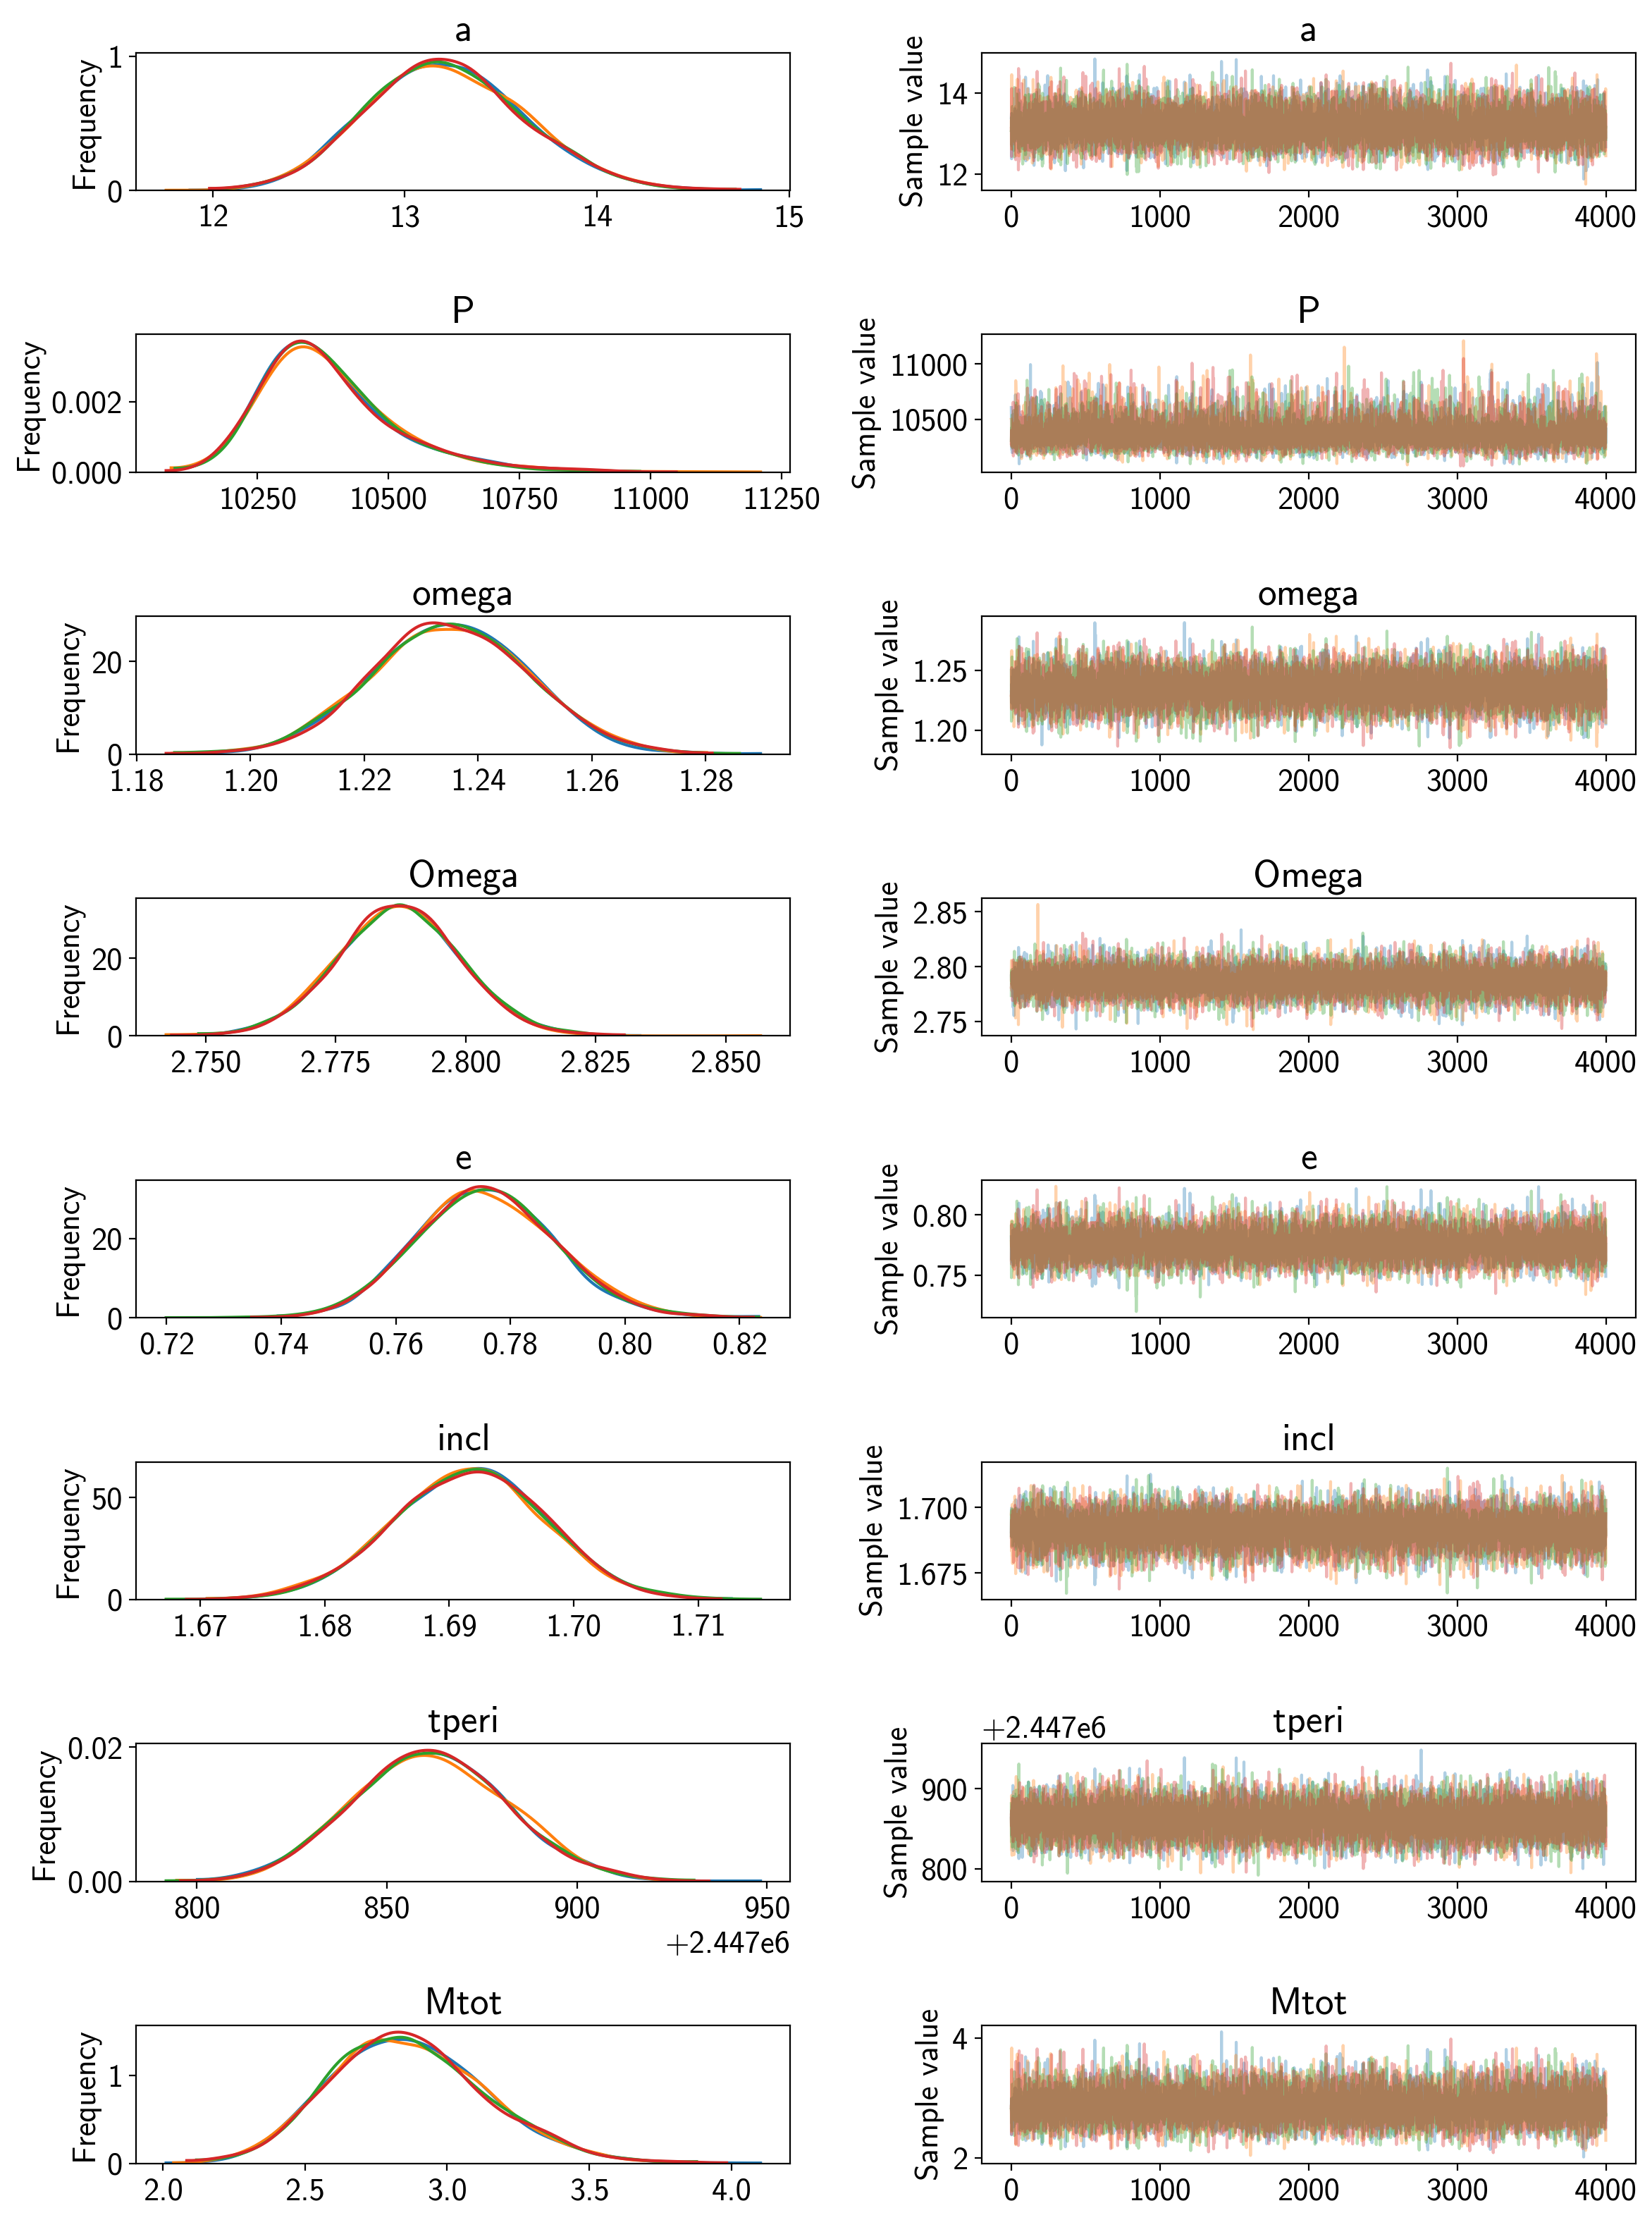

In [25]:
pm.traceplot(trace, varnames=["a", "P", "omega", "Omega", "e", "incl", "tperi", "Mtot"])

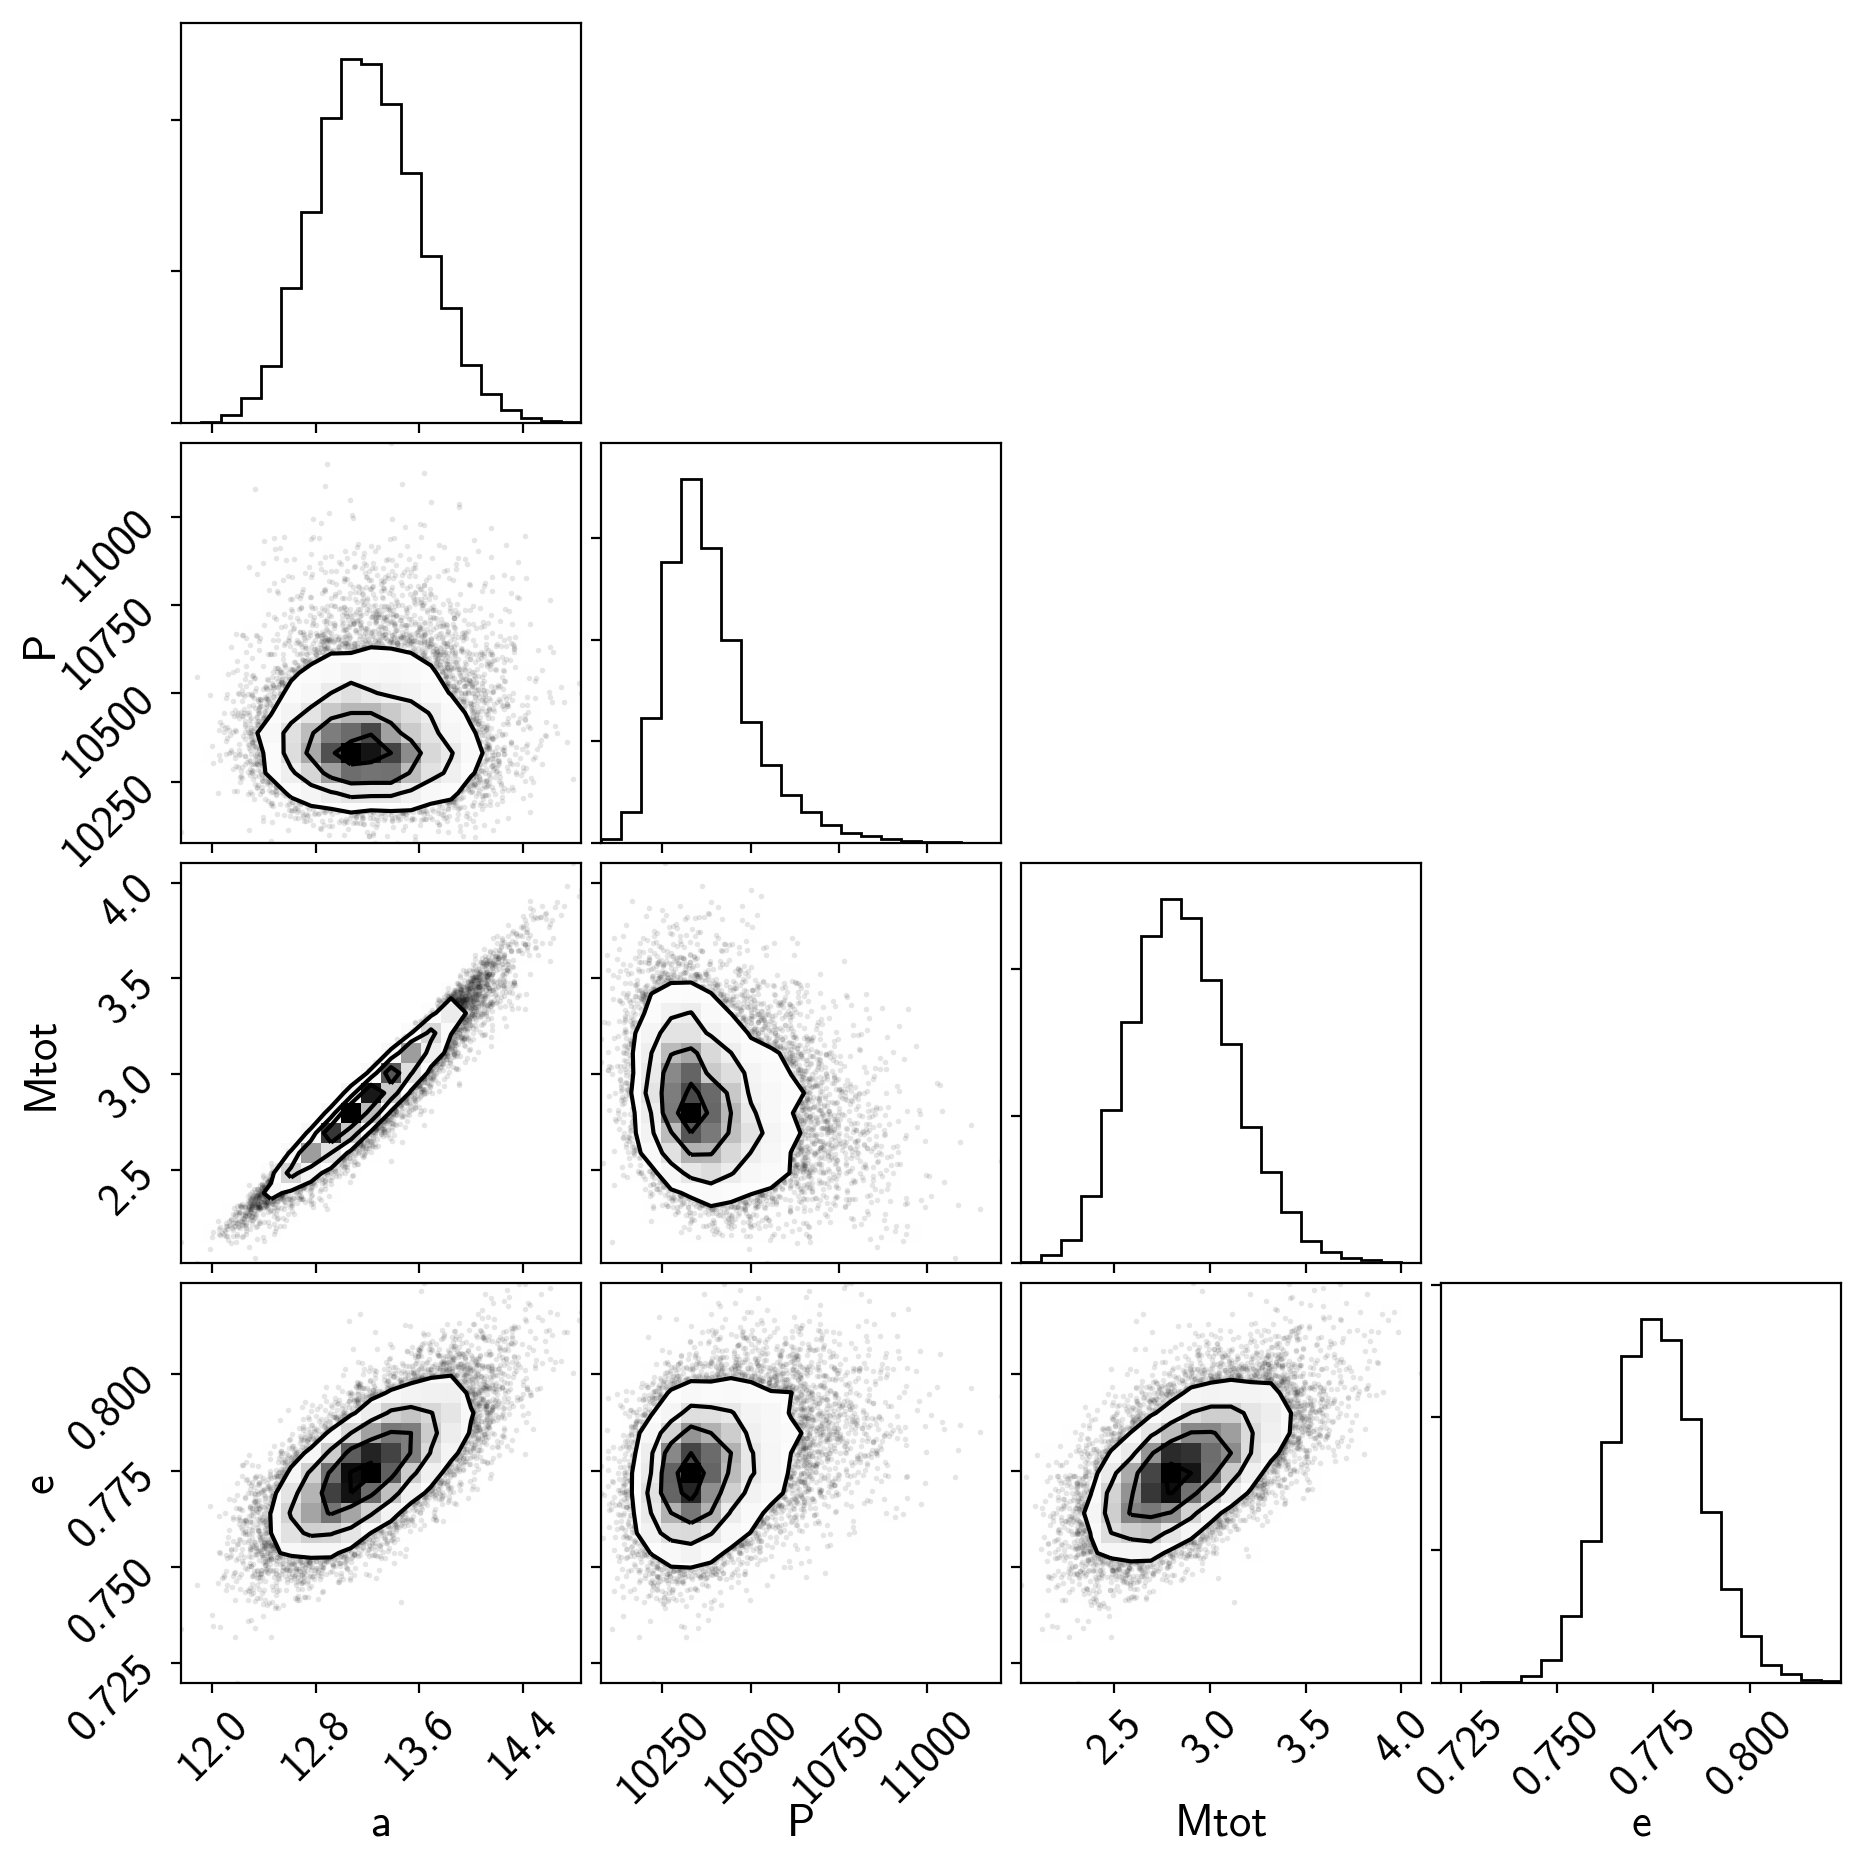

In [26]:
samples = pm.trace_to_dataframe(trace, varnames=["a", "P", "Mtot", "e"])
corner.corner(samples);